<a href="https://colab.research.google.com/github/leonorsilva/Reinforcement-learning/blob/main/Boat_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
from collections import deque
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def isInBounds(x, y, width, height):
    if x>=0 and x<height and y>=0 and y<width:
        return True

    return False


In [5]:
class Environment():
    def env_init(self, env_info={}):
        reward = None
        self.grid_orig=env_info.get('grid')
        self.grid=self.grid_orig.copy()
        termination = None
        self.start=env_info.get('start')
        self.goal=env_info.get('end')
        self.grid_h=env_info.get('grid_h')
        self.grid_w=env_info.get('grid_w')
        self.size=env_info.get('size')

        #self.direction=math.atan2(self.goal[1]-self.agent_loc[1],self.goal[0]-self.agent_loc[0])

        #self.rot=env_info.get('rot')   #radious
        #self.vel=0

        self.maxdist=(abs(self.grid_h)+abs(self.grid_w))
        self.reward_state_term = (reward, None, None, termination)



    def env_start(self):
        reward=0
        self.agent_loc = (np.random.randint(self.grid_w),np.random.randint(self.grid_h))
        self.goal=(np.random.randint(self.grid_w),np.random.randint(self.grid_h))
        self.sine=self.agent_loc[0]-self.goal[0]
        #math.asin((self.agent_loc[0]-self.goal[0])/self.hipotenusa)
        self.cosi=self.agent_loc[1]-self.goal[1]
        #math.acos((self.agent_loc[1]-self.goal[1])/self.hipotenusa)

        self.grid[self.goal[0]][self.goal[1]]=255
        #divide by pi to normalize value
        termination = False
        x, y = self.agent_loc
        if y==self.goal[1] and x==self.goal[0]:
            reward=1
            termination=True

        self.reward_state_term = (reward,self.sine,self.cosi, termination)

        return (self.sine,self.cosi,termination)

    def env_step(self,action):   #actions: [up,left,down,right]
        x, y = self.agent_loc

        if action==0:
            x=x-1
        elif action == 1:
            y = y - 1
        elif action == 2:
            x = x + 1
        elif action == 3:
            y = y + 1


        terminal = False

        reward=0  #-((abs(x-self.goal[0])+abs(y-self.goal[1]))/(self.grid_h+self.grid_w))*100

        if not isInBounds(x, y, self.grid_w, self.grid_h):
            x, y = self.agent_loc
            reward=-1
            terminal=True

        if self.grid[x][y]==0:
            x, y = self.agent_loc
            reward=0

        if y==self.goal[1] and x==self.goal[0]:
            reward=1
            terminal=True

        self.agent_loc = [x, y]

        self.sine=self.agent_loc[0]-self.goal[0]
        self.cosi=self.agent_loc[1]-self.goal[1]


        self.reward_state_term = (reward,self.sine,self.cosi, terminal)

        return self.reward_state_term

    def env_restart(self):
        """Cleanup done after the environment ends"""
        self.agent_loc = self.start
        self.grid=self.grid_orig.copy()

In [6]:
#import numpy as np

#import torch
#import torch.nn as nn
#import torch.nn.functional as F

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#class Actor_Critic(nn.Module):

#    def __init__(self, state_size, action_size, seed):

#        super(Actor_Critic, self).__init__()
#        self.seed = torch.manual_seed(seed)

        #action
        #self.fc1a = nn.Linear(101 , 64)
        #self.fc2a = nn.Linear(64, 32)
#        self.fc3a = nn.Linear(2, 32)
#        self.fc4a = nn.Linear(32, action_size)
#        self.sig=nn.Softmax(dim=1)

        #value
        #self.fc1v = nn.Linear(101 , 64)
        #self.fc2v = nn.Linear(64, 32)
#        self.fc3v = nn.Linear(2, 32)
#        self.fc4v = nn.Linear(32, 1)


#    def forward(self, sine,cosi):
#        """Build an actor (policy) network that maps states -> actions."""


#        x = torch.cat([sine,cosi],dim=1)
        #x=self.norm(x)

        #action
#        aux=F.sigmoid(self.fc3a(x))
#        aux=F.sigmoid(self.fc4a(aux))
#        probs=self.sig(aux)
        #logits=torch.logit(aux)
        #print(logits)
#        dist = torch.distributions.Categorical(probs=probs)

#        action = dist.sample()

#        log_prob = dist.log_prob(action).unsqueeze(-1)
#        entropy = dist.entropy().unsqueeze(-1)

        #value
#        x=F.tanh(self.fc3v(x))
#        v=F.tanh(self.fc4v(x))

#        return action,v,log_prob,entropy,probs

#    def action(self,sine,cosi,action):
 #       """Build an actor (policy) network that maps states -> actions."""


#        x = torch.cat([sine,cosi],dim=1)
        #x=self.norm(x)

        #action
#        aux=F.sigmoid(self.fc3a(x))
#        aux=F.sigmoid(self.fc4a(aux))
#        probs=self.sig(aux)
        #logits=torch.logit(aux)
        #print(logits)
#        dist = torch.distributions.Categorical(probs=probs)


#        log_prob = dist.log_prob(action).unsqueeze(-1)
#        entropy = dist.entropy().unsqueeze(-1)

        #value
#        x=F.tanh(self.fc3v(x))
#        v=F.tanh(self.fc4v(x))

#        return action,v,log_prob,entropy,probs


In [46]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        #action
        #self.fc1a = nn.Linear(101 , 64)
        #self.fc2a = nn.Linear(64, 32)
        self.norm=nn.BatchNorm1d(4)
        self.fc3a = nn.Linear(4, 32)
        self.fc4a = nn.Linear(32, action_size)
        self.sig=nn.Softmax(dim=1)


    def forward(self, input):
        """Build an actor (policy) network that maps states -> actions."""


        #x = torch.cat([sine,cosi],dim=1)
        #x=self.norm(x)

        #action
        x=self.norm(input)
        aux=F.sigmoid(self.fc3a(x))
        aux=F.sigmoid(self.fc4a(aux))
        probs=self.sig(aux)
        #logits=torch.logit(aux)
        #print(logits)
        dist = torch.distributions.Categorical(probs=probs)

        action = dist.sample()

        #log_prob = dist.log_prob(action).sum(-1).unsqueeze(-1)
        #print(log_prob)
        entropy = 0 #dist.entropy().unsqueeze(-1)
        log_prob=torch.index_select(probs,1,action).squeeze(-1)
        #print(log_prob)
        return action,log_prob,entropy,probs

    def action(self,input,action):
        """Build an actor (policy) network that maps states -> actions."""


        #x = torch.cat([sine,cosi],dim=1)
        #x=self.norm(x)

        #action
        print(input)
        x=self.norm(input)
        aux=F.sigmoid(self.fc3a(x))
        aux=F.sigmoid(self.fc4a(aux))
        probs=self.sig(aux)
        #logits=torch.logit(aux)
        #print(logits)
        dist = torch.distributions.Categorical(probs=probs)


        #log_prob = dist.log_prob(action).sum(-1).unsqueeze(-1)

        log_prob=torch.index_select(probs,1,action).squeeze(-1)

        entropy = 0 #dist.entropy().unsqueeze(-1)

        return action,log_prob,entropy,probs


In [47]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed):

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        #value
        #self.fc1v = nn.Linear(101 , 64)
        #self.fc2v = nn.Linear(64, 32)
        self.norm=nn.BatchNorm1d(4)
        self.fc3v = nn.Linear(4, 232)
        self.fc4v = nn.Linear(232, 156)
        self.fc5v = nn.Linear(156, 1)


    def forward(self,input):
        """Build an actor (policy) network that maps states -> actions."""

        #x = torch.cat([x,y,sine,cosi],dim=1)
        #x=self.norm(x)

        #value
        x=self.norm(input)
        x=F.tanh(self.fc3v(x))
        x=F.tanh(self.fc4v(x))
        v=F.tanh(self.fc5v(x))

        return v



In [88]:

import time

import numpy as np
import time
import torch
import torch.nn as nn
from torch.optim import Adam, Adadelta, RMSprop
from collections import namedtuple, deque


ENT_DECAY = 0.995

class PPO:
    """
        This is the PPO class we will use as our model in main.py
    """
    def __init__(self,env, state_size,action_size, **hyperparameters):
        """
            Initializes the PPO model, including hyperparameters.
            Parameters:
                policy_class - the policy class to use for our actor/critic networks.
                env - the environment to train on.
                hyperparameters - all extra arguments passed into PPO that should be hyperparameters.
            Returns:
                None
        """
        # Make sure the environment is compatible with our code
        # Initialize hyperparameters for training with PPO
        self._init_hyperparameters(hyperparameters)

        # Extract environment information
        self.env=env
        self.obs_dim = state_size
        self.act_dim = action_size


         # Initialize actor and critic networks
        self.Actor = Actor(self.obs_dim, self.act_dim,30)
        self.Critic = Critic(self.obs_dim, self.act_dim,30)
        #self.critic = Critic(self.obs_dim, self.act_dim,30)


        # Initialize optimizers for actor and critic
        self.lr_inicial=self.lr
        self.b_inital=0.9
        #self.optim = RMSprop(self.Actor_Critic.parameters(), lr=self.lr,eps= 1e-5,alpha=0.9,momentum=self.b_inital)
        self.optima = Adam(self.Actor.parameters(), lr=self.lr,eps= 1e-5) #,betas=(0.8,0.999))
        self.optimc = Adam(self.Critic.parameters(), lr=self.lr,eps= 1e-5)

        self.entropy_w=0.0
        self.critic_w=1
        self.target_kl=None

        self.avg_ret=[]
        self.random=1


        # Initialize the covariance matrix used to query the actor for actions
        self.batch=25

        # This logger will help us with printing out summaries of each iteration
        self.logger = {
            'delta_t': time.time(),
            't_so_far': 0,          # timesteps so far
            'i_so_far': 0,          # iterations so far
            'batch_lens': [],       # episodic lengths in batch
            'batch_rews': [],       # episodic returns in batch
            'actor_losses': [],     # losses of actor network in current iteration
            'critic_losses': [],
            'entropy_losses': [],
            'approx_kl_divs': [],
        }

    def learn(self, total_timesteps):
        """
            Train the actor and critic networks. Here is where the main PPO algorithm resides.
            Parameters:
                total_timesteps - the total number of timesteps to train for
            Return:
                None
        """
        print(f"Learning... Running {self.max_timesteps_per_episode} timesteps per episode, ", end='')
        print(f"{self.timesteps_per_batch} timesteps per batch for a total of {total_timesteps} timesteps")
        t_so_far = 0 # Timesteps simulated so far
        i_so_far = 0 # Iterations ran so far
        while i_so_far < total_timesteps:                                                                       # ALG STEP 2
            # Autobots, roll out (just kidding, we're collecting our batch simulations here)
            batch_critic, batch_acts, batch_log_probs, batch_rtgs, batch_lens, dones, batch_advs = self.rollout()                     # ALG STEP 3


            # Calculate how many timesteps we collected this batch
            t_so_far += np.sum(batch_lens)

            # Increment the number of iterations
            i_so_far += 1

            # Logging timesteps so far and iterations so far
            self.logger['t_so_far'] = t_so_far
            self.logger['i_so_far'] = i_so_far

            # Calculate advantage at k-th iteration
            V, _ ,_= self.evaluate(batch_critic, batch_acts)

            #_,Vnext,_,_ = self.actor_critic(batch_obs_next)

            #batch_rtgs=batch_rtgs+self.gamma*Vnext.detach()*dones

            print('return', np.sort(batch_rtgs.detach().numpy().reshape(1,-1)[0])[-10:])
            print('return', np.sort(batch_rtgs.detach().numpy().reshape(1,-1)[0])[:10])
            #VV=Vnext.cpu().detach().numpy().reshape(1,-1)[0]
            A_k = batch_advs
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
            #print('v', V.cpu().detach().numpy().reshape(1,-1)[0][-10:])
            #print('adv', A_k)

            # This is the loop where we update our network for some n epochs
            for epoch in range(self.n_updates_per_iteration):


                continue_training=True
                approx_kl_divs=[]
                for  _ in range(int(len(batch_acts)/self.batch)):
                    indices = np.random.permutation(len(batch_acts))
                    idx=indices[ :self.batch]
                    batch_acts2=batch_acts[idx]
                    batch_critic2=batch_critic[idx]
                    batch_log_probs2=batch_log_probs[idx]
                    batch_rtgs2=batch_rtgs[idx]
                    A_k2=A_k[idx]


                    # Calculate V_phi and pi_theta(a_t | s_t)
                    V2, curr_log_probs,entropy = self.evaluate(batch_critic2, batch_acts2)

                    ratios = curr_log_probs / batch_log_probs2 #torch.exp(curr_log_probs - batch_log_probs2)

                    # Calculate surrogate losses.

                    surr1 = ratios * A_k2
                    surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * A_k2

                    #sum(-1)???
                    actor_loss = -torch.min(surr1, surr2).mean()
                    entropy_loss=0 #self.entropy_w*(-torch.mean(entropy))

                    critic_loss = self.critic_w*nn.L1Loss()(V2, batch_rtgs2)

                    total_loss=actor_loss+entropy_loss+critic_loss

                    with torch.no_grad():  #????
                        log_ratio = curr_log_probs - batch_log_probs2
                        approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                        approx_kl_divs.append(approx_kl_div)

                    if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                        continue_training = False

                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                        #break

                    # Calculate gradients and perform backward propagation for critic network

                    self.optima.zero_grad()
                    actor_loss.backward()
                    #torch.nn.utils.clip_grad_norm(self.Actor_Critic.parameters(), 5)
                    self.optima.step()

                    self.optimc.zero_grad()
                    critic_loss.backward()
                    #torch.nn.utils.clip_grad_norm(self.Actor_Critic.parameters(), 5)
                    self.optimc.step()

                    # Log actor loss
                    self.logger['actor_losses'].append(actor_loss.detach().numpy())
                    #self.logger['entropy_losses'].append(entropy_loss.detach())
                    self.logger['critic_losses'].append(critic_loss.detach().numpy())

                #if not continue_training:
                #    break

            V, _ ,_= self.evaluate(batch_critic,batch_acts)
            #print(V.cpu().detach().numpy().reshape(1,-1)[0][-10:])

            #lr =max(self.lr_inicial * (1-i_so_far/total_timesteps),0.0003)
            #for param_group in self.optim.param_groups:
            #    param_group['lr'] = lr


            # Print a summary of our training so far
            self.logger['approx_kl_divs'].append(np.mean(approx_kl_divs))

            self._log_summary()





    def rollout(self):
        """
            Too many transformers references, I'm sorry. This is where we collect the batch of data
            from simulation. Since this is an on-policy algorithm, we'll need to collect a fresh batch
            of data each time we iterate the actor/critic networks.
            Parameters:
                None
            Return:
                batch_obs - the observations collected this batch. Shape: (number of timesteps, dimension of observation)
                batch_acts - the actions collected this batch. Shape: (number of timesteps, dimension of action)
                batch_log_probs - the log probabilities of each action taken this batch. Shape: (number of timesteps)
                batch_rtgs - the Rewards-To-Go of each timestep in this batch. Shape: (number of timesteps)
                batch_lens - the lengths of each episode this batch. Shape: (number of episodes)
        """
        # Batch data. For more details, check function header.
        self.Actor.eval()
        self.Critic.eval()

        batch_acts = []
        batch_log_probs = []
        batch_rews = []
        batch_rtgs = np.array([])
        batch_lens = []
        batch_value=[]
        batch_critic=[]
        dones=[]
        batch_advs=np.array([])


        # Episodic data. Keeps track of rewards per episode, will get cleared
        # upon each new episode
        ep_rews = []

        t = 0 # Keeps track of how many timesteps we've run so far this batch


        # Keep simulating until we've run more than or equal to specified timesteps per batch
        while t < self.timesteps_per_batch:
            self.random=np.random.rand()
            print(self.random)
            ep_rews2 = [] # rewards collected per episode

            # Reset the environment. sNote that obs is short for observation.
            sine,cosi,done = env.env_start()

            X=[]
            Y=[]
            ep_t=0
            # Run an episode for a maximum of max_timesteps_per_episode timesteps
            #for ep_t in range(self.max_timesteps_per_episode):
            while not done:
                ep_t+=1
                # If render is specified, render the environment
                if self.render and (self.logger['i_so_far'] % self.render_every_i == 0) and len(batch_lens) == 0:
                    self.env.render()

                #t += 1 # Increment timesteps ran this batch so far
                t+=1

                # Track observations in this batch

                #obs = torch.from_numpy(np.array([obs])).float().to(device)
                #sine=torch.from_numpy(np.array([[sine]])).float()
                #cosi=torch.from_numpy(np.array([[cosi]])).float()


                input=torch.from_numpy(np.array([[env.agent_loc[0],env.agent_loc[1],sine,cosi]])).float()
                print(input)
                batch_critic.append([env.agent_loc[0],env.agent_loc[1],sine,cosi])

                # Calculate action and make a step in the env.
                # Note that rew is short for reward.
                action, log_prob,value,_= self.get_action(input)
                rew,sine,cosi,done=env.env_step(action)
                #obs,rew,done,_= self.env.step(action.flatten())

                # Track recent reward, action, and action log probability
                ep_rews.append(rew)
                ep_rews2.append(rew)
                batch_acts.append(action)
                batch_value.append(value.detach().numpy()[0])
                batch_log_probs.append(log_prob)
                X.append(self.env.agent_loc[0])
                Y.append(self.env.agent_loc[1])

                # If the environment tells us the episode is terminated, break
                if done:
                    dones.append(1)
                    break
                dones.append(0)


            # Track episodic lengths and rewards
            batch_lens.append(ep_t + 1)
            #batch_rews.append(ep_rews2)
            self.logger['batch_rews'].append(ep_rews2)
            plt.imshow(self.env.grid, cmap='gray')
            plt.scatter(Y,X,color='r')
            plt.scatter(self.env.goal[1],self.env.goal[0],color='b')
            plt.scatter(self.env.agent_loc[1],self.env.agent_loc[0],color='g')
            plt.show()
            print(batch_value[-len(ep_rews2):])


            batch_advs2,batch_rtgs2 = self.compute_advs(ep_rews2,batch_value[-len(ep_rews2):])
            print('return',batch_rtgs2)
            print('gae',batch_advs2)
            batch_advs=np.append(batch_advs,batch_advs2)
            batch_rtgs=np.append(batch_rtgs,batch_rtgs2)

        #batch_value.append(0)


        # Reshape data as tensors in the shape specified in function description, before returning
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)


        batch_log_probs=torch.tensor(batch_log_probs, dtype=torch.float)

        batch_critic=torch.tensor(np.vstack(batch_critic), dtype=torch.float)

        #batch_rews2=np.array(batch_rews)/(np.max(ep_rews)+1e-5)
        #batch_rews2=torch.tensor(batch_rews, dtype=torch.float)

        #torch.from_numpy(np.vstack(ep_rews)/(np.max(ep_rews)+1e-5)).float().to(device)

        dones=torch.tensor(dones, dtype=torch.float)
        #print(batch_advs)

        batch_advs=torch.tensor(np.vstack(batch_advs), dtype=torch.float)   #torch.tensor(np.vstack(batch_advs), dtype=torch.float)
        batch_rtgs=torch.tensor(np.vstack(batch_rtgs), dtype=torch.float)

        #self.logger['batch_lens'].append([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']])

        self.Actor.train()
        self.Critic.train()

        return batch_critic, batch_acts, batch_log_probs, batch_rtgs, batch_lens,dones,batch_advs



    def compute_advs(self, batch_rews,batch_value):
        with torch.no_grad():
            advantages = []
            returns = []

            size=0

            aux=[]
            last_gae_lam = 0

            next_non_terminal=next_values=0
            returne=0
            print(' gamma',self.gamma)
            print(batch_rews)
            print(batch_value)

            for rew in reversed(range(len(batch_rews))):


                returne=batch_rews[rew] + self.gamma * next_values * next_non_terminal

                delta = batch_rews[rew] + self.gamma * next_values * next_non_terminal - batch_value[rew]
                #last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
                advantages.insert(0, delta )   #VERIFICAR GAE
                returns.insert(0,returne)
                next_non_terminal = 1

                next_values = batch_value[rew]

        return advantages,returns


    def get_action(self,batch_critic,train=True ):
        """
            Queries an action from the actor network, should be called from rollout.
            Parameters:
                obs - the observation at the current timestep
            Return:
                action - the action to take, as a numpy array
                log_prob - the log probability of the selected action in the distribution
        """
        # Query the actor network for a mean action
        if np.random.rand()<self.random and train:
          #print(self.env.goal,self.env.agent_loc)
          #if direction>0 and direction<=np.pi/2:   #1quadrante

           # action=np.random.choice([3,0],1)
            #print(direction,'1',action)
          #elif direction>np.pi/2 and direction<=np.pi: #2quadrante

           # action=np.random.choice([1,0],1)
            #print(direction,'2',action)
          #elif direction<0 and direction>=-np.pi/2: #4quadrante

          #  action=np.random.choice([3,2],1)
            #print(direction,'4',action)
          #else:  #3quadrante

           # action=np.random.choice([2,1],1)
            #print(direction,'3',action)
          action=np.random.choice([0,3,2,1],1)
          action=torch.from_numpy(action)
          action,log_prob,entropy,dist = self.Actor.action(batch_critic,action)
          value = self.Critic(batch_critic)

        else:
          action,log_prob,entropy,dist = self.Actor(batch_critic)
          value = self.Critic(batch_critic)

          #log_prob = dist.log_prob(action)
        action=action.detach().numpy()
        log_prob = log_prob.detach().numpy()


        return action, log_prob,value[0],dist

    def play(self):
        self.Actor.eval()
        self.Critic.eval()
        sine,cosi,done = env.env_start()
        print(env.agent_loc)
        while not done:

            input=torch.from_numpy([env.agent_loc[0],env.agent_loc[1],sine,cosi])

            action, log_prob,value,dist= self.get_action(input,train=False)
            rew,sine,cosi,done=env.env_step(action)
            print(action,dist,value,rew,log_prob)
            plt.imshow(self.env.grid, cmap='gray')
            plt.scatter(self.env.goal[1],self.env.goal[0],color='b')
            plt.scatter(self.env.agent_loc[1],self.env.agent_loc[0],color='g')
            plt.show()



    def evaluate(self,batch_critic, batch_acts):
        """
            Estimate the values of each observation, and the log probs of
            each action in the most recent batch with the most recent
            iteration of the actor network. Should be called from learn.
            Parameters:
                batch_obs - the observations from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of observation)
                batch_acts - the actions from the most recently collected batch as a tensor.
                            Shape: (number of timesteps in batch, dimension of action)
            Return:
                V - the predicted values of batch_obs
                log_probs - the log probabilities of the actions taken in batch_acts given batch_obs
        """
        # Query critic network for a value V for each batch_obs. Shape of V should be same as batch_rtgs
        action,log_prob,entropy,_ = self.Actor(batch_critic)
        value = self.Critic(batch_critic)

        #log_prob = dist.log_prob(batch_acts.squeeze())


        return value.reshape(1,-1)[0], log_prob,entropy


    def _init_hyperparameters(self, hyperparameters):
        """
            Initialize default and custom values for hyperparameters
            Parameters:
                hyperparameters - the extra arguments included when creating the PPO model, should only include
                                    hyperparameters defined below with custom values.
            Return:
                None
        """
        # Initialize default values for hyperparameters
        # Algorithm hyperparameters
        self.timesteps_per_batch = 1000                 # Number of timesteps to run per batch
        self.max_timesteps_per_episode = 600           # Max number of timesteps per episode
        self.n_updates_per_iteration = 10                # Number of times to update actor/critic per iteration
        self.lr = 0.001                                 # Learning rate of actor optimizer
        self.gamma = 0.99                               # Discount factor to be applied when calculating Rewards-To-Go
        self.clip = 0.2                                 # Recommended 0.2, helps define the threshold to clip the ratio during SGA

        # Miscellaneous parameters
        self.render = False                              # If we should render during rollout
        self.render_every_i = 10                        # Only render every n iterations
        self.save_freq = 10                             # How often we save in number of iterations
        self.seed = None                                # Sets the seed of our program, used for reproducibility of results

        # Change any default values to custom values for specified hyperparameters
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))

        # Sets the seed if specified
        if self.seed != None:
            # Check if our seed is valid first
            assert(type(self.seed) == int)

            # Set the seed
            torch.manual_seed(self.seed)
            print(f"Successfully set seed to {self.seed}")

    def _log_summary(self):
        """
            Print to stdout what we've logged so far in the most recent batch.
            Parameters:
                None
            Return:
                None
        """
        # Calculate logging values. I use a few python shortcuts to calculate each value
        # without explaining since it's not too important to PPO; feel free to look it over,
        # and if you have any questions you can email me (look at bottom of README)
        delta_t = self.logger['delta_t']
        self.logger['delta_t'] = time.time()
        delta_t = (self.logger['delta_t'] - delta_t) / 1e9
        delta_t = str(round(delta_t, 2))

        t_so_far = self.logger['t_so_far']
        i_so_far = self.logger['i_so_far']
        avg_ep_lens = np.mean(self.logger['batch_lens'][-100:])
        avg_ep_rews = np.mean([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']][-100:])
        max_ret=np.max([np.sum(ep_rews) for ep_rews in self.logger['batch_rews']])
        avg_actor_loss = np.mean([np.mean(self.logger['actor_losses'])])
        avg_critic_loss = np.mean([np.mean(self.logger['critic_losses'])])
        avg_entropy_loss = np.mean([np.mean(self.logger['entropy_losses'])])



        self.avg_ret.append(np.round(avg_ep_rews,2))
        # Round decimal places for more aesthetic logging messages
        avg_ep_lens = str(round(avg_ep_lens, 2))
        avg_ep_rews = str(round(avg_ep_rews, 2))
        avg_actor_loss = str(round(avg_actor_loss, 5))

        # Print logging statements
        print(flush=True)
        print(f"-------------------- Iteration #{i_so_far} --------------------", flush=True)
        print(f'random ',self.random)
        print(f"Average : {self.lr_inicial}", flush=True)
        print(f"Average Episodic Return: {avg_ep_rews}", flush=True)
        print(f"Max Episodic Return: {max_ret}", flush=True)
        print(f"Average Loss: {avg_actor_loss}", flush=True)
        print(f"Average Loss Critic: {avg_critic_loss}", flush=True)
        #print(f"STD: {std}", flush=True)
        print(f"TEntropy: {avg_entropy_loss}", flush=True)
        print(f"approx_kl_divs: {self.logger['approx_kl_divs']} secs", flush=True)
        print(f"------------------------------------------------------", flush=True)
        print(flush=True)

        # Reset batch-specific logging data
        #self.logger['batch_rews'] = []

        self.logger['approx_kl_divs']=[]



In [89]:
#train easy mode
img_matrix_filtered2=np.ones((6,6))*125
startlat=1
startlon=1
endlon=5
endlat=5

In [90]:

env=Environment()
env_info={'grid':img_matrix_filtered2,'grid_h':img_matrix_filtered2.shape[0],'grid_w':img_matrix_filtered2.shape[1],
          'size':5,'start':[startlat,startlon],'end':[endlat,endlon]}
env.env_init(env_info)

In [91]:
hyperparameters = {
                'gamma': 0.8 ,
                'gae_lambda':0.8,
                'lr': 0.01,
                'timesteps_per_batch':50,
                'max_timesteps_per_episode':500,
                'total_timesteps':100,
                'n_updates_per_iteration':5,
                'target_update_interval':1,
                'clip': 0.2,
                'render': False,
                'render_every_i': 10
              }
agent=PPO(env,6*6, 4, random_seed=10,**hyperparameters)

Learning... Running 500 timesteps per episode, 50 timesteps per batch for a total of 100 timesteps
0.6185621188599952
tensor([[2., 3., 2., 0.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[2., 3., 2., 0.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 4.,  0.,  4., -3.]])


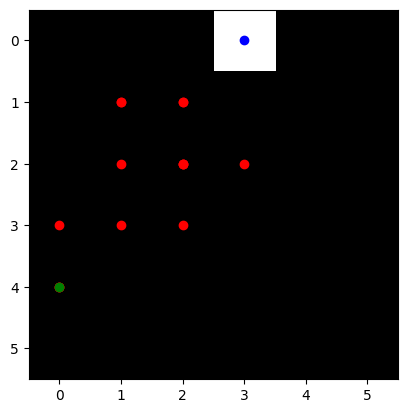

[0.53864217, 0.5598815, 0.53328705, 0.4164653, 0.45819515, 0.4164653, 0.45819515, 0.5598815, 0.53864217, 0.5598815, 0.60964906, 0.5820954, 0.52765363, 0.55220276]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.53864217, 0.5598815, 0.53328705, 0.4164653, 0.45819515, 0.4164653, 0.45819515, 0.5598815, 0.53864217, 0.5598815, 0.60964906, 0.5820954, 0.52765363, 0.55220276]
return [0.4479052066802979, 0.42662963867187503, 0.3331722497940064, 0.36655611991882325, 0.3331722497940064, 0.36655611991882325, 0.4479052066802979, 0.4309137344360352, 0.4479052066802979, 0.4877192497253418, 0.46567630767822266, 0.4221229076385498, 0.44176220893859863, -1.0]
gae [-0.09073696136474607, -0.13325186967849728, -0.20011479854583736, -0.04990919232368468, -0.12502290010452266, -0.04990919232368468, -0.010289943218231179, -0.1289677739143371, -0.09073696136474607, -0.0721622586250305, -0.1439727544784546, -0.1599724769592285, -0.08589142560958862, -1.5522027611732483]
0.9069581225189582
tensor([[4.,

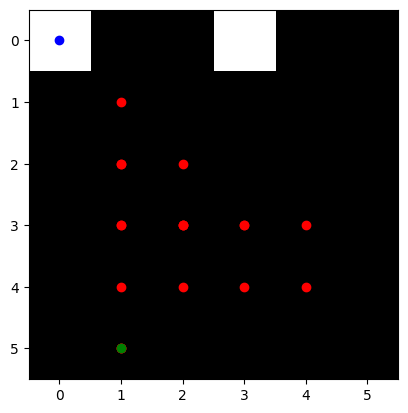

[0.49087617, 0.522559, 0.49709147, 0.5292338, 0.5568294, 0.5292338, 0.5616863, 0.5739147, 0.5616863, 0.5739147, 0.5498034, 0.47641364, 0.5498034, 0.525181, 0.5616863, 0.57559943, 0.58190197, 0.5848847]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.49087617, 0.522559, 0.49709147, 0.5292338, 0.5568294, 0.5292338, 0.5616863, 0.5739147, 0.5616863, 0.5739147, 0.5498034, 0.47641364, 0.5498034, 0.525181, 0.5616863, 0.57559943, 0.58190197, 0.5848847]
return [0.4180471897125244, 0.39767317771911626, 0.4233870506286621, 0.44546351432800296, 0.4233870506286621, 0.4493490219116211, 0.45913176536560063, 0.4493490219116211, 0.45913176536560063, 0.43984270095825195, 0.3811309099197388, 0.43984270095825195, 0.42014479637145996, 0.4493490219116211, 0.46047954559326176, 0.46552157402038574, 0.46790776252746585, -1.0]
gae [-0.0728289783000946, -0.12488580942153926, -0.07370442152023315, -0.08377029895782467, -0.13344234228134155, -0.07988479137420651, -0.10255451202392574, -0.1245

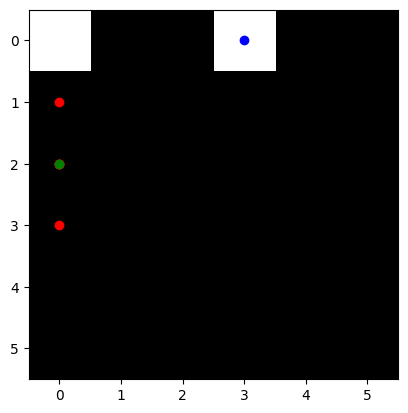

[0.4164653, 0.3241478, 0.4582279, 0.52765363, 0.4582279]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.4164653, 0.3241478, 0.4582279, 0.52765363, 0.4582279]
return [0.2593182325363159, 0.36658232212066655, 0.4221229076385498, 0.36658232212066655, -1.0]
gae [-0.15714707970619202, 0.04243453145027165, -0.036104995012283314, -0.1610713124275207, -1.4582279026508331]
0.436965937694931
tensor([[ 0.,  5., -1.,  1.]])
tensor([[ 0.,  5., -1.,  1.]])


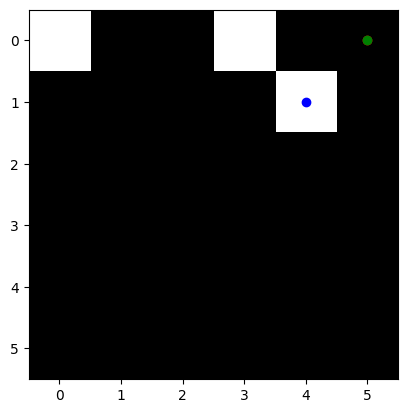

[0.21248418]
 gamma 0.8
[-1]
[0.21248418]
return [-1.0]
gae [-1.2124841809272766]
0.9784858466934714
tensor([[ 1.,  4., -3.,  1.]])
tensor([[ 1.,  4., -3.,  1.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  4., -3.,  1.]])
tensor([[ 1.,  4., -3.,  1.]])
tensor([[ 1.,  5., -3.,  2.]])
tensor([[ 1.,  5., -3.,  2.]])
tensor([[ 0.,  5., -4.,  2.]])
tensor([[ 0.,  5., -4.,  2.]])


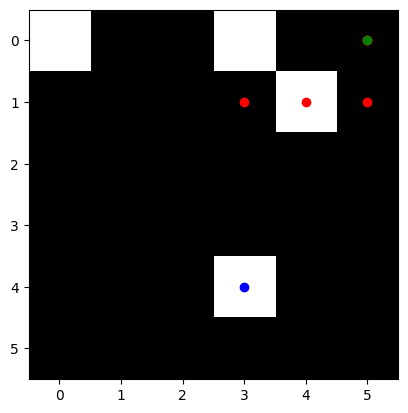

[0.042957783, 0.003542591, 0.042957783, 0.07822457, 0.021458836]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.042957783, 0.003542591, 0.042957783, 0.07822457, 0.021458836]
return [0.0028340727090835575, 0.03436622619628906, 0.06257965564727784, 0.017167069017887115, -1.0]
gae [-0.04012371003627777, 0.030823635309934615, 0.019621872901916512, -0.061057500541210175, -1.021458836272359]
0.8443296715384534
tensor([[3., 3., 3., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[2., 3., 2., 0.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 3.,  2.,  3., -1.]])


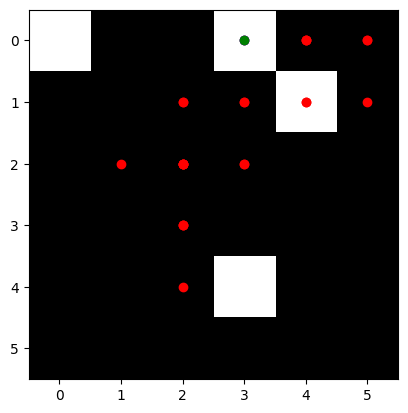

[0.60314244, 0.60964906, 0.6222618, 0.60964906, 0.5598815, 0.53328705, 0.5598815, 0.45819515, 0.5598815, 0.53864217, 0.5598815, 0.60964906, 0.5598815, 0.45819515, 0.44404757, 0.53864217, 0.44404757, 0.41572818, 0.2957407, 0.28321737, 0.2957407, 0.41572818, 0.39246714, 0.28321737, 0.2957407]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.60314244, 0.60964906, 0.6222618, 0.60964906, 0.5598815, 0.53328705, 0.5598815, 0.45819515, 0.5598815, 0.53864217, 0.5598815, 0.60964906, 0.5598815, 0.45819515, 0.44404757, 0.53864217, 0.44404757, 0.41572818, 0.2957407, 0.28321737, 0.2957407, 0.41572818, 0.39246714, 0.28321737, 0.2957407]
return [0.4877192497253418, 0.4978094577789307, 0.4877192497253418, 0.4479052066802979, 0.42662963867187503, 0.4479052066802979, 0.36655611991882325, 0.4479052066802979, 0.4309137344360352, 0.4479052066802979, 0.4877192497253418, 0.4479052066802979, 0.36655611991882325, 0.35523805618286136, 0.4309137344360352, 0.355238056182861

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


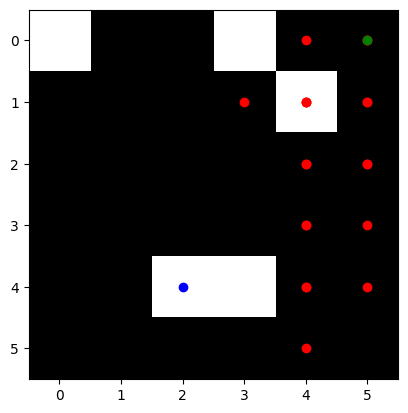

[0.9746287, 0.9974139, 0.9988738, 0.9871081, 0.9988738, 0.9987528, 0.9974194, 0.9845606, 0.9804245, 0.99629545, 0.9804245, 0.9845606, 0.9893046, 0.9987528, 0.9974194, 0.99629545, 0.9985489, 0.99629545, 0.9956947, 0.9814994]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.9746287, 0.9974139, 0.9988738, 0.9871081, 0.9988738, 0.9987528, 0.9974194, 0.9845606, 0.9804245, 0.99629545, 0.9804245, 0.9845606, 0.9893046, 0.9987528, 0.9974194, 0.99629545, 0.9985489, 0.99629545, 0.9956947, 0.9814994]
return [0.7979310989379883, 0.7990990161895752, 0.7896864891052247, 0.7990990161895752, 0.79900221824646, 0.7979355335235596, 0.7876484870910645, 0.7843396186828614, 0.797036361694336, 0.7843396186828614, 0.7876484870910645, 0.791443681716919, 0.79900221824646, 0.7979355335235596, 0.797036361694336, 0.7988391399383545, 0.797036361694336, 0.796555757522583, 0.7851994991302491, -1.0]
gae [-0.17669758796691892, -0.1983148574829101, -0.20918728113174434, -0.18800909519195552, -0

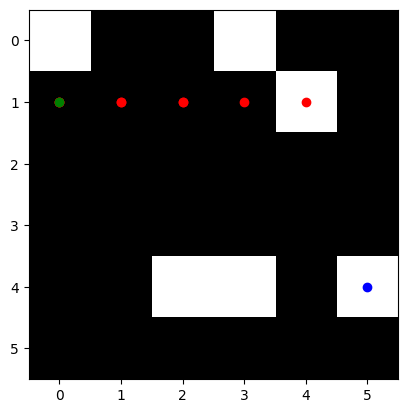

[0.9989644, 0.9983309, 0.9989644, 0.99911773, 0.9991661, 0.99911773, 0.9991661, 0.9991844]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.9989644, 0.9983309, 0.9989644, 0.99911773, 0.9991661, 0.99911773, 0.9991661, 0.9991844]
return [0.7986647129058838, 0.799171543121338, 0.7992941856384278, 0.799332857131958, 0.7992941856384278, 0.799332857131958, 0.7993475437164307, -1.0]
gae [-0.20029971599578855, -0.19915934801101676, -0.19967024326324456, -0.19978487491607666, -0.1998718857765197, -0.19978487491607666, -0.19981852769851682, -1.9991844296455383]
0.043439725718769195
tensor([[ 1.,  4., -1.,  0.]])
tensor([[ 0.,  4., -2.,  0.]])
tensor([[ 0.,  5., -2.,  1.]])
tensor([[ 0.,  4., -2.,  0.]])
tensor([[ 0.,  3., -2., -1.]])
tensor([[ 0.,  2., -2., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 2.,  3.,  0., -1.]])


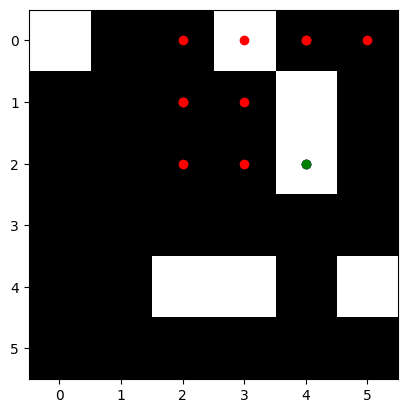

[0.99857223, 0.99825287, 0.99393135, 0.99825287, 0.9989533, 0.9991096, 0.9991917, 0.9993452, 0.9991917, 0.9990975, 0.99938256]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.99857223, 0.99825287, 0.99393135, 0.99825287, 0.9989533, 0.9991096, 0.9991917, 0.9993452, 0.9991917, 0.9990975, 0.99938256]
return [0.7986022949218751, 0.7951450824737549, 0.7986022949218751, 0.7991626262664795, 0.7992877006530762, 0.7993533611297607, 0.799476146697998, 0.7993533611297607, 0.7992780208587646, 0.7995060443878175, 1.0]
gae [-0.19996993541717523, -0.20310778617858882, -0.19532905817031854, -0.19909024238586426, -0.19966558218002317, -0.19975626468658447, -0.19971555471420288, -0.19999182224273682, -0.19991368055343628, -0.19959148168563834, 0.0006174445152282715]
0.1633625216394876
tensor([[ 0.,  4., -1., -1.]])


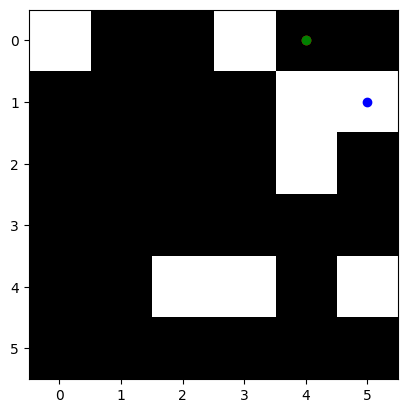

[0.998672]
 gamma 0.8
[-1]
[0.998672]
return [-1.0]
gae [-1.9986720085144043]
0.6750323209691026
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 0.,  0., -4., -5.]])
tensor([[ 1.,  0., -3., -5.]])
tensor([[ 1.,  0., -3., -5.]])
tensor([[ 0.,  0., -4., -5.]])
tensor([[ 0.,  0., -4., -5.]])


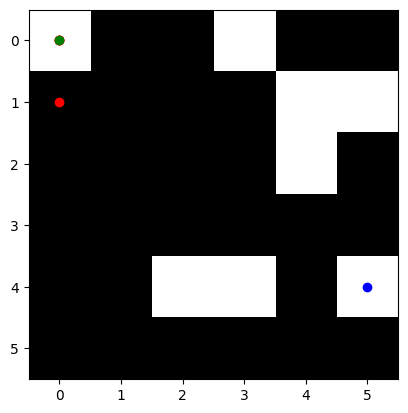

[0.9990931, 0.9991235, 0.9991844, 0.9991235]
 gamma 0.8
[0, 0, 0, -1]
[0.9990931, 0.9991235, 0.9991844, 0.9991235]
return [0.7992988109588623, 0.7993475437164307, 0.7992988109588623, -1.0]
gae [-0.19979430437088008, -0.1997759699821472, -0.19988561868667598, -1.9991235136985779]
0.8106343299015998
tensor([[ 4.,  4., -1.,  0.]])
tensor([[ 4.,  4., -1.,  0.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 2.,  4., 

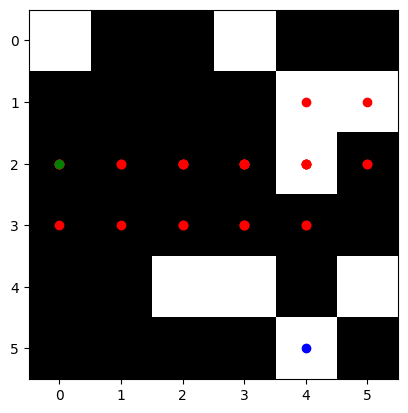

[0.99923545, 0.9988581, 0.9993437, 0.99893874, 0.99914026, 0.9991966, 0.9993428, 0.99937165, 0.99914026, 0.99937165, 0.9993437, 0.9988581, 0.99798876, 0.9975879, 0.99223465, 0.9922353, 0.99798876, 0.99893874, 0.9993437, 0.99893874, 0.99914026, 0.99893874, 0.99798876, 0.9922353, 0.99798876, 0.99893874, 0.99914026, 0.9991966, 0.99921703, 0.99932486, 0.99921703]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.99923545, 0.9988581, 0.9993437, 0.99893874, 0.99914026, 0.9991966, 0.9993428, 0.99937165, 0.99914026, 0.99937165, 0.9993437, 0.9988581, 0.99798876, 0.9975879, 0.99223465, 0.9922353, 0.99798876, 0.99893874, 0.9993437, 0.99893874, 0.99914026, 0.99893874, 0.99798876, 0.9922353, 0.99798876, 0.99893874, 0.99914026, 0.9991966, 0.99921703, 0.99932486, 0.99921703]
return [0.7990864753723145, 0.7994749546051025, 0.7991509914398194, 0.7993122100830079, 0.7993572711944581, 0.7994742393493652, 0.7994973182678223, 0.7993122100830079, 0.

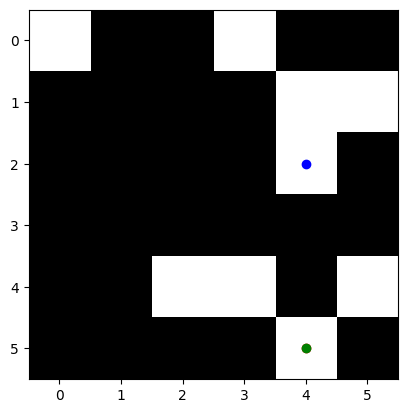

[0.8965027]
 gamma 0.8
[-1]
[0.8965027]
return [-1.0]
gae [-1.896502673625946]
0.7695415150174734
tensor([[2., 4., 0., 1.]])
tensor([[2., 4., 0., 1.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])


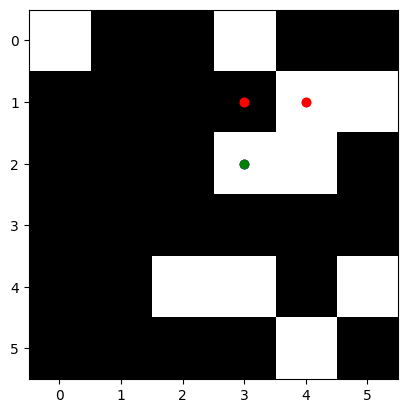

[0.77410465, 0.74221265, 0.7456538, 0.74221265, 0.7456538]
 gamma 0.8
[0, 0, 0, 0, 1]
[0.77410465, 0.74221265, 0.7456538, 0.74221265, 0.7456538]
return [0.5937701225280761, 0.5965230464935303, 0.5937701225280761, 0.5965230464935303, 1.0]
gae [-0.1803345322608948, -0.14568960666656494, -0.1518836855888367, -0.14568960666656494, 0.25434619188308716]
0.6747299350853135
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 0.,  1., -2., -2.]])
tensor([[ 0.,  1., -2., -2.]])


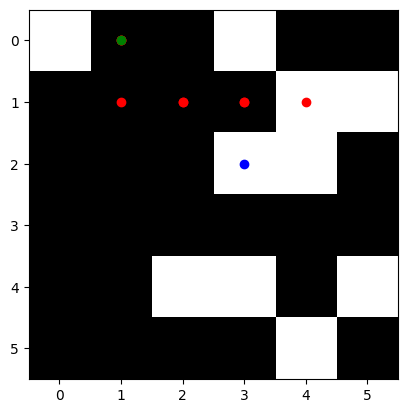

[0.7456538, 0.74221265, 0.7456538, 0.7476467, 0.7456538, 0.7476467, 0.7504964, 0.7507141]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.7456538, 0.74221265, 0.7456538, 0.7476467, 0.7456538, 0.7476467, 0.7504964, 0.7507141]
return [0.5937701225280761, 0.5965230464935303, 0.5981173515319824, 0.5965230464935303, 0.5981173515319824, 0.6003971099853516, 0.6005712985992432, -1.0]
gae [-0.1518836855888367, -0.14568960666656494, -0.14753645658493042, -0.15112364292144775, -0.14753645658493042, -0.14724957942962646, -0.14992508888244627, -1.750714123249054]
0.3589025709265413
tensor([[ 0.,  4., -2.,  1.]])
tensor([[ 0.,  5., -2.,  2.]])
tensor([[ 0.,  5., -2.,  2.]])
tensor([[ 1.,  5., -1.,  2.]])


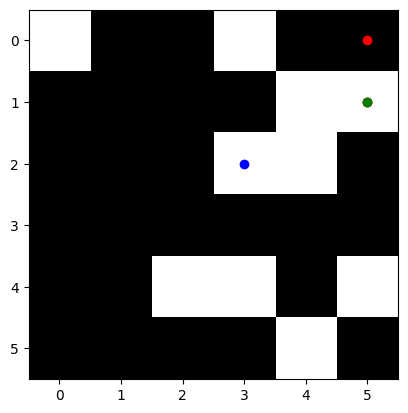

[0.7354621, 0.6872851, 0.720211]
 gamma 0.8
[0, 0, -1]
[0.7354621, 0.6872851, 0.720211]
return [0.5498281002044678, 0.5761688232421875, -1.0]
gae [-0.18563402891159053, -0.11111630201339717, -1.7202110290527344]
0.863223169842436
tensor([[ 1.,  0., -4., -2.]])
tensor([[ 1.,  0., -4., -2.]])
tensor([[ 0.,  0., -5., -2.]])
tensor([[ 0.,  0., -5., -2.]])


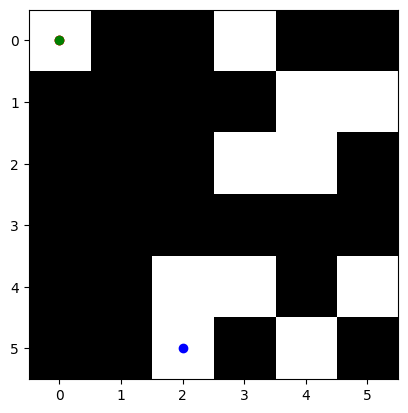

[0.75124353, 0.75612825]
 gamma 0.8
[0, -1]
[0.75124353, 0.75612825]
return [0.6049026012420655, -1.0]
gae [-0.14634093046188346, -1.7561282515525818]
0.9854846057301889
tensor([[ 3.,  0.,  3., -5.]])
tensor([[ 3.,  0.,  3., -5.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[4., 5., 4., 0.]])
tensor([[4., 5., 4., 0.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[4., 5., 4., 0.]])
tensor([[4., 5., 4., 0.]])
tensor([[5., 5., 5., 0.]])
tensor([[5., 

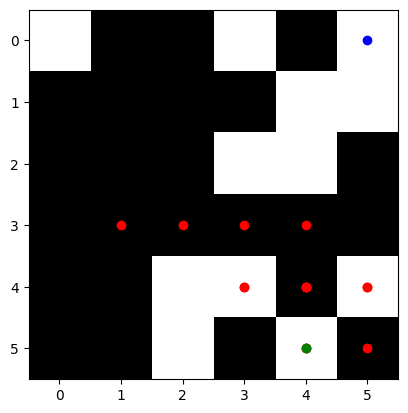

[0.84542114, 0.8441183, 0.84428877, 0.8459141, 0.8910438, 0.89212304, 0.8956804, 0.89212304, 0.84947515, 0.89212304, 0.8910438, 0.89212304, 0.8956804, 0.92162544, 0.9204691]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.84542114, 0.8441183, 0.84428877, 0.8459141, 0.8910438, 0.89212304, 0.8956804, 0.89212304, 0.84947515, 0.89212304, 0.8910438, 0.89212304, 0.8956804, 0.92162544, 0.9204691]
return [0.6752946376800537, 0.6754310131072998, 0.676731300354004, 0.7128350257873536, 0.713698434829712, 0.7165443420410157, 0.713698434829712, 0.6795801162719727, 0.713698434829712, 0.7128350257873536, 0.713698434829712, 0.7165443420410157, 0.7373003482818604, 0.7363752841949464, -1.0]
gae [-0.17012649774551392, -0.16868728399276733, -0.16755746603012078, -0.1330790996551513, -0.17734534740447994, -0.1755787014961242, -0.18198199272155757, -0.21254292726516721, -0.13577671051025386, -0.1792880177497863, -0.17734534740447994, -0.1755787014961242, -0.1583800792694091, -0.1852501511573790

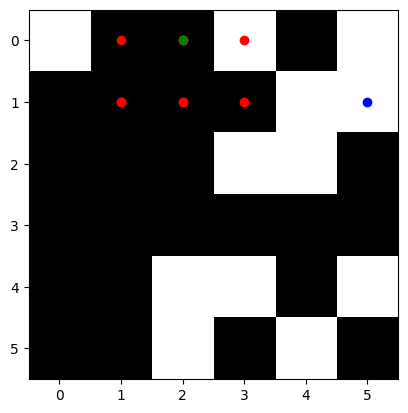

[0.75155324, 0.7484437, 0.75080836, 0.75401634, 0.7515598, 0.75401634, 0.75080836, 0.7511868, 0.75155324, 0.7511868]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.75155324, 0.7484437, 0.75080836, 0.75401634, 0.7515598, 0.75401634, 0.75080836, 0.7511868, 0.75155324, 0.7511868]
return [0.5987549781799316, 0.6006466865539551, 0.6032130718231201, 0.6012478351593018, 0.6032130718231201, 0.6006466865539551, 0.6009494304656983, 0.6012425899505616, 0.6009494304656983, -1.0]
gae [-0.15279825925827029, -0.1477970361709594, -0.14759528636932373, -0.15276850461959834, -0.14834672212600708, -0.153369653224945, -0.14985892772674558, -0.14994419813156123, -0.15060380697250364, -1.7511867880821228]
0.8830450888935428
tensor([[5., 5., 4., 3.]])
tensor([[5., 5., 4., 3.]])
tensor([[4., 5., 3., 3.]])
tensor([[4., 5., 3., 3.]])
tensor([[3., 5., 2., 3.]])
tensor([[3., 5., 2., 3.]])


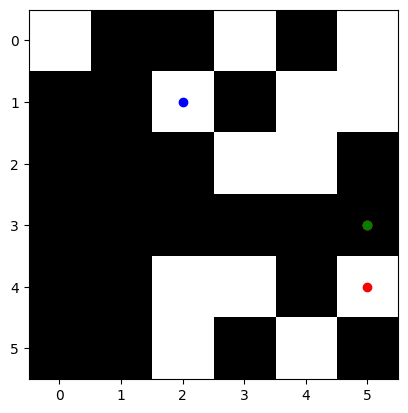

[0.9215854, 0.8978098, 0.8588437]
 gamma 0.8
[0, 0, -1]
[0.9215854, 0.8978098, 0.8588437]
return [0.7182478427886964, 0.6870749473571778, -1.0]
gae [-0.20333753824234002, -0.21073485612869258, -1.8588436841964722]
0.9881682942939816
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 1.,  5., -2.,  3.]])
tensor([[ 1.,  5., -2.,  3.]])
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[3., 4., 0., 2.]])
tensor([[3., 4., 0., 2.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 2.,  5., -1.,  3.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 2.,  3., -1.,  1.]])
tensor([[ 2.,  3., -1.,  1.]])
tensor([[3., 3., 0., 1.]])
tensor([[3., 3., 0., 1.]])
tensor([[4., 3., 1., 1.]])
tensor([[4., 3., 1., 1.]])
tensor([[4., 4., 1., 2.]])
tensor([[4., 4., 1., 2.]])
tensor([[4., 5., 1., 3.]])
tensor([[4., 5., 1., 3.]])


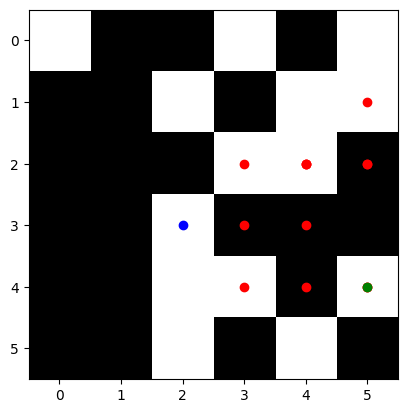

[0.7473807, 0.68965137, 0.7473807, 0.76431775, 0.82486355, 0.76431775, 0.7473807, 0.76431775, 0.7654402, 0.81620294, 0.8590261, 0.8706799, 0.8806285]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.7473807, 0.68965137, 0.7473807, 0.76431775, 0.82486355, 0.76431775, 0.7473807, 0.76431775, 0.7654402, 0.81620294, 0.8590261, 0.8706799, 0.8806285]
return [0.5517210960388184, 0.5979045391082763, 0.611454200744629, 0.6598908424377442, 0.611454200744629, 0.5979045391082763, 0.611454200744629, 0.6123521804809571, 0.6529623508453369, 0.6872208595275879, 0.6965439319610596, 0.7045028209686279, -1.0]
gae [-0.1956595778465271, -0.0917468309402466, -0.13592647314071649, -0.10442690849304193, -0.2134093523025512, -0.1664132118225098, -0.13592647314071649, -0.15196557044982906, -0.11247787475585935, -0.1289820790290832, -0.1624821424484253, -0.16617709398269653, -1.880628526210785]
return [0.71369845 0.71369845 0.71369845 0.71369845 0.71654433 0.71654433
 0.71824783 0.7363753  0.73730034 1.    

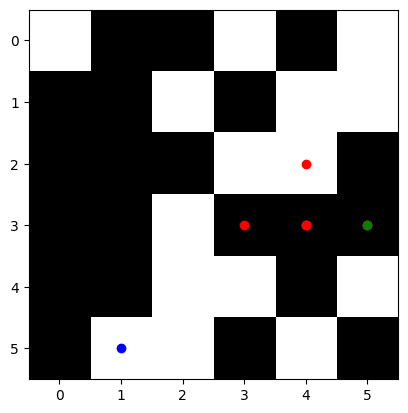

[0.60369045, 0.5732489, 0.56153166, 0.5732489, 0.5892028, 0.5732489, 0.60369045]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.60369045, 0.5732489, 0.56153166, 0.5732489, 0.5892028, 0.5732489, 0.60369045]
return [0.45859913825988774, 0.4492253303527832, 0.45859913825988774, 0.4713622570037842, 0.45859913825988774, 0.482952356338501, -1.0]
gae [-0.14509130716323848, -0.1240235924720764, -0.10293252468109126, -0.10188666582107542, -0.13060368299484248, -0.09029656648635864, -1.6036904454231262]
0.6443932795889297


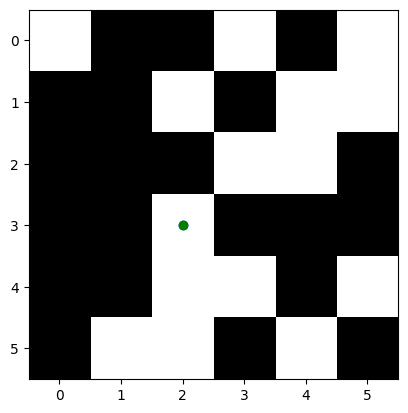

[0.60369045, 0.5732489, 0.56153166, 0.5732489, 0.5892028, 0.5732489, 0.60369045]
 gamma 0.8
[]
[0.60369045, 0.5732489, 0.56153166, 0.5732489, 0.5892028, 0.5732489, 0.60369045]
return []
gae []
0.012130327811482267
tensor([[ 2.,  5., -1.,  1.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  5., -3.,  1.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  5., -3.,  1.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 1.,  2., -2., -2.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 3.,  3.,  0., -1.]])


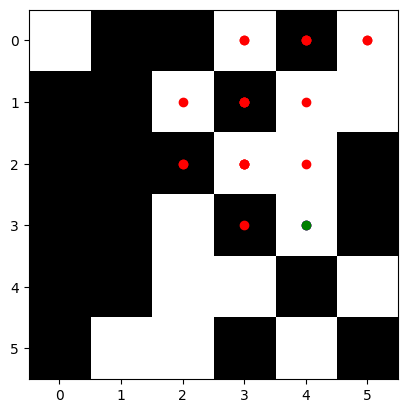

[0.5887259, 0.57764024, 0.59133816, 0.5910725, 0.56408, 0.5910725, 0.609852, 0.60129625, 0.5970785, 0.60129625, 0.5970785, 0.60129625, 0.609852, 0.5910725, 0.56408, 0.55852175, 0.5868913, 0.5910725, 0.56408, 0.55852175, 0.56408, 0.5556839]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.5887259, 0.57764024, 0.59133816, 0.5910725, 0.56408, 0.5910725, 0.609852, 0.60129625, 0.5970785, 0.60129625, 0.5970785, 0.60129625, 0.609852, 0.5910725, 0.56408, 0.55852175, 0.5868913, 0.5910725, 0.56408, 0.55852175, 0.56408, 0.5556839]
return [0.4621121883392334, 0.4730705261230469, 0.4728579998016358, 0.4512639999389649, 0.4728579998016358, 0.48788161277770997, 0.4810369968414307, 0.4776628017425537, 0.4810369968414307, 0.4776628017425537, 0.4810369968414307, 0.48788161277770997, 0.4728579998016358, 0.4512639999389649, 0.44681739807128906, 0.4695130348205567, 0.4728579998016358, 0.4512639999389649, 0.44681739807128906, 0.4512639999389649, 0.4445471286773682, 1.0]
gae [

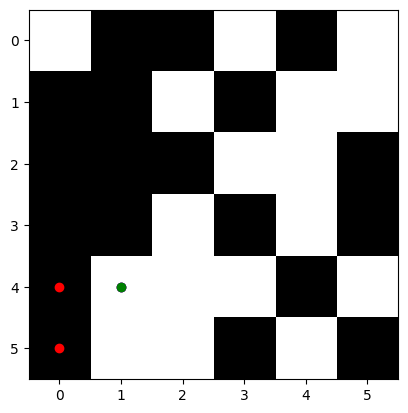

[0.5859893, 0.6097138, 0.5859893]
 gamma 0.8
[0, 0, 1]
[0.5859893, 0.6097138, 0.5859893]
return [0.48777103424072266, 0.46879143714904786, 1.0]
gae [-0.09821826219558716, -0.14092235565185546, 0.4140107035636902]
0.4781318723497334
tensor([[ 1.,  5., -1.,  4.]])


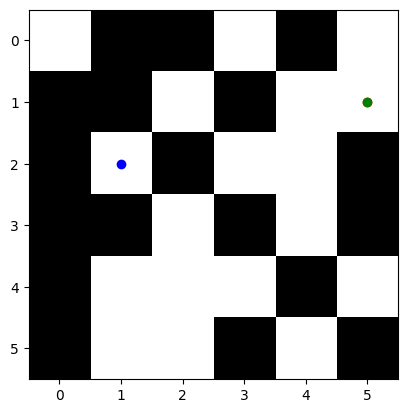

[0.578635]
 gamma 0.8
[-1]
[0.578635]
return [-1.0]
gae [-1.5786349773406982]
0.8564033380869736
tensor([[1., 4., 0., 4.]])
tensor([[1., 3., 0., 3.]])
tensor([[1., 3., 0., 3.]])
tensor([[ 0.,  3., -1.,  3.]])
tensor([[ 0.,  3., -1.,  3.]])
tensor([[1., 3., 0., 3.]])
tensor([[1., 3., 0., 3.]])
tensor([[1., 2., 0., 2.]])
tensor([[1., 2., 0., 2.]])
tensor([[ 0.,  2., -1.,  2.]])
tensor([[ 0.,  2., -1.,  2.]])


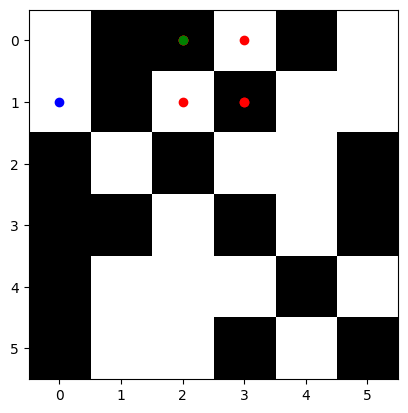

[0.57388496, 0.5771929, 0.57799196, 0.5771929, 0.5689445, 0.5844825]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.57388496, 0.5771929, 0.57799196, 0.5771929, 0.5689445, 0.5844825]
return [0.46175432205200195, 0.4623935699462891, 0.46175432205200195, 0.455155611038208, 0.46758599281311036, -1.0]
gae [-0.11213064193725586, -0.11479933261871333, -0.11623764038085938, -0.12203729152679443, -0.10135852098464965, -1.584482491016388]
0.047706027749103375
tensor([[ 2.,  3., -2.,  3.]])
tensor([[ 1.,  3., -3.,  3.]])
tensor([[ 0.,  3., -4.,  3.]])


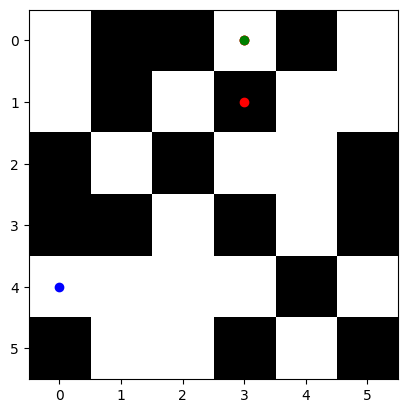

[0.5663632, 0.5820204, 0.5822717]
 gamma 0.8
[0, 0, -1]
[0.5663632, 0.5820204, 0.5822717]
return [0.46561632156372074, 0.46581735610961916, -1.0]
gae [-0.10074689388275143, -0.11620304584503172, -1.582271695137024]
0.7051117002105454
tensor([[1., 4., 1., 4.]])
tensor([[1., 5., 1., 5.]])
tensor([[0., 5., 0., 5.]])


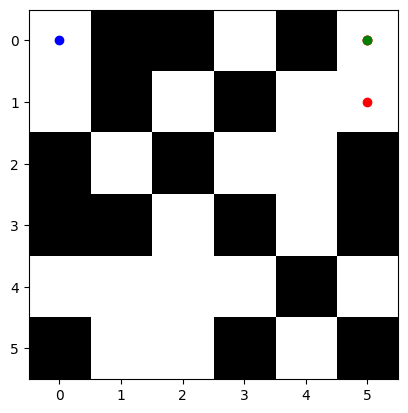

[0.569925, 0.5295673, 0.4792705]
 gamma 0.8
[0, 0, -1]
[0.569925, 0.5295673, 0.4792705]
return [0.42365384101867676, 0.3834163904190064, -1.0]
gae [-0.14627116918563843, -0.14615091085433957, -1.479270488023758]
0.06495214616534506
tensor([[ 0.,  1., -4., -1.]])
tensor([[ 0.,  2., -4.,  0.]])


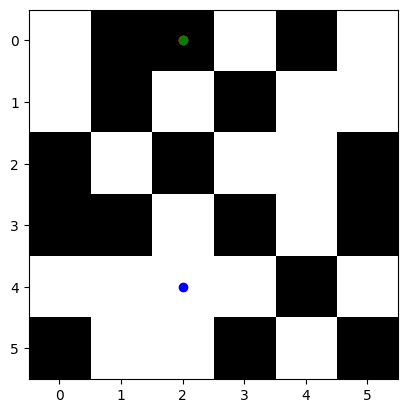

[0.60551894, 0.6033498]
 gamma 0.8
[0, -1]
[0.60551894, 0.6033498]
return [0.4826798439025879, -1.0]
gae [-0.12283909320831299, -1.6033498048782349]
0.28650800195406445
tensor([[5., 3., 5., 0.]])
tensor([[ 5.,  2.,  5., -1.]])
tensor([[ 5.,  2.,  5., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  0.,  2., -3.]])


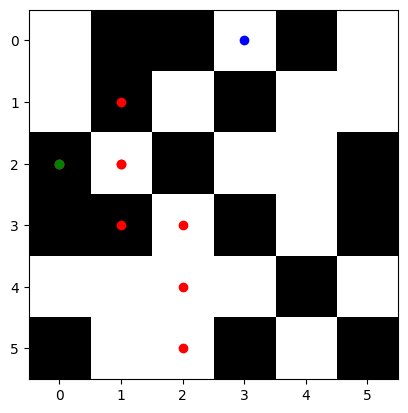

[0.6135974, 0.6145982, 0.59804904, 0.56958646, 0.57215846, 0.5598417, 0.56800205, 0.5598417, 0.56636846]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.6135974, 0.6145982, 0.59804904, 0.56958646, 0.57215846, 0.5598417, 0.56800205, 0.5598417, 0.56636846]
return [0.49167857170104984, 0.4784392356872559, 0.4556691646575928, 0.4577267646789551, 0.4478733539581299, 0.45440163612365725, 0.4478733539581299, 0.45309476852416997, -1.0]
gae [-0.12191882133483883, -0.13615897893905637, -0.14237987995147705, -0.11185969114303584, -0.12428510189056396, -0.1054400563240051, -0.12012869119644165, -0.10674692392349239, -1.5663684606552124]
return [0.481037   0.481037   0.48267984 0.48295236 0.48777103 0.4878816
 0.4878816  0.49167857 1.         1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.          0.38341638  0.42365384  0.44454712]

-------------------- Iteration #4 --------------------
random  0.28650800195406445
Average : 0.01
Average Episodic Return: -0.65
M

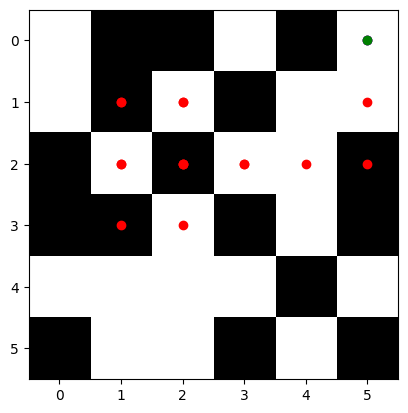

[0.43310556, 0.4275382, 0.43310556, 0.42153952, 0.40177134, 0.39004478, 0.40177134, 0.3920053, 0.41109633, 0.42153952, 0.43310556, 0.4275382, 0.40177134, 0.39004478, 0.39238766, 0.39479405, 0.39604178]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.43310556, 0.4275382, 0.43310556, 0.42153952, 0.40177134, 0.39004478, 0.40177134, 0.3920053, 0.41109633, 0.42153952, 0.43310556, 0.4275382, 0.40177134, 0.39004478, 0.39238766, 0.39479405, 0.39604178]
return [0.34203054904937746, 0.34648444652557375, 0.3372316122055054, 0.32141706943511966, 0.3120358228683472, 0.32141706943511966, 0.3136042356491089, 0.328877067565918, 0.3372316122055054, 0.34648444652557375, 0.34203054904937746, 0.32141706943511966, 0.3120358228683472, 0.3139101266860962, 0.31583523750305176, 0.3168334245681763, 1.0]
gae [-0.0910750091075897, -0.08105373978614805, -0.09587394595146176, -0.10012244582176205, -0.08973551392555235, -0.0686277091503143, -0.08816710114479065, -0.0631282269954681, -0.073864722251

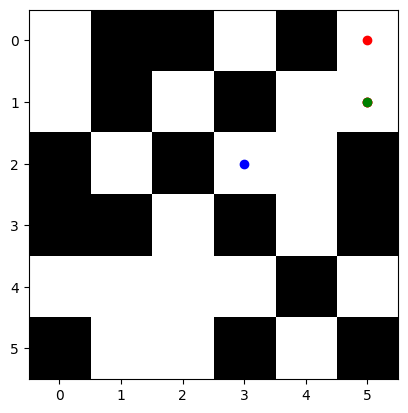

[0.41435513, 0.42165816, 0.41435513]
 gamma 0.8
[0, 0, -1]
[0.41435513, 0.42165816, 0.41435513]
return [0.3373265266418457, 0.33148410320281985, -1.0]
gae [-0.07702860236167908, -0.09017405509948728, -1.4143551290035248]
0.3167542373602924
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 0.,  3., -5., -2.]])


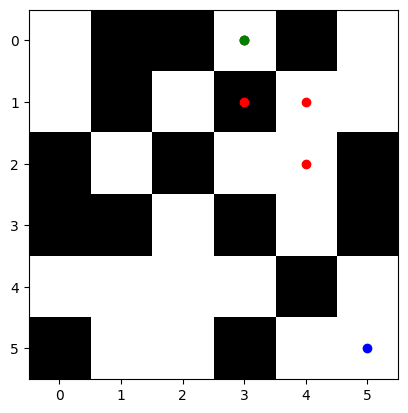

[0.40875268, 0.40106562, 0.40875268, 0.41596827, 0.4313453]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.40875268, 0.40106562, 0.40875268, 0.41596827, 0.4313453]
return [0.32085249423980716, 0.3270021438598633, 0.3327746152877808, 0.3450762510299683, -1.0]
gae [-0.08790018558502194, -0.0740634739398956, -0.0759780645370483, -0.07089201807975765, -1.4313453137874603]
0.14419998057366368
tensor([[4., 5., 1., 2.]])
tensor([[4., 4., 1., 1.]])
tensor([[4., 3., 1., 0.]])
tensor([[ 4.,  2.,  1., -1.]])
tensor([[ 3.,  2.,  0., -1.]])
tensor([[ 2.,  2., -1., -1.]])
tensor([[ 3.,  2.,  0., -1.]])
tensor([[ 2.,  2., -1., -1.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 1.,  1., -2., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 2.,  2., -1., -1.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 4.,  1.,  1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  2.,  0., -1.]])


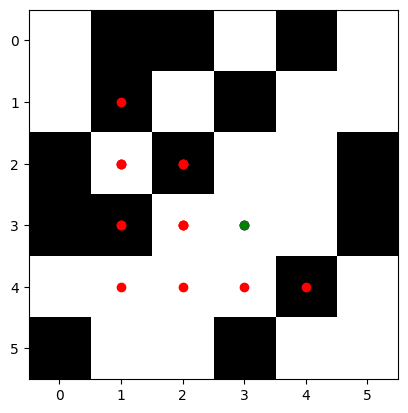

[0.418975, 0.4056675, 0.39550933, 0.39068216, 0.38297224, 0.3856869, 0.38297224, 0.3856869, 0.40550223, 0.42529497, 0.40550223, 0.3856869, 0.40550223, 0.39288506, 0.39144304, 0.39288506, 0.38297224]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.418975, 0.4056675, 0.39550933, 0.39068216, 0.38297224, 0.3856869, 0.38297224, 0.3856869, 0.40550223, 0.42529497, 0.40550223, 0.3856869, 0.40550223, 0.39288506, 0.39144304, 0.39288506, 0.38297224]
return [0.324534010887146, 0.31640746593475344, 0.3125457286834717, 0.30637779235839846, 0.30854952335357666, 0.30637779235839846, 0.30854952335357666, 0.3244017839431763, 0.34023597240448, 0.3244017839431763, 0.30854952335357666, 0.3244017839431763, 0.3143080472946167, 0.3131544351577759, 0.3143080472946167, 0.30637779235839846, 1.0]
gae [-0.09444098472595214, -0.08926004767417905, -0.08296360373497008, -0.08430436849594114, -0.07442271709442139, -0.07930911183357237, -0.07442271709442139, -0.06128512024879451, -0.06526625752449033,

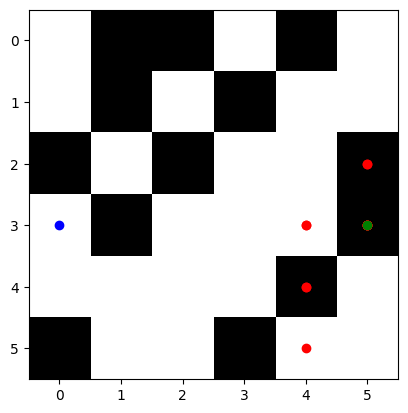

[0.45594287, 0.43739617, 0.44912162, 0.43739617, 0.4040193, 0.44394577, 0.4700767, 0.44394577, 0.4700767, 0.44394577, 0.4040193, 0.44394577]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.45594287, 0.43739617, 0.44912162, 0.43739617, 0.4040193, 0.44394577, 0.4700767, 0.44394577, 0.4700767, 0.44394577, 0.4040193, 0.44394577]
return [0.349916934967041, 0.3592972993850708, 0.349916934967041, 0.3232154369354248, 0.35515661239624025, 0.37606136798858647, 0.35515661239624025, 0.37606136798858647, 0.35515661239624025, 0.3232154369354248, 0.35515661239624025, -1.0]
gae [-0.10602593421936035, -0.07809886932373045, -0.09920468926429749, -0.11418073177337645, -0.04886268377304076, -0.06788439750671382, -0.11492009758949279, -0.06788439750671382, -0.11492009758949279, -0.12073032855987548, -0.04886268377304076, -1.4439457654953003]
return [0.34991693 0.3551566  0.3551566  0.3551566  0.3551566  0.3592973
 0.37606138 0.37606138 1.         1.        ]
return [-1.         -1.         -1.         

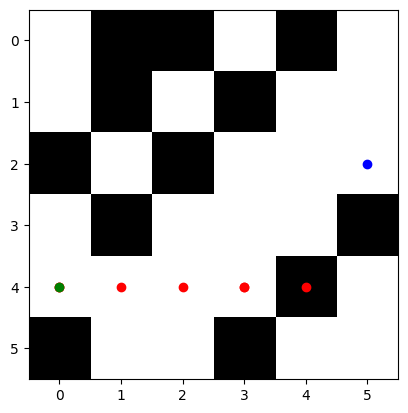

[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403]
return [0.24473388195037843, 0.2489267110824585, 0.24473388195037843, 0.24496290683746338, 0.25816705226898196, 0.26600322723388675, -1.0]
gae [-0.06642450690269469, -0.056990641355514515, -0.06642450690269469, -0.06095444560050964, -0.04803658127784727, -0.056705588102340665, -1.3325040340423584]
0.9312285592375197
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 2.,  1.,  2., -4.]])
tensor([[ 2.,  1.,  2., -4.]])
tensor([[ 2.,  0.,  2., -5.]])
tensor([[ 2.,  0.,  2., -5.]])


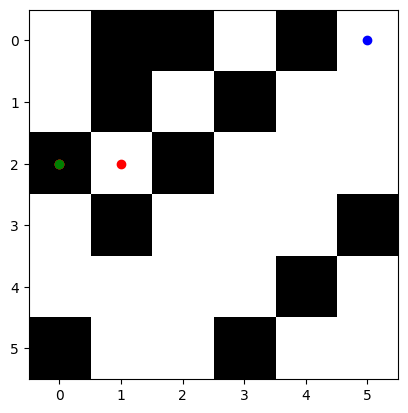

[0.28601933, 0.2938256, 0.2964554]
 gamma 0.8
[0, 0, -1]
[0.28601933, 0.2938256, 0.2964554]
return [0.23506047725677492, 0.23716433048248292, -1.0]
gae [-0.05095884799957273, -0.05666126608848571, -1.2964554131031036]
0.867798444117167


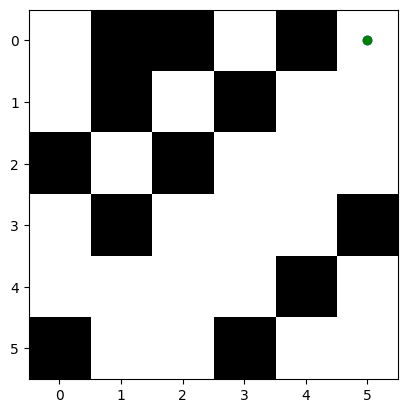

[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403, 0.28601933, 0.2938256, 0.2964554]
 gamma 0.8
[]
[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403, 0.28601933, 0.2938256, 0.2964554]
return []
gae []
0.9012577610054946
tensor([[ 1.,  0., -1., -5.]])
tensor([[ 1.,  0., -1., -5.]])
tensor([[ 2.,  0.,  0., -5.]])
tensor([[ 2.,  0.,  0., -5.]])


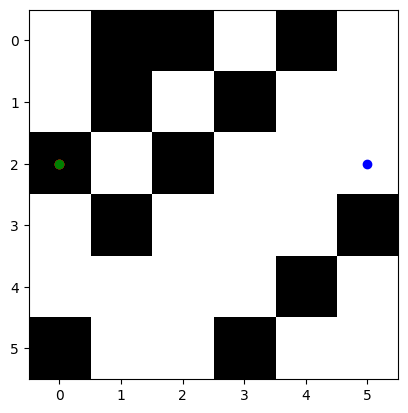

[0.269745, 0.3007307]
 gamma 0.8
[0, -1]
[0.269745, 0.3007307]
return [0.24058456420898439, -1.0]
gae [-0.029160428047180165, -1.3007307052612305]
0.15176657269586447


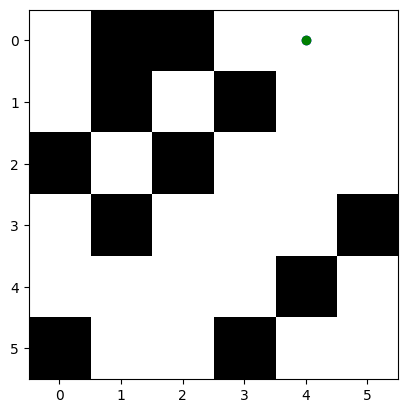

[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403, 0.28601933, 0.2938256, 0.2964554, 0.269745, 0.3007307]
 gamma 0.8
[]
[0.3111584, 0.30591735, 0.3111584, 0.30591735, 0.30620363, 0.32270882, 0.33250403, 0.28601933, 0.2938256, 0.2964554, 0.269745, 0.3007307]
return []
gae []
0.7912624901816087
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 0.,  2., -2., -1.]])
tensor([[ 0.,  2., -2., -1.]])


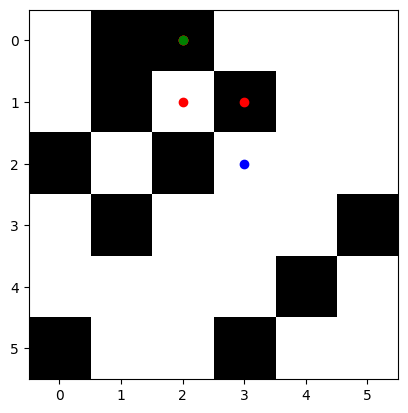

[0.23246586, 0.20618363, 0.23246586, 0.23086534]
 gamma 0.8
[0, 0, 0, -1]
[0.23246586, 0.20618363, 0.23246586, 0.23086534]
return [0.1649469017982483, 0.1859726905822754, 0.18469227552413942, -1.0]
gae [-0.06751896142959593, -0.020210936665534973, -0.04777358770370482, -1.2308653444051743]
0.12381154067022837
tensor([[2., 4., 2., 4.]])
tensor([[2., 5., 2., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[4., 5., 4., 5.]])
tensor([[5., 5., 5., 5.]])
tensor([[5., 4., 5., 4.]])
tensor([[5., 4., 5., 4.]])
tensor([[5., 5., 5., 5.]])
tensor([[5., 4., 5., 4.]])


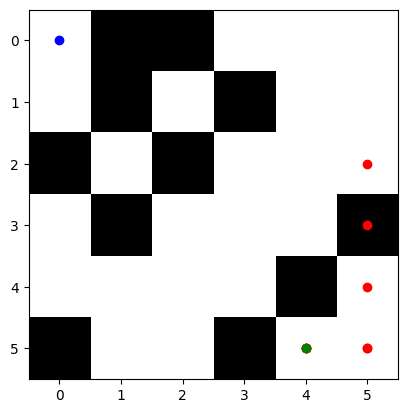

[0.23503211, 0.24789092, 0.33049732, 0.36289787, 0.3569615, 0.35908395, 0.3569615, 0.35908395]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.23503211, 0.24789092, 0.33049732, 0.36289787, 0.3569615, 0.35908395, 0.3569615, 0.35908395]
return [0.19831273555755616, 0.26439785957336426, 0.29031829833984374, 0.2855691909790039, 0.2872671604156494, 0.2855691909790039, 0.2872671604156494, -1.0]
gae [-0.036719375848770136, 0.016506940126419067, -0.04017902612686158, -0.07732868194580078, -0.06969432830810546, -0.07351475954055786, -0.06969432830810546, -1.3590839505195618]
0.4683723028862158
tensor([[0., 5., 0., 5.]])


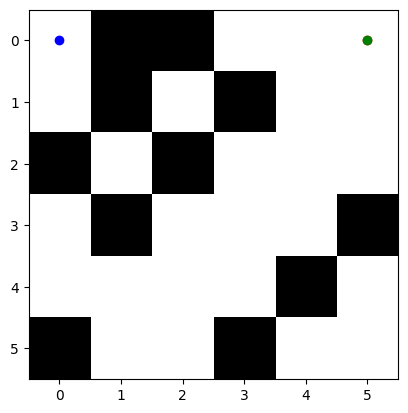

[0.3252977]
 gamma 0.8
[-1]
[0.3252977]
return [-1.0]
gae [-1.3252977132797241]
0.5927092539834418
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 3.,  2.,  3., -2.]])
tensor([[ 3.,  2.,  3., -2.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 4.,  2.,  4., -2.]])
tensor([[ 4.,  2.,  4., -2.]])
tensor([[ 5.,  2.,  5., -2.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 3.,  2.,  3., -2.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  3., -1.]])
tensor([[3., 4., 3., 0.]])
tensor([[3., 4., 3., 0.]])
tensor([[2., 4., 2., 0.]])
tensor([[1., 4., 1., 0.]])
tensor([[1., 4., 1., 0.]])
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  2., -1.]])
tensor([[ 2.,  3.,  2.

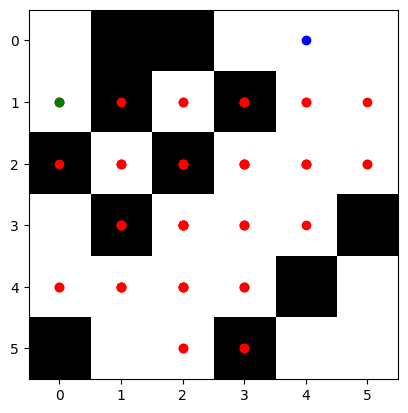

[0.29161102, 0.30274907, 0.29161102, 0.33911157, 0.3289908, 0.3555309, 0.35820955, 0.33911157, 0.35820955, 0.33911157, 0.29161102, 0.30274907, 0.29161102, 0.2889233, 0.23438951, 0.20447187, 0.22482578, 0.2545077, 0.23438951, 0.21590196, 0.23438951, 0.21590196, 0.20814645, 0.20447187, 0.22482578, 0.2545077, 0.22482578, 0.2545077, 0.2838156, 0.30274907, 0.3289908, 0.33514595, 0.3239203, 0.30274907, 0.3289908, 0.3555309, 0.3289908, 0.33514595, 0.3397571, 0.33514595, 0.3397571, 0.33514595, 0.3239203, 0.29780507, 0.2838156, 0.29780507, 0.3239203, 0.30274907, 0.2838156, 0.25760067, 0.22482578, 0.2545077, 0.2838156, 0.25760067, 0.27458164, 0.29780507, 0.30237663, 0.2789088]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.29161102, 0.30274907, 0.29161102, 0.33911157, 0.3289908, 0.3555309, 0.35820955, 0.33911157, 0.35820955, 0.33911157, 0.29161102, 0.3027

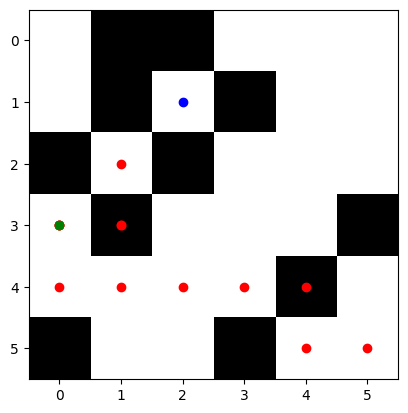

[0.19894168, 0.21255909, 0.19894168, 0.22011542, 0.17354655, 0.16863312, 0.1706825, 0.1839487, 0.18251486, 0.17399387, 0.21175104, 0.17399387, 0.18251486]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.19894168, 0.21255909, 0.19894168, 0.22011542, 0.17354655, 0.16863312, 0.1706825, 0.1839487, 0.18251486, 0.17399387, 0.21175104, 0.17399387, 0.18251486]
return [0.17004727125167848, 0.15915334224700928, 0.17609233856201173, 0.13883724212646484, 0.13490649461746215, 0.13654600381851198, 0.14715895652770997, 0.14601188898086548, 0.13919509649276735, 0.16940083503723147, 0.13919509649276735, 0.14601188898086548, -1.0]
gae [-0.028894406557083113, -0.053405746817588806, -0.022849339246749867, -0.08127818107604981, -0.0386400580406189, -0.03208711445331572, -0.023523548245429987, -0.03793680667877197, -0.0433197647333145, -0.0045930355787277, -0.07255594730377196, -0.02798198163509369, -1.1825148612260818]
0.1523117597873005
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 4.,  3., -1.,  1.]])


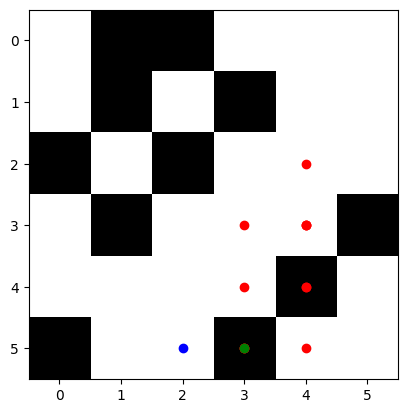

[0.21820943, 0.24752751, 0.24681698, 0.22853601, 0.23221327, 0.22853601, 0.22537215, 0.22853601, 0.23221327, 0.21916507, 0.19064294]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.21820943, 0.24752751, 0.24681698, 0.22853601, 0.23221327, 0.22853601, 0.22537215, 0.22853601, 0.23221327, 0.21916507, 0.19064294]
return [0.1980220079421997, 0.19745358228683474, 0.18282880783081057, 0.18577061891555788, 0.18282880783081057, 0.1802977204322815, 0.18282880783081057, 0.18577061891555788, 0.17533205747604372, 0.15251435041427613, -1.0]
gae [-0.02018742263317108, -0.050073927640914895, -0.06398817002773283, -0.042765390872955306, -0.04938446581363676, -0.04823828935623167, -0.0425433427095413, -0.042765390872955306, -0.05688121616840361, -0.06665072143077849, -1.1906429380178452]
0.17222857731901753
tensor([[ 0.,  4., -3.,  2.]])
tensor([[ 1.,  4., -2.,  2.]])
tensor([[ 2.,  4., -1.,  2.]])
tensor([[ 1.,  4., -2.,  2.]])
tensor([[ 0.,  4., -3.,  2.]])
tensor([[ 0.,  5., -3.,  3.]])
tensor([[ 0.

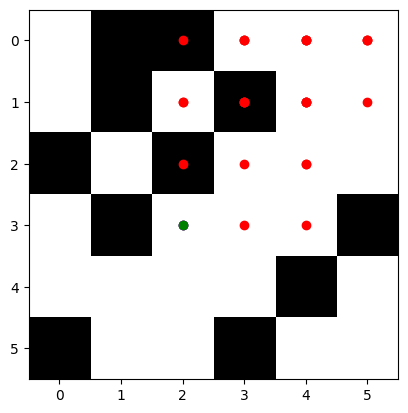

[0.21823558, 0.22695936, 0.23216376, 0.22695936, 0.21823558, 0.21703982, 0.21823558, 0.21703982, 0.22302733, 0.21703982, 0.21823558, 0.2256034, 0.2408463, 0.2256034, 0.2408463, 0.22695936, 0.2408463, 0.26087254, 0.2408463, 0.25140938, 0.26577088, 0.26087254, 0.24660003, 0.2256034, 0.21823558, 0.22695936, 0.23216376, 0.23592696, 0.2562543]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.21823558, 0.22695936, 0.23216376, 0.22695936, 0.21823558, 0.21703982, 0.21823558, 0.21703982, 0.22302733, 0.21703982, 0.21823558, 0.2256034, 0.2408463, 0.2256034, 0.2408463, 0.22695936, 0.2408463, 0.26087254, 0.2408463, 0.25140938, 0.26577088, 0.26087254, 0.24660003, 0.2256034, 0.21823558, 0.22695936, 0.23216376, 0.23592696, 0.2562543]
return [0.1815674901008606, 0.18573100566864015, 0.1815674901008606, 0.17458846569061282, 0.1736318588256836, 0.17458846569061282, 0.1736318588256836, 0.17842186689376832, 0.1736318588256836, 0.17458846569061282, 0.1804

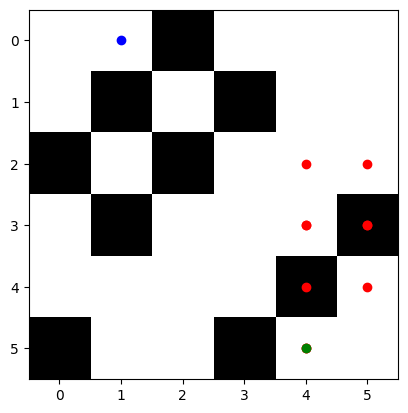

[0.03467938, -0.020135118, -0.096452564, -0.093940064, -0.038603216, -0.024923496, -0.038603216, -0.020135118, 0.03467938, 0.030947002]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.03467938, -0.020135118, -0.096452564, -0.093940064, -0.038603216, -0.024923496, -0.038603216, -0.020135118, 0.03467938, 0.030947002]
return [-0.016108094155788424, -0.07716205120086671, -0.07515205144882203, -0.030882573127746584, -0.019938796758651733, -0.030882573127746584, -0.016108094155788424, 0.02774350345134735, 0.02475760132074356, -1.0]
gae [-0.050787473469972616, -0.05702693350613118, 0.02130051255226134, 0.06305749118328094, 0.018664419651031494, -0.005959077179431917, 0.022495122253894804, 0.04787862114608288, -0.009921777993440628, -1.0309470016509295]
0.08836762343391014
tensor([[ 1.,  5., -2.,  5.]])
tensor([[ 0.,  5., -3.,  5.]])
tensor([[ 0.,  4., -3.,  4.]])
tensor([[ 0.,  3., -3.,  3.]])
tensor([[ 0.,  2., -3.,  2.]])
tensor([[ 1.,  2., -2.,  2.]])
tensor([[ 0.,  2., -3.,  2.]])
tensor([[

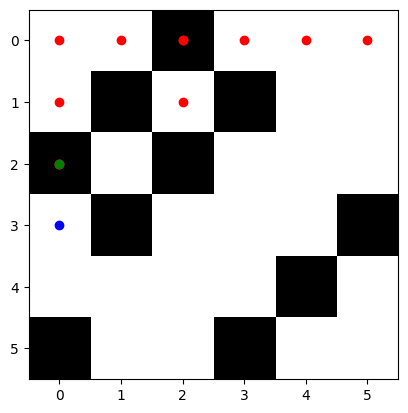

[-0.102680765, -0.099546805, -0.11081597, -0.1151026, -0.111550264, -0.102172494, -0.111550264, -0.098679975, -0.062147945, -0.040247176, -0.018486144]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.102680765, -0.099546805, -0.11081597, -0.1151026, -0.111550264, -0.102172494, -0.111550264, -0.098679975, -0.062147945, -0.040247176, -0.018486144]
return [-0.07963744401931763, -0.08865277767181397, -0.09208207726478577, -0.08924021124839783, -0.08173799514770508, -0.08924021124839783, -0.07894397974014283, -0.04971835613250733, -0.032197740674018864, -0.01478891521692276, -1.0]
gae [0.023043321073055262, 0.010894027352333066, 0.01873389482498168, 0.02586238533258438, 0.029812268912792206, 0.012932282686233518, 0.03260628432035445, 0.0489616185426712, 0.02995020449161529, 0.025458260625600814, -0.9815138559788465]
0.9958888968801908
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  2.,  0., -3.]])
tensor([[ 4.,  2.,  0., -3.]])
tensor([[ 4.,  3.,  0., -2.]])
t

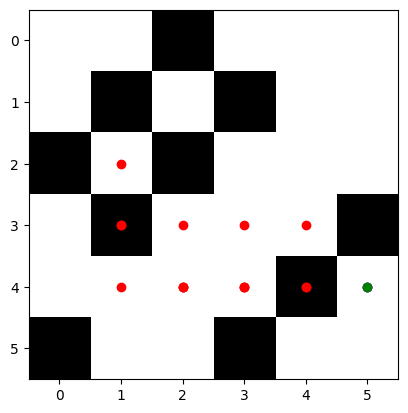

[-0.041595913, -0.014474833, -0.0005676522, -0.006641469, -0.051754326, -0.0121578695, -0.017841227, -0.03826293, -0.054727, -0.03826293, -0.041595913, -0.014474833, -0.0005676522, -0.014474833, -0.0005676522, -0.006641469]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.041595913, -0.014474833, -0.0005676522, -0.006641469, -0.051754326, -0.0121578695, -0.017841227, -0.03826293, -0.054727, -0.03826293, -0.041595913, -0.014474833, -0.0005676522, -0.014474833, -0.0005676522, -0.006641469]
return [-0.011579866707324983, -0.00045412178151309495, -0.005313175171613694, -0.041403460502624514, -0.009726295620203019, -0.014272981882095338, -0.03061034381389618, -0.04378159940242768, -0.03061034381389618, -0.03327673077583313, -0.011579866707324983, -0.00045412178151309495, -0.011579866707324983, -0.00045412178151309495, -0.005313175171613694, 1.0]
gae [0.030016046762466428, 0.014020711602643132, -0.004745522944722325, -0.0347619915381074, 0.04202803000807762, -0.002115112356841

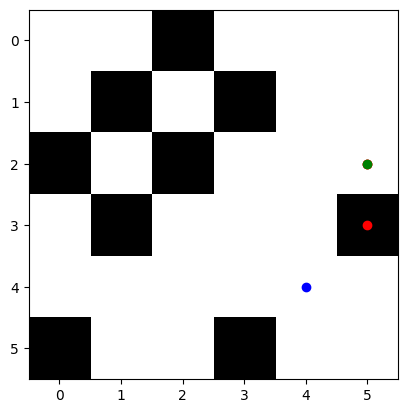

[-0.11127498, -0.09280575, -0.11127498]
 gamma 0.8
[0, 0, -1]
[-0.11127498, -0.09280575, -0.11127498]
return [-0.07424460053443908, -0.08901998400688171, -1.0]
gae [0.03703037947416306, 0.0037857666611671448, -0.8887250199913979]
0.4051379599401129
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  3., -3., -1.]])


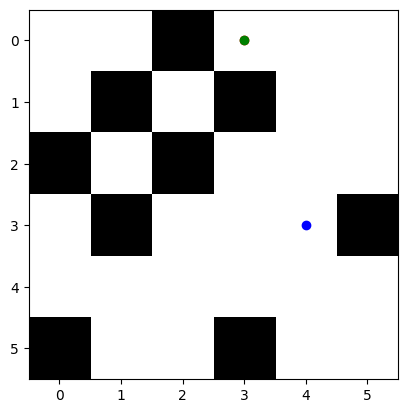

[-0.11225171]
 gamma 0.8
[-1]
[-0.11225171]
return [-1.0]
gae [-0.8877482935786247]
0.0038119825413502895
tensor([[1., 3., 1., 0.]])
tensor([[1., 4., 1., 1.]])
tensor([[2., 4., 2., 1.]])
tensor([[1., 4., 1., 1.]])
tensor([[0., 4., 0., 1.]])
tensor([[1., 4., 1., 1.]])
tensor([[1., 5., 1., 2.]])
tensor([[0., 5., 0., 2.]])
tensor([[1., 5., 1., 2.]])


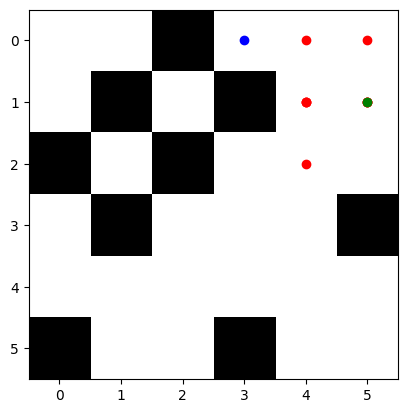

[-0.067726575, -0.112908125, -0.08323188, -0.112908125, -0.11519704, -0.112908125, -0.117366135, -0.11616525, -0.117366135]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.067726575, -0.112908125, -0.08323188, -0.112908125, -0.11519704, -0.112908125, -0.117366135, -0.11616525, -0.117366135]
return [-0.09032649993896485, -0.06658550500869752, -0.09032649993896485, -0.09215763211250305, -0.09032649993896485, -0.09389290809631348, -0.09293220043182374, -0.09389290809631348, -1.0]
gae [-0.022599925100803386, 0.04632261991500854, -0.007094618678092968, 0.020750492811203003, 0.02487054020166396, 0.019015216827392573, 0.02443393468856811, 0.02227234244346618, -0.8826338648796082]
return [-1.15798665e-02 -9.72629525e-03 -5.31317526e-03 -5.31317526e-03
 -4.54121793e-04 -4.54121793e-04 -4.54121793e-04  2.47576013e-02
  2.77435035e-02  1.00000000e+00]
return [-1.         -1.         -1.         -1.         -1.         -0.09389291
 -0.09389291 -0.0929322  -0.09215763 -0.09208208]

--------------------

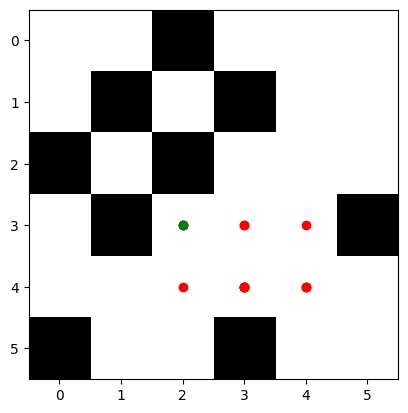

[-0.434239, -0.43214682, -0.42358154, -0.3881773, -0.42358154, -0.43214682, -0.3934853, -0.43214682, -0.3934853, -0.43214682, -0.3934853, -0.43214682, -0.44535044]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.434239, -0.43214682, -0.42358154, -0.3881773, -0.42358154, -0.43214682, -0.3934853, -0.43214682, -0.3934853, -0.43214682, -0.3934853, -0.43214682, -0.44535044]
return [-0.345717453956604, -0.3388652324676514, -0.310541844367981, -0.3388652324676514, -0.345717453956604, -0.3147882461547852, -0.345717453956604, -0.3147882461547852, -0.345717453956604, -0.3147882461547852, -0.345717453956604, -0.35628035068511965, 1.0]
gae [0.08852154612541197, 0.09328158497810363, 0.11303969621658322, 0.04931207299232482, 0.07786408662796018, 0.11735857129096983, 0.04776785373687742, 0.11735857129096983, 0.04776785373687742, 0.11735857129096983, 0.04776785373687742, 0.07586646676063535, 1.4453504383563995]
0.6009313985072889
tensor([[ 3.,  5., -2.,  2.]])
tensor([[ 3.,  5., -2.,  2.]])


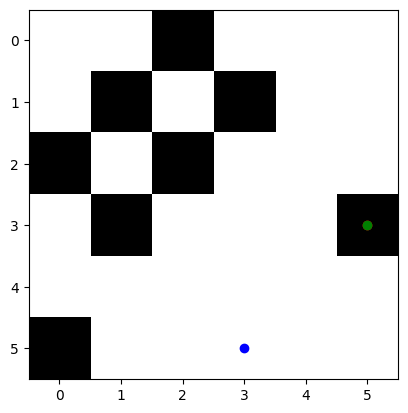

[-0.37197542]
 gamma 0.8
[-1]
[-0.37197542]
return [-1.0]
gae [-0.6280245780944824]
0.17906011594868165
tensor([[ 0.,  1., -3., -1.]])
tensor([[ 0.,  2., -3.,  0.]])
tensor([[ 0.,  1., -3., -1.]])
tensor([[ 0.,  1., -3., -1.]])
tensor([[ 0.,  2., -3.,  0.]])
tensor([[ 1.,  2., -2.,  0.]])
tensor([[ 0.,  2., -3.,  0.]])
tensor([[ 1.,  2., -2.,  0.]])
tensor([[ 1.,  1., -2., -1.]])
tensor([[ 1.,  2., -2.,  0.]])
tensor([[ 1.,  2., -2.,  0.]])
tensor([[ 1.,  3., -2.,  1.]])
tensor([[ 1.,  4., -2.,  2.]])
tensor([[ 1.,  5., -2.,  3.]])
tensor([[ 0.,  5., -3.,  3.]])


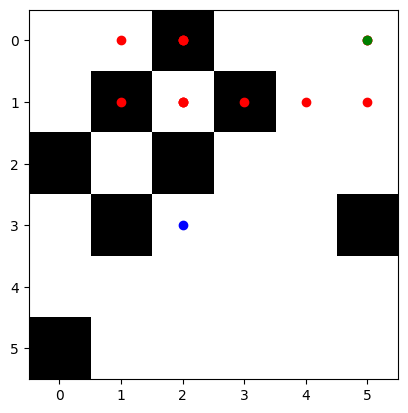

[-0.40431884, -0.37826973, -0.40431884, -0.37826973, -0.3914657, -0.37826973, -0.3914657, -0.41348213, -0.3914657, -0.37124875, -0.35912484, -0.34407663, -0.33357656]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.40431884, -0.37826973, -0.40431884, -0.37826973, -0.3914657, -0.37826973, -0.3914657, -0.41348213, -0.3914657, -0.37124875, -0.35912484, -0.34407663, -0.33357656]
return [-0.3026157855987549, -0.3234550714492798, -0.3026157855987549, -0.31317255496978763, -0.3026157855987549, -0.31317255496978763, -0.33078570365905763, -0.31317255496978763, -0.29699900150299074, -0.28729987144470215, -0.27526130676269533, -0.2668612480163574, -1.0]
gae [0.10170305371284483, 0.054814660549163785, 0.10170305371284483, 0.06509717702865597, 0.08884990811347959, 0.06509717702865597, 0.06067999005317687, 0.10030957460403439, 0.09446669220924375, 0.08394888043403625, 0.08386353254318235, 0.07721538543701173, -0.6664234399795532]
0.3946645938627945
tensor([[ 0.,  5., -3.,  0.]])
tensor([[ 0.

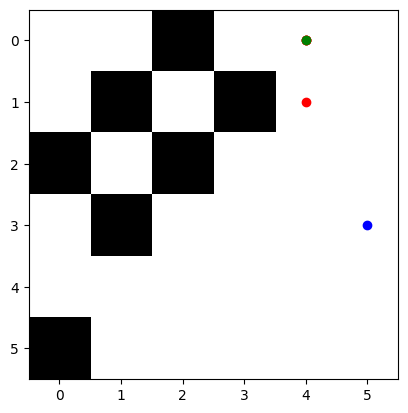

[-0.34896907, -0.36373916, -0.3691103, -0.36373916]
 gamma 0.8
[0, 0, 0, -1]
[-0.34896907, -0.36373916, -0.3691103, -0.36373916]
return [-0.2909913301467896, -0.2952882289886475, -0.2909913301467896, -1.0]
gae [0.05797774195671079, 0.06845093369483946, 0.07811895608901975, -0.6362608373165131]
0.647601756972576
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 2.,  1., -3.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 2.,  1., -3.,  1.]])
tensor([[ 2.,  0., -3.,  0.]])
tensor([[ 2.,  0., -3.,  0.]])
tensor([[ 3.,  0., -2.,  0.]])
tenso

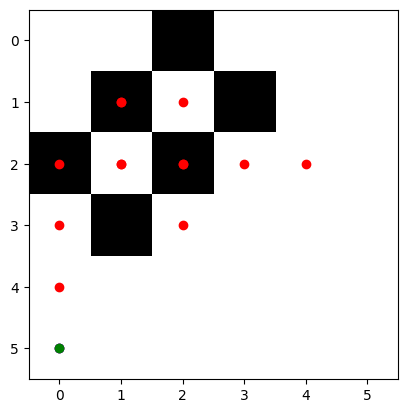

[-0.34516045, -0.36483428, -0.379249, -0.3944478, -0.4191009, -0.3944478, -0.37422478, -0.39342168, -0.4221294, -0.39342168, -0.4221294, -0.43159047, -0.44284353, -0.46193188]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.34516045, -0.36483428, -0.379249, -0.3944478, -0.4191009, -0.3944478, -0.37422478, -0.39342168, -0.4221294, -0.39342168, -0.4221294, -0.43159047, -0.44284353, -0.46193188]
return [-0.29186742305755614, -0.3033992052078247, -0.3155582427978516, -0.33528072834014894, -0.3155582427978516, -0.299379825592041, -0.314737343788147, -0.33770351409912114, -0.314737343788147, -0.33770351409912114, -0.3452723741531372, -0.3542748212814331, -0.3695455074310303, 1.0]
gae [0.053293031454086315, 0.06143507361412048, 0.06369076371192928, 0.059167075157165516, 0.10354266762733455, 0.09506797790527344, 0.059487438201904275, 0.05571816563606258, 0.10739204883575437, 0.05571816563606258, 0.07685701847076415, 0.07731564640998839, 0.07329801917076106, 1.4619318842887878]
0.6062

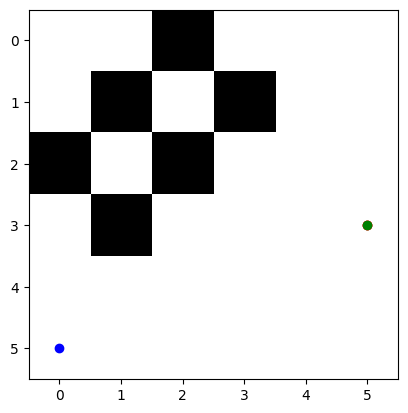

[-0.34752056, -0.35462162]
 gamma 0.8
[0, -1]
[-0.34752056, -0.35462162]
return [-0.2836972951889038, -1.0]
gae [0.06382326483726503, -0.6453783810138702]
0.26096099201200784
tensor([[ 2.,  0., -2., -5.]])
tensor([[ 2.,  0., -2., -5.]])
tensor([[ 3.,  0., -1., -5.]])
tensor([[ 3.,  0., -1., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 5.,  0.,  1., -5.]])
tensor([[ 5.,  1.,  1., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  2.,  0., -3.]])
tensor([[ 4.,  3.,  0., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  0., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  0., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 5.,  4.,  1., -1.]])
tensor([[ 4.,  4.,  0., -1.]])


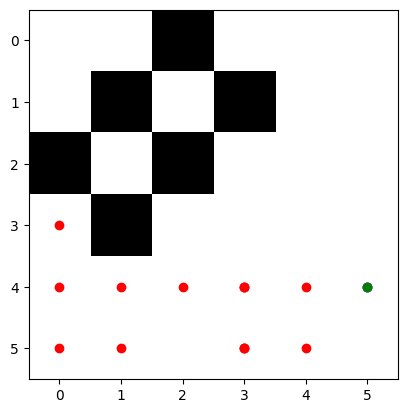

[-0.4773214, -0.52347565, -0.5972828, -0.7062419, -0.5950757, -0.5057961, -0.4579425, -0.43825158, -0.47052082, -0.43825158, -0.47052082, -0.43825158, -0.47052082, -0.44469538, -0.43176582]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.4773214, -0.52347565, -0.5972828, -0.7062419, -0.5950757, -0.5057961, -0.4579425, -0.43825158, -0.47052082, -0.43825158, -0.47052082, -0.43825158, -0.47052082, -0.44469538, -0.43176582]
return [-0.418780517578125, -0.47782626152038576, -0.5649935245513916, -0.4760605812072754, -0.40463685989379883, -0.36635398864746094, -0.35060126781463624, -0.3764166593551636, -0.35060126781463624, -0.3764166593551636, -0.35060126781463624, -0.3764166593551636, -0.3557563066482544, -0.3454126596450806, 1.0]
gae [0.05854086875915526, 0.045649385452270486, 0.032289302349090554, 0.2301813244819641, 0.1904388666152954, 0.1394420862197876, 0.10734121799468993, 0.06183492541313168, 0.11991955637931823, 0.06183492541313168, 0.11991955637931823, 0.06183492541313

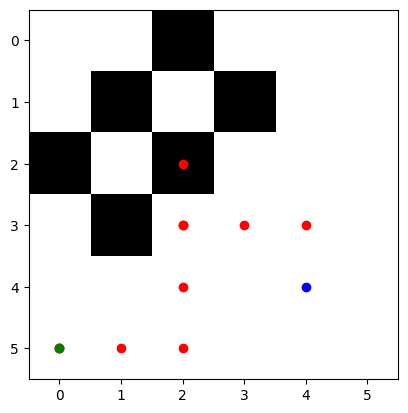

[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802]
return [-0.42746996879577637, -0.39530999660491944, -0.3833544492721558, -0.3825117588043213, -0.3833544492721558, -0.3862409830093384, -0.38868603706359867, -0.3914214611053467, -0.3977264165878296, -1.0]
gae [0.10230594873428345, 0.13902746438980101, 0.11078304648399351, 0.09668130278587339, 0.09478524923324583, 0.0929520785808563, 0.09411519169807431, 0.09443608522415159, 0.09155040979385376, -0.502841979265213]
0.15501460794565936
tensor([[ 0.,  5., -2.,  3.]])


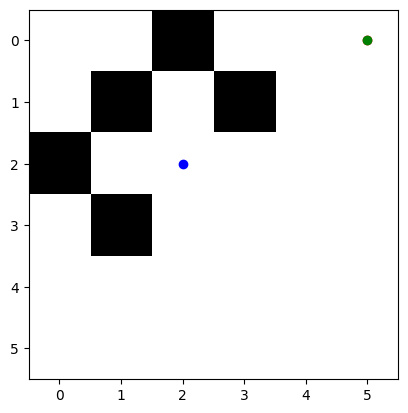

[-0.51237094]
 gamma 0.8
[-1]
[-0.51237094]
return [-1.0]
gae [-0.4876290559768677]
0.910241828758514


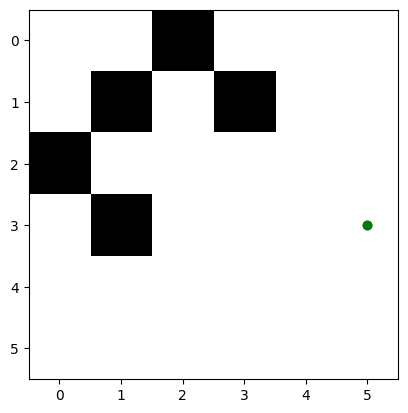

[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802, -0.51237094]
 gamma 0.8
[]
[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802, -0.51237094]
return []
gae []
0.8013879143729477


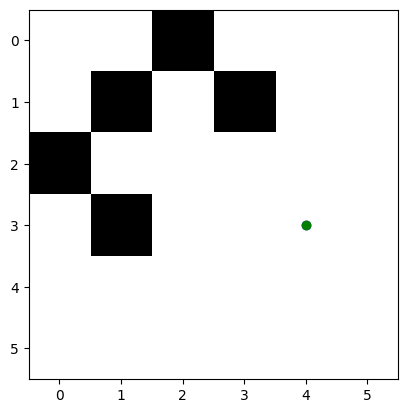

[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802, -0.51237094]
 gamma 0.8
[]
[-0.5297759, -0.53433746, -0.4941375, -0.47919306, -0.4781397, -0.47919306, -0.48280123, -0.48585755, -0.48927683, -0.49715802, -0.51237094]
return []
gae []
0.9401668174916008
tensor([[ 1.,  0.,  0., -2.]])
tensor([[ 1.,  0.,  0., -2.]])
tensor([[ 0.,  0., -1., -2.]])
tensor([[ 0.,  0., -1., -2.]])


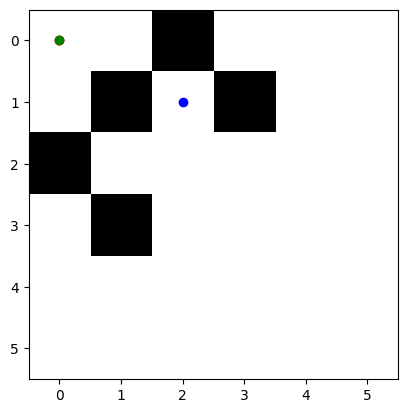

[-0.48223093, -0.48083714]
 gamma 0.8
[0, -1]
[-0.48223093, -0.48083714]
return [-0.3846697092056275, -1.0]
gae [0.09756122231483455, -0.5191628634929657]
0.5326305497962867
tensor([[ 2.,  3., -1.,  1.]])
tensor([[ 1.,  3., -2.,  1.]])
tensor([[ 1.,  3., -2.,  1.]])
tensor([[ 2.,  3., -1.,  1.]])
tensor([[ 2.,  3., -1.,  1.]])
tensor([[ 2.,  2., -1.,  0.]])
tensor([[ 2.,  2., -1.,  0.]])


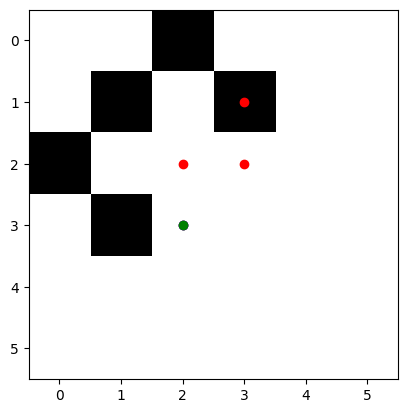

[-0.5279947, -0.52614194, -0.5279947, -0.48144874]
 gamma 0.8
[0, 0, 0, 1]
[-0.5279947, -0.52614194, -0.5279947, -0.48144874]
return [-0.4209135532379151, -0.4223957538604737, -0.3851589918136597, 1.0]
gae [0.10708113908767697, 0.10374618768692012, 0.14283570051193234, 1.4814487397670746]
0.4494974056533282
tensor([[2., 3., 0., 3.]])
tensor([[2., 2., 0., 2.]])
tensor([[2., 2., 0., 2.]])
tensor([[2., 3., 0., 3.]])
tensor([[2., 4., 0., 4.]])
tensor([[2., 5., 0., 5.]])
tensor([[ 1.,  5., -1.,  5.]])
tensor([[ 1.,  5., -1.,  5.]])
tensor([[ 1.,  4., -1.,  4.]])
tensor([[ 0.,  4., -2.,  4.]])
tensor([[ 0.,  4., -2.,  4.]])
tensor([[ 0.,  5., -2.,  5.]])


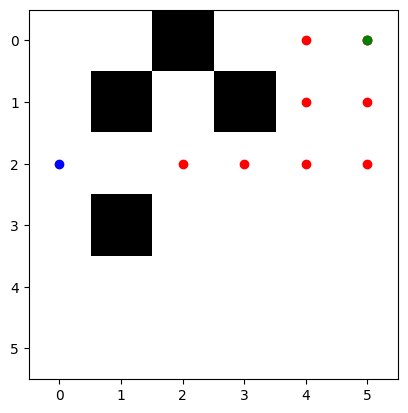

[-0.5282753, -0.49450698, -0.5282753, -0.50642186, -0.4924701, -0.49432266, -0.5205451, -0.51610184, -0.49949285]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5282753, -0.49450698, -0.5282753, -0.50642186, -0.4924701, -0.49432266, -0.5205451, -0.51610184, -0.49949285]
return [-0.3956055879592896, -0.4226202487945557, -0.4051374912261963, -0.39397606849670413, -0.39545812606811526, -0.41643610000610354, -0.41288146972656253, -0.3995942831039429, -1.0]
gae [0.132669723033905, 0.07188673615455626, 0.12313781976699828, 0.11244579553604123, 0.09701195955276487, 0.0778865575790405, 0.10766365528106686, 0.11650755405426022, -0.5005071461200714]
0.8849510008320143
tensor([[ 2.,  3., -3.,  2.]])
tensor([[ 2.,  3., -3.,  2.]])
tensor([[ 2.,  2., -3.,  1.]])
tensor([[ 2.,  2., -3.,  1.]])
tensor([[ 2.,  1., -3.,  0.]])
tensor([[ 2.,  1., -3.,  0.]])
tensor([[ 2.,  0., -3., -1.]])
tensor([[ 2.,  0., -3., -1.]])
tensor([[ 3.,  0., -2., -1.]])
tensor([[ 3.,  0., -2., -1.]])
tensor([[ 3.,  1., -2.,  0

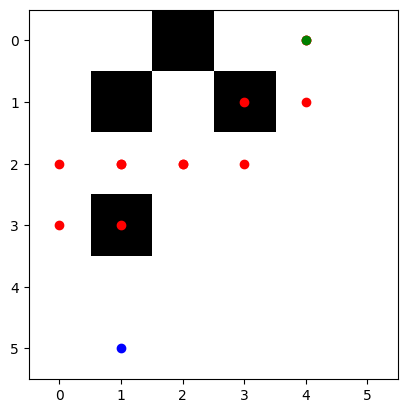

[-0.5316531, -0.5200344, -0.48662433, -0.47626752, -0.48111677, -0.48124573, -0.48662433, -0.5200344, -0.5316531, -0.52501285, -0.52045494, -0.51382524]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5316531, -0.5200344, -0.48662433, -0.47626752, -0.48111677, -0.48124573, -0.48662433, -0.5200344, -0.5316531, -0.52501285, -0.52045494, -0.51382524]
return [-0.41602749824523927, -0.38929946422576905, -0.3810140132904053, -0.38489341735839844, -0.38499658107757573, -0.38929946422576905, -0.41602749824523927, -0.4253224849700928, -0.42001028060913087, -0.4163639545440674, -0.4110601902008057, -1.0]
gae [0.1156256079673767, 0.13073490858078002, 0.10561031699180601, 0.09137409925460815, 0.09612019062042232, 0.09194626212120055, 0.07059683203697203, 0.09471188783645629, 0.1116428256034851, 0.10864889621734619, 0.10939475297927853, -0.4861747622489929]
0.8078795438186409
tensor([[3., 3., 0., 3.]])
tensor([[3., 3., 0., 3.]])
tensor([[3., 2., 0., 2.]])
tensor([[3., 2., 0., 2.]])
tensor([[4.

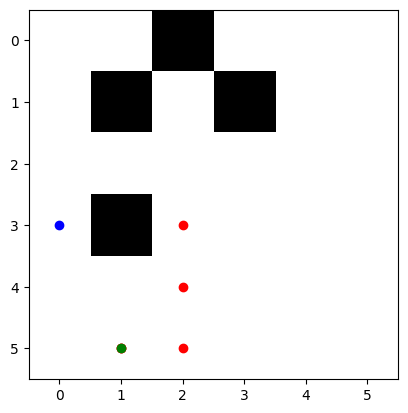

[-0.51545143, -0.49067113, -0.46605453, -0.45843077, -0.47021335]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.51545143, -0.49067113, -0.46605453, -0.45843077, -0.47021335]
return [-0.39253690242767336, -0.3728436231613159, -0.36674461364746097, -0.37617068290710454, -1.0]
gae [0.1229145288467407, 0.11782750487327576, 0.09930991530418393, 0.08226008415222164, -0.5297866463661194]
0.8777985257833012
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 1.,  4., -3.,  2.]])
tensor([[ 1.,  4., -3.,  2.]])
tensor([[ 1.,  3., -3.,  1.]])
tensor([[ 1.,  3., -3.,  1.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 0.,  1., -4., -1.]])
tensor([[ 0.,  1., -4., -1.]])
tensor([[ 0.,  0., -4., -2.]])


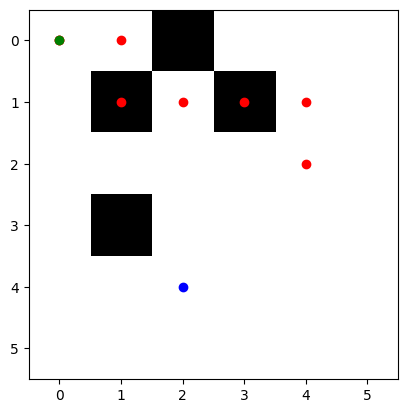

[-0.53061366, -0.52982366, -0.5231449, -0.5264985, -0.5086221, -0.48296994, -0.5003833, -0.48149073]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.53061366, -0.52982366, -0.5231449, -0.5264985, -0.5086221, -0.48296994, -0.5003833, -0.48149073]
return [-0.42385892868041997, -0.4185159206390381, -0.42119879722595216, -0.4068976879119873, -0.3863759517669678, -0.40030665397644044, -0.3851925849914551, -1.0]
gae [0.10675473213195796, 0.11130774021148682, 0.10194610357284545, 0.11960080862045286, 0.12224615812301631, 0.08266328573226928, 0.11519073247909545, -0.5185092687606812]
return [-0.38489342 -0.38466972 -0.38335446 -0.38335446 -0.38251176 -0.38101402
 -0.3761707  -0.37284362 -0.3667446   1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.42746997 -0.42532247 -0.42385894]

-------------------- Iteration #10 --------------------
random  0.8777985257833012
Average : 0.01
Average Episodic Return: -0.56
Max Episodic Return: 1.0
Average Loss: 0.0

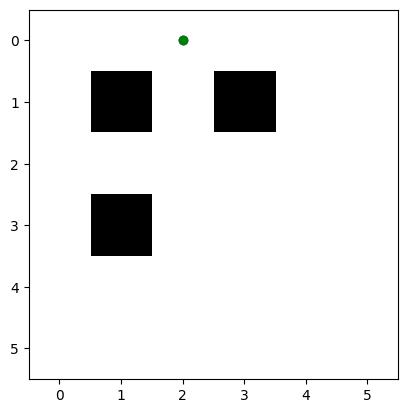

[]
 gamma 0.8
[]
[]
return []
gae []
0.10917206097298737
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 1.,  2.,  0., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 1.,  2.,  0., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  0.,  1., -5.]])


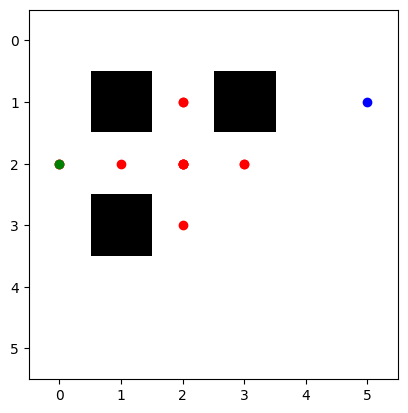

[-0.5452739, -0.53985935, -0.5452739, -0.5487767, -0.5452739, -0.54335755, -0.5452739, -0.54335755, -0.5452739, -0.53985935, -0.5452739, -0.5488495, -0.5557632]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5452739, -0.53985935, -0.5452739, -0.5487767, -0.5452739, -0.54335755, -0.5452739, -0.54335755, -0.5452739, -0.53985935, -0.5452739, -0.5488495, -0.5557632]
return [-0.4318874835968018, -0.4362191200256348, -0.43902134895324707, -0.4362191200256348, -0.43468604087829593, -0.4362191200256348, -0.43468604087829593, -0.4362191200256348, -0.4318874835968018, -0.4362191200256348, -0.4390796184539795, -0.4446105480194092, -1.0]
gae [0.11338641643524167, 0.10364023447036741, 0.10625255107879639, 0.11255756616592405, 0.11058785915374753, 0.10713843107223509, 0.11058785915374753, 0.10713843107223509, 0.11338641643524167, 0.10364023447036741, 0.10619428157806393, 0.10423897504806517, -0.4442368149757385]
0.371405313123361
tensor([[ 2.,  0.,  2., -4.]])
tensor([[ 2.,  0.,  2., -4.]])

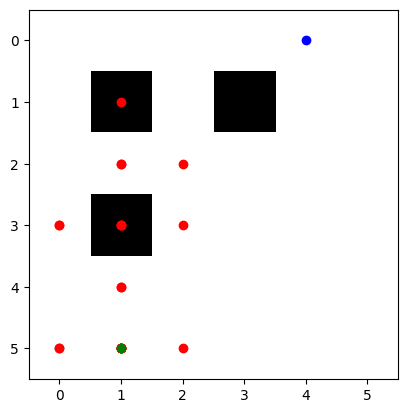

[-0.5651958, -0.5802968, -0.56346333, -0.55513865, -0.5497539, -0.55513865, -0.547867, -0.53630793, -0.56346333, -0.5802968, -0.56346333, -0.56680536, -0.6021291, -0.58438665, -0.6021291, -0.56680536, -0.6021291, -0.62819004, -0.6021291, -0.62819004, -0.6021291]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5651958, -0.5802968, -0.56346333, -0.55513865, -0.5497539, -0.55513865, -0.547867, -0.53630793, -0.56346333, -0.5802968, -0.56346333, -0.56680536, -0.6021291, -0.58438665, -0.6021291, -0.56680536, -0.6021291, -0.62819004, -0.6021291, -0.62819004, -0.6021291]
return [-0.4642374515533447, -0.45077066421508794, -0.444110918045044, -0.4398031234741211, -0.444110918045044, -0.4382936000823975, -0.4290463447570801, -0.45077066421508794, -0.4642374515533447, -0.45077066421508794, -0.45344429016113286, -0.4817032814025879, -0.46750931739807133, -0.4817032814025879, -0.45344429016113286, -0.4817032814025879, -0.5025520324707031, -0.4817032814025879, -0.50255

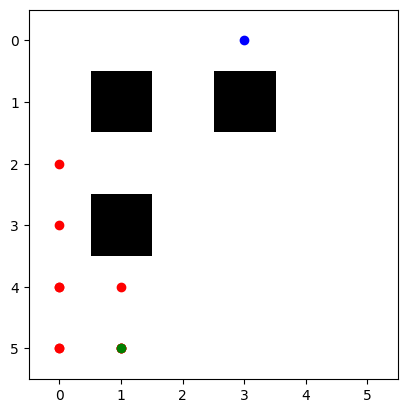

[-0.55271107, -0.5617765, -0.5755788, -0.58816, -0.620589, -0.59805185, -0.620589, -0.58816, -0.5604425, -0.59805185]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.55271107, -0.5617765, -0.5755788, -0.58816, -0.620589, -0.59805185, -0.620589, -0.58816, -0.5604425, -0.59805185]
return [-0.4494212150573731, -0.4604630470275879, -0.470527982711792, -0.49647121429443364, -0.4784414768218994, -0.49647121429443364, -0.470527982711792, -0.44835400581359863, -0.4784414768218994, -1.0]
gae [0.10328985452651973, 0.10131347179412842, 0.10505082607269284, 0.09168876409530635, 0.14214754104614258, 0.10158063173294063, 0.15006103515624997, 0.13980597257614136, 0.08200103044509888, -0.40194815397262573]
0.6436157008803811
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 1.,  5., -1.,  3.]])
tensor([[ 1.,  5., -1.,  3.]])
tensor([[2., 5., 0., 3.]])
tensor([[2., 4., 0., 2.]])
tensor([[2., 4., 0., 2.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 0.,  4., -2.,  2.]])
tensor([[ 0.,  4., -2.,  2.]])
tensor([[ 0.,  

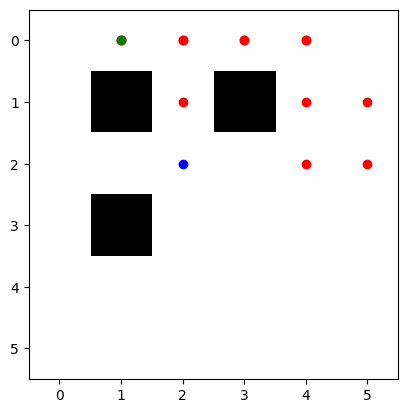

[-0.5003863, -0.4873016, -0.4735331, -0.48471764, -0.5003863, -0.4986257, -0.5058349, -0.4986257, -0.5058349, -0.52141374, -0.529077, -0.52141374, -0.530209]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5003863, -0.4873016, -0.4735331, -0.48471764, -0.5003863, -0.4986257, -0.5058349, -0.4986257, -0.5058349, -0.52141374, -0.529077, -0.52141374, -0.530209]
return [-0.38984127044677735, -0.37882647514343265, -0.38777410984039307, -0.40030903816223146, -0.3989005565643311, -0.4046679019927979, -0.3989005565643311, -0.4046679019927979, -0.417130994796753, -0.4232615947723389, -0.417130994796753, -0.4241672039031983, -1.0]
gae [0.11054502725601195, 0.10847511291503903, 0.0857589840888977, 0.08440859913825988, 0.10148574113845821, 0.09395779371261592, 0.10693432092666622, 0.09395779371261592, 0.08870388269424434, 0.09815214872360228, 0.11194599866867061, 0.09724653959274288, -0.4697909951210022]
return [-0.417131   -0.417131   -0.4046679  -0.4046679  -0.40030903 -0.39890057
 -0.398

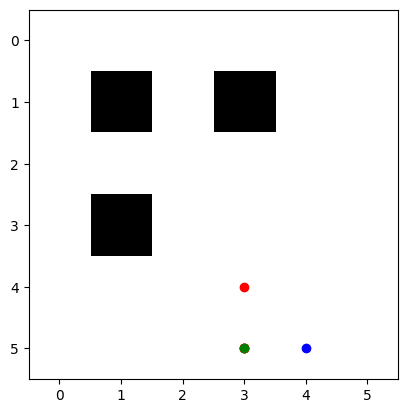

[-0.5609101, -0.55430067, -0.5488333, -0.55430067]
 gamma 0.8
[0, 0, 0, -1]
[-0.5609101, -0.55430067, -0.5488333, -0.55430067]
return [-0.4434405326843262, -0.43906664848327637, -0.4434405326843262, -1.0]
gae [0.11746957302093503, 0.11523401737213135, 0.10539277791976925, -0.4456993341445923]
0.03902274239792691
tensor([[5., 2., 1., 1.]])
tensor([[5., 3., 1., 2.]])


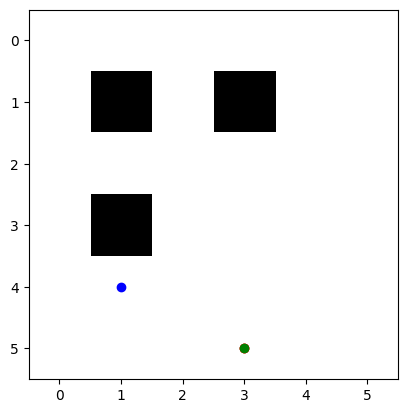

[-0.53457004, -0.5263384]
 gamma 0.8
[0, -1]
[-0.53457004, -0.5263384]
return [-0.4210707187652588, -1.0]
gae [0.11349931955337522, -0.4736616015434265]
0.5496018870269853
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 0.,  3., -5., -2.]])
tensor([[ 0.,  3., -5., -2.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  0., -5., -5.]])
tensor([[ 0.,  0., -5., -5.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 0.,  3., -5., -2.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 0.,  1., -5.

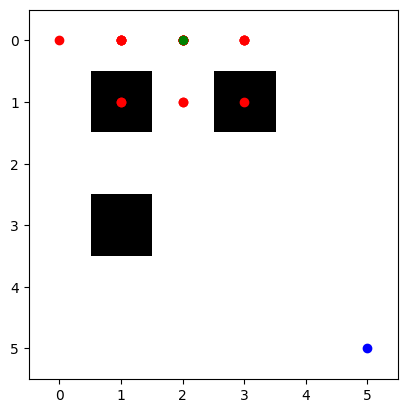

[-0.5516899, -0.55118465, -0.5609501, -0.57020354, -0.5670259, -0.57020354, -0.5664793, -0.57020354, -0.5609501, -0.5607117, -0.55044127, -0.55118465, -0.5609501, -0.57020354, -0.5670259, -0.57020354, -0.5609501, -0.5607117, -0.5609501, -0.55118465, -0.5609501, -0.55118465, -0.5609501]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5516899, -0.55118465, -0.5609501, -0.57020354, -0.5670259, -0.57020354, -0.5664793, -0.57020354, -0.5609501, -0.5607117, -0.55044127, -0.55118465, -0.5609501, -0.57020354, -0.5670259, -0.57020354, -0.5609501, -0.5607117, -0.5609501, -0.55118465, -0.5609501, -0.55118465, -0.5609501]
return [-0.4409477233886719, -0.44876008033752446, -0.4561628341674805, -0.453620719909668, -0.4561628341674805, -0.45318346023559575, -0.4561628341674805, -0.44876008033752446, -0.4485693454742432, -0.44035301208496097, -0.4409477233886719, -0.44876008033752446, -0.4561628341674805, -0.453620719909668, -0.4561628341674805, -0.448760080337524

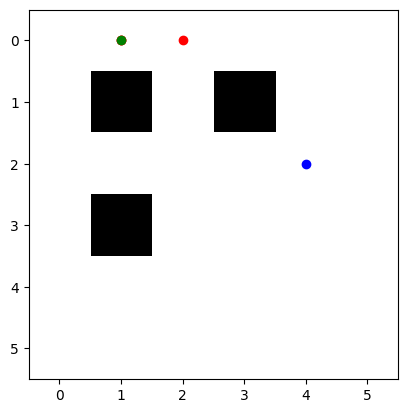

[-0.56919444, -0.5600286, -0.56919444]
 gamma 0.8
[0, 0, -1]
[-0.56919444, -0.5600286, -0.56919444]
return [-0.4480228900909424, -0.4553555488586426, -1.0]
gae [0.1211715459823608, 0.10467306375503538, -0.4308055639266968]
0.2774640730097574
tensor([[ 1.,  1., -3.,  0.]])
tensor([[ 0.,  1., -4.,  0.]])
tensor([[ 0.,  1., -4.,  0.]])
tensor([[ 1.,  1., -3.,  0.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 3.,  5., -1.,  4.]])
tensor([[ 3.,  5., -1.,  4.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[4., 3., 0., 2.]])
tensor([[4., 2., 0., 1.]])
tensor([[5., 2., 1., 1.]])
tensor([[5., 1., 1., 0.]])

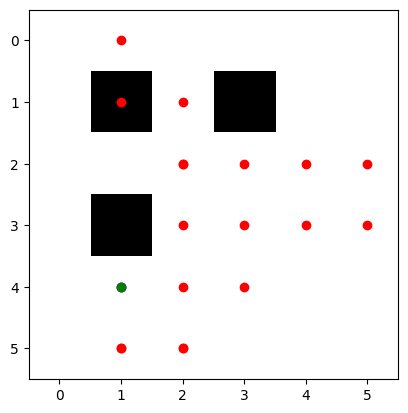

[-0.5586868, -0.5591101, -0.5586868, -0.55011153, -0.5484859, -0.54788196, -0.5484859, -0.54978067, -0.55524683, -0.566902, -0.5663957, -0.55658185, -0.5498821, -0.54367495, -0.54887444, -0.53457004, -0.5532255, -0.53457004, -0.5532255]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.5586868, -0.5591101, -0.5586868, -0.55011153, -0.5484859, -0.54788196, -0.5484859, -0.54978067, -0.55524683, -0.566902, -0.5663957, -0.55658185, -0.5498821, -0.54367495, -0.54887444, -0.53457004, -0.5532255, -0.53457004, -0.5532255]
return [-0.4472880840301514, -0.4469494342803955, -0.44008922576904297, -0.4387887001037598, -0.43830556869506837, -0.4387887001037598, -0.4398245334625244, -0.44419746398925786, -0.4535215854644776, -0.4531165599822998, -0.4452654838562012, -0.43990569114685063, -0.4349399566650391, -0.4390995502471924, -0.42765603065490726, -0.4425804138183594, -0.42765603065490726, -0.4425804138183594, 1.0]
gae [0.11139870882034297, 0.11216067075729369, 0.11859756708

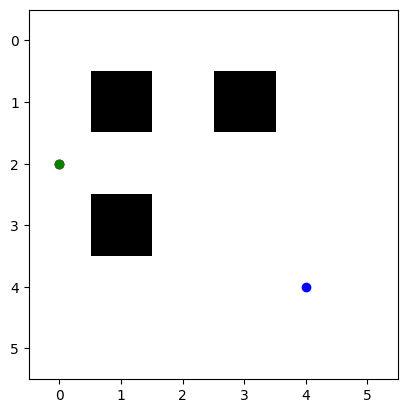

[-0.60480493, -0.59669435]
 gamma 0.8
[0, -1]
[-0.60480493, -0.59669435]
return [-0.4773554801940918, -1.0]
gae [0.12744945287704468, -0.40330564975738525]
0.4991041779399621
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 1.,  5., -4.,  2.]])
tensor([[ 2.,  5., -3.,  2.]])
tensor([[ 2.,  5., -3.,  2.]])
tensor([[ 2.,  4., -3.,  1.]])
tensor([[ 2.,  4., -3.,  1.]])
tensor([[ 2.,  3., -3.,  0.]])
tensor([[ 1.,  3., -4.,  0.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 0.,  4., -5.,  1.]])
tensor([[ 0.,  4., -5.,  1.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 0.,  4., -5.,  1.]])
tensor([[ 0.,  4., -5.,  1.]])
tensor([[ 1.,  4., -4.,  1.]])
tensor([[ 2.,  4., -3.,  1.]])
tensor([[ 2.,  5., -3.,  2.]])
tensor([[ 2.,  5., -3.,  2.]])
tensor([[ 1.,  5., -4.,  2.]])
tensor([[ 1.,  5., -4.,  2.]])
tensor([[ 0.,  5., -5.,  2.]])
tensor([[ 0.,  5., -5.,  2.]])
tensor([[ 1.,  5., -4.,  2.]])
tensor([[ 2.,  5., 

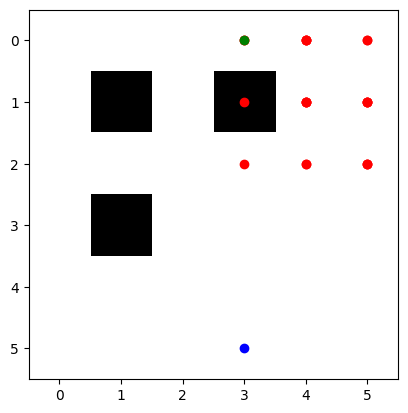

[-0.57292664, -0.5805095, -0.5872662, -0.58161026, -0.5789826, -0.56940204, -0.57292664, -0.5686236, -0.57292664, -0.5686236, -0.57292664, -0.58161026, -0.5872662, -0.5805095, -0.57447743, -0.5805095, -0.5872662, -0.5805095, -0.57292664, -0.5686236, -0.57447743, -0.5686236, -0.5669225]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.57292664, -0.5805095, -0.5872662, -0.58161026, -0.5789826, -0.56940204, -0.57292664, -0.5686236, -0.57292664, -0.5686236, -0.57292664, -0.58161026, -0.5872662, -0.5805095, -0.57447743, -0.5805095, -0.5872662, -0.5805095, -0.57292664, -0.5686236, -0.57447743, -0.5686236, -0.5669225]
return [-0.4644075870513916, -0.46981296539306644, -0.4652882099151612, -0.4631860733032227, -0.45552163124084477, -0.4583413124084473, -0.4548988819122315, -0.4583413124084473, -0.4548988819122315, -0.4583413124084473, -0.4652882099151612, -0.46981296539306644, -0.4644075870513916, -0.4595819473266602, -0.4644075870513916, -0.469812965393066

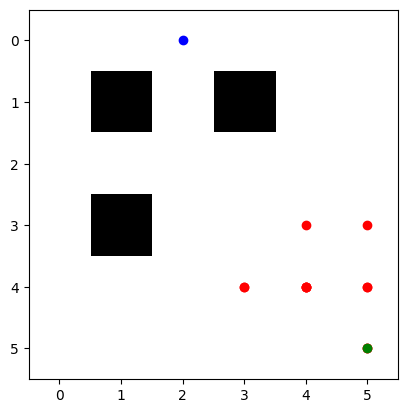

[-0.58658576, -0.6031147, -0.58658576, -0.6006428, -0.595495, -0.6006428, -0.595495, -0.6006428, -0.62328225, -0.6006428, -0.62328225, -0.6462868]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.58658576, -0.6031147, -0.58658576, -0.6006428, -0.595495, -0.6006428, -0.595495, -0.6006428, -0.62328225, -0.6006428, -0.62328225, -0.6462868]
return [-0.4824917793273926, -0.46926860809326176, -0.4805142402648926, -0.4763959884643555, -0.4805142402648926, -0.4763959884643555, -0.4805142402648926, -0.49862580299377446, -0.4805142402648926, -0.49862580299377446, -0.5170294284820557, -1.0]
gae [0.10409398078918453, 0.13384611606597896, 0.10607151985168456, 0.12424681186676023, 0.11498074531555175, 0.12424681186676023, 0.11498074531555175, 0.10201699733734126, 0.14276801347732543, 0.10201699733734126, 0.10625282526016233, -0.3537132143974304]
0.43198031177132934
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([

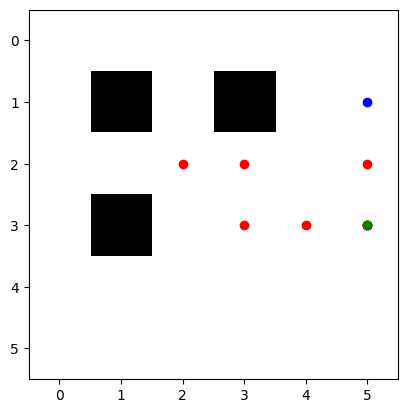

[-0.597951, -0.59814686, -0.5855197, -0.58498967, -0.5753662, -0.5780641, -0.5650878, -0.5780641]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.597951, -0.59814686, -0.5855197, -0.58498967, -0.5753662, -0.5780641, -0.5650878, -0.5780641]
return [-0.478517484664917, -0.4684157371520996, -0.4679917335510254, -0.46029295921325686, -0.4624512672424317, -0.4520702362060547, -0.4624512672424317, -1.0]
gae [0.1194335103034973, 0.12973111867904663, 0.1175279378890991, 0.12469670772552488, 0.11291493177413936, 0.12599384784698486, 0.10263652801513667, -0.42193591594696045]
0.3501128650593842
tensor([[ 0.,  4., -1.,  1.]])
tensor([[1., 4., 0., 1.]])
tensor([[1., 4., 0., 1.]])
tensor([[2., 4., 1., 1.]])
tensor([[1., 4., 0., 1.]])
tensor([[1., 4., 0., 1.]])
tensor([[2., 4., 1., 1.]])
tensor([[2., 4., 1., 1.]])
tensor([[2., 3., 1., 0.]])
tensor([[2., 3., 1., 0.]])
tensor([[ 2.,  2.,  1., -1.]])
tensor([[ 3.,  2.,  2., -1.]])
tensor([[3., 3., 2., 0.]])
tensor([[4., 3., 3., 0.]])
tensor([[4., 3., 3., 0.]]

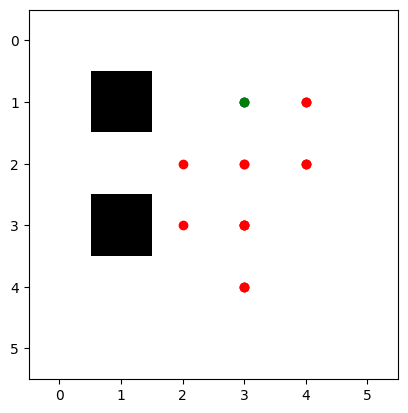

[-0.56870586, -0.56397146, -0.56403446, -0.56397146, -0.56403446, -0.5712309, -0.59158355, -0.58616793, -0.58041453, -0.58830804, -0.58041453, -0.58830804, -0.58041453, -0.58830804, -0.58041453, -0.5712309, -0.56403446, -0.56397146]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.56870586, -0.56397146, -0.56403446, -0.56397146, -0.56403446, -0.5712309, -0.59158355, -0.58616793, -0.58041453, -0.58830804, -0.58041453, -0.58830804, -0.58041453, -0.58830804, -0.58041453, -0.5712309, -0.56403446, -0.56397146]
return [-0.4511771678924561, -0.45122756958007815, -0.4511771678924561, -0.45122756958007815, -0.4569847106933594, -0.4732668399810791, -0.4689343452453614, -0.46433162689208984, -0.4706464290618897, -0.46433162689208984, -0.4706464290618897, -0.46433162689208984, -0.4706464290618897, -0.46433162689208984, -0.4569847106933594, -0.45122756958007815, -0.4511771678924561, 1.0]
gae [0.11752868890762325, 0.11274389028549192, 0.11285729408264156, 0.11274389028549192, 0.

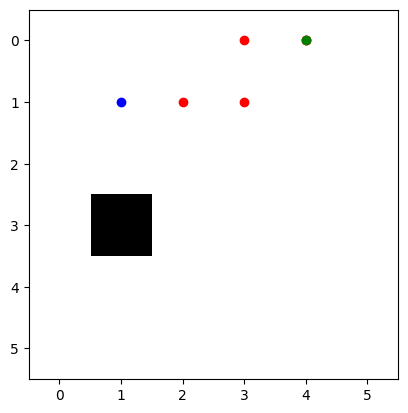

[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807]
return [-0.2505699396133423, -0.2478708028793335, -0.24796817302703858, -0.2519504547119141, -1.0]
gae [0.06333139538764954, 0.06534162163734436, 0.06187033057212829, 0.058009761571884144, -0.6850619316101074]
0.6916230545558466
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[2., 2., 2., 0.]])
tensor([[3., 2., 3., 0.]])
tensor([[3., 2., 3., 0.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 1.,  1.,  1., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  0.,  2., -2.]])


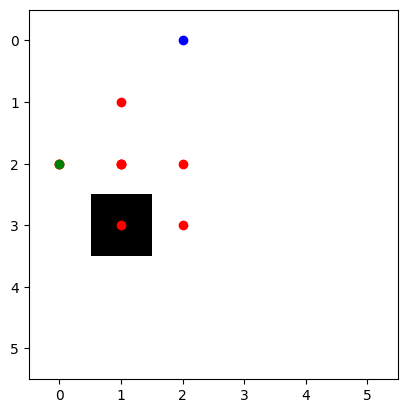

[-0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283]
return [-0.253995418548584, -0.25106492042541506, -0.2392969608306885, -0.25388526916503906, -0.253995418548584, -0.2533061742782593, -0.253995418548584, -0.2586022615432739, -1.0]
gae [0.06925740838050842, 0.06642935276031492, 0.0745341897010803, 0.04523593187332153, 0.06336116790771484, 0.06418809890747068, 0.06263729929924011, 0.058892011642456055, -0.6767471730709076]
0.5770674143245791
tensor([[2., 5., 0., 4.]])
tensor([[2., 5., 0., 4.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[ 1.,  4., -1.,  3.]])
tensor([[ 1.,  3., -1.,  2.]])
tensor([[ 1.,  3., -1.,  2.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 2., 0., 1.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 3., 0., 2.]]

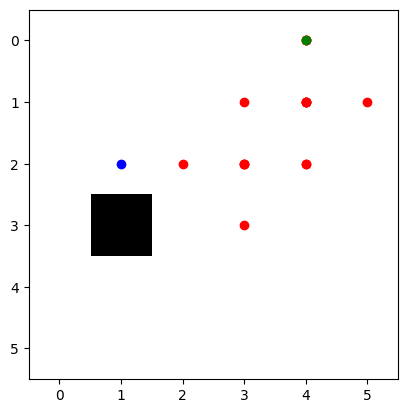

[-0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883]
return [-0.24323921203613283, -0.2499255180358887, -0.24796919822692873, -0.24721484184265138, -0.25153908729553226, -0.24721484184265138, -0.2329132080078125, -0.24721484184265138, -0.24323921203613283, -0.2499255180358887, -0.25183064937591554, -0.2499255180358887, -0.2538428544998169, -0.2499255180358887, -0.25183064937591554, -1.0]
gae [0.055148673057556136, 0.05412349700927732, 0.06443769931793211, 0.0627466559410095, 0.05747946500778195, 0.0672090172767639, 0.0761053442955017, 0.04392666816711424, 0.06577934026718138, 0.05412

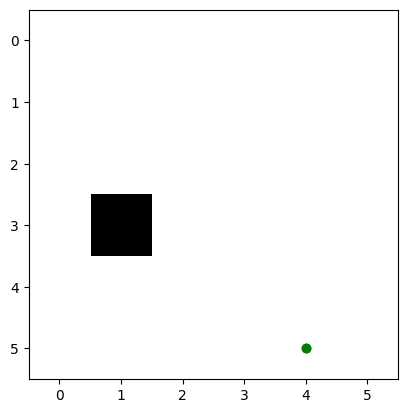

[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807, -0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283, -0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883]
 gamma 0.8
[]
[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807, -0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283, -0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883]
return []
gae []
0.7627648439679588
tensor([[ 5.,  0.,  5., -4.]])


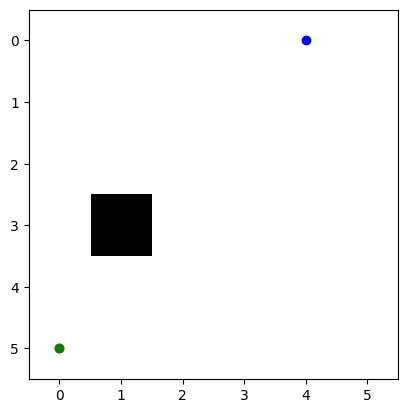

[-0.33736938]
 gamma 0.8
[-1]
[-0.33736938]
return [-1.0]
gae [-0.6626306176185608]
0.2605938824681657


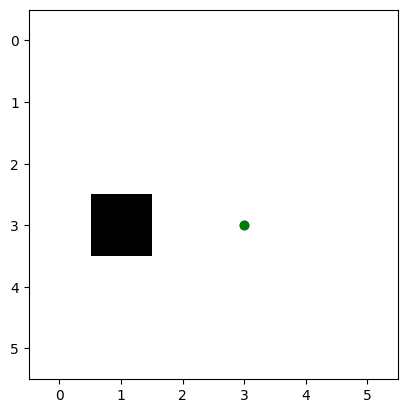

[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807, -0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283, -0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883, -0.33736938]
 gamma 0.8
[]
[-0.31390134, -0.31321242, -0.3098385, -0.30996022, -0.31493807, -0.32325283, -0.31749427, -0.31383115, -0.2991212, -0.3173566, -0.31749427, -0.31663272, -0.31749427, -0.32325283, -0.29838789, -0.30404902, -0.3124069, -0.3099615, -0.30901855, -0.31442386, -0.30901855, -0.2911415, -0.30901855, -0.30404902, -0.3124069, -0.3147883, -0.3124069, -0.31730357, -0.3124069, -0.3147883, -0.33736938]
return []
gae []
0.22827632661885655
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[4., 1., 0., 1.]])
tensor([[4., 1., 0., 1.]])
tensor([[5., 1.,

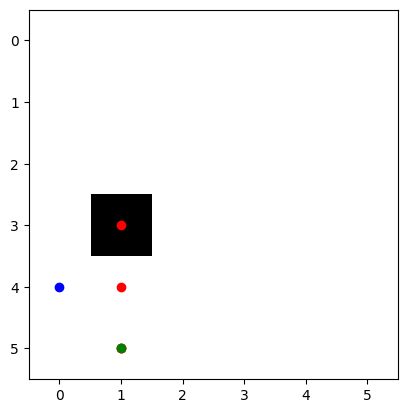

[-0.3146696, -0.31518015, -0.3143203, -0.3000359]
 gamma 0.8
[0, 0, 0, -1]
[-0.3146696, -0.31518015, -0.3143203, -0.3000359]
return [-0.2521441221237183, -0.25145623683929447, -0.240028715133667, -1.0]
gae [0.06252548694610593, 0.06372391581535336, 0.07429158091545104, -0.6999641060829163]
0.7071194971923546
tensor([[ 3.,  0.,  2., -1.]])
tensor([[ 3.,  0.,  2., -1.]])
tensor([[3., 1., 2., 0.]])
tensor([[3., 1., 2., 0.]])
tensor([[ 3.,  0.,  2., -1.]])
tensor([[ 3.,  0.,  2., -1.]])


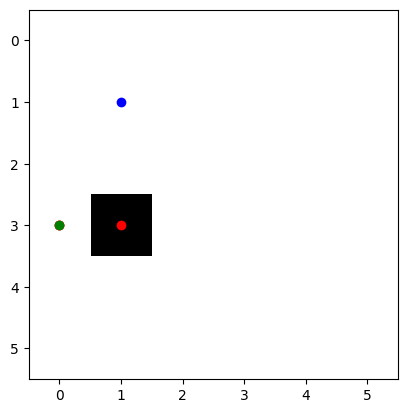

[-0.32233685, -0.3155286, -0.32233685]
 gamma 0.8
[0, 0, -1]
[-0.32233685, -0.3155286, -0.32233685]
return [-0.2524228811264038, -0.2578694820404053, -1.0]
gae [0.06991397142410277, 0.05765911936759949, -0.6776631474494934]
0.6917603110531733
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 2.,  3., -3., -2.]])
tensor([[ 2.,  3., -3., -2.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 0.,  4., -5., -1.]])


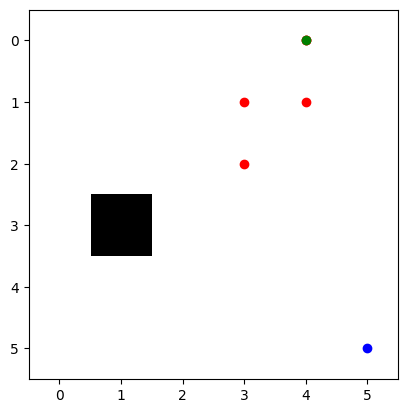

[-0.31803554, -0.31827047, -0.31803554, -0.3100738, -0.31004465]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.31803554, -0.31827047, -0.31803554, -0.3100738, -0.31004465]
return [-0.254616379737854, -0.25442843437194823, -0.24805903434753418, -0.24803571701049806, -1.0]
gae [0.0634191632270813, 0.06384204030036927, 0.06997650861740112, 0.06203807592391966, -0.6899553537368774]
0.2005014930346315
tensor([[4., 4., 0., 2.]])
tensor([[4., 5., 0., 3.]])
tensor([[ 3.,  5., -1.,  3.]])


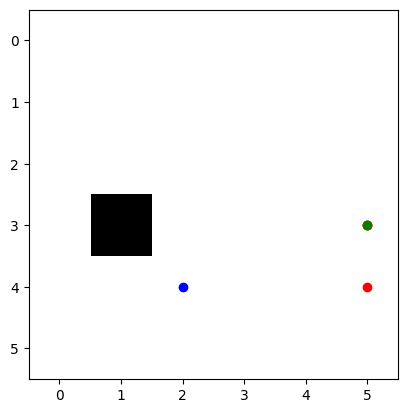

[-0.28596005, -0.28366333, -0.30554938]
 gamma 0.8
[0, 0, -1]
[-0.28596005, -0.28366333, -0.30554938]
return [-0.22693066596984865, -0.24443950653076174, -1.0]
gae [0.05902938246726988, 0.03922382593154905, -0.6944506168365479]
0.2397714049790607
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 1.,  2., -1.,  1.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 1.,  2., -1.,  1.]])
tensor([[ 0.,  2., -2.,  1.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  0., -2., -1.]])


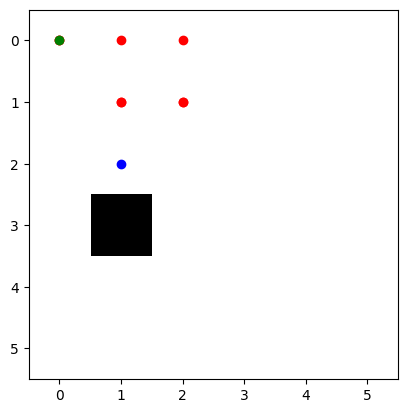

[-0.31576154, -0.3146148, -0.31351742, -0.3146148, -0.31351742, -0.3157479, -0.31576154, -0.31376123]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.31576154, -0.3146148, -0.31351742, -0.3146148, -0.31351742, -0.3157479, -0.31576154, -0.31376123]
return [-0.2516918420791626, -0.25081393718719486, -0.2516918420791626, -0.25081393718719486, -0.25259830951690676, -0.2526092290878296, -0.2510089874267578, -1.0]
gae [0.06406969428062437, 0.06380086541175839, 0.06182557940483091, 0.06380086541175839, 0.06091911196708677, 0.0631386578083038, 0.06475254893302917, -0.6862387657165527]
return [-0.24721484 -0.24721484 -0.24721484 -0.24443951 -0.24323921 -0.24323921
 -0.24002871 -0.23929696 -0.23291321 -0.22693066]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.25860226]

-------------------- Iteration #14 --------------------
random  0.2397714049790607
Average : 0.01
Average Episodic Return: -0.61
Max Episodic Return: 1.0
Average Loss: 0.

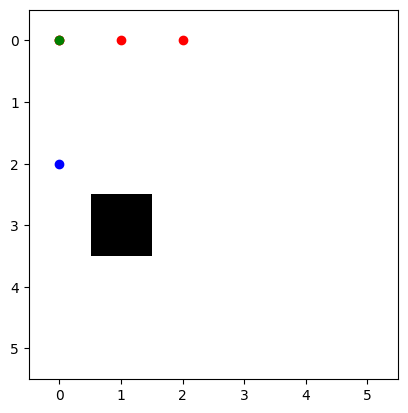

[-0.1805146, -0.18612538, -0.1643853, -0.1408505]
 gamma 0.8
[0, 0, 0, -1]
[-0.1805146, -0.18612538, -0.1643853, -0.1408505]
return [-0.148900306224823, -0.13150824308395387, -0.1126803994178772, -1.0]
gae [0.031614297628402704, 0.05461713969707488, 0.051704904437065116, -0.8591495007276535]
0.568731095510845
tensor([[ 0.,  5., -4.,  4.]])
tensor([[ 1.,  5., -3.,  4.]])
tensor([[ 1.,  4., -3.,  3.]])
tensor([[ 1.,  5., -3.,  4.]])
tensor([[ 1.,  5., -3.,  4.]])


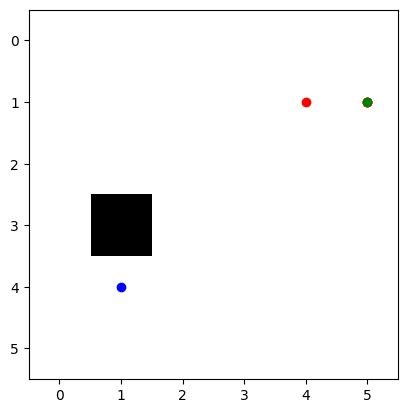

[-0.215468, -0.20291124, -0.2000873, -0.20291124]
 gamma 0.8
[0, 0, 0, -1]
[-0.215468, -0.20291124, -0.2000873, -0.20291124]
return [-0.1623289942741394, -0.16006983518600465, -0.1623289942741394, -1.0]
gae [0.05313901007175445, 0.042841407656669606, 0.03775829970836639, -0.7970887571573257]
0.45938658125856835
tensor([[4., 3., 1., 0.]])
tensor([[5., 3., 2., 0.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[5., 3., 2., 0.]])
tensor([[4., 3., 1., 0.]])
tensor([[4., 3., 1., 0.]])


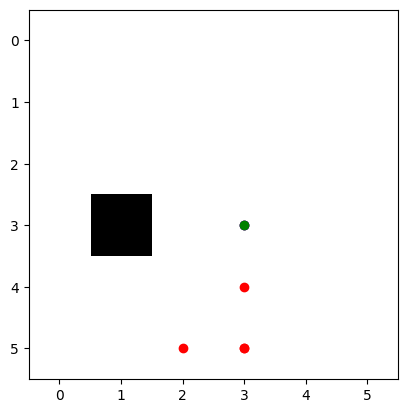

[-0.115416735, -0.10654772, -0.09754149, -0.10654772, -0.115416735]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.115416735, -0.10654772, -0.09754149, -0.10654772, -0.115416735]
return [-0.08523817658424378, -0.07803319096565248, -0.08523817658424378, -0.09233338832855226, 1.0]
gae [0.03017855882644653, 0.02851452976465224, 0.012303312122821805, 0.01421433240175246, 1.1154167354106903]
0.278831509053987
tensor([[ 1.,  0.,  1., -1.]])
tensor([[ 2.,  0.,  2., -1.]])
tensor([[2., 1., 2., 0.]])
tensor([[2., 2., 2., 1.]])
tensor([[2., 1., 2., 0.]])
tensor([[3., 1., 3., 0.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[3., 1., 3., 0.]])
tensor([[4., 1., 4., 0.]])
tensor([[4., 2., 4., 1.]])
tensor([[4., 2., 4., 1.]])
tensor([[3., 2., 3., 1.]])
tensor([[3., 1., 3., 0.]])
tensor([[2., 1., 2., 0.]])
tensor([[3., 1., 3., 0.]])
tensor([[3., 1., 3., 0.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[ 2.,  0.,  2., -1.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[3., 1., 3., 0.]])
tensor([[3., 

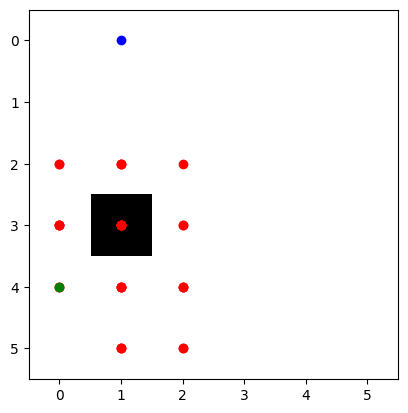

[-0.13561033, -0.13338211, -0.12512141, -0.109929085, -0.12512141, -0.09734212, -0.123870365, -0.09734212, -0.09678333, -0.10253879, -0.093849786, -0.09734212, -0.12512141, -0.09734212, -0.123870365, -0.13338211, -0.123870365, -0.09734212, -0.093849786, -0.10253879, -0.11478662, -0.11097641, -0.09678333, -0.11097641, -0.11478662, -0.10253879, -0.09678333, -0.11097641, -0.09678333, -0.09734212, -0.123870365, -0.1069597]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13561033, -0.13338211, -0.12512141, -0.109929085, -0.12512141, -0.09734212, -0.123870365, -0.09734212, -0.09678333, -0.10253879, -0.093849786, -0.09734212, -0.12512141, -0.09734212, -0.123870365, -0.13338211, -0.123870365, -0.09734212, -0.093849786, -0.10253879, -0.11478662, -0.11097641, -0.09678333, -0.11097641, -0.11478662, -0.10253879, -0.09678333, -0.11097641, -0.09678333, -0.09734212, -0.123870365, -0.1069597]
return [-0.10670568943023682, -0.100097131729

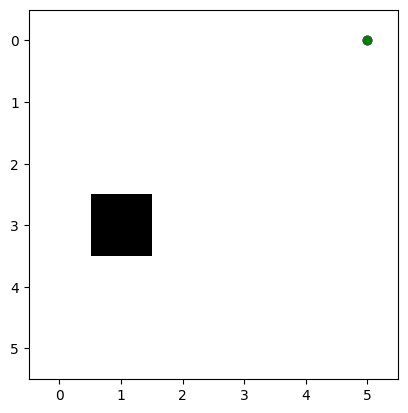

[-0.20303217]
 gamma 0.8
[1]
[-0.20303217]
return [1.0]
gae [1.2030321657657623]
0.9650241741332051
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 0.,  4., -2.,  2.]])
tensor([[ 0.,  4., -2.,  2.]])
tensor([[ 0.,  3., -2.,  1.]])
tensor([[ 0.,  3., -2.,  1.]])
tensor([[ 0.,  2., -2.,  0.]])
tensor([[ 0.,  2., -2.,  0.]])
tensor([[ 0.,  1., -2., -1.]])
tensor([[ 0.,  1., -2., -1.]])
tensor([[ 0.,  0., -2., -2.]])
tensor([[ 0.,  0., -2., -2.]])
tensor([[ 1.,  0., -1., -2.]])
tensor([[ 1.,  0., -1., -2.]])


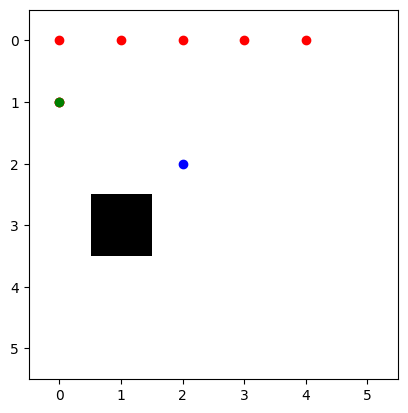

[-0.20122983, -0.2064547, -0.19302545, -0.17285356, -0.14748274, -0.13820192, -0.13310894]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.20122983, -0.2064547, -0.19302545, -0.17285356, -0.14748274, -0.13820192, -0.13310894]
return [-0.16516375541687012, -0.15442036390304567, -0.13828284740448, -0.11798619031906128, -0.11056153774261475, -0.10648715496063232, -1.0]
gae [0.036066070199012756, 0.052034330368041976, 0.054742607474327076, 0.054867368936538694, 0.03692120015621185, 0.03171476721763611, -0.8668910562992096]
return [-0.07787369 -0.07787369 -0.07742666 -0.07742666 -0.07742666 -0.07742666
 -0.07507983 -0.07507983  1.          1.        ]
return [-1.         -1.         -1.         -1.         -0.16516376 -0.16232899
 -0.16232899 -0.16006984 -0.15442036 -0.1489003 ]

-------------------- Iteration #15 --------------------
random  0.9650241741332051
Average : 0.01
Average Episodic Return: -0.58
Max Episodic Return: 1.0
Average Loss: 0.00043
Average Loss Critic: 0.27611321210861206
TEntrop

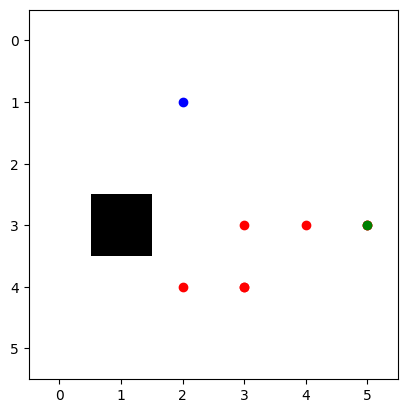

[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383]
return [0.07266536355018616, 0.018802332878112796, 0.07266536355018616, 0.10345001220703126, 0.11167272329330445, 0.10647506713867189, -1.0]
gae [-0.004470251500606537, -0.0720293715596199, 0.049162447452545166, 0.012618307769298565, -0.01763979196548461, -0.03311583697795867, -1.1330938339233398]
0.6339267844093077
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 2.,  3.,  2., -2.]])
tensor([[ 2.,  3.,  2., -2.]])
tensor([[ 2.,  4.,  2., -1.]])
tensor([[ 2.,  4.,  2., -1.]])
tensor([[ 1.,  4.,  1., -1.]])
tensor(

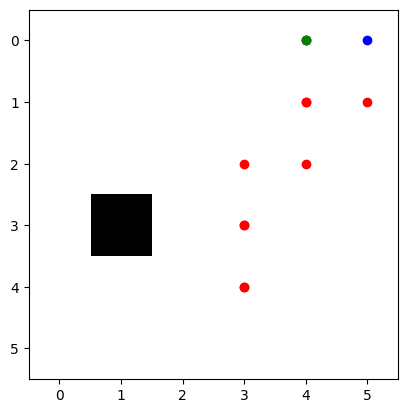

[-0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
return [0.005120553076267242, 0.008749595284461975, 0.005120553076267242, 0.008749595284461975, 0.028764531016349792, 0.09778857827186585, 0.10665189027786255, 0.10394291877746582, 0.10665189027786255, 0.10579814910888673, -1.0]
gae [0.008266349090263247, 0.0023489039391279224, -0.0058164410293102264, 0.0023489039391279224, 0.017827536910772324, 0.06183291450142861, -0.015583832561969754, -0.029371944069862363, -0.023276758193969724, -0.02751671373844146, -1.1322476863861084]
0.5276241871826447


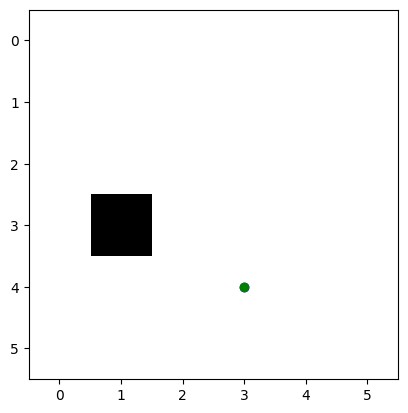

[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383, -0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
 gamma 0.8
[]
[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383, -0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
return []
gae []
0.09960469876429168


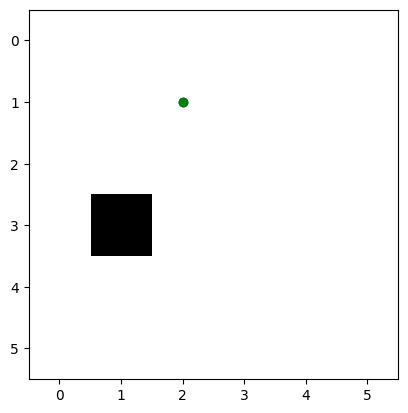

[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383, -0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
 gamma 0.8
[]
[0.077135615, 0.090831704, 0.023502916, 0.090831704, 0.12931252, 0.1395909, 0.13309383, -0.003145796, 0.0064006913, 0.010936994, 0.0064006913, 0.010936994, 0.035955664, 0.12223572, 0.13331486, 0.12992865, 0.13331486, 0.13224769]
return []
gae []
0.47505444346260917
tensor([[ 1.,  5., -1.,  4.]])
tensor([[ 1.,  5., -1.,  4.]])
tensor([[ 0.,  5., -2.,  4.]])
tensor([[ 0.,  5., -2.,  4.]])


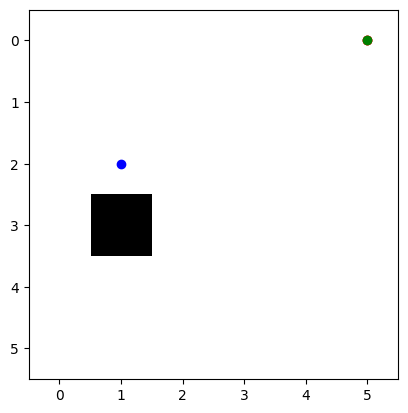

[0.10848715, 0.10357568]
 gamma 0.8
[0, -1]
[0.10848715, 0.10357568]
return [0.08286054134368898, -1.0]
gae [-0.025626610219478596, -1.1035756766796112]
0.07567027040250607
tensor([[ 0.,  4., -5.,  2.]])
tensor([[ 1.,  4., -4.,  2.]])
tensor([[ 1.,  5., -4.,  3.]])
tensor([[ 2.,  5., -3.,  3.]])
tensor([[ 1.,  5., -4.,  3.]])
tensor([[ 1.,  4., -4.,  2.]])
tensor([[ 1.,  3., -4.,  1.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 1.,  1., -4., -1.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 1.,  3., -4.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 1.,  1., -4., -1.]])
tensor([[ 2.,  1., -3., -1.]])
tensor([[ 2.,  0., -3., -2.]])
tensor([[ 3.,  0., -2., -2.]])
tensor([[ 2.,  0., -3., -2.]])
tensor([[ 1.,  0., -4., -2.]])
tensor([[ 0.,  0., -5., -2.]])
tensor([[ 1.,  0., -4., -2.]])
tensor([[ 1.,  1., -4., -1.]])
tensor([[ 0.,  1., -5., -1.]])


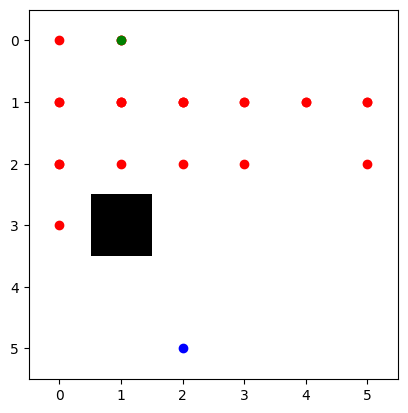

[0.1196318, 0.116203606, 0.10665709, 0.10859088, 0.10665709, 0.116203606, 0.12835774, 0.128673, 0.106860146, 0.128673, 0.12835774, 0.12229504, 0.121592, 0.128673, 0.106860146, 0.07253624, 0.019104317, 0.0046487413, 0.019104317, 0.033242185, 0.069281794, 0.033242185, 0.106860146, 0.113359116]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.1196318, 0.116203606, 0.10665709, 0.10859088, 0.10665709, 0.116203606, 0.12835774, 0.128673, 0.106860146, 0.128673, 0.12835774, 0.12229504, 0.121592, 0.128673, 0.106860146, 0.07253624, 0.019104317, 0.0046487413, 0.019104317, 0.033242185, 0.069281794, 0.033242185, 0.106860146, 0.113359116]
return [0.09296288490295411, 0.08532567024230958, 0.08687270283699036, 0.08532567024230958, 0.09296288490295411, 0.10268619060516358, 0.10293840169906616, 0.08548811674118043, 0.10293840169906616, 0.10268619060516358, 0.09783602952957154, 0.09727360010147096, 0.10293840169906616, 0.08548811674118043, 0.0580289900302887, 0.01528

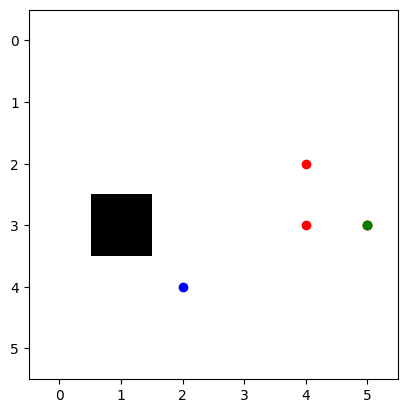

[0.11930004, 0.11685153, 0.11930004, 0.122732654]
 gamma 0.8
[0, 0, 0, -1]
[0.11930004, 0.11685153, 0.11930004, 0.122732654]
return [0.09348122477531434, 0.09544003009796143, 0.09818612337112427, -1.0]
gae [-0.02581881284713744, -0.021411500871181488, -0.021113914251327512, -1.1227326542139053]
0.24296455845634035
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 1.,  2.,  1., -2.]])
tensor([[ 1.,  2.,  1., -2.]])
tensor([[ 1.,  1.,  1., -3.]])
tensor([[ 1.,  1.,  1., -3.]])
tensor([[ 0.,  1.,  0., -3.]])


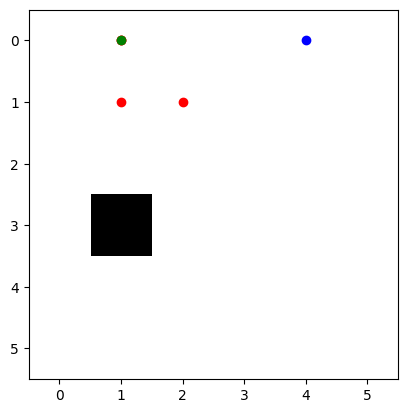

[0.120084874, 0.023050547, 0.0073412606, 0.0155920265]
 gamma 0.8
[0, 0, 0, -1]
[0.120084874, 0.023050547, 0.0073412606, 0.0155920265]
return [0.018440437316894532, 0.005873008444905282, 0.012473621219396592, -1.0]
gae [-0.10164443701505661, -0.017177538201212882, 0.0051323606632649905, -1.0155920265242457]
return [0.1029384  0.1029384  0.1029384  0.10345002 0.10394292 0.10579815
 0.10647507 0.10665189 0.10665189 0.11167272]
return [-1.         -1.         -1.         -1.         -1.         -1.
  0.00371899  0.00512055  0.00512055  0.00587301]

-------------------- Iteration #16 --------------------
random  0.24296455845634035
Average : 0.01
Average Episodic Return: -0.6
Max Episodic Return: 1.0
Average Loss: -0.00255
Average Loss Critic: 0.27010416984558105
TEntropy: nan
approx_kl_divs: [0.0003289063] secs
------------------------------------------------------

0.6717285245875988
tensor([[ 1.,  3.,  0., -1.]])
tensor([[ 0.,  3., -1., -1.]])
tensor([[ 0.,  3., -1., -1.]])


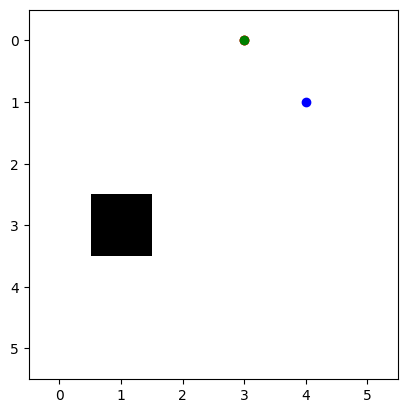

[-0.058143415, -0.054298416]
 gamma 0.8
[0, -1]
[-0.058143415, -0.054298416]
return [-0.043438732624053955, -1.0]
gae [0.014704681932926178, -0.9457015842199326]
0.21253778725457861
tensor([[5., 4., 0., 3.]])
tensor([[ 4.,  4., -1.,  3.]])
tensor([[ 3.,  4., -2.,  3.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 3.,  2., -2.,  1.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 2.,  3., -3.,  2.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 0.,  3., -5.,  2.]])


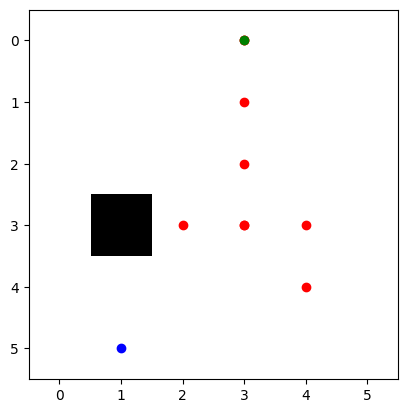

[-0.044070683, -0.021161117, -0.018591348, -0.026294643, -0.043360393, -0.026294643, -0.031076413, -0.035961766, -0.05842234]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.044070683, -0.021161117, -0.018591348, -0.026294643, -0.043360393, -0.026294643, -0.031076413, -0.035961766, -0.05842234]
return [-0.016928893327713013, -0.014873078465461731, -0.021035714447498324, -0.03468831479549408, -0.021035714447498324, -0.02486113011837006, -0.0287694126367569, -0.0467378705739975, -1.0]
gae [0.027141790091991424, 0.0062880381941795346, -0.00244436636567116, -0.008393671736121176, 0.022324679046869276, 0.001433512941002843, 0.002307000011205672, -0.010776104778051382, -0.9415776617825031]
0.7432514394361329
tensor([[5., 3., 2., 1.]])
tensor([[5., 3., 2., 1.]])
tensor([[4., 3., 1., 1.]])
tensor([[4., 3., 1., 1.]])
tensor([[3., 3., 0., 1.]])
tensor([[3., 3., 0., 1.]])


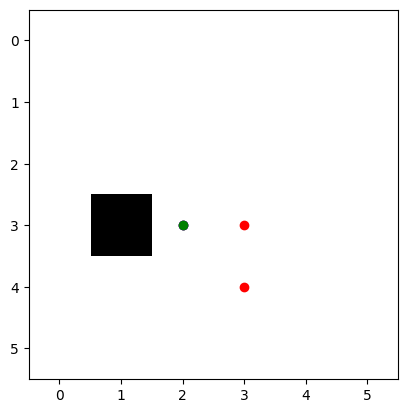

[-0.04547398, -0.041381177, -0.03754398]
 gamma 0.8
[0, 0, 1]
[-0.04547398, -0.041381177, -0.03754398]
return [-0.03310494124889374, -0.03003518283367157, 1.0]
gae [0.01236904039978981, 0.011345993727445602, 1.0375439785420895]
0.876977860463192
tensor([[4., 4., 0., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[4., 4., 0., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[4., 3., 0., 2.]])
tensor([[4., 3., 0., 2.]])
tensor([[4., 2., 0., 1.]])
tensor([[4., 2., 0., 1.]])


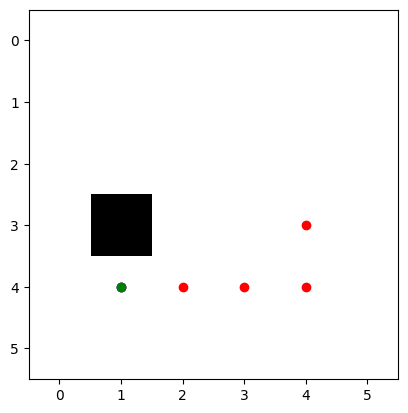

[-0.027279945, -0.016841562, -0.027279945, -0.040548246, -0.041085534]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.027279945, -0.016841562, -0.027279945, -0.040548246, -0.041085534]
return [-0.013473249971866608, -0.021823956072330477, -0.032438597083091734, -0.03286842703819275, 1.0]
gae [0.013806695118546486, -0.004982393607497217, -0.005158651992678641, 0.007679819315671917, 1.041085533797741]
0.38060677486881267
tensor([[5., 4., 1., 0.]])
tensor([[ 5.,  3.,  1., -1.]])
tensor([[5., 4., 1., 0.]])


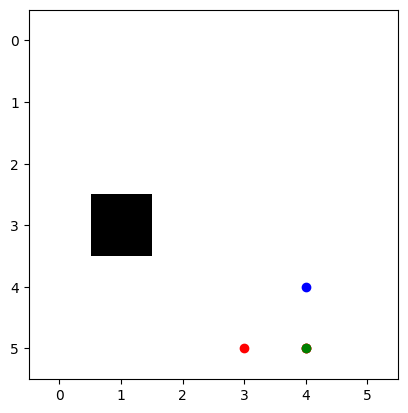

[-0.045208737, -0.043632615, -0.045208737]
 gamma 0.8
[0, 0, -1]
[-0.045208737, -0.043632615, -0.045208737]
return [-0.03490609228610993, -0.03616698980331421, -1.0]
gae [0.010302644968032834, 0.007465625554323195, -0.9547912627458572]
0.434043149642349
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 4.,  1.,  4., -3.]])
tensor([[ 4.,  1.,  4., -3.]])
tensor([[ 4.,  2.,  4., -2.]])
tensor([[ 4.,  2.,  4., -2.]])
tensor([[ 4.,  1.,  4., -3.]])
tensor([[ 3.,  1.,  3., -3.]])
tensor([[ 3.,  0.,  3., -4.]])


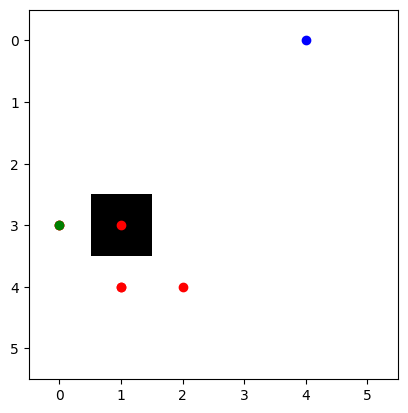

[-0.06956635, -0.08907357, -0.06060223, -0.08907357, -0.09684487, -0.10271685]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.06956635, -0.08907357, -0.06060223, -0.08907357, -0.09684487, -0.10271685]
return [-0.07125885486602783, -0.04848178327083588, -0.07125885486602783, -0.07747589349746704, -0.08217347860336305, -1.0]
gae [-0.0016925081610679599, 0.04059178531169891, -0.010656625777482984, 0.011597675085067746, 0.014671388268470753, -0.8972831517457962]
0.11243774940665885
tensor([[2., 1., 0., 1.]])
tensor([[ 1.,  1., -1.,  1.]])
tensor([[ 1.,  0., -1.,  0.]])
tensor([[ 1.,  1., -1.,  1.]])
tensor([[2., 1., 0., 1.]])


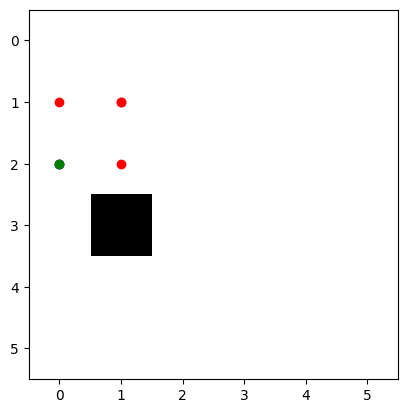

[-0.053782173, -0.053360492, -0.07306747, -0.053360492, -0.053782173]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.053782173, -0.053360492, -0.07306747, -0.053360492, -0.053782173]
return [-0.042688393592834474, -0.05845397710800171, -0.042688393592834474, -0.043025738000869757, 1.0]
gae [0.011093778908252715, -0.005093485116958618, 0.030379077792167662, 0.010334753990173334, 1.0537821725010872]
0.9592734903852539
tensor([[ 1.,  3., -3.,  2.]])
tensor([[ 1.,  3., -3.,  2.]])
tensor([[ 0.,  3., -4.,  2.]])
tensor([[ 0.,  3., -4.,  2.]])
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor(

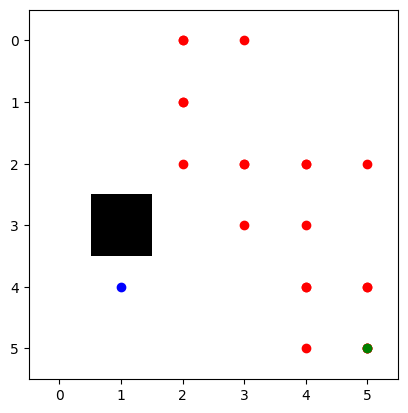

[-0.038002428, -0.06301415, -0.05512866, -0.047563437, -0.05512866, -0.047563437, -0.028231604, -0.030344578, -0.027536396, -0.025175132, -0.027536396, -0.030344578, -0.01971627, -0.016841562, -0.027279945, -0.023557544, -0.027279945, -0.045524735, -0.04139748, -0.023557544, -0.04139748]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.038002428, -0.06301415, -0.05512866, -0.047563437, -0.05512866, -0.047563437, -0.028231604, -0.030344578, -0.027536396, -0.025175132, -0.027536396, -0.030344578, -0.01971627, -0.016841562, -0.027279945, -0.023557544, -0.027279945, -0.045524735, -0.04139748, -0.023557544, -0.04139748]
return [-0.05041131973266602, -0.04410292804241181, -0.03805074989795685, -0.04410292804241181, -0.03805074989795685, -0.022585283219814303, -0.024275662004947664, -0.02202911674976349, -0.02014010548591614, -0.02202911674976349, -0.024275662004947664, -0.015773016214370727, -0.013473249971866608, -0.021823956072330477, -0.01884603500366211, -0

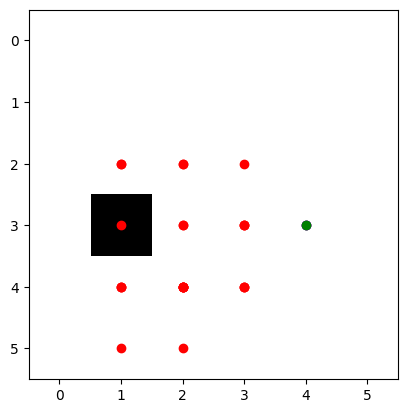

[0.2202814, 0.23436132, 0.23512796, 0.2393308, 0.23512796, 0.2393308, 0.2111766, 0.2393308, 0.24863426, 0.2393308, 0.23512796, 0.2350502, 0.23746711, 0.25449067, 0.23746711, 0.25449067, 0.24863426, 0.22551602, 0.2111766, 0.2393308, 0.2202814, 0.2393308, 0.2111766, 0.22551602, 0.26676688, 0.22551602]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.2202814, 0.23436132, 0.23512796, 0.2393308, 0.23512796, 0.2393308, 0.2111766, 0.2393308, 0.24863426, 0.2393308, 0.23512796, 0.2350502, 0.23746711, 0.25449067, 0.23746711, 0.25449067, 0.24863426, 0.22551602, 0.2111766, 0.2393308, 0.2202814, 0.2393308, 0.2111766, 0.22551602, 0.26676688, 0.22551602]
return [0.18748905658721926, 0.1881023645401001, 0.19146463871002198, 0.1881023645401001, 0.19146463871002198, 0.1689412832260132, 0.19146463871002198, 0.19890741109848023, 0.19146463871002198, 0.1881023645401001, 0.18804016113281252, 0.18997368812561036, 0.20359253883361816, 0.18997368812561036, 0.20359253

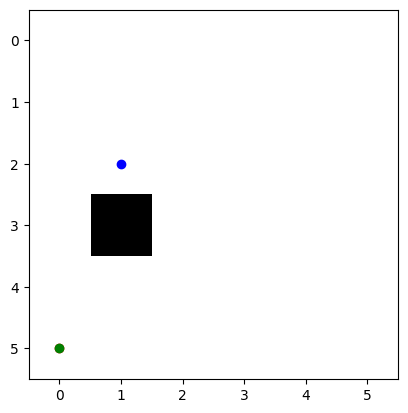

[0.23823383]
 gamma 0.8
[-1]
[0.23823383]
return [-1.0]
gae [-1.2382338345050812]
0.9446514088784669
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  0.,  3., -4.]])
tensor([[ 3.,  0.,  2., -4.]])
tensor([[ 3.,  0.,  2., -4.]])
tensor([[ 2.,  0.,  1., -4.]])


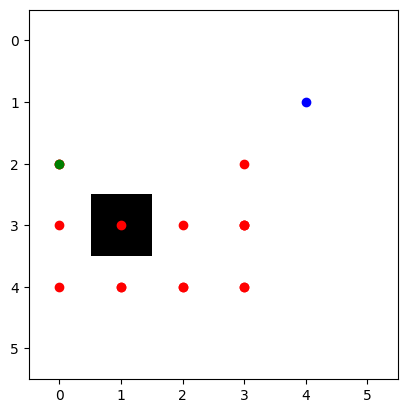

[0.23718633, 0.22525908, 0.23718633, 0.22525908, 0.2031813, 0.21599182, 0.2031813, 0.21599182, 0.24385498, 0.21599182, 0.23398075, 0.23492111, 0.23718633, 0.24368092, 0.24007376, 0.23931584]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.23718633, 0.22525908, 0.23718633, 0.22525908, 0.2031813, 0.21599182, 0.2031813, 0.21599182, 0.24385498, 0.21599182, 0.23398075, 0.23492111, 0.23718633, 0.24368092, 0.24007376, 0.23931584]
return [0.18020726442337037, 0.18974906206130981, 0.18020726442337037, 0.1625450372695923, 0.17279345989227296, 0.1625450372695923, 0.17279345989227296, 0.19508398771286012, 0.17279345989227296, 0.18718459606170657, 0.18793689012527467, 0.18974906206130981, 0.19494473934173584, 0.19205900430679324, 0.1914526700973511, -1.0]
gae [-0.056979063153266896, -0.03551001846790314, -0.056979063153266896, -0.06271404325962066, -0.030387836694717396, -0.05344678759574889, -0.030387836694717396, -0.020907837152481068, -0.07106152474880217, -0.02880722880363462, -

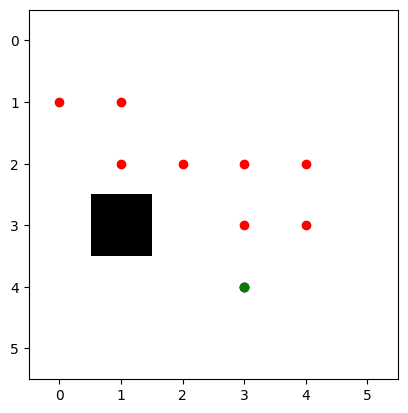

[0.27886897, 0.24703684, 0.27959505, 0.25449365, 0.27157262, 0.27521408, 0.23971198, 0.23372997, 0.21930546]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.27886897, 0.24703684, 0.27959505, 0.25449365, 0.27157262, 0.27521408, 0.23971198, 0.23372997, 0.21930546]
return [0.19762947559356692, 0.22367603778839112, 0.20359492301940918, 0.21725809574127197, 0.22017126083374025, 0.19176958799362184, 0.18698397874832154, 0.1754443645477295, 1.0]
gae [-0.08123949766159055, -0.023360806703567494, -0.07600012421607971, -0.0372355580329895, -0.051401358842849715, -0.08344448804855345, -0.052728006243705744, -0.058285608887672424, 0.7806945443153381]
return [0.1989074  0.20359254 0.20359254 0.20359492 0.2134135  0.2172581
 0.22017126 0.22367604 1.         1.        ]
return [-1.         -1.          0.16254504  0.16254504  0.16894129  0.16894129
  0.16894129  0.17279346  0.17279346  0.17279346]

-------------------- Iteration #18 --------------------
random  0.9251139846916944
Average : 0.01
Average Epi

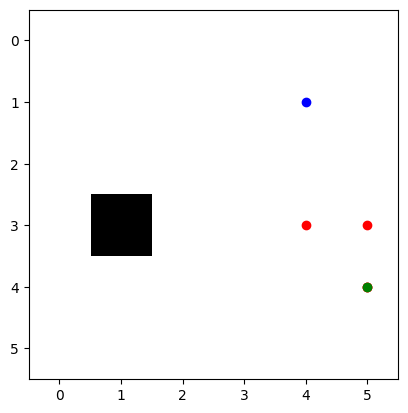

[-0.21062885, -0.23014723, -0.27522638, -0.28721145]
 gamma 0.8
[0, 0, 0, -1]
[-0.21062885, -0.23014723, -0.27522638, -0.28721145]
return [-0.1841177821159363, -0.22018110752105713, -0.2297691583633423, -1.0]
gae [0.026511070132255538, 0.00996612012386322, 0.04545722603797911, -0.7127885520458221]
0.692317139783411
tensor([[ 2.,  3., -1.,  0.]])
tensor([[ 2.,  3., -1.,  0.]])
tensor([[ 1.,  3., -2.,  0.]])
tensor([[ 1.,  3., -2.,  0.]])
tensor([[ 0.,  3., -3.,  0.]])
tensor([[ 0.,  3., -3.,  0.]])
tensor([[ 0.,  4., -3.,  1.]])
tensor([[ 0.,  4., -3.,  1.]])


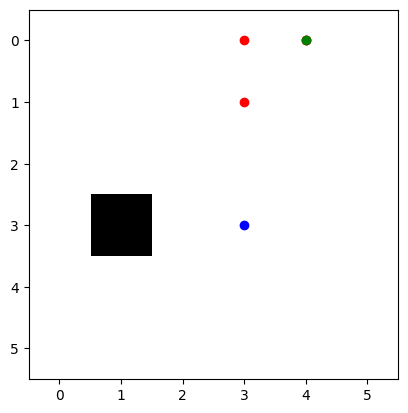

[-0.24481364, -0.20922995, -0.17961846, -0.25789917]
 gamma 0.8
[0, 0, 0, -1]
[-0.24481364, -0.20922995, -0.17961846, -0.25789917]
return [-0.1673839569091797, -0.14369477033615113, -0.20631933212280273, -1.0]
gae [0.07742967903614043, 0.06553517580032348, -0.02670086920261383, -0.7421008348464966]
0.7857596328227152
tensor([[ 2.,  2., -2., -1.]])
tensor([[ 2.,  2., -2., -1.]])
tensor([[ 2.,  1., -2., -2.]])
tensor([[ 2.,  1., -2., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  0., -4., -3.]])
tensor([[ 0.,  0., -4., -3.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  2., -3., -1.]])
tensor([[ 1.,  2., -3., -1.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 2.,  1., -2., -2.]])
tensor([[ 2.,  1., -2., -2.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  1., -3., -2.]])

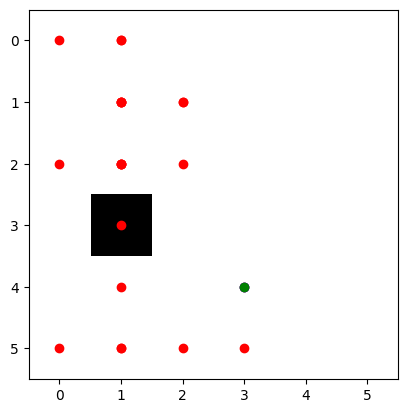

[-0.14118983, -0.111425586, -0.11166154, -0.1195178, -0.10942432, -0.1195178, -0.11166154, -0.12617911, -0.11166154, -0.111425586, -0.11166154, -0.12617911, -0.14118983, -0.111425586, -0.12394258, -0.111425586, -0.13991989, -0.14155644, -0.18831937, -0.10129006, -0.18831937, -0.25038853, -0.2560279]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.14118983, -0.111425586, -0.11166154, -0.1195178, -0.10942432, -0.1195178, -0.11166154, -0.12617911, -0.11166154, -0.111425586, -0.11166154, -0.12617911, -0.14118983, -0.111425586, -0.12394258, -0.111425586, -0.13991989, -0.14155644, -0.18831937, -0.10129006, -0.18831937, -0.25038853, -0.2560279]
return [-0.0891404688358307, -0.08932923078536988, -0.09561424255371094, -0.08753945827484132, -0.09561424255371094, -0.08932923078536988, -0.10094329118728639, -0.08932923078536988, -0.0891404688358307, -0.08932923078536988, -0.10094329118728639, -0.11295186281204224, -0.0891404688358307, -0.09915406107902527, -0.0

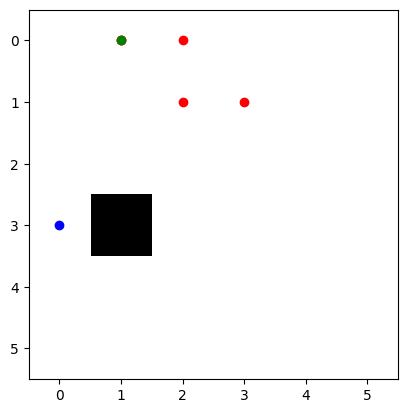

[-0.31481153, -0.33146504, -0.24401657, -0.21780995, -0.13953295]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.31481153, -0.33146504, -0.24401657, -0.21780995, -0.13953295]
return [-0.26517202854156496, -0.19521325826644897, -0.17424795627593995, -0.11162636280059815, -1.0]
gae [0.04963949918746946, 0.1362517774105072, 0.06976861655712127, 0.10618358254432678, -0.8604670464992523]
0.5196511492309954
tensor([[ 0.,  1., -3.,  0.]])
tensor([[ 0.,  2., -3.,  1.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 1.,  2., -2.,  1.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  2., -3.,  1.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  2., -3.,  1.]])
tensor([[ 0.,  3., -3

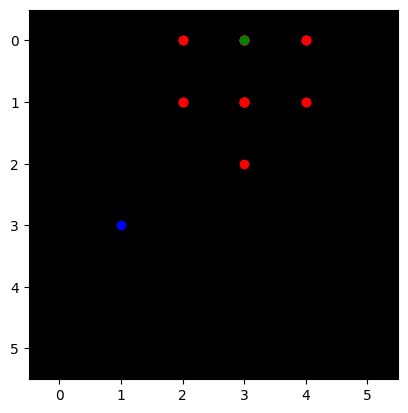

[-0.12738453, -0.16602376, -0.26415038, -0.2760114, -0.186315, -0.2760114, -0.26415038, -0.3654811, -0.3468078, -0.3654811, -0.26415038, -0.16602376, -0.26415038, -0.16602376, -0.26415038, -0.2760114, -0.186315, -0.2760114, -0.27857435, -0.2760114, -0.186315, -0.2760114, -0.3468078, -0.3654811, -0.26415038]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12738453, -0.16602376, -0.26415038, -0.2760114, -0.186315, -0.2760114, -0.26415038, -0.3654811, -0.3468078, -0.3654811, -0.26415038, -0.16602376, -0.26415038, -0.16602376, -0.26415038, -0.2760114, -0.186315, -0.2760114, -0.27857435, -0.2760114, -0.186315, -0.2760114, -0.3468078, -0.3654811, -0.26415038]
return [-0.13281900882720948, -0.2113203048706055, -0.22080912590026858, -0.14905200004577637, -0.22080912590026858, -0.2113203048706055, -0.2923848867416382, -0.2774462461471558, -0.2923848867416382, -0.2113203048706055, -0.13281900882720948, -0.2113203048706055, -0.13281900882720948, -0.2113

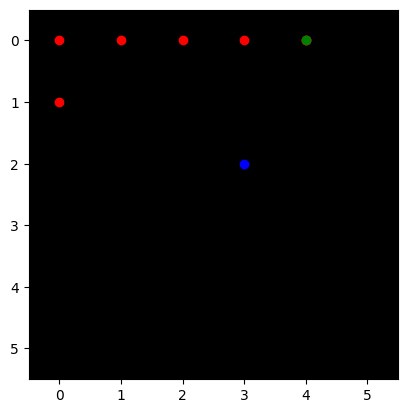

[-0.1810277, -0.17215632, -0.18922336, -0.17655289, -0.1421188, -0.12833022, -0.12185452]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.1810277, -0.17215632, -0.18922336, -0.17655289, -0.1421188, -0.12833022, -0.12185452]
return [-0.13772505521774292, -0.15137869119644165, -0.14124231338500978, -0.11369503736495973, -0.10266417264938354, -0.09748361706733705, -1.0]
gae [0.043302640318870544, 0.020777627825737, 0.04798105061054228, 0.06285785436630248, 0.0394546240568161, 0.030846598744392384, -0.8781454786658287]
0.12209216912281029
tensor([[ 1.,  2., -4.,  1.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 2.,  3., -3.,  2.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 2.,  3., -3.,  2.]])
tensor([[ 2.,  4., -3.,  3.]])
tensor([[ 3.,  4., -2.,  3.]])
tensor([[ 4.,  4., -1.,  3.]])
tensor([[ 4.,  3., -1.,  2.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 3.,  4., -2.,  3.]])
tensor([[ 4.,  4., -1.,  3.]])
tensor([[5., 4., 0., 3.]])
tensor([[5., 5., 0., 4.]])
tensor([[5., 4., 0., 3.]])
tensor([[5., 4.,

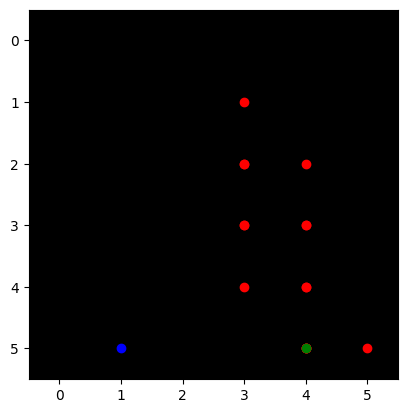

[-0.13450457, -0.11805536, -0.11627223, -0.108956896, -0.11627223, -0.115061924, -0.10807667, -0.10686255, -0.10797817, -0.108956896, -0.10807667, -0.10686255, -0.124037385, -0.16539049, -0.124037385]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13450457, -0.11805536, -0.11627223, -0.108956896, -0.11627223, -0.115061924, -0.10807667, -0.10686255, -0.10797817, -0.108956896, -0.10807667, -0.10686255, -0.124037385, -0.16539049, -0.124037385]
return [-0.09444428682327272, -0.09301778674125671, -0.08716551661491395, -0.09301778674125671, -0.09204953908920288, -0.08646133542060852, -0.08549004197120667, -0.08638253808021545, -0.08716551661491395, -0.08646133542060852, -0.08549004197120667, -0.09922990798950196, -0.13231239318847657, -0.09922990798950196, -1.0]
gae [0.04006028473377227, 0.025037571787834167, 0.02910671681165694, 0.01593910902738571, 0.02422269433736801, 0.02860058844089508, 0.022586627304553977, 0.020480014383792877, 0.020812655985355366, 0.022495560348033905

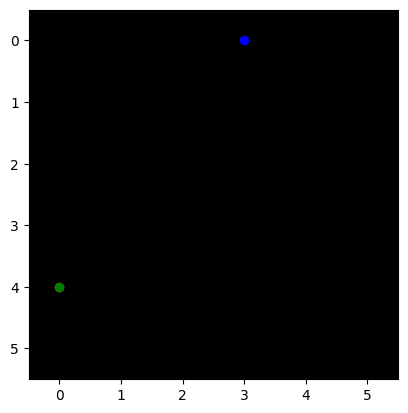

[-0.10860989]
 gamma 0.8
[-1]
[-0.10860989]
return [-1.0]
gae [-0.8913901075720787]
0.29974415960447043
tensor([[5., 5., 0., 5.]])
tensor([[5., 4., 0., 4.]])
tensor([[5., 4., 0., 4.]])
tensor([[5., 5., 0., 5.]])


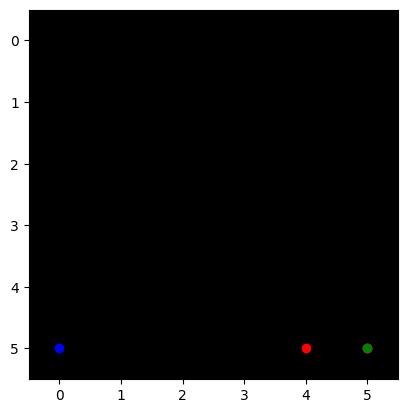

[-0.1965034, -0.1326338, -0.1965034]
 gamma 0.8
[0, 0, -1]
[-0.1965034, -0.1326338, -0.1965034]
return [-0.1061070442199707, -0.15720272064208984, -1.0]
gae [0.0903963565826416, -0.024568915367126465, -0.8034965991973877]
0.583281736020519
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])


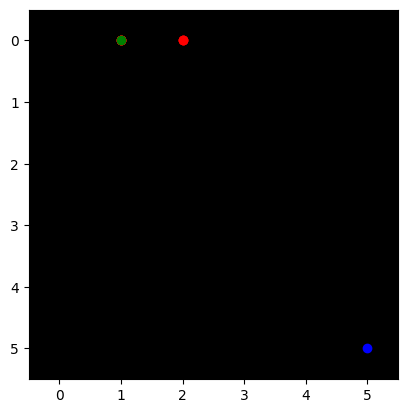

[-0.18134233, -0.14558397, -0.18134233, -0.14558397, -0.18134233, -0.14558397, -0.18134233]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.18134233, -0.14558397, -0.18134233, -0.14558397, -0.18134233, -0.14558397, -0.18134233]
return [-0.1164671778678894, -0.14507386684417725, -0.1164671778678894, -0.14507386684417725, -0.1164671778678894, -0.14507386684417725, -1.0]
gae [0.06487515568733215, 0.0005101054906845037, 0.06487515568733215, 0.0005101054906845037, 0.06487515568733215, 0.0005101054906845037, -0.8186576664447784]
0.7487354330905756
tensor([[4., 4., 4., 4.]])
tensor([[4., 5., 4., 5.]])
tensor([[4., 5., 4., 5.]])
tensor([[4., 4., 4., 4.]])
tensor([[4., 4., 4., 4.]])
tensor([[4., 5., 4., 5.]])
tensor([[4., 5., 4., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[2., 5., 2., 5.]])
tensor([[2., 5., 2., 5.]])
tensor([[1., 5., 1., 5.]])
tensor([[1., 5., 1., 5.]])
tensor([[0., 5., 0., 5.]])
tensor([[0., 5., 0., 5.]])


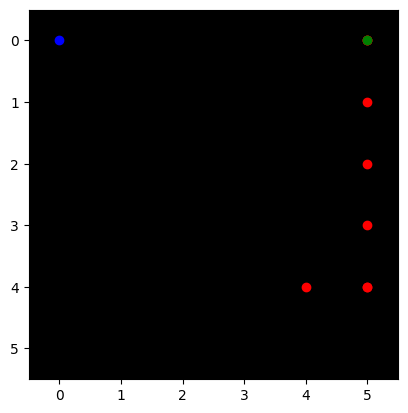

[-0.21465872, -0.34146047, -0.21465872, -0.34146047, -0.28265613, -0.24486975, -0.22099903, -0.20650229]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.21465872, -0.34146047, -0.21465872, -0.34146047, -0.28265613, -0.24486975, -0.22099903, -0.20650229]
return [-0.27316837310791015, -0.1717269778251648, -0.27316837310791015, -0.22612490653991701, -0.19589580297470094, -0.17679922580718996, -0.16520183086395265, -1.0]
gae [-0.05850965082645415, 0.1697334885597229, -0.05850965082645415, 0.11533555984497068, 0.0867603302001953, 0.0680705279111862, 0.05579720139503477, -0.7934977114200592]
0.2625068452336118
tensor([[ 0.,  5., -4.,  4.]])


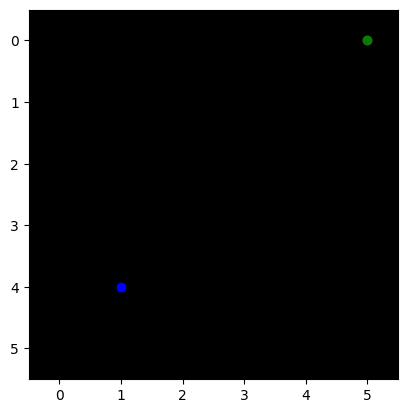

[-0.1397375]
 gamma 0.8
[-1]
[-0.1397375]
return [-1.0]
gae [-0.8602624982595444]
0.20424232980030155
tensor([[ 0.,  0., -1., -3.]])


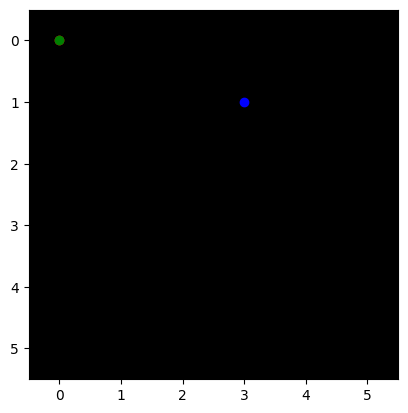

[-0.18429074]
 gamma 0.8
[-1]
[-0.18429074]
return [-1.0]
gae [-0.815709263086319]
0.7958875699878891
tensor([[0., 5., 0., 2.]])


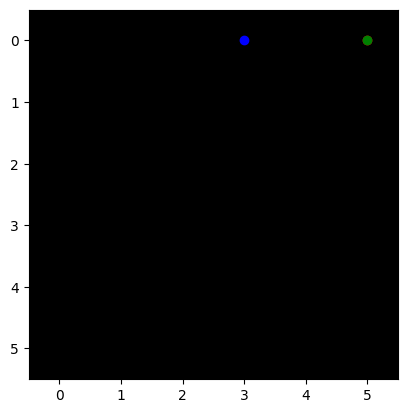

[-0.12562156]
 gamma 0.8
[-1]
[-0.12562156]
return [-1.0]
gae [-0.8743784427642822]
0.4700593890642585
tensor([[ 0.,  2., -4.,  1.]])


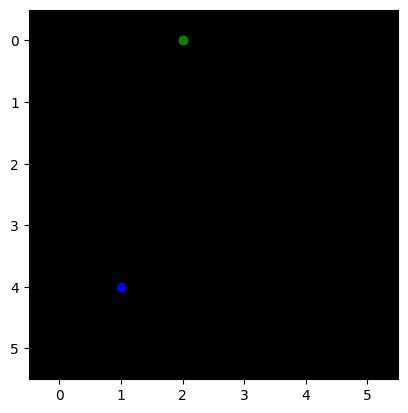

[-0.13292307]
 gamma 0.8
[-1]
[-0.13292307]
return [-1.0]
gae [-0.8670769333839417]
0.6158757152918805
tensor([[ 2.,  5., -2.,  0.]])
tensor([[ 2.,  5., -2.,  0.]])
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 2.,  3., -2., -2.]])
tensor([[ 1.,  3., -3., -2.]])
tensor([[ 1.,  3., -3., -2.]])
tensor([[ 1.,  2., -3., -3.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  2., -4., -3.]])


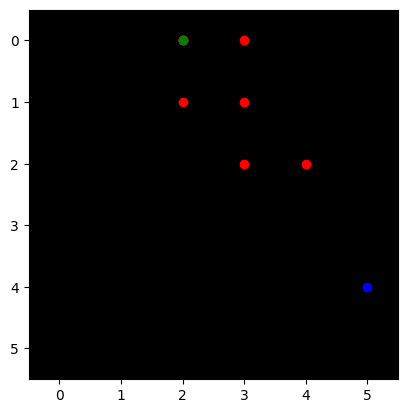

[-0.11154469, -0.1179808, -0.15183678, -0.140372, -0.17902163, -0.14673729, -0.1342134, -0.14673729]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.11154469, -0.1179808, -0.15183678, -0.140372, -0.17902163, -0.14673729, -0.1342134, -0.14673729]
return [-0.09438464045524597, -0.12146942615509033, -0.11229759454727173, -0.14321730136871338, -0.11738983392715455, -0.10737072229385376, -0.11738983392715455, -1.0]
gae [0.017160050570964813, -0.00348862558603287, 0.039539188146591187, -0.002845308184623724, 0.06163179278373718, 0.039366570115089414, 0.016823568940162653, -0.8532627075910568]
return [-0.09301779 -0.09301779 -0.09204954 -0.08716552 -0.08716552 -0.08646134
 -0.08646134 -0.08638254 -0.08549004 -0.08549004]
return [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

-------------------- Iteration #20 --------------------
random  0.6158757152918805
Average : 0.01
Average Episodic Return: -0.6
Max Episodic Return: 1.0
Average Loss: -0.00341
Average Loss Critic: 0.26417768001556396
TEntropy: nan
ap

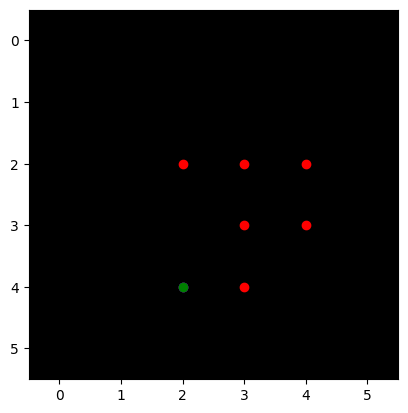

[-0.13970068, -0.14101537, -0.13970068, -0.13607796, -0.10310977, -0.10328994, -0.10501106]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 1]
[-0.13970068, -0.14101537, -0.13970068, -0.13607796, -0.10310977, -0.10328994, -0.10501106]
return [-0.11281229257583619, -0.1117605447769165, -0.10886236429214478, -0.08248781561851502, -0.08263195157051087, -0.08400884866714478, 1.0]
gae [0.026888388395309437, 0.02925482094287872, 0.030838316679000846, 0.053590139746665946, 0.0204778179526329, 0.0192810907959938, 1.105011060833931]
0.393912552427496
tensor([[ 1.,  3., -3., -2.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 2.,  1., -2., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tenso

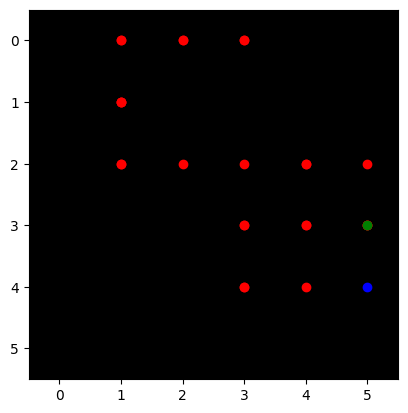

[-0.14781432, -0.14645588, -0.14411677, -0.14645588, -0.14411677, -0.14712776, -0.14181136, -0.12604235, -0.14181136, -0.14712776, -0.14181136, -0.12604235, -0.11586267, -0.12023074, -0.113969326, -0.11751998, -0.113969326, -0.109349266, -0.1073736, -0.1124686, -0.1151321, -0.1124686, -0.1151321, -0.109349266, -0.1085255]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.14781432, -0.14645588, -0.14411677, -0.14645588, -0.14411677, -0.14712776, -0.14181136, -0.12604235, -0.14181136, -0.14712776, -0.14181136, -0.12604235, -0.11586267, -0.12023074, -0.113969326, -0.11751998, -0.113969326, -0.109349266, -0.1073736, -0.1124686, -0.1151321, -0.1124686, -0.1151321, -0.109349266, -0.1085255]
return [-0.1171647071838379, -0.11529341936111451, -0.1171647071838379, -0.11529341936111451, -0.11770220994949342, -0.11344908475875855, -0.10083388090133667, -0.11344908475875855, -0.11770220994949342, -0.11344908475875855, -0.10083388090133667, -0.0926901340484

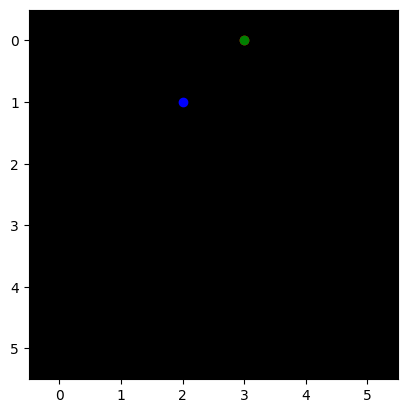

[-0.14804897]
 gamma 0.8
[-1]
[-0.14804897]
return [-1.0]
gae [-0.8519510328769684]
0.7377804249744169
tensor([[3., 5., 3., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 4., 2., 1.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 4., 2., 1.]])
tensor([[2., 4., 2., 1.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[1., 5., 1., 2.]])
tensor([[1., 5., 1., 2.]])
tensor([[0., 5., 0., 2.]])


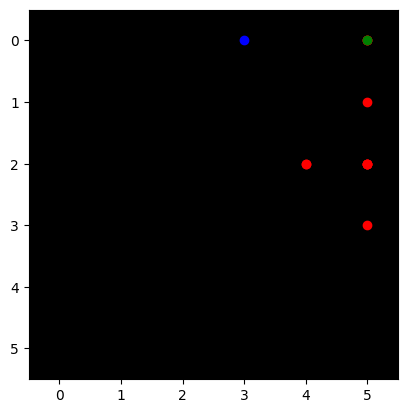

[-0.12501985, -0.122325964, -0.12501985, -0.122325964, -0.12722786, -0.122325964, -0.12722786, -0.122325964, -0.12764001, -0.14139946]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12501985, -0.122325964, -0.12501985, -0.122325964, -0.12722786, -0.122325964, -0.12722786, -0.122325964, -0.12764001, -0.14139946]
return [-0.0978607714176178, -0.10001587867736816, -0.0978607714176178, -0.10178228616714478, -0.0978607714176178, -0.10178228616714478, -0.0978607714176178, -0.10211200714111329, -0.11311956644058228, -1.0]
gae [0.027159076929092404, 0.022310085594654083, 0.027159076929092404, 0.020543678104877464, 0.02936708629131317, 0.020543678104877464, 0.02936708629131317, 0.020213957130908955, 0.014520442485809318, -0.8586005419492722]
0.7933459042017648
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  2., -4

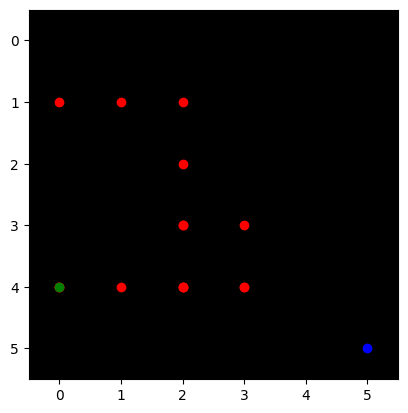

[-0.14579594, -0.15178746, -0.14579594, -0.14444941, -0.118790336, -0.1128, -0.11089777, -0.10007058, -0.11011836, -0.10007058, -0.11011836, -0.1128, -0.11011836, -0.11605119, -0.11687986]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.14579594, -0.15178746, -0.14579594, -0.14444941, -0.118790336, -0.1128, -0.11089777, -0.10007058, -0.11011836, -0.10007058, -0.11011836, -0.1128, -0.11011836, -0.11605119, -0.11687986]
return [-0.12142996788024903, -0.11663675308227539, -0.11555953025817872, -0.09503226876258851, -0.0902400016784668, -0.08871821761131288, -0.08005646467208863, -0.08809468746185303, -0.08005646467208863, -0.08809468746185303, -0.0902400016784668, -0.08809468746185303, -0.0928409516811371, -0.09350388646125794, -1.0]
gae [0.024365973472595212, 0.03515070676803589, 0.030236411094665516, 0.04941714406013488, 0.02855033427476883, 0.02408178448677062, 0.030841307342052454, 0.011975893378257746, 0.030061894655227656, 0.011975893378257746, 0.019878357648849487, 0.

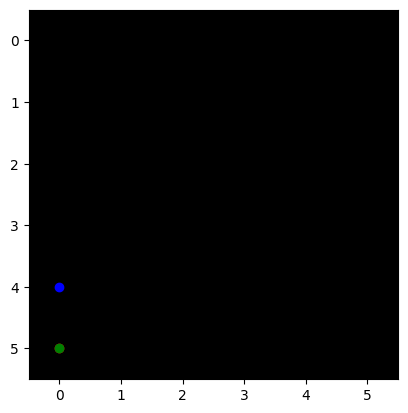

[-0.3549606]
 gamma 0.8
[-1]
[-0.3549606]
return [-1.0]
gae [-0.6450394093990326]
0.9066297271880938
tensor([[1., 3., 1., 2.]])
tensor([[1., 3., 1., 2.]])
tensor([[1., 2., 1., 1.]])
tensor([[1., 2., 1., 1.]])
tensor([[2., 2., 2., 1.]])
tensor([[2., 2., 2., 1.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 2., 2., 1.]])
tensor([[2., 2., 2., 1.]])
tensor([[1., 2., 1., 1.]])
tensor([[1., 2., 1., 1.]])
tensor([[1., 3., 1., 2.]])
tensor([[1., 3., 1., 2.]])
tensor([[0., 3., 0., 2.]])
tensor([[0., 3., 0., 2.]])
tensor([[1., 3., 1., 2.]])
tensor([[1., 3., 1., 2.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 3., 2., 2.]])
tensor([[3., 3., 3., 2.]])
tensor([[3., 3., 3., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[4., 2., 4., 1.]])
tensor([[4., 2., 4., 1.]])
tensor([[3., 2., 3., 1.]])
tensor([[3., 2., 3., 1.]])
tensor([[3., 1., 3., 0.]])
tensor([[3., 1., 3., 0.]])
tensor([[2., 1., 2., 0.]])
tensor([[2., 1., 2., 0.]])
tensor([[3., 1., 3., 0.]])
tensor([

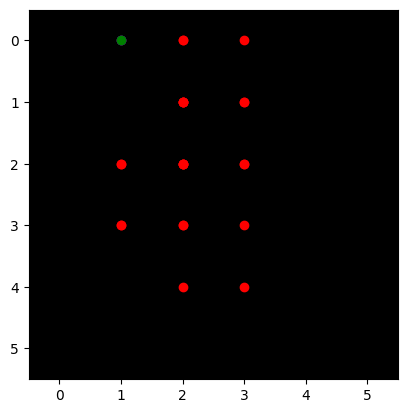

[-0.3560058, -0.37313908, -0.37990773, -0.3524197, -0.37990773, -0.37313908, -0.3560058, -0.35200578, -0.3560058, -0.3524197, -0.36233398, -0.34757647, -0.3597056, -0.37734205, -0.37284464, -0.36921358, -0.37284464, -0.37734205, -0.37990773, -0.36921358, -0.37990773, -0.37313908, -0.3591287, -0.37313908, -0.3591287]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.3560058, -0.37313908, -0.37990773, -0.3524197, -0.37990773, -0.37313908, -0.3560058, -0.35200578, -0.3560058, -0.3524197, -0.36233398, -0.34757647, -0.3597056, -0.37734205, -0.37284464, -0.36921358, -0.37284464, -0.37734205, -0.37990773, -0.36921358, -0.37990773, -0.37313908, -0.3591287, -0.37313908, -0.3591287]
return [-0.298511266708374, -0.3039261817932129, -0.28193576335906984, -0.3039261817932129, -0.298511266708374, -0.284804630279541, -0.2816046237945557, -0.284804630279541, -0.28193576335906984, -0.2898671865463257, -0.27806117534637453, -0.28776447772979735, -0.30187363624572

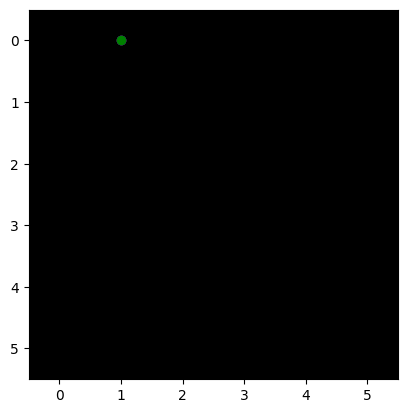

[-0.38128597]
 gamma 0.8
[1]
[-0.38128597]
return [1.0]
gae [1.3812859654426575]
0.6695938695052234
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 1.,  2., -2., -2.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  2., -2., -2.]])
tensor([[ 1.,  2., -2., -2.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 2.,  5., -1.,  1.]])
t

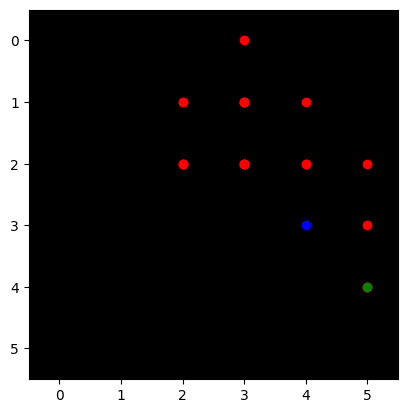

[-0.34778506, -0.33846012, -0.3519857, -0.36156294, -0.34801248, -0.35563472, -0.34778506, -0.35563472, -0.34946442, -0.35563472, -0.34801248, -0.36156294, -0.3519857, -0.36156294, -0.3519857, -0.35563472, -0.3519857, -0.33846012, -0.32921055, -0.31616458, -0.31454676]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.34778506, -0.33846012, -0.3519857, -0.36156294, -0.34801248, -0.35563472, -0.34778506, -0.35563472, -0.34946442, -0.35563472, -0.34801248, -0.36156294, -0.3519857, -0.36156294, -0.3519857, -0.35563472, -0.3519857, -0.33846012, -0.32921055, -0.31616458, -0.31454676]
return [-0.27076809406280516, -0.2815885543823242, -0.28925034999847415, -0.2784099817276001, -0.2845077753067017, -0.2782280445098877, -0.2845077753067017, -0.279571533203125, -0.2845077753067017, -0.2784099817276001, -0.28925034999847415, -0.2815885543823242, -0.28925034999847415, -0.2815885543823242, -0.2845077753067017, -0.2815885543823242, -0.27076809406280516, -0.263368439674

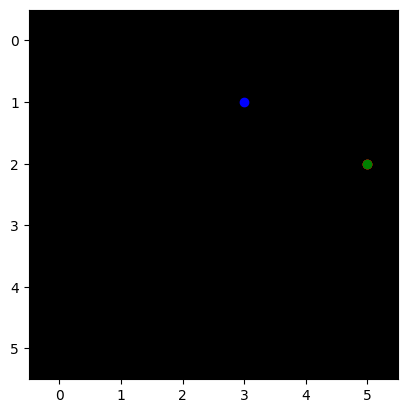

[-0.33882684, -0.32341927]
 gamma 0.8
[0, -1]
[-0.33882684, -0.32341927]
return [-0.25873541831970215, -1.0]
gae [0.08009141683578491, -0.6765807271003723]
return [-0.27822804 -0.27806118 -0.2707681  -0.2707681  -0.26336843 -0.25873542
 -0.25293165 -0.2516374   1.          1.        ]
return [-1.         -1.         -1.         -0.30392617 -0.30392617 -0.30392617
 -0.30392617 -0.30187362 -0.30187362 -0.29851127]

-------------------- Iteration #22 --------------------
random  0.4685593402649928
Average : 0.01
Average Episodic Return: -0.57
Max Episodic Return: 1.0
Average Loss: 0.00274
Average Loss Critic: 0.25693365931510925
TEntropy: nan
approx_kl_divs: [0.0002581431] secs
------------------------------------------------------

0.9305216920522794
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])


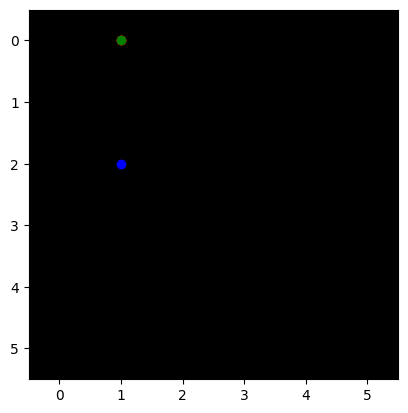

[-0.36648542, -0.3733145]
 gamma 0.8
[0, -1]
[-0.36648542, -0.3733145]
return [-0.2986515998840332, -1.0]
gae [0.06783381700515745, -0.6266855001449585]
0.30603686929486285
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 0.,  1.,  0., -2.]])
tensor([[ 0.,  2.,  0., -1.]])


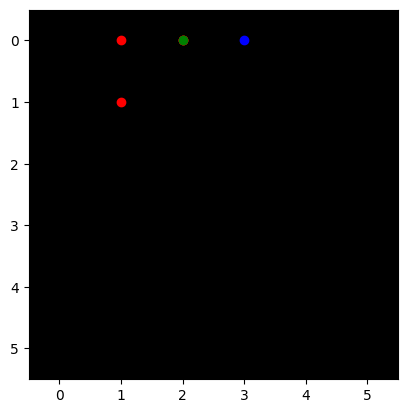

[-0.40535036, -0.38801014, -0.36122254, -0.37814042]
 gamma 0.8
[0, 0, 0, -1]
[-0.40535036, -0.38801014, -0.36122254, -0.37814042]
return [-0.3104081153869629, -0.2889780282974243, -0.30251233577728276, -1.0]
gae [0.09494224190711975, 0.09903211593627931, 0.058710199594497636, -0.6218595802783966]
0.12354323743710349
tensor([[4., 5., 0., 5.]])


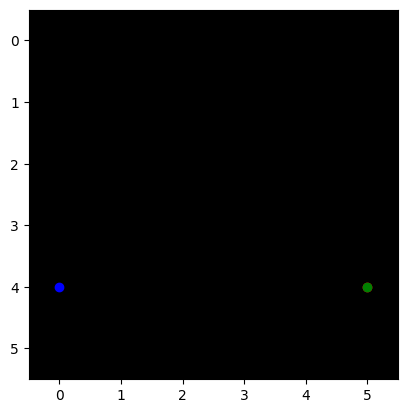

[-0.4565952]
 gamma 0.8
[-1]
[-0.4565952]
return [-1.0]
gae [-0.5434047877788544]
0.6978183401430329
tensor([[5., 5., 1., 2.]])
tensor([[5., 4., 1., 1.]])
tensor([[5., 4., 1., 1.]])
tensor([[4., 4., 0., 1.]])


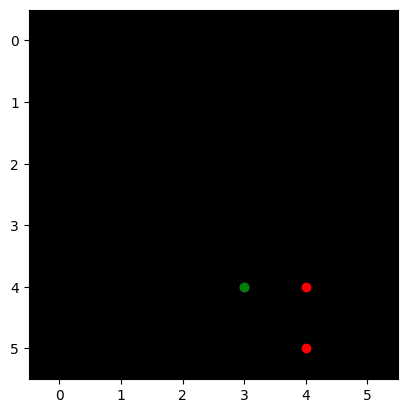

[-0.46497154, -0.46328384, -0.4442484]
 gamma 0.8
[0, 0, 1]
[-0.46497154, -0.46328384, -0.4442484]
return [-0.3706270694732666, -0.3553987264633179, 1.0]
gae [0.09434447288513181, 0.10788511037826537, 1.4442484080791473]
0.6321142140504941
tensor([[ 1.,  2.,  1., -2.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  3.,  0., -1.]])


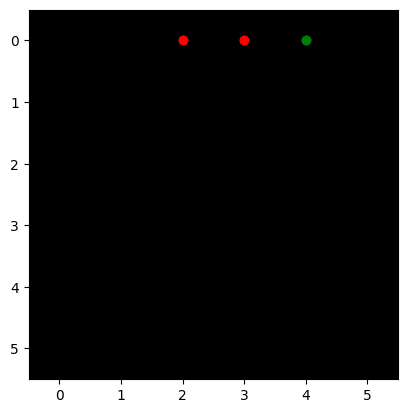

[-0.38966087, -0.3686539, -0.3951009, -0.3686539, -0.3951009]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.38966087, -0.3686539, -0.3951009, -0.3686539, -0.3951009]
return [-0.2949231147766113, -0.31608071327209475, -0.2949231147766113, -0.31608071327209475, 1.0]
gae [0.09473775029182435, 0.05257318019866941, 0.10017777681350709, 0.05257318019866941, 1.3951008915901184]
0.02373564243811077
tensor([[5., 4., 3., 4.]])


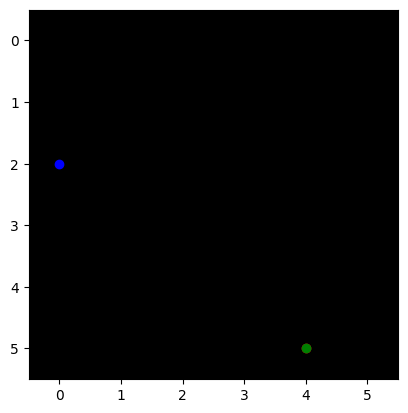

[-0.4634955]
 gamma 0.8
[-1]
[-0.4634955]
return [-1.0]
gae [-0.5365045070648193]
0.8334429077468957
tensor([[3., 4., 2., 1.]])
tensor([[3., 4., 2., 1.]])
tensor([[4., 4., 3., 1.]])
tensor([[4., 4., 3., 1.]])
tensor([[3., 4., 2., 1.]])
tensor([[3., 4., 2., 1.]])
tensor([[4., 4., 3., 1.]])
tensor([[4., 3., 3., 0.]])
tensor([[4., 3., 3., 0.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  2., -1.]])
tensor([[ 3.,  2.,  2., -1.]])
tensor([[ 3.,  1.,  2., -2.]])
tensor([[ 3.,  1.,  2., -2.]])
tensor([[ 2.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  1., -2.]])
tensor([[ 2.,  0.,  1., -3.]])
tensor([[ 2.,  0.,  1., -3.]])


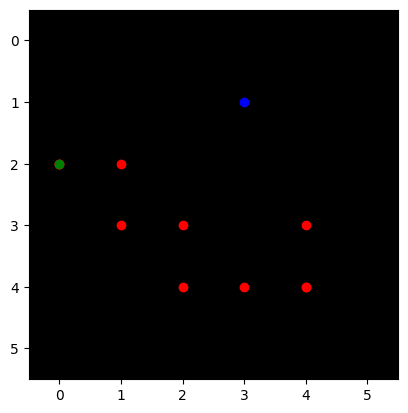

[-0.46230164, -0.45990846, -0.46230164, -0.45990846, -0.46022102, -0.44303623, -0.4367454, -0.4036468, -0.4060654, -0.40489948]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.46230164, -0.45990846, -0.46230164, -0.45990846, -0.46022102, -0.44303623, -0.4367454, -0.4036468, -0.4060654, -0.40489948]
return [-0.36792676448822026, -0.3698413133621216, -0.36792676448822026, -0.36817681789398193, -0.3544289827346802, -0.3493963241577149, -0.3229174375534058, -0.3248523235321045, -0.3239195823669434, -1.0]
gae [0.09437487721443172, 0.09006714224815365, 0.09437487721443172, 0.09173163771629333, 0.10579203963279721, 0.09363990426063534, 0.11382796764373776, 0.07879447340965268, 0.08214582204818721, -0.5951005220413208]
0.396200606067459
tensor([[ 5.,  0.,  1., -1.]])
tensor([[ 5.,  0.,  1., -1.]])
tensor([[5., 1., 1., 0.]])


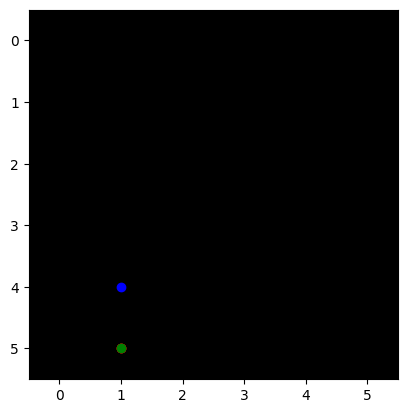

[-0.4204559, -0.44153035]
 gamma 0.8
[0, -1]
[-0.4204559, -0.44153035]
return [-0.3532242774963379, -1.0]
gae [0.06723162531852722, -0.5584696531295776]
0.7263682261985249
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  0.,  0., -3.]])
tensor([[ 3.,  0.,  0., -3.]])
tensor([[ 2.,  0., -1., -3.]])
tensor([[ 2.,  0., -1., -3.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  0.,  0., -3.]])
tensor([[ 3.,  0.,  0., -3.]])


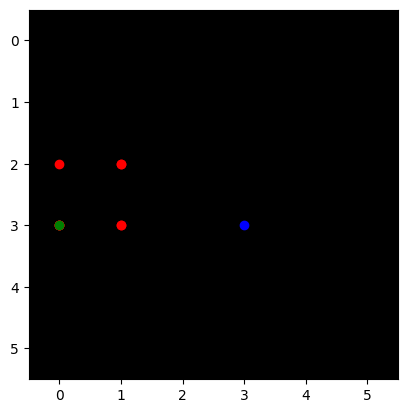

[-0.40009874, -0.36928543, -0.40009874, -0.39662597, -0.38110682, -0.36928543, -0.40009874, -0.39662597]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.40009874, -0.36928543, -0.40009874, -0.39662597, -0.38110682, -0.36928543, -0.40009874, -0.39662597]
return [-0.29542834758758546, -0.32007899284362795, -0.3173007726669312, -0.30488545894622804, -0.29542834758758546, -0.32007899284362795, -0.3173007726669312, -1.0]
gae [0.10467039346694945, 0.04920644164085386, 0.08279796838760373, 0.0917405068874359, 0.08567847609519957, 0.04920644164085386, 0.08279796838760373, -0.6033740341663361]
0.581368093867738
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  3.,  2., -1.]])
tensor([[ 5.,  3.,  2., -1.]])
tensor([[5., 4., 2., 0.]])
tensor([[5., 4., 2., 0.]])
tensor([[5., 5., 2., 1.]])


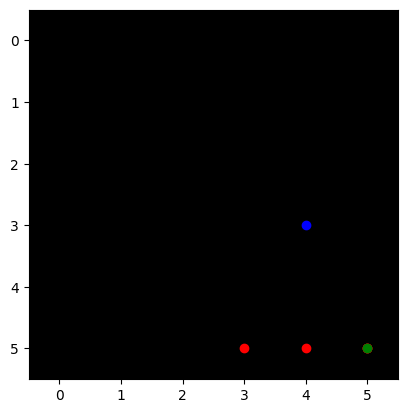

[-0.4409699, -0.45537862, -0.46353832, -0.4642887]
 gamma 0.8
[0, 0, 0, -1]
[-0.4409699, -0.45537862, -0.46353832, -0.4642887]
return [-0.3643028974533081, -0.3708306550979614, -0.3714309692382813, -1.0]
gae [0.07666701674461363, 0.0845479667186737, 0.0921073496341705, -0.5357112884521484]
0.2928274963165901
tensor([[ 5.,  0.,  4., -4.]])
tensor([[ 4.,  0.,  3., -4.]])
tensor([[ 4.,  0.,  3., -4.]])
tensor([[ 5.,  0.,  4., -4.]])
tensor([[ 5.,  1.,  4., -3.]])


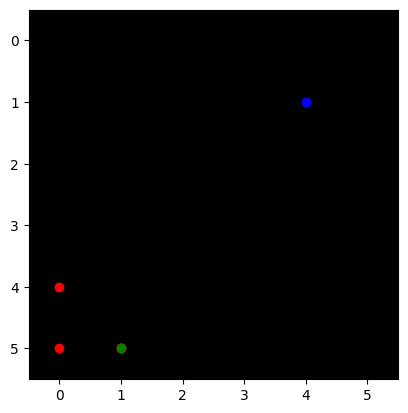

[-0.40069014, -0.39684784, -0.40069014, -0.41802943]
 gamma 0.8
[0, 0, 0, -1]
[-0.40069014, -0.39684784, -0.40069014, -0.41802943]
return [-0.3174782752990723, -0.32055211067199707, -0.3344235420227051, -1.0]
gae [0.08321186304092404, 0.07629573345184326, 0.06626659631729126, -0.5819705724716187]
0.6272177564849833
tensor([[2., 5., 1., 1.]])
tensor([[3., 5., 2., 1.]])
tensor([[3., 5., 2., 1.]])
tensor([[3., 4., 2., 0.]])
tensor([[3., 4., 2., 0.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  2., -4.]])
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 1.,  0.,  0., -4.]])


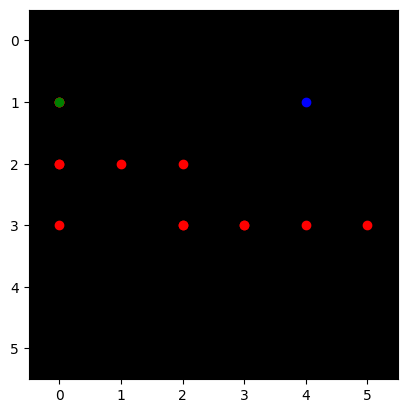

[-0.45782447, -0.46448773, -0.4643387, -0.46413445, -0.42602062, -0.46413445, -0.42602062, -0.41034964, -0.406079, -0.40453982, -0.4001245, -0.40453982, -0.38552645]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.45782447, -0.46448773, -0.4643387, -0.46413445, -0.42602062, -0.46413445, -0.42602062, -0.41034964, -0.406079, -0.40453982, -0.4001245, -0.40453982, -0.38552645]
return [-0.3715901851654053, -0.3714709520339966, -0.3713075637817383, -0.3408164978027344, -0.3713075637817383, -0.3408164978027344, -0.32827970981597904, -0.3248631954193115, -0.3236318588256836, -0.3200995922088623, -0.3236318588256836, -0.3084211587905884, -1.0]
gae [0.08623428344726558, 0.09301677942275999, 0.09303112626075744, 0.12331795692443848, 0.054713058471679676, 0.12331795692443848, 0.09774091243743893, 0.08548644185066223, 0.08244713544845578, 0.08444023132324219, 0.07649263143539425, 0.09611866474151609, -0.6144735515117645]
return [-0.30488545 -0.30251235 -0.2986516  -0.29542834 -0.29542834 -0

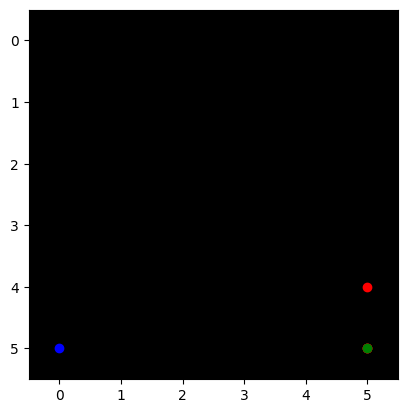

[-0.5026097, -0.5143757, -0.5117645]
 gamma 0.8
[0, 0, -1]
[-0.5026097, -0.5143757, -0.5117645]
return [-0.4115005493164063, -0.40941162109375, -1.0]
gae [0.09110918045043942, 0.1049640655517578, -0.4882354736328125]
0.7030885527575922
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 1.,  2., -4., -2.]])
tensor([[ 1.,  2., -4., -2.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 1.,  1., -4., -3.]])
tensor([[ 1.,  1., -4., -3.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 1.,  1., -4., -3.]])
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 1.,  0., -4., -4.]])


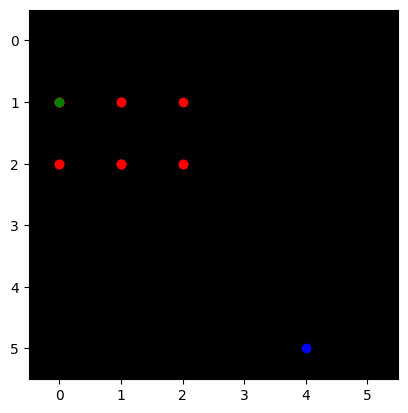

[-0.5062895, -0.49935102, -0.5051419, -0.51686376, -0.52016914, -0.51686376, -0.5051419, -0.5146033, -0.5051419, -0.49935102, -0.5062895, -0.5146033, -0.5062895]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.5062895, -0.49935102, -0.5051419, -0.51686376, -0.52016914, -0.51686376, -0.5051419, -0.5146033, -0.5051419, -0.49935102, -0.5062895, -0.5146033, -0.5062895]
return [-0.39948081970214844, -0.4041135311126709, -0.41349101066589355, -0.416135311126709, -0.41349101066589355, -0.4041135311126709, -0.41168265342712407, -0.4041135311126709, -0.39948081970214844, -0.4050315856933594, -0.41168265342712407, -0.4050315856933594, -1.0]
gae [0.10680866241455078, 0.09523749351501465, 0.09165090322494507, 0.10072845220565796, 0.10667812824249268, 0.11275023221969604, 0.09345926046371456, 0.11048978567123413, 0.10566109418869019, 0.09431943893432615, 0.09460682868957515, 0.10957173109054563, -0.4937105178833008]
0.43122352574902834
tensor([[ 5.,  0.,  1., -2.]])
tensor([[ 5.,  0.,  1., 

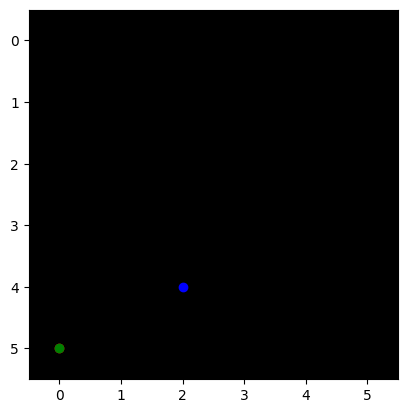

[-0.50553364]
 gamma 0.8
[-1]
[-0.50553364]
return [-1.0]
gae [-0.4944663643836975]
0.06327645712256147
tensor([[ 5.,  3.,  0., -2.]])
tensor([[ 5.,  4.,  0., -1.]])


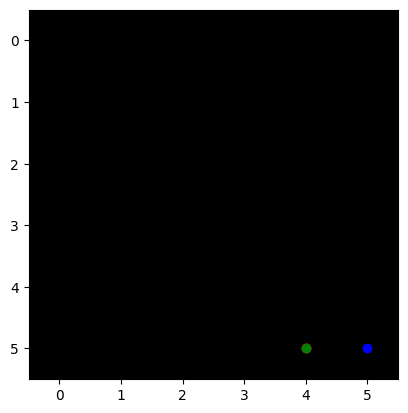

[-0.5124561, -0.50869256]
 gamma 0.8
[0, -1]
[-0.5124561, -0.50869256]
return [-0.4069540500640869, -1.0]
gae [0.10550206899642944, -0.49130743741989136]
0.2868075887341658
tensor([[3., 0., 3., 0.]])
tensor([[4., 0., 4., 0.]])
tensor([[4., 1., 4., 1.]])
tensor([[3., 1., 3., 1.]])
tensor([[2., 1., 2., 1.]])
tensor([[3., 1., 3., 1.]])
tensor([[3., 0., 3., 0.]])
tensor([[3., 0., 3., 0.]])
tensor([[4., 0., 4., 0.]])
tensor([[5., 0., 5., 0.]])
tensor([[4., 0., 4., 0.]])
tensor([[4., 1., 4., 1.]])
tensor([[3., 1., 3., 1.]])
tensor([[3., 1., 3., 1.]])
tensor([[2., 1., 2., 1.]])
tensor([[1., 1., 1., 1.]])
tensor([[1., 2., 1., 2.]])
tensor([[2., 2., 2., 2.]])
tensor([[1., 2., 1., 2.]])
tensor([[1., 2., 1., 2.]])
tensor([[1., 3., 1., 3.]])
tensor([[1., 3., 1., 3.]])
tensor([[1., 4., 1., 4.]])
tensor([[1., 4., 1., 4.]])
tensor([[1., 5., 1., 5.]])
tensor([[0., 5., 0., 5.]])


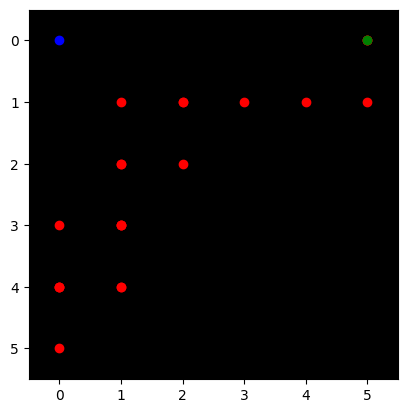

[-0.50527227, -0.49684778, -0.49816617, -0.5114579, -0.51841044, -0.5114579, -0.50527227, -0.49684778, -0.4951133, -0.49684778, -0.49816617, -0.5114579, -0.51841044, -0.5166138, -0.5139451, -0.50539094, -0.5139451, -0.52024657, -0.5377073, -0.5681657, -0.58753604]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.50527227, -0.49684778, -0.49816617, -0.5114579, -0.51841044, -0.5114579, -0.50527227, -0.49684778, -0.4951133, -0.49684778, -0.49816617, -0.5114579, -0.51841044, -0.5166138, -0.5139451, -0.50539094, -0.5139451, -0.52024657, -0.5377073, -0.5681657, -0.58753604]
return [-0.39747822284698486, -0.39853293895721437, -0.4091663360595703, -0.41472835540771485, -0.4091663360595703, -0.40421781539916996, -0.39747822284698486, -0.3960906505584717, -0.39747822284698486, -0.39853293895721437, -0.4091663360595703, -0.41472835540771485, -0.4132910251617432, -0.41115608215332033, -0.4043127536773682, -0.41115608215332033, -0.4161972522735596, -0.4301658630371094

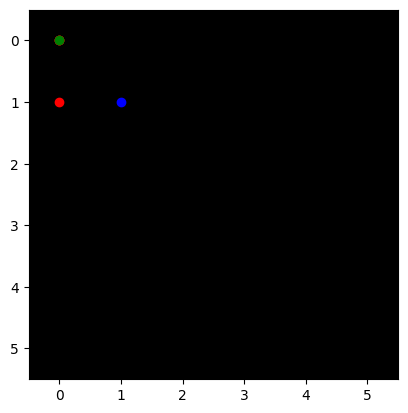

[-0.5001668, -0.5017966, -0.5068592]
 gamma 0.8
[0, 0, -1]
[-0.5001668, -0.5017966, -0.5068592]
return [-0.40143728256225586, -0.40548734664916997, -1.0]
gae [0.09872949123382568, 0.09630925655364986, -0.4931408166885376]
0.9280269412060204
tensor([[1., 4., 1., 4.]])
tensor([[0., 4., 0., 4.]])
tensor([[0., 4., 0., 4.]])


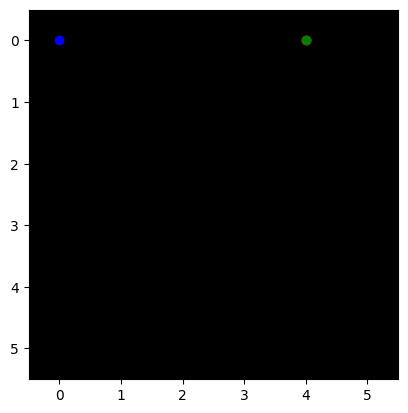

[-0.5377073, -0.5575311]
 gamma 0.8
[0, -1]
[-0.5377073, -0.5575311]
return [-0.44602489471435547, -1.0]
gae [0.09168243408203125, -0.44246888160705566]
0.341715380092415
tensor([[ 5.,  0.,  4., -1.]])
tensor([[5., 1., 4., 0.]])
tensor([[5., 1., 4., 0.]])
tensor([[ 5.,  0.,  4., -1.]])
tensor([[5., 1., 4., 0.]])
tensor([[4., 1., 3., 0.]])
tensor([[4., 2., 3., 1.]])
tensor([[4., 2., 3., 1.]])
tensor([[3., 2., 2., 1.]])
tensor([[3., 1., 2., 0.]])
tensor([[2., 1., 1., 0.]])


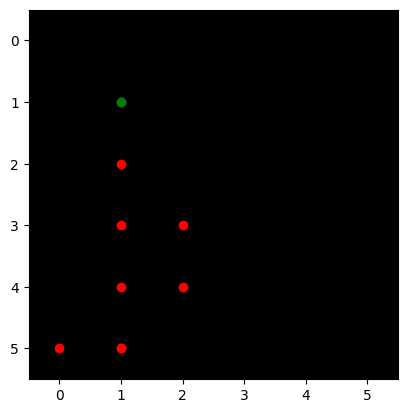

[-0.4964183, -0.49916208, -0.4964183, -0.49916208, -0.50097895, -0.50569516, -0.51740676, -0.51557684, -0.5129057]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.4964183, -0.49916208, -0.4964183, -0.49916208, -0.50097895, -0.50569516, -0.51740676, -0.51557684, -0.5129057]
return [-0.39932966232299805, -0.39713463783264163, -0.39932966232299805, -0.40078315734863285, -0.4045561313629151, -0.4139254093170166, -0.4124614715576172, -0.4103245735168457, 1.0]
gae [0.09708863496780396, 0.10202744007110592, 0.09708863496780396, 0.09837892055511471, 0.09642281532287594, 0.0917697548866272, 0.10494529008865355, 0.10525226593017578, 1.5129057168960571]
return [-0.39932966 -0.39932966 -0.39853293 -0.39853293 -0.39747822 -0.39747822
 -0.39747822 -0.39713463 -0.39609066  1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.47002882 -0.45453256 -0.4460249 ]

-------------------- Iteration #24 --------------------
random  0.341715380092415
Average : 0.01
Aver

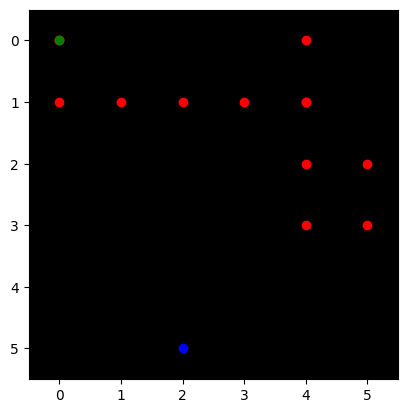

[-0.42373145, -0.42142883, -0.42373145, -0.41867206, -0.41611117, -0.41566256, -0.41960853, -0.41566256, -0.41614082, -0.41902465, -0.42904285, -0.4309407, -0.43207788]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.42373145, -0.42142883, -0.42373145, -0.41867206, -0.41611117, -0.41566256, -0.41960853, -0.41566256, -0.41614082, -0.41902465, -0.42904285, -0.4309407, -0.43207788]
return [-0.33714306354522705, -0.33898515701293946, -0.3349376440048218, -0.33288893699646, -0.3325300455093384, -0.33568682670593264, -0.3325300455093384, -0.3329126596450806, -0.33521971702575687, -0.34323427677154544, -0.34475255012512207, -0.3456623077392578, -1.0]
gae [0.08658838272094727, 0.08244367241859435, 0.08879380226135253, 0.08578311800956723, 0.08358112573623655, 0.07997573018074033, 0.08707848787307737, 0.08274989724159237, 0.08092110753059384, 0.0757903695106506, 0.08429029583930969, 0.08527837991714476, -0.5679221153259277]
0.8753406942170358
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,

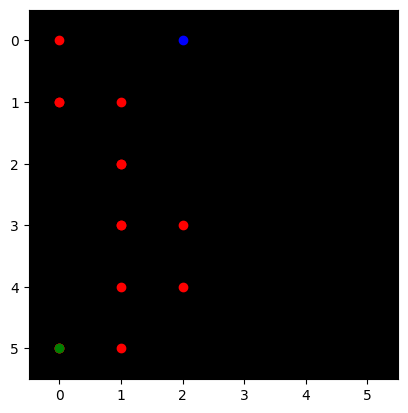

[-0.4648206, -0.44384158, -0.4303052, -0.44384158, -0.429838, -0.45793682, -0.46955514, -0.45793682, -0.46955514, -0.46483895, -0.462637, -0.4687699, -0.46778297, -0.47128353]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.4648206, -0.44384158, -0.4303052, -0.44384158, -0.429838, -0.45793682, -0.46955514, -0.45793682, -0.46955514, -0.46483895, -0.462637, -0.4687699, -0.46778297, -0.47128353]
return [-0.3550732612609864, -0.34424417018890385, -0.3550732612609864, -0.3438704013824463, -0.366349458694458, -0.3756441116333008, -0.366349458694458, -0.3756441116333008, -0.3718711614608765, -0.3701096057891846, -0.375015926361084, -0.3742263793945313, -0.3770268201828003, -1.0]
gae [0.10974733233451839, 0.09959740638732906, 0.07523195147514339, 0.09997117519378662, 0.06348854303359985, 0.0822927117347717, 0.10320568084716797, 0.0822927117347717, 0.09768397808074947, 0.09472934603691097, 0.08762108087539672, 0.09454352855682369, 0.09075615406036375, -0.5287164747714996]
0.124026284

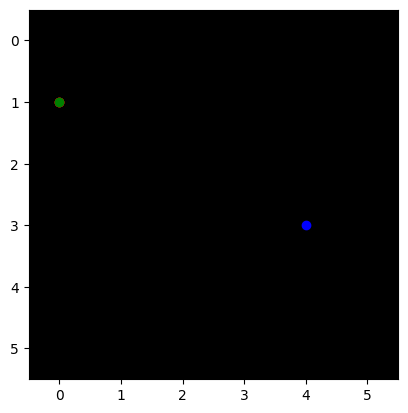

[-0.445359, -0.44387552]
 gamma 0.8
[0, -1]
[-0.445359, -0.44387552]
return [-0.355100417137146, -1.0]
gae [0.09025857448577879, -0.5561244785785675]
0.5034461890553605
tensor([[ 0.,  0.,  0., -3.]])
tensor([[ 0.,  0.,  0., -3.]])
tensor([[ 1.,  0.,  1., -3.]])
tensor([[ 1.,  0.,  1., -3.]])
tensor([[ 2.,  0.,  2., -3.]])
tensor([[ 2.,  0.,  2., -3.]])
tensor([[ 3.,  0.,  3., -3.]])


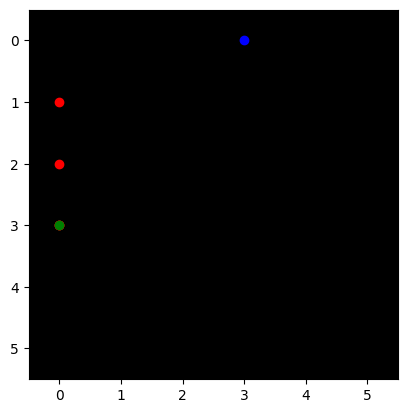

[-0.4334623, -0.4454351, -0.46817347, -0.4674444]
 gamma 0.8
[0, 0, 0, -1]
[-0.4334623, -0.4454351, -0.46817347, -0.4674444]
return [-0.3563480854034424, -0.374538779258728, -0.373955512046814, -1.0]
gae [0.07711420655250545, 0.07089632749557495, 0.09421796202659605, -0.5325556099414825]
0.41385053101567226
tensor([[ 4.,  2.,  0., -3.]])
tensor([[ 4.,  2.,  0., -3.]])
tensor([[ 3.,  2., -1., -3.]])
tensor([[ 3.,  2., -1., -3.]])
tensor([[ 2.,  2., -2., -3.]])
tensor([[ 2.,  1., -2., -4.]])
tensor([[ 2.,  0., -2., -5.]])
tensor([[ 2.,  0., -2., -5.]])


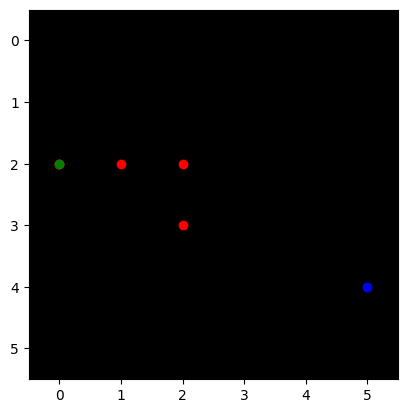

[-0.46429312, -0.457321, -0.42923468, -0.44470552, -0.44505852]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.46429312, -0.457321, -0.42923468, -0.44470552, -0.44505852]
return [-0.36585679054260256, -0.3433877468109131, -0.35576441287994387, -0.35604681968688967, -1.0]
gae [0.09843633174896238, 0.11393324136734007, 0.07347027063369749, 0.08865869641304014, -0.5549414753913879]
0.38290955113378944
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 1.,  5., -3.,  3.]])
tensor([[ 0.,  5., -4.,  3.]])
tensor([[ 0.,  4., -4.,  2.]])
tensor([[ 0.,  5., -4.,  3.]])
tensor([[ 0.,  5., -4.,  3.]])
tensor([[ 1.,  5., -3.,  3.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 1.,  5., -3.,  3.]])
tensor([[ 1.,  5., -3.,  3.]])
tensor([[ 0.,  5., -4.,  3.]])


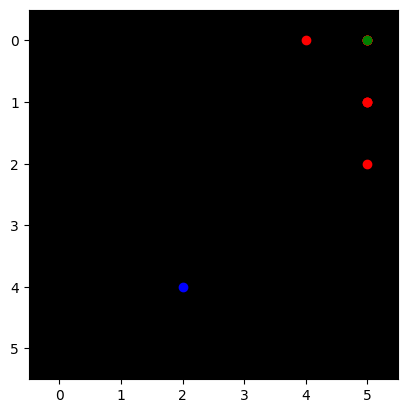

[-0.42238402, -0.4223208, -0.429713, -0.4204482, -0.429713, -0.4223208, -0.42238402, -0.4223208, -0.429713]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.42238402, -0.4223208, -0.429713, -0.4204482, -0.429713, -0.4223208, -0.42238402, -0.4223208, -0.429713]
return [-0.337856650352478, -0.3437704086303711, -0.3363585710525513, -0.3437704086303711, -0.337856650352478, -0.3379072189331055, -0.337856650352478, -0.3437704086303711, -1.0]
gae [0.08452737331390381, 0.07855040431022642, 0.09335443973541258, 0.07667780518531797, 0.09185636043548584, 0.08441359400749204, 0.08452737331390381, 0.07855040431022642, -0.5702869892120361]
0.7098443439517399
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  2., -1.,  2.]])
tensor([[ 2.,  2., -2.,  2.]])
tensor([[ 3.,  2., -1.,  2.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  2., -1.,  2.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[ 3.,  0., -1.,  0.]])
tensor([[ 3.,  0., -1.,  0.]])
tensor([[ 2

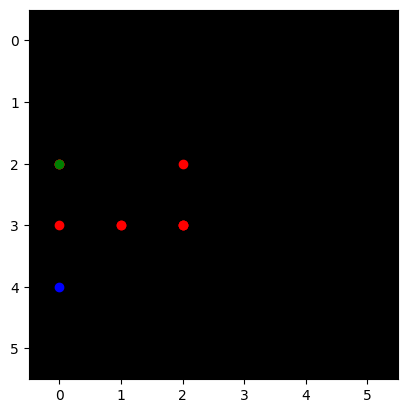

[-0.4238315, -0.41637495, -0.41602743, -0.41637495, -0.4238315, -0.41637495, -0.4238315, -0.44123083, -0.43240237]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.4238315, -0.41637495, -0.41602743, -0.41637495, -0.4238315, -0.41637495, -0.4238315, -0.44123083, -0.43240237]
return [-0.33309996128082275, -0.33282194137573246, -0.33309996128082275, -0.33906519412994385, -0.33309996128082275, -0.33906519412994385, -0.3529846668243408, -0.3459218978881836, -1.0]
gae [0.09073153138160706, 0.08355301022529599, 0.08292746543884277, 0.0773097574710846, 0.09073153138160706, 0.0773097574710846, 0.07084682583808899, 0.09530893564224241, -0.5675976276397705]
return [-0.3352197  -0.33493763 -0.33309996 -0.33309996 -0.33309996 -0.33291265
 -0.33288893 -0.33282194 -0.33253005 -0.33253005]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.37702683 -0.37564412 -0.37564412]

-------------------- Iteration #25 --------------------
random  0.7098443439517399
Average : 0.01

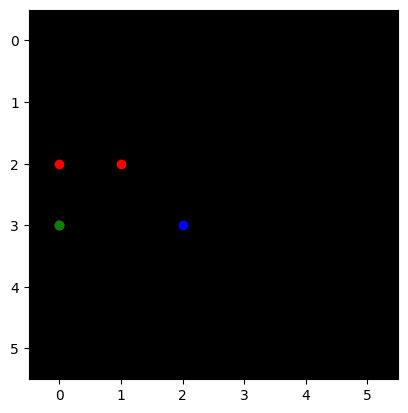

[-0.28771222, -0.28755844, -0.28771222, -0.26179624]
 gamma 0.8
[0, 0, 0, -1]
[-0.28771222, -0.28755844, -0.28771222, -0.26179624]
return [-0.23004674911499023, -0.23016977310180664, -0.2094369888305664, -1.0]
gae [0.057665467262268066, 0.05738866329193115, 0.07827522754669189, -0.738203763961792]
0.5737823012433169
tensor([[4., 3., 4., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[3., 3., 3., 2.]])
tensor([[3., 3., 3., 2.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 5., 2., 4.]])
tensor([[1., 5., 1., 4.]])
tensor([[1., 4., 1., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[1., 5., 1., 4.]])
tensor([[1., 4., 1., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 5., 2., 4.]])


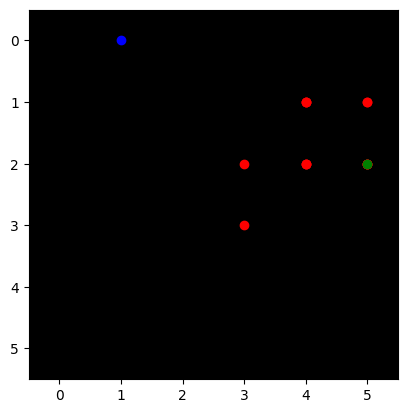

[-0.25968006, -0.25961664, -0.27222028, -0.2915375, -0.31053066, -0.32086056, -0.30785266, -0.32086056, -0.30785266, -0.2915375, -0.30785266, -0.2915375, -0.31053066]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.25968006, -0.25961664, -0.27222028, -0.2915375, -0.31053066, -0.32086056, -0.30785266, -0.32086056, -0.30785266, -0.2915375, -0.30785266, -0.2915375, -0.31053066]
return [-0.20769331455230713, -0.2177762269973755, -0.23322999477386475, -0.24842453002929688, -0.2566884517669678, -0.24628212451934817, -0.2566884517669678, -0.24628212451934817, -0.23322999477386475, -0.24628212451934817, -0.23322999477386475, -0.24842453002929688, -1.0]
gae [0.05198674798011779, 0.041840416193008406, 0.038990288972854614, 0.04311296343803406, 0.05384221076965329, 0.07457844018936155, 0.051164203882217374, 0.07457844018936155, 0.07462266087532043, 0.045255368947982766, 0.07462266087532043, 0.04311296343803406, -0.6894693374633789]
0.31623867281041274
tensor([[5., 2., 1., 0.]])


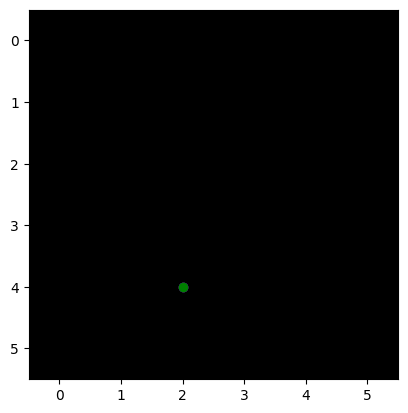

[-0.2553039]
 gamma 0.8
[1]
[-0.2553039]
return [1.0]
gae [1.2553038895130157]
0.7736963547405239


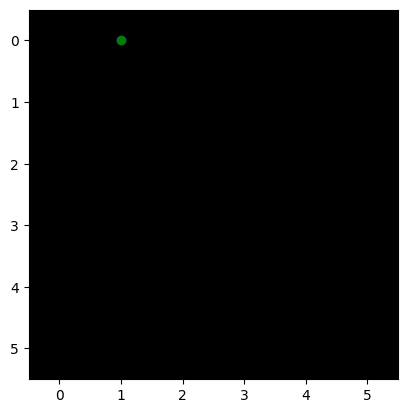

[-0.28771222, -0.28755844, -0.28771222, -0.26179624, -0.25968006, -0.25961664, -0.27222028, -0.2915375, -0.31053066, -0.32086056, -0.30785266, -0.32086056, -0.30785266, -0.2915375, -0.30785266, -0.2915375, -0.31053066, -0.2553039]
 gamma 0.8
[]
[-0.28771222, -0.28755844, -0.28771222, -0.26179624, -0.25968006, -0.25961664, -0.27222028, -0.2915375, -0.31053066, -0.32086056, -0.30785266, -0.32086056, -0.30785266, -0.2915375, -0.30785266, -0.2915375, -0.31053066, -0.2553039]
return []
gae []
0.5560887462683378
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  0., -2., -1.]])


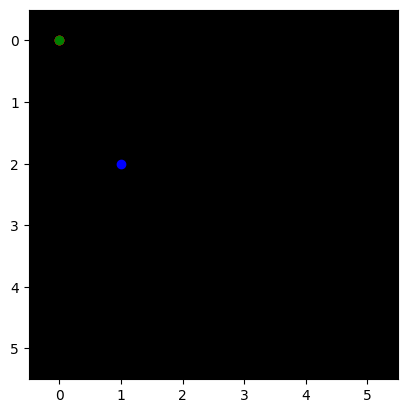

[-0.3119072, -0.3073909]
 gamma 0.8
[0, -1]
[-0.3119072, -0.3073909]
return [-0.2459127187728882, -1.0]
gae [0.06599448323249815, -0.6926091015338898]
0.5702165795900555
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  0.,  1., -4.]])


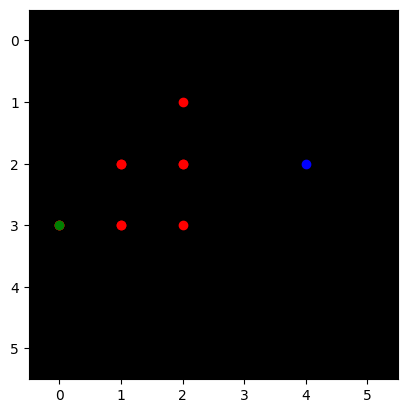

[-0.25865802, -0.27780753, -0.2656979, -0.30251604, -0.2656979, -0.27780753, -0.25865802, -0.24618137, -0.25865802, -0.26784912]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.25865802, -0.27780753, -0.2656979, -0.30251604, -0.2656979, -0.27780753, -0.25865802, -0.24618137, -0.25865802, -0.26784912]
return [-0.22224602699279786, -0.21255831718444826, -0.2420128345489502, -0.21255831718444826, -0.22224602699279786, -0.20692641735076905, -0.19694509506225588, -0.20692641735076905, -0.21427929401397705, -1.0]
gae [0.03641199469566345, 0.06524921655654906, 0.023685061931610102, 0.08995772600173949, 0.043451869487762446, 0.07088111639022826, 0.06171292662620542, 0.03925495147705077, 0.04437872767448425, -0.7321508824825287]
0.6578689457132493
tensor([[2., 2., 1., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[2., 1., 1., 1.]])
tensor([[1., 1., 0., 1.]])
tensor([[ 0.,  1., -1.,  1.]])
tenso

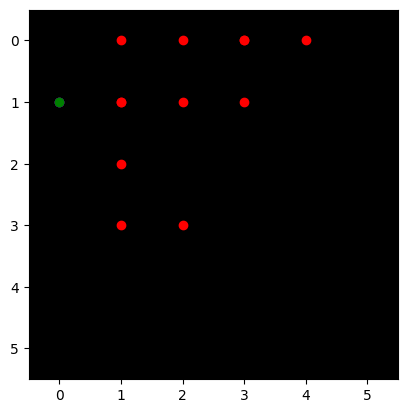

[-0.27347025, -0.255442, -0.24840274, -0.25699833, -0.30095634, -0.31127724, -0.30666578, -0.30219248, -0.30871463, -0.30219248, -0.2956478, -0.29404122, -0.30095634]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.27347025, -0.255442, -0.24840274, -0.25699833, -0.30095634, -0.31127724, -0.30666578, -0.30219248, -0.30871463, -0.30219248, -0.2956478, -0.29404122, -0.30095634]
return [-0.20435359477996828, -0.1987221956253052, -0.20559866428375245, -0.24076507091522217, -0.24902179241180422, -0.2453326225280762, -0.24175398349761965, -0.2469717025756836, -0.24175398349761965, -0.2365182399749756, -0.2352329730987549, -0.24076507091522217, 1.0]
gae [0.0691166579723358, 0.05671979784965514, 0.04280408024787902, 0.016233259439468378, 0.05193454623222349, 0.06594461798667905, 0.06491179466247557, 0.05522077679634094, 0.06696064472198485, 0.06567423939704894, 0.06041482686996458, 0.05327614545822143, 1.3009563386440277]
0.6465630004027667
tensor([[ 1.,  3., -3., -2.]])
tensor([[ 0.,  3

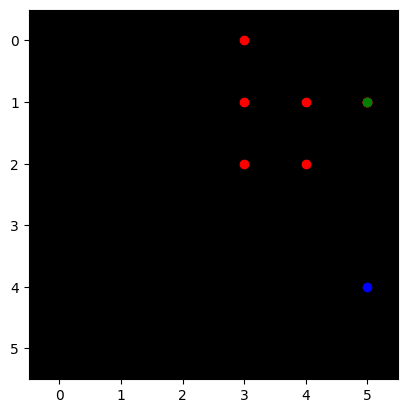

[-0.2971415, -0.30703562, -0.2971415, -0.2864417, -0.29214504, -0.28946552, -0.2914467]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.2971415, -0.30703562, -0.2971415, -0.2864417, -0.29214504, -0.28946552, -0.2914467]
return [-0.24562849998474123, -0.23771319389343262, -0.22915337085723878, -0.2337160348892212, -0.23157241344451907, -0.2331573486328125, -1.0]
gae [0.05151299238204954, 0.06932243108749389, 0.067988121509552, 0.05272567868232725, 0.060572630167007424, 0.05630816817283629, -0.7085533142089844]
return [-0.20943698 -0.20769331 -0.20692642 -0.20692642 -0.20559867 -0.2043536
 -0.1987222  -0.1969451   1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         -0.25668845
 -0.25668845 -0.2490218  -0.24842453 -0.24842453]

-------------------- Iteration #26 --------------------
random  0.6465630004027667
Average : 0.01
Average Episodic Return: -0.61
Max Episodic Return: 1.0
Average Loss: 0.00513
Average Loss Critic: 0.25138574838638306
TEntropy: nan
appr

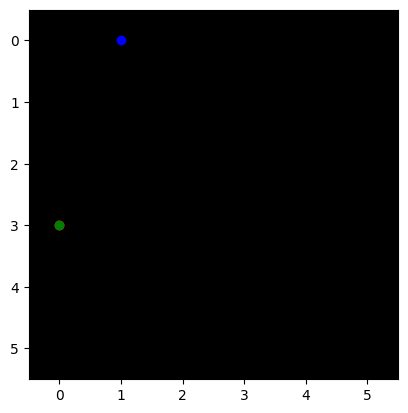

[-0.028290387, -0.059749894]
 gamma 0.8
[0, -1]
[-0.028290387, -0.059749894]
return [-0.047799915075302124, -1.0]
gae [-0.01950952783226967, -0.9402501061558723]
0.6190667817759884
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 2.,  0., -1., -3.]])
tensor([[ 1.,  0., -2., -3.]])
tensor([[ 1.,  0., -2., -3.]])


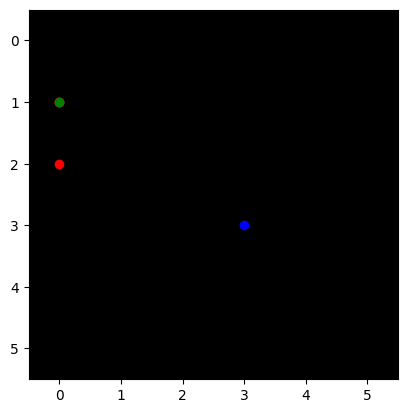

[-0.10342147, -0.10481457, -0.12250665]
 gamma 0.8
[0, 0, -1]
[-0.10342147, -0.10481457, -0.12250665]
return [-0.08385165333747864, -0.0980053186416626, -1.0]
gae [0.019569818675518033, 0.006809248030185691, -0.8774933516979218]
0.10544161294683052
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  2., -4., -1.]])


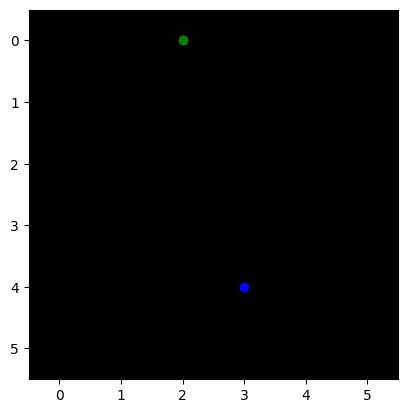

[-0.1371819, -0.1357087]
 gamma 0.8
[0, -1]
[-0.1371819, -0.1357087]
return [-0.10856696367263795, -1.0]
gae [0.02861492931842803, -0.8642912954092026]
0.17326725783464514
tensor([[ 1.,  0., -4.,  0.]])
tensor([[ 1.,  0., -4.,  0.]])


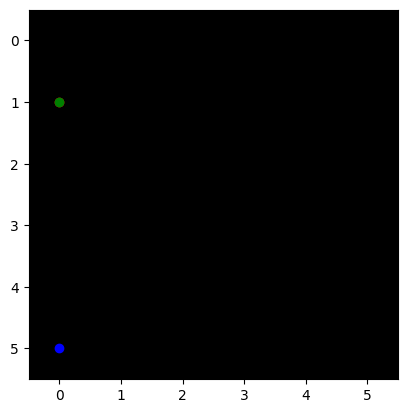

[-0.13383937]
 gamma 0.8
[-1]
[-0.13383937]
return [-1.0]
gae [-0.8661606311798096]
0.08770808966305976
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 1.,  4., -4.,  3.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 0.,  3., -5.,  2.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 1.,  2., -4.,  1.]])
tensor([[ 0.,  2., -5.,  1.]])
tensor([[ 0.,  1., -5.,  0.]])
tensor([[ 0.,  0., -5., -1.]])


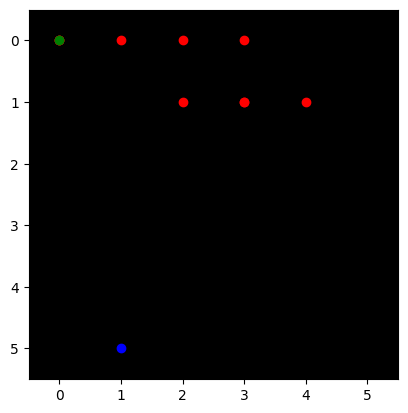

[-0.06292228, -0.059036344, -0.06292228, -0.083744004, -0.06292228, -0.09348124, -0.11100726, -0.13925144, -0.13703783]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.06292228, -0.059036344, -0.06292228, -0.083744004, -0.06292228, -0.09348124, -0.11100726, -0.13925144, -0.13703783]
return [-0.04722907543182373, -0.05033782124519348, -0.06699520349502563, -0.05033782124519348, -0.07478499412536621, -0.08880580663681031, -0.11140115261077882, -0.1096302628517151, -1.0]
gae [0.01569320112466812, 0.008698523044586182, -0.004072926938533783, 0.03340618312358856, -0.011862717568874359, 0.00467543601989745, -0.0003938943147659413, 0.029621177911758417, -0.8629621714353561]
0.4573910314381109
tensor([[ 0.,  4., -1., -1.]])
tensor([[ 0.,  4., -1., -1.]])
tensor([[ 0.,  5., -1.,  0.]])


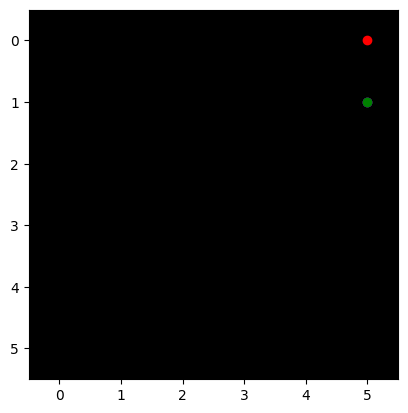

[-0.08848361, -0.0616923]
 gamma 0.8
[0, 1]
[-0.08848361, -0.0616923]
return [-0.04935384094715119, 1.0]
gae [0.039129768311977384, 1.061692301183939]
0.34211678536640155
tensor([[ 0.,  4., -2.,  0.]])
tensor([[ 0.,  5., -2.,  1.]])


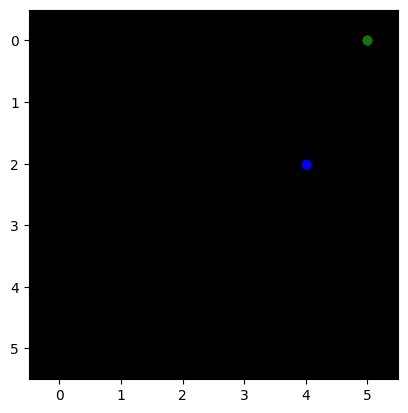

[-0.077007346, -0.060411256]
 gamma 0.8
[0, -1]
[-0.077007346, -0.060411256]
return [-0.0483290046453476, -1.0]
gae [0.028678341209888457, -0.9395887441933155]
0.3532682766284213
tensor([[4., 2., 3., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[5., 2., 4., 2.]])
tensor([[5., 1., 4., 1.]])
tensor([[5., 2., 4., 2.]])


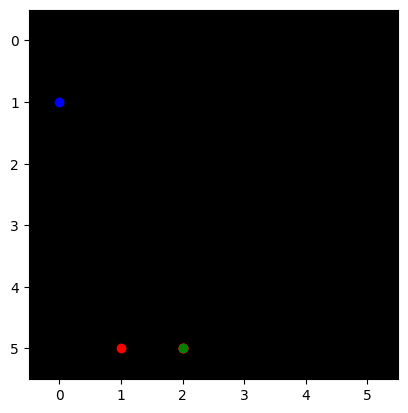

[-0.008153988, -0.031001324, -0.023212785, -0.031001324]
 gamma 0.8
[0, 0, 0, -1]
[-0.008153988, -0.031001324, -0.023212785, -0.031001324]
return [-0.0248010590672493, -0.018570227921009066, -0.0248010590672493, -1.0]
gae [-0.016647071018815043, 0.012431095913052557, -0.0015882741659879705, -0.9689986761659384]
0.7964829444535985
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 3.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 0.,  2., -2., -1.]])
tensor([[ 0.,  2., -2., -1.]])


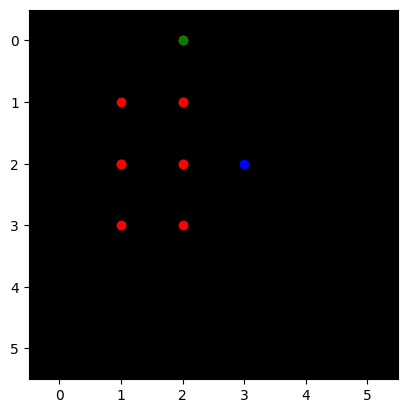

[-0.12172425, -0.12822859, -0.12172425, -0.08191415, -0.041365333, -0.08191415, -0.038974732, -0.00808611, -0.038974732, -0.12822859, -0.13974036]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12172425, -0.12822859, -0.12172425, -0.08191415, -0.041365333, -0.08191415, -0.038974732, -0.00808611, -0.038974732, -0.12822859, -0.13974036]
return [-0.10258287191390991, -0.09737939834594728, -0.06553131937980652, -0.03309226632118225, -0.06553131937980652, -0.03117978572845459, -0.006468888372182846, -0.03117978572845459, -0.10258287191390991, -0.11179229021072389, -1.0]
gae [0.01914137601852417, 0.030849191546440113, 0.05619292855262756, 0.0488218829035759, -0.02416598647832871, 0.05073436349630356, 0.03250584378838539, -0.023093675263226032, -0.06360813975334167, 0.016436299681663505, -0.8602596372365952]
0.8529927223995384
tensor([[ 3.,  1., -2., -1.]])
tensor([[ 3.,  1., -2., -1.]])
tensor([[ 2.,  1., -3., -1.]])
tensor([[ 2.,  1., -3., -1.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 

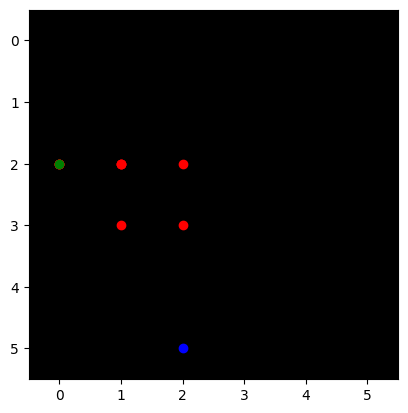

[-0.04480725, -0.117839664, -0.078065336, -0.020992607, -0.04480725, -0.117839664, -0.12332734, -0.117839664, -0.12332734]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.04480725, -0.117839664, -0.078065336, -0.020992607, -0.04480725, -0.117839664, -0.12332734, -0.117839664, -0.12332734]
return [-0.09427173137664796, -0.06245226860046387, -0.01679408550262451, -0.0358458012342453, -0.09427173137664796, -0.098661869764328, -0.09427173137664796, -0.098661869764328, -1.0]
gae [-0.049464479833841335, 0.055387395620346065, 0.06127125024795532, -0.01485319435596466, -0.049464479833841335, 0.019177794456481934, 0.029055605828762043, 0.019177794456481934, -0.87667266279459]
0.9676871693287824
tensor([[ 1.,  4., -2.,  4.]])
tensor([[ 1.,  4., -2.,  4.]])
tensor([[ 2.,  4., -1.,  4.]])
tensor([[ 2.,  4., -1.,  4.]])
tensor([[ 1.,  4., -2.,  4.]])
tensor([[ 1.,  4., -2.,  4.]])
tensor([[ 0.,  4., -3.,  4.]])
tensor([[ 0.,  4., -3.,  4.]])
tensor([[ 1.,  4., -2.,  4.]])
tensor([[ 1.,  4., -2.,  4.]])

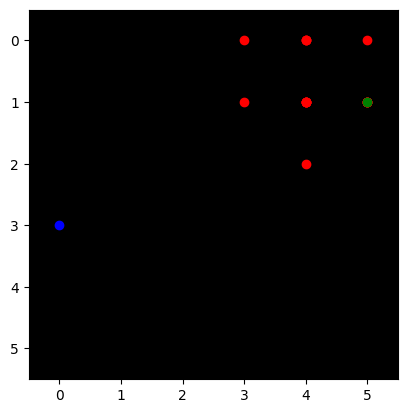

[-0.058346305, -0.049531728, -0.058346305, -0.061064444, -0.058346305, -0.061064444, -0.058346305, -0.060438648, -0.058346305, -0.058819752, -0.0728269, -0.061064444, -0.058346305, -0.060438648, -0.062146276, -0.060438648]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.058346305, -0.049531728, -0.058346305, -0.061064444, -0.058346305, -0.061064444, -0.058346305, -0.060438648, -0.058346305, -0.058819752, -0.0728269, -0.061064444, -0.058346305, -0.060438648, -0.062146276, -0.060438648]
return [-0.039625382423400884, -0.04667704403400422, -0.04885155558586121, -0.04667704403400422, -0.04885155558586121, -0.04667704403400422, -0.04835091829299927, -0.04667704403400422, -0.04705580174922944, -0.058261519670486456, -0.04885155558586121, -0.04667704403400422, -0.04835091829299927, -0.04971702098846436, -0.04835091829299927, -1.0]
gae [0.01872092261910438, 0.0028546839952468817, 0.009494749456644053, 0.01438740044832229, 0.009494749456644053, 0.01438740044832229, 0.0099953867

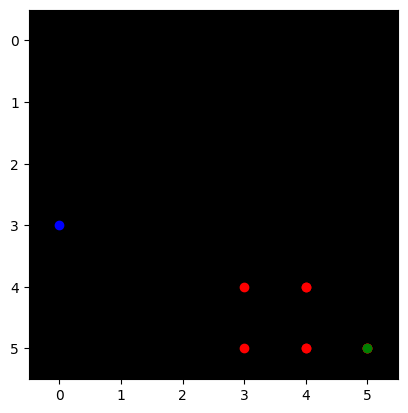

[-0.10581793, -0.064281814, -0.10581793, -0.064281814, -0.037637327, -0.06407551, -0.10581793, -0.18503864]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.10581793, -0.064281814, -0.10581793, -0.064281814, -0.037637327, -0.06407551, -0.10581793, -0.18503864]
return [-0.051425451040267946, -0.08465434312820436, -0.051425451040267946, -0.030109861493110658, -0.05126040577888489, -0.08465434312820436, -0.14803091287612916, -1.0]
gae [0.054392477869987486, -0.020372529327869426, 0.054392477869987486, 0.03417195230722427, -0.013623078912496568, -0.020578835904598247, -0.042212983965873724, -0.8149613589048386]
0.16038477037983456
tensor([[ 5.,  0.,  2., -5.]])


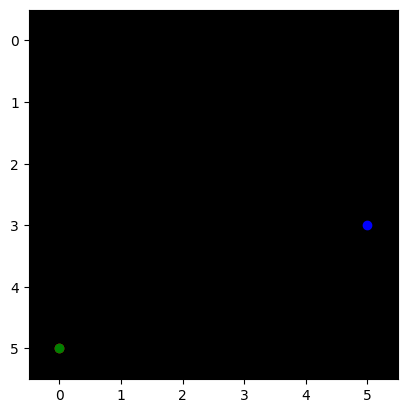

[-0.03450433]
 gamma 0.8
[-1]
[-0.03450433]
return [-1.0]
gae [-0.9654956683516502]
0.7940463442494256
tensor([[ 4.,  3.,  0., -2.]])
tensor([[ 4.,  3.,  0., -2.]])
tensor([[ 5.,  3.,  1., -2.]])


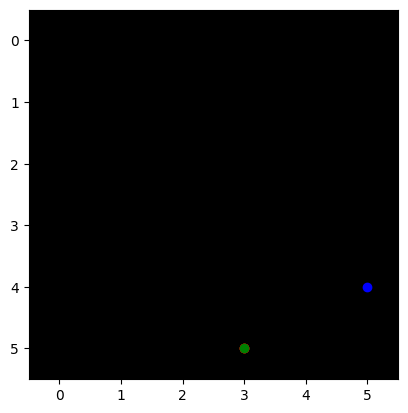

[-0.019591201, -0.032403745]
 gamma 0.8
[0, -1]
[-0.019591201, -0.032403745]
return [-0.025922995805740357, -1.0]
gae [-0.0063317947089672096, -0.9675962552428246]
0.6549637731899898
tensor([[3., 4., 2., 0.]])
tensor([[3., 4., 2., 0.]])
tensor([[4., 4., 3., 0.]])
tensor([[4., 4., 3., 0.]])
tensor([[5., 4., 4., 0.]])
tensor([[5., 4., 4., 0.]])
tensor([[4., 4., 3., 0.]])
tensor([[3., 4., 2., 0.]])
tensor([[2., 4., 1., 0.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  0.,  2., -4.]])
tensor([[ 3.,  0.,  2., -4.]])
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 2.,  0.,  1., -4.]])


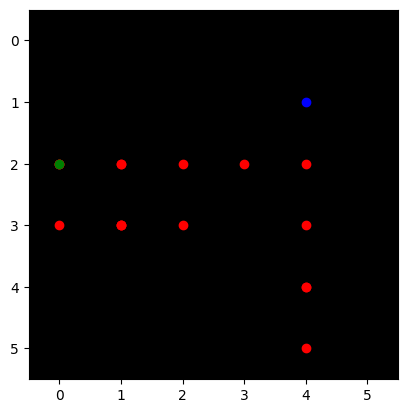

[-0.026240194, -0.029824022, -0.0451927, -0.029824022, -0.026240194, -0.031672265, -0.007765249, 0.0045574512, 0.031123038, -0.030419081, -0.030233838, -0.030419081, 0.031123038, -0.030419081, -0.0077260537, 0.047300763]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.026240194, -0.029824022, -0.0451927, -0.029824022, -0.026240194, -0.031672265, -0.007765249, 0.0045574512, 0.031123038, -0.030419081, -0.030233838, -0.030419081, 0.031123038, -0.030419081, -0.0077260537, 0.047300763]
return [-0.023859217762947083, -0.03615415990352631, -0.023859217762947083, -0.02099215537309647, -0.025337812304496766, -0.006212199106812477, 0.0036459609866142276, 0.024898430705070498, -0.024335265159606934, -0.02418707013130188, -0.024335265159606934, 0.024898430705070498, -0.024335265159606934, -0.006180842965841294, 0.037840610742568975, -1.0]
gae [0.0023809764534235, -0.006330137699842454, 0.0213334821164608, 0.008831866830587384, 0.0009023819118738167, 0.02546006627380848, 0.01141120

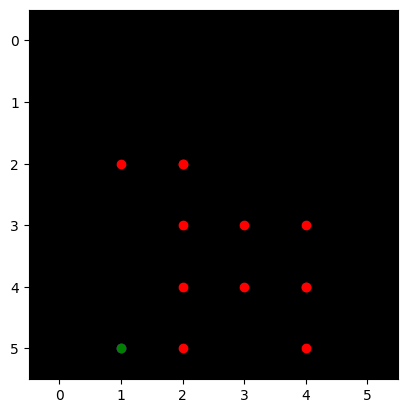

[0.05058272, 0.035985585, 0.051834196, 0.035985585, 0.016848765, -0.0141750835, -0.036780655, -0.059157018, -0.10243292, -0.059157018, -0.035107274, -0.019901933, -0.03824177]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.05058272, 0.035985585, 0.051834196, 0.035985585, 0.016848765, -0.0141750835, -0.036780655, -0.059157018, -0.10243292, -0.059157018, -0.035107274, -0.019901933, -0.03824177]
return [0.02878846824169159, 0.04146735668182373, 0.02878846824169159, 0.01347901225090027, -0.01134006679058075, -0.02942452430725098, -0.047325614094734195, -0.08194633722305299, -0.047325614094734195, -0.0280858188867569, -0.015921546518802645, -0.03059341609477997, 1.0]
gae [-0.021794253587722776, 0.0054817713797092465, -0.02304572761058807, -0.022506573051214215, -0.028188832104206085, -0.015249440819025042, -0.010544958710670474, -0.022789319604635247, 0.05510730743408203, 0.03107119873166084, 0.019185727089643476, -0.010691482946276667, 1.038241770118475]
0.5720892215009862
tensor([[

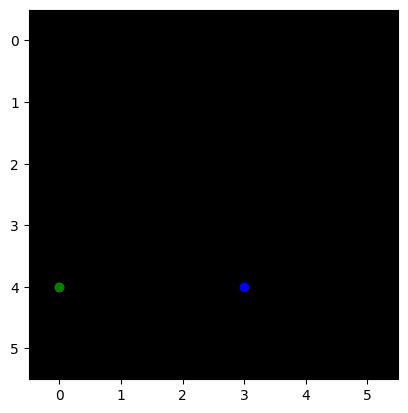

[-0.013813667]
 gamma 0.8
[-1]
[-0.013813667]
return [-1.0]
gae [-0.9861863330006599]
0.7051548023109983
tensor([[ 2.,  5., -2.,  5.]])
tensor([[ 2.,  4., -2.,  4.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  5., -3.,  5.]])
tensor([[ 1.,  5., -3.,  5.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  5., -3.,  5.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  3., -3.,  3.]])
tensor([[ 1.,  3., -3.,  3.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  4., -3.,  4.]])
tensor([[ 1.,  3., -3.,  3.]])
tensor([[ 1.,  3., -3.,  3.]])
tensor([[ 2.,  3., -2.,  3.]])
tensor([[ 3.,  3., -1.,  3.]])
tensor([[ 3.,  3., -1.,  3.]])
tensor([[ 3.,  2., -1.,  2.]])
tensor([[ 2.,  2., -2.,  2.]])
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 1.,  0., -3.,  0.]])
tensor([[ 1.,  0., -3.,  0.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 3.,  1., -1.,  1.

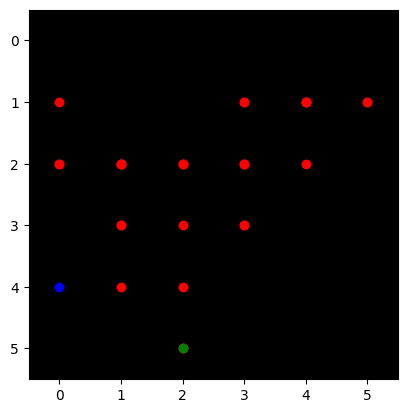

[-0.044882774, -0.028922506, 0.036148198, 0.013019303, 0.036148198, 0.013019303, 0.036148198, 0.053653322, 0.036148198, 0.053653322, -0.0077362084, -0.036703676, -0.018433822, 0.017955847, 0.044746593, 0.052630223, 0.067553, 0.052630223, 0.044746593, -0.010186156, 0.044746593, 0.017955847, -0.0077362084, -0.036703676, -0.0077362084, 0.017955847, 0.044746593, -0.010186156, -0.02518933, -0.02277545, -0.03935506]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.044882774, -0.028922506, 0.036148198, 0.013019303, 0.036148198, 0.013019303, 0.036148198, 0.053653322, 0.036148198, 0.053653322, -0.0077362084, -0.036703676, -0.018433822, 0.017955847, 0.044746593, 0.052630223, 0.067553, 0.052630223, 0.044746593, -0.010186156, 0.044746593, 0.017955847, -0.0077362084, -0.036703676, -0.0077362084, 0.017955847, 0.044746593, -0.010186156, -0.02518933, -0.02277545, -0.03935506]
return [-0.023138004541397098, 0.02891855835914612, 0.010415442287

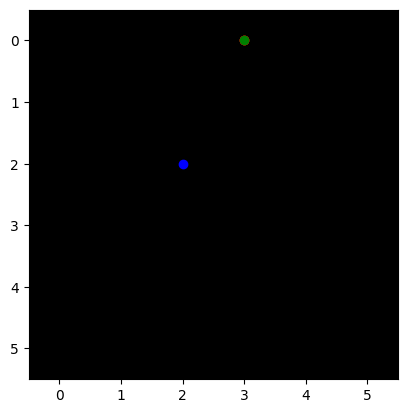

[-0.19743603, -0.20259237]
 gamma 0.8
[0, -1]
[-0.19743603, -0.20259237]
return [-0.1620738983154297, -1.0]
gae [0.03536213636398314, -0.7974076271057129]
0.8047813695171054
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 3.,  1.,  0., -1.]])
tensor([[ 3.,  1.,  0., -1.]])


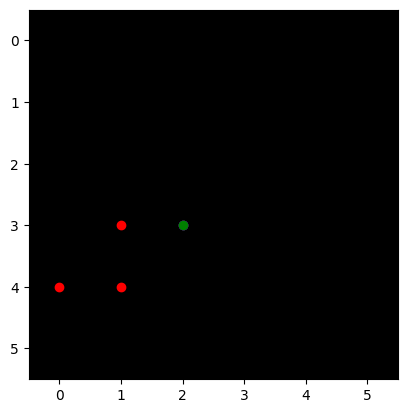

[-0.18616396, -0.1846107, -0.18616396, -0.18496533]
 gamma 0.8
[0, 0, 0, 1]
[-0.18616396, -0.1846107, -0.18616396, -0.18496533]
return [-0.14768855571746828, -0.1489311695098877, -0.14797226190567017, 1.0]
gae [0.03847540616989134, 0.03567952513694764, 0.03819169998168945, 1.1849653273820877]
0.01844693629217531
tensor([[ 3.,  2.,  2., -1.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 4.,  1.,  3., -2.]])
tensor([[ 5.,  1.,  4., -2.]])
tensor([[ 5.,  2.,  4., -1.]])


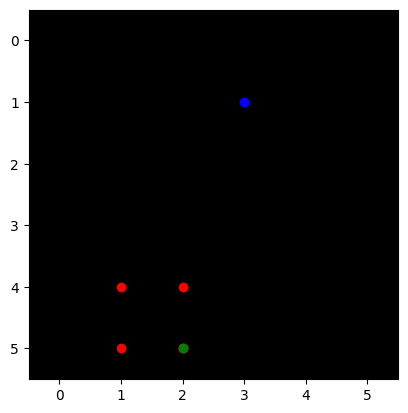

[-0.18848324, -0.18153495, -0.18485716, -0.18131821, -0.17711413]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.18848324, -0.18153495, -0.18485716, -0.18131821, -0.17711413]
return [-0.1452279567718506, -0.14788572788238527, -0.145054566860199, -0.14169130325317383, -1.0]
gae [0.04325528144836424, 0.03364921808242796, 0.039802592992782576, 0.039626905322074885, -0.8228858709335327]
0.9429147961161293
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 1.,  0., -4., -5.]])


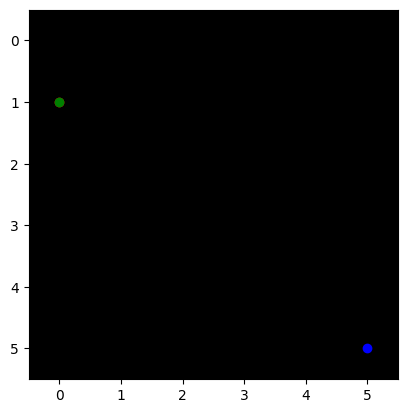

[-0.19634186]
 gamma 0.8
[-1]
[-0.19634186]
return [-1.0]
gae [-0.8036581426858902]
0.8341160479977987
tensor([[2., 1., 1., 1.]])
tensor([[2., 1., 1., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 2., 3., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[2., 1., 1., 1.]])
tensor([[2., 1., 1., 1.]])
tensor([[1., 1., 0., 1.]])
tensor([[1., 1., 0., 1.]])


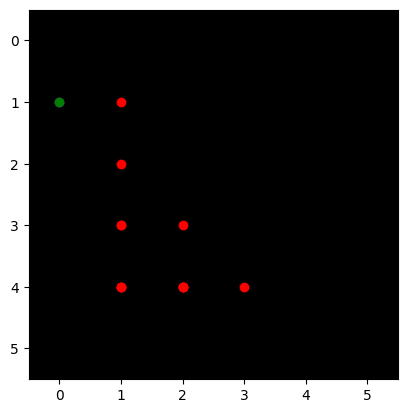

[-0.20074026, -0.18947291, -0.18306273, -0.16983286, -0.16531862, -0.16983286, -0.18306273, -0.16983286, -0.18306273, -0.16983286, -0.17533414, -0.18947291, -0.20074026, -0.19120811]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.20074026, -0.18947291, -0.18306273, -0.16983286, -0.16531862, -0.16983286, -0.18306273, -0.16983286, -0.18306273, -0.16983286, -0.17533414, -0.18947291, -0.20074026, -0.19120811]
return [-0.15157833099365237, -0.14645018577575683, -0.13586628437042236, -0.13225489854812622, -0.13586628437042236, -0.14645018577575683, -0.13586628437042236, -0.14645018577575683, -0.13586628437042236, -0.14026731252670288, -0.15157833099365237, -0.16059221029281617, -0.15296648740768434, 1.0]
gae [0.04916193187236784, 0.0430227279663086, 0.04719644784927368, 0.03757795691490173, 0.029452338814735413, 0.023382669687271124, 0.04719644784927368, 0.023382669687271124, 0.04719644784927368, 0.029565542936325073, 0.023755809664726235, 0.028880703449249256, 0.04777377545833586

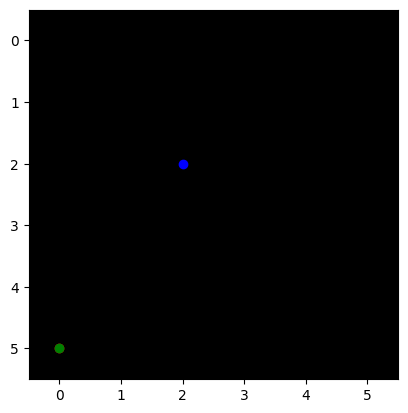

[-0.1839628]
 gamma 0.8
[-1]
[-0.1839628]
return [-1.0]
gae [-0.816037192940712]
0.800485087494582
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[4., 4., 0., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[5., 4., 1., 3.]])
tensor([[5., 4., 1., 3.]])


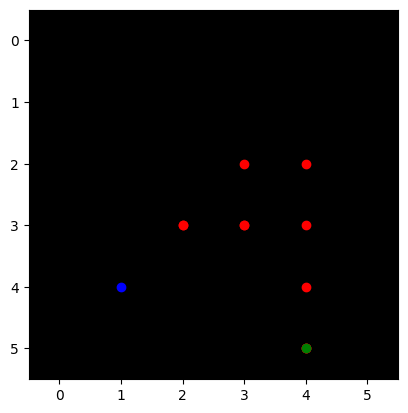

[-0.15517202, -0.15667671, -0.15517202, -0.15667671, -0.15517202, -0.18382286, -0.17736506, -0.16984804, -0.17566492, -0.17369416]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.15517202, -0.15667671, -0.15517202, -0.15667671, -0.15517202, -0.18382286, -0.17736506, -0.16984804, -0.17566492, -0.17369416]
return [-0.12534136772155763, -0.12413761615753174, -0.12534136772155763, -0.12413761615753174, -0.14705828428268433, -0.14189205169677735, -0.1358784317970276, -0.1405319333076477, -0.13895533084869385, -1.0]
gae [0.029830652475357045, 0.03253909349441528, 0.029830652475357045, 0.03253909349441528, 0.008113735914230341, 0.04193080365657806, 0.041486632823944075, 0.029316106438636774, 0.03670958578586578, -0.8263058364391327]
0.04137798615915411
tensor([[ 5.,  2.,  5., -1.]])
tensor([[ 5.,  1.,  5., -2.]])
tensor([[ 5.,  2.,  5., -1.]])
tensor([[ 5.,  1.,  5., -2.]])
tensor([[ 4.,  1.,  4., -2.]])
tensor([[ 4.,  0.,  4., -3.]])
tensor([[ 4.,  1.,  4., -2.]])
tensor([[ 5.,  1.,  5., -2.]

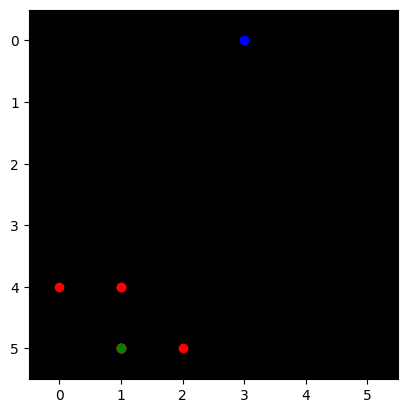

[-0.17451572, -0.17827594, -0.17451572, -0.17827594, -0.18322858, -0.18628371, -0.18322858, -0.17827594]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.17451572, -0.17827594, -0.17451572, -0.17827594, -0.18322858, -0.18628371, -0.18322858, -0.17827594]
return [-0.14262075424194337, -0.13961257934570312, -0.14262075424194337, -0.14658286571502685, -0.1490269660949707, -0.14658286571502685, -0.14262075424194337, -1.0]
gae [0.031894969940185536, 0.03866336345672608, 0.031894969940185536, 0.03169307708740235, 0.03420161604881286, 0.03970084190368653, 0.0406078279018402, -0.8217240571975708]
0.6527718096011561
tensor([[ 2.,  1.,  0., -4.]])
tensor([[ 2.,  1.,  0., -4.]])
tensor([[ 2.,  2.,  0., -3.]])
tensor([[ 2.,  2.,  0., -3.]])
tensor([[ 1.,  2., -1., -3.]])
tensor([[ 1.,  2., -1., -3.]])
tensor([[ 1.,  1., -1., -4.]])
tensor([[ 1.,  1., -1., -4.]])
tensor([[ 0.,  1., -2., -4.]])
tensor([[ 0.,  1., -2., -4.]])
tensor([[ 0.,  0., -2., -5.]])
tensor([[ 0.,  0., -2., -5.]])
tensor([[ 0.,  1., -2

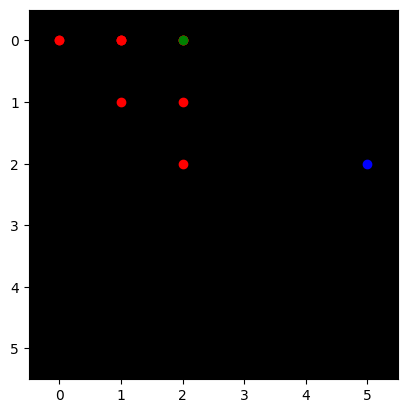

[-0.19138727, -0.19124144, -0.1890865, -0.18741393, -0.1974964, -0.18668625, -0.1974964, -0.18668625, -0.1974964, -0.20349328]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.19138727, -0.19124144, -0.1890865, -0.18741393, -0.1974964, -0.18668625, -0.1974964, -0.18668625, -0.1974964, -0.20349328]
return [-0.15299315452575685, -0.15126919746398926, -0.14993114471435548, -0.1579971194267273, -0.14934899806976318, -0.1579971194267273, -0.14934899806976318, -0.1579971194267273, -0.16279462575912476, -1.0]
gae [0.03839411139488219, 0.03997224569320679, 0.03915535211563109, 0.029416811466217024, 0.04814740121364594, 0.028689128160476668, 0.04814740121364594, 0.028689128160476668, 0.03470177352428436, -0.796506717801094]
return [-0.13586628 -0.13586628 -0.13586628 -0.1322549  -0.12534137 -0.12534137
 -0.12413762 -0.12413762  1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.16279462 -0.1620739  -0.16059221]

-------------------- Ite

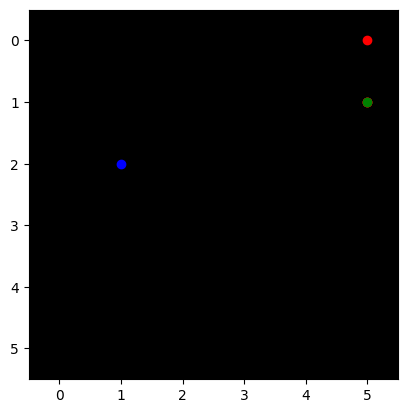

[-0.23131393, -0.22353718, -0.21253173]
 gamma 0.8
[0, 0, -1]
[-0.23131393, -0.22353718, -0.21253173]
return [-0.17882974147796632, -0.17002538442611695, -1.0]
gae [0.052484187483787526, 0.05351179242134094, -0.7874682694673538]
0.673481359322426
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 4.,  4.,  2., -1.]])
tensor([[ 4.,  4.,  2., -1.]])
tensor([[ 3.,  4.,  1., -1.]])
tensor([[ 3.,  4.,  1., -1.]])
tensor([[ 3.,  3.,  1., -2.]])
tensor([[ 3.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  2.,  3., -3.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  2.,  3., -3.]])
tensor([[ 4.,  2.,  2., -3.]])
tensor([[

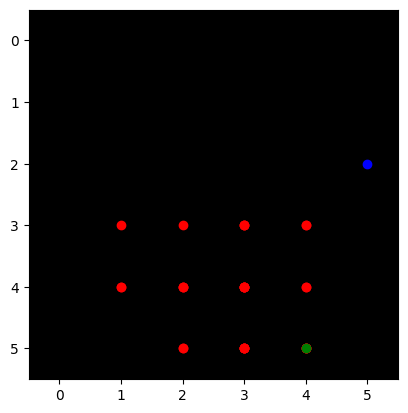

[-0.19783676, -0.19656973, -0.19783676, -0.19843626, -0.18887645, -0.19993441, -0.19783676, -0.19656973, -0.19783676, -0.19656973, -0.17829144, -0.19656973, -0.17829144, -0.17678644, -0.1773584, -0.22159798, -0.19970916, -0.17678644, -0.1773584, -0.17678644, -0.19783676, -0.19993441, -0.19783676, -0.19993441, -0.18887645, -0.19843626, -0.20486283, -0.19656973, -0.20486283]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.19783676, -0.19656973, -0.19783676, -0.19843626, -0.18887645, -0.19993441, -0.19783676, -0.19656973, -0.19783676, -0.19656973, -0.17829144, -0.19656973, -0.17829144, -0.17678644, -0.1773584, -0.22159798, -0.19970916, -0.17678644, -0.1773584, -0.17678644, -0.19783676, -0.19993441, -0.19783676, -0.19993441, -0.18887645, -0.19843626, -0.20486283, -0.19656973, -0.20486283]
return [-0.1572557806968689, -0.15826940536499023, -0.15874900817871096, -0.1511011600494385, -0.15994752645492555, -0.15826940536499023, -0.1572557

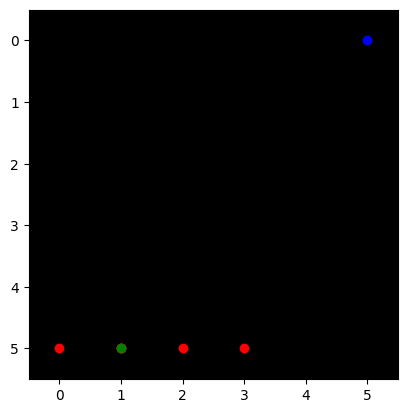

[-0.19448492, -0.19368993, -0.1774044, -0.1722743, -0.17313145, -0.1722743]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.19448492, -0.19368993, -0.1774044, -0.1722743, -0.17313145, -0.1722743]
return [-0.1549519419670105, -0.14192352294921876, -0.13781944513320923, -0.13850516080856323, -0.13781944513320923, -1.0]
gae [0.03953297734260558, 0.05176640450954437, 0.0395849585533142, 0.0337691456079483, 0.035312005877494806, -0.8277256935834885]
0.8557528821024246
tensor([[ 5.,  0.,  0., -4.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 3.,  0., -2., -4.]])
tensor([[ 3.,  0., -2., -4.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 3.,  2., -2., -2.]])
tensor([[ 4.,  2., -1., -2.]])
tensor([[ 4.,  1.,

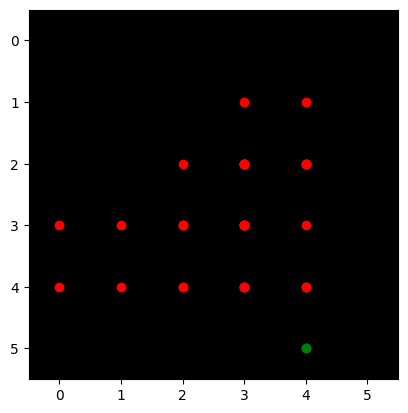

[-0.1761575, -0.17625299, -0.20220567, -0.19563134, -0.1817002, -0.18699242, -0.18094422, -0.18699242, -0.1817002, -0.16270871, -0.1596971, -0.16270871, -0.1817002, -0.18699242, -0.22429843, -0.23359428, -0.22429843, -0.21044908, -0.22429843, -0.21496284, -0.22429843, -0.21044908, -0.22429843, -0.18699242, -0.22429843, -0.21044908, -0.22612378, -0.21044908, -0.22429843, -0.18699242, -0.18094422, -0.18129402, -0.18157141, -0.18129402, -0.18094422, -0.18699242, -0.18094422, -0.18129402]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.1761575, -0.17625299, -0.20220567, -0.19563134, -0.1817002, -0.18699242, -0.18094422, -0.18699242, -0.1817002, -0.16270871, -0.1596971, -0.16270871, -0.1817002, -0.18699242, -0.22429843, -0.23359428, -0.22429843, -0.21044908, -0.22429843, -0.21496284, -0.22429843, -0.21044908, -0.22429843, -0.18699242, -0.22429843, -0.21044908, -0.22612378, -0.21044908, -0.22429843, -0.18699242

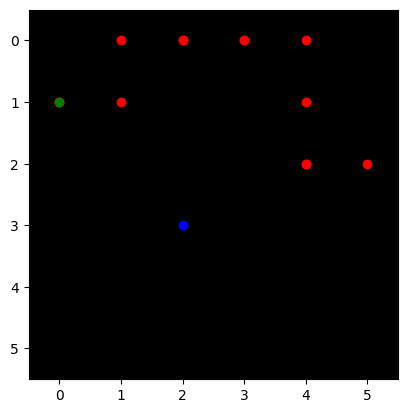

[-0.30890486, -0.3146099, -0.30890486, -0.3146099, -0.3095713, -0.2987793, -0.30867988, -0.30835947, -0.30867988, -0.30835947, -0.30348155, -0.31588808, -0.31913581]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.30890486, -0.3146099, -0.30890486, -0.3146099, -0.3095713, -0.2987793, -0.30867988, -0.30835947, -0.30867988, -0.30835947, -0.30348155, -0.31588808, -0.31913581]
return [-0.25168790817260744, -0.24712388515472414, -0.25168790817260744, -0.24765703678131104, -0.23902344703674316, -0.24694390296936036, -0.24668757915496828, -0.24694390296936036, -0.24668757915496828, -0.24278523921966555, -0.2527104616165161, -0.2553086519241333, -1.0]
gae [0.05721694827079771, 0.06748600006103514, 0.05721694827079771, 0.06695284843444824, 0.07054784893989563, 0.05183540582656859, 0.06199229955673216, 0.061415570974349964, 0.06199229955673216, 0.06557423472404478, 0.050771087408065796, 0.06057942509651182, -0.6808641850948334]
0.9015110533044716
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 

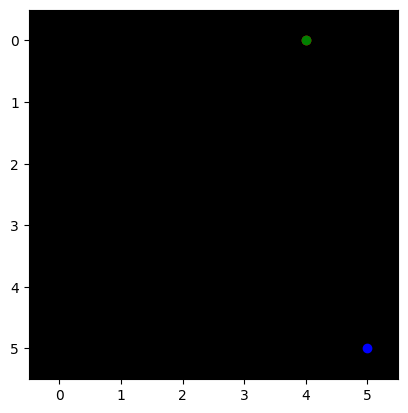

[-0.30721235]
 gamma 0.8
[-1]
[-0.30721235]
return [-1.0]
gae [-0.6927876472473145]
0.3767811606376562
tensor([[ 4.,  1.,  2., -3.]])
tensor([[ 4.,  0.,  2., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 1.,  0., -1., -4.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  2., -3.]])
tensor([[ 4.,  1.,  2., -3.]])
tensor([[ 4.,  0.,  2., -4.]]

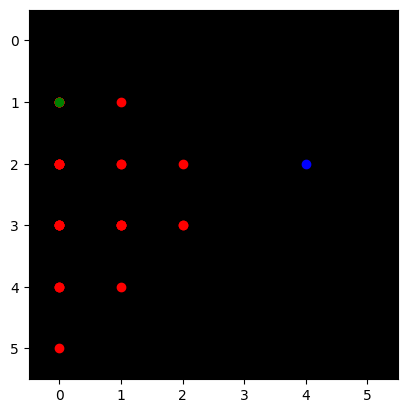

[-0.34997413, -0.35053223, -0.3653681, -0.36910632, -0.3653681, -0.36910632, -0.37128296, -0.32133883, -0.34613723, -0.35419792, -0.3653681, -0.35419792, -0.3411137, -0.35419792, -0.3653681, -0.35419792, -0.34613723, -0.36910632, -0.37128296, -0.36910632, -0.34997413, -0.35053223, -0.3541877, -0.35053223, -0.3653681, -0.35419792, -0.3411137, -0.32079053, -0.3411137]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.34997413, -0.35053223, -0.3653681, -0.36910632, -0.3653681, -0.36910632, -0.37128296, -0.32133883, -0.34613723, -0.35419792, -0.3653681, -0.35419792, -0.3411137, -0.35419792, -0.3653681, -0.35419792, -0.34613723, -0.36910632, -0.37128296, -0.36910632, -0.34997413, -0.35053223, -0.3541877, -0.35053223, -0.3653681, -0.35419792, -0.3411137, -0.32079053, -0.3411137]
return [-0.2804257869720459, -0.2922944784164429, -0.2952850580215454, -0.2922944784164429, -0.2952850580215454, -0.2970263719558716, -0.25707106590270995, -0.276

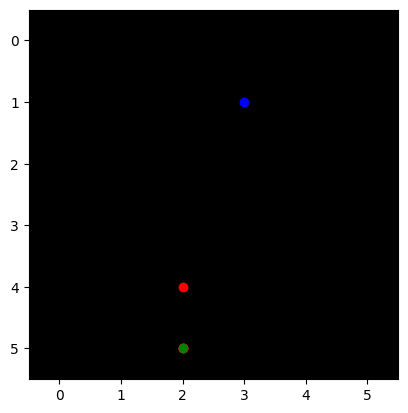

[-0.35025057, -0.3459687, -0.34654272, -0.3459687]
 gamma 0.8
[0, 0, 0, -1]
[-0.35025057, -0.3459687, -0.34654272, -0.3459687]
return [-0.2767749547958374, -0.27723417282104496, -0.2767749547958374, -1.0]
gae [0.07347561717033385, 0.0687345206737518, 0.06976776123046874, -0.6540313065052032]
0.5300568984348822
tensor([[ 1.,  1.,  0., -3.]])
tensor([[ 1.,  1.,  0., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 1.,  1.,  0., -3.]])
tensor([[ 1.,  1.,  0., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  0.,  1., -4.]])


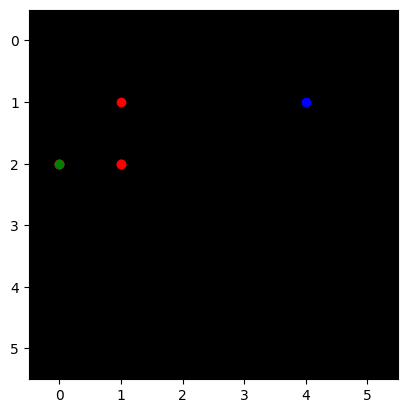

[-0.32804447, -0.35632327, -0.32804447, -0.35632327, -0.3665629]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.32804447, -0.35632327, -0.32804447, -0.35632327, -0.3665629]
return [-0.2850586175918579, -0.2624355792999268, -0.2850586175918579, -0.29325032234191895, -1.0]
gae [0.04298585653305054, 0.09388769268989561, 0.04298585653305054, 0.06307294964790344, -0.6334370970726013]
return [-0.2516879  -0.2516879  -0.24765703 -0.24712388 -0.2469439  -0.2469439
 -0.24668758 -0.24668758 -0.24278525 -0.23902345]
return [-1.         -1.         -1.         -1.         -1.         -0.29702637
 -0.29702637 -0.29528505 -0.29528505 -0.29528505]

-------------------- Iteration #31 --------------------
random  0.5300568984348822
Average : 0.01
Average Episodic Return: -0.69
Max Episodic Return: 1.0
Average Loss: 0.00358
Average Loss Critic: 0.24256347119808197
TEntropy: nan
approx_kl_divs: [0.00010100151] secs
------------------------------------------------------

0.9023711883306648
tensor([[1., 5., 0., 2.]])
ten

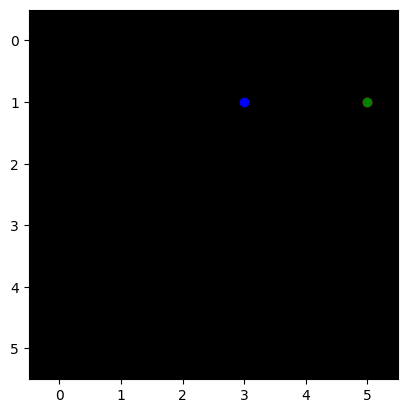

[-0.41514102]
 gamma 0.8
[-1]
[-0.41514102]
return [-1.0]
gae [-0.5848589837551117]
0.942925891550209
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 2.,  0., -2., -2.]])
tensor([[ 2.,  0., -2., -2.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 2.,  0., -2., -2.]])
tensor([[ 2.,  0., -2., -2.]])


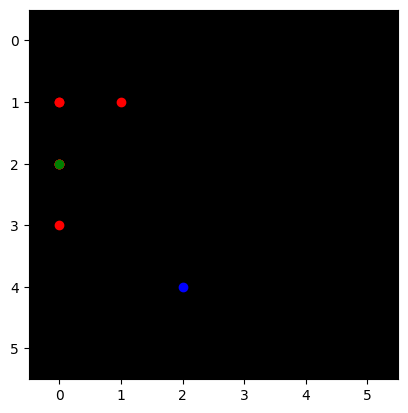

[-0.41149315, -0.34248233, -0.41149315, -0.34248233, -0.3291681, -0.3347995, -0.3291681]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.41149315, -0.34248233, -0.41149315, -0.34248233, -0.3291681, -0.3347995, -0.3291681]
return [-0.2739858627319336, -0.32919452190399173, -0.2739858627319336, -0.2633344888687134, -0.2678395986557007, -0.2633344888687134, -1.0]
gae [0.13750728964805603, 0.01328780651092526, 0.13750728964805603, 0.07914783954620358, 0.06132851243019105, 0.07146500945091244, -0.6708318889141083]
0.8787474075717441
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  5., -4.,  5.]])
tensor([[ 1.,  5., -4.,  5.]])


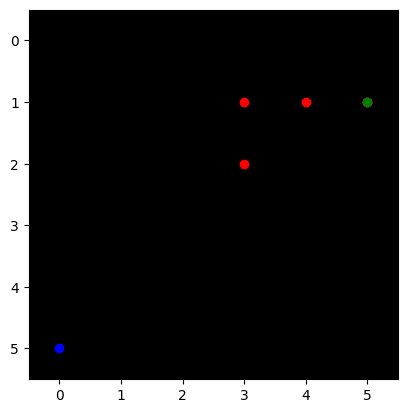

[-0.4381387, -0.43261504, -0.42705414, -0.41703767, -0.4017287]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.4381387, -0.43261504, -0.42705414, -0.41703767, -0.4017287]
return [-0.3460920333862305, -0.3416433095932007, -0.33363013267517094, -0.3213829517364502, -1.0]
gae [0.09204666018486019, 0.09097173213958737, 0.09342400431632991, 0.09565471410751342, -0.5982713103294373]
0.8970994005898821
tensor([[2., 5., 2., 5.]])
tensor([[2., 5., 2., 5.]])
tensor([[1., 5., 1., 5.]])
tensor([[1., 5., 1., 5.]])
tensor([[0., 5., 0., 5.]])
tensor([[0., 5., 0., 5.]])
tensor([[0., 4., 0., 4.]])
tensor([[0., 4., 0., 4.]])
tensor([[0., 3., 0., 3.]])
tensor([[0., 3., 0., 3.]])
tensor([[1., 3., 1., 3.]])
tensor([[1., 3., 1., 3.]])
tensor([[2., 3., 2., 3.]])
tensor([[2., 3., 2., 3.]])
tensor([[3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.]])
tensor([[3., 4., 3., 4.]])
tensor([[3., 4., 3., 4.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 5., 3., 5.]])


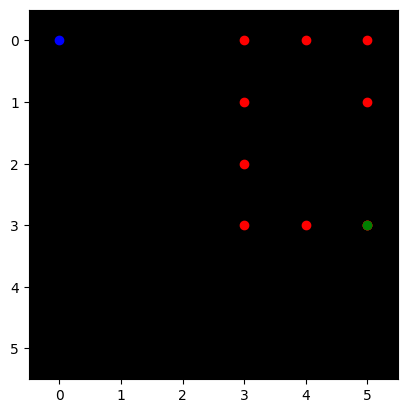

[-0.38017142, -0.3773718, -0.36609268, -0.39350832, -0.4151544, -0.42730346, -0.43229178, -0.42166826, -0.40393132, -0.37947112]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.38017142, -0.3773718, -0.36609268, -0.39350832, -0.4151544, -0.42730346, -0.43229178, -0.42166826, -0.40393132, -0.37947112]
return [-0.3018974304199219, -0.2928741455078125, -0.3148066520690918, -0.3321235179901123, -0.34184277057647705, -0.345833420753479, -0.3373346090316773, -0.32314505577087405, -0.3035768985748291, -1.0]
gae [0.07827398777008054, 0.08449764251708985, 0.05128602981567382, 0.06138479709625244, 0.07331162691116333, 0.08147004246711731, 0.09495716691017148, 0.09852320551872251, 0.10035442113876342, -0.6205288767814636]
0.7731822969855673
tensor([[ 5.,  2.,  3., -1.]])
tensor([[ 5.,  2.,  3., -1.]])
tensor([[ 4.,  2.,  2., -1.]])
tensor([[ 4.,  2.,  2., -1.]])
tensor([[ 4.,  1.,  2., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 4.,  1.,  2., -2.]])
tensor([[ 4.,  1.,  2., -2.]])
tensor([[ 4.,

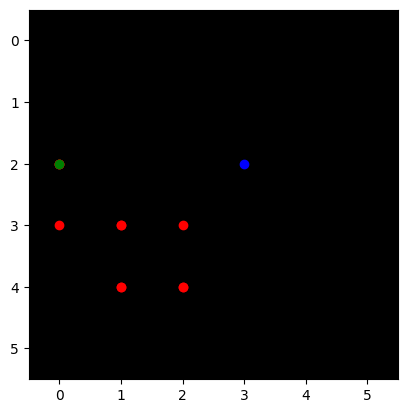

[-0.39379975, -0.397221, -0.34510073, -0.35844383, -0.34510073, -0.397221, -0.42132166, -0.35844383, -0.35332888, -0.3343384]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.39379975, -0.397221, -0.34510073, -0.35844383, -0.34510073, -0.397221, -0.42132166, -0.35844383, -0.35332888, -0.3343384]
return [-0.31777679920196533, -0.27608058452606205, -0.2867550611495972, -0.27608058452606205, -0.31777679920196533, -0.33705732822418216, -0.2867550611495972, -0.28266310691833496, -0.26747071743011475, -1.0]
gae [0.07602295279502869, 0.12114041447639462, 0.05834566950798031, 0.08236324191093441, 0.027323931455612183, 0.0601636707782745, 0.13456659913063046, 0.0757807195186615, 0.08585816621780396, -0.6656616032123566]
0.26194115337634005
tensor([[4., 5., 2., 0.]])
tensor([[5., 5., 3., 0.]])
tensor([[5., 5., 3., 0.]])
tensor([[ 5.,  4.,  3., -1.]])
tensor([[ 4.,  4.,  2., -1.]])
tensor([[4., 5., 2., 0.]])
tensor([[4., 5., 2., 0.]])
tensor([[5., 5., 3., 0.]])
tensor([[4., 5., 2., 0.]])
tensor([[5

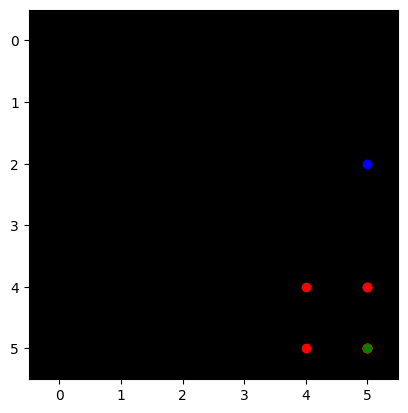

[-0.4224258, -0.43574747, -0.44233495, -0.4363009, -0.4224258, -0.43574747, -0.4224258, -0.43574747]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.4224258, -0.43574747, -0.44233495, -0.4363009, -0.4224258, -0.43574747, -0.4224258, -0.43574747]
return [-0.3485979795455933, -0.3538679599761963, -0.3490407228469849, -0.3379406452178955, -0.3485979795455933, -0.3379406452178955, -0.3485979795455933, -1.0]
gae [0.07382782697677609, 0.08187951445579528, 0.09329422712326046, 0.09836025834083556, 0.07382782697677609, 0.09780682921409606, 0.07382782697677609, -0.5642525255680084]
0.4150831802344054
tensor([[ 5.,  4.,  2., -1.]])
tensor([[ 5.,  4.,  2., -1.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 5.,  0.,  2., -5.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tenso

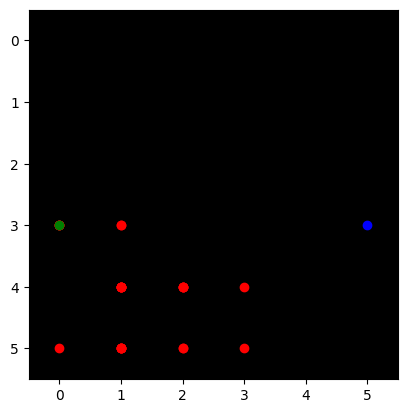

[-0.44943085, -0.41250524, -0.43937084, -0.35961208, -0.3427717, -0.34641922, -0.3427717, -0.34641922, -0.35148802, -0.34641922, -0.3427717, -0.35961208, -0.3662568, -0.35961208, -0.3427717, -0.34641922, -0.3427717, -0.35961208, -0.3662568, -0.34641922, -0.3427717, -0.3439875, -0.34888002, -0.3439875, -0.34888002]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.44943085, -0.41250524, -0.43937084, -0.35961208, -0.3427717, -0.34641922, -0.3427717, -0.34641922, -0.35148802, -0.34641922, -0.3427717, -0.35961208, -0.3662568, -0.35961208, -0.3427717, -0.34641922, -0.3427717, -0.35961208, -0.3662568, -0.34641922, -0.3427717, -0.3439875, -0.34888002, -0.3439875, -0.34888002]
return [-0.33000419139862064, -0.3514966726303101, -0.2876896619796753, -0.2742173671722412, -0.27713537216186523, -0.2742173671722412, -0.27713537216186523, -0.28119041919708254, -0.27713537216186523, -0.2742173671722412, -0.2876896619796753, -0.29300544261932376, -0.28768966197

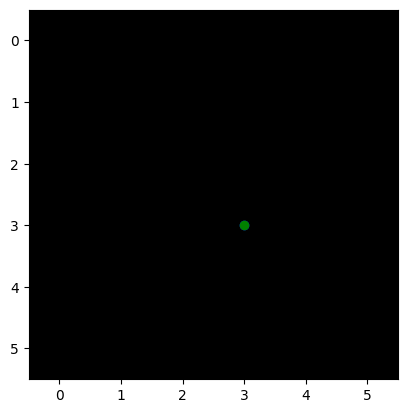

[]
 gamma 0.8
[]
[]
return []
gae []
0.45264761735765413


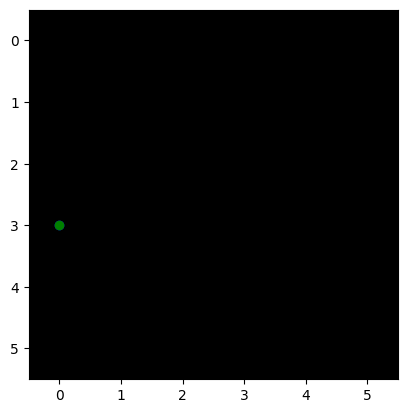

[]
 gamma 0.8
[]
[]
return []
gae []
0.5426542746738915
tensor([[ 4.,  4.,  1., -1.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 5.,  1.,  2., -4.]])


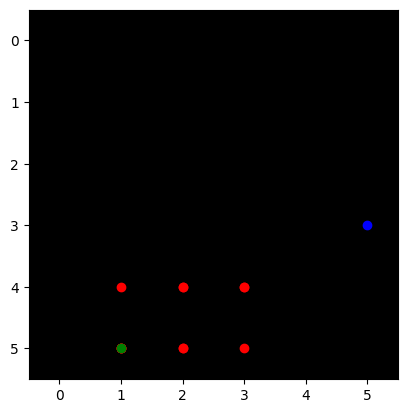

[-0.267701, -0.26278436, -0.2589477, -0.26481786, -0.27798888, -0.27887735, -0.27573162, -0.26278436, -0.27573162, -0.26481786, -0.27798888]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.267701, -0.26278436, -0.2589477, -0.26481786, -0.27798888, -0.27887735, -0.27573162, -0.26278436, -0.27573162, -0.26481786, -0.27798888]
return [-0.21022748947143555, -0.20715816020965577, -0.21185429096221925, -0.22239110469818116, -0.22310187816619875, -0.22058529853820802, -0.21022748947143555, -0.22058529853820802, -0.21185429096221925, -0.22239110469818116, -1.0]
gae [0.05747351050376892, 0.05562620162963866, 0.04709340929985045, 0.04242675900459289, 0.05488700270652769, 0.058292049169540394, 0.06550413370132446, 0.042199063301086415, 0.06387733221054076, 0.04242675900459289, -0.7220111191272736]
0.38561061227167526
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 0.,  5., -3.,  4.]])
tensor([[ 1.,  5., -2.,  4.]])
tensor([[ 1.,  5., -2.,  4.]])


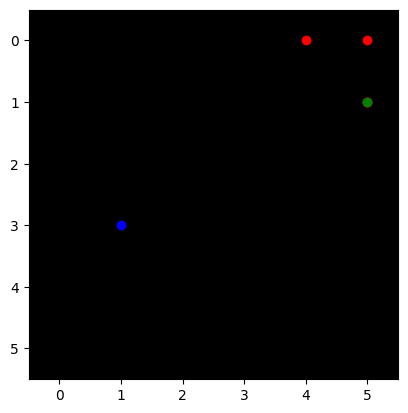

[-0.27710655, -0.2702462, -0.26419705, -0.27072364]
 gamma 0.8
[0, 0, 0, -1]
[-0.27710655, -0.2702462, -0.26419705, -0.27072364]
return [-0.21619696617126466, -0.2113576412200928, -0.21657891273498536, -1.0]
gae [0.06090958714485167, 0.05888856649398802, 0.047618138790130604, -0.7292763590812683]
0.4890270580340794
tensor([[ 0.,  5., -3.,  0.]])
tensor([[ 0.,  5., -3.,  0.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 2.,  5., -1.,  0.]])
tensor([[ 2.,  5., -1.,  0.]])
tensor([[ 2.,  4., -1., -1.]])
tensor([[ 2.,  5., -1.,  0.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 1.,  5., -2.,  0.]])


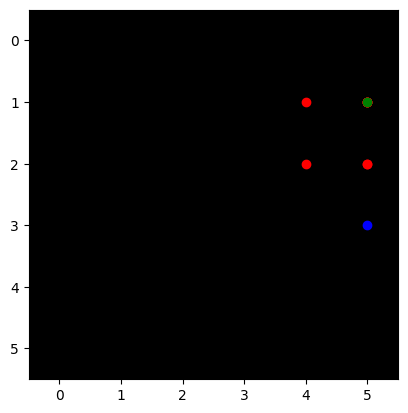

[-0.27446234, -0.27983135, -0.29058403, -0.27983135, -0.2826529, -0.28933266, -0.2826529, -0.27983135]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.27446234, -0.27983135, -0.29058403, -0.27983135, -0.2826529, -0.28933266, -0.2826529, -0.27983135]
return [-0.22386507987976076, -0.23246722221374513, -0.22386507987976076, -0.2261223316192627, -0.23146612644195558, -0.2261223316192627, -0.22386507987976076, -1.0]
gae [0.05059726238250731, 0.047364127635955794, 0.06671894788742064, 0.05370901823043822, 0.05118678808212279, 0.06321032643318175, 0.05878783464431761, -0.7201686501502991]
0.45775730754367894
tensor([[ 2.,  0., -2., -4.]])
tensor([[ 2.,  0., -2., -4.]])
tensor([[ 1.,  0., -3., -4.]])
tensor([[ 0.,  0., -4., -4.]])
tensor([[ 0.,  0., -4., -4.]])


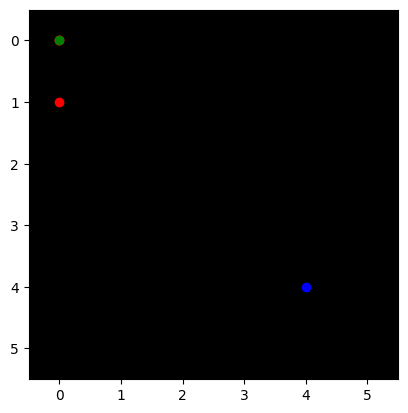

[-0.26077402, -0.2570547, -0.25966078]
 gamma 0.8
[0, 0, -1]
[-0.26077402, -0.2570547, -0.25966078]
return [-0.20564374923706055, -0.20772862434387207, -1.0]
gae [0.055130267143249506, 0.04932606220245361, -0.7403392195701599]
0.7287220421285513
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 3.,  2., -2.,  0.]])
tensor([[ 3.,  2., -2.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 3.,  2., -2.,  0.]])
tensor([[ 3.,  2., -2.,  0.]])
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 4.,  1., -1., -1.]])
tensor([[ 4.,  1., -1., -1.]])
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 3.,  2., -2.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 2.,  1., -3., -1.]])
tensor([[ 1.,  1., -4., -1.]])
tensor([[ 1.,  1., -4., -1.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 2.,  2., -3.,  0.]])
tensor([[ 

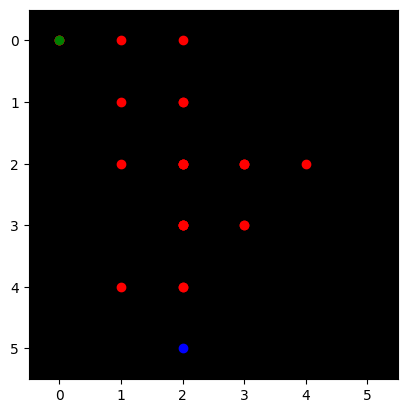

[-0.30422392, -0.30239752, -0.30422392, -0.30239752, -0.28193238, -0.2883198, -0.28193238, -0.30239752, -0.30422392, -0.30467567, -0.29575554, -0.29779243, -0.30422392, -0.29008228, -0.2826214, -0.29008228, -0.28973153, -0.29008228, -0.28973153, -0.30239752, -0.30422392, -0.29779243, -0.27905834, -0.27175054, -0.25799203]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.30422392, -0.30239752, -0.30422392, -0.30239752, -0.28193238, -0.2883198, -0.28193238, -0.30239752, -0.30422392, -0.30467567, -0.29575554, -0.29779243, -0.30422392, -0.29008228, -0.2826214, -0.29008228, -0.28973153, -0.29008228, -0.28973153, -0.30239752, -0.30422392, -0.29779243, -0.27905834, -0.27175054, -0.25799203]
return [-0.24191801548004152, -0.24337913990020754, -0.24191801548004152, -0.22554590702056887, -0.230655837059021, -0.22554590702056887, -0.24191801548004152, -0.24337913990020754, -0.24374053478240967, -0.2366044282913208, -0.23823394775390627, -0.24337913990020

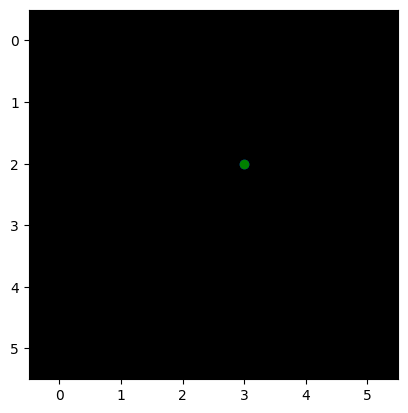

[]
 gamma 0.8
[]
[]
return []
gae []
0.9253931308219433
tensor([[ 3.,  0.,  1., -5.]])
tensor([[ 3.,  0.,  1., -5.]])
tensor([[ 4.,  0.,  2., -5.]])
tensor([[ 4.,  0.,  2., -5.]])
tensor([[ 4.,  1.,  2., -4.]])
tensor([[ 4.,  1.,  2., -4.]])
tensor([[ 4.,  0.,  2., -5.]])
tensor([[ 4.,  0.,  2., -5.]])


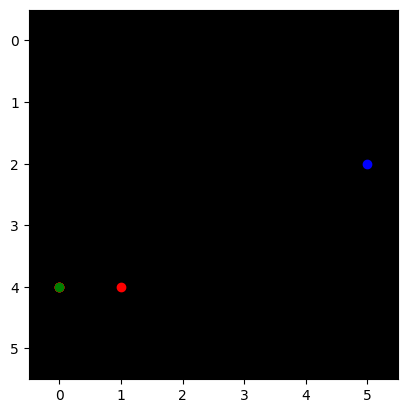

[-0.21945104, -0.23300935, -0.2208641, -0.23300935]
 gamma 0.8
[0, 0, 0, -1]
[-0.21945104, -0.23300935, -0.2208641, -0.23300935]
return [-0.18640748262405396, -0.17669128179550173, -0.18640748262405396, -1.0]
gae [0.033043557405471796, 0.05631807148456572, 0.034456619620323176, -0.7669906467199326]
0.9430703536333656
tensor([[ 0.,  0., -4., -3.]])
tensor([[ 0.,  0., -4., -3.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  1., -4., -2.]])
tensor([[ 0.,  2., -4., -1.]])
tensor([[ 0.,  2., -4., -1.]])


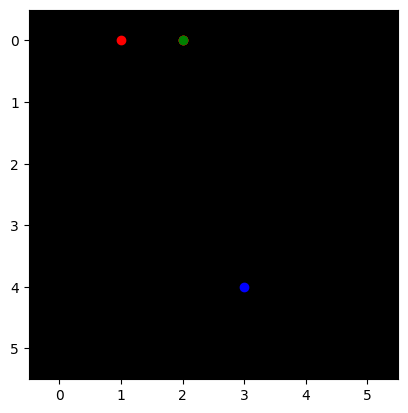

[-0.18186091, -0.21509297, -0.22223409]
 gamma 0.8
[0, 0, -1]
[-0.18186091, -0.21509297, -0.22223409]
return [-0.17207437753677368, -0.1777872681617737, -1.0]
gae [0.009786531329154968, 0.0373057037591934, -0.7777659147977829]
0.9417769065334431
tensor([[2., 5., 0., 2.]])
tensor([[2., 5., 0., 2.]])
tensor([[ 1.,  5., -1.,  2.]])
tensor([[ 1.,  5., -1.,  2.]])


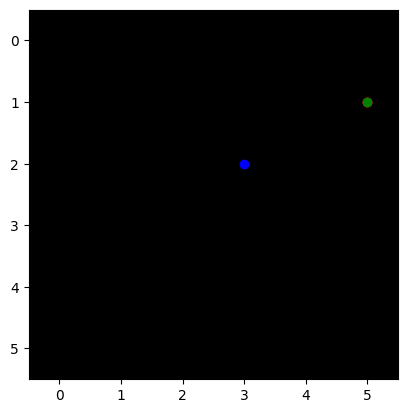

[-0.24160665, -0.22434847]
 gamma 0.8
[0, -1]
[-0.24160665, -0.22434847]
return [-0.17947877645492555, -1.0]
gae [0.06212787628173827, -0.7756515294313431]
0.14638346596900476
tensor([[5., 3., 2., 3.]])
tensor([[5., 4., 2., 4.]])
tensor([[4., 4., 1., 4.]])
tensor([[4., 4., 1., 4.]])
tensor([[4., 5., 1., 5.]])


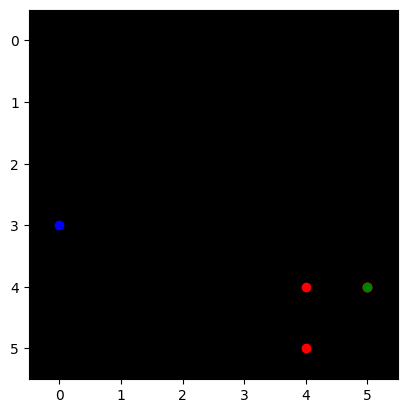

[-0.21683487, -0.23437943, -0.22183709, -0.22139773]
 gamma 0.8
[0, 0, 0, -1]
[-0.21683487, -0.23437943, -0.22183709, -0.22139773]
return [-0.18750354051589968, -0.1774696707725525, -0.177118182182312, -1.0]
gae [0.02933133244514463, 0.05690975487232208, 0.0447189062833786, -0.77860227227211]
0.5633445398879979
tensor([[ 3.,  2., -1.,  0.]])
tensor([[ 3.,  2., -1.,  0.]])
tensor([[ 3.,  1., -1., -1.]])
tensor([[ 3.,  2., -1.,  0.]])
tensor([[ 3.,  1., -1., -1.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 4.,  0.,  0., -2.]])
tensor([[ 4.,  0.,  0., -2.]])
tensor([[ 5.,  0.,  1., -2.]])
tensor([[ 4.,  0.,  0., -2.]])
tensor([[ 4.,  0.,  0., -2.]])
tensor([[ 4.,  1.,  0., -1.]])
tensor([[ 4.,  1.,  0., -1.]])
tensor([[ 5.,  1.,  1., -1.]])
tensor([[ 5.,  1.,  1., -1.]])
tensor([[ 4.,  1.,  0., -1.]])
tensor([[ 4.,  1.,  0., -1.]])


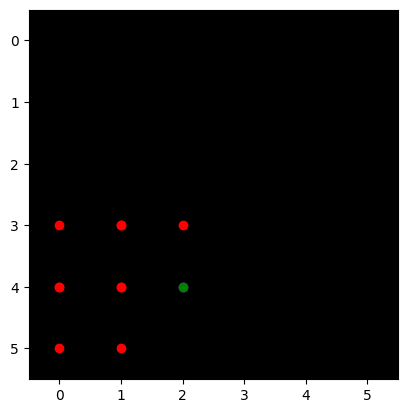

[-0.19143918, -0.20733899, -0.19143918, -0.20733899, -0.20640922, -0.2186992, -0.22345614, -0.2186992, -0.21525492, -0.2166496, -0.21525492]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.19143918, -0.20733899, -0.19143918, -0.20733899, -0.20640922, -0.2186992, -0.22345614, -0.2186992, -0.21525492, -0.2166496, -0.21525492]
return [-0.1658711910247803, -0.15315134525299073, -0.1658711910247803, -0.16512737274169922, -0.17495936155319214, -0.1787649154663086, -0.17495936155319214, -0.17220393419265748, -0.17331968545913698, -0.17220393419265748, 1.0]
gae [0.025567990541458113, 0.05418764352798461, 0.025567990541458113, 0.04221161603927612, 0.031449854373931885, 0.039934286475181574, 0.048496782779693604, 0.0464952677488327, 0.04193523228168486, 0.04444567263126373, 1.2152549177408218]
0.020631316593569093
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  2.,  1., -2.]

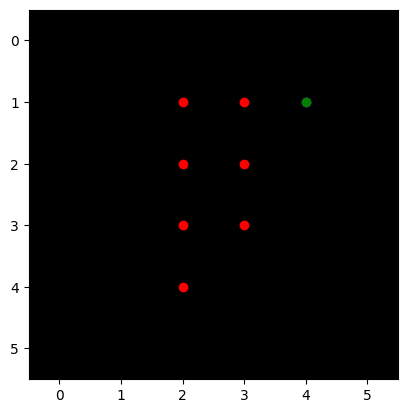

[-0.2109207, -0.21474259, -0.21735512, -0.2145943, -0.19022614, -0.21770275, -0.17722994, -0.1940849]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 1]
[-0.2109207, -0.21474259, -0.21735512, -0.2145943, -0.19022614, -0.21770275, -0.17722994, -0.1940849]
return [-0.17179406881332399, -0.1738840937614441, -0.171675443649292, -0.15218091011047363, -0.17416219711303713, -0.1417839527130127, -0.15526791810989382, 1.0]
gae [0.03912663757801055, 0.040858492255210876, 0.04567967355251312, 0.06241339445114136, 0.016063940525054915, 0.07591879367828369, 0.021962022781372048, 1.1940848976373672]
0.29833687763341354
tensor([[4., 3., 2., 3.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 4., 2., 4.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 4., 1., 4.]])
tensor([[4., 4., 2., 4.]])
tensor([[5., 4., 3., 4.]])


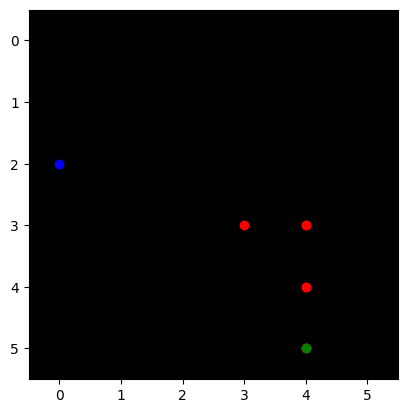

[-0.21372372, -0.21770746, -0.22549373, -0.21873774, -0.22549373, -0.21770746, -0.22168969]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.21372372, -0.21770746, -0.22549373, -0.21873774, -0.22549373, -0.21770746, -0.22168969]
return [-0.17416596412658691, -0.18039498329162598, -0.17499018907546998, -0.18039498329162598, -0.17416596412658691, -0.17735174894332886, -1.0]
gae [0.03955775499343872, 0.03731247186660766, 0.05050354003906249, 0.03834275305271148, 0.05132776498794556, 0.04035570621490478, -0.7783103138208389]
0.17291809123637347
tensor([[2., 3., 1., 3.]])
tensor([[3., 3., 2., 3.]])
tensor([[3., 3., 2., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 4., 3., 4.]])
tensor([[3., 4., 2., 4.]])
tensor([[3., 3., 2., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 4., 3., 4.]])
tensor([[4., 3., 3., 3.]])
tensor([[3., 3., 2., 3.]])
tensor([[3., 4., 2., 4.]])
tensor([[3., 5., 2., 5.]])
tensor([[2., 5., 1., 5.]])
tensor([[2., 4., 1., 4.]])
tensor([[2., 5., 1., 5.]])


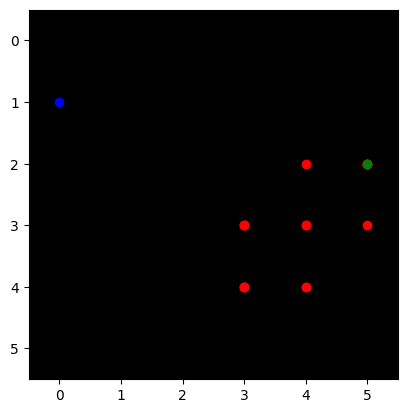

[-0.22959137, -0.19748667, -0.21406426, -0.21025462, -0.22161298, -0.19748667, -0.21406426, -0.21025462, -0.21406426, -0.19748667, -0.22161298, -0.22019537, -0.23342939, -0.2366044, -0.23342939]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.22959137, -0.19748667, -0.21406426, -0.21025462, -0.22161298, -0.19748667, -0.21406426, -0.21025462, -0.21406426, -0.19748667, -0.22161298, -0.22019537, -0.23342939, -0.2366044, -0.23342939]
return [-0.15798933506011964, -0.17125140428543092, -0.16820369958877565, -0.17729038000106812, -0.15798933506011964, -0.17125140428543092, -0.16820369958877565, -0.17125140428543092, -0.15798933506011964, -0.17729038000106812, -0.17615629434585572, -0.1867435097694397, -0.1892835259437561, -0.1867435097694397, -1.0]
gae [0.07160203456878661, 0.02623526453971861, 0.045860555768012984, 0.03296424448490143, 0.0636236399412155, 0.02623526453971861, 0.045860555768012984, 0.03900322020053862, 0.056074920296668995, 0.02019628882408142, 0.04545668065547

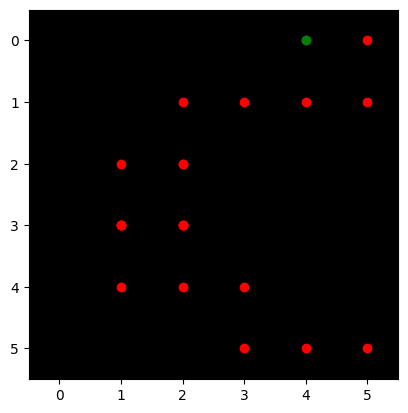

[-0.09245697, -0.09143216, -0.09245697, -0.08992603, -0.08940598, -0.08059566, -0.083692804, -0.090230525, -0.092338406, -0.090230525, -0.092338406, -0.05253023, -0.016373742, -0.090230525, -0.092338406, -0.05253023, 0.038139652, 0.03831178, 0.018329848, -0.0013766504, 0.0118739465]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.09245697, -0.09143216, -0.09245697, -0.08992603, -0.08940598, -0.08059566, -0.083692804, -0.090230525, -0.092338406, -0.090230525, -0.092338406, -0.05253023, -0.016373742, -0.090230525, -0.092338406, -0.05253023, 0.038139652, 0.03831178, 0.018329848, -0.0013766504, 0.0118739465]
return [-0.07314572930335998, -0.07396557331085206, -0.07194082140922546, -0.07152478694915772, -0.06447652578353882, -0.06695424318313599, -0.07218441963195801, -0.07387072443962098, -0.07218441963195801, -0.07387072443962098, -0.04202418327331543, -0.01309899389743805, -0.07218441963195801, -0.07387072443962098, -0.04202418327331543, 0.03051172196865081

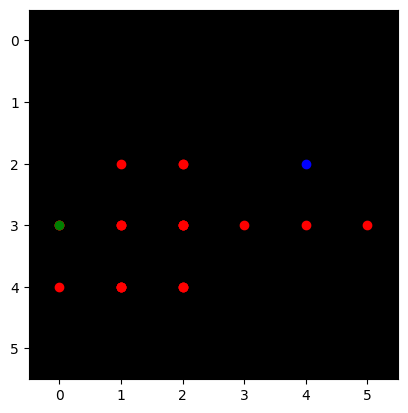

[-0.07966291, -0.09778618, -0.082397, -0.08666694, -0.06484694, 0.030231604, -0.06484694, -0.08839891, -0.09075439, -0.029965486, -0.06484694, -0.029965486, 0.0012422422, 0.030231604, -0.06484694, -0.029965486, -0.09075439, -0.08839891, -0.09075439, -0.08839891, -0.09075439, -0.09070225, -0.0034675607]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.07966291, -0.09778618, -0.082397, -0.08666694, -0.06484694, 0.030231604, -0.06484694, -0.08839891, -0.09075439, -0.029965486, -0.06484694, -0.029965486, 0.0012422422, 0.030231604, -0.06484694, -0.029965486, -0.09075439, -0.08839891, -0.09075439, -0.08839891, -0.09075439, -0.09070225, -0.0034675607]
return [-0.07822894454002381, -0.0659175992012024, -0.06933355331420898, -0.051877552270889284, 0.02418528348207474, -0.051877552270889284, -0.0707191288471222, -0.07260351181030274, -0.023972389101982117, -0.051877552270889284, -0.023972389101982117, 0.0009937937371432783, 0.02418528348207474, -0.05187755227

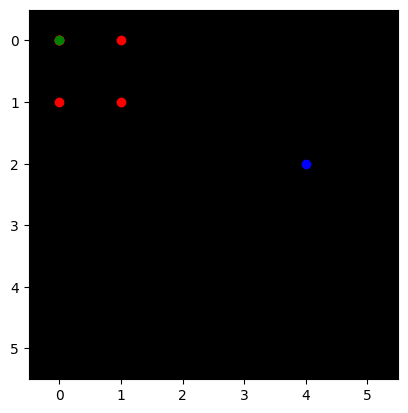

[0.03393162, 0.03585456, 0.03393162, 0.038086936, 0.010908141, 0.03585456]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.03393162, 0.03585456, 0.03393162, 0.038086936, 0.010908141, 0.03585456]
return [0.028683647513389587, 0.027145296335220337, 0.03046954870223999, 0.008726512640714645, 0.028683647513389587, -1.0]
gae [-0.005247972905635834, -0.008709263056516647, -0.00346207171678543, -0.02936042323708534, 0.01777550671249628, -1.035854559391737]
return [0.01466388 0.02418528 0.02418528 0.0271453  0.02868365 0.02868365
 0.03046955 0.03051172 0.03064942 1.        ]
return [-1.         -1.         -0.07822894 -0.07396557 -0.07387073 -0.07387073
 -0.07387073 -0.07314573 -0.07260351 -0.07260351]

-------------------- Iteration #35 --------------------
random  0.026008104625578787
Average : 0.01
Average Episodic Return: -0.68
Max Episodic Return: 1.0
Average Loss: -0.00257
Average Loss Critic: 0.23559129238128662
TEntropy: nan
approx_kl_divs: [0.0003659094] secs
---------------------------------------

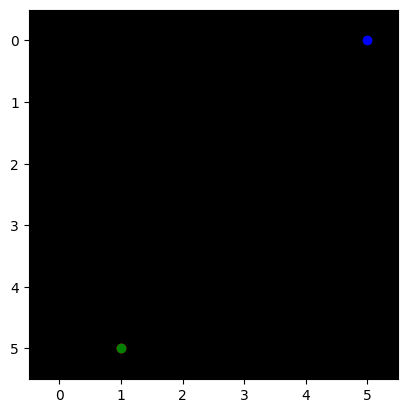

[-0.001699364]
 gamma 0.8
[-1]
[-0.001699364]
return [-1.0]
gae [-0.9983006359543651]
0.6607134215906619
tensor([[ 4.,  0.,  0., -2.]])


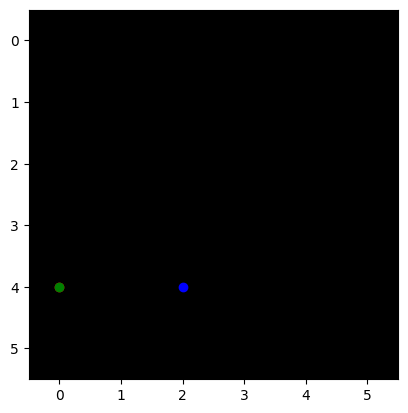

[0.008829804]
 gamma 0.8
[-1]
[0.008829804]
return [-1.0]
gae [-1.0088298041373491]
0.5568285608992823
tensor([[ 2.,  0.,  1., -3.]])
tensor([[ 2.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  1., -2.]])
tensor([[ 3.,  1.,  2., -2.]])
tensor([[ 3.,  1.,  2., -2.]])
tensor([[ 3.,  2.,  2., -1.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 5.,  2.,  4., -1.]])
tensor([[ 5.,  2.,  4., -1.]])


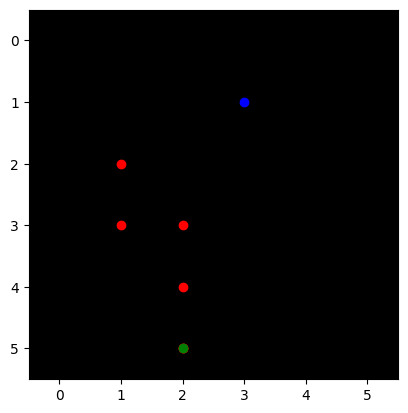

[0.006947018, 0.008192274, -0.0055977935, -0.011722258, -0.013397771, -0.015959255]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.006947018, 0.008192274, -0.0055977935, -0.011722258, -0.013397771, -0.015959255]
return [0.006553819030523301, -0.004478234797716141, -0.009377806633710862, -0.010718216747045518, -0.012767404317855835, -1.0]
gae [-0.00039319917559623666, -0.012670508585870266, -0.0037800131365656863, 0.0010040415450930582, 0.0006303666159510612, -0.9840407446026802]
0.9723685379772476
tensor([[4., 4., 0., 2.]])
tensor([[4., 4., 0., 2.]])
tensor([[4., 5., 0., 3.]])
tensor([[4., 5., 0., 3.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[4., 5., 0., 3.]])
tensor([[4., 5., 0., 3.]])


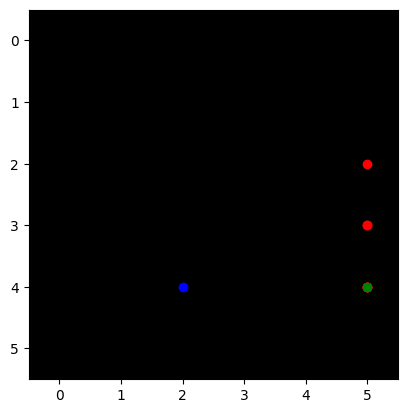

[0.019952107, 0.023001889, 0.038618967, 0.050505515, 0.038618967, 0.023001889]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.019952107, 0.023001889, 0.038618967, 0.050505515, 0.038618967, 0.023001889]
return [0.018401511013507843, 0.0308951735496521, 0.040404412150383, 0.0308951735496521, 0.018401511013507843, -1.0]
gae [-0.0015505962073802948, 0.007893284782767296, 0.0017854452133178739, -0.019610341638326645, -0.02021745592355728, -1.0230018887668848]
0.5267357020990332
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 2.,  1., -2., -1.]])
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 2.,  1., -2., -1.]])
tensor([[ 2.,  1., -2., -1.]])
tensor([[ 3.,  1., -1., -1.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 3.,  0., -1., -2.]])


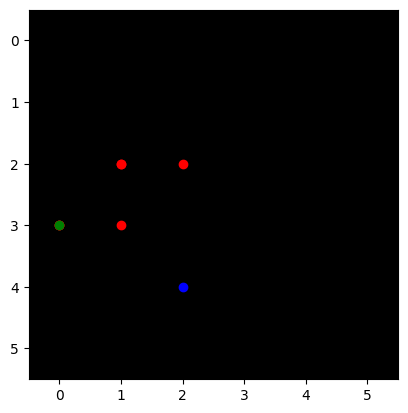

[0.052680146, 0.04232505, 0.052680146, 0.04232505, 0.031606723, 0.004747124]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.052680146, 0.04232505, 0.052680146, 0.04232505, 0.031606723, 0.004747124]
return [0.03386003971099854, 0.042144116759300236, 0.03386003971099854, 0.025285378098487854, 0.0037976991385221485, -1.0]
gae [-0.01882010623812675, -0.00018093287944793285, -0.01882010623812675, -0.017039671540260315, -0.02780902348458767, -1.0047471239231527]
0.8021947153124295
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 3.,  2.,  0., -3.]])
tensor([[ 3.,  2.,  0., -3.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 4.,  0.,  1., -5.]])
tensor([[ 4.,  0.,  1., -5.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor

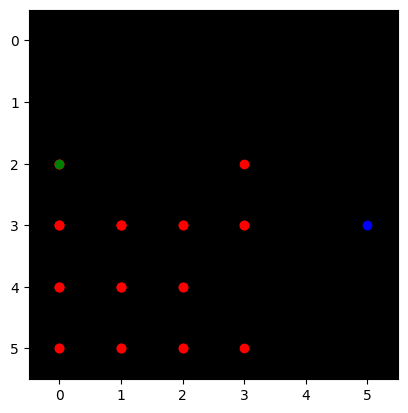

[0.0511298, 0.034235302, 0.0511298, 0.034235302, 0.0067466814, 0.0067924038, 0.0060172025, 0.013955313, 0.0081529, -0.0054189926, -0.005814345, -0.0054189926, 0.0081529, 0.0067924038, 0.0081529, -0.004234758, -0.0061136317, -0.014341131, -0.0061136317, -0.004234758, 0.0067466814, 0.0067924038, 0.0060172025, 0.013955313, -0.005814345, 0.013955313, 0.0060172025, 0.004835352]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.0511298, 0.034235302, 0.0511298, 0.034235302, 0.0067466814, 0.0067924038, 0.0060172025, 0.013955313, 0.0081529, -0.0054189926, -0.005814345, -0.0054189926, 0.0081529, 0.0067924038, 0.0081529, -0.004234758, -0.0061136317, -0.014341131, -0.0061136317, -0.004234758, 0.0067466814, 0.0067924038, 0.0060172025, 0.013955313, -0.005814345, 0.013955313, 0.0060172025, 0.004835352]
return [0.02738824188709259, 0.040903839468955996, 0.02738824188709259, 0.005397345125675202, 0.00543392300605774, 0.00481376200914383, 0.0111642502248

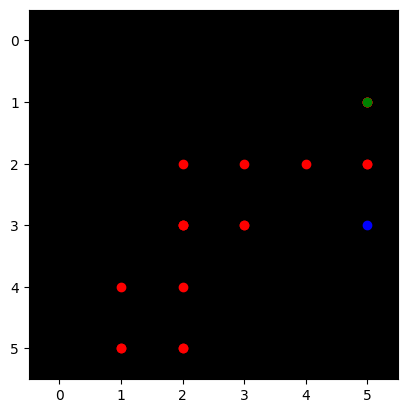

[0.013955313, 0.0081529, -0.0054189926, -0.0061136317, -0.0054189926, -0.0061136317, -0.004234758, 0.0067466814, 0.033566907, 0.0067466814, 0.034235302, 0.0067466814, 0.034235302, 0.0511298, 0.04513613, 0.048093025, 0.049382616, 0.048093025, 0.049382616]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.013955313, 0.0081529, -0.0054189926, -0.0061136317, -0.0054189926, -0.0061136317, -0.004234758, 0.0067466814, 0.033566907, 0.0067466814, 0.034235302, 0.0067466814, 0.034235302, 0.0511298, 0.04513613, 0.048093025, 0.049382616, 0.048093025, 0.049382616]
return [0.006522320210933685, -0.004335194081068039, -0.004890905320644379, -0.004335194081068039, -0.004890905320644379, -0.0033878065645694734, 0.005397345125675202, 0.026853525638580324, 0.005397345125675202, 0.02738824188709259, 0.005397345125675202, 0.02738824188709259, 0.040903839468955996, 0.03610890507698059, 0.038474419713020326, 0.03950609266757965, 0.038474419713020326, 0.03950609266757965, -1.0]
gae [-0.0

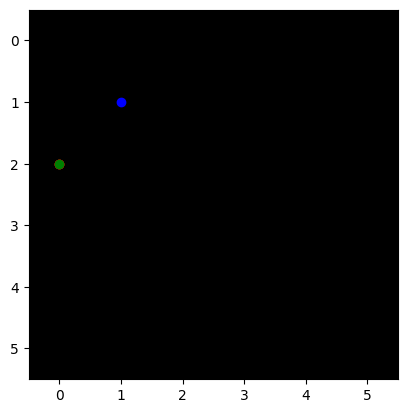

[-0.043428604, -0.0593673]
 gamma 0.8
[0, -1]
[-0.043428604, -0.0593673]
return [-0.04749383926391602, -1.0]
gae [-0.00406523570418358, -0.940632700920105]
0.403215755609594
tensor([[ 0.,  1., -2., -1.]])
tensor([[ 0.,  2., -2.,  0.]])
tensor([[ 0.,  2., -2.,  0.]])
tensor([[ 1.,  2., -1.,  0.]])
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[2., 4., 0., 2.]])
tensor([[2., 4., 0., 2.]])
tensor([[2., 3., 0., 1.]])
tensor([[2., 3., 0., 1.]])
tensor([[2., 4., 0., 2.]])
tensor([[3., 4., 1., 2.]])
tensor([[3., 4., 1., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[4., 5., 2., 3.]])
tensor([[4., 5., 2., 3.]])
tensor([[4., 4., 2., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[5., 4., 3., 2.]])


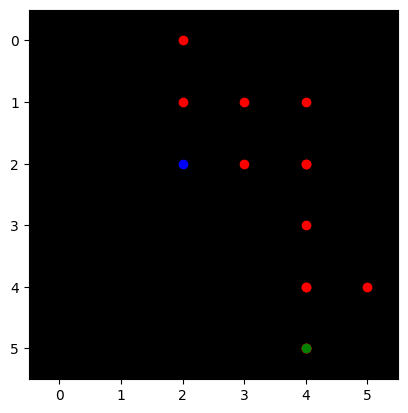

[-0.029545147, -0.026527058, -0.029583067, -0.03694297, -0.03502135, -0.025210617, -0.02791035, -0.025210617, -0.01340011, -0.020259848, -0.015012627, -0.020259848, -0.03571901]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.029545147, -0.026527058, -0.029583067, -0.03694297, -0.03502135, -0.025210617, -0.02791035, -0.025210617, -0.01340011, -0.020259848, -0.015012627, -0.020259848, -0.03571901]
return [-0.021221646666526796, -0.02366645336151123, -0.029554376006126405, -0.02801707983016968, -0.02016849368810654, -0.02232827991247177, -0.02016849368810654, -0.010720088332891465, -0.016207878291606904, -0.012010101228952408, -0.016207878291606904, -0.02857520878314972, -1.0]
gae [0.008323500305414198, 0.002860604971647262, 2.869069576263289e-05, 0.008925890177488325, 0.014852856099605558, 0.0028823371976614, 0.007741856202483174, 0.014490528777241706, -0.0028077678754925735, 0.008249746635556221, -0.001195251755416394, -0.008315360918641091, -0.9642809890210629]
0.0144078608207

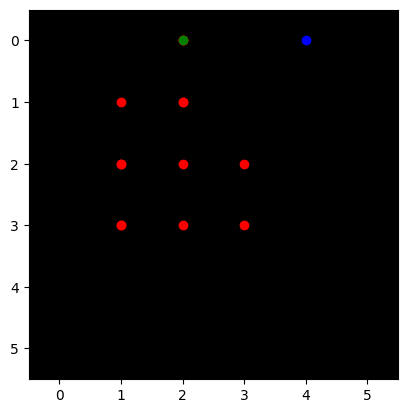

[-0.052337978, -0.045547724, -0.030475691, -0.041547097, -0.03279869, -0.06336969, -0.03279869, -0.06336969, -0.056505397, -0.042536482, -0.052337978, -0.042536482, -0.030514888]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.052337978, -0.045547724, -0.030475691, -0.041547097, -0.03279869, -0.06336969, -0.03279869, -0.06336969, -0.056505397, -0.042536482, -0.052337978, -0.042536482, -0.030514888]
return [-0.036438179016113285, -0.024380552768707278, -0.0332376778125763, -0.02623895108699799, -0.050695753097534185, -0.02623895108699799, -0.050695753097534185, -0.04520431756973267, -0.03402918577194214, -0.041870382428169255, -0.03402918577194214, -0.02441191077232361, -1.0]
gae [0.015899799019098278, 0.021167171001434323, -0.002761986851692204, 0.015308146178722379, -0.017897064238786703, 0.037130740284919736, -0.017897064238786703, 0.018165373802185053, 0.022476211190223694, 0.0006660997867584187, 0.018308792263269424, 0.018124571442604064, -0.9694851115345955]
0.049736186187

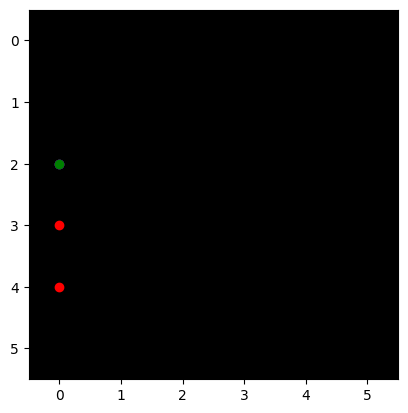

[-0.051683027, -0.05227803, -0.05689684]
 gamma 0.8
[0, 0, 1]
[-0.051683027, -0.05227803, -0.05689684]
return [-0.04182242453098298, -0.045517471432685856, 1.0]
gae [0.0098606027662754, 0.006760559231042858, 1.0568968392908573]
0.8909685500318608
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  0., -5.,  0.]])
tensor([[ 0.,  0., -5.,  0.]])


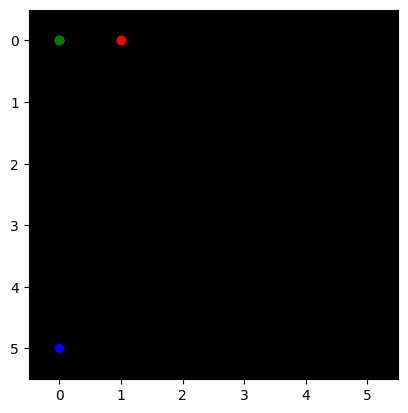

[-0.04021225, -0.043879766, -0.057228796]
 gamma 0.8
[0, 0, -1]
[-0.04021225, -0.043879766, -0.057228796]
return [-0.03510381281375885, -0.04578303694725037, -1.0]
gae [0.005108438432216644, -0.001903270930051805, -0.942771203815937]
0.3904493648692472
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  0., -3., -2.]])


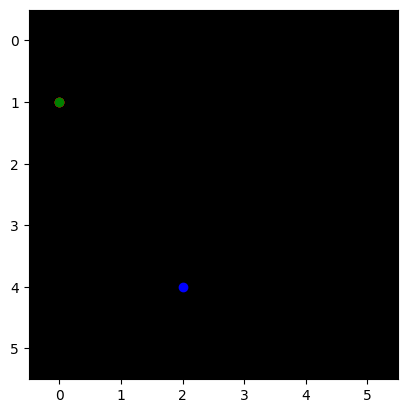

[-0.02971767, -0.042398002]
 gamma 0.8
[0, -1]
[-0.02971767, -0.042398002]
return [-0.03391840159893036, -1.0]
gae [-0.004200730845332144, -0.957601998001337]
0.8947821407247979
tensor([[ 1.,  2., -4., -1.]])
tensor([[ 1.,  2., -4., -1.]])
tensor([[ 2.,  2., -3., -1.]])
tensor([[ 2.,  2., -3., -1.]])
tensor([[ 1.,  2., -4., -1.]])
tensor([[ 1.,  2., -4., -1.]])
tensor([[ 1.,  1., -4., -2.]])
tensor([[ 1.,  1., -4., -2.]])
tensor([[ 0.,  1., -5., -2.]])
tensor([[ 0.,  1., -5., -2.]])


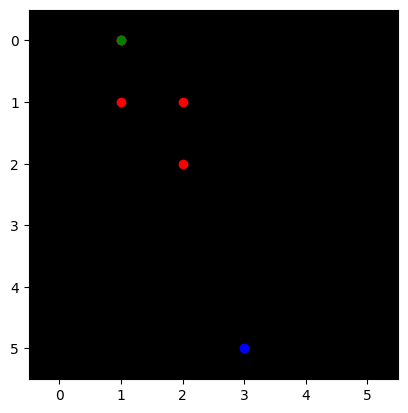

[-0.029324235, -0.029593712, -0.029324235, -0.038096763, -0.05158102]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.029324235, -0.029593712, -0.029324235, -0.038096763, -0.05158102]
return [-0.023674969375133515, -0.023459388315677645, -0.030477410554885866, -0.041264817118644714, -1.0]
gae [0.005649266019463538, 0.006134323403239248, -0.0011531751602888128, -0.003168053925037384, -0.9484189786016941]
0.07876195045806744
tensor([[ 5.,  2.,  4., -1.]])
tensor([[ 4.,  2.,  3., -1.]])
tensor([[ 5.,  2.,  4., -1.]])


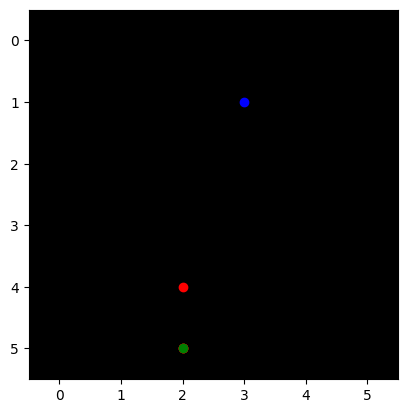

[-0.055951487, -0.05545789, -0.055951487]
 gamma 0.8
[0, 0, -1]
[-0.055951487, -0.05545789, -0.055951487]
return [-0.04436631202697754, -0.044761189818382265, -1.0]
gae [0.011585175246000286, 0.01069670021533966, -0.9440485127270222]
0.7151783115646585
tensor([[ 5.,  3.,  4., -2.]])
tensor([[ 5.,  3.,  4., -2.]])
tensor([[ 5.,  2.,  4., -3.]])
tensor([[ 5.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  3., -3.]])
tensor([[ 4.,  2.,  3., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 3.,  4.,  2., -1.]])
tensor([[ 3.,  4.,  2., -1.]])
tensor([[3., 5., 2., 0.]])
tensor([[3., 5., 2., 0.]])
tensor([[2., 5., 1., 0.]])
tensor([[2., 5., 1., 0.]])


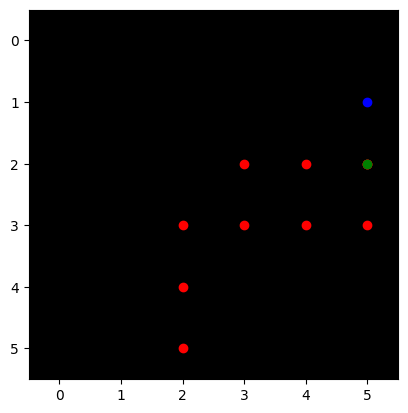

[-0.054543618, -0.057467796, -0.05011922, -0.03879552, -0.03336327, -0.043467183, -0.029418107, -0.023510095, -0.011547507, -0.015647303]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.054543618, -0.057467796, -0.05011922, -0.03879552, -0.03336327, -0.043467183, -0.029418107, -0.023510095, -0.011547507, -0.015647303]
return [-0.04597423672676087, -0.04009537696838379, -0.031036415696144105, -0.026690617203712463, -0.03477374613285065, -0.023534485697746278, -0.018808075785636903, -0.009238005429506303, -0.012517842650413514, -1.0]
gae [0.008569381386041637, 0.01737241894006729, 0.01908280551433563, 0.012104902416467667, -0.0014104746282100691, 0.01993269696831703, 0.010610031336545943, 0.014272089302539825, -0.0009703358635306369, -0.9843526966869831]
return [-0.02016849 -0.02016849 -0.01880808 -0.01620788 -0.01620788 -0.01251784
 -0.0120101  -0.01072009 -0.00923801  1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.05069575

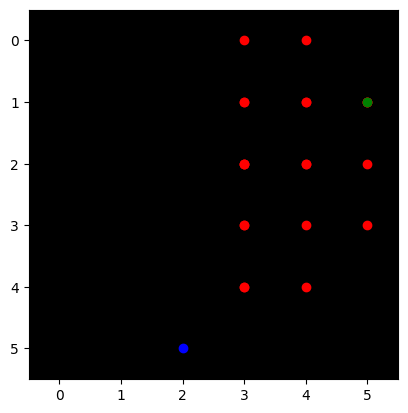

[-0.1171802, -0.10331792, -0.05823774, -0.035063207, -0.036960315, -0.035152294, -0.036960315, -0.035063207, -0.032115184, -0.04166682, -0.08121642, -0.0760714, -0.09702278, -0.10331792, -0.05823774, -0.035063207, -0.032115184, -0.034546733, -0.03647757, -0.034546733, -0.028979024]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.1171802, -0.10331792, -0.05823774, -0.035063207, -0.036960315, -0.035152294, -0.036960315, -0.035063207, -0.032115184, -0.04166682, -0.08121642, -0.0760714, -0.09702278, -0.10331792, -0.05823774, -0.035063207, -0.032115184, -0.034546733, -0.03647757, -0.034546733, -0.028979024]
return [-0.08265433311462403, -0.046590191125869755, -0.028050565719604494, -0.029568251967430115, -0.02812183499336243, -0.029568251967430115, -0.028050565719604494, -0.02569214701652527, -0.03333345651626587, -0.06497313380241394, -0.06085711717605591, -0.07761822342872621, -0.08265433311462403, -0.046590191125869755, -0.028050565719604494, -0.0256921470

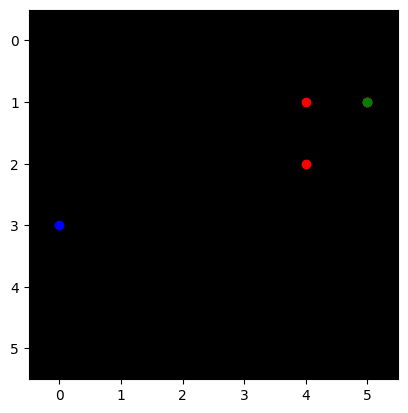

[-0.03721894, -0.058935378, -0.024550704, -0.023933534]
 gamma 0.8
[0, 0, 0, -1]
[-0.03721894, -0.058935378, -0.024550704, -0.023933534]
return [-0.04714830219745636, -0.01964056342840195, -0.01914682686328888, -1.0]
gae [-0.009929362684488297, 0.0392948143184185, 0.005403877422213554, -0.9760664664208889]
0.26778027604209487
tensor([[5., 4., 3., 3.]])
tensor([[5., 5., 3., 4.]])
tensor([[5., 5., 3., 4.]])


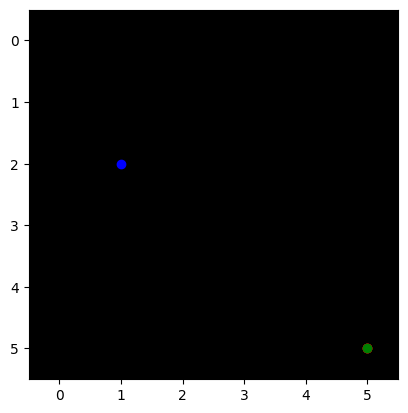

[-0.113638945, -0.104738295]
 gamma 0.8
[0, -1]
[-0.113638945, -0.104738295]
return [-0.08379063606262208, -1.0]
gae [0.02984830886125564, -0.8952617049217224]
0.1567611518916897
tensor([[ 0.,  2., -4.,  2.]])


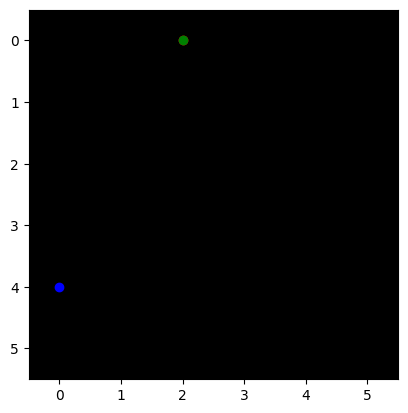

[-0.033823412]
 gamma 0.8
[-1]
[-0.033823412]
return [-1.0]
gae [-0.966176588088274]
0.4815368946806452
tensor([[4., 3., 2., 1.]])
tensor([[3., 3., 1., 1.]])
tensor([[3., 2., 1., 0.]])
tensor([[3., 2., 1., 0.]])
tensor([[3., 3., 1., 1.]])
tensor([[3., 3., 1., 1.]])
tensor([[4., 3., 2., 1.]])
tensor([[4., 3., 2., 1.]])
tensor([[5., 3., 3., 1.]])


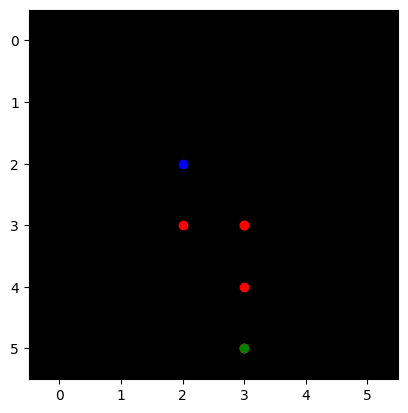

[-0.12500525, -0.09843519, -0.09701628, -0.09843519, -0.12500525, -0.13999362]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.12500525, -0.09843519, -0.09701628, -0.09843519, -0.12500525, -0.13999362]
return [-0.07874815464019776, -0.07761302590370178, -0.07874815464019776, -0.10000419616699219, -0.11199489831924439, -1.0]
gae [0.04625709056854248, 0.02082216739654541, 0.01826812773942947, -0.0015690028667449951, 0.013010346889495844, -0.8600063771009445]
0.8452980566711646
tensor([[ 1.,  0., -2., -2.]])
tensor([[ 1.,  0., -2., -2.]])
tensor([[ 0.,  0., -3., -2.]])
tensor([[ 0.,  0., -3., -2.]])


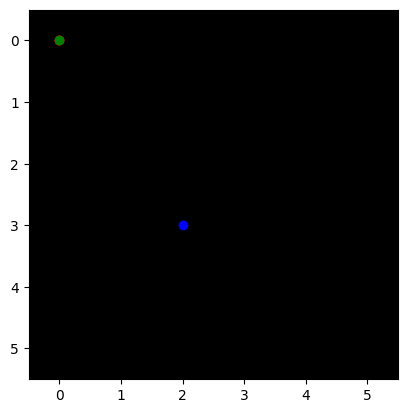

[-0.0187893, -0.008080679]
 gamma 0.8
[0, -1]
[-0.0187893, -0.008080679]
return [-0.0064645431935787204, -1.0]
gae [0.012324757501482963, -0.9919193210080266]
0.42840103728418955
tensor([[ 4.,  2., -1.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 2.,  1., -3.,  1.]])
tensor([[ 2.,  1., -3.,  1.]])
tensor([[ 3.,  1., -2.,  1.]])
tensor([[ 3.,  0., -2.,  0.]])
tensor([[ 3.,  0., -2.,  0.]])


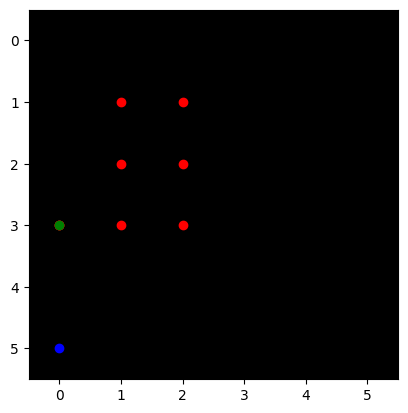

[-0.1020759, -0.061350804, -0.035188165, -0.036827218, -0.02214052, -0.030371323, -0.04802138, -0.021185976]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.1020759, -0.061350804, -0.035188165, -0.036827218, -0.02214052, -0.030371323, -0.04802138, -0.021185976]
return [-0.049080643057823184, -0.02815053164958954, -0.02946177423000336, -0.017712415754795076, -0.024297058582305908, -0.03841710388660431, -0.016948780417442324, -1.0]
gae [0.052995254099369046, 0.033200272172689435, 0.0057263903319835635, 0.01911480203270912, -0.002156538888812065, -0.008045780658721927, 0.031072599440813062, -0.9788140244781971]
0.5826494956941818
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 2.,  4., -1., -1.]])
tensor([[ 2.,  4., -1., -1.]])
tensor([[ 3.,  4.,  0., -1.]])
tensor([[ 3.,  4.,  0., -1.]])
tensor([[ 4.,  4.,  1., -1.]])
tensor([[ 4.,  4.,  1., -1.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])


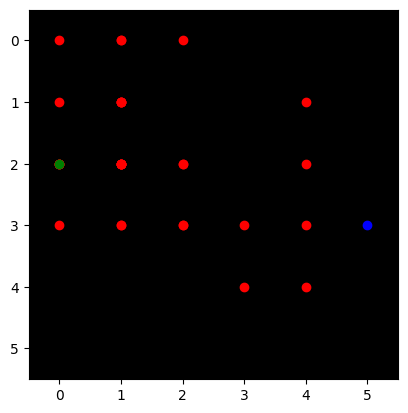

[-0.024459027, -0.036914777, -0.043687813, -0.07363726, -0.12585333, -0.13408923, -0.07457488, -0.04250299, -0.03632867, -0.03444033, -0.030813117, -0.03521159, -0.03427496, -0.014039316, -0.0027643372, -0.014039316, -0.030813117, -0.03444033, -0.030813117, -0.03444033, -0.030813117, -0.03444033, -0.035515103, -0.035776198, -0.03632867, -0.04250299, -0.028929578, -0.03444033, -0.028929578, -0.03444033, -0.035515103]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.024459027, -0.036914777, -0.043687813, -0.07363726, -0.12585333, -0.13408923, -0.07457488, -0.04250299, -0.03632867, -0.03444033, -0.030813117, -0.03521159, -0.03427496, -0.014039316, -0.0027643372, -0.014039316, -0.030813117, -0.03444033, -0.030813117, -0.03444033, -0.030813117, -0.03444033, -0.035515103, -0.035776198, -0.03632867, -0.04250299, -0.028929578, -0.03444033, -0.028929578, -0.03444033, -0.035515103]
return [-0.029531821608543396, -0.034950250387191774, 

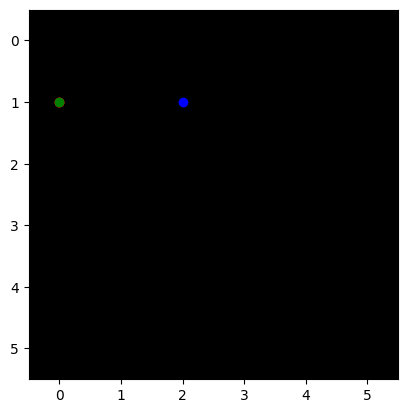

[-0.16137615, -0.15722093]
 gamma 0.8
[0, -1]
[-0.16137615, -0.15722093]
return [-0.12577674388885499, -1.0]
gae [0.035599404573440546, -0.8427790701389313]
0.4156901793378148
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 2.,  1.,  2., -4.]])
tensor([[ 2.,  0.,  2., -5.]])


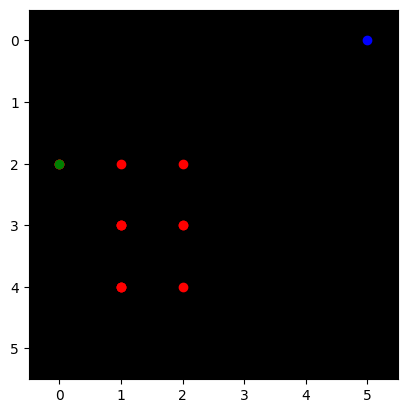

[-0.0989103, -0.106587246, -0.0989103, -0.09138449, -0.10722614, -0.09138449, -0.112369426, -0.106587246, -0.112369426, -0.106587246, -0.112369426, -0.146162, -0.15696415]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.0989103, -0.106587246, -0.0989103, -0.09138449, -0.10722614, -0.09138449, -0.112369426, -0.106587246, -0.112369426, -0.106587246, -0.112369426, -0.146162, -0.15696415]
return [-0.08526979684829712, -0.07912824153900147, -0.0731075942516327, -0.08578091263771058, -0.0731075942516327, -0.08989554047584535, -0.08526979684829712, -0.08989554047584535, -0.08526979684829712, -0.08989554047584535, -0.11692960262298585, -0.12557132244110109, -1.0]
gae [0.01364050507545471, 0.02745900452136993, 0.025802707672119132, 0.005603580176830283, 0.034118546545505515, 0.0014889523386955178, 0.02709962874650955, 0.016691705584526054, 0.02709962874650955, 0.016691705584526054, -0.00456017702817918, 0.020590680837631214, -0.8430358469486237]
0.9871995636486831
tensor([[ 2.,  0.,  0.

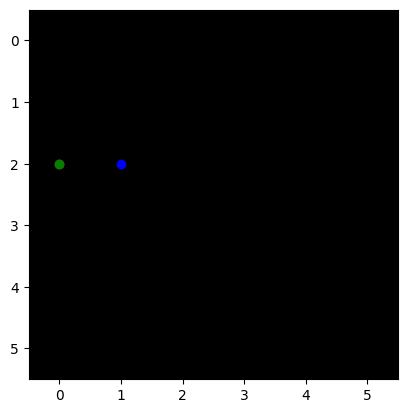

[-0.15953517]
 gamma 0.8
[-1]
[-0.15953517]
return [-1.0]
gae [-0.8404648303985596]
0.5898702117657941
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 1.,  4., -1.,  0.]])


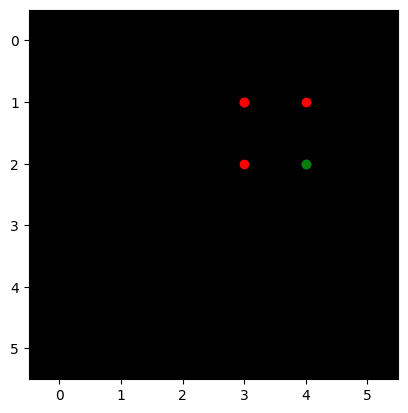

[-0.079640456, -0.122916415, -0.079640456, -0.122916415, -0.072597265]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.079640456, -0.122916415, -0.079640456, -0.122916415, -0.072597265]
return [-0.0983331322669983, -0.06371236443519593, -0.0983331322669983, -0.05807781219482422, 1.0]
gae [-0.0186926767230034, 0.059204050898551935, -0.0186926767230034, 0.06483860313892365, 1.0725972652435303]
0.33074211050699764
tensor([[ 0.,  5., -1.,  1.]])
tensor([[ 0.,  5., -1.,  1.]])


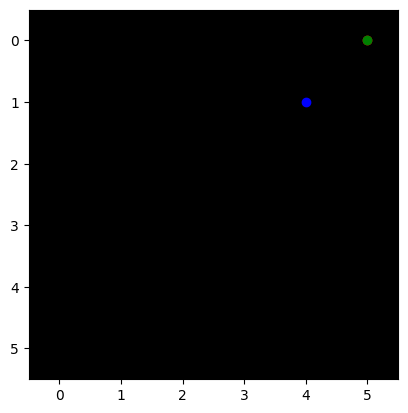

[-0.07199166]
 gamma 0.8
[-1]
[-0.07199166]
return [-1.0]
gae [-0.9280083402991295]
0.9127980077796176
tensor([[ 0.,  5., -5.,  5.]])
tensor([[ 0.,  5., -5.,  5.]])


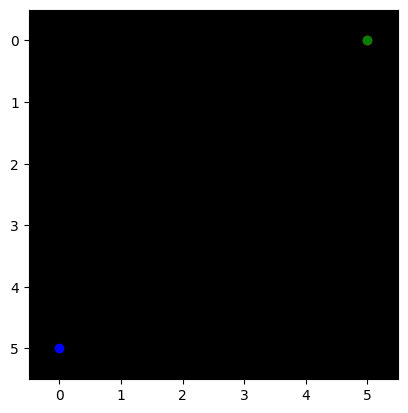

[-0.073758736]
 gamma 0.8
[-1]
[-0.073758736]
return [-1.0]
gae [-0.9262412637472153]
0.34351052816925576
tensor([[ 0.,  1., -4., -4.]])


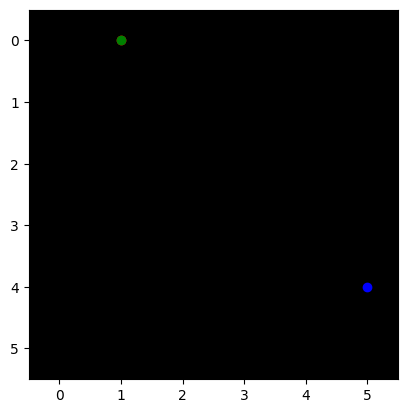

[-0.16220348]
 gamma 0.8
[-1]
[-0.16220348]
return [-1.0]
gae [-0.8377965241670609]
0.7874525391672876
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 0.,  4., -3.,  0.]])


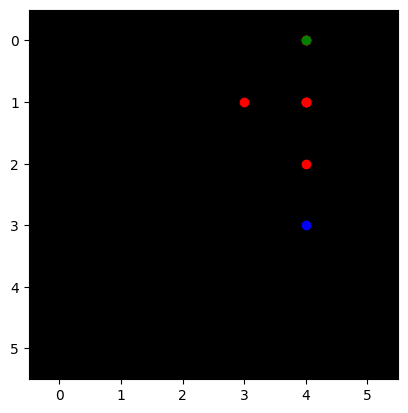

[-0.10055708, -0.075334124, -0.12040975, -0.075334124, -0.06967536, -0.075334124, -0.10055708]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.10055708, -0.075334124, -0.12040975, -0.075334124, -0.06967536, -0.075334124, -0.10055708]
return [-0.06026729941368103, -0.09632779955863953, -0.06026729941368103, -0.05574029088020325, -0.06026729941368103, -0.0804456651210785, -1.0]
gae [0.040289781987667084, -0.02099367529153824, 0.06014245003461838, 0.01959383338689804, 0.009408064186573029, -0.005111540853977206, -0.8994429185986519]
0.9912358184697204
tensor([[ 2.,  0., -2., -1.]])
tensor([[ 2.,  0., -2., -1.]])


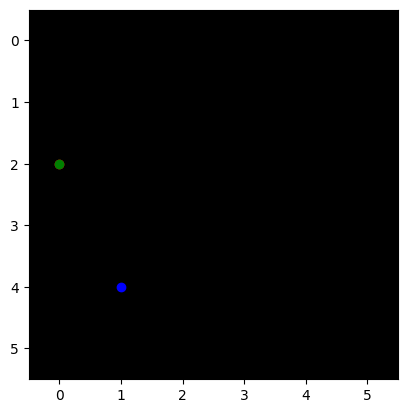

[-0.15767415]
 gamma 0.8
[-1]
[-0.15767415]
return [-1.0]
gae [-0.8423258513212204]
0.5952970361611328
tensor([[4., 5., 2., 5.]])
tensor([[4., 5., 2., 5.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 5., 2., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[3., 4., 1., 4.]])
tensor([[4., 4., 2., 4.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 4., 1., 4.]])
tensor([[3., 5., 1., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[4., 5., 2., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[2., 5., 0., 5.]])
tensor([[2., 5., 0., 5.]])


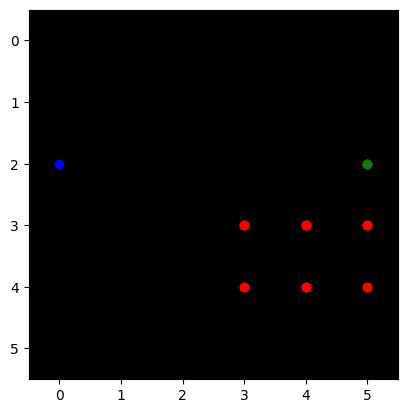

[-0.0802496, -0.07845987, -0.07311691, -0.08309127, -0.07311691, -0.07845987, -0.0802496, -0.06777319, -0.07744288, -0.07845987, -0.07744288, -0.08309127, -0.07744288, -0.08309127, -0.07744288, -0.06777319, -0.0802496, -0.06777319, -0.067626186]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.0802496, -0.07845987, -0.07311691, -0.08309127, -0.07311691, -0.07845987, -0.0802496, -0.06777319, -0.07744288, -0.07845987, -0.07744288, -0.08309127, -0.07744288, -0.08309127, -0.07744288, -0.06777319, -0.0802496, -0.06777319, -0.067626186]
return [-0.062767893075943, -0.058493530750274664, -0.06647301316261292, -0.058493530750274664, -0.062767893075943, -0.06419968008995057, -0.05421855449676514, -0.06195430159568787, -0.062767893075943, -0.06195430159568787, -0.06647301316261292, -0.06195430159568787, -0.06647301316261292, -0.06195430159568787, -0.05421855449676514, -0.06419968008995057, -0.05421855449676514, -0.054100948572158816, -1.0]
gae [0.01748170703649521, 0.019

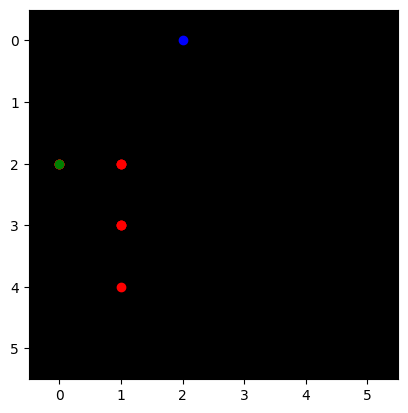

[0.09568964, 0.08256965, 0.08170385, 0.08256965, 0.09725312, 0.09923325, 0.09725312, 0.08256965, 0.09725312, 0.09923325]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.09568964, 0.08256965, 0.08170385, 0.08256965, 0.09725312, 0.09923325, 0.09725312, 0.08256965, 0.09725312, 0.09923325]
return [0.06605572104454041, 0.0653630793094635, 0.06605572104454041, 0.0778024971485138, 0.0793865978717804, 0.0778024971485138, 0.06605572104454041, 0.0778024971485138, 0.0793865978717804, -1.0]
gae [-0.029633918404579157, -0.017206571996212006, -0.015648128092288965, -0.00476715415716171, -0.01786652356386184, -0.021430750191211698, -0.03119740039110183, -0.00476715415716171, -0.01786652356386184, -1.0992332473397255]
0.47344708774846733
tensor([[ 0.,  0., -5., -5.]])
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 1.,  0., -4., -5.]])


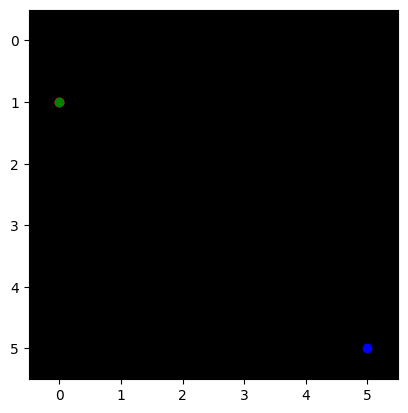

[0.101859964, 0.10924746]
 gamma 0.8
[0, -1]
[0.101859964, 0.10924746]
return [0.08739796876907349, -1.0]
gae [-0.014461995661258692, -1.1092474609613419]
0.2726669937719868
tensor([[ 0.,  4., -2.,  4.]])
tensor([[ 0.,  4., -2.,  4.]])


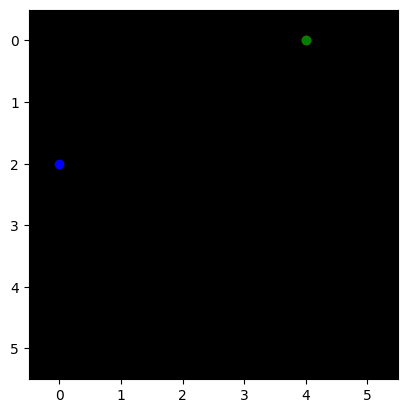

[0.15888962]
 gamma 0.8
[-1]
[0.15888962]
return [-1.0]
gae [-1.1588896214962006]
0.8733077548991814
tensor([[5., 5., 2., 5.]])
tensor([[5., 5., 2., 5.]])


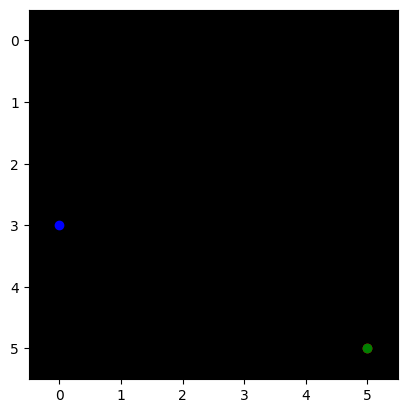

[0.10989929]
 gamma 0.8
[-1]
[0.10989929]
return [-1.0]
gae [-1.109899289906025]
0.22754820308764712
tensor([[ 0.,  3., -5.,  2.]])


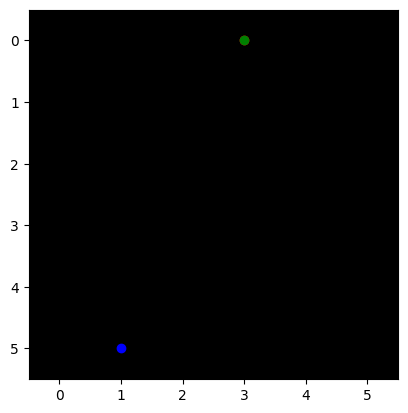

[0.14348982]
 gamma 0.8
[-1]
[0.14348982]
return [-1.0]
gae [-1.1434898227453232]
0.7426542232604179
tensor([[0., 5., 0., 1.]])
tensor([[0., 5., 0., 1.]])


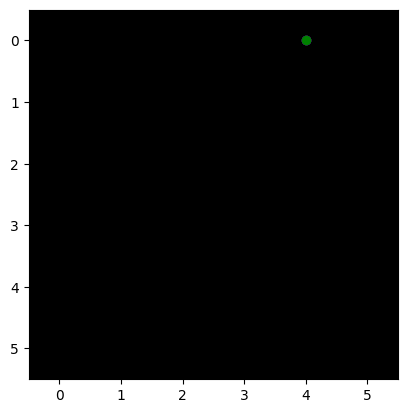

[0.15941983]
 gamma 0.8
[1]
[0.15941983]
return [1.0]
gae [0.8405801653862]
0.38971382011120703
tensor([[ 5.,  0.,  5., -3.]])
tensor([[ 4.,  0.,  4., -3.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 4.,  0.,  4., -3.]])
tensor([[ 5.,  0.,  5., -3.]])
tensor([[ 4.,  0.,  4., -3.]])
tensor([[ 5.,  0.,  5., -3.]])
tensor([[ 5.,  0.,  5., -3.]])


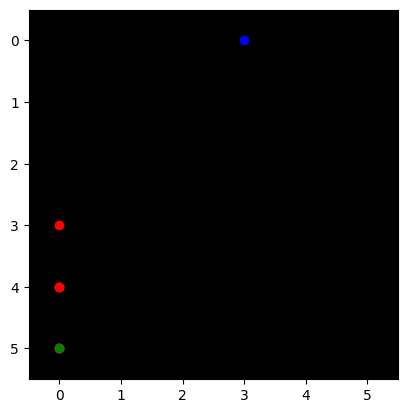

[0.071306475, 0.07761468, 0.09113688, 0.07761468, 0.071306475, 0.07761468, 0.071306475]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.071306475, 0.07761468, 0.09113688, 0.07761468, 0.071306475, 0.07761468, 0.071306475]
return [0.062091743946075445, 0.07290950417518616, 0.062091743946075445, 0.05704517960548401, 0.062091743946075445, 0.05704517960548401, -1.0]
gae [-0.009214730560779566, -0.004705175757408142, -0.02904513627290725, -0.020569500327110288, -0.009214730560779566, -0.020569500327110288, -1.071306474506855]
0.4442202642602494
tensor([[5., 4., 3., 3.]])
tensor([[5., 4., 3., 3.]])
tensor([[5., 3., 3., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 2., 2., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[2., 2., 0., 1.]])
tensor([[2., 2., 0., 1.]])


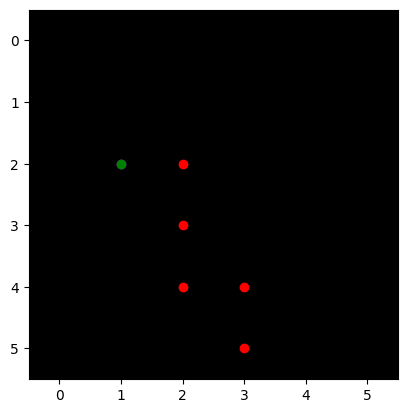

[0.11278176, 0.111783035, 0.11215482, 0.10039406, 0.107176326, 0.13329056]
 gamma 0.8
[0, 0, 0, 0, 0, 1]
[0.11278176, 0.111783035, 0.11215482, 0.10039406, 0.107176326, 0.13329056]
return [0.0894264280796051, 0.0897238552570343, 0.08031525015830994, 0.08574106097221375, 0.10663244724273682, 1.0]
gae [-0.023355334997177124, -0.022059179842472076, -0.03183956891298294, -0.014653001725673673, -0.0005438789725303594, 0.866709440946579]
0.8207788923024331
tensor([[ 3.,  2., -2.,  1.]])
tensor([[ 3.,  2., -2.,  1.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 3.,  3., -2.,  2.]])
tensor([[ 3.,  4., -2.,  3.]])
tensor([[ 3.,  4., -2.,  3.]])
tensor([[ 2.,  4., -3.,  3.]])
tensor([[ 2.,  5., -3.,  4.]])
tensor([[ 2.,  5., -3.,  4.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 0.,  5., -5.,  4.]])
tensor([[ 0.,  5., -5.,  4.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  5., -5.,  4.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 1.,  5., 

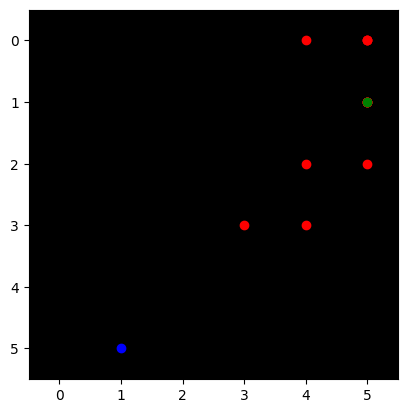

[0.15288408, 0.14491357, 0.13146538, 0.15732913, 0.15132457, 0.15759338, 0.15595527, 0.15389305, 0.15595527, 0.15759338, 0.15595527, 0.15759338]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.15288408, 0.14491357, 0.13146538, 0.15732913, 0.15132457, 0.15759338, 0.15595527, 0.15389305, 0.15595527, 0.15759338, 0.15595527, 0.15759338]
return [0.11593085527420044, 0.10517230033874513, 0.12586330175399782, 0.12105965614318848, 0.12607470750808716, 0.12476421594619752, 0.12311444282531739, 0.12476421594619752, 0.12607470750808716, 0.12476421594619752, 0.12607470750808716, -1.0]
gae [-0.03695322573184967, -0.039741268754005424, -0.005602073669433577, -0.03626947104930878, -0.025249862670898432, -0.03282916843891143, -0.0328408271074295, -0.029128837585449208, -0.029880562424659723, -0.03282916843891143, -0.029880562424659723, -1.157593384385109]
0.6252011100958171
tensor([[3., 5., 2., 1.]])
tensor([[4., 5., 3., 1.]])
tensor([[3., 5., 2., 1.]])
tensor([[3., 5., 2., 1.]])


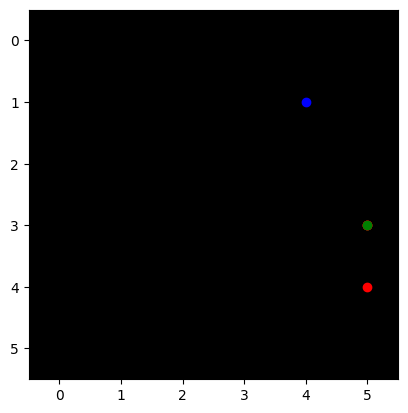

[0.10529684, 0.10892301, 0.10529684]
 gamma 0.8
[0, 0, -1]
[0.10529684, 0.10892301, 0.10529684]
return [0.0871384084224701, 0.08423747420310974, -1.0]
gae [-0.018158434331417075, -0.024685536324977872, -1.1052968427538872]
0.6024732121866815
tensor([[ 2.,  3., -3., -2.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  5., -2.,  0.]])
tensor([[ 3.,  5., -2.,  0.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  3., -2., -2.]])
tensor([[ 3.,  3., -2., -2.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 3.,  3., -2., -2.]])
tensor([[ 3.,  3., -2., -2.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  5., -2.,  0.]])
tensor([[ 2.,  5., -3.,  0.]])
tensor([[ 2.,  5., -3.,  0.]])


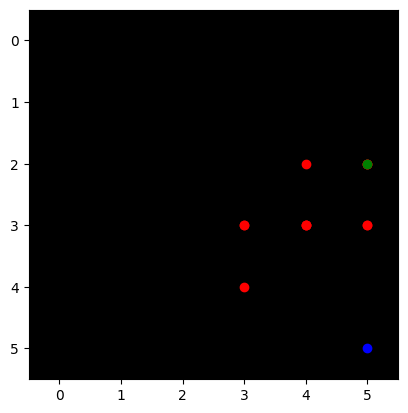

[0.13525848, 0.15632345, 0.1352458, 0.13326287, 0.1352458, 0.13313206, 0.10552487, 0.13313206, 0.1352458, 0.13326287, 0.15390924]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.13525848, 0.15632345, 0.1352458, 0.13326287, 0.1352458, 0.13313206, 0.10552487, 0.13313206, 0.1352458, 0.13326287, 0.15390924]
return [0.1250587582588196, 0.10819664001464845, 0.10661029815673828, 0.10819664001464845, 0.10650564432144166, 0.08441989421844483, 0.10650564432144166, 0.10819664001464845, 0.10661029815673828, 0.1231273889541626, -1.0]
gae [-0.010199722647666914, -0.04812680780887603, -0.028635501861572266, -0.025066232681274406, -0.028740155696868885, -0.048712161183357236, 0.0009807765483856312, -0.024935415387153617, -0.028635501861572266, -0.010135483741760251, -1.1539092361927032]
return [0.12476422 0.12476422 0.12476422 0.12505876 0.1258633  0.1260747
 0.1260747  0.1260747  1.         1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -

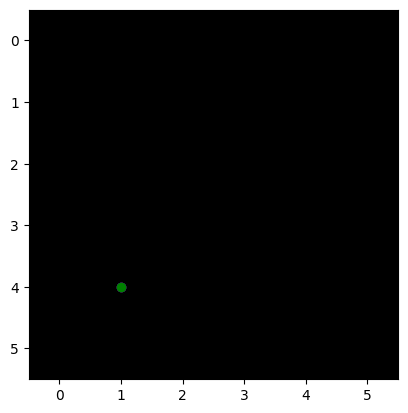

[0.09567845]
 gamma 0.8
[1]
[0.09567845]
return [1.0]
gae [0.904321551322937]
0.8361485214900958
tensor([[ 0.,  1., -1., -1.]])
tensor([[ 1.,  1.,  0., -1.]])
tensor([[ 1.,  1.,  0., -1.]])


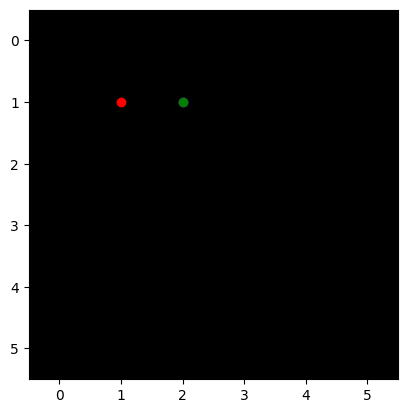

[0.108276926, 0.09767718]
 gamma 0.8
[0, 1]
[0.108276926, 0.09767718]
return [0.07814174294471742, 1.0]
gae [-0.030135183036327354, 0.9023228213191032]
0.23923397972210203
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  1.,  0., -3.]])
tensor([[ 1.,  1.,  1., -3.]])
tensor([[ 0.,  1.,  0., -3.]])


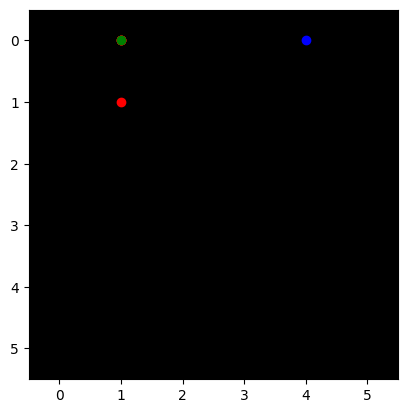

[0.10215976, 0.09607868, 0.09222257, 0.09607868]
 gamma 0.8
[0, 0, 0, -1]
[0.10215976, 0.09607868, 0.09222257, 0.09607868]
return [0.07686294317245485, 0.07377805709838868, 0.07686294317245485, -1.0]
gae [-0.02529681771993636, -0.022300621867179862, -0.015359628200530995, -1.0960786789655685]
0.5479198974413557
tensor([[ 4.,  3.,  1., -1.]])
tensor([[ 4.,  3.,  1., -1.]])
tensor([[4., 4., 1., 0.]])
tensor([[4., 4., 1., 0.]])


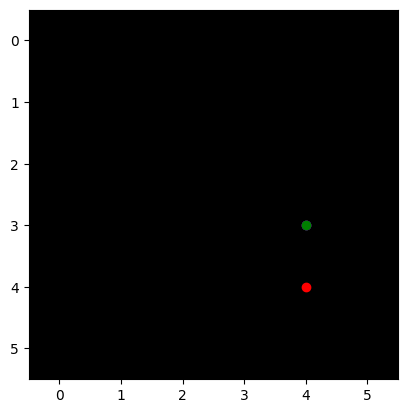

[0.09209046, 0.12022763]
 gamma 0.8
[0, 1]
[0.09209046, 0.12022763]
return [0.09618210196495057, 1.0]
gae [0.004091644287109383, 0.8797723725438118]
0.6808581709792992
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 0.,  4., -4., -1.]])
tensor([[ 0.,  4., -4., -1.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 1.,  5., -3.,  0.]])
tensor([[ 1.,  5., -3.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 1.,  5., -3.,  0.]])
tensor([[ 2.,  5., -2.,  0.]])
tensor([[ 2.,  5., -2.,  0.]])
tensor([[ 3.,  5., -1.,  0.]])


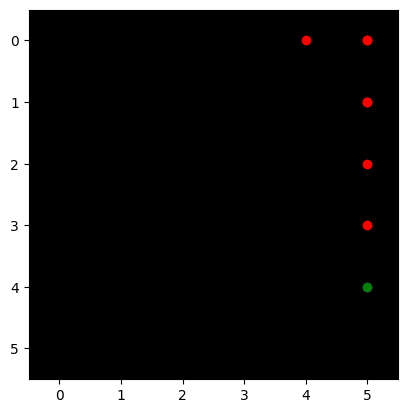

[0.1661207, 0.15559672, 0.1661207, 0.16692792, 0.1661207, 0.16692792, 0.1585315, 0.13176465]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 1]
[0.1661207, 0.15559672, 0.1661207, 0.16692792, 0.1661207, 0.16692792, 0.1585315, 0.13176465]
return [0.12447737455368042, 0.13289655447006227, 0.13354233503341675, 0.13289655447006227, 0.13354233503341675, 0.12682520151138307, 0.10541172027587892, 1.0]
gae [-0.0416433185338974, -0.022700163722038258, -0.032578358054161066, -0.03403136432170867, -0.032578358054161066, -0.04010271728038786, -0.0531197816133499, 0.8682353496551514]
0.37559301052829985
tensor([[ 5.,  4.,  1., -1.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 5.,  3.,  1., -2.]])
tensor([[ 5.,  4.,  1., -1.]])
tensor([[ 5.,  4.,  1., -1.]])


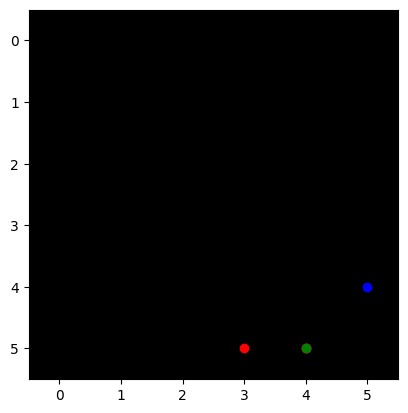

[0.11226439, 0.0867233, 0.11226439]
 gamma 0.8
[0, 0, -1]
[0.11226439, 0.0867233, 0.11226439]
return [0.0693786382675171, 0.089811509847641, -1.0]
gae [-0.04288574904203414, 0.0030882120132446345, -1.1122643873095512]
0.4977865018053814
tensor([[ 1.,  5., -4.,  3.]])
tensor([[ 1.,  5., -4.,  3.]])
tensor([[ 1.,  4., -4.,  2.]])
tensor([[ 0.,  4., -5.,  2.]])
tensor([[ 1.,  4., -4.,  2.]])
tensor([[ 1.,  4., -4.,  2.]])
tensor([[ 2.,  4., -3.,  2.]])
tensor([[ 2.,  4., -3.,  2.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 1.,  3., -4.,  1.]])
tensor([[ 0.,  3., -5.,  1.]])


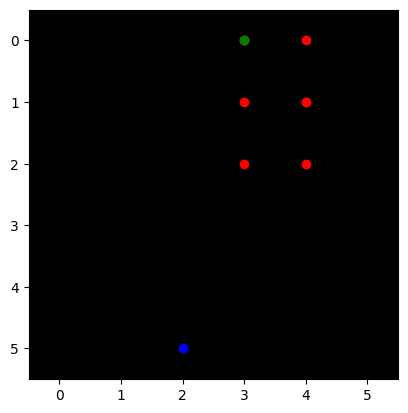

[0.16577092, 0.16661198, 0.16539277, 0.16661198, 0.16449155, 0.16564779, 0.16385244, 0.15949123]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.16577092, 0.16661198, 0.16539277, 0.16661198, 0.16449155, 0.16564779, 0.16385244, 0.15949123]
return [0.1332895874977112, 0.1323142170906067, 0.1332895874977112, 0.13159323930740358, 0.1325182318687439, 0.13108195066452027, 0.12759298086166382, -1.0]
gae [-0.03248133063316344, -0.034297767281532276, -0.03210318386554717, -0.0350187450647354, -0.03197331726551056, -0.034565839171409596, -0.03625945746898651, -1.1594912260770798]
0.8606039510765798
tensor([[5., 3., 2., 2.]])


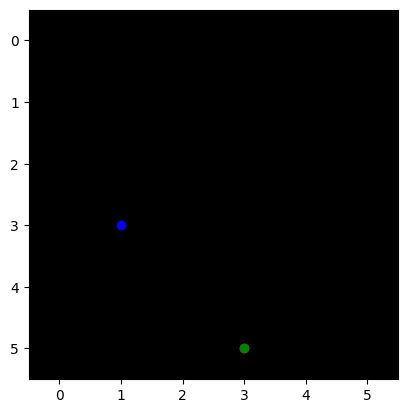

[0.11831041]
 gamma 0.8
[-1]
[0.11831041]
return [-1.0]
gae [-1.1183104068040848]
0.7437660170650062
tensor([[ 0.,  5., -3.,  2.]])
tensor([[ 0.,  5., -3.,  2.]])


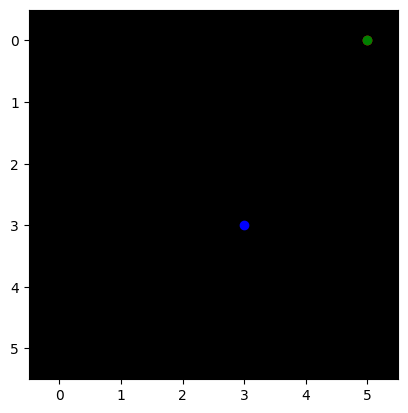

[0.16720869]
 gamma 0.8
[-1]
[0.16720869]
return [-1.0]
gae [-1.1672086864709854]
0.4520245244762576
tensor([[ 3.,  0., -1., -3.]])
tensor([[ 3.,  0., -1., -3.]])
tensor([[ 2.,  0., -2., -3.]])
tensor([[ 1.,  0., -3., -3.]])
tensor([[ 1.,  0., -3., -3.]])


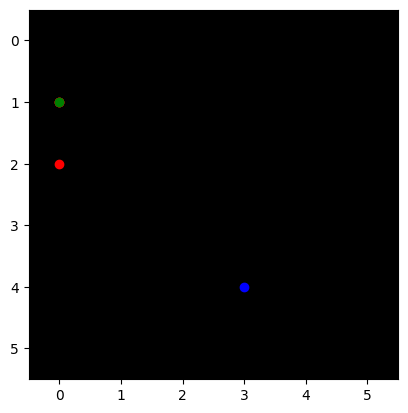

[0.09094676, 0.09299496, 0.097875245]
 gamma 0.8
[0, 0, -1]
[0.09094676, 0.09299496, 0.097875245]
return [0.07439596652984619, 0.07830019593238831, -1.0]
gae [-0.016550789773464206, -0.01469476222991943, -1.0978752449154854]
0.345804725096893
tensor([[ 4.,  0.,  1., -4.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 5.,  1.,  2., -3.]])
tensor([[ 5.,  1.,  2., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 5.,  1.,  2., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  0.,  1., -4.]])
tensor([[ 5.,  0.,  2., -4.]])
tensor([[ 5.,  0.,  2., -4.]])


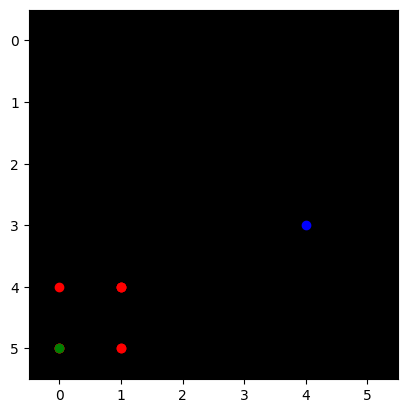

[0.08869206, 0.07960316, 0.07493629, 0.07960316, 0.07493629, 0.07960316, 0.08869206, 0.078293115]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.08869206, 0.07960316, 0.07493629, 0.07960316, 0.07493629, 0.07960316, 0.08869206, 0.078293115]
return [0.06368252635002136, 0.059949034452438356, 0.06368252635002136, 0.059949034452438356, 0.06368252635002136, 0.07095364928245544, 0.0626344919204712, -1.0]
gae [-0.025009535253047943, -0.019654123485088347, -0.01125376671552658, -0.019654123485088347, -0.01125376671552658, -0.008649508655071261, -0.026057569682598106, -1.078293114900589]
0.948322219665226
tensor([[ 5.,  0.,  1., -1.]])
tensor([[ 5.,  0.,  1., -1.]])
tensor([[5., 1., 1., 0.]])
tensor([[5., 1., 1., 0.]])


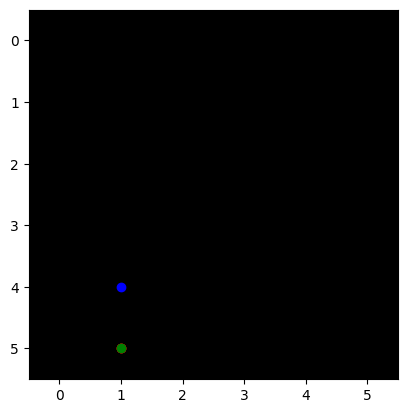

[0.074153565, 0.0814828]
 gamma 0.8
[0, -1]
[0.074153565, 0.0814828]
return [0.0651862382888794, -1.0]
gae [-0.008967326581478113, -1.0814827978610992]
0.2785765335330931
tensor([[ 0.,  4., -4.,  1.]])
tensor([[ 0.,  3., -4.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  2., -3., -1.]])
tensor([[ 1.,  2., -3., -1.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  2., -3., -1.]])
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 2.,  1., -2., -2.]])
tensor([[ 2.,  0., -2., -3.]])


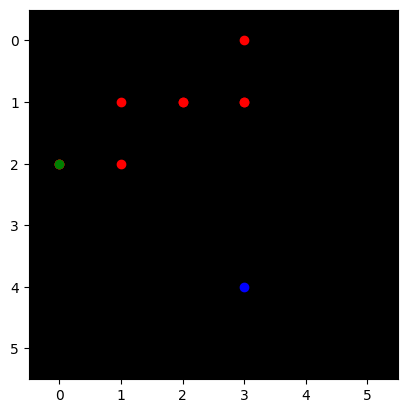

[0.16519654, 0.15241227, 0.15650001, 0.124735534, 0.15650001, 0.124735534, 0.104710646, 0.09568617, 0.09299496]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.16519654, 0.15241227, 0.15650001, 0.124735534, 0.15650001, 0.124735534, 0.104710646, 0.09568617, 0.09299496]
return [0.12192981243133545, 0.1252000093460083, 0.09978842735290527, 0.1252000093460083, 0.09978842735290527, 0.08376851677894592, 0.07654893398284912, 0.07439596652984619, -1.0]
gae [-0.04326672554016113, -0.027212256193161005, -0.0567115843296051, 0.00046447515487671454, -0.0567115843296051, -0.04096701741218567, -0.028161711990833282, -0.021290200948715213, -1.0929949581623077]
return [0.13289656 0.13289656 0.13328959 0.13328959 0.13354233 0.13354233
 1.         1.         1.         1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.          0.05994903]

-------------------- Iteration #41 --------------------
random  0.2785765335330931
Average : 0.01
Average Ep

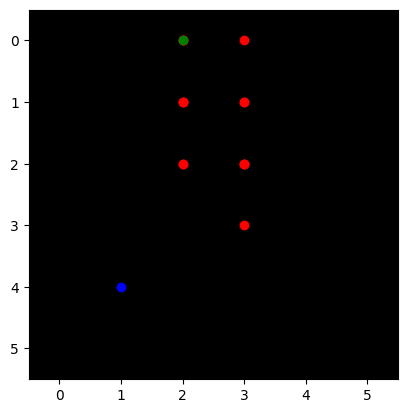

[0.16812555, 0.15401681, 0.1691384, 0.15401681, 0.15861452, 0.15401681, 0.1691384, 0.17395902, 0.16812555, 0.17395902, 0.16812555, 0.17395902, 0.1742266, 0.17152874, 0.1742266]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.16812555, 0.15401681, 0.1691384, 0.15401681, 0.15861452, 0.15401681, 0.1691384, 0.17395902, 0.16812555, 0.17395902, 0.16812555, 0.17395902, 0.1742266, 0.17152874, 0.1742266]
return [0.12321344614028931, 0.1353107213973999, 0.12321344614028931, 0.1268916130065918, 0.12321344614028931, 0.1353107213973999, 0.1391672134399414, 0.1345004439353943, 0.1391672134399414, 0.1345004439353943, 0.1391672134399414, 0.13938127756118776, 0.13722299337387087, 0.13938127756118776, -1.0]
gae [-0.04491210877895355, -0.01870608627796172, -0.045924955606460566, -0.027125194668769836, -0.035401070117950434, -0.01870608627796172, -0.029971188306808477, -0.03945857286453247, -0.028958341479301458, -0.03945857286453247, -0.028958341479301458, -0.034577739238739, -0.037003603577

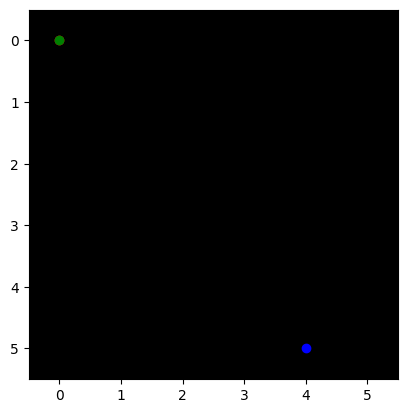

[0.16043773]
 gamma 0.8
[-1]
[0.16043773]
return [-1.0]
gae [-1.1604377329349518]
0.6173310918406483
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 3.,  0.,  1., -1.]])


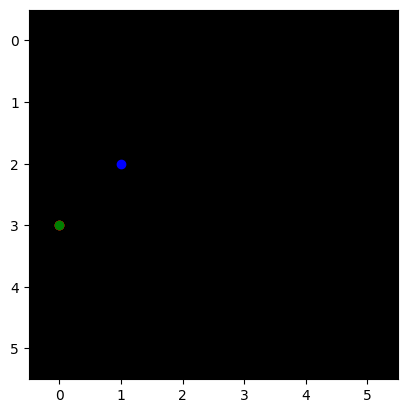

[0.15587088, 0.15349907]
 gamma 0.8
[0, -1]
[0.15587088, 0.15349907]
return [0.12279925346374512, -1.0]
gae [-0.033071631193161005, -1.1534990668296814]
0.5058307050908671
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 5.,  1.,  2., -1.]])
tensor([[ 5.,  1.,  2., -1.]])
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 4.,  1.,  1., -1.]])
tensor([[ 5.,  1.,  2., -1.]])
tensor([[ 5.,  1.,  2., -1.]])


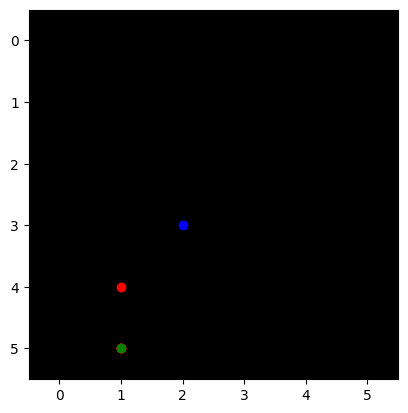

[0.14637183, 0.14650394, 0.14637183, 0.14650394]
 gamma 0.8
[0, 0, 0, -1]
[0.14637183, 0.14650394, 0.14637183, 0.14650394]
return [0.11720315217971802, 0.1170974612236023, 0.11720315217971802, -1.0]
gae [-0.029168674349784846, -0.02940647900104522, -0.029168674349784846, -1.1465039402246475]
0.5986395379168805
tensor([[ 1.,  5., -1.,  2.]])
tensor([[ 1.,  5., -1.,  2.]])
tensor([[ 0.,  5., -2.,  2.]])
tensor([[ 0.,  5., -2.,  2.]])


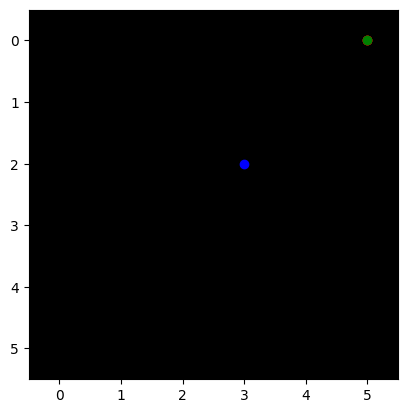

[0.1450079, 0.15965231]
 gamma 0.8
[0, -1]
[0.1450079, 0.15965231]
return [0.1277218461036682, -1.0]
gae [-0.017286047339439392, -1.1596523076295853]
0.9468602479523901
tensor([[5., 4., 3., 3.]])
tensor([[5., 4., 3., 3.]])
tensor([[4., 4., 2., 3.]])
tensor([[4., 4., 2., 3.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 4., 1., 3.]])
tensor([[3., 4., 1., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 2., 0., 1.]])
tensor([[2., 2., 0., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 1., 1., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[ 4.,  0.,  2., -1.]])
tensor([[ 4.,  0.,  2., -1.]])
tensor([[4., 

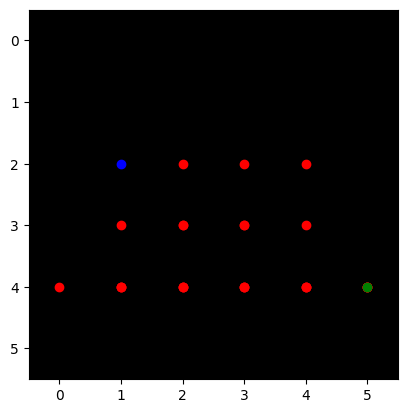

[0.1650816, 0.16527283, 0.16318357, 0.16483545, 0.15415008, 0.15337318, 0.16318357, 0.16483545, 0.16064635, 0.15557456, 0.15234274, 0.14677617, 0.15415008, 0.14045252, 0.14651306, 0.14516753, 0.14651306, 0.15337318, 0.14651306, 0.15337318, 0.16318357, 0.16527283, 0.16146001, 0.16527283, 0.16146001]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.1650816, 0.16527283, 0.16318357, 0.16483545, 0.15415008, 0.15337318, 0.16318357, 0.16483545, 0.16064635, 0.15557456, 0.15234274, 0.14677617, 0.15415008, 0.14045252, 0.14651306, 0.14516753, 0.14651306, 0.15337318, 0.14651306, 0.15337318, 0.16318357, 0.16527283, 0.16146001, 0.16527283, 0.16146001]
return [0.13221826553344726, 0.1305468559265137, 0.1318683624267578, 0.12332006692886353, 0.12269854545593262, 0.1305468559265137, 0.1318683624267578, 0.12851707935333254, 0.12445964813232423, 0.12187418937683106, 0.11742093563079835, 0.12332006692886353, 0.11236201524734497, 0.11721044778823853, 0.116134023666

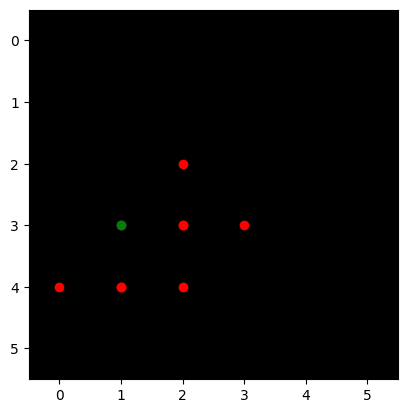

[0.14974661, 0.16338828, 0.15763429, 0.15393521, 0.15763429, 0.15567276, 0.14663914, 0.14624931, 0.14663914]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.14974661, 0.16338828, 0.15763429, 0.15393521, 0.15763429, 0.15567276, 0.14663914, 0.14624931, 0.14663914]
return [0.13071062564849853, 0.12610743045806885, 0.12314816713333131, 0.12610743045806885, 0.12453820705413819, 0.11731131076812745, 0.11699944734573364, 0.11731131076812745, 1.0]
gae [-0.01903598606586457, -0.037280851602554316, -0.03448612093925475, -0.02782777845859527, -0.03309608101844787, -0.03836144804954528, -0.02963969111442566, -0.0289379984140396, 0.8533608615398407]
return [0.13450044 0.13531072 0.13531072 0.13722299 0.13916722 0.13916722
 0.13916722 0.13938127 0.13938127 1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
  0.11236201  0.11613403  0.11699945  0.11709746]

-------------------- Iteration #42 --------------------
random  0.3386105918704394
Average : 0.01
Average Episodic Ret

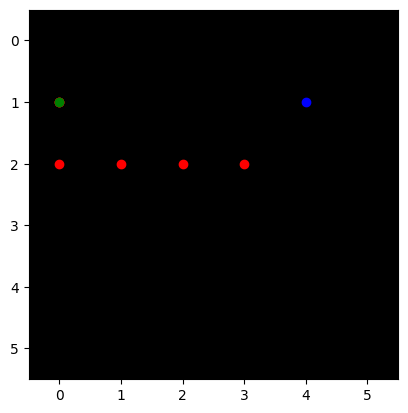

[0.17074987, 0.16672234, 0.17074987, 0.1722067, 0.17274502, 0.1705117]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.17074987, 0.16672234, 0.17074987, 0.1722067, 0.17274502, 0.1705117]
return [0.13337787389755248, 0.13659989833831787, 0.13776535987854005, 0.13819601535797119, 0.1364093542098999, -1.0]
gae [-0.037371999025344854, -0.03012244403362274, -0.03298451304435729, -0.03401068449020386, -0.036335664987564076, -1.1705116927623749]
0.72680890603399
tensor([[ 1.,  5., -4.,  0.]])
tensor([[ 1.,  5., -4.,  0.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 0.,  4., -5., -1.]])


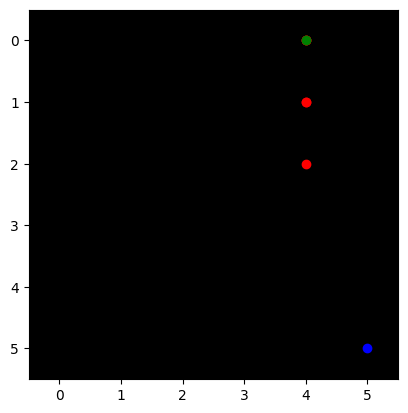

[0.17276867, 0.16593057, 0.1676045, 0.16593057, 0.16172785]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.17276867, 0.16593057, 0.1676045, 0.16593057, 0.16172785]
return [0.1327444553375244, 0.13408360481262208, 0.1327444553375244, 0.12938227653503417, -1.0]
gae [-0.04002421200275422, -0.03184696435928344, -0.03486005067825318, -0.03654829263687134, -1.1617278456687927]
0.4527486937679692
tensor([[ 5.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  3., -1.]])
tensor([[ 4.,  4.,  3., -1.]])
tensor([[ 4.,  3.,  3., -2.]])
tensor([[ 4.,  4.,  3., -1.]])
tensor([[ 5.,  4.,  4., -1.]])
tensor([[ 5.,  4.,  4., -1.]])
tensor([[5., 5., 4., 0.]])


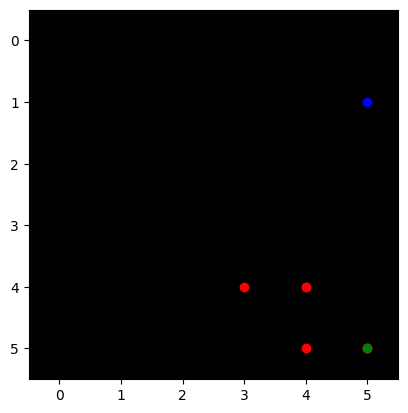

[0.20673598, 0.2011372, 0.17712727, 0.2011372, 0.20673598, 0.234147]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.20673598, 0.2011372, 0.17712727, 0.2011372, 0.20673598, 0.234147]
return [0.16090975999832155, 0.1417018175125122, 0.16090975999832155, 0.16538878679275515, 0.18731759786605837, -1.0]
gae [-0.04582622349262236, -0.05943538248538971, -0.01621751189231871, -0.03574841320514677, -0.019418385624885542, -1.234146997332573]
0.868393607052644
tensor([[ 0.,  0., -3., -5.]])


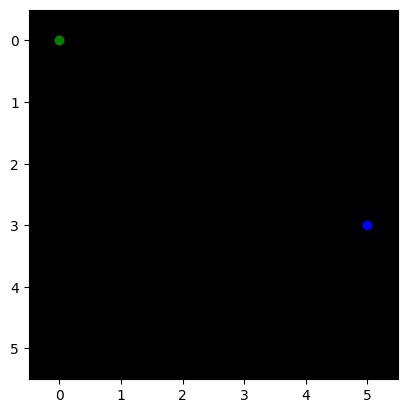

[0.17058074]
 gamma 0.8
[-1]
[0.17058074]
return [-1.0]
gae [-1.1705807447433472]
0.7788741752937408
tensor([[1., 5., 1., 2.]])
tensor([[1., 5., 1., 2.]])
tensor([[0., 5., 0., 2.]])
tensor([[0., 5., 0., 2.]])


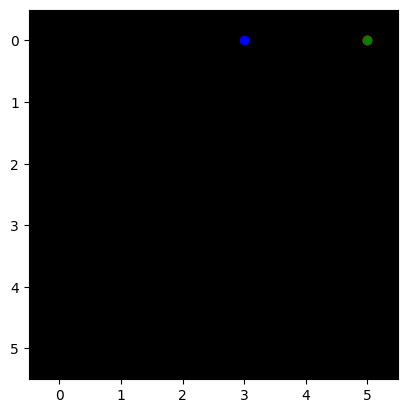

[0.17061463, 0.17397049]
 gamma 0.8
[0, -1]
[0.17061463, 0.17397049]
return [0.1391763925552368, -1.0]
gae [-0.03143823742866517, -1.173970490694046]
0.8386154214097508
tensor([[ 4.,  0., -1., -1.]])
tensor([[ 4.,  0., -1., -1.]])
tensor([[ 5.,  0.,  0., -1.]])
tensor([[ 5.,  0.,  0., -1.]])


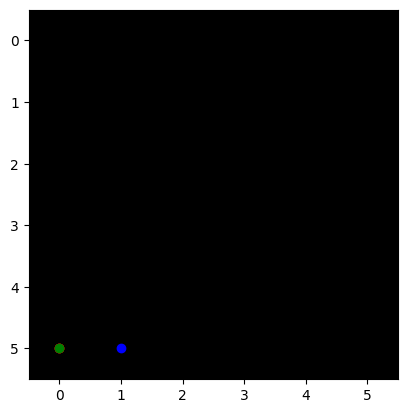

[0.17430834, 0.18665671]
 gamma 0.8
[0, -1]
[0.17430834, 0.18665671]
return [0.14932537078857422, -1.0]
gae [-0.02498297393321991, -1.1866567134857178]
0.6495487542317151
tensor([[ 5.,  0.,  3., -5.]])
tensor([[ 5.,  1.,  3., -4.]])
tensor([[ 5.,  1.,  3., -4.]])
tensor([[ 5.,  0.,  3., -5.]])
tensor([[ 5.,  0.,  3., -5.]])


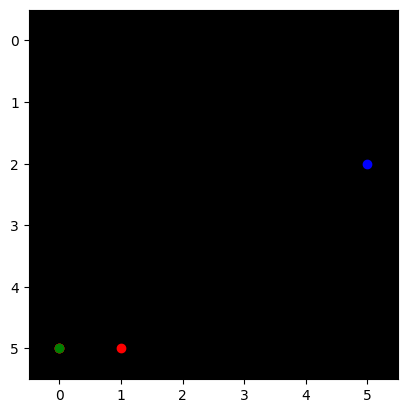

[0.17927417, 0.17761667, 0.17927417]
 gamma 0.8
[0, 0, -1]
[0.17927417, 0.17761667, 0.17927417]
return [0.14209333658218384, 0.14341933727264405, -1.0]
gae [-0.03718083500862121, -0.03419733345508574, -1.179274171590805]
0.965568172920714
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 3.,  0.,  1., -1.]])


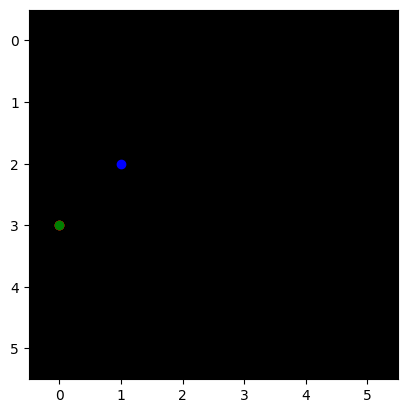

[0.17066954, 0.1769799]
 gamma 0.8
[0, -1]
[0.17066954, 0.1769799]
return [0.14158391952514648, -1.0]
gae [-0.029085621237754822, -1.176979899406433]
0.8526596341858065
tensor([[4., 5., 3., 0.]])
tensor([[4., 5., 3., 0.]])
tensor([[5., 5., 4., 0.]])
tensor([[5., 5., 4., 0.]])
tensor([[ 5.,  4.,  4., -1.]])
tensor([[ 5.,  4.,  4., -1.]])
tensor([[5., 5., 4., 0.]])
tensor([[5., 5., 4., 0.]])
tensor([[4., 5., 3., 0.]])
tensor([[4., 5., 3., 0.]])
tensor([[ 4.,  4.,  3., -1.]])
tensor([[ 4.,  4.,  3., -1.]])
tensor([[ 4.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  3., -2.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 1.,  2.,  0., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 3.,  1.,  2., -4.]])
tensor([[ 3.,  1.,  2., -4.]])
tensor([[ 3.,  0.,  2., -5.]])
tensor([[ 3.,  0.,  2., -5

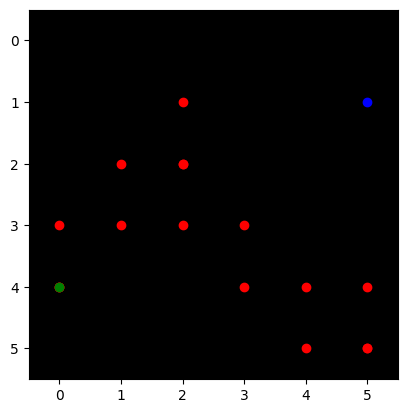

[0.2332956, 0.234147, 0.20673598, 0.234147, 0.2332956, 0.2011372, 0.17712727, 0.17581008, 0.17835316, 0.17170393, 0.17115925, 0.17170393, 0.17236282, 0.17857109, 0.18100844, 0.17780031]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.2332956, 0.234147, 0.20673598, 0.234147, 0.2332956, 0.2011372, 0.17712727, 0.17581008, 0.17835316, 0.17170393, 0.17115925, 0.17170393, 0.17236282, 0.17857109, 0.18100844, 0.17780031]
return [0.18731759786605837, 0.16538878679275515, 0.18731759786605837, 0.186636483669281, 0.16090975999832155, 0.1417018175125122, 0.14064806699752808, 0.14268252849578858, 0.13736314773559571, 0.13692740201950074, 0.13736314773559571, 0.1378902554512024, 0.1428568720817566, 0.14480675458908082, 0.14224025011062622, -1.0]
gae [-0.04597800672054289, -0.06875821053981779, -0.019418385624885542, -0.047510513663291926, -0.07238584458827971, -0.05943538248538971, -0.03647920489311218, -0.033127555251121515, -0.040990012884140004, -0.03477653264999389, -0.03379610478

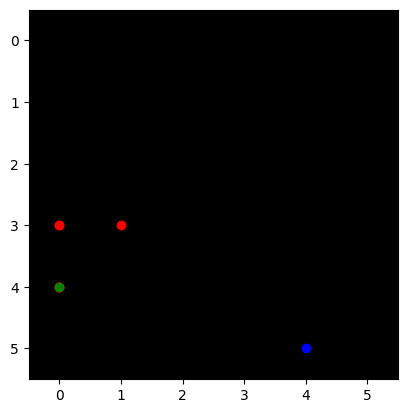

[0.17121181, 0.17009743, 0.1693629, 0.17171808, 0.1693629, 0.17171808]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.17121181, 0.17009743, 0.1693629, 0.17171808, 0.1693629, 0.17171808]
return [0.13607794046401978, 0.1354903221130371, 0.13737446069717407, 0.1354903221130371, 0.13737446069717407, -1.0]
gae [-0.03513386845588684, -0.034607103466987615, -0.031988441944122314, -0.036227753758430487, -0.031988441944122314, -1.1717180758714676]
0.14067040497971006
tensor([[1., 3., 0., 2.]])
tensor([[1., 4., 0., 3.]])
tensor([[1., 4., 0., 3.]])
tensor([[1., 3., 0., 2.]])
tensor([[1., 2., 0., 1.]])


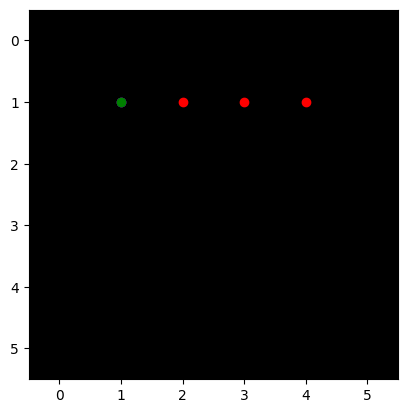

[0.17315489, 0.16842875, 0.17315489, 0.1564858]
 gamma 0.8
[0, 0, 0, 1]
[0.17315489, 0.16842875, 0.17315489, 0.1564858]
return [0.13474299907684326, 0.13852391242980958, 0.12518863677978517, 1.0]
gae [-0.03841189146041871, -0.0299048364162445, -0.04796625375747679, 0.8435142040252686]
return [0.16090976 0.16090976 0.16090976 0.1653888  0.1653888  0.18663648
 0.1873176  0.1873176  0.1873176  1.        ]
return [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

-------------------- Iteration #43 --------------------
random  0.14067040497971006
Average : 0.01
Average Episodic Return: -0.71
Max Episodic Return: 1.0
Average Loss: 0.00155
Average Loss Critic: 0.2398289293050766
TEntropy: nan
approx_kl_divs: [0.00014308291] secs
------------------------------------------------------

0.22533924077243228
tensor([[ 5.,  2.,  3., -2.]])
tensor([[ 5.,  3.,  3., -1.]])


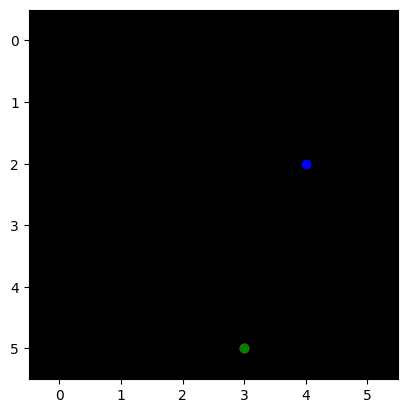

[-0.021710046, -0.0025257638]
 gamma 0.8
[0, -1]
[-0.021710046, -0.0025257638]
return [-0.0020206110551953317, -1.0]
gae [0.019689434580504893, -0.9974742361810058]
0.8843421258612153
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 1.,  0., -3., -2.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 1.,  1., -3., -1.]])
tensor([[ 0.,  1., -4., -1.]])
tensor([[ 0.,  1., -4., -1.]])
tensor([[ 0.,  2., -4.,  0.]])
tensor([[ 0.,  2., -4.,  0.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 1.,  2., -3.,  0.]])
tensor([[ 2.,  2., -2.,  0.]])
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 2.,  5., -2.,  3.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 

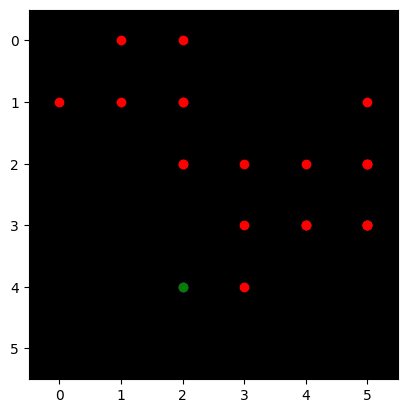

[-0.09039637, -0.10435598, -0.09039637, -0.09120585, -0.081535056, -0.078708455, -0.07997475, -0.078708455, -0.07997475, -0.082184836, -0.06514523, -0.047857758, -0.033121016, -0.030100623, -0.033121016, -0.047857758, -0.08467436, -0.047857758, -0.033121016, -0.030100623, -0.033121016, -0.030100623, -0.039104227, -0.024131753]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.09039637, -0.10435598, -0.09039637, -0.09120585, -0.081535056, -0.078708455, -0.07997475, -0.078708455, -0.07997475, -0.082184836, -0.06514523, -0.047857758, -0.033121016, -0.030100623, -0.033121016, -0.047857758, -0.08467436, -0.047857758, -0.033121016, -0.030100623, -0.033121016, -0.030100623, -0.039104227, -0.024131753]
return [-0.08348478674888611, -0.07231709361076355, -0.07296468019485473, -0.06522804498672485, -0.06296676397323608, -0.06397979855537415, -0.06296676397323608, -0.06397979855537415, -0.06574786901473999, -0.052116185426712036, -0.03828620612621308, -0.0264

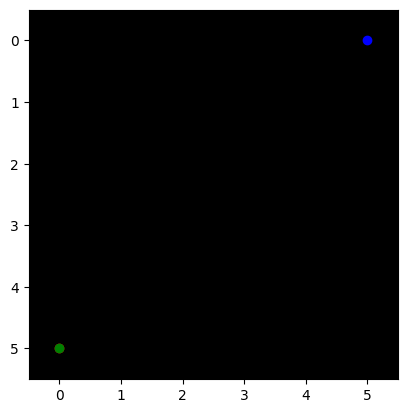

[-0.035716727]
 gamma 0.8
[-1]
[-0.035716727]
return [-1.0]
gae [-0.9642832726240158]
0.9545164909690617
tensor([[ 5.,  2.,  0., -3.]])
tensor([[ 5.,  2.,  0., -3.]])
tensor([[ 4.,  2., -1., -3.]])
tensor([[ 4.,  2., -1., -3.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 5.,  3.,  0., -2.]])
tensor([[ 5.,  3.,  0., -2.]])


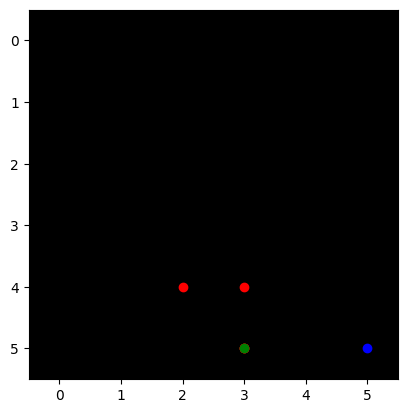

[-0.013438615, -0.046938993, -0.011940724, -0.0007324292]
 gamma 0.8
[0, 0, 0, -1]
[-0.013438615, -0.046938993, -0.011940724, -0.0007324292]
return [-0.03755119442939758, -0.009552579373121262, -0.0005859433673322201, -1.0]
gae [-0.02411257941275835, 0.03738641366362572, 0.011354780849069357, -0.9992675707908347]
0.9423208318389918
tensor([[ 2.,  5., -3.,  0.]])
tensor([[ 2.,  5., -3.,  0.]])


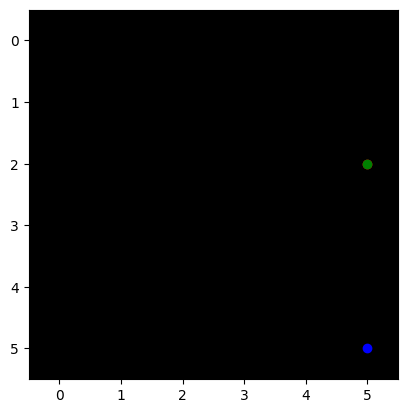

[-0.079953484]
 gamma 0.8
[-1]
[-0.079953484]
return [-1.0]
gae [-0.9200465157628059]
0.9359373543899626
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 4.,  1.,  1., -4.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 5.,  1.,  2., -4.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  2., -2.]])


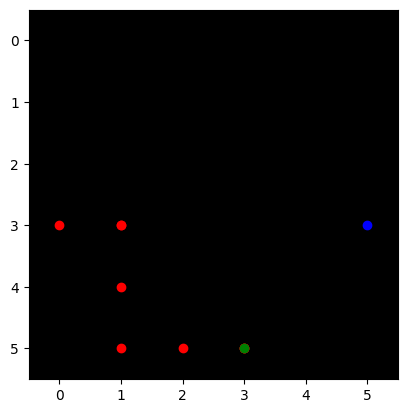

[-0.03945879, -0.07133602, -0.071833044, -0.07133602, -0.03945879, -0.020667039, -0.017503746, -0.012314495]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.03945879, -0.07133602, -0.071833044, -0.07133602, -0.03945879, -0.020667039, -0.017503746, -0.012314495]
return [-0.05706881880760193, -0.057466435432434085, -0.05706881880760193, -0.03156703114509583, -0.016533631086349487, -0.014002996683120729, -0.009851595759391785, -1.0]
gae [-0.01761002987623215, 0.013869588077068326, 0.014764225482940672, 0.039768992364406584, 0.022925157845020295, 0.0066640421748161306, 0.007652150094509124, -0.9876855053007603]
0.05052208875337605
tensor([[5., 5., 5., 2.]])
tensor([[4., 5., 4., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[3., 4., 3., 1.]])
tensor([[3., 5., 3., 2.]])


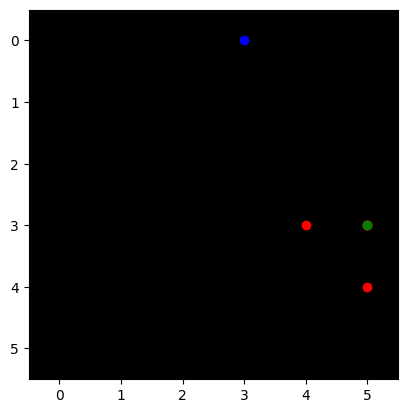

[0.022561602, 0.016749559, -0.008492609, 0.0033683127, -0.008492609]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.022561602, 0.016749559, -0.008492609, 0.0033683127, -0.008492609]
return [0.013399647176265718, -0.006794086843729019, 0.0026946501806378365, -0.006794086843729019, -1.0]
gae [-0.00916195511817932, -0.023543645814061164, 0.01118725873529911, -0.010162399569526314, -0.9915073914453387]
0.6768630383330625
tensor([[3., 2., 1., 0.]])
tensor([[3., 2., 1., 0.]])
tensor([[ 3.,  1.,  1., -1.]])
tensor([[ 2.,  1.,  0., -1.]])
tensor([[ 2.,  1.,  0., -1.]])
tensor([[ 2.,  0.,  0., -2.]])
tensor([[ 2.,  0.,  0., -2.]])
tensor([[ 2.,  1.,  0., -1.]])
tensor([[ 2.,  1.,  0., -1.]])
tensor([[ 3.,  1.,  1., -1.]])
tensor([[ 3.,  1.,  1., -1.]])
tensor([[3., 2., 1., 0.]])
tensor([[3., 2., 1., 0.]])
tensor([[3., 3., 1., 1.]])
tensor([[3., 3., 1., 1.]])
tensor([[2., 3., 0., 1.]])
tensor([[2., 3., 0., 1.]])
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  2., -1.,  0.]])
tensor(

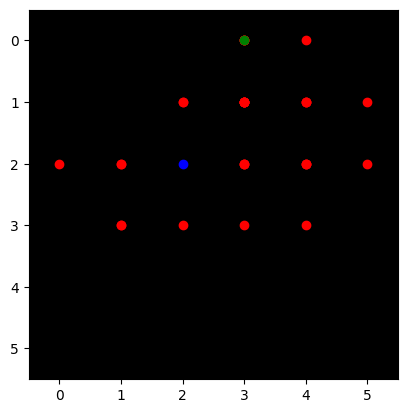

[-0.047089875, -0.08047272, -0.10441845, -0.07624532, -0.10441845, -0.08047272, -0.047089875, -0.026057586, -0.08379891, -0.0823164, -0.08062141, -0.0823164, -0.08379891, -0.0823164, -0.08144671, -0.0823164, -0.08062141, -0.0823164, -0.08379891, -0.058976986, -0.027152866, -0.058976986, -0.03499217, -0.08262682, -0.08364405, -0.058976986, -0.08364405, -0.08491869, -0.08364405, -0.0823164, -0.08144671]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.047089875, -0.08047272, -0.10441845, -0.07624532, -0.10441845, -0.08047272, -0.047089875, -0.026057586, -0.08379891, -0.0823164, -0.08062141, -0.0823164, -0.08379891, -0.0823164, -0.08144671, -0.0823164, -0.08062141, -0.0823164, -0.08379891, -0.058976986, -0.027152866, -0.058976986, -0.03499217, -0.08262682, -0.08364405, -0.058976986, -0.08364405, -0.08491869, -0.08364405, -0.0823164, -0.08144671]
return [-0.06437817811965943, -0.08353475928306581, -0.06099625825881958, -0.0835347

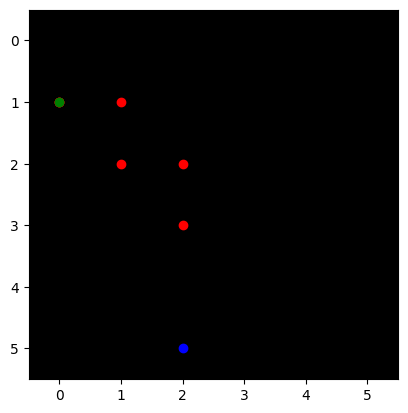

[0.012558985, 0.0096914265, 0.030753791, -0.00876785, 0.0031704796, -0.016533887]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.012558985, 0.0096914265, 0.030753791, -0.00876785, 0.0031704796, -0.016533887]
return [0.007753141224384308, 0.0246030330657959, -0.007014279812574387, 0.002536383643746376, -0.013227109611034394, -1.0]
gae [-0.004805843345820904, 0.014911606535315515, -0.03776807114481926, 0.011304233409464359, -0.016397589165717364, -0.983466112986207]
0.3852716759667061
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  0.,  4., -5.]])
tensor([[ 5.,  0.,  5., -5.]])
tensor([[ 5.,  1.,  5., -4.]])
tensor([[ 5.,  1.,  5., -4.]])
tensor([[ 5.,  0.,  5., -5.]])
tensor([[ 5.,  0.,  5., -5.]])


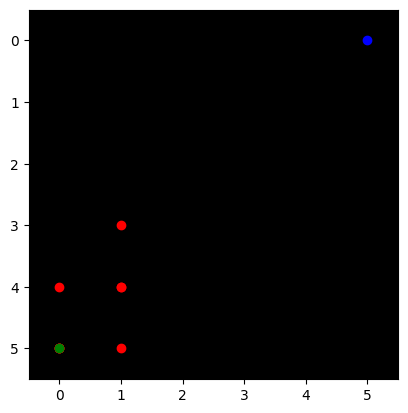

[-0.0011159922, 0.005737905, 0.007825892, 0.005737905, 0.0119520845, 0.025177231, 0.00579192, 0.025177231]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.0011159922, 0.005737905, 0.007825892, 0.005737905, 0.0119520845, 0.025177231, 0.00579192, 0.025177231]
return [0.004590323939919472, 0.006260713934898377, 0.004590323939919472, 0.00956166759133339, 0.020141784846782685, 0.004633535817265511, 0.020141784846782685, -1.0]
gae [0.005706316139549017, 0.0005228090099990371, -0.003235568478703499, 0.00382376266643405, 0.008189700357615948, -0.020543695241212846, 0.014349865075200797, -1.0251772310584784]
0.40738770251563805
tensor([[ 0.,  2., -4.,  0.]])
tensor([[ 0.,  3., -4.,  1.]])


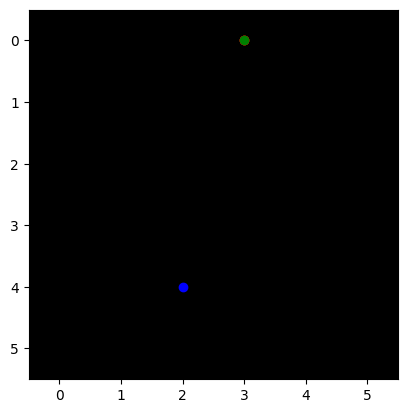

[0.026424, 0.05053892]
 gamma 0.8
[0, -1]
[0.026424, 0.05053892]
return [0.04043113589286804, -1.0]
gae [0.01400713585317135, -1.050538919866085]
0.9508555948635204
tensor([[3., 2., 2., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 2., 1., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[1., 2., 0., 2.]])
tensor([[1., 2., 0., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[2., 2., 1., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[3., 2., 2., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 1., 3., 1.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 2., 3., 2.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[3., 3., 2., 3.]])
tensor([[3., 3., 2., 3.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 4., 1., 4.]])
tensor([[2., 4., 1., 4.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 2., 1., 2.]]

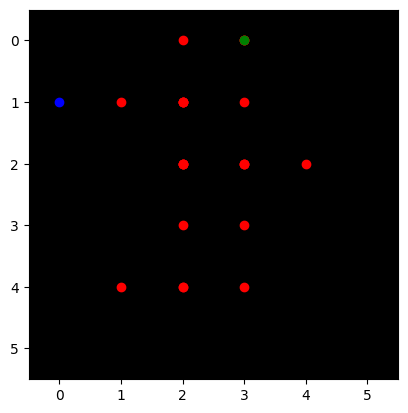

[0.010795204, -0.024718307, 0.03381869, -0.024718307, 0.015622745, -0.024718307, 0.010795204, 0.01333586, -0.0013661898, 0.01333586, 0.036552537, 0.052146364, 0.03381869, 0.053916555, 0.03381869, -0.024718307, 0.015622745, -0.006783352, 0.015622745, 0.028412888, 0.015622745, 0.03297765, 0.043522093]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.010795204, -0.024718307, 0.03381869, -0.024718307, 0.015622745, -0.024718307, 0.010795204, 0.01333586, -0.0013661898, 0.01333586, 0.036552537, 0.052146364, 0.03381869, 0.053916555, 0.03381869, -0.024718307, 0.015622745, -0.006783352, 0.015622745, 0.028412888, 0.015622745, 0.03297765, 0.043522093]
return [-0.019774645566940308, 0.02705495059490204, -0.019774645566940308, 0.012498196214437485, -0.019774645566940308, 0.008636163175106048, 0.010668688267469407, -0.0010929518379271031, 0.010668688267469407, 0.029242029786109926, 0.0417170912027359, 0.02705495059490204, 0.043133243918418884, 0.02705495059490204, 

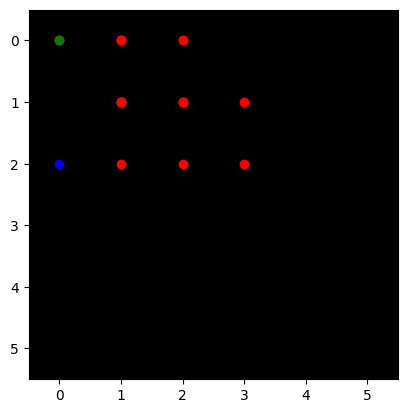

[-0.011318297, -0.00083288533, 0.0128563335, 0.039976366, 0.034902554, 0.034180738, 0.024460234, -0.0048804716, 0.034902554, 0.039976366, 0.034902554, -0.00083288533, 0.0128563335, -0.00083288533, -0.0067873076, -0.00083288533, 0.0128563335, -0.010492893]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.011318297, -0.00083288533, 0.0128563335, 0.039976366, 0.034902554, 0.034180738, 0.024460234, -0.0048804716, 0.034902554, 0.039976366, 0.034902554, -0.00083288533, 0.0128563335, -0.00083288533, -0.0067873076, -0.00083288533, 0.0128563335, -0.010492893]
return [-0.0006663082633167506, 0.010285066813230515, 0.03198109269142151, 0.027922043204307558, 0.027344590425491335, 0.01956818699836731, -0.0039043772965669634, 0.027922043204307558, 0.03198109269142151, 0.027922043204307558, -0.0006663082633167506, 0.010285066813230515, -0.0006663082633167506, -0.005429846048355103, -0.0006663082633167506, 0.010285066813230515, -0.008394314348697663, -1.0]
gae [0.01065198886208236

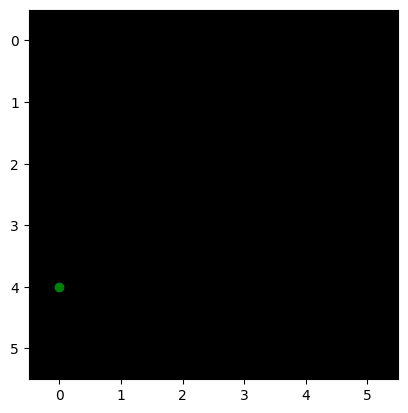

[]
 gamma 0.8
[]
[]
return []
gae []
0.3785745678786455
tensor([[ 1.,  4., -4.,  0.]])
tensor([[ 1.,  3., -4., -1.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  4., -1.,  0.]])
tensor([[ 4.,  4., -1.,  0.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  2.,  0., -2.]])


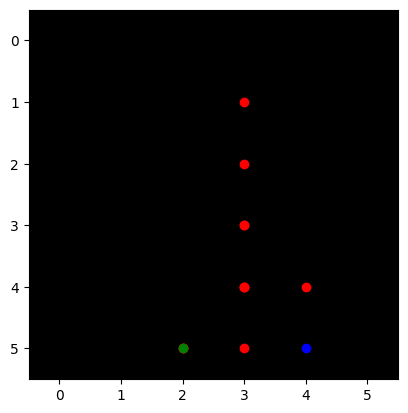

[0.03177195, 0.046453495, 0.049032148, 0.06670975, 0.024656491, 0.0398573, 0.024656491, 0.06670975, 0.024656491, 0.023437506, 0.03888143]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.03177195, 0.046453495, 0.049032148, 0.06670975, 0.024656491, 0.0398573, 0.024656491, 0.06670975, 0.024656491, 0.023437506, 0.03888143]
return [0.037162795662879944, 0.039225718379020696, 0.05336779952049256, 0.019725193083286286, 0.0318858414888382, 0.019725193083286286, 0.05336779952049256, 0.019725193083286286, 0.018750004470348358, 0.03110514283180237, -1.0]
gae [0.005390845239162445, -0.007227776199579233, 0.004335651546716696, -0.04698455631732941, 0.0072293501347303404, -0.02013210877776146, 0.028711308166384703, -0.04698455631732941, -0.005906486883759499, 0.007667637243866921, -1.038881428539753]
0.3826256096824795
tensor([[2., 3., 2., 0.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[1., 3., 1., 0.]])
tens

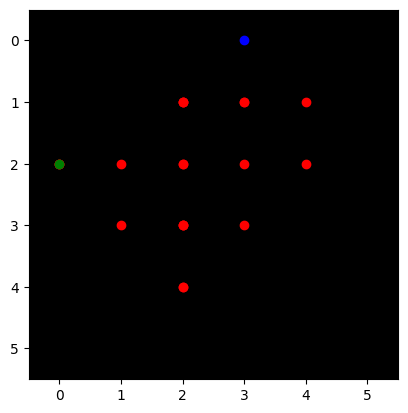

[0.02897801, 0.039819974, 0.048282802, 0.039819974, 0.048282802, 0.051212315, 0.048282802, 0.051212315, 0.05646076, 0.029969618, 0.02897801, 0.03138866, 0.03847528, 0.04144863, 0.03847528, 0.04144863, 0.03847528, 0.055469833, 0.029908087, 0.03466146]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.02897801, 0.039819974, 0.048282802, 0.039819974, 0.048282802, 0.051212315, 0.048282802, 0.051212315, 0.05646076, 0.029969618, 0.02897801, 0.03138866, 0.03847528, 0.04144863, 0.03847528, 0.04144863, 0.03847528, 0.055469833, 0.029908087, 0.03466146]
return [0.031855979561805726, 0.038626241683959964, 0.031855979561805726, 0.038626241683959964, 0.04096985161304474, 0.038626241683959964, 0.04096985161304474, 0.04516860842704773, 0.023975694179534913, 0.023182408511638643, 0.02511092722415924, 0.03078022301197052, 0.033158904314041136, 0.03078022301197052, 0.033158904314041136, 0.03078022301197052, 0.044375866651535034, 0.02392646968364716, 0.02772916853427887, -1.0]
ga

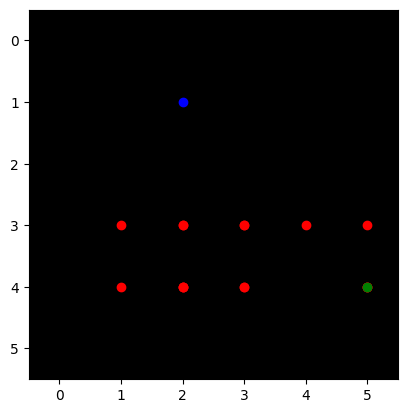

[0.026574574, 0.021724077, 0.026574574, 0.039909836, 0.036957093, 0.05141755, 0.041351713, 0.039909836, 0.026574574, 0.039909836, 0.036957093, 0.021724077, 0.028534792, 0.032374136, 0.026539901]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.026574574, 0.021724077, 0.026574574, 0.039909836, 0.036957093, 0.05141755, 0.041351713, 0.039909836, 0.026574574, 0.039909836, 0.036957093, 0.021724077, 0.028534792, 0.032374136, 0.026539901]
return [0.017379261553287506, 0.0212596595287323, 0.031927868723869324, 0.02956567406654358, 0.04113403856754303, 0.03308137059211731, 0.031927868723869324, 0.0212596595287323, 0.031927868723869324, 0.02956567406654358, 0.017379261553287506, 0.022827833890914917, 0.02589930891990662, 0.021231921017169954, -1.0]
gae [-0.009195312857627869, -0.00046441741287708144, 0.005353294312953949, -0.010344161838293075, 0.004176945984363557, -0.018336177617311475, -0.009423844516277313, -0.018650176376104353, 0.005353294312953949, -0.010344161838293075, -0.01

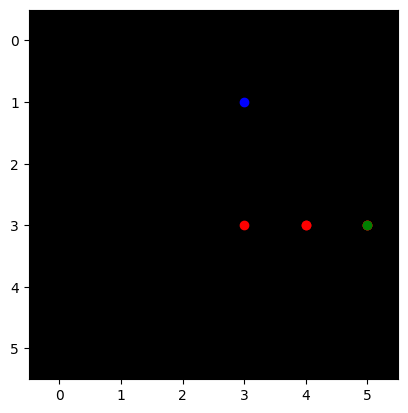

[0.0265766, 0.02481206, 0.0265766, 0.02481206, 0.03018674]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.0265766, 0.02481206, 0.0265766, 0.02481206, 0.03018674]
return [0.0198496475815773, 0.021261279284954072, 0.0198496475815773, 0.024149392545223237, -1.0]
gae [-0.006726951524615287, -0.0035507801920175545, -0.006726951524615287, -0.0006626669317483895, -1.030186740681529]
return [0.03862624 0.03862624 0.03922572 0.04096985 0.04096985 0.04113404
 0.04437587 0.04516861 0.0533678  0.0533678 ]
return [-1.         -1.         -1.         -1.          0.01737926  0.01737926
  0.01875     0.01972519  0.01972519  0.01972519]

-------------------- Iteration #46 --------------------
random  0.1522570109597049
Average : 0.01
Average Episodic Return: -0.73
Max Episodic Return: 1.0
Average Loss: 0.00109
Average Loss Critic: 0.23572733998298645
TEntropy: nan
approx_kl_divs: [0.00029750535] secs
------------------------------------------------------

0.7962830231292223
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 1.

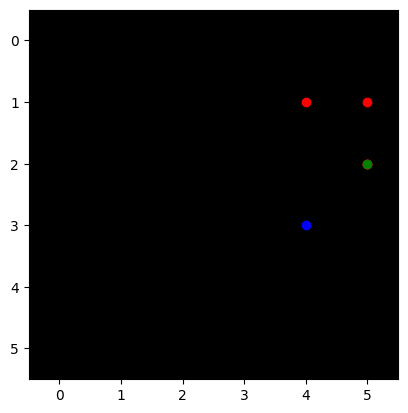

[-0.025742244, -0.033006024, -0.025742244, -0.040332817]
 gamma 0.8
[0, 0, 0, -1]
[-0.025742244, -0.033006024, -0.025742244, -0.040332817]
return [-0.026404818892478945, -0.020593795180320743, -0.032266253232955934, -1.0]
gae [-0.0006625749170780203, 0.012412228435277936, -0.006524009257555009, -0.9596671834588051]
0.8588229192927546
tensor([[5., 4., 1., 2.]])
tensor([[5., 4., 1., 2.]])
tensor([[5., 3., 1., 1.]])
tensor([[5., 4., 1., 2.]])
tensor([[4., 4., 0., 2.]])
tensor([[4., 4., 0., 2.]])
tensor([[4., 3., 0., 1.]])
tensor([[4., 3., 0., 1.]])


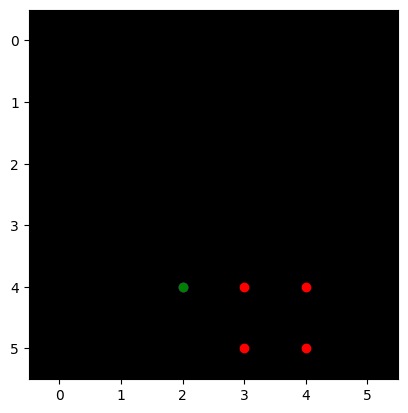

[-0.05254529, -0.043788094, -0.05254529, -0.05914054, -0.04766128]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.05254529, -0.043788094, -0.05254529, -0.05914054, -0.04766128]
return [-0.03503047525882721, -0.04203623235225678, -0.047312432527542116, -0.0381290227174759, 1.0]
gae [0.01751481518149376, 0.0017518617212772328, 0.005232857912778853, 0.021011517941951746, 1.0476612783968449]
0.7741742068451265
tensor([[ 0.,  0., -2., -4.]])
tensor([[ 0.,  1., -2., -3.]])
tensor([[ 0.,  0., -2., -4.]])
tensor([[ 0.,  0., -2., -4.]])


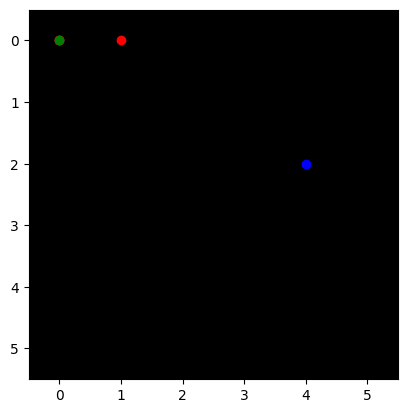

[-0.026973788, -0.034675125, -0.026973788]
 gamma 0.8
[0, 0, -1]
[-0.026973788, -0.034675125, -0.026973788]
return [-0.027740100026130678, -0.021579030156135562, -1.0]
gae [-0.0007663123309612288, 0.013096094876527783, -0.9730262123048306]
0.2814790328498934
tensor([[ 1.,  5., -1.,  1.]])
tensor([[ 1.,  5., -1.,  1.]])
tensor([[ 1.,  4., -1.,  0.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 2.,  3.,  0., -1.]])


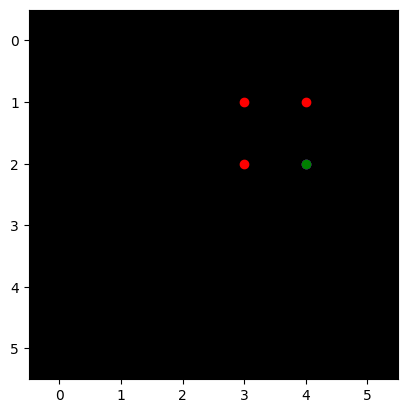

[-0.024206402, -0.031164706, -0.032116696, -0.030186264]
 gamma 0.8
[0, 0, 0, 1]
[-0.024206402, -0.031164706, -0.032116696, -0.030186264]
return [-0.024931764602661135, -0.02569335699081421, -0.024149011075496676, 1.0]
gae [-0.0007253628224134466, 0.005471348762512207, 0.007967685163021085, 1.0301862638443708]
0.025040288517546583
tensor([[5., 4., 1., 0.]])


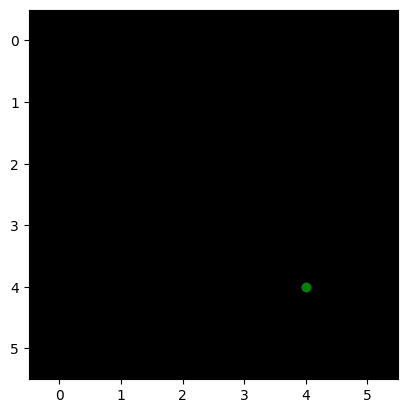

[-0.04454159]
 gamma 0.8
[1]
[-0.04454159]
return [1.0]
gae [1.0445415899157524]
0.002671556306355738
tensor([[ 1.,  3., -3.,  2.]])
tensor([[ 1.,  2., -3.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 3.,  2., -1.,  1.]])
tensor([[ 2.,  2., -2.,  1.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 1.,  4., -3.,  3.]])
tensor([[ 0.,  4., -4.,  3.]])


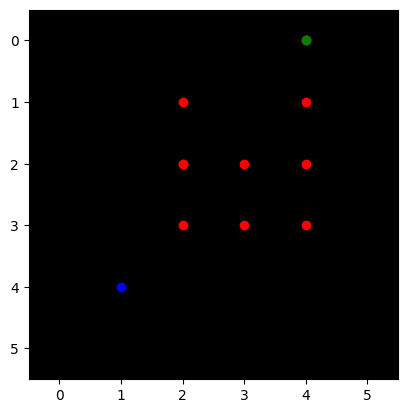

[-0.041153114, -0.043238748, -0.033748448, -0.030963615, -0.033748448, -0.0215409, -0.039856106, -0.05570343, -0.039613836, -0.031032288, -0.050581917]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.041153114, -0.043238748, -0.033748448, -0.030963615, -0.033748448, -0.0215409, -0.039856106, -0.05570343, -0.039613836, -0.031032288, -0.050581917]
return [-0.0345909982919693, -0.02699875831604004, -0.024770891666412356, -0.02699875831604004, -0.01723272055387497, -0.03188488483428955, -0.04456274509429932, -0.031691068410873414, -0.02482583075761795, -0.04046553373336792, -1.0]
gae [0.006562115997076033, 0.016239989548921585, 0.008977556228637693, 0.003964856266975403, 0.01651572734117508, -0.010343984141945838, -0.004706639051437381, 0.02401236295700073, 0.014788004755973815, -0.009433245286345482, -0.9494180828332901]
0.6257709067788823
tensor([[5., 3., 1., 2.]])
tensor([[5., 2., 1., 1.]])
tensor([[5., 2., 1., 1.]])
tensor([[5., 1., 1., 0.]])
tensor([[5., 1., 1., 0.]])


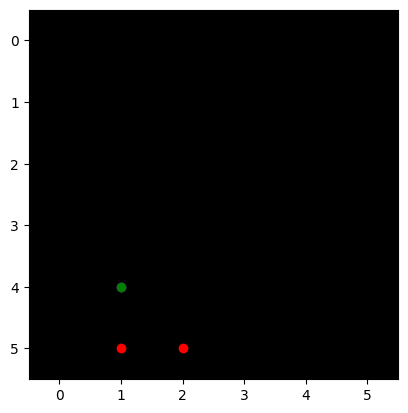

[-0.04539874, -0.044597756, -0.05482837]
 gamma 0.8
[0, 0, 1]
[-0.04539874, -0.044597756, -0.05482837]
return [-0.03567820489406586, -0.043862697482109074, 1.0]
gae [0.009720533341169353, 0.0007350586354732472, 1.0548283718526363]
0.8524437164869454
tensor([[ 3.,  2., -2., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  3., -5., -2.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 2.,  1., -3., -4.]])
tensor([[ 2.,  1., -3., -4.]])
tensor([[ 3.,  1., -2., -4.]])
tensor([[ 3.,  1., -2., -4.]])
tensor([[ 3.,  0., -2., -5.]])
tensor([[ 3.,  0., -2., -5.]])


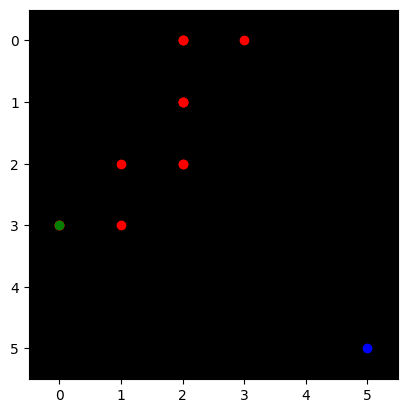

[-0.009240186, -0.025740681, -0.044184115, -0.08832915, -0.044184115, -0.08832915, -0.078696705, -0.08832915, -0.044184115, -0.025740681, -0.012654412, -0.013912458, -0.019301737]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.009240186, -0.025740681, -0.044184115, -0.08832915, -0.044184115, -0.08832915, -0.078696705, -0.08832915, -0.044184115, -0.025740681, -0.012654412, -0.013912458, -0.019301737]
return [-0.020592544972896577, -0.035347291827201845, -0.070663321018219, -0.035347291827201845, -0.070663321018219, -0.06295736432075501, -0.070663321018219, -0.035347291827201845, -0.020592544972896577, -0.01012352928519249, -0.011129966378211975, -0.01544138938188553, -1.0]
gae [-0.011352359130978585, -0.009606610611081125, -0.026479206234216693, 0.0529818594455719, -0.026479206234216693, 0.025371786952018735, 0.00803338438272476, 0.0529818594455719, 0.023591569811105727, 0.01561715193092823, 0.0015244452282786366, -0.001528931409120561, -0.9806982632726431]
0.15836439022780313


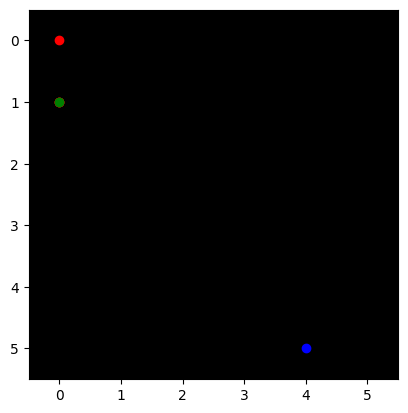

[-0.03805726, -0.09574097, -0.03805726]
 gamma 0.8
[0, 0, -1]
[-0.03805726, -0.09574097, -0.03805726]
return [-0.07659277319908142, -0.030445808172225954, -1.0]
gae [-0.03853551298379898, 0.06529515832662583, -0.9619427397847176]
0.5017758349566832
tensor([[ 1.,  2., -4.,  1.]])
tensor([[ 1.,  2., -4.,  1.]])
tensor([[ 0.,  2., -5.,  1.]])
tensor([[ 0.,  3., -5.,  2.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  4., -5.,  3.]])


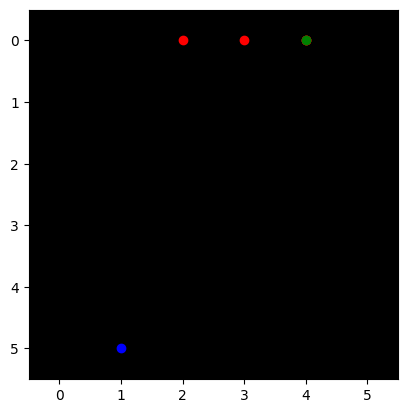

[-0.055260934, -0.10432929, -0.091001615, -0.063519515]
 gamma 0.8
[0, 0, 0, -1]
[-0.055260934, -0.10432929, -0.091001615, -0.063519515]
return [-0.08346343040466309, -0.07280129194259644, -0.05081561207771301, -1.0]
gae [-0.028202496469020844, 0.03152799606323242, 0.04018600285053253, -0.9364804849028587]
return [-0.02059254 -0.02059254 -0.01723272 -0.01544139 -0.01112997 -0.01012353
  1.          1.          1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -0.08346343 -0.07659277 -0.07280129 -0.07066332]

-------------------- Iteration #47 --------------------
random  0.5017758349566832
Average : 0.01
Average Episodic Return: -0.69
Max Episodic Return: 1.0
Average Loss: 0.00018
Average Loss Critic: 0.23641091585159302
TEntropy: nan
approx_kl_divs: [6.823721e-05] secs
------------------------------------------------------

0.5653440157892998
tensor([[ 0.,  0., -2.,  0.]])
tensor([[ 1.,  0., -1.,  0.]])
tensor([[ 1.,  0., -1.,  0.]])
tens

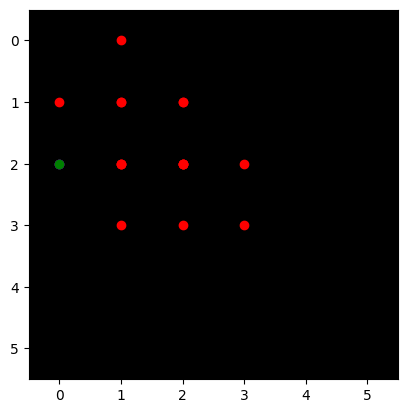

[-0.03396917, -0.049544953, -0.030076401, -0.014156349, -0.030076401, -0.0041230014, -0.069309585, -0.0738639, -0.069309585, -0.08362787, -0.06934786, -0.03879173, -0.069309585, -0.0041230014, -0.069309585, -0.0738639, -0.10019465, -0.0738639]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.03396917, -0.049544953, -0.030076401, -0.014156349, -0.030076401, -0.0041230014, -0.069309585, -0.0738639, -0.069309585, -0.08362787, -0.06934786, -0.03879173, -0.069309585, -0.0041230014, -0.069309585, -0.0738639, -0.10019465, -0.0738639]
return [-0.039635962247848516, -0.02406112104654312, -0.011325079202651979, -0.02406112104654312, -0.003298401087522507, -0.055447667837142944, -0.05909112095832825, -0.055447667837142944, -0.06690229773521424, -0.05547828674316407, -0.031033384799957278, -0.055447667837142944, -0.003298401087522507, -0.055447667837142944, -0.05909112095832825, -0.0801557183265686, -0.05909112095832825, 1.0]
gae [-0.005666790902614599, 0.025483831763267517, 0

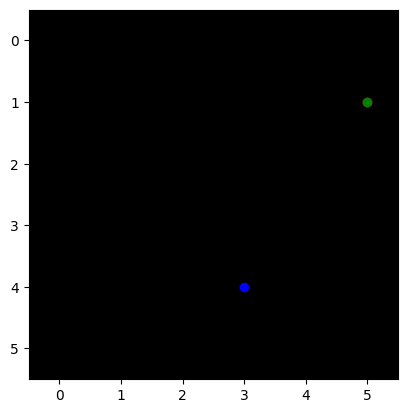

[-0.014552557]
 gamma 0.8
[-1]
[-0.014552557]
return [-1.0]
gae [-0.9854474430903792]
0.8996663656301152
tensor([[5., 4., 0., 2.]])
tensor([[5., 4., 0., 2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  3., -1.,  1.]])
tensor([[ 4.,  3., -1.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 4.,  3., -1.,  1.]])
tensor([[ 4.,  3., -1.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tens

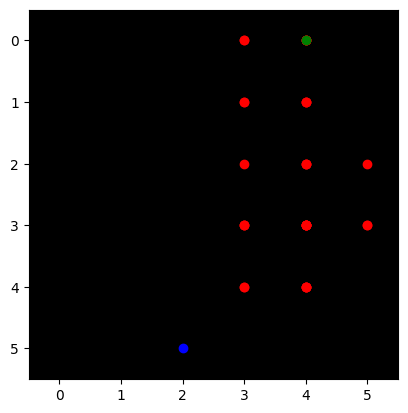

[-0.06147075, -0.045596804, -0.03212422, -0.045596804, -0.03212422, -0.045596804, -0.0679011, -0.03451335, -0.03212422, -0.045596804, -0.03212422, -0.03451335, -0.0679011, -0.03451335, 0.0036989134, -0.020526767, 0.011862303, -0.020526767, -0.03212422, -0.035032876, -0.03212422, -0.035032876, -0.03302605, -0.020526767, 0.011862303, 0.018226534, -0.007266669, 0.018226534, -0.007266669, 0.01417314, 0.011862303, 0.01417314]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.06147075, -0.045596804, -0.03212422, -0.045596804, -0.03212422, -0.045596804, -0.0679011, -0.03451335, -0.03212422, -0.045596804, -0.03212422, -0.03451335, -0.0679011, -0.03451335, 0.0036989134, -0.020526767, 0.011862303, -0.020526767, -0.03212422, -0.035032876, -0.03212422, -0.035032876, -0.03302605, -0.020526767, 0.011862303, 0.018226534, -0.007266669, 0.018226534, -0.007266669, 0.01417314, 0.011862303, 0.01417314]
return [-0.036477443575859074, -0.0256993

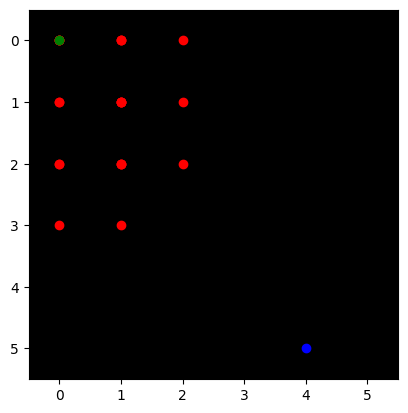

[-0.05929128, -0.055959947, -0.056068, -0.05928901, -0.063563, -0.05928901, -0.05929128, -0.06190004, -0.05929128, -0.06190004, -0.052954253, -0.036660016, -0.05545298, -0.059727736, -0.05929128, -0.06190004, -0.063563, -0.06190004, -0.052954253, -0.075393274, -0.052954253, -0.075393274]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.05929128, -0.055959947, -0.056068, -0.05928901, -0.063563, -0.05928901, -0.05929128, -0.06190004, -0.05929128, -0.06190004, -0.052954253, -0.036660016, -0.05545298, -0.059727736, -0.05929128, -0.06190004, -0.063563, -0.06190004, -0.052954253, -0.075393274, -0.052954253, -0.075393274]
return [-0.04476795792579651, -0.04485439956188202, -0.04743120670318604, -0.050850397348403936, -0.04743120670318604, -0.04743302464485169, -0.04952003061771393, -0.04743302464485169, -0.04952003061771393, -0.0423634022474289, -0.029328012466430665, -0.044362384080886844, -0.04778218865394593, -0.04743302464485169, -0.04952003061771393, -0.

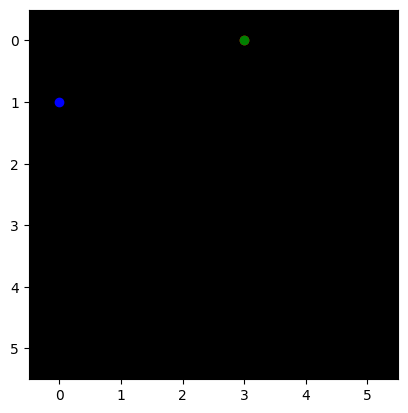

[-0.036115713]
 gamma 0.8
[-1]
[-0.036115713]
return [-1.0]
gae [-0.9638842865824699]
0.720246688255517
tensor([[ 2.,  0., -1., -3.]])
tensor([[ 2.,  0., -1., -3.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 2.,  1., -1., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  0., -2.]])
tensor([[ 4.,  1.,  1., -2.]])
tensor([[ 4.,  1.,  1., -2.]])
tensor([[ 4.,  2.,  1., -1.]])
tensor([[ 4.,  2.,  1., -1.]])
tensor([[ 4.,  1.,  1., -2.]])
tensor([[ 5.,  1.,  2., -2.]])
tensor([[ 5.,  0.,  2., -3.]])
tensor([[ 4.,  0.,  1., -3.]])
tensor([[ 4.,  0.,  1., -3.]])
tensor([[ 5.,  0.,  2., -3.]])
tensor([[ 5.,  0.,  2., -3.]])


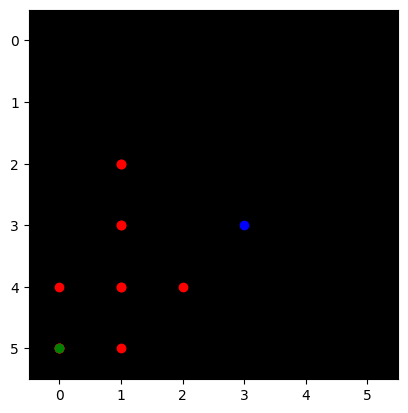

[-0.058106087, -0.057067357, -0.044235993, -0.057067357, -0.044235993, -0.051583763, -0.07345243, -0.051583763, -0.064424016, -0.0373956, -0.03961496, -0.0373956]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.058106087, -0.057067357, -0.044235993, -0.057067357, -0.044235993, -0.051583763, -0.07345243, -0.051583763, -0.064424016, -0.0373956, -0.03961496, -0.0373956]
return [-0.045653885602951055, -0.03538879454135895, -0.045653885602951055, -0.03538879454135895, -0.04126701056957245, -0.0587619423866272, -0.04126701056957245, -0.051539212465286255, -0.02991648018360138, -0.03169196844100952, -0.02991648018360138, -1.0]
gae [0.01245220154523849, 0.02167856246232986, -0.0014178924262523707, 0.02167856246232986, 0.002968982607126233, -0.007178179174661639, 0.032185417413711545, 4.455074667930603e-05, 0.03450753539800644, 0.005703631788492203, 0.009698480367660522, -0.9626043997704983]
0.016822663990467057
tensor([[ 1.,  1., -2., -3.]])
tensor([[ 1.,  2., -2., -2.]])
tensor([[ 0.,  2

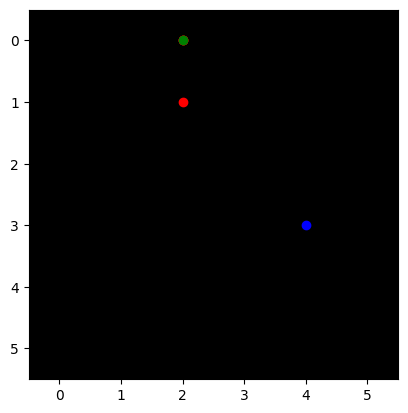

[-0.05932258, -0.059274323, -0.053116426]
 gamma 0.8
[0, 0, -1]
[-0.05932258, -0.059274323, -0.053116426]
return [-0.047419458627700806, -0.042493140697479254, -1.0]
gae [0.011903122067451477, 0.016781182587146753, -0.9468835741281509]
0.4931227980344255


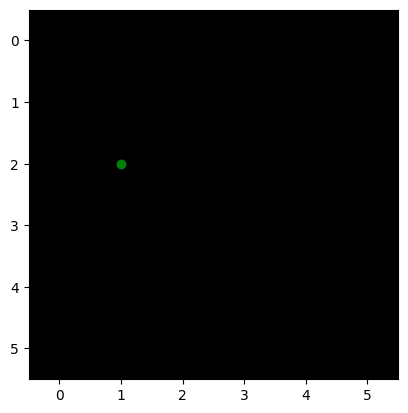

[-0.05929128, -0.055959947, -0.056068, -0.05928901, -0.063563, -0.05928901, -0.05929128, -0.06190004, -0.05929128, -0.06190004, -0.052954253, -0.036660016, -0.05545298, -0.059727736, -0.05929128, -0.06190004, -0.063563, -0.06190004, -0.052954253, -0.075393274, -0.052954253, -0.075393274, -0.036115713, -0.058106087, -0.057067357, -0.044235993, -0.057067357, -0.044235993, -0.051583763, -0.07345243, -0.051583763, -0.064424016, -0.0373956, -0.03961496, -0.0373956, -0.05932258, -0.059274323, -0.053116426]
 gamma 0.8
[]
[-0.05929128, -0.055959947, -0.056068, -0.05928901, -0.063563, -0.05928901, -0.05929128, -0.06190004, -0.05929128, -0.06190004, -0.052954253, -0.036660016, -0.05545298, -0.059727736, -0.05929128, -0.06190004, -0.063563, -0.06190004, -0.052954253, -0.075393274, -0.052954253, -0.075393274, -0.036115713, -0.058106087, -0.057067357, -0.044235993, -0.057067357, -0.044235993, -0.051583763, -0.07345243, -0.051583763, -0.064424016, -0.0373956, -0.03961496, -0.0373956, -0.05932258, -0

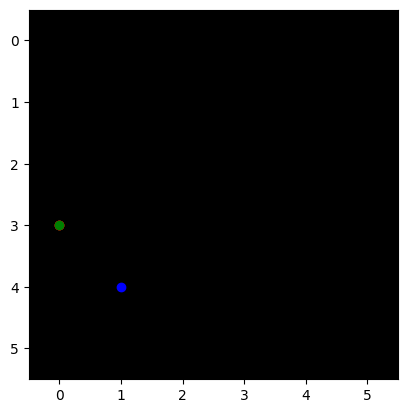

[-0.04749449, -0.045277566]
 gamma 0.8
[0, -1]
[-0.04749449, -0.045277566]
return [-0.03622205257415772, -1.0]
gae [0.011272437125444408, -0.9547224342823029]
0.9339452578694223
tensor([[3., 2., 2., 1.]])
tensor([[3., 2., 2., 1.]])
tensor([[3., 1., 2., 0.]])
tensor([[3., 1., 2., 0.]])
tensor([[3., 2., 2., 1.]])
tensor([[3., 2., 2., 1.]])
tensor([[3., 3., 2., 2.]])
tensor([[3., 3., 2., 2.]])
tensor([[2., 3., 1., 2.]])
tensor([[2., 3., 1., 2.]])
tensor([[2., 4., 1., 3.]])
tensor([[2., 4., 1., 3.]])
tensor([[2., 3., 1., 2.]])
tensor([[2., 3., 1., 2.]])
tensor([[2., 2., 1., 1.]])
tensor([[2., 2., 1., 1.]])
tensor([[2., 1., 1., 0.]])
tensor([[2., 1., 1., 0.]])
tensor([[ 2.,  0.,  1., -1.]])
tensor([[ 2.,  0.,  1., -1.]])


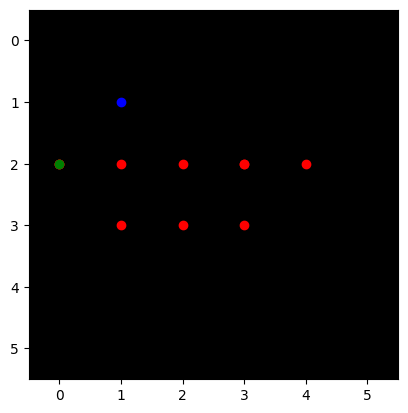

[-0.075639635, -0.04887268, -0.075639635, -0.08606743, -0.0848481, -0.07054069, -0.0848481, -0.05130115, -0.05226701, -0.049829308]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.075639635, -0.04887268, -0.075639635, -0.08606743, -0.0848481, -0.07054069, -0.0848481, -0.05130115, -0.05226701, -0.049829308]
return [-0.039098143577575684, -0.06051170825958252, -0.0688539445400238, -0.06787847876548768, -0.056432551145553594, -0.06787847876548768, -0.04104092121124268, -0.041813609004020695, -0.03986344635486603, -1.0]
gae [0.036541491746902466, -0.011639028787612915, 0.006785690784454346, 0.018188951909542075, 0.028415547311305994, 0.002662210166454307, 0.04380717724561691, 0.00948754251003265, 0.012403564900159834, -0.9501706920564175]
return [-0.04104092 -0.03986344 -0.03909814 -0.03622205 -0.03538879 -0.03538879
 -0.03169197 -0.02991648 -0.02991648 -0.02932801]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -0.06885394 -0.06787848 -0.06787848 -0.06051171]

---

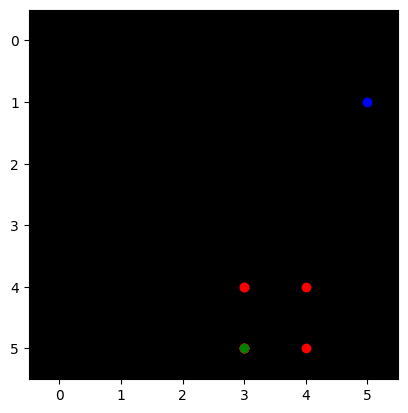

[0.01857433, 0.019632975, 0.01483716, 0.019632975, 0.025929881, 0.019104175, 0.01483716, 0.019632975]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.01857433, 0.019632975, 0.01483716, 0.019632975, 0.025929881, 0.019104175, 0.01483716, 0.019632975]
return [0.01570637971162796, 0.011869727820158006, 0.01570637971162796, 0.020743905007839205, 0.015283340215682985, 0.011869727820158006, 0.01570637971162796, -1.0]
gae [-0.0028679493814706795, -0.0077632468193769445, 0.000869219936430455, 0.0011109303683042547, -0.010646541044116019, -0.0072344474494457234, 0.000869219936430455, -1.019632974639535]
0.07090905313896856
tensor([[ 1.,  1., -1., -3.]])
tensor([[ 1.,  1., -1., -3.]])
tensor([[ 0.,  1., -2., -3.]])
tensor([[ 0.,  2., -2., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 0.,  2., -2., -2.]])


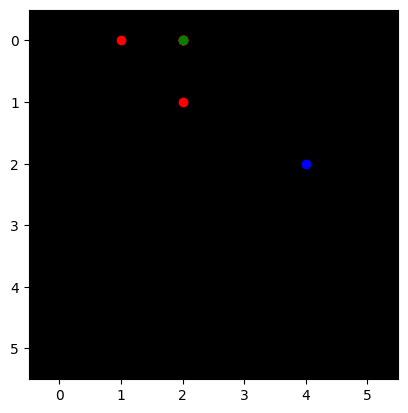

[-0.018622823, -0.013372809, -0.013678294, -0.012151418, -0.013678294]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.018622823, -0.013372809, -0.013678294, -0.012151418, -0.013678294]
return [-0.010698246955871583, -0.0109426349401474, -0.00972113460302353, -0.0109426349401474, -1.0]
gae [0.007924576103687285, 0.002430173754692077, 0.00395715907216072, 0.0012087833136320107, -0.9863217063248158]
0.7299971442656625
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 0.,  1., -2., -2.]])
tensor([[ 0.,  1., -2., -2.]])
tensor([[ 0.,  2., -2., -1.]])


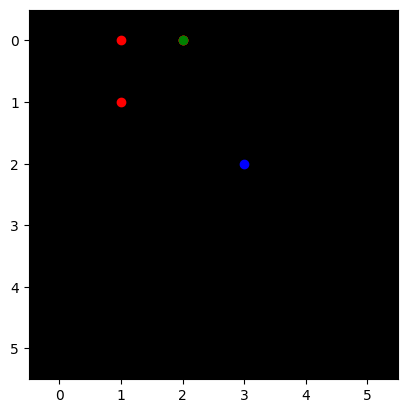

[-0.0018994263, -0.018035669, -0.0090710865, -0.014440024]
 gamma 0.8
[0, 0, 0, -1]
[-0.0018994263, -0.018035669, -0.0090710865, -0.014440024]
return [-0.014428535103797914, -0.007256869226694107, -0.01155201941728592, -1.0]
gae [-0.01252910876646638, 0.010778799653053284, -0.0024809328839182857, -0.9855599757283926]
0.932800108500058
tensor([[ 4.,  2.,  3., -3.]])
tensor([[ 4.,  2.,  3., -3.]])
tensor([[ 5.,  2.,  4., -3.]])
tensor([[ 5.,  1.,  4., -4.]])
tensor([[ 5.,  1.,  4., -4.]])


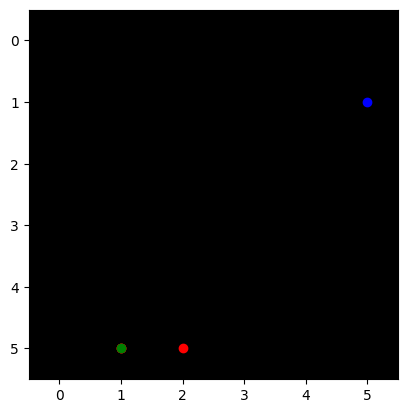

[0.014068815, 0.01857433, 0.02522379]
 gamma 0.8
[0, 0, -1]
[0.014068815, 0.01857433, 0.02522379]
return [0.014859463274478913, 0.020179031789302828, -1.0]
gae [0.0007906483486294757, 0.0016047026962041876, -1.0252237897366285]
0.009555842388743074
tensor([[ 0.,  1., -1.,  0.]])


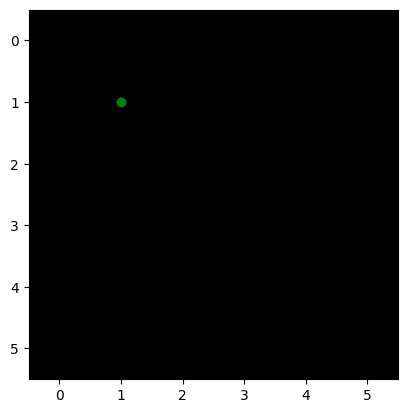

[-0.007844175]
 gamma 0.8
[1]
[-0.007844175]
return [1.0]
gae [1.0078441752120852]
0.2408080148925591
tensor([[5., 1., 4., 1.]])
tensor([[5., 2., 4., 2.]])
tensor([[5., 3., 4., 3.]])
tensor([[5., 3., 4., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 4., 3., 4.]])
tensor([[5., 4., 4., 4.]])
tensor([[5., 5., 4., 5.]])


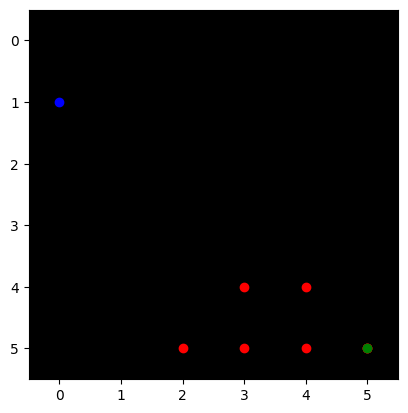

[0.013107212, 0.014847454, 0.018647691, 0.014503535, 0.02527786, 0.02534602, 0.044717524]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.013107212, 0.014847454, 0.018647691, 0.014503535, 0.02527786, 0.02534602, 0.044717524]
return [0.011877962946891786, 0.014918152987957001, 0.011602827906608583, 0.020222288370132447, 0.020276816189289094, 0.0357740193605423, -1.0]
gae [-0.0012292493134737, 7.069930434227059e-05, -0.007044863328337668, 0.00571875348687172, -0.0050010442733764635, 0.010427999123930935, -1.0447175242006779]
0.12230061175543405
tensor([[ 1.,  1., -1., -4.]])
tensor([[ 1.,  0., -1., -5.]])


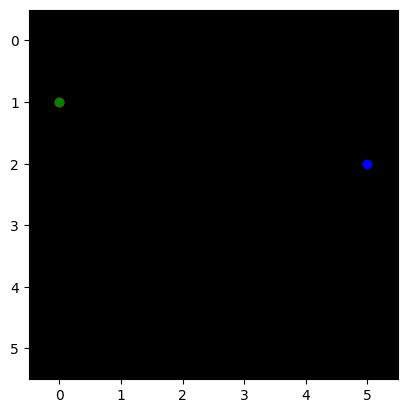

[-0.018655587, -0.020438343]
 gamma 0.8
[0, -1]
[-0.018655587, -0.020438343]
return [-0.016350674629211425, -1.0]
gae [0.002304912358522416, -0.9795616567134857]
0.21396228231635106
tensor([[4., 2., 1., 1.]])
tensor([[4., 2., 1., 1.]])
tensor([[3., 2., 0., 1.]])
tensor([[3., 2., 0., 1.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[3., 2., 0., 1.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[ 2.,  1., -1.,  0.]])
tensor([[ 2.,  1., -1.,  0.]])
tensor([[ 2.,  0., -1., -1.]])
tensor([[ 2.,  0., -1., -1.]])
tensor([[ 2.,  1., -1.,  0.]])
tensor([[ 1.,  1., -2.,  0.]])
tensor([[ 2.,  1., -1.,  0.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[3., 2., 0., 1.]])
tensor([[4., 2., 1., 1.]])
tensor([[3., 2., 0., 1.]])


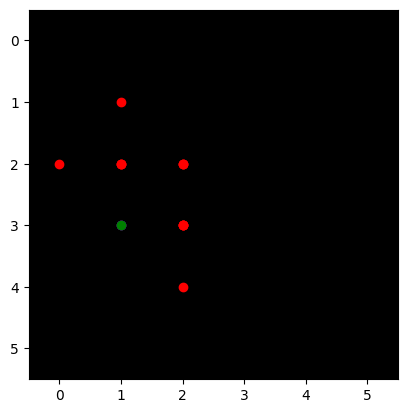

[0.010760905, 0.009314685, 0.015211921, 0.009314685, 0.015211921, 0.012631415, -0.01581487, 0.012631415, -0.009390481, 0.012631415, 0.015211921, 0.009314685, 0.010760905, 0.009314685]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.010760905, 0.009314685, 0.015211921, 0.009314685, 0.015211921, 0.012631415, -0.01581487, 0.012631415, -0.009390481, 0.012631415, 0.015211921, 0.009314685, 0.010760905, 0.009314685]
return [0.007451748102903367, 0.012169536948204041, 0.007451748102903367, 0.012169536948204041, 0.010105132311582566, -0.012651896476745606, 0.010105132311582566, -0.007512384653091431, 0.010105132311582566, 0.012169536948204041, 0.007451748102903367, 0.008608724176883699, 0.007451748102903367, 1.0]
gae [-0.0033091571182012553, 0.0028548518195748336, -0.007760173082351684, 0.0028548518195748336, -0.005106788873672484, -0.02528331186622381, 0.025920002907514575, -0.02014380004256964, 0.019495613127946856, -0.0004618784412741654, -0.007760173082351684, -0.000705960951745509

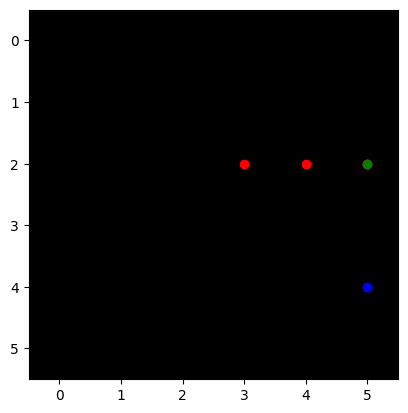

[-0.008021689, 0.008371336, 0.02011025, 0.030196425]
 gamma 0.8
[0, 0, 0, -1]
[-0.008021689, 0.008371336, 0.02011025, 0.030196425]
return [0.006697069108486176, 0.016088199615478516, 0.02415713965892792, -1.0]
gae [0.01471875812858343, 0.007716863229870797, 0.004046890139579776, -1.03019642457366]
0.10413775292916483
tensor([[ 0.,  2.,  0., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[3., 3., 3., 0.]])
tensor([[4., 3., 4., 0.]])
tensor([[4., 4., 4., 1.]])
tensor([[4., 5., 4., 2.]])


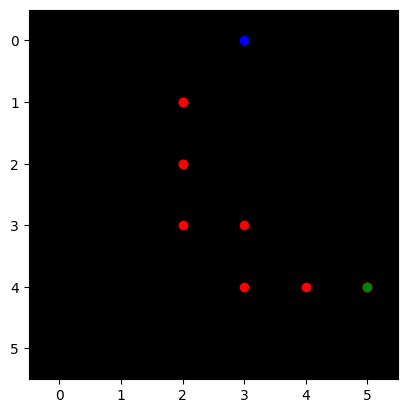

[-0.013212947, 0.01396443, 0.014222721, 0.01396443, 0.014222721, 0.011090979, 0.013073884, 0.015852628, 0.020183899, 0.034220703]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.013212947, 0.01396443, 0.014222721, 0.01396443, 0.014222721, 0.011090979, 0.013073884, 0.015852628, 0.020183899, 0.034220703]
return [0.011171544343233109, 0.011378176510334015, 0.011171544343233109, 0.011378176510334015, 0.008872783184051514, 0.010459107160568238, 0.012682102620601654, 0.01614711880683899, 0.027376562356948853, -1.0]
gae [0.024384491518139838, -0.0025862539187073708, -0.0030511762946844097, -0.0025862539187073708, -0.005349937453866005, -0.0006318718194961541, -0.0003917813301086426, 0.0002944905310869224, 0.007192663848400116, -1.034220702946186]
return [0.01614712 0.02017903 0.02022229 0.02027682 0.0207439  0.02415714
 0.02737656 0.03577402 1.         1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.01635068 -0.01442854]

--------

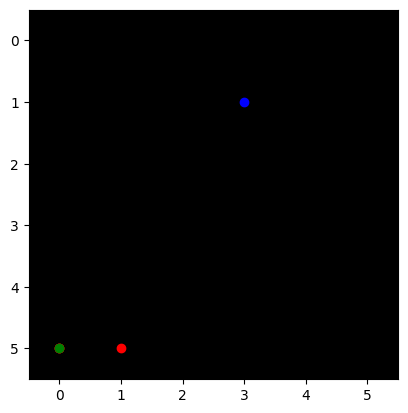

[0.09674117, 0.07894604, 0.04347894]
 gamma 0.8
[0, 0, -1]
[0.09674117, 0.07894604, 0.04347894]
return [0.06315683126449585, 0.03478315174579621, -1.0]
gae [-0.03358433842658996, -0.044162887334823604, -1.0434789396822453]
0.9151988380364328
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])


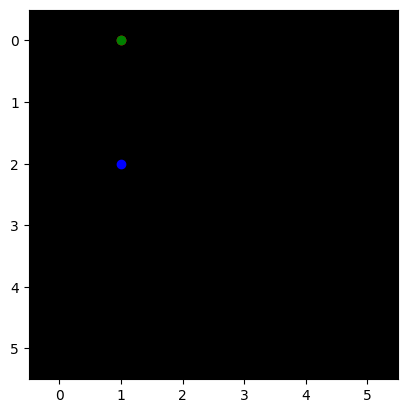

[-0.047745872]
 gamma 0.8
[-1]
[-0.047745872]
return [-1.0]
gae [-0.9522541277110577]
0.5128263074044253
tensor([[ 0.,  1.,  0., -2.]])


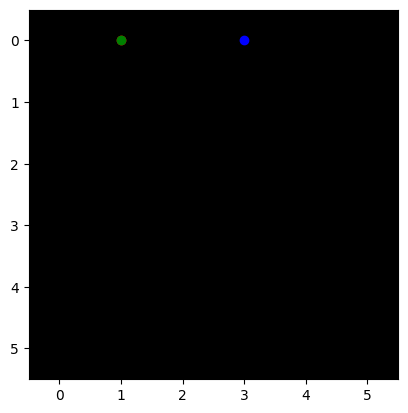

[-0.04004719]
 gamma 0.8
[-1]
[-0.04004719]
return [-1.0]
gae [-0.9599528089165688]
0.8170552873554295
tensor([[5., 3., 5., 1.]])
tensor([[5., 3., 5., 1.]])


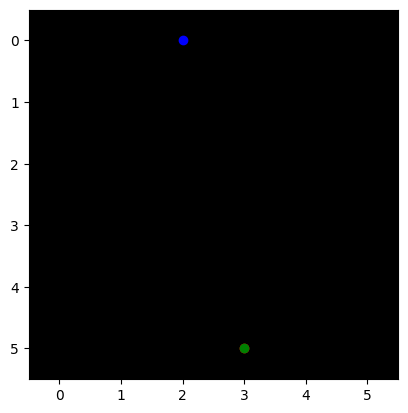

[0.09765353]
 gamma 0.8
[-1]
[0.09765353]
return [-1.0]
gae [-1.0976535305380821]
0.18898722646905464
tensor([[5., 3., 5., 0.]])
tensor([[5., 3., 5., 0.]])
tensor([[5., 4., 5., 1.]])
tensor([[5., 3., 5., 0.]])
tensor([[5., 3., 5., 0.]])
tensor([[5., 4., 5., 1.]])
tensor([[5., 3., 5., 0.]])
tensor([[ 5.,  2.,  5., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[3., 3., 3., 0.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[3., 3., 3., 0.]])
tensor([[2., 3., 2., 0.]])
tensor([[2., 4., 2., 1.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[1., 5., 1., 2.]])


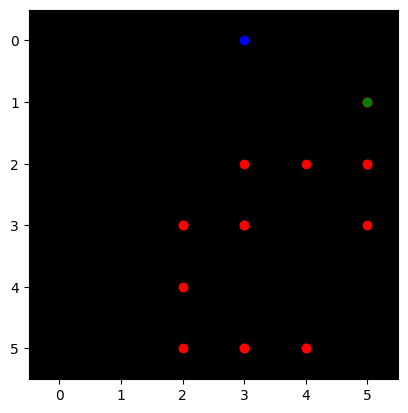

[0.09782036, 0.09993175, 0.09782036, 0.09993175, 0.09782036, 0.09707532, 0.09395198, 0.070522554, 0.0959064, 0.070522554, 0.0959064, 0.05512006, 0.060051765, 0.061691787, 0.06510465, 0.061691787, 0.056609936]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.09782036, 0.09993175, 0.09782036, 0.09993175, 0.09782036, 0.09707532, 0.09395198, 0.070522554, 0.0959064, 0.070522554, 0.0959064, 0.05512006, 0.060051765, 0.061691787, 0.06510465, 0.061691787, 0.056609936]
return [0.07994539737701417, 0.07825628519058228, 0.07994539737701417, 0.07825628519058228, 0.07766025662422181, 0.07516158223152161, 0.05641804337501526, 0.0767251193523407, 0.05641804337501526, 0.0767251193523407, 0.04409604668617249, 0.04804141223430634, 0.049353429675102235, 0.052083718776702884, 0.049353429675102235, 0.04528794884681702, -1.0]
gae [-0.017874959111213673, -0.02167546153068542, -0.017874959111213673, -0.02167546153068542, -0.020160099864006034, -0.02191373854875564, -0.037533934414386745, 0.00

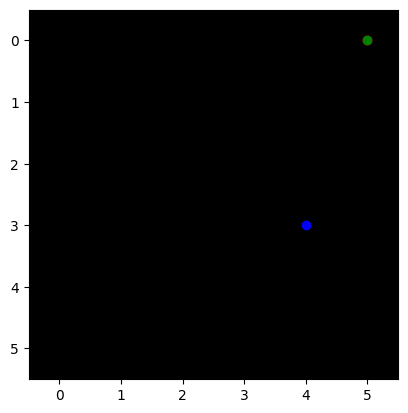

[0.009733079]
 gamma 0.8
[-1]
[0.009733079]
return [-1.0]
gae [-1.0097330790013075]
0.8298855320552795
tensor([[ 3.,  4., -1.,  1.]])
tensor([[ 3.,  4., -1.,  1.]])
tensor([[ 3.,  3., -1.,  0.]])
tensor([[ 3.,  3., -1.,  0.]])


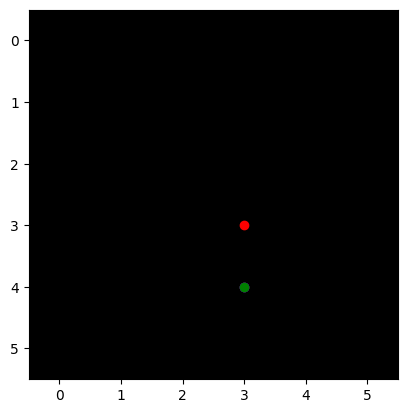

[0.060304374, 0.052665174]
 gamma 0.8
[0, 1]
[0.060304374, 0.052665174]
return [0.04213213920593262, 1.0]
gae [-0.018172234296798706, 0.9473348259925842]
0.9871763578619274
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 1.,  0., -1., -1.]])
tensor([[ 1.,  0., -1., -1.]])
tensor([[ 0.,  0., -2., -1.]])
tensor([[ 0.,  0., -2., -1.]])
tensor([[ 1.,  0., -1., -1.]])
tensor([[ 1.,  0., -1., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 2.,  0.,  0., -1.]])


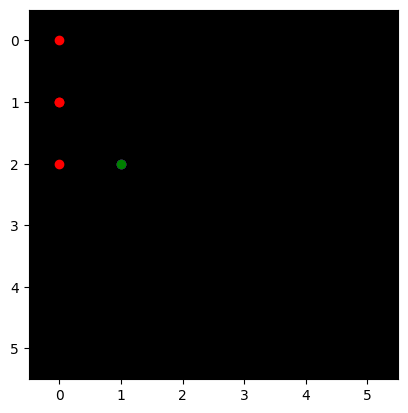

[-0.009094398, -0.023635834, -0.05776137, -0.023635834, -0.009094398]
 gamma 0.8
[0, 0, 0, 0, 1]
[-0.009094398, -0.023635834, -0.05776137, -0.023635834, -0.009094398]
return [-0.018908667564392093, -0.046209096908569336, -0.018908667564392093, -0.007275518029928207, 1.0]
gae [-0.009814270026981833, -0.022573262453079224, 0.03885270357131958, 0.016360316425561905, 1.0090943975374103]
0.08842916775016108
tensor([[ 2.,  0., -3., -3.]])


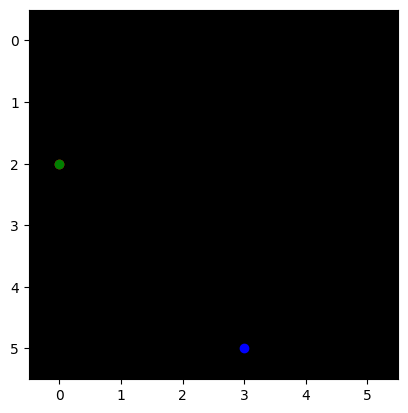

[-0.019110775]
 gamma 0.8
[-1]
[-0.019110775]
return [-1.0]
gae [-0.9808892253786325]
0.09762325019063933
tensor([[2., 4., 0., 2.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[2., 4., 0., 2.]])
tensor([[2., 3., 0., 1.]])
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  4., -1.,  2.]])
tensor([[ 1.,  5., -1.,  3.]])
tensor([[ 0.,  5., -2.,  3.]])
tensor([[ 0.,  5., -2.,  3.]])
tensor([[ 1.,  5., -1.,  3.]])


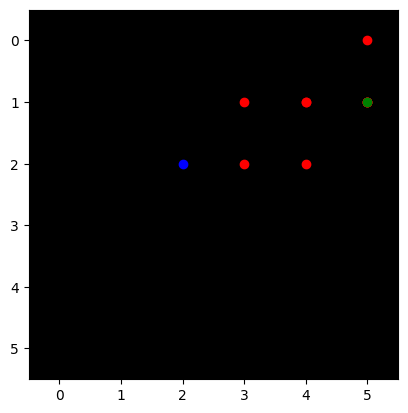

[0.057602182, 0.033452198, 0.057602182, 0.04786976, -0.0019322386, 0.033452198, 0.051497202, 0.027354114, 0.051497202]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.057602182, 0.033452198, 0.057602182, 0.04786976, -0.0019322386, 0.033452198, 0.051497202, 0.027354114, 0.051497202]
return [0.026761758327484134, 0.04608174562454224, 0.03829580843448639, -0.0015457908622920514, 0.026761758327484134, 0.0411977618932724, 0.021883291006088258, 0.0411977618932724, -1.0]
gae [-0.030840423703193662, 0.012629547715187074, -0.019306373596191403, -0.049415551405400035, 0.028693996905349198, 0.007745563983917236, -0.029613911360502242, 0.013843648135662079, -1.0514972023665905]
0.30538289952304587
tensor([[ 0.,  0.,  0., -5.]])
tensor([[ 1.,  0.,  1., -5.]])
tensor([[ 0.,  0.,  0., -5.]])


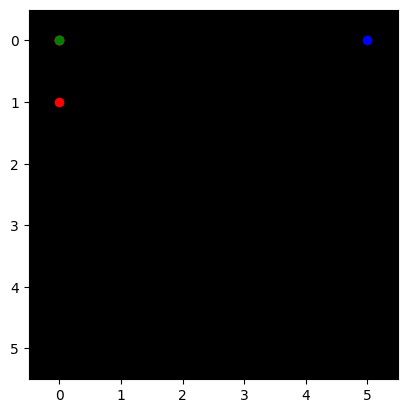

[-0.018139213, -0.012621023, -0.018139213]
 gamma 0.8
[0, 0, -1]
[-0.018139213, -0.012621023, -0.018139213]
return [-0.010096818208694458, -0.014511370658874513, -1.0]
gae [0.008042395114898682, -0.0018903478980064406, -0.9818607866764069]
0.06110371592151653
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 3.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 1.,  1., -1., -3.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 0.,  2., -2., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 3.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  0., -2.]])
tensor([[ 2.,  1.,  0., -3.]])
tensor([[ 2.,  0.,  0., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 4.,  0.,  2., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 4.,  0.,  2., -4.]])


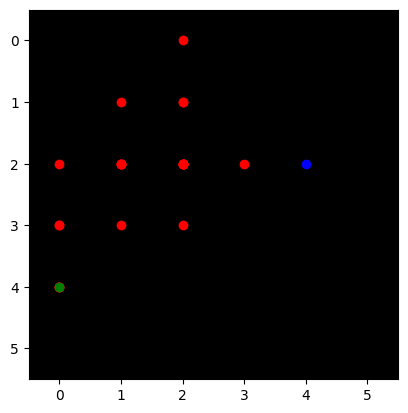

[0.04825066, -0.011405167, -0.0049639754, -0.011405167, -0.0049639754, 0.0011434103, -0.0049639754, -0.01672769, -0.045349933, -0.043091558, -0.045349933, -0.011405167, 0.022212539, -0.011405167, 0.04825066, -0.011405167, -0.0049639754, -0.007467824, -0.0062364945, 0.009999933, -0.0062364945, 0.009999933]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.04825066, -0.011405167, -0.0049639754, -0.011405167, -0.0049639754, 0.0011434103, -0.0049639754, -0.01672769, -0.045349933, -0.043091558, -0.045349933, -0.011405167, 0.022212539, -0.011405167, 0.04825066, -0.011405167, -0.0049639754, -0.007467824, -0.0062364945, 0.009999933, -0.0062364945, 0.009999933]
return [-0.009124133735895157, -0.003971180319786072, -0.009124133735895157, -0.003971180319786072, 0.0009147282689809799, -0.003971180319786072, -0.01338215172290802, -0.03627994656562805, -0.034473246335983275, -0.03627994656562805, -0.009124133735895157, 0.017770031094551088, -0.009124133735895157, 0.03

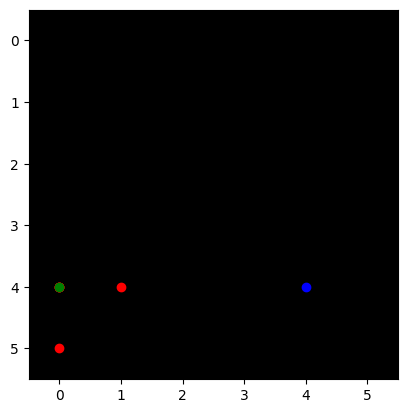

[0.27122983, 0.23897229, 0.27122983, 0.22353834, 0.27122983]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.27122983, 0.23897229, 0.27122983, 0.22353834, 0.27122983]
return [0.19117783308029176, 0.21698386669158937, 0.17883067131042482, 0.21698386669158937, -1.0]
gae [-0.08005200028419493, -0.02198842465877532, -0.09239916205406187, -0.006554472446441639, -1.2712298333644867]
0.38376891037007665
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 0.,  3., -5.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 0.,  4., -5.,  4.]])
tensor([[ 0.,  3., -5.,  3.]

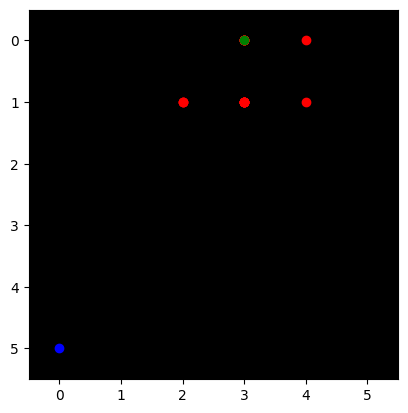

[0.24920443, 0.2759427, 0.27378345, 0.2759427, 0.27378345, 0.2759427, 0.27734432, 0.2759427, 0.27378345, 0.2759427, 0.24920443, 0.27269557, 0.27734432, 0.2759427, 0.27734432, 0.2759427, 0.27734432, 0.2759427, 0.27734432]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.24920443, 0.2759427, 0.27378345, 0.2759427, 0.27378345, 0.2759427, 0.27734432, 0.2759427, 0.27378345, 0.2759427, 0.24920443, 0.27269557, 0.27734432, 0.2759427, 0.27734432, 0.2759427, 0.27734432, 0.2759427, 0.27734432]
return [0.22075417041778567, 0.2190267562866211, 0.22075417041778567, 0.2190267562866211, 0.22075417041778567, 0.22187545299530032, 0.22075417041778567, 0.2190267562866211, 0.22075417041778567, 0.1993635416030884, 0.21815645694732666, 0.22187545299530032, 0.22075417041778567, 0.22187545299530032, 0.22075417041778567, 0.22187545299530032, 0.22075417041778567, 0.22187545299530032, -1.0]
gae [-0.028450256586074807, -0.05691595673561095, -0.0530292749404907, -0.05691595673561095, -0.0530

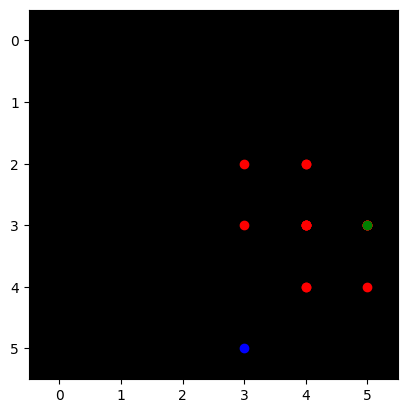

[0.17710313, 0.17795114, 0.1966081, 0.1801968, 0.1966081, 0.23401675, 0.26158428, 0.23401675, 0.1966081, 0.22960721, 0.1966081, 0.1801968, 0.17710313, 0.17795114, 0.1966081, 0.1801968]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.17710313, 0.17795114, 0.1966081, 0.1801968, 0.1966081, 0.23401675, 0.26158428, 0.23401675, 0.1966081, 0.22960721, 0.1966081, 0.1801968, 0.17710313, 0.17795114, 0.1966081, 0.1801968]
return [0.14236091375350954, 0.15728647708892823, 0.14415744543075562, 0.15728647708892823, 0.18721339702606202, 0.2092674255371094, 0.18721339702606202, 0.15728647708892823, 0.18368576765060426, 0.15728647708892823, 0.14415744543075562, 0.14168250560760498, 0.14236091375350954, 0.15728647708892823, 0.14415744543075562, -1.0]
gae [-0.03474221825599669, -0.020664665102958668, -0.05245065093040466, -0.022910329699516285, -0.009394699335098261, -0.024749320745468123, -0.0743708848953247, -0.07673026919364928, -0.012922328710556014, -0.07232073247432708, -0.052450650

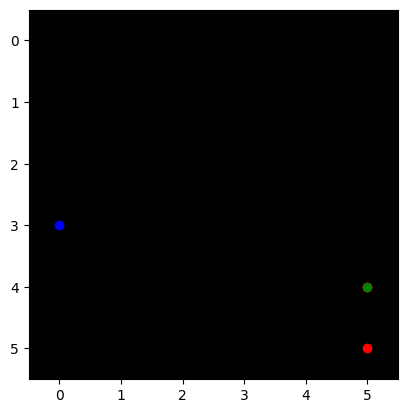

[0.17539743, 0.17427917, 0.17539743]
 gamma 0.8
[0, 0, -1]
[0.17539743, 0.17427917, 0.17539743]
return [0.13942333459854125, 0.1403179407119751, -1.0]
gae [-0.03597409129142762, -0.03396122753620148, -1.1753974258899689]
0.018249272002517247
tensor([[ 3.,  1.,  3., -4.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 2.,  4.,  2., -1.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[3., 5., 3., 0.]])
tensor([[4., 5., 4., 0.]])


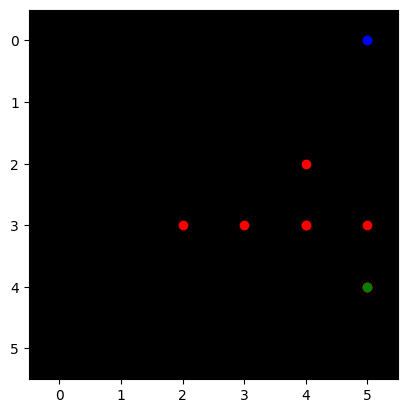

[0.21719702, 0.1810045, 0.20793729, 0.20420526, 0.1843835, 0.20420526, 0.18363355, 0.20826973]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.21719702, 0.1810045, 0.20793729, 0.20420526, 0.1843835, 0.20420526, 0.18363355, 0.20826973]
return [0.14480359554290773, 0.16634982824325562, 0.1633642077445984, 0.14750679731369018, 0.1633642077445984, 0.14690684080123903, 0.1666157841682434, -1.0]
gae [-0.07239342033863067, -0.014654666185379028, -0.044573077559471125, -0.056698462367057806, -0.021019288897514338, -0.057298418879508956, -0.01701776683330536, -1.2082697302103043]
return [0.22075418 0.22075418 0.22075418 0.22075418 0.22075418 0.22187546
 0.22187546 0.22187546 0.22187546 0.22187546]
return [-1.         -1.         -1.         -1.         -1.          0.13942334
  0.14031795  0.1416825   0.14236091  0.14236091]

-------------------- Iteration #52 --------------------
random  0.018249272002517247
Average : 0.01
Average Episodic Return: -0.64
Max Episodic Return: 1.0
Average Loss: -0.00591


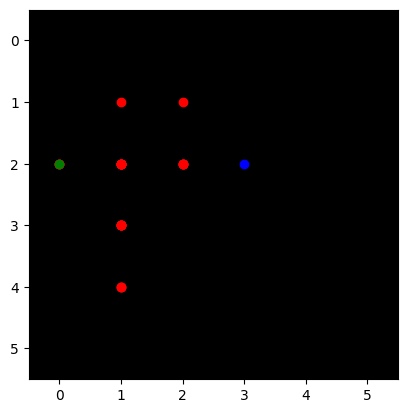

[0.21665062, 0.23914409, 0.25687933, 0.25289607, 0.25687933, 0.23914409, 0.21665062, 0.23914409, 0.25687933, 0.24749678, 0.25687933, 0.24749678, 0.25687933, 0.24749678, 0.25687933, 0.23914409, 0.21665062, 0.23914409, 0.21665062, 0.23914409, 0.25687933, 0.25933942, 0.25687933, 0.24749678, 0.26126626, 0.24749678, 0.25687933, 0.23914409, 0.25687933, 0.25289607]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.21665062, 0.23914409, 0.25687933, 0.25289607, 0.25687933, 0.23914409, 0.21665062, 0.23914409, 0.25687933, 0.24749678, 0.25687933, 0.24749678, 0.25687933, 0.24749678, 0.25687933, 0.23914409, 0.21665062, 0.23914409, 0.21665062, 0.23914409, 0.25687933, 0.25933942, 0.25687933, 0.24749678, 0.26126626, 0.24749678, 0.25687933, 0.23914409, 0.25687933, 0.25289607]
return [0.19131526947021485, 0.2055034637451172, 0.20231685638427735, 0.2055034637451172, 0.19131526947021485, 0.17332049608230593, 0.19131526947021485, 0.2055034637451172, 0.

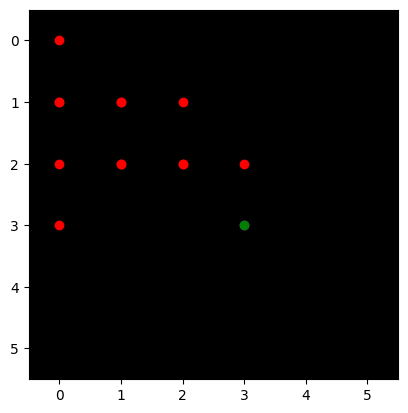

[0.25380477, 0.24391142, 0.25380477, 0.25219715, 0.24802083, 0.25219715, 0.25921133, 0.259752, 0.25921133, 0.25555453, 0.25956744, 0.259752, 0.25956744, 0.22493109]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.25380477, 0.24391142, 0.25380477, 0.25219715, 0.24802083, 0.25219715, 0.25921133, 0.259752, 0.25921133, 0.25555453, 0.25956744, 0.259752, 0.25956744, 0.22493109]
return [0.195129132270813, 0.20304381847381592, 0.20175771713256838, 0.19841666221618653, 0.20175771713256838, 0.207369065284729, 0.20780160427093508, 0.207369065284729, 0.20444362163543703, 0.20765395164489747, 0.20780160427093508, 0.20765395164489747, 0.17994487285614014, 1.0]
gae [-0.058675640821456904, -0.04086759686470032, -0.05204705595970152, -0.053780484199523915, -0.04626311063766478, -0.04482808113098144, -0.051409727334976174, -0.052382940053939814, -0.054767709970474227, -0.04790057539939879, -0.051765835285186745, -0.05209805369377135, -0.07962256669998169, 0.7750689089298248]
0.2067850944888353


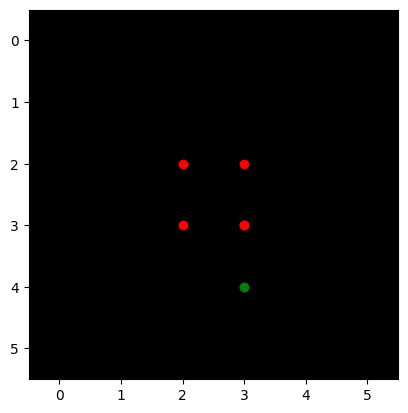

[0.25976416, 0.26030356, 0.24162419, 0.20178233, 0.24457769, 0.20178233]
 gamma 0.8
[0, 0, 0, 0, 0, 1]
[0.25976416, 0.26030356, 0.24162419, 0.20178233, 0.24457769, 0.20178233]
return [0.20824284553527833, 0.19329935312271118, 0.1614258646965027, 0.1956621527671814, 0.1614258646965027, 1.0]
gae [-0.05152131915092467, -0.06700420379638672, -0.08019832670688629, -0.006120178103446949, -0.08315182626247405, 0.7982176691293716]
return [0.20736906 0.20747153 0.20765395 0.20765395 0.20780161 0.20780161
 0.20824285 0.20901302 1.         1.        ]
return [-1.          0.16142586  0.16142586  0.1733205   0.1733205   0.1733205
  0.17994487  0.19131526  0.19131526  0.19131526]

-------------------- Iteration #53 --------------------
random  0.2067850944888353
Average : 0.01
Average Episodic Return: -0.62
Max Episodic Return: 1.0
Average Loss: -0.0058
Average Loss Critic: 0.22917048633098602
TEntropy: nan
approx_kl_divs: [0.00022944939] secs
------------------------------------------------------


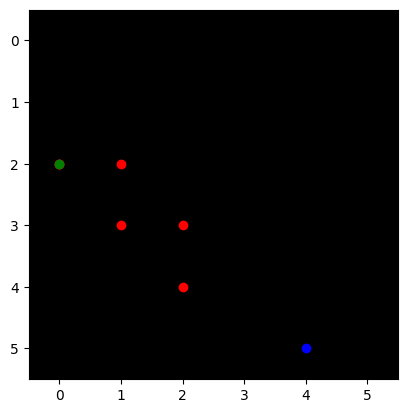

[-0.042528726, -0.033044565, -0.042528726, -0.0940894, -0.10730917, -0.100681305]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.042528726, -0.033044565, -0.042528726, -0.0940894, -0.10730917, -0.100681305]
return [-0.026435652375221254, -0.03402298092842102, -0.07527151703834534, -0.08584733605384827, -0.0805450439453125, -1.0]
gae [0.016093073785305022, -0.0009784154593944563, -0.03274279087781906, 0.008242060244083402, 0.026764126121997828, -0.8993186950683594]
0.6918672873045523
tensor([[ 5.,  1.,  4., -4.]])
tensor([[ 5.,  1.,  4., -4.]])
tensor([[ 5.,  0.,  4., -5.]])


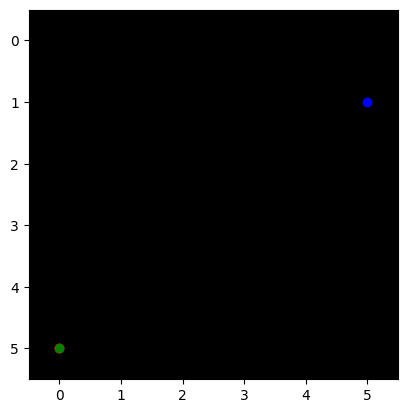

[-0.043535247, -0.08626089]
 gamma 0.8
[0, -1]
[-0.043535247, -0.08626089]
return [-0.06900871396064759, -1.0]
gae [-0.025473466515541082, -0.9137391075491905]
0.19054887692886058
tensor([[ 0.,  4., -1.,  2.]])
tensor([[1., 4., 0., 2.]])
tensor([[1., 5., 0., 3.]])
tensor([[ 0.,  5., -1.,  3.]])
tensor([[ 0.,  4., -1.,  2.]])
tensor([[ 0.,  5., -1.,  3.]])
tensor([[ 0.,  4., -1.,  2.]])
tensor([[ 0.,  3., -1.,  1.]])


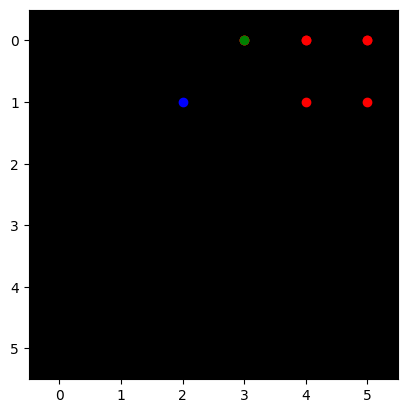

[-0.017796231, -0.019770877, -0.02084553, -0.018506024, -0.017796231, -0.018506024, -0.017796231, -0.050739486]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.017796231, -0.019770877, -0.02084553, -0.018506024, -0.017796231, -0.018506024, -0.017796231, -0.050739486]
return [-0.015816701948642733, -0.016676424443721773, -0.014804819226264955, -0.01423698514699936, -0.014804819226264955, -0.01423698514699936, -0.04059158861637116, -1.0]
gae [0.001979529485106466, 0.00309445299208164, 0.006040711328387259, 0.0042690388858318325, 0.002991412207484244, 0.0042690388858318325, -0.02279535718262196, -0.9492605142295361]
0.11710893996625005
tensor([[ 3.,  3., -1.,  0.]])
tensor([[ 2.,  3., -2.,  0.]])
tensor([[ 2.,  3., -2.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 0.,  3., -4.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  3., -3.,  0.]])
tensor([[ 1.,  4., -3.,  1.]])
tensor([[ 0.,  4., -4.,  1.]])
tensor([[ 0.,  5., -4.,  2.]])


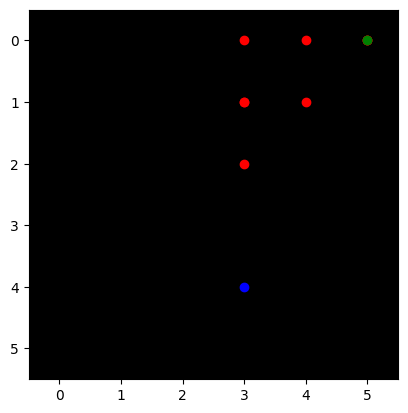

[-0.018846873, -0.018068574, -0.025363667, -0.060086634, -0.025363667, -0.016830726, -0.021631464, -0.015839124]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.018846873, -0.018068574, -0.025363667, -0.060086634, -0.025363667, -0.016830726, -0.021631464, -0.015839124]
return [-0.014454859495162965, -0.020290933549404144, -0.04806930720806122, -0.020290933549404144, -0.013464580476284028, -0.017305171489715578, -0.012671299278736115, -1.0]
gae [0.004392013698816298, -0.0022223591804504395, -0.02270564027130604, 0.03979570046067238, 0.011899086460471152, -0.0004744458943605444, 0.008960165083408356, -0.9841608759015799]
0.04371340324868678
tensor([[ 1.,  1., -1.,  1.]])
tensor([[2., 1., 0., 1.]])
tensor([[2., 2., 0., 2.]])
tensor([[ 1.,  2., -1.,  2.]])
tensor([[ 1.,  3., -1.,  3.]])
tensor([[ 1.,  2., -1.,  2.]])
tensor([[ 0.,  2., -2.,  2.]])
tensor([[ 1.,  2., -1.,  2.]])
tensor([[ 0.,  2., -2.,  2.]])


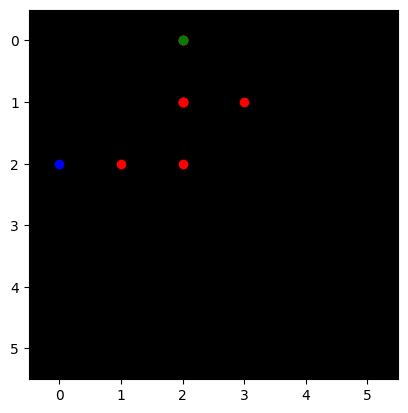

[-0.08342727, -0.0802183, -0.023348989, -0.036275882, -0.023701357, -0.036275882, -0.079863824, -0.036275882, -0.079863824]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.08342727, -0.0802183, -0.023348989, -0.036275882, -0.023701357, -0.036275882, -0.079863824, -0.036275882, -0.079863824]
return [-0.06417464017868042, -0.018679191172122956, -0.029020705819129945, -0.01896108537912369, -0.029020705819129945, -0.06389105916023255, -0.029020705819129945, -0.06389105916023255, -1.0]
gae [0.019252632558345792, 0.06153910905122757, -0.005671716853976251, 0.01731479689478874, -0.0053193490952253356, -0.02761517688632012, 0.050843118131160735, -0.02761517688632012, -0.9201361760497093]
0.430568748278534
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 1.,  4., -3., -1.]])
tensor([[ 1.,  4., -3., -1.]])
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 2.,  5., -2.,  0.]])
tensor([[ 2.,  5., -2.,  0.]])


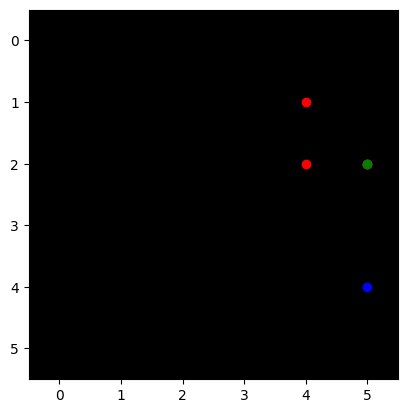

[-0.017083928, -0.017972568, -0.017083928, -0.016503995]
 gamma 0.8
[0, 0, 0, -1]
[-0.017083928, -0.017972568, -0.017083928, -0.016503995]
return [-0.014378054440021515, -0.013667142391204834, -0.013203196227550507, -1.0]
gae [0.0027058735489845272, 0.004305425658822059, 0.003880731761455536, -0.9834960047155619]
0.3478067152722958
tensor([[ 3.,  0.,  2., -5.]])


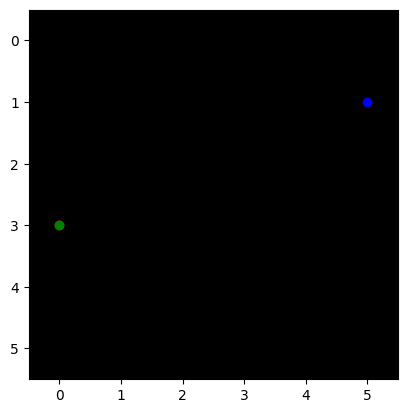

[-0.09507788]
 gamma 0.8
[-1]
[-0.09507788]
return [-1.0]
gae [-0.9049221202731133]
0.8431234781255534
tensor([[ 5.,  1.,  0., -2.]])
tensor([[ 5.,  1.,  0., -2.]])


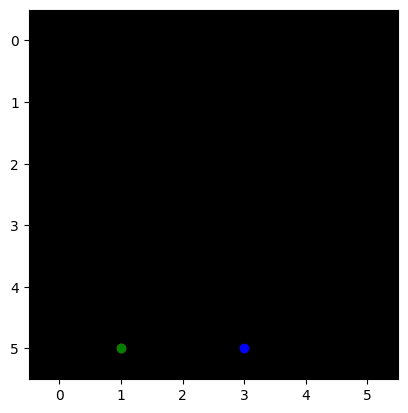

[-0.04208032]
 gamma 0.8
[-1]
[-0.04208032]
return [-1.0]
gae [-0.957919679582119]
0.6133109964228004
tensor([[ 1.,  5., -2.,  2.]])
tensor([[ 1.,  5., -2.,  2.]])
tensor([[ 2.,  5., -1.,  2.]])
tensor([[3., 5., 0., 2.]])
tensor([[3., 5., 0., 2.]])


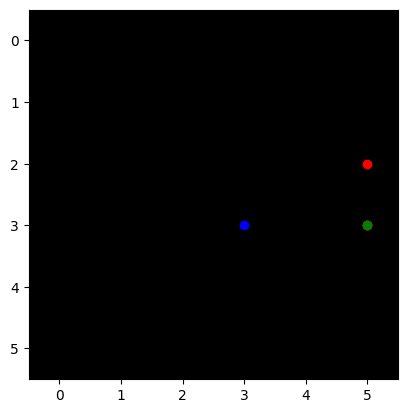

[-0.017533494, -0.01985867, -0.02140986]
 gamma 0.8
[0, 0, -1]
[-0.017533494, -0.01985867, -0.02140986]
return [-0.015886935591697692, -0.017127887904644014, -1.0]
gae [0.0016465585678815849, 0.0027307815849781022, -0.978590140119195]
0.06360302215428526
tensor([[ 2.,  5., -3.,  5.]])


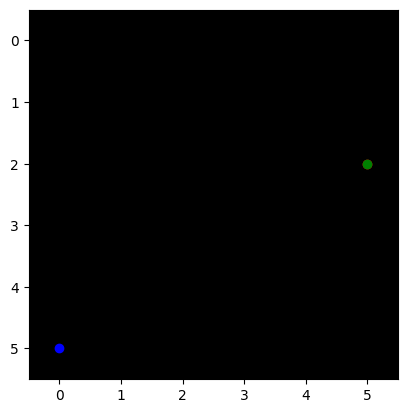

[-0.02760229]
 gamma 0.8
[-1]
[-0.02760229]
return [-1.0]
gae [-0.9723977092653513]
0.04954308941443808
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  5., -2.,  3.]])
tensor([[ 4.,  5., -1.,  3.]])
tensor([[ 3.,  5., -2.,  3.]])
tensor([[ 2.,  5., -3.,  3.]])


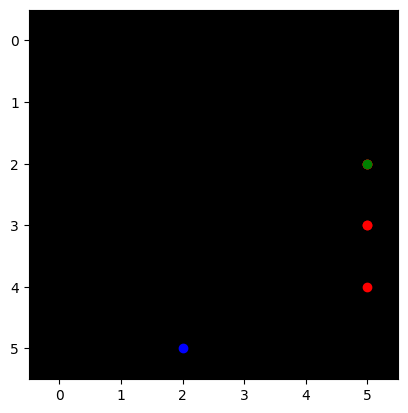

[-0.021470957, -0.02368137, -0.02698346, -0.02368137, -0.021026969]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.021470957, -0.02368137, -0.02698346, -0.02368137, -0.021026969]
return [-0.01894509643316269, -0.021586768329143524, -0.01894509643316269, -0.016821575164794923, -1.0]
gae [0.002525860071182249, 0.0020946022123098373, 0.008038363978266714, 0.006859795376658439, -0.9789730310440063]
0.18801602637478976
tensor([[ 5.,  1.,  3., -3.]])


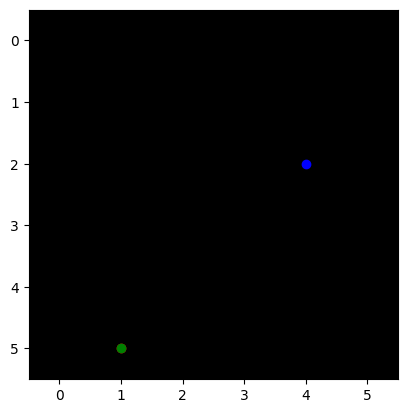

[-0.038605016]
 gamma 0.8
[-1]
[-0.038605016]
return [-1.0]
gae [-0.9613949842751026]
0.38829593161982434
tensor([[4., 5., 4., 2.]])
tensor([[4., 5., 4., 2.]])
tensor([[4., 4., 4., 1.]])
tensor([[4., 4., 4., 1.]])
tensor([[4., 5., 4., 2.]])
tensor([[4., 5., 4., 2.]])


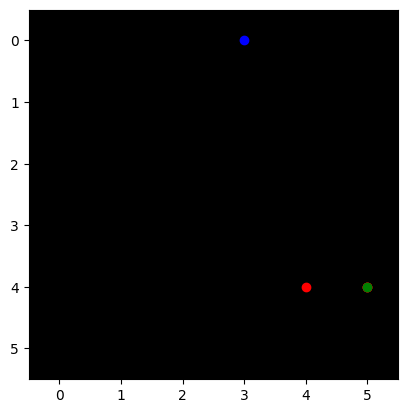

[-0.011023983, -0.01658114, -0.011023983]
 gamma 0.8
[0, 0, -1]
[-0.011023983, -0.01658114, -0.011023983]
return [-0.013264912366867066, -0.008819186687469482, -1.0]
gae [-0.0022409290075302134, 0.00776195377111435, -0.9889760166406631]
return [-0.01445486 -0.01437805 -0.01423698 -0.01423698 -0.01366714 -0.01346458
 -0.01326491 -0.0132032  -0.0126713  -0.00881919]
return [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

-------------------- Iteration #54 --------------------
random  0.38829593161982434
Average : 0.01
Average Episodic Return: -0.7
Max Episodic Return: 1.0
Average Loss: -0.00578
Average Loss Critic: 0.2300897091627121
TEntropy: nan
approx_kl_divs: [0.00010978553] secs
------------------------------------------------------

0.32857208816335726
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  1., -4.]])
tensor([[ 4.,  0.,  2., -4.]])
tensor([[ 4.,  0.,  2., -4.]])
tensor([[ 5.,  0.,  3., -4.]])


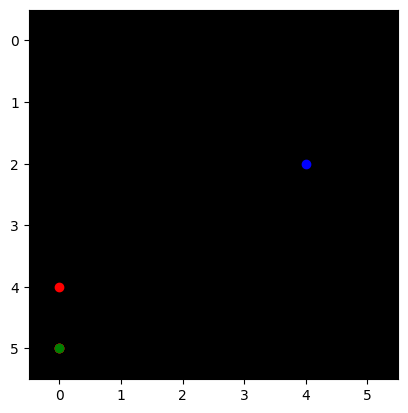

[0.007854591, 0.012945293, 0.0104273055]
 gamma 0.8
[0, 0, -1]
[0.007854591, 0.012945293, 0.0104273055]
return [0.010356234759092331, 0.008341844379901887, -1.0]
gae [0.0025016436353325847, -0.004603449068963527, -1.0104273054748774]
0.5212412404830655
tensor([[ 2.,  0., -2., -2.]])


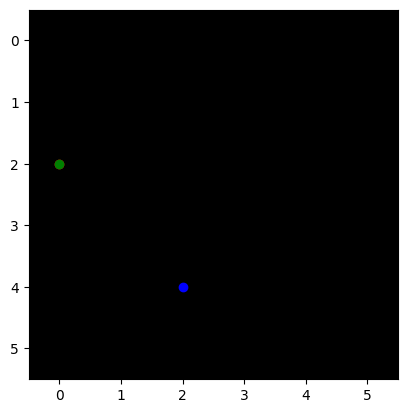

[0.004701349]
 gamma 0.8
[-1]
[0.004701349]
return [-1.0]
gae [-1.004701348952949]
0.1854459097279526
tensor([[ 2.,  2., -1.,  0.]])
tensor([[ 2.,  2., -1.,  0.]])
tensor([[ 1.,  2., -2.,  0.]])
tensor([[ 1.,  3., -2.,  1.]])
tensor([[ 1.,  3., -2.,  1.]])
tensor([[ 0.,  3., -3.,  1.]])


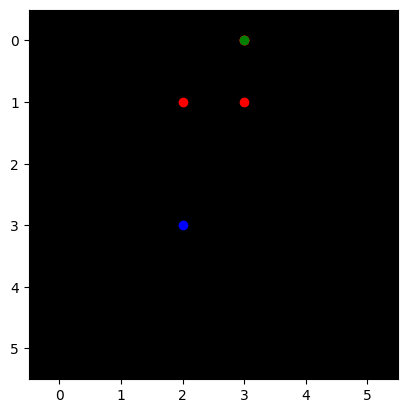

[0.011470247, 0.020130299, 0.030732732, 0.022310235]
 gamma 0.8
[0, 0, 0, -1]
[0.011470247, 0.020130299, 0.030732732, 0.022310235]
return [0.016104239225387573, 0.024586185812950134, 0.01784818768501282, -1.0]
gae [0.0046339921653270714, 0.004455886781215668, -0.012884544581174849, -1.022310234606266]
0.37735635129556655


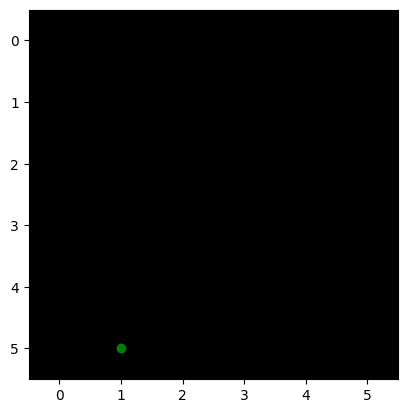

[0.007854591, 0.012945293, 0.0104273055, 0.004701349, 0.011470247, 0.020130299, 0.030732732, 0.022310235]
 gamma 0.8
[]
[0.007854591, 0.012945293, 0.0104273055, 0.004701349, 0.011470247, 0.020130299, 0.030732732, 0.022310235]
return []
gae []
0.9490864750670729
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 0.,  1., -2., -2.]])
tensor([[ 0.,  1., -2., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  0.,  0., -3.]])
tensor([[ 2.,  0.,  0., -

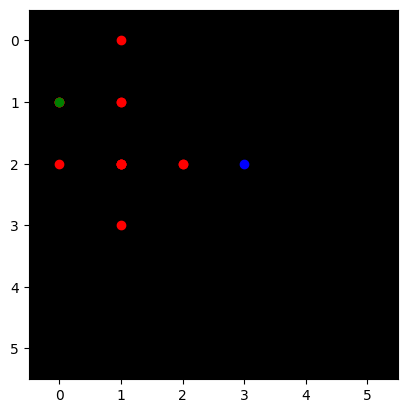

[0.008996139, 0.008332775, 0.0061971946, 0.008332775, 0.008996139, 0.014497486, 0.008996139, 0.014530217, 0.008996139, 0.014497486, 0.008996139, 0.006993947, 0.0067837466]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.008996139, 0.008332775, 0.0061971946, 0.008332775, 0.008996139, 0.014497486, 0.008996139, 0.014530217, 0.008996139, 0.014497486, 0.008996139, 0.006993947, 0.0067837466]
return [0.006666219979524613, 0.004957755655050278, 0.006666219979524613, 0.007196911424398423, 0.011597988754510881, 0.007196911424398423, 0.01162417382001877, 0.007196911424398423, 0.011597988754510881, 0.007196911424398423, 0.0055951576679945, 0.005426997318863869, -1.0]
gae [-0.002329919300973415, -0.0033750193193554873, 0.00046902541071176546, -0.0011358635500073426, 0.002601849474012853, -0.0073005745187401765, 0.002628034539520742, -0.0073333058506250375, 0.002601849474012853, -0.0073005745187401765, -0.003400981612503528, -0.0015669497661292553, -1.0067837466485798]
0.2834325558144245
tens

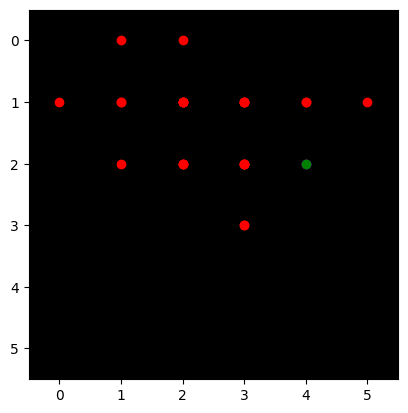

[0.022246668, 0.031308457, 0.009150302, 0.031308457, 0.022246668, 0.009478993, 0.022246668, 0.009478993, 0.022246668, 0.031308457, 0.022246668, 0.013472115, 0.009178038, 0.013472115, 0.009150302, 0.013472115, 0.009150302, 0.0073230076, 0.008590643, 0.008750267, 0.0077998247, 0.008750267, 0.009150302, 0.031308457, 0.03145293, 0.021506337, 0.03145293]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.022246668, 0.031308457, 0.009150302, 0.031308457, 0.022246668, 0.009478993, 0.022246668, 0.009478993, 0.022246668, 0.031308457, 0.022246668, 0.013472115, 0.009178038, 0.013472115, 0.009150302, 0.013472115, 0.009150302, 0.0073230076, 0.008590643, 0.008750267, 0.0077998247, 0.008750267, 0.009150302, 0.031308457, 0.03145293, 0.021506337, 0.03145293]
return [0.02504676580429077, 0.007320241630077363, 0.02504676580429077, 0.017797334492206576, 0.007583194226026536, 0.017797334492206576, 0.007583194226026536, 0.017797334492206576, 0.02504676580429077, 

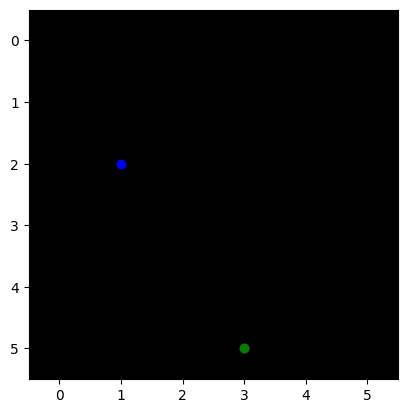

[0.0025407618]
 gamma 0.8
[-1]
[0.0025407618]
return [-1.0]
gae [-1.0025407618377358]
0.13321726739189954
tensor([[1., 3., 0., 3.]])
tensor([[1., 2., 0., 2.]])
tensor([[1., 3., 0., 3.]])
tensor([[2., 3., 1., 3.]])
tensor([[2., 2., 1., 2.]])
tensor([[2., 1., 1., 1.]])
tensor([[1., 1., 0., 1.]])
tensor([[1., 2., 0., 2.]])
tensor([[1., 3., 0., 3.]])
tensor([[1., 3., 0., 3.]])
tensor([[ 0.,  3., -1.,  3.]])
tensor([[ 0.,  2., -1.,  2.]])
tensor([[ 0.,  1., -1.,  1.]])


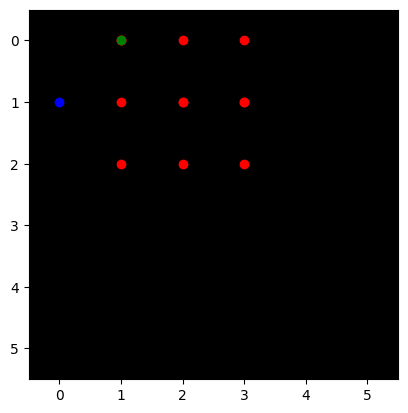

[0.031742454, 0.019868024, 0.031742454, 0.021246841, 0.022114567, 0.010848916, 0.006920391, 0.019868024, 0.031742454, 0.023691326, 0.023108302, 0.0060562347]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.031742454, 0.019868024, 0.031742454, 0.021246841, 0.022114567, 0.010848916, 0.006920391, 0.019868024, 0.031742454, 0.023691326, 0.023108302, 0.0060562347]
return [0.015894418954849245, 0.025393962860107422, 0.01699747294187546, 0.017691653966903687, 0.008679132908582687, 0.0055363129824399955, 0.015894418954849245, 0.025393962860107422, 0.018953061103820803, 0.018486641347408295, 0.004844987764954567, -1.0]
gae [-0.015848034620285032, 0.005525939166545868, -0.014744980633258818, -0.003555187210440635, -0.01343543455004692, -0.005312603153288364, 0.008974027726799252, 0.005525939166545868, -0.012789392471313474, -0.005204685032367706, -0.0182633139193058, -1.0060562347061932]
return [0.02458619 0.02504677 0.02504677 0.02504677 0.02504677 0.02516234
 0.02516234 0.02539396 0.0253939

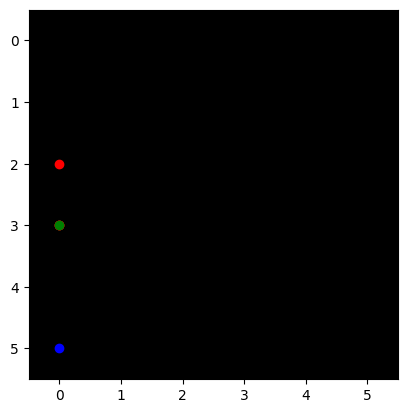

[0.15262419, 0.1503532, 0.14773417]
 gamma 0.8
[0, 0, -1]
[0.15262419, 0.1503532, 0.14773417]
return [0.12028255462646485, 0.11818733215332032, -1.0]
gae [-0.03234163522720336, -0.032165861129760734, -1.1477341651916504]
0.25920862163790637
tensor([[ 0.,  3., -4., -1.]])


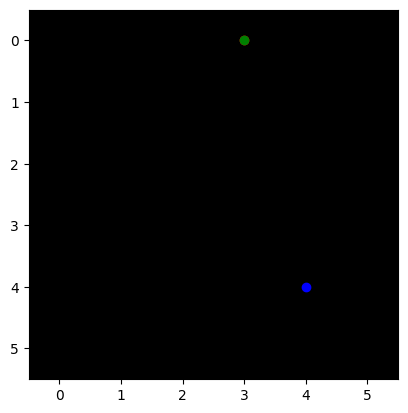

[0.18397637]
 gamma 0.8
[-1]
[0.18397637]
return [-1.0]
gae [-1.1839763671159744]
0.8748871168208165
tensor([[ 2.,  4.,  0., -1.]])


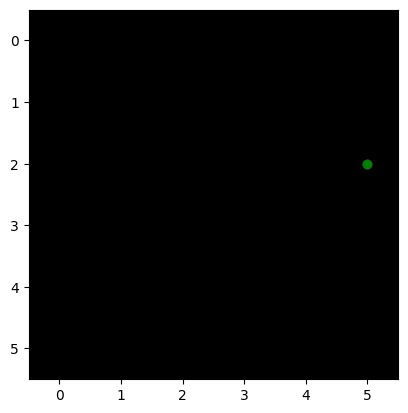

[0.16891463]
 gamma 0.8
[1]
[0.16891463]
return [1.0]
gae [0.8310853689908981]
0.6422462338763858
tensor([[ 0.,  5., -4.,  0.]])


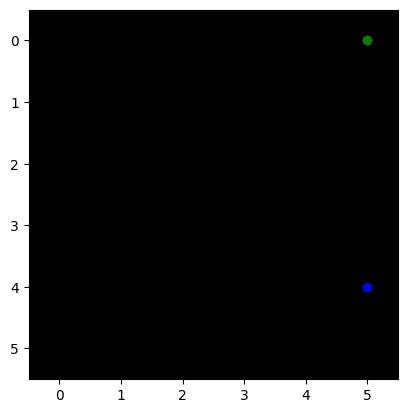

[0.1609415]
 gamma 0.8
[-1]
[0.1609415]
return [-1.0]
gae [-1.1609414964914322]
0.341626393984814
tensor([[5., 2., 0., 1.]])
tensor([[5., 2., 0., 1.]])
tensor([[ 4.,  2., -1.,  1.]])
tensor([[ 4.,  1., -1.,  0.]])
tensor([[ 4.,  1., -1.,  0.]])


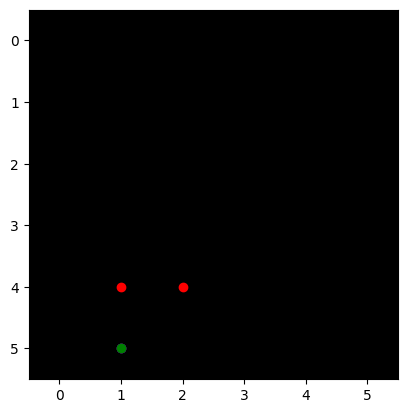

[0.14671317, 0.1540669, 0.13639994]
 gamma 0.8
[0, 0, 1]
[0.14671317, 0.1540669, 0.13639994]
return [0.12325352430343628, 0.1091199517250061, 1.0]
gae [-0.023459643125534058, -0.044946953654289246, 0.8636000603437424]
0.7805648423694467
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 2.,  3., -1.,  2.]])
tensor([[ 2.,  3., -1.,  2.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[ 2.,  3., -1.,  2.]])
tensor([[ 2.,  3., -1.,  2.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[ 1.,  5., -2.,  4.]])
tensor([[ 1.,  5., -2.,  4.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[ 2.,  5., -1.,  4.]])


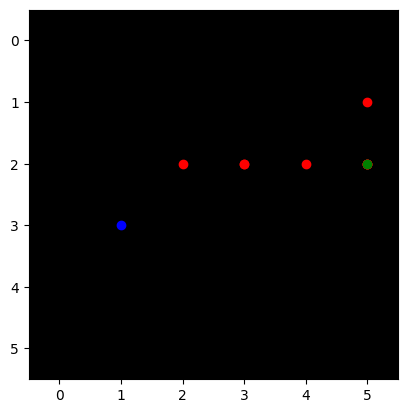

[0.1620334, 0.16022645, 0.16941419, 0.16022645, 0.15819144, 0.1544467, 0.15561129, 0.1544467]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.1620334, 0.16022645, 0.16941419, 0.16022645, 0.15819144, 0.1544467, 0.15561129, 0.1544467]
return [0.12818115949630737, 0.1355313539505005, 0.12818115949630737, 0.12655315399169922, 0.12355736494064332, 0.1244890332221985, 0.12355736494064332, -1.0]
gae [-0.0338522344827652, -0.02469509541988371, -0.04123303294181824, -0.03367329537868499, -0.03463407754898071, -0.029957672953605644, -0.03205392658710479, -1.1544467061758041]
0.18965427932650492
tensor([[4., 1., 2., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[4., 2., 2., 1.]])
tensor([[5., 2., 3., 1.]])
tensor([[5., 2., 3., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 1., 2., 0.]])
tensor([[3., 1., 1., 0.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 3.,  0.,  1., -1.]])


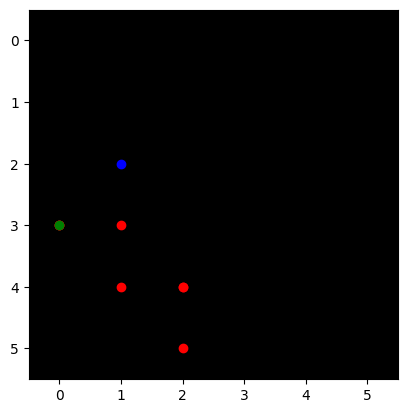

[0.14918847, 0.1517908, 0.14625289, 0.1517908, 0.14918847, 0.15291572, 0.1569316]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.14918847, 0.1517908, 0.14625289, 0.1517908, 0.14918847, 0.15291572, 0.1569316]
return [0.12143263816833497, 0.11700230836868286, 0.12143263816833497, 0.11935077905654908, 0.12233257293701172, 0.12554527521133424, -1.0]
gae [-0.027755835652351374, -0.03478848934173584, -0.02482024729251861, -0.032440018653869626, -0.02685590088367462, -0.02737044095993041, -1.1569315940141678]
0.38449428958747545
tensor([[3., 5., 0., 1.]])


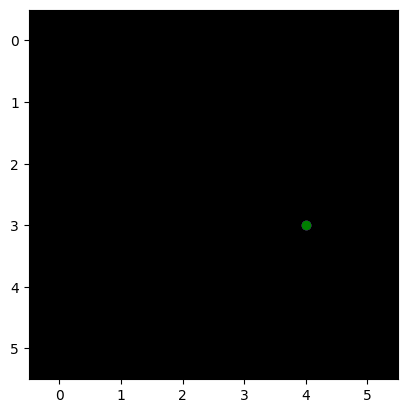

[0.15798609]
 gamma 0.8
[1]
[0.15798609]
return [1.0]
gae [0.8420139104127884]
0.7231880691208833
tensor([[ 0.,  5., -1.,  5.]])
tensor([[ 0.,  5., -1.,  5.]])


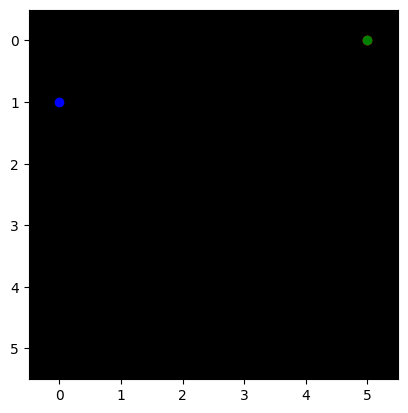

[0.15308039]
 gamma 0.8
[-1]
[0.15308039]
return [-1.0]
gae [-1.1530803889036179]
0.5993583413385166
tensor([[ 2.,  0.,  0., -5.]])
tensor([[ 3.,  0.,  1., -5.]])
tensor([[ 3.,  0.,  1., -5.]])


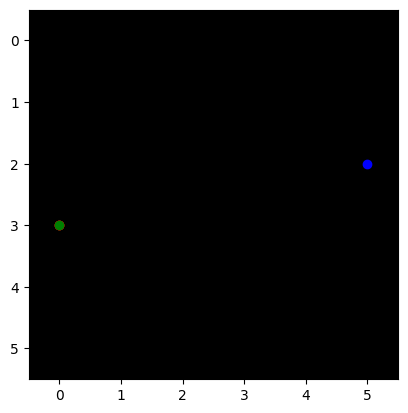

[0.16675057, 0.16660073]
 gamma 0.8
[0, -1]
[0.16675057, 0.16660073]
return [0.1332805871963501, -1.0]
gae [-0.03346997797489165, -1.1666007339954376]
0.9970306506897839
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 0.,  3., -3., -2.]])
tensor([[ 0.,  3., -3., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 0.,  3., -3., -2.]])
tensor([[ 0.,  3., -3., -2.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 0.,  4., -3., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  2., -1., 

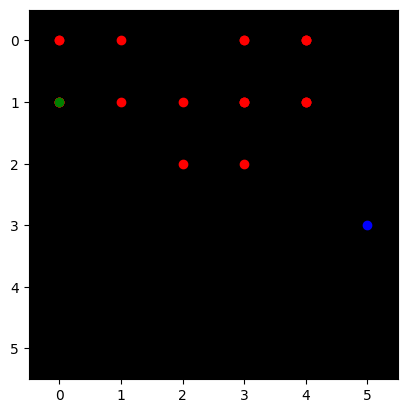

[0.17171407, 0.18429746, 0.1640673, 0.18078667, 0.1640673, 0.18078667, 0.18584757, 0.18429746, 0.18584757, 0.18078667, 0.1640673, 0.18429746, 0.17171407, 0.17431203, 0.15699358, 0.16624485, 0.16700037, 0.16619645, 0.15644482, 0.16619645, 0.16700037]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.17171407, 0.18429746, 0.1640673, 0.18078667, 0.1640673, 0.18078667, 0.18584757, 0.18429746, 0.18584757, 0.18078667, 0.1640673, 0.18429746, 0.17171407, 0.17431203, 0.15699358, 0.16624485, 0.16700037, 0.16619645, 0.15644482, 0.16619645, 0.16700037]
return [0.14743796586990357, 0.13125383853912354, 0.1446293354034424, 0.13125383853912354, 0.1446293354034424, 0.14867805242538454, 0.14743796586990357, 0.14867805242538454, 0.1446293354034424, 0.13125383853912354, 0.14743796586990357, 0.13737125396728517, 0.1394496202468872, 0.12559486627578736, 0.13299587965011597, 0.13360029458999634, 0.13295716047286987, 0.1251558542251587, 0.13295716047286987, 0.13360029458999634, -

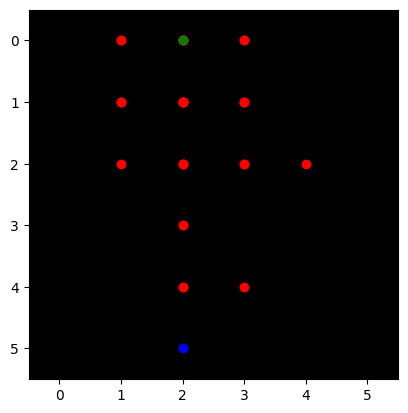

[0.16248363, 0.17896344, 0.16248363, 0.17009635, 0.16557615, 0.16950212, 0.17061347, 0.17009635, 0.17061347, 0.17009635, 0.17061347, 0.16950212, 0.17061347, 0.17896344, 0.15982205, 0.15216997, 0.15544513, 0.15216997, 0.15982205, 0.17896344, 0.15720308, 0.15732555, 0.15720308, 0.17563875, 0.17782542, 0.17563875, 0.17061347, 0.16950212, 0.17061347, 0.17563875, 0.17782542, 0.16950212, 0.16557615, 0.16950212]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.16248363, 0.17896344, 0.16248363, 0.17009635, 0.16557615, 0.16950212, 0.17061347, 0.17009635, 0.17061347, 0.17009635, 0.17061347, 0.16950212, 0.17061347, 0.17896344, 0.15982205, 0.15216997, 0.15544513, 0.15216997, 0.15982205, 0.17896344, 0.15720308, 0.15732555, 0.15720308, 0.17563875, 0.17782542, 0.17563875, 0.17061347, 0.16950212, 0.17061347, 0.17563875, 0.17782542, 0.16950212, 0.16557615, 0.16950212]
return [0.1431707501411438, 0.12998690605163574, 0.1360770821571350

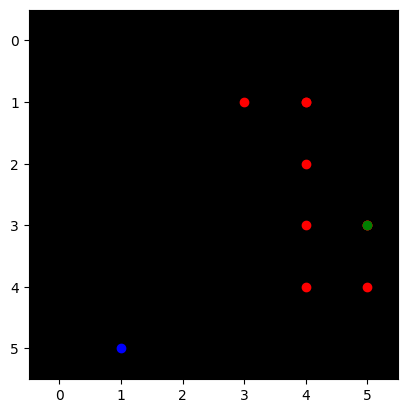

[0.31580466, 0.31785563, 0.32377586, 0.31785563, 0.32272252, 0.32195312, 0.32033917, 0.31626362, 0.31852078]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.31580466, 0.31785563, 0.32377586, 0.31785563, 0.32272252, 0.32195312, 0.32033917, 0.31626362, 0.31852078]
return [0.25428450107574463, 0.25902068614959717, 0.25428450107574463, 0.2581780195236206, 0.25756249427795413, 0.2562713384628296, 0.253010892868042, 0.25481662750244144, -1.0]
gae [-0.061520159244537354, -0.05883494019508362, -0.06949135661125183, -0.05967760682106016, -0.06516003012657162, -0.065681779384613, -0.06732828021049497, -0.06144698858261105, -1.3185207843780518]
0.853088624758068


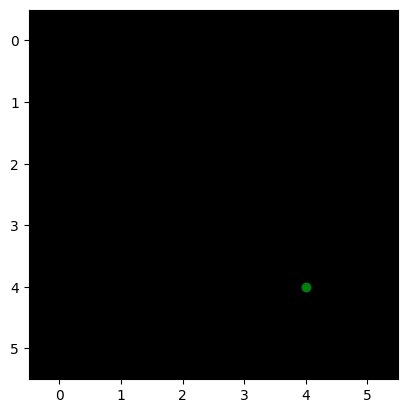

[0.31580466, 0.31785563, 0.32377586, 0.31785563, 0.32272252, 0.32195312, 0.32033917, 0.31626362, 0.31852078]
 gamma 0.8
[]
[0.31580466, 0.31785563, 0.32377586, 0.31785563, 0.32272252, 0.32195312, 0.32033917, 0.31626362, 0.31852078]
return []
gae []
0.4238891867133575
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 1.,  1., -4.,  1.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  0., -5.,  0.]])


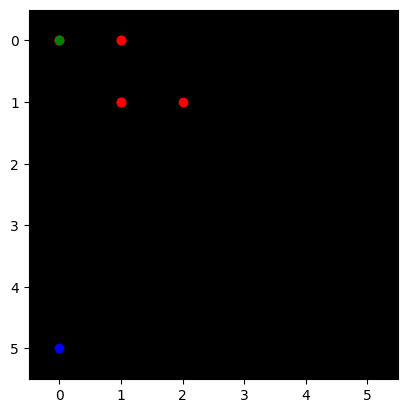

[0.3565757, 0.34294495, 0.33551615, 0.34923252, 0.33551615, 0.34294495, 0.27720308]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.3565757, 0.34294495, 0.33551615, 0.34923252, 0.33551615, 0.34294495, 0.27720308]
return [0.27435595989227296, 0.26841292381286624, 0.2793860197067261, 0.26841292381286624, 0.27435595989227296, 0.22176246643066408, -1.0]
gae [-0.0822197377681732, -0.07453202605247494, -0.056130135059356656, -0.08081960082054135, -0.0611601948738098, -0.12118248343467711, -1.27720308303833]
0.9607302344212949
tensor([[ 1.,  3., -3., -1.]])
tensor([[ 1.,  3., -3., -1.]])
tensor([[ 0.,  3., -4., -1.]])
tensor([[ 0.,  3., -4., -1.]])
tensor([[ 1.,  3., -3., -1.]])
tensor([[ 0.,  3., -4., -1.]])
tensor([[ 0.,  3., -4., -1.]])
tensor([[ 0.,  2., -4., -2.]])
tensor([[ 0.,  2., -4., -2.]])
tensor([[ 0.,  1., -4., -3.]])
tensor([[ 0.,  2., -4., -2.]])
tensor([[ 0.,  2., -4., -2.]])
tensor([[ 1.,  2., -3., -2.]])
tensor([[ 1.,  2., -3., -2.]])
tensor([[ 1.,  1., -3., -3.]])
tensor([[ 1.,  1., -

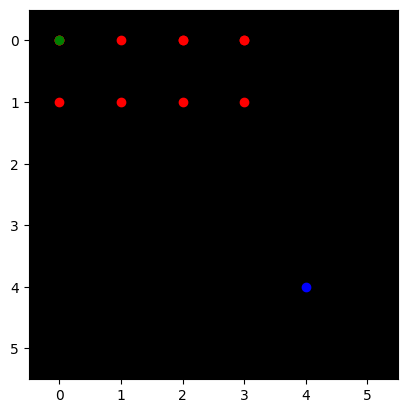

[0.33563858, 0.35116214, 0.33563858, 0.35116214, 0.3203078, 0.2557235, 0.3203078, 0.26999155, 0.24886025, 0.24864987, 0.24912143]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.33563858, 0.35116214, 0.33563858, 0.35116214, 0.3203078, 0.2557235, 0.3203078, 0.26999155, 0.24886025, 0.24864987, 0.24912143]
return [0.280929708480835, 0.2685108661651611, 0.280929708480835, 0.2562462329864502, 0.20457880496978761, 0.2562462329864502, 0.21599323749542237, 0.19908820390701296, 0.1989198923110962, 0.1992971420288086, -1.0]
gae [-0.05470887422561643, -0.08265126943588258, -0.05470887422561643, -0.09491590261459348, -0.11572898626327513, 0.0005227267742157204, -0.10431455373764037, -0.070903342962265, -0.04994036257266998, -0.049352723360061634, -1.2491214275360107]
0.8963440984171126
tensor([[ 0.,  4., -4.,  4.]])
tensor([[ 0.,  4., -4.,  4.]])


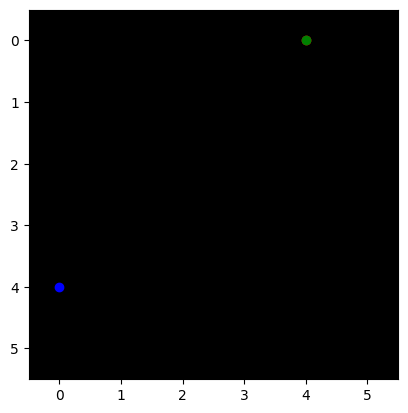

[0.31652826]
 gamma 0.8
[-1]
[0.31652826]
return [-1.0]
gae [-1.3165282607078552]
0.20312506045557888
tensor([[ 0.,  5., -2.,  2.]])


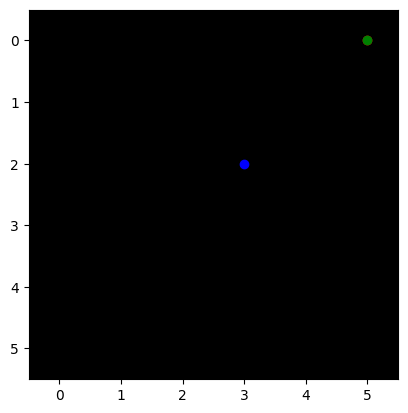

[0.32023063]
 gamma 0.8
[-1]
[0.32023063]
return [-1.0]
gae [-1.320230633020401]
0.2398411114486182
tensor([[ 0.,  3., -2.,  1.]])


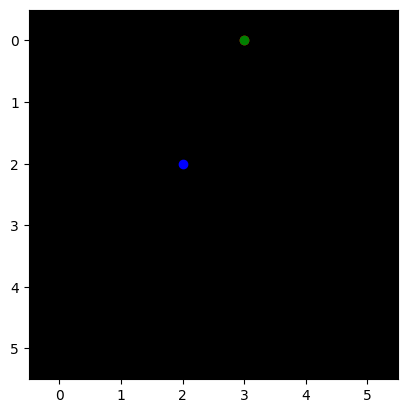

[0.31972444]
 gamma 0.8
[-1]
[0.31972444]
return [-1.0]
gae [-1.319724440574646]
0.9255215876827095
tensor([[3., 5., 1., 4.]])
tensor([[3., 5., 1., 4.]])
tensor([[3., 4., 1., 3.]])
tensor([[3., 5., 1., 4.]])
tensor([[3., 5., 1., 4.]])
tensor([[3., 4., 1., 3.]])
tensor([[3., 4., 1., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[3., 4., 1., 3.]])
tensor([[3., 4., 1., 3.]])
tensor([[3., 5., 1., 4.]])
tensor([[3., 5., 1., 4.]])
tensor([[4., 5., 2., 4.]])
tensor([[4., 5., 2., 4.]])
tensor([[5., 5., 3., 4.]])
tensor([[5., 5., 3., 4.]])
tensor([[5., 4., 3., 3.]])
tensor([[5., 4., 3., 3.]])
tensor([[5., 3., 3., 2.]])
tensor([[5., 3., 3., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 2., 2., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 1., 1., 0.]])
tensor([[3., 1., 1., 0.]])
tensor([[3., 2., 1., 1.]])
tensor([[

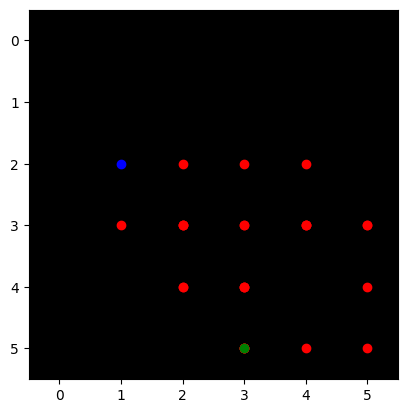

[0.31748757, 0.31420717, 0.31748757, 0.31420717, 0.32243168, 0.31420717, 0.31748757, 0.30942094, 0.303702, 0.26768553, 0.23312184, 0.24907027, 0.21779147, 0.24907027, 0.21779147, 0.22729559, 0.21677375, 0.22729559, 0.24758822, 0.22729559, 0.2777759, 0.31586236, 0.2777759, 0.24907027, 0.23312184]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.31748757, 0.31420717, 0.31748757, 0.31420717, 0.32243168, 0.31420717, 0.31748757, 0.30942094, 0.303702, 0.26768553, 0.23312184, 0.24907027, 0.21779147, 0.24907027, 0.21779147, 0.22729559, 0.21677375, 0.22729559, 0.24758822, 0.22729559, 0.2777759, 0.31586236, 0.2777759, 0.24907027, 0.23312184]
return [0.2513657331466675, 0.2539900541305542, 0.2513657331466675, 0.2579453468322754, 0.2513657331466675, 0.2539900541305542, 0.2475367546081543, 0.24296159744262696, 0.21414842605590823, 0.18649747371673586, 0.19925621747970582, 0.17423317432403565, 0.19925621747970582, 0.17423317432403565, 0.181836473941803, 0.17

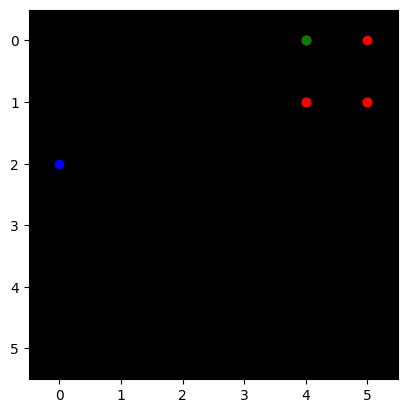

[0.18365632, 0.19978839, 0.19570577, 0.18511352, 0.19570577, 0.19978839, 0.18558697]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.18365632, 0.19978839, 0.19570577, 0.18511352, 0.19570577, 0.19978839, 0.18558697]
return [0.15983071327209475, 0.15656461715698244, 0.14809081554412842, 0.15656461715698244, 0.15983071327209475, 0.14846957921981813, -1.0]
gae [-0.023825606703758218, -0.043223774433135964, -0.047614955902099604, -0.02854890227317808, -0.03587505817413328, -0.05131881237030028, -1.1855869740247726]
0.6760420247005524
tensor([[ 1.,  1., -2.,  0.]])
tensor([[ 1.,  1., -2.,  0.]])
tensor([[ 0.,  1., -3.,  0.]])


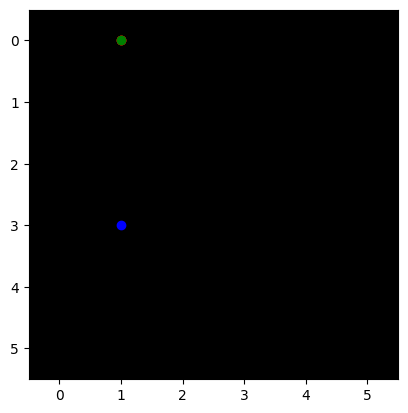

[0.14322568, 0.13686894]
 gamma 0.8
[0, -1]
[0.14322568, 0.13686894]
return [0.10949515104293824, -1.0]
gae [-0.0337305337190628, -1.1368689388036728]
0.8186233250455792
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 0.,  0., -5., -5.]])
tensor([[ 0.,  0., -5., -5.]])


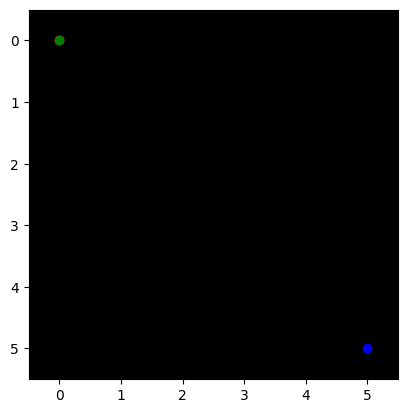

[0.14901672, 0.1501997]
 gamma 0.8
[0, -1]
[0.14901672, 0.1501997]
return [0.1201597571372986, -1.0]
gae [-0.028856965899467457, -1.1501996964216232]
0.21426952071553773
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 1.,  1., -3., -4.]])
tensor([[ 1.,  0., -3., -5.]])
tensor([[ 0.,  0., -4., -5.]])


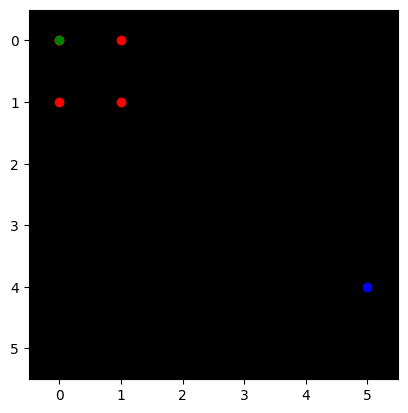

[0.14594117, 0.14632651, 0.14594117, 0.14927967, 0.15026058]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.14594117, 0.14632651, 0.14594117, 0.14927967, 0.15026058]
return [0.11706120967864991, 0.1167529344558716, 0.11942373514175415, 0.12020846605300904, -1.0]
gae [-0.028879958391189564, -0.029573577642440785, -0.026517432928085324, -0.029071202874183646, -1.1502605825662613]
0.4478220524927249
tensor([[ 3.,  2.,  0., -2.]])
tensor([[ 3.,  2.,  0., -2.]])
tensor([[ 3.,  3.,  0., -1.]])
tensor([[ 3.,  3.,  0., -1.]])


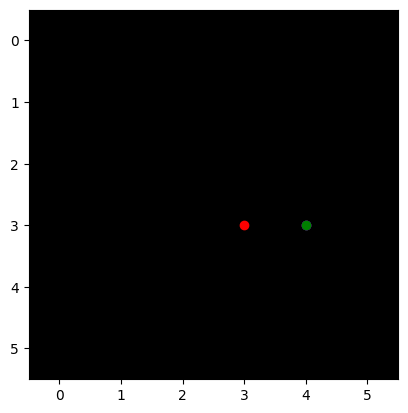

[0.15100141, 0.1656295]
 gamma 0.8
[0, 1]
[0.15100141, 0.1656295]
return [0.13250360488891602, 1.0]
gae [-0.0184978038072586, 0.834370493888855]
0.75409230498198
tensor([[4., 4., 3., 2.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 3., 3., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 3., 3., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 4., 3., 2.]])
tensor([[5., 4., 4., 2.]])
tensor([[5., 5., 4., 3.]])
tensor([[5., 5., 4., 3.]])
tensor([[4., 5., 3., 3.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 5., 3., 3.]])
tensor([[4., 5., 3., 3.]])
tensor([[4., 4., 3., 2.]])
tensor([[4., 4., 3., 2.]])
tensor([[5., 4., 4., 2.]])
tensor([[5., 4., 4., 2.]])
tensor([[5., 5., 4., 3.]])
tensor([[5., 5., 4., 3.]])


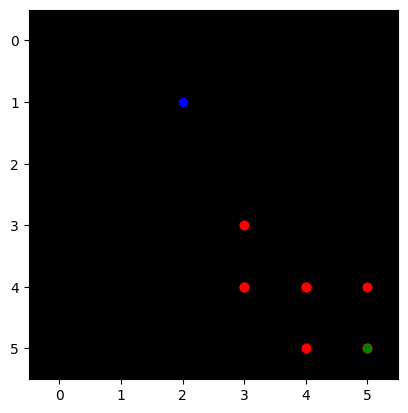

[0.21867786, 0.20548692, 0.20469229, 0.20548692, 0.21867786, 0.20548692, 0.20469229, 0.20548692, 0.21867786, 0.21708757, 0.21640107, 0.21033567, 0.21867786, 0.21033567, 0.21867786, 0.21708757, 0.21640107]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.21867786, 0.20548692, 0.20469229, 0.20548692, 0.21867786, 0.20548692, 0.20469229, 0.20548692, 0.21867786, 0.21708757, 0.21640107, 0.21033567, 0.21867786, 0.21033567, 0.21867786, 0.21708757, 0.21640107]
return [0.16438953876495363, 0.16375383138656618, 0.16438953876495363, 0.17494229078292847, 0.16438953876495363, 0.16375383138656618, 0.16438953876495363, 0.17494229078292847, 0.17367005348205566, 0.17312085628509521, 0.1682685375213623, 0.17494229078292847, 0.1682685375213623, 0.17494229078292847, 0.17367005348205566, 0.17312085628509521, -1.0]
gae [-0.054288324713706954, -0.04173309206962583, -0.04030275046825407, -0.030544632673263544, -0.054288324713706954, -0.04173309206962583, -0.04030275046825407, -0.0305446326732

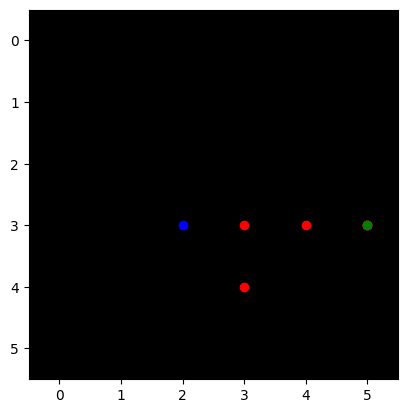

[0.2086145, 0.2074469, 0.2086145, 0.21035369, 0.2017913]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.2086145, 0.2074469, 0.2086145, 0.21035369, 0.2017913]
return [0.16595752239227296, 0.16689159870147707, 0.16828294992446902, 0.16143304109573364, -1.0]
gae [-0.04265697598457335, -0.040555304288864114, -0.0403315484523773, -0.0489206463098526, -1.201791301369667]
0.8170809727431636
tensor([[5., 4., 1., 2.]])
tensor([[5., 4., 1., 2.]])
tensor([[4., 4., 0., 2.]])
tensor([[4., 4., 0., 2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 3.,  3., -1.,  1.]])
tensor([[ 3.,  3., -1.,  1.]])
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 1.,  3., -3.,  1.]])
tensor([[ 1.,  3., -3.,  1.]])
tensor([[ 0.,  3., -4.,  1.]])
tensor([[ 0.,  3., -4.,  1.]])
tensor([[ 0.,  4., -4.,  2.]])
tensor([[ 0.,  4., -4.,  2.]])
tensor([[ 0.,  5., -4.,  3.]])
tensor([[ 0.,  5., -4.,  3.]])
tensor([[ 0.,  4., -4.,  2.]])


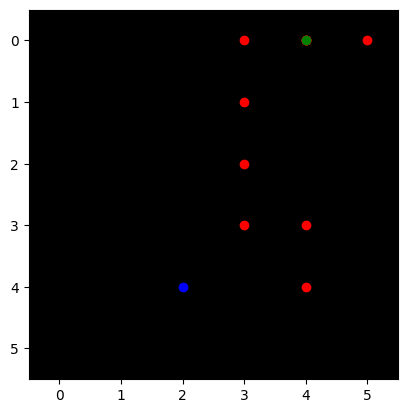

[0.2174708, 0.2123877, 0.2050863, 0.21108304, 0.1829072, 0.16508883, 0.15537971, 0.17804897, 0.19093086, 0.17804897]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.2174708, 0.2123877, 0.2050863, 0.21108304, 0.1829072, 0.16508883, 0.15537971, 0.17804897, 0.19093086, 0.17804897]
return [0.16991015672683718, 0.16406904458999635, 0.16886643171310425, 0.14632575511932375, 0.13207106590270998, 0.12430377006530763, 0.14243917465209963, 0.15274468660354615, 0.14243917465209963, -1.0]
gae [-0.047560638189315774, -0.04831865131855009, -0.03621987402439117, -0.06475728452205656, -0.050836127996444685, -0.04078506231307982, -0.012940537929534895, -0.025304281711578364, -0.04849168360233305, -1.1780489683151245]
return [0.16991016 0.17312086 0.17312086 0.17367005 0.17367005 0.17494228
 0.17494228 0.17494228 0.17494228 1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.          0.10949515  0.11675294  0.11706121]

-------------------- Iteration #58 --------------

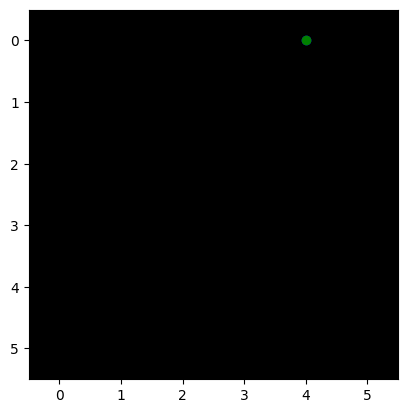

[]
 gamma 0.8
[]
[]
return []
gae []
0.30627500879182845
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 3.,  4., -2.,  4.]])
tensor([[ 3.,  4., -2.,  4.]])
tensor([[ 3.,  5., -2.,  5.]])


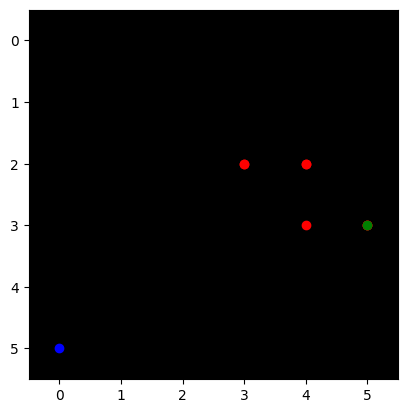

[0.36500627, 0.35191405, 0.32720175, 0.35191405, 0.32720175, 0.30560702, 0.30092758]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.36500627, 0.35191405, 0.32720175, 0.35191405, 0.32720175, 0.30560702, 0.30092758]
return [0.2815312385559082, 0.2617614030838013, 0.2815312385559082, 0.2617614030838013, 0.24448561668395996, 0.24074206352233887, -1.0]
gae [-0.08347502946853635, -0.09015264511108395, -0.04567051529884336, -0.09015264511108395, -0.08271613717079163, -0.06486495733261108, -1.3009275794029236]
0.4955422858578634
tensor([[ 5.,  1.,  4., -2.]])


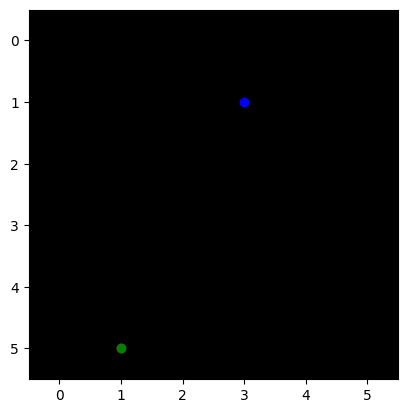

[0.27515256]
 gamma 0.8
[-1]
[0.27515256]
return [-1.0]
gae [-1.275152564048767]
0.2824401859429657
tensor([[ 3.,  0.,  0., -5.]])


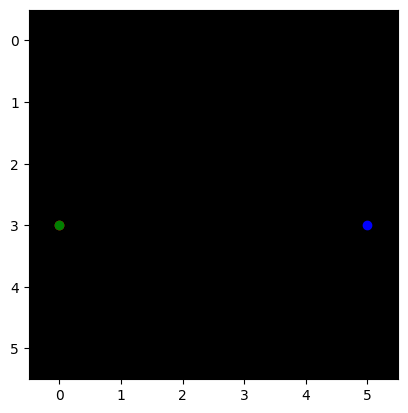

[0.31658405]
 gamma 0.8
[-1]
[0.31658405]
return [-1.0]
gae [-1.316584050655365]
0.2039057765867045
tensor([[ 3.,  3., -1.,  0.]])
tensor([[ 3.,  3., -1.,  0.]])
tensor([[ 3.,  4., -1.,  1.]])
tensor([[4., 4., 0., 1.]])


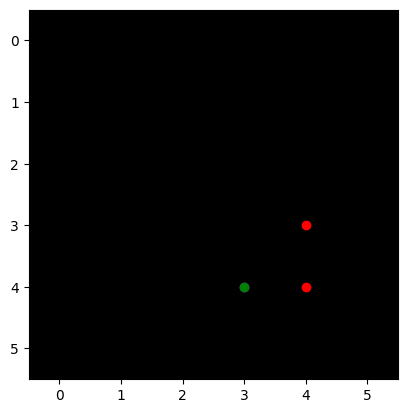

[0.2558804, 0.30262288, 0.28781593]
 gamma 0.8
[0, 0, 1]
[0.2558804, 0.30262288, 0.28781593]
return [0.2420983076095581, 0.23025274276733398, 1.0]
gae [-0.013782078027725214, -0.07237014174461365, 0.7121840715408325]
0.9764919745214069
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])


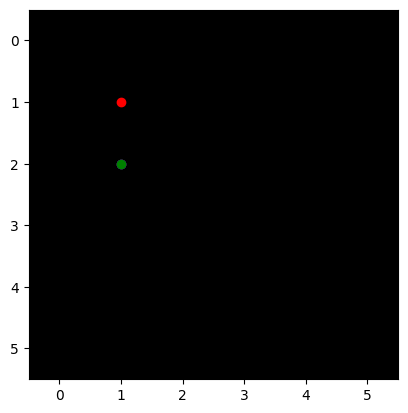

[0.32392782, 0.32195413]
 gamma 0.8
[0, 1]
[0.32392782, 0.32195413]
return [0.25756330490112306, 1.0]
gae [-0.06636451482772826, 0.6780458688735962]
0.8483732837020871
tensor([[ 0.,  5., -5.,  3.]])
tensor([[ 0.,  5., -5.,  3.]])


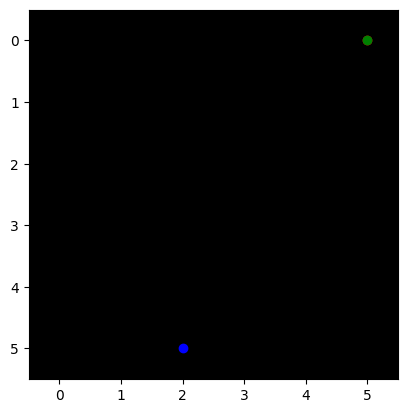

[0.34272018]
 gamma 0.8
[-1]
[0.34272018]
return [-1.0]
gae [-1.3427201807498932]
0.30523365434426775
tensor([[ 2.,  1., -3., -4.]])
tensor([[ 2.,  1., -3., -4.]])
tensor([[ 2.,  0., -3., -5.]])
tensor([[ 1.,  0., -4., -5.]])


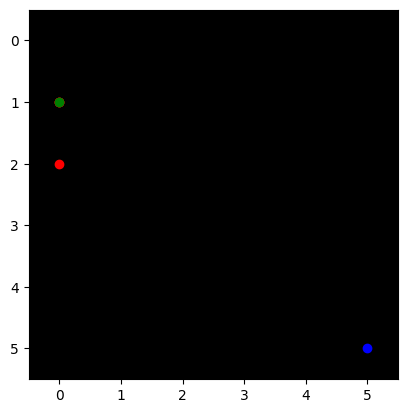

[0.32550463, 0.32564238, 0.32670963]
 gamma 0.8
[0, 0, -1]
[0.32550463, 0.32564238, 0.32670963]
return [0.26051390171051025, 0.2613677024841309, -1.0]
gae [-0.06499072909355164, -0.06427467465400694, -1.3267096281051636]
0.749253597388326
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  2.,  2., -3.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  4.,  2., -1.]])
tensor([[ 5.,  4.,  2., -1.]])
tensor([[5., 5., 2., 0.]])
tensor([[5., 5., 2., 0.]])
tensor([[4., 5., 1., 0.]])
tensor([[4., 5., 1., 0.]])
tensor([[5., 5., 2., 0.]])
tensor([[5., 5., 2., 0.]])


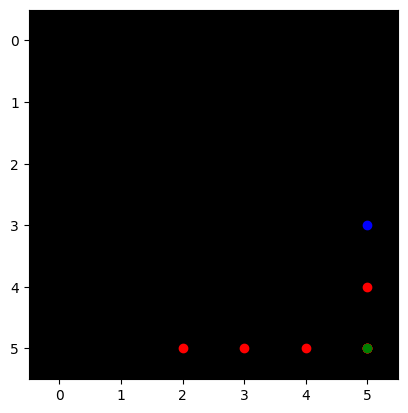

[0.3087878, 0.28245303, 0.22681028, 0.25171867, 0.27675936, 0.29604113, 0.27675936]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[0.3087878, 0.28245303, 0.22681028, 0.25171867, 0.27675936, 0.29604113, 0.27675936]
return [0.2259624242782593, 0.18144822120666504, 0.20137493610382082, 0.22140748500823976, 0.23683290481567384, 0.22140748500823976, -1.0]
gae [-0.08282536864280698, -0.10100480914115906, -0.02543534040451048, -0.030311185121536244, -0.03992645144462584, -0.07463364601135253, -1.2767593562602997]
0.9473333187975334
tensor([[4., 0., 3., 0.]])
tensor([[4., 0., 3., 0.]])
tensor([[3., 0., 2., 0.]])
tensor([[3., 0., 2., 0.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[4., 1., 3., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 1., 2., 1.]])
tensor([[3., 0., 2., 0.]])
tensor([[3., 0., 2., 0.]])
tensor([[2., 0., 1., 0.]])
tensor([[2., 0., 1., 0.]])


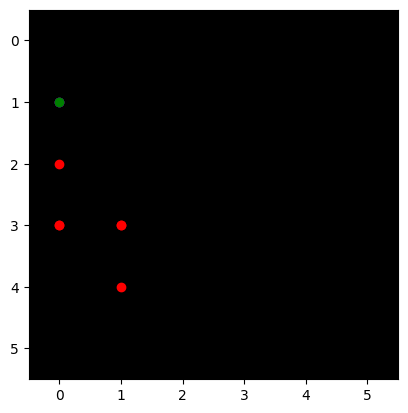

[0.2981144, 0.30645207, 0.29011947, 0.24399768, 0.29011947, 0.30645207, 0.30861095]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 1]
[0.2981144, 0.30645207, 0.29011947, 0.24399768, 0.29011947, 0.30645207, 0.30861095]
return [0.24516165256500244, 0.2320955753326416, 0.19519814252853396, 0.2320955753326416, 0.24516165256500244, 0.24688875675201416, 1.0]
gae [-0.052952736616134644, -0.07435649037361144, -0.09492132663726804, -0.011902102828025812, -0.04495781660079956, -0.05956330895423889, 0.6913890540599823]
0.799667934913173
tensor([[2., 5., 2., 0.]])
tensor([[2., 5., 2., 0.]])
tensor([[3., 5., 3., 0.]])
tensor([[3., 5., 3., 0.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 2.,  4.,  2., -1.]])
tensor([[ 2.,  4.,  2., -1.]])
tensor([[2., 5., 2., 0.]])
tensor([[2., 5., 2., 0.]])
tensor([[3., 5., 3., 0.]])
tensor([[3., 5., 3., 0.]])
tensor([[4., 5., 4., 0.]])
tensor([[5., 5., 5., 0.]])
tensor([[5., 5., 5., 0.]])


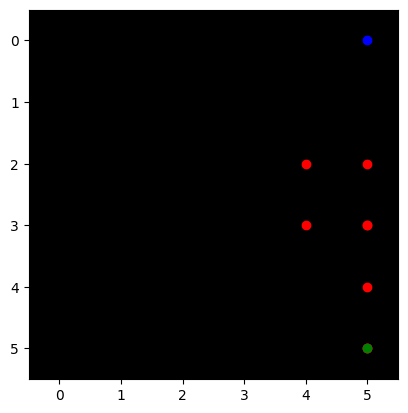

[0.29647365, 0.28632987, 0.2510601, 0.25096944, 0.29647365, 0.28632987, 0.2627734, 0.2591916]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.29647365, 0.28632987, 0.2510601, 0.25096944, 0.29647365, 0.28632987, 0.2627734, 0.2591916]
return [0.22906389236450198, 0.20084807872772217, 0.2007755517959595, 0.23717892169952393, 0.22906389236450198, 0.21021871566772463, 0.2073532819747925, -1.0]
gae [-0.06740975975990293, -0.08548178672790527, -0.05028454661369322, -0.013790518045425415, -0.06740975975990293, -0.07611114978790282, -0.055420112609863265, -1.2591916024684906]
0.5398691240012159
tensor([[ 1.,  4., -3.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 3.,  5., -1.,  3.]])
tensor([[ 3.,  5., -1.,  3.]])


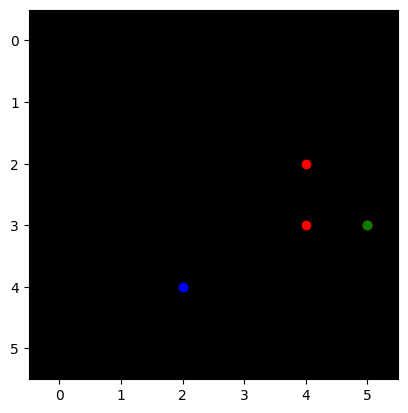

[0.34562412, 0.32743436, 0.3068114, 0.3047148]
 gamma 0.8
[0, 0, 0, -1]
[0.34562412, 0.32743436, 0.3068114, 0.3047148]
return [0.2619474887847901, 0.2454491138458252, 0.24377183914184572, -1.0]
gae [-0.08367663025856015, -0.08198524713516234, -0.06303955316543577, -1.3047147989273071]
0.05645478207188159
tensor([[ 4.,  0.,  1., -3.]])
tensor([[ 5.,  0.,  2., -3.]])
tensor([[ 4.,  0.,  1., -3.]])
tensor([[ 5.,  0.,  2., -3.]])
tensor([[ 5.,  1.,  2., -2.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[ 5.,  1.,  2., -2.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[ 4.,  2.,  1., -1.]])
tensor([[ 5.,  2.,  2., -1.]])


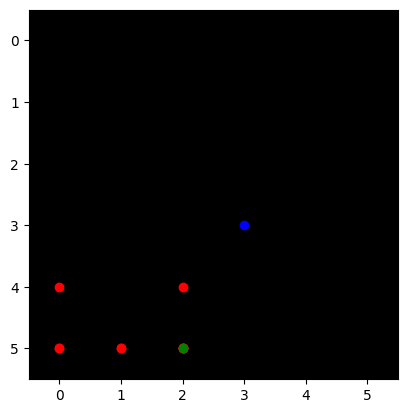

[0.31359965, 0.3116452, 0.31359965, 0.3116452, 0.29661885, 0.24364604, 0.29661885, 0.24364604, 0.27606714, 0.24364604]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.31359965, 0.3116452, 0.31359965, 0.3116452, 0.29661885, 0.24364604, 0.29661885, 0.24364604, 0.27606714, 0.24364604]
return [0.2493161678314209, 0.25087971687316896, 0.2493161678314209, 0.23729507923126222, 0.19491683244705202, 0.23729507923126222, 0.19491683244705202, 0.22085371017456057, 0.19491683244705202, -1.0]
gae [-0.06428347826004027, -0.06076549291610717, -0.06428347826004027, -0.0743501305580139, -0.10170201659202574, -0.006350961327552779, -0.10170201659202574, -0.022792330384254433, -0.08115030527114866, -1.243646040558815]
return [0.2605139  0.2613677  0.2617614  0.2617614  0.26194748 0.28153124
 0.28153124 1.         1.         1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.          0.18144822]

-------------------- Iteration #59 ----------------

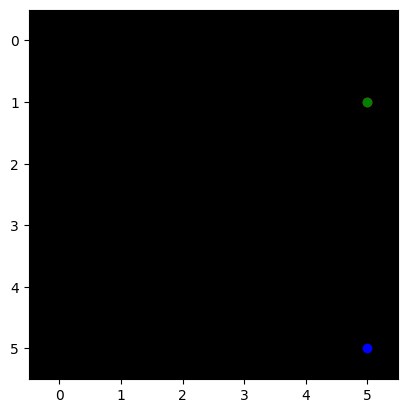

[0.22985888]
 gamma 0.8
[-1]
[0.22985888]
return [-1.0]
gae [-1.2298588752746582]
0.653593731846075
tensor([[ 5.,  0.,  4., -4.]])
tensor([[ 5.,  0.,  4., -4.]])


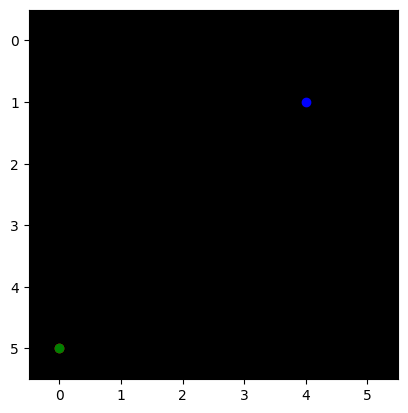

[0.19655392]
 gamma 0.8
[-1]
[0.19655392]
return [-1.0]
gae [-1.1965539157390594]
0.6064661977313743
tensor([[ 4.,  1.,  4., -1.]])
tensor([[ 4.,  0.,  4., -2.]])
tensor([[ 3.,  0.,  3., -2.]])
tensor([[ 3.,  0.,  3., -2.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 3.,  0.,  3., -2.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 4.,  1.,  4., -1.]])
tensor([[ 4.,  1.,  4., -1.]])
tensor([[4., 2., 4., 0.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 2., 4., 0.]])
tensor([[4., 2., 4., 0.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 4., 4., 2.]])
tensor([[3., 4., 3., 2.]])
tensor([[3., 4., 3., 2.]])
tensor([[2., 4., 2., 2.]])
tensor([[2., 4., 2., 2.]])
tensor([[3., 4., 3., 2.]])
tensor([[2., 4., 2., 2.]])
tensor([[1., 4., 1., 2.]])
tensor([[1., 4., 1., 2.]])
tensor([[2., 4., 2., 2.]])
tensor([[2., 3., 2., 1.]])
tensor([[2., 3., 2., 1.]])
tensor([[1., 3., 1., 1.]])
tensor([[1., 3., 1

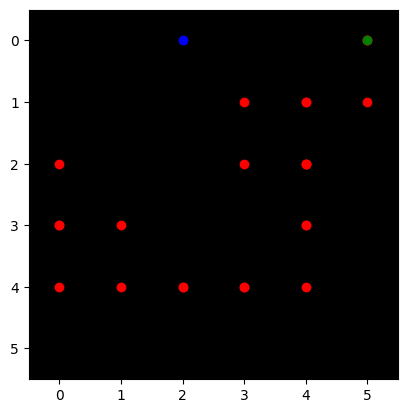

[0.20399234, 0.19463354, 0.19448039, 0.19450021, 0.19448039, 0.1975352, 0.20399234, 0.20568734, 0.2863307, 0.20568734, 0.2863307, 0.24599734, 0.24084732, 0.23531754, 0.24084732, 0.23531754, 0.19992496, 0.23531754, 0.19636747, 0.14646538, 0.19992496, 0.23821244, 0.22910617]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.20399234, 0.19463354, 0.19448039, 0.19450021, 0.19448039, 0.1975352, 0.20399234, 0.20568734, 0.2863307, 0.20568734, 0.2863307, 0.24599734, 0.24084732, 0.23531754, 0.24084732, 0.23531754, 0.19992496, 0.23531754, 0.19636747, 0.14646538, 0.19992496, 0.23821244, 0.22910617]
return [0.15570683479309083, 0.15558431148529053, 0.1556001663208008, 0.15558431148529053, 0.15802816152572632, 0.1631938695907593, 0.16454987525939943, 0.22906455993652344, 0.16454987525939943, 0.22906455993652344, 0.19679787158966067, 0.19267785549163818, 0.18825403451919556, 0.19267785549163818, 0.18825403451919556, 0.15993996858596804, 0.18825403451919556, 0.15709

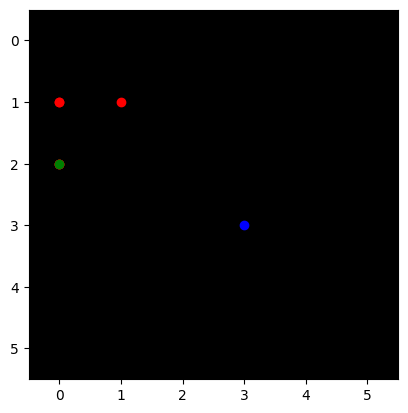

[0.18288349, 0.18357949, 0.18470673, 0.18357949, 0.1856926]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.18288349, 0.18357949, 0.18470673, 0.18357949, 0.1856926]
return [0.14686359167099, 0.14776538610458376, 0.14686359167099, 0.14855407476425173, -1.0]
gae [-0.03601989448070525, -0.03581410348415373, -0.037843140959739674, -0.03502541482448576, -1.1856925934553146]
0.6170184687447688
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 2.,  0., -2.,  0.]])
tensor([[ 2.,  1., -2.,  1.]])
tensor([[ 3.,  1., -1.,  1.]])
tensor([[4., 1., 0., 1.]])


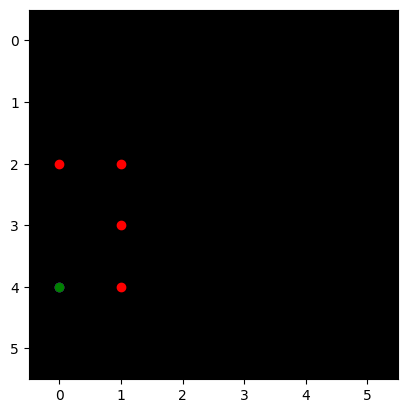

[0.18893571, 0.1838207, 0.18893571, 0.19602548, 0.19384433]
 gamma 0.8
[0, 0, 0, 0, 1]
[0.18893571, 0.1838207, 0.18893571, 0.19602548, 0.19384433]
return [0.14705655574798585, 0.15114856958389283, 0.15682038068771365, 0.15507546663284302, 1.0]
gae [-0.04187915623188018, -0.032672125101089466, -0.03211533129215238, -0.040950009226799006, 0.8061556667089462]
0.7156097984207082
tensor([[ 1.,  3., -3.,  2.]])
tensor([[ 1.,  3., -3.,  2.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[4., 3., 0., 2.]])
tensor([[4., 3., 0., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[4., 3., 0., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[5., 2., 1., 1.]])
tensor([[5., 2., 1., 1.]])
tensor([[5., 1., 1., 0.]])
tensor([[5., 1., 1., 0.]])


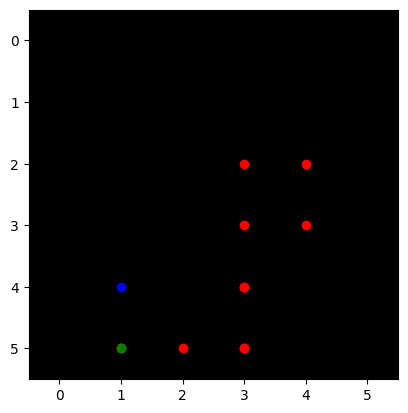

[0.14311323, 0.19212483, 0.23232393, 0.24660456, 0.23006855, 0.244293, 0.25295037, 0.244293, 0.25295037, 0.27802113, 0.20014174]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.14311323, 0.19212483, 0.23232393, 0.24660456, 0.23006855, 0.244293, 0.25295037, 0.244293, 0.25295037, 0.27802113, 0.20014174]
return [0.15369986295700075, 0.18585914373397827, 0.1972836494445801, 0.18405483961105348, 0.19543440341949464, 0.20236029624938967, 0.19543440341949464, 0.20236029624938967, 0.22241690158843996, 0.1601133942604065, -1.0]
gae [0.01058663725852968, -0.006265684962272644, -0.03504028022289274, -0.06254972219467161, -0.034634146094322193, -0.041932708024978615, -0.05751596689224242, -0.041932708024978615, -0.030533468723297097, -0.11790773272514343, -1.2001417428255081]
0.9588447796340757
tensor([[3., 3., 2., 0.]])
tensor([[3., 3., 2., 0.]])
tensor([[2., 3., 1., 0.]])
tensor([[2., 3., 1., 0.]])
tensor([[2., 4., 1., 1.]])
tensor([[2., 4., 1., 1.]])
tensor([[3., 4., 2., 1.]])
tensor([[3., 4.,

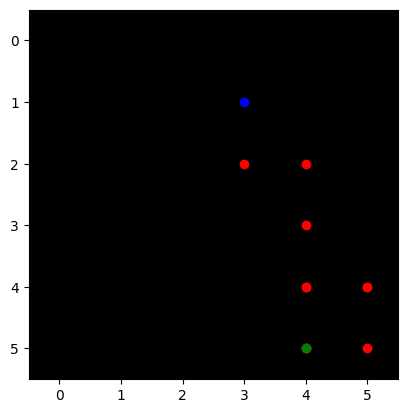

[0.22959647, 0.1901763, 0.2328107, 0.24364008, 0.24816348, 0.24942134, 0.24946527, 0.24942134, 0.24816348, 0.25151014]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.22959647, 0.1901763, 0.2328107, 0.24364008, 0.24816348, 0.24942134, 0.24946527, 0.24942134, 0.24816348, 0.25151014]
return [0.1521410346031189, 0.18624856472015383, 0.19491206407547, 0.1985307812690735, 0.19953707456588746, 0.19957221746444703, 0.19953707456588746, 0.1985307812690735, 0.20120811462402344, -1.0]
gae [-0.07745543122291565, -0.00392772853374479, -0.03789864182472227, -0.04510929882526396, -0.0486264020204544, -0.04984912574291228, -0.04992819726467132, -0.05089056193828581, -0.04695536196231842, -1.2515101432800293]
return [0.19953707 0.19953707 0.19957222 0.20120811 0.2023603  0.2023603
 0.22241691 0.22906455 0.22906455 1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
  0.1171723   0.1468636   0.1468636   0.14705655]

-------------------- Iteration #60 --------------------
r

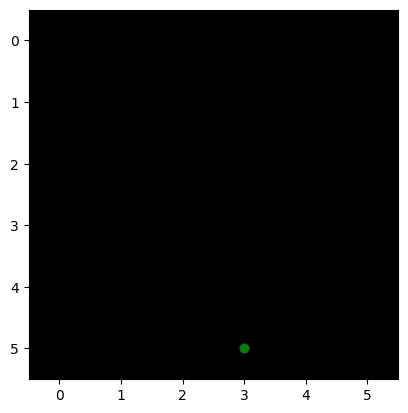

[0.22350135]
 gamma 0.8
[1]
[0.22350135]
return [1.0]
gae [0.7764986455440521]
0.1662651145480013
tensor([[ 0.,  1., -3., -1.]])


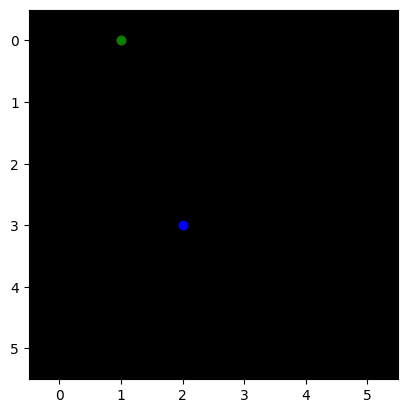

[0.24359109]
 gamma 0.8
[-1]
[0.24359109]
return [-1.0]
gae [-1.243591085076332]
0.014507880101452653
tensor([[ 1.,  0.,  0., -2.]])
tensor([[ 0.,  0., -1., -2.]])
tensor([[ 0.,  1., -1., -1.]])


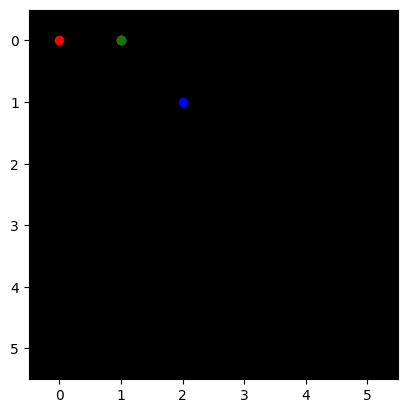

[0.23263326, 0.23269509, 0.23412538]
 gamma 0.8
[0, 0, -1]
[0.23263326, 0.23269509, 0.23412538]
return [0.18615607023239136, 0.18730030059814454, -1.0]
gae [-0.04647719264030456, -0.04539478719234466, -1.2341253757476807]
0.3805581420586286
tensor([[ 5.,  1.,  4., -2.]])
tensor([[ 5.,  1.,  4., -2.]])


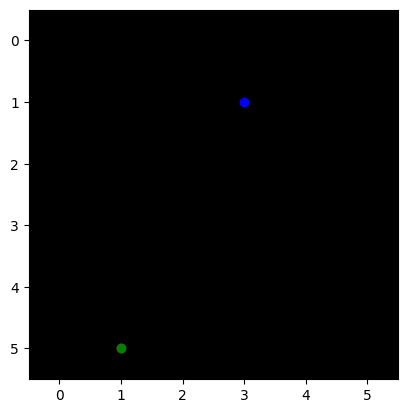

[0.22181518]
 gamma 0.8
[-1]
[0.22181518]
return [-1.0]
gae [-1.2218151837587357]
0.8602232590342088
tensor([[5., 3., 1., 1.]])
tensor([[5., 3., 1., 1.]])
tensor([[5., 2., 1., 0.]])


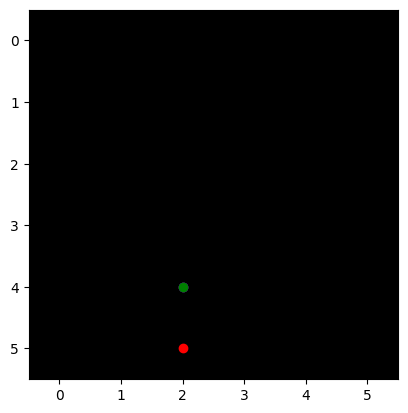

[0.19549578, 0.21816245]
 gamma 0.8
[0, 1]
[0.19549578, 0.21816245]
return [0.1745299577713013, 1.0]
gae [-0.02096582651138304, 0.7818375527858734]
0.8574976267487924
tensor([[5., 4., 2., 0.]])
tensor([[5., 4., 2., 0.]])
tensor([[5., 5., 2., 1.]])
tensor([[5., 5., 2., 1.]])


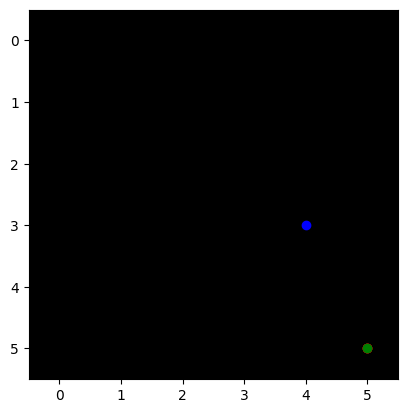

[0.19622153, 0.20964977]
 gamma 0.8
[0, -1]
[0.19622153, 0.20964977]
return [0.16771981716156006, -1.0]
gae [-0.02850171327590942, -1.20964977145195]
0.9525051639333991
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  0.,  5., -4.]])
tensor([[ 5.,  0.,  5., -4.]])
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  0.,  5., -4.]])
tensor([[ 5.,  0.,  5., -4.]])
tensor([[ 5.,  1.,  5., -3.]])
tensor([[ 5.,  1.,  5., -3.]])


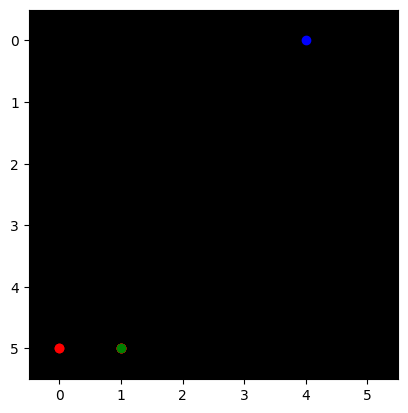

[0.22384794, 0.22830907, 0.22384794, 0.22830907, 0.22384794]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.22384794, 0.22830907, 0.22384794, 0.22830907, 0.22384794]
return [0.18264725208282473, 0.17907835245132447, 0.18264725208282473, 0.17907835245132447, -1.0]
gae [-0.04120068848133085, -0.04923071265220641, -0.04120068848133085, -0.04923071265220641, -1.2238479405641556]
0.9641923222791643
tensor([[ 0.,  1., -3., -3.]])
tensor([[ 0.,  1., -3., -3.]])
tensor([[ 0.,  0., -3., -4.]])
tensor([[ 0.,  0., -3., -4.]])
tensor([[ 0.,  1., -3., -3.]])
tensor([[ 0.,  1., -3., -3.]])
tensor([[ 1.,  1., -2., -3.]])
tensor([[ 1.,  1., -2., -3.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 3.,  2.,  0., -2.]])
tensor([[ 3.,  2.,  0., -2.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  2., -1., -2.]])
tensor([[ 2.,  2., -1., -2.]])

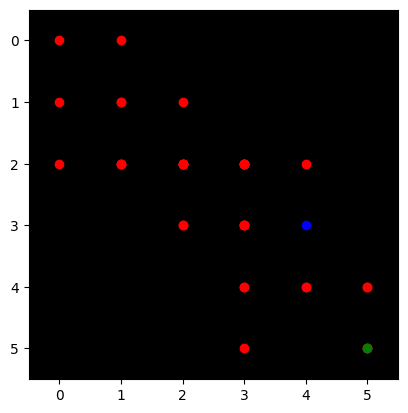

[0.23419377, 0.23335177, 0.23419377, 0.23433447, 0.23428282, 0.23462148, 0.23199536, 0.23462148, 0.23428282, 0.23462148, 0.23428282, 0.23315237, 0.23353453, 0.23433447, 0.23557216, 0.23462148, 0.22337113, 0.22883259, 0.22337113, 0.20902361, 0.22337113, 0.20902361, 0.22337113, 0.23462148, 0.23199536, 0.20902361, 0.22337113, 0.20902361, 0.20741417, 0.22295526, 0.20741417, 0.2044469, 0.21251266, 0.2044469, 0.21251266, 0.20964977]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.23419377, 0.23335177, 0.23419377, 0.23433447, 0.23428282, 0.23462148, 0.23199536, 0.23462148, 0.23428282, 0.23462148, 0.23428282, 0.23315237, 0.23353453, 0.23433447, 0.23557216, 0.23462148, 0.22337113, 0.22883259, 0.22337113, 0.20902361, 0.22337113, 0.20902361, 0.22337113, 0.23462148, 0.23199536, 0.20902361, 0.22337113, 0.20902361, 0.20741417, 0.22295526, 0.20741417, 0.2044469, 0.21251266, 0.2044469, 0.21251266, 0.20964977]
return [0.1866814

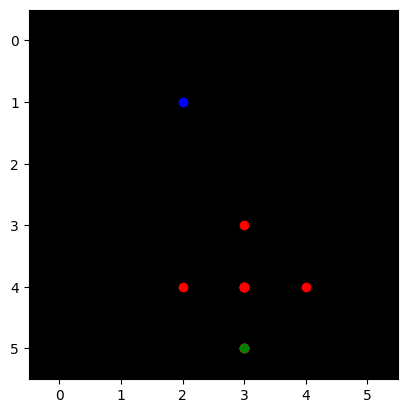

[0.16540872, 0.1698411, 0.18902813, 0.17332603, 0.18902813, 0.16491607, 0.18902813, 0.16491607, 0.18902813, 0.15010107, 0.18902813, 0.16491607]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.16540872, 0.1698411, 0.18902813, 0.17332603, 0.18902813, 0.16491607, 0.18902813, 0.16491607, 0.18902813, 0.15010107, 0.18902813, 0.16491607]
return [0.13587287664413453, 0.15122250318527222, 0.13866082429885865, 0.15122250318527222, 0.13193285465240479, 0.15122250318527222, 0.13193285465240479, 0.15122250318527222, 0.12008085250854493, 0.15122250318527222, 0.13193285465240479, -1.0]
gae [-0.029535838961601252, -0.01861859261989593, -0.05036730468273162, -0.02210352718830108, -0.057095274329185486, -0.013693565130233759, -0.057095274329185486, -0.013693565130233759, -0.06894727647304534, 0.00112143754959107, -0.057095274329185486, -1.164916068315506]
0.9879726229480013
tensor([[ 1.,  0.,  1., -3.]])
tensor([[ 1.,  0.,  1., -3.]])


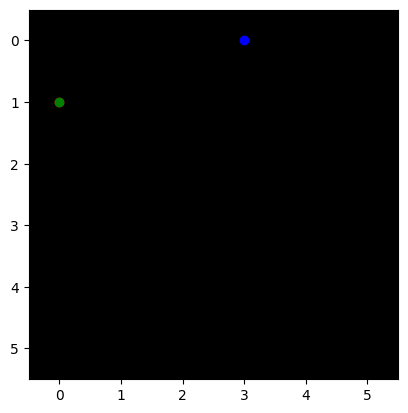

[0.1672901]
 gamma 0.8
[-1]
[0.1672901]
return [-1.0]
gae [-1.1672901064157486]
0.2607827845762264
tensor([[ 1.,  3., -1.,  1.]])
tensor([[ 1.,  2., -1.,  0.]])
tensor([[ 1.,  1., -1., -1.]])
tensor([[ 2.,  1.,  0., -1.]])
tensor([[ 3.,  1.,  1., -1.]])
tensor([[ 3.,  1.,  1., -1.]])
tensor([[3., 2., 1., 0.]])
tensor([[3., 2., 1., 0.]])
tensor([[4., 2., 2., 0.]])
tensor([[5., 2., 3., 0.]])
tensor([[5., 2., 3., 0.]])
tensor([[5., 3., 3., 1.]])
tensor([[5., 2., 3., 0.]])
tensor([[5., 3., 3., 1.]])
tensor([[4., 3., 2., 1.]])
tensor([[4., 3., 2., 1.]])
tensor([[5., 3., 3., 1.]])
tensor([[5., 2., 3., 0.]])
tensor([[4., 2., 2., 0.]])
tensor([[5., 2., 3., 0.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 5.,  0.,  3., -2.]])
tensor([[ 5.,  0.,  3., -2.]])
tensor([[ 4.,  0.,  2., -2.]])
tensor([[ 5.,  0.,  3., -2.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 4.,  1.,  2., -1.]])
tensor([[ 4.,  1.,  2., -1.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 5.,  0.,  3., -2.

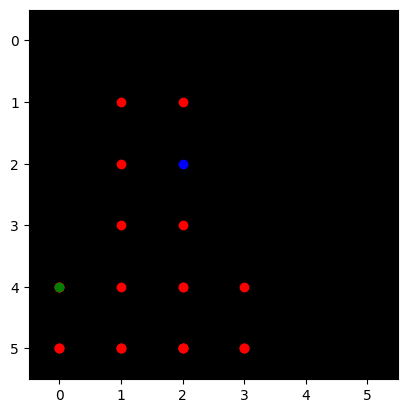

[0.17777787, 0.16394573, 0.14278105, 0.1221854, 0.13344397, 0.15362692, 0.15153527, 0.16128276, 0.18523102, 0.16128276, 0.18523102, 0.1729877, 0.18523102, 0.16128276, 0.15153527, 0.16128276, 0.12110465, 0.16760644, 0.16819993, 0.16760644, 0.12110465, 0.13854429, 0.12110465, 0.16760644, 0.16819993]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.17777787, 0.16394573, 0.14278105, 0.1221854, 0.13344397, 0.15362692, 0.15153527, 0.16128276, 0.18523102, 0.16128276, 0.18523102, 0.1729877, 0.18523102, 0.16128276, 0.15153527, 0.16128276, 0.12110465, 0.16760644, 0.16819993, 0.16760644, 0.12110465, 0.13854429, 0.12110465, 0.16760644, 0.16819993]
return [0.131156587600708, 0.11422483921051026, 0.09774832129478456, 0.10675517320632935, 0.12290153503417969, 0.12122821807861328, 0.12902621030807496, 0.14818481206893921, 0.12902621030807496, 0.14818481206893921, 0.1383901596069336, 0.14818481206893921, 0.12902621030807496, 0.12122821807861328, 0.1290262103080

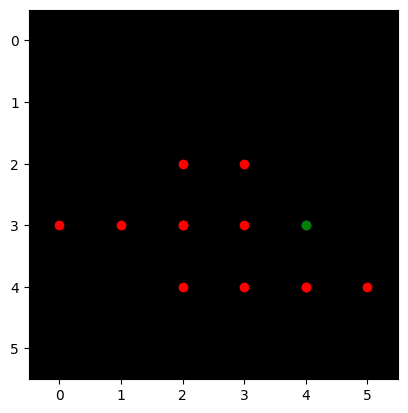

[0.17036821, 0.16937968, 0.1673332, 0.1500427, 0.1479218, 0.19108248, 0.18102784, 0.1500427, 0.14638178, 0.1862186, 0.18586051, 0.16188587, 0.18586051]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.17036821, 0.16937968, 0.1673332, 0.1500427, 0.1479218, 0.19108248, 0.18102784, 0.1500427, 0.14638178, 0.1862186, 0.18586051, 0.16188587, 0.18586051]
return [0.13550374507904053, 0.13386656045913697, 0.12003415822982788, 0.11833744049072266, 0.15286598205566407, 0.14482227563858033, 0.12003415822982788, 0.11710542440414429, 0.14897488355636598, 0.1486884117126465, 0.12950869798660278, 0.1486884117126465, 1.0]
gae [-0.034864464402198786, -0.035513120889663685, -0.04729904234409332, -0.03170525729656219, 0.004944181442260748, -0.04626020193099975, -0.06099368631839752, -0.032937273383140564, 0.0025931030511856246, -0.03753019273281097, -0.05635181665420533, -0.013197460770606989, 0.8141394853591919]
return [0.1486884  0.1486884  0.14897488 0.1512225  0.1512225  0.1512225
 0.1512225  0.1

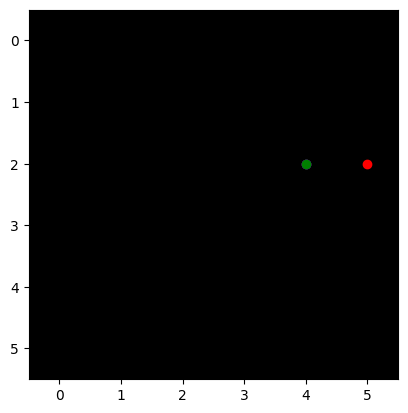

[0.28378037, 0.26738787]
 gamma 0.8
[0, 1]
[0.28378037, 0.26738787]
return [0.21391029357910157, 1.0]
gae [-0.0698700726032257, 0.732612133026123]
0.35682939372225897
tensor([[ 1.,  2.,  1., -3.]])
tensor([[ 1.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 1.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 1.,  2.,  1., -3.]])
tensor([[ 1.,  2.,  1., -3.]])
tensor([[ 1.,  1.,  1., -4.]])
tensor([[ 1.,  1.,  1., -4.]])
tensor([[ 0.,  1.,  0., -4.]])
tensor([[ 0.,  0.,  0., -5.]])
tensor([[ 0.,  0.,  0., -5.]])


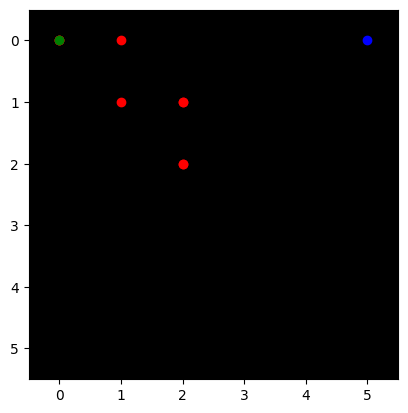

[0.3432622, 0.3580742, 0.3432622, 0.3580742, 0.3432622, 0.34133783, 0.34136948, 0.4016943]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.3432622, 0.3580742, 0.3432622, 0.3580742, 0.3432622, 0.34133783, 0.34136948, 0.4016943]
return [0.2864593505859375, 0.2746097564697266, 0.2864593505859375, 0.2746097564697266, 0.27307026386260985, 0.2730955839157105, 0.3213554382324219, -1.0]
gae [-0.05680284500122068, -0.0834644317626953, -0.05680284500122068, -0.0834644317626953, -0.07019193172454835, -0.06824224591255185, -0.020014041662216153, -1.4016942977905273]
0.21856845694946558
tensor([[4., 4., 3., 4.]])
tensor([[4., 3., 3., 3.]])
tensor([[4., 4., 3., 4.]])
tensor([[4., 4., 3., 4.]])
tensor([[5., 4., 4., 4.]])
tensor([[5., 4., 4., 4.]])


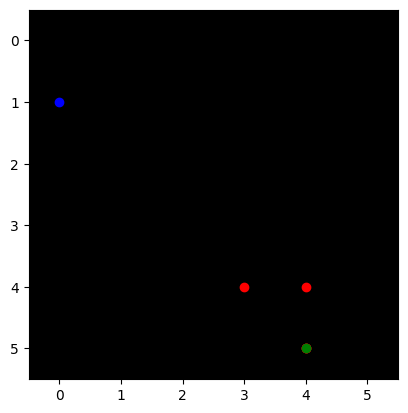

[0.2790508, 0.29455873, 0.2790508, 0.29302153]
 gamma 0.8
[0, 0, 0, -1]
[0.2790508, 0.29455873, 0.2790508, 0.29302153]
return [0.23564698696136477, 0.22324063777923586, 0.2344172239303589, -1.0]
gae [-0.04340381026268003, -0.07131809592247007, -0.04463357329368589, -1.2930215299129486]
0.32978834234897847
tensor([[4., 5., 4., 1.]])


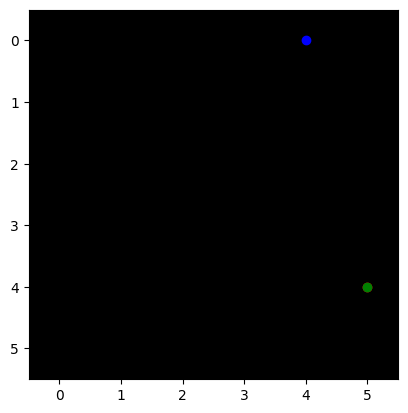

[0.29264134]
 gamma 0.8
[-1]
[0.29264134]
return [-1.0]
gae [-1.2926413416862488]
0.08359636324713682
tensor([[ 0.,  5., -2.,  2.]])


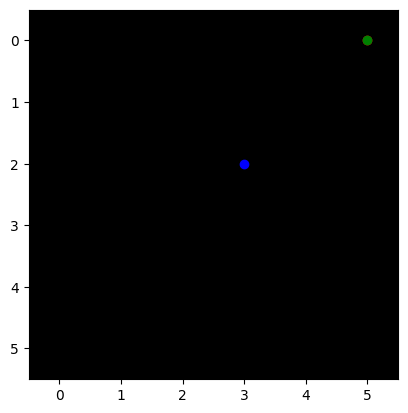

[0.28338176]
 gamma 0.8
[-1]
[0.28338176]
return [-1.0]
gae [-1.2833817601203918]
0.12526827850417
tensor([[4., 4., 4., 1.]])
tensor([[4., 5., 4., 2.]])
tensor([[4., 5., 4., 2.]])
tensor([[4., 4., 4., 1.]])
tensor([[3., 4., 3., 1.]])
tensor([[4., 4., 4., 1.]])
tensor([[4., 3., 4., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[1., 3., 1., 0.]])


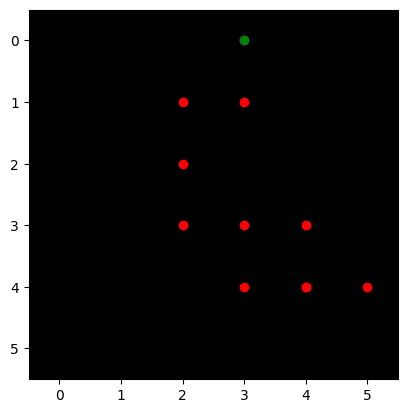

[0.29993236, 0.2900675, 0.29993236, 0.2642537, 0.29993236, 0.3501811, 0.30098662, 0.3545895, 0.2810891, 0.25402156, 0.27892023]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.29993236, 0.2900675, 0.29993236, 0.2642537, 0.29993236, 0.3501811, 0.30098662, 0.3545895, 0.2810891, 0.25402156, 0.27892023]
return [0.2320539951324463, 0.2399458885192871, 0.21140296459198, 0.2399458885192871, 0.28014488220214845, 0.2407892942428589, 0.2836715936660767, 0.22487127780914307, 0.2032172441482544, 0.22313618659973145, 1.0]
gae [-0.0678783655166626, -0.05012160539627075, -0.0885293960571289, -0.024307817220687866, -0.019787478446960438, -0.10939180850982666, -0.017315024137496915, -0.12971821427345276, -0.07787185311317443, -0.030885368585586548, 0.7210797667503357]
0.9276822282203591
tensor([[ 0.,  5., -3.,  4.]])
tensor([[ 0.,  5., -3.,  4.]])


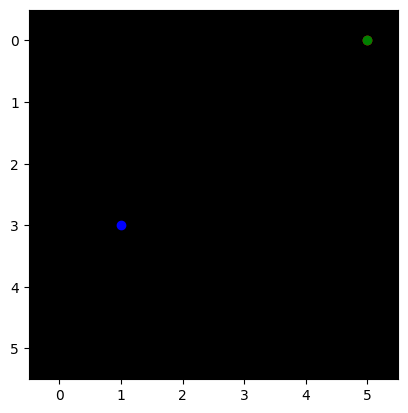

[0.27375028]
 gamma 0.8
[-1]
[0.27375028]
return [-1.0]
gae [-1.2737502753734589]
0.6385861034228365
tensor([[2., 3., 1., 1.]])
tensor([[2., 3., 1., 1.]])
tensor([[2., 4., 1., 2.]])
tensor([[1., 4., 0., 2.]])
tensor([[1., 4., 0., 2.]])
tensor([[2., 4., 1., 2.]])
tensor([[1., 4., 0., 2.]])
tensor([[2., 4., 1., 2.]])
tensor([[2., 4., 1., 2.]])
tensor([[1., 4., 0., 2.]])
tensor([[1., 4., 0., 2.]])
tensor([[2., 4., 1., 2.]])
tensor([[2., 3., 1., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 2., 3., 0.]])
tensor([[4., 2., 3., 0.]])
tensor([[4., 3., 3., 1.]])
tensor([[4., 2., 3., 0.]])
tensor([[ 4.,  1.,  3., -1.]])
tensor([[4., 2., 3., 0.]])
tensor([[4., 2., 3., 0.]])
tensor([[5., 2., 4., 0.]])
tensor([[5., 3., 4., 1.]])
tensor([[5., 3., 4., 1.]])
tensor([[5., 2., 4., 0.]])
tensor([[5., 2., 4., 0.]])


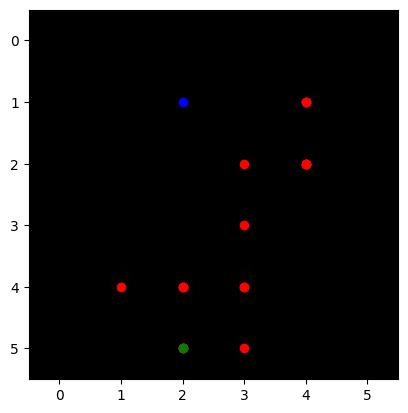

[0.2822175, 0.26108328, 0.28153872, 0.26108328, 0.28153872, 0.26108328, 0.28153872, 0.26108328, 0.2822175, 0.26402977, 0.30058208, 0.33836615, 0.30058208, 0.33836615, 0.34324676, 0.33836615, 0.36775416, 0.32010084, 0.36775416]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.2822175, 0.26108328, 0.28153872, 0.26108328, 0.28153872, 0.26108328, 0.28153872, 0.26108328, 0.2822175, 0.26402977, 0.30058208, 0.33836615, 0.30058208, 0.33836615, 0.34324676, 0.33836615, 0.36775416, 0.32010084, 0.36775416]
return [0.20886662006378176, 0.2252309799194336, 0.20886662006378176, 0.2252309799194336, 0.20886662006378176, 0.2252309799194336, 0.20886662006378176, 0.22577400207519532, 0.21122381687164307, 0.24046566486358645, 0.2706929206848145, 0.24046566486358645, 0.2706929206848145, 0.2745974063873291, 0.2706929206848145, 0.2942033290863037, 0.25608067512512206, 0.2942033290863037, -1.0]
gae [-0.07335088253021238, -0.03585229516029356, -0.07267210483551023, -0.03585229516029356, 

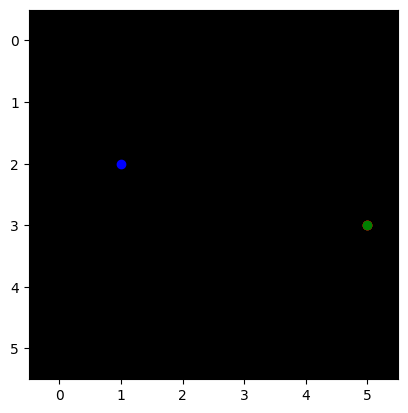

[0.25545973, 0.2527334]
 gamma 0.8
[0, -1]
[0.25545973, 0.2527334]
return [0.20218672752380373, -1.0]
gae [-0.05327299833297727, -1.2527334094047546]
0.8642946851090203
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 1.,  5., -3.,  4.]])
tensor([[ 1.,  5., -3.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 1.,  5., -3.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  5., -2.,  4.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[ 3.,  4., -1.,  3.]])
tensor([[4., 4., 0., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[5., 4., 1., 3.]])
tensor([[5., 4., 1., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[4., 4., 0., 3.]])
tensor([[5., 4., 1., 3.]])
tensor([[5., 4., 1., 3.]])
tensor([[5., 3., 1., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[4., 3., 0., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[5., 3., 1., 2.]])
tensor([[4., 3., 0., 2.]])
tensor([[4., 3., 0.

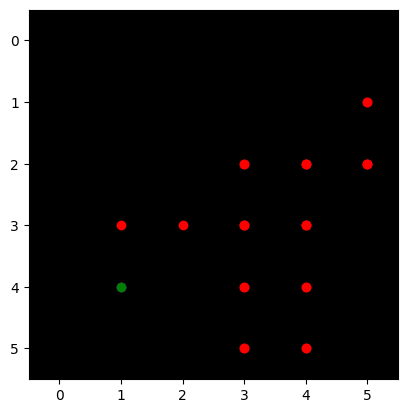

[0.27504572, 0.2556729, 0.27050358, 0.2556729, 0.27050358, 0.2556729, 0.27504572, 0.2570171, 0.25445083, 0.2592859, 0.25445083, 0.2592859, 0.28906405, 0.25785437, 0.28906405, 0.25785437, 0.27705762, 0.28188944, 0.27504572, 0.28188944, 0.27705762, 0.2570171, 0.27504572, 0.2570171, 0.27705762, 0.28517416, 0.27080742]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.27504572, 0.2556729, 0.27050358, 0.2556729, 0.27050358, 0.2556729, 0.27504572, 0.2570171, 0.25445083, 0.2592859, 0.25445083, 0.2592859, 0.28906405, 0.25785437, 0.28906405, 0.25785437, 0.27705762, 0.28188944, 0.27504572, 0.28188944, 0.27705762, 0.2570171, 0.27504572, 0.2570171, 0.27705762, 0.28517416, 0.27080742]
return [0.20453832149505616, 0.21640286445617676, 0.20453832149505616, 0.21640286445617676, 0.20453832149505616, 0.22003657817840577, 0.20561368465423585, 0.2035606622695923, 0.20742871761322024, 0.2035606622695923, 0.20742871761322024, 0.23125123977661133, 0.2062834978103

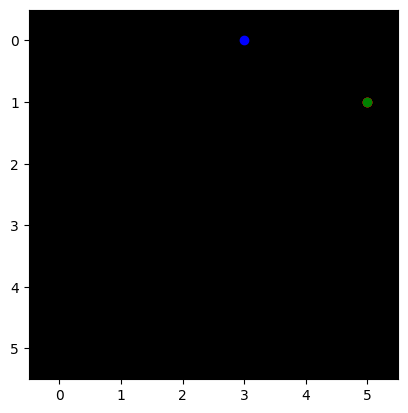

[0.14016835, 0.1403713]
 gamma 0.8
[0, -1]
[0.14016835, 0.1403713]
return [0.11229703426361085, -1.0]
gae [-0.027871319651603693, -1.1403712928295135]
0.12799434085914296
tensor([[ 1.,  0.,  0., -4.]])
tensor([[ 1.,  1.,  0., -3.]])
tensor([[ 0.,  1., -1., -3.]])


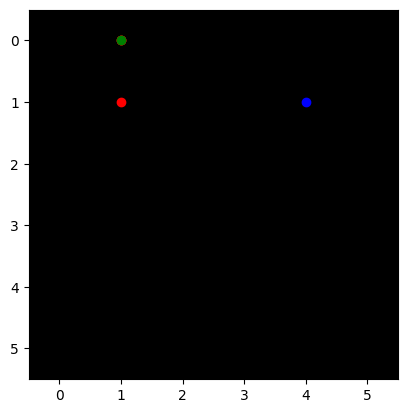

[0.17128856, 0.17137948, 0.17144641]
 gamma 0.8
[0, 0, -1]
[0.17128856, 0.17137948, 0.17144641]
return [0.13710358142852783, 0.13715713024139406, -1.0]
gae [-0.0341849833726883, -0.03422234654426573, -1.1714464128017426]
0.8737629862018237
tensor([[2., 5., 2., 1.]])
tensor([[2., 5., 2., 1.]])
tensor([[3., 5., 3., 1.]])
tensor([[3., 5., 3., 1.]])
tensor([[4., 5., 4., 1.]])
tensor([[4., 5., 4., 1.]])


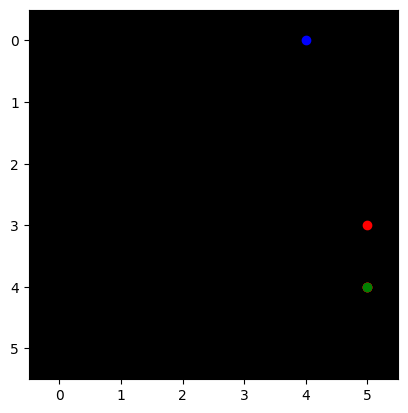

[0.12815146, 0.12918288, 0.13803709]
 gamma 0.8
[0, 0, -1]
[0.12815146, 0.12918288, 0.13803709]
return [0.10334630012512208, 0.11042966842651368, -1.0]
gae [-0.024805161356925953, -0.018753206729888908, -1.138037085533142]
0.027266870289407996
tensor([[ 2.,  1., -3., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 2.,  1., -3., -2.]])
tensor([[ 1.,  1., -4., -2.]])
tensor([[ 2.,  1., -3., -2.]])
tensor([[ 1.,  1., -4., -2.]])
tensor([[ 1.,  2., -4., -1.]])
tensor([[ 2.,  2., -3., -1.]])
tensor([[ 2.,  3., -3.,  0.]])
tensor([[ 2.,  2., -3., -1.]])
tensor([[ 2.,  1., -3., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 4.,  1., -1., -2.]])
tensor([[ 5.,  1.,  0., -2.]])
tensor([[ 5.,  0.,  0., -3.]])


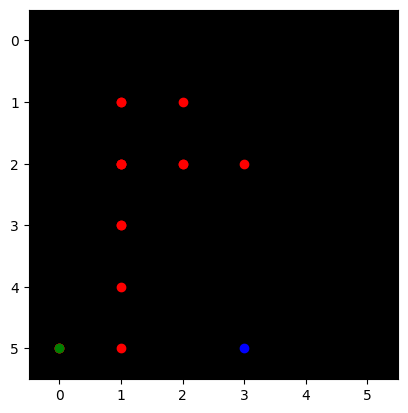

[0.18206112, 0.17476289, 0.18206112, 0.1946371, 0.18206112, 0.1946371, 0.16454925, 0.15867129, 0.13599631, 0.15867129, 0.18206112, 0.17476289, 0.17046127, 0.17306826, 0.18347888]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.18206112, 0.17476289, 0.18206112, 0.1946371, 0.18206112, 0.1946371, 0.16454925, 0.15867129, 0.13599631, 0.15867129, 0.18206112, 0.17476289, 0.17046127, 0.17306826, 0.18347888]
return [0.13981031179428102, 0.14564889669418335, 0.15570968389511108, 0.14564889669418335, 0.15570968389511108, 0.13163939714431763, 0.12693703174591064, 0.10879704952239991, 0.12693703174591064, 0.14564889669418335, 0.13981031179428102, 0.1363690137863159, 0.13845460414886476, 0.14678310155868532, -1.0]
gae [-0.042250809073448164, -0.029113993048667908, -0.026351436972618103, -0.048988208174705505, -0.026351436972618103, -0.06299770772457122, -0.03761221468448639, -0.0498742401599884, -0.009059280157089233, -0.013022392988204956, -0.042250809073448164, -0.038393875956535345, 

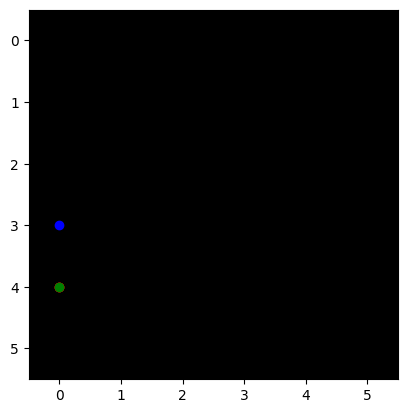

[0.15010606, 0.15242675]
 gamma 0.8
[0, -1]
[0.15010606, 0.15242675]
return [0.1219413995742798, -1.0]
gae [-0.028164657950401295, -1.1524267494678497]
0.691438110688589
tensor([[ 2.,  0., -3.,  0.]])
tensor([[ 2.,  0., -3.,  0.]])
tensor([[ 1.,  0., -4.,  0.]])
tensor([[ 1.,  0., -4.,  0.]])
tensor([[ 0.,  0., -5.,  0.]])
tensor([[ 0.,  0., -5.,  0.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])


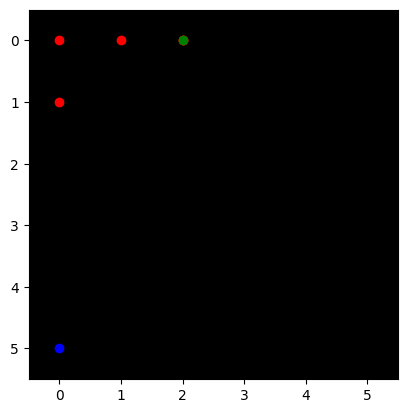

[0.16149789, 0.17473316, 0.17196189, 0.13941838, 0.13246249]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.16149789, 0.17473316, 0.17196189, 0.13941838, 0.13246249]
return [0.13978652954101564, 0.13756951093673705, 0.11153470277786255, 0.10596998929977418, -1.0]
gae [-0.021711361408233626, -0.037163650989532476, -0.060427185893058774, -0.03344838917255401, -1.1324624866247177]
0.9946717158556402
tensor([[4., 5., 4., 2.]])
tensor([[4., 5., 4., 2.]])
tensor([[5., 5., 5., 2.]])
tensor([[5., 5., 5., 2.]])


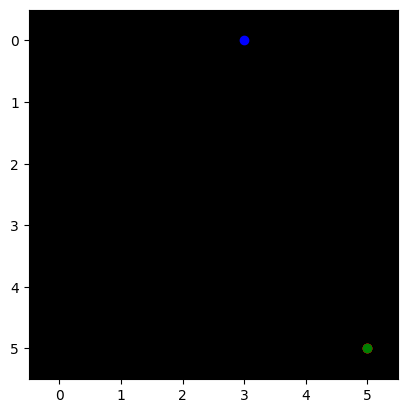

[0.13941771, 0.13027547]
 gamma 0.8
[0, -1]
[0.13941771, 0.13027547]
return [0.10422037839889527, -1.0]
gae [-0.035197329521179196, -1.130275472998619]
0.2796334241724018
tensor([[ 4.,  5., -1.,  2.]])
tensor([[5., 5., 0., 2.]])


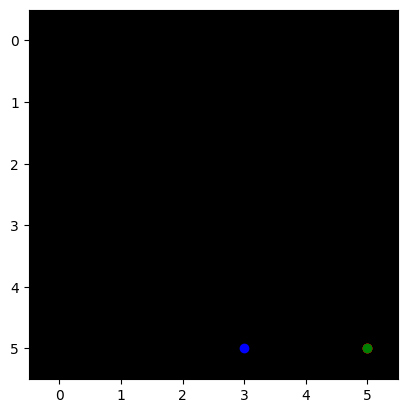

[0.14690237, 0.1622056]
 gamma 0.8
[0, -1]
[0.14690237, 0.1622056]
return [0.1297644853591919, -1.0]
gae [-0.01713788211345671, -1.1622056066989899]
0.8917562232354224
tensor([[ 2.,  0., -2., -3.]])
tensor([[ 2.,  0., -2., -3.]])


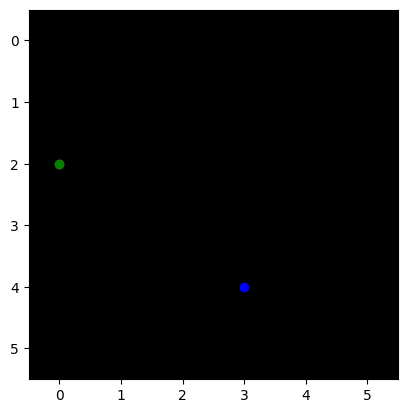

[0.17072691]
 gamma 0.8
[-1]
[0.17072691]
return [-1.0]
gae [-1.1707269102334976]
0.9667240420384664
tensor([[3., 3., 0., 2.]])
tensor([[3., 3., 0., 2.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 4., 0., 3.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 1.,  3., -2.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  3., -3.,  2.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 0.,  4., -3.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 1.,  5., -2.,  4.]])
tensor([[ 1.,  5., -2.,  4.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 1.,  4., -2.,  3.]])
tensor([[ 2.,  4., -1.,  3.]])
tensor([[ 2.,  4

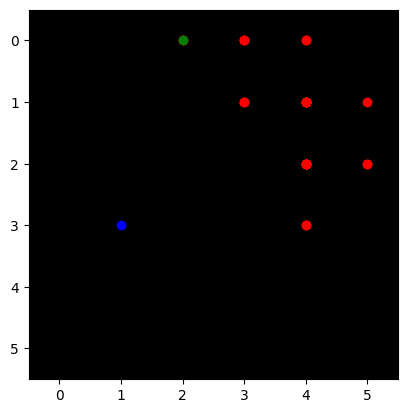

[0.1387624, 0.13087451, 0.14188075, 0.1437177, 0.14188075, 0.1420399, 0.13764544, 0.1335575, 0.13764544, 0.1335575, 0.141837, 0.1420399, 0.14568889, 0.1420399, 0.14188075, 0.1420399, 0.14188075, 0.1420399, 0.141837, 0.1420399, 0.14188075, 0.13087451, 0.14188075, 0.1437177, 0.14188075, 0.1420399, 0.13764544, 0.1335575, 0.1269238]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.1387624, 0.13087451, 0.14188075, 0.1437177, 0.14188075, 0.1420399, 0.13764544, 0.1335575, 0.13764544, 0.1335575, 0.141837, 0.1420399, 0.14568889, 0.1420399, 0.14188075, 0.1420399, 0.14188075, 0.1420399, 0.141837, 0.1420399, 0.14188075, 0.13087451, 0.14188075, 0.1437177, 0.14188075, 0.1420399, 0.13764544, 0.1335575, 0.1269238]
return [0.10469961166381836, 0.11350460052490235, 0.11497416496276856, 0.11350460052490235, 0.11363191604614259, 0.11011635065078736, 0.1068459987640381, 0.11011635065078736, 0.1068459987640381, 0.11346960067749023, 0.11363191604614259, 0

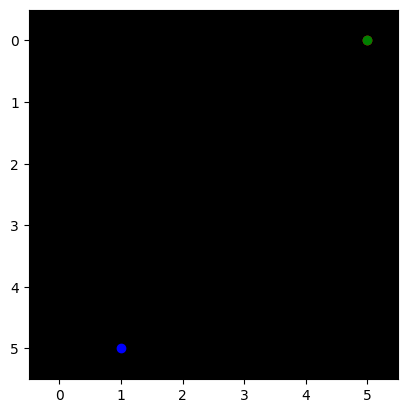

[-0.010108715]
 gamma 0.8
[-1]
[-0.010108715]
return [-1.0]
gae [-0.9898912850767374]
0.43423048837101264
tensor([[3., 1., 1., 0.]])


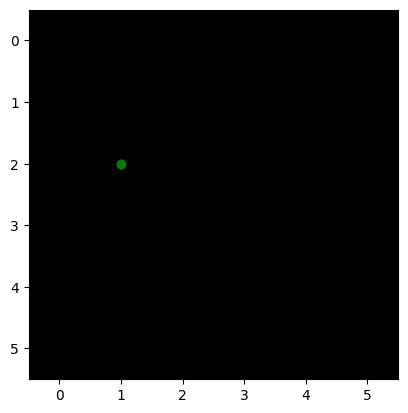

[-0.06254084]
 gamma 0.8
[1]
[-0.06254084]
return [1.0]
gae [1.0625408366322517]
0.2064618674615839
tensor([[ 2.,  3.,  2., -2.]])
tensor([[ 2.,  2.,  2., -3.]])
tensor([[ 3.,  2.,  3., -3.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 5.,  2.,  5., -3.]])
tensor([[ 5.,  1.,  5., -4.]])
tensor([[ 5.,  2.,  5., -3.]])
tensor([[ 5.,  3.,  5., -2.]])
tensor([[ 5.,  2.,  5., -3.]])


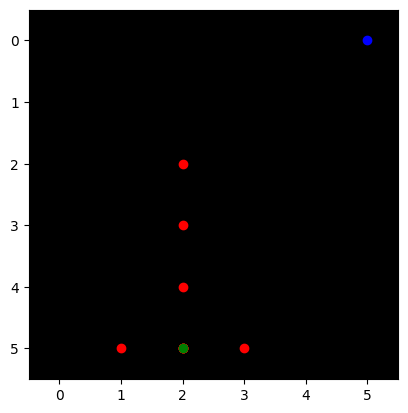

[-0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937]
return [-0.040794035792350775, -0.04023733139038086, -0.04329206049442291, -0.04773834943771363, -0.03928531110286713, -0.04773834943771363, -0.035126385092735295, -0.04773834943771363, -1.0]
gae [-0.0003333412110805567, 0.0107552133500576, 0.007004603743553162, 0.006376726180315012, 0.0203876256942749, 0.0013682894408702795, 0.024546551704406734, -0.0038303680717945154, -0.940327063202858]
0.7020856391993988


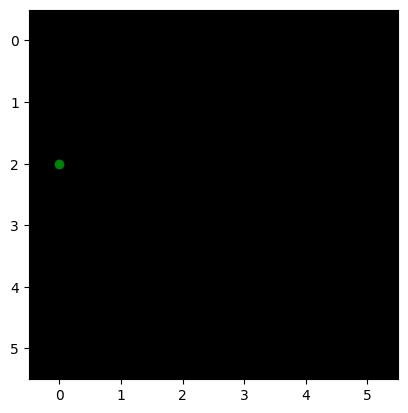

[-0.010108715, -0.06254084, -0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937]
 gamma 0.8
[]
[-0.010108715, -0.06254084, -0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937]
return []
gae []
0.4759294730490172
tensor([[ 3.,  4., -1.,  1.]])
tensor([[ 3.,  3., -1.,  0.]])
tensor([[ 3.,  4., -1.,  1.]])
tensor([[ 3.,  4., -1.,  1.]])
tensor([[ 3.,  5., -1.,  2.]])


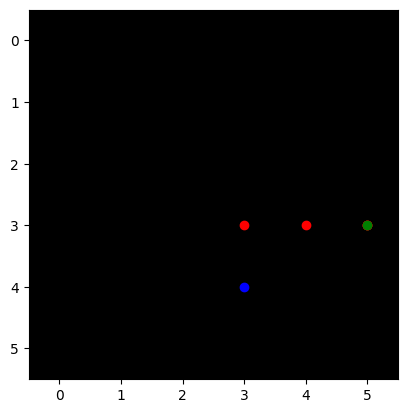

[-0.014927746, -0.07111295, -0.014927746, -0.009814544]
 gamma 0.8
[0, 0, 0, -1]
[-0.014927746, -0.07111295, -0.014927746, -0.009814544]
return [-0.05689036250114441, -0.011942196637392044, -0.007851634919643403, -1.0]
gae [-0.041962616704404355, 0.05917075648903847, 0.007076110877096652, -0.9901854563504457]
0.3456929254667599


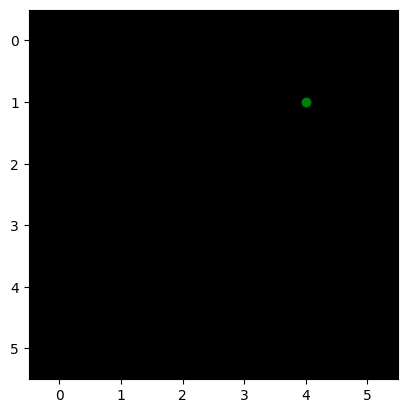

[-0.010108715, -0.06254084, -0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937, -0.014927746, -0.07111295, -0.014927746, -0.009814544]
 gamma 0.8
[]
[-0.010108715, -0.06254084, -0.040460695, -0.050992545, -0.050296664, -0.054115076, -0.059672937, -0.04910664, -0.059672937, -0.04390798, -0.059672937, -0.014927746, -0.07111295, -0.014927746, -0.009814544]
return []
gae []
0.7006636555795326
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  1., -4., -4.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  2., -4., -3.]])
tensor([[ 0.,  3., -4., -2.]])
tensor([[ 0.,  3., -4., -2.]])


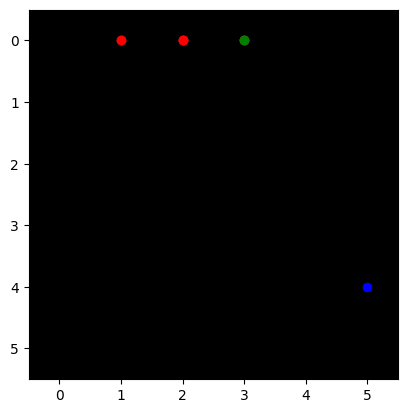

[-0.005945747, -0.016291704, -0.054597605, -0.016291704, -0.054597605, -0.016291704, -0.005945747]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.005945747, -0.016291704, -0.054597605, -0.016291704, -0.054597605, -0.016291704, -0.005945747]
return [-0.013033363223075868, -0.043678084015846254, -0.013033363223075868, -0.043678084015846254, -0.013033363223075868, -0.004756597429513932, -1.0]
gae [-0.007087616436183454, -0.02738637998700142, 0.041564241796731946, -0.02738637998700142, 0.041564241796731946, 0.0115351065993309, -0.9940542532131076]
0.5276178308646091
tensor([[3., 4., 0., 3.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 5., 0., 4.]])
tensor([[3., 5., 0., 4.]])
tensor([[ 2.,  5., -1.,  4.]])
tensor([[3., 5., 0., 4.]])
tensor([[3., 5., 0., 4.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 3., 0., 2.]])
tensor([[3., 3., 0., 2.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 4., 0., 3.]])
tensor([[3., 5., 0., 4.]])
tensor([[3., 5., 0., 4.]])
tensor([[3., 4., 0., 3.]])
tens

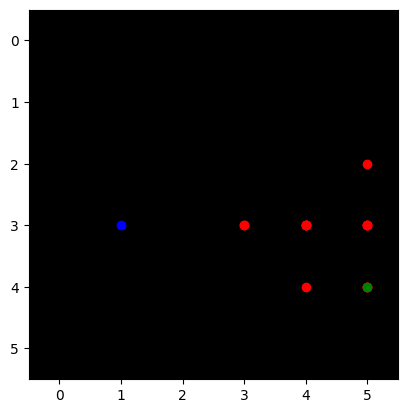

[-0.009169009, -0.0075172856, -0.009873182, -0.0075172856, -0.009169009, -0.03763546, -0.009169009, -0.0075172856, -0.009169009, -0.03763546, -0.009169009, -0.02165578, -0.0037590684]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.009169009, -0.0075172856, -0.009873182, -0.0075172856, -0.009169009, -0.03763546, -0.009169009, -0.0075172856, -0.009169009, -0.03763546, -0.009169009, -0.02165578, -0.0037590684]
return [-0.00601382851600647, -0.007898545265197754, -0.00601382851600647, -0.007335206866264344, -0.030108368396759035, -0.007335206866264344, -0.00601382851600647, -0.007335206866264344, -0.030108368396759035, -0.007335206866264344, -0.017324623465538026, -0.0030072547495365145, -1.0]
gae [0.003155180066823959, -0.0003812596201896671, 0.0038593530654907225, 0.00018207877874374355, -0.020939359813928606, 0.03030025362968445, 0.003155180066823959, 0.00018207877874374355, -0.020939359813928606, 0.03030025362968445, -0.008155614882707597, 0.018648524582386018, -0.996240931563

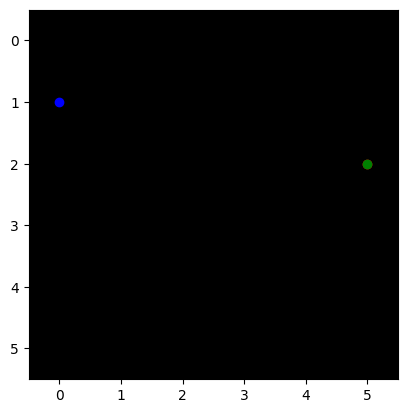

[-0.010552394]
 gamma 0.8
[-1]
[-0.010552394]
return [-1.0]
gae [-0.9894476057961583]
0.40095638360462915
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  2., -3., -2.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  4., -3.,  0.]])
tensor([[ 0.,  5., -3.,  1.]])
tensor([[ 0.,  5., -3.,  1.]])


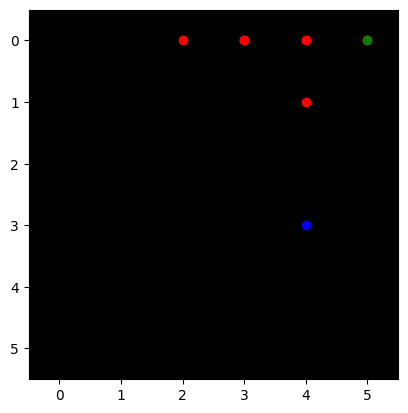

[-0.033712875, -0.03354434, -0.033712875, -0.021876138, -0.017747631, -0.021876138, -0.033712875, -0.014084153]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.033712875, -0.03354434, -0.033712875, -0.021876138, -0.017747631, -0.021876138, -0.033712875, -0.014084153]
return [-0.026835471391677856, -0.02697030007839203, -0.01750091016292572, -0.014198105037212373, -0.01750091016292572, -0.02697030007839203, -0.011267322301864625, -1.0]
gae [0.0068774037063121796, 0.006574039161205289, 0.016211964935064316, 0.007678032666444777, 0.00024672113358974526, -0.005094162374734881, 0.02244555279612541, -0.9859158471226692]
0.9210228541877179
tensor([[4., 1., 1., 1.]])
tensor([[4., 1., 1., 1.]])
tensor([[4., 0., 1., 0.]])
tensor([[4., 0., 1., 0.]])


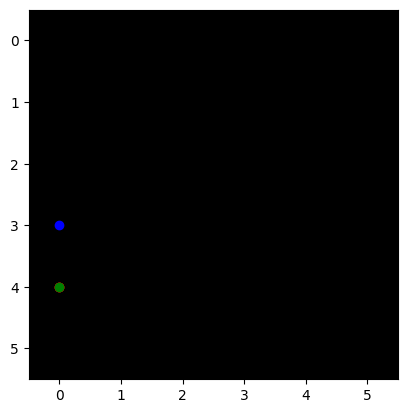

[-0.07140632, -0.062445693]
 gamma 0.8
[0, -1]
[-0.07140632, -0.062445693]
return [-0.04995655417442322, -1.0]
gae [0.021449765563011168, -0.937554307281971]
0.9366265019632684
tensor([[5., 4., 5., 0.]])
tensor([[5., 4., 5., 0.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 4.,  3.,  4., -1.]])
tensor([[ 5.,  3.,  5., -1.]])
tensor([[ 5.,  3.,  5., -1.]])


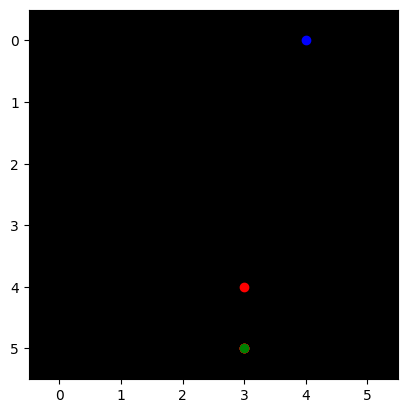

[-0.06551406, -0.04862786, -0.04688623, -0.04862786]
 gamma 0.8
[0, 0, 0, -1]
[-0.06551406, -0.04862786, -0.04688623, -0.04862786]
return [-0.03890228867530823, -0.037508985400199896, -0.03890228867530823, -1.0]
gae [0.026611769199371332, 0.011118875443935389, 0.00798394307494163, -0.9513721391558647]
return [-0.00733521 -0.00733521 -0.00733521 -0.00733521 -0.00601383 -0.00601383
 -0.00601383 -0.0047566  -0.00300725  1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.05689036]

-------------------- Iteration #65 --------------------
random  0.9366265019632684
Average : 0.01
Average Episodic Return: -0.63
Max Episodic Return: 1.0
Average Loss: -0.00195
Average Loss Critic: 0.23576165735721588
TEntropy: nan
approx_kl_divs: [6.527014e-05] secs
------------------------------------------------------

0.5803140510428291
tensor([[5., 5., 3., 2.]])


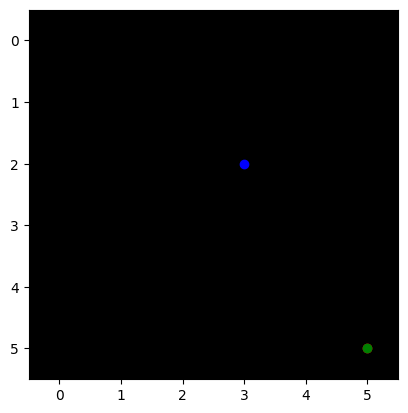

[-0.31686765]
 gamma 0.8
[-1]
[-0.31686765]
return [-1.0]
gae [-0.6831323504447937]
0.6690635856111552
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  0., -2., -4.]])
tensor([[ 3.,  0., -2., -4.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 2.,  0., -3., -4.]])
tensor([[ 2.,  1., -3., -3.]])
tensor([[ 1.,  1., -4., -3.]])
tensor([[ 1.,  1., -4., -3.]])
tensor([[ 1.,  0., -4., -4.]])
tensor([[ 1.,  0., -4., -4.]])


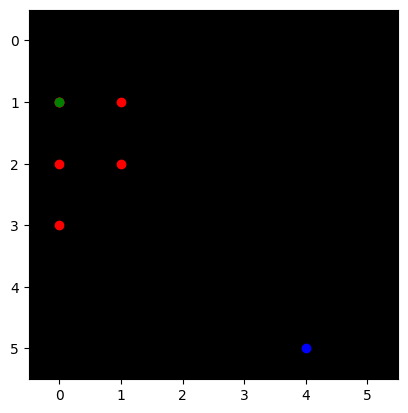

[-0.25386298, -0.25374615, -0.25370452, -0.2538913, -0.25970986, -0.25370234]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.25386298, -0.25374615, -0.25370452, -0.2538913, -0.25970986, -0.25370234]
return [-0.20299692153930665, -0.20296361446380617, -0.2031130313873291, -0.20776789188385011, -0.20296187400817872, -1.0]
gae [0.050866055488586415, 0.050782537460327126, 0.05059148669242858, 0.04612339735031126, 0.0567479908466339, -0.7462976574897766]
0.6529380409393879
tensor([[ 3.,  1.,  2., -4.]])
tensor([[ 3.,  1.,  2., -4.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 3.,  3.,  2., -2.]])
tensor([[ 4.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  4., -2.]])
tensor([[ 5.,  2.,  4., -3.]])
tensor([[ 5.

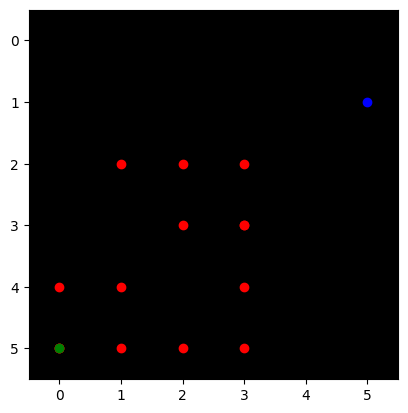

[-0.24990721, -0.25374398, -0.25380194, -0.24514462, -0.23120306, -0.25472888, -0.23120306, -0.21560791, -0.21489178, -0.21886225, -0.22595091, -0.22673573, -0.22762427, -0.22608286]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.24990721, -0.25374398, -0.25380194, -0.24514462, -0.23120306, -0.25472888, -0.23120306, -0.21560791, -0.21489178, -0.21886225, -0.22595091, -0.22673573, -0.22762427, -0.22608286]
return [-0.2029951810836792, -0.20304155349731445, -0.19611569643020632, -0.1849624514579773, -0.20378310680389405, -0.1849624514579773, -0.17248632907867434, -0.17191342115402222, -0.17508980035781863, -0.18076072931289675, -0.1813885807991028, -0.18209941387176515, -0.18086628913879396, -1.0]
gae [0.04691202938556671, 0.050702422857284546, 0.057686245441436745, 0.06018216907978058, 0.027419957518577565, 0.06976643204689026, 0.05871673524379728, 0.04369449019432067, 0.039801976084709145, 0.03810152113437651, 0.044562330842018105, 0.04463631212711333, 0.04675797820091246, 

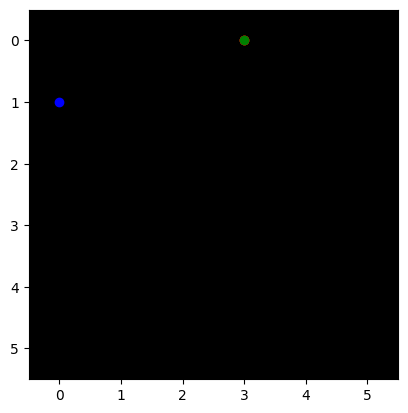

[-0.3187173, -0.34242713]
 gamma 0.8
[0, -1]
[-0.3187173, -0.34242713]
return [-0.273941707611084, -1.0]
gae [0.044775593280792225, -0.657572865486145]
0.6970135771834721
tensor([[ 3.,  3., -1.,  3.]])
tensor([[ 3.,  3., -1.,  3.]])
tensor([[4., 3., 0., 3.]])
tensor([[4., 3., 0., 3.]])
tensor([[5., 3., 1., 3.]])
tensor([[5., 3., 1., 3.]])
tensor([[5., 2., 1., 2.]])
tensor([[5., 2., 1., 2.]])
tensor([[5., 1., 1., 1.]])
tensor([[5., 0., 1., 0.]])


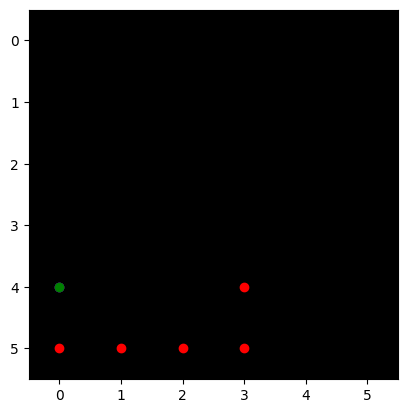

[-0.33454338, -0.3241322, -0.32903054, -0.30377933, -0.2137461, -0.2197992]
 gamma 0.8
[0, 0, 0, 0, 0, 1]
[-0.33454338, -0.3241322, -0.32903054, -0.30377933, -0.2137461, -0.2197992]
return [-0.2593057632446289, -0.2632244348526001, -0.24302346706390382, -0.17099688053131104, -0.175839364528656, 1.0]
gae [0.0752376139163971, 0.060907769203186024, 0.0860070765018463, 0.13278245329856872, 0.03790673613548279, 1.21979920566082]
0.4804277459472793
tensor([[ 1.,  5., -1.,  2.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 0.,  4., -2.,  1.]])
tensor([[ 0.,  4., -2.,  1.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  4., -1.,  1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 0.,  3., -2.,  0.]])
tensor([[ 0.,  3., -2.,  0.]])
tensor([[ 0.,  2., -2., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 3.,  2.,  1., -1

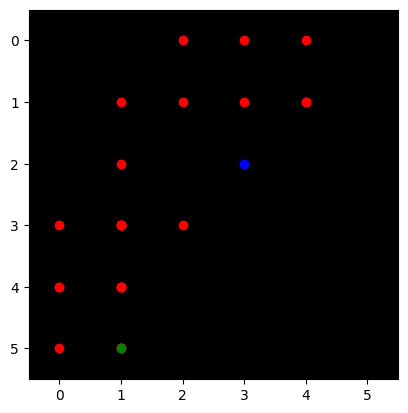

[-0.3502043, -0.34443483, -0.33990633, -0.34443483, -0.3130151, -0.31784296, -0.26216492, -0.2551772, -0.25380987, -0.253812, -0.24817488, -0.2340424, -0.24817488, -0.22621925, -0.22683448, -0.22621925, -0.24817488, -0.22621925, -0.24817488, -0.24982387, -0.22683448, -0.22642481, -0.22308992]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.3502043, -0.34443483, -0.33990633, -0.34443483, -0.3130151, -0.31784296, -0.26216492, -0.2551772, -0.25380987, -0.253812, -0.24817488, -0.2340424, -0.24817488, -0.22621925, -0.22683448, -0.22621925, -0.24817488, -0.22621925, -0.24817488, -0.24982387, -0.22683448, -0.22642481, -0.22308992]
return [-0.2755478620529175, -0.27192506790161136, -0.2755478620529175, -0.2504120826721192, -0.2542743682861328, -0.20973193645477295, -0.20414175987243655, -0.20304789543151858, -0.2030495882034302, -0.19853990077972414, -0.18723392486572266, -0.19853990077972414, -0.1809754014015198, -0.1814675807952881, -0.1809754014015198, 

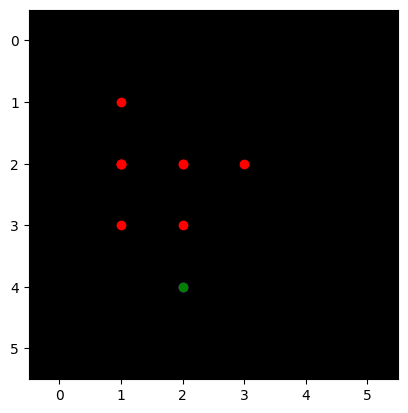

[-0.14391553, -0.11795805, -0.12742208, -0.11795805, -0.13679588, -0.11795805, -0.17117806, -0.1754233, -0.17117806, -0.17035164]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.14391553, -0.11795805, -0.12742208, -0.11795805, -0.13679588, -0.11795805, -0.17117806, -0.1754233, -0.17117806, -0.17035164]
return [-0.09436643719673157, -0.10193766355514527, -0.09436643719673157, -0.1094367027282715, -0.09436643719673157, -0.13694244623184204, -0.14033863544464112, -0.13694244623184204, -0.1362813115119934, 1.0]
gae [0.04954909682273864, 0.016020382940769184, 0.03305564224720001, 0.008521343767642964, 0.04242944121360778, -0.018984399735927582, 0.030839422345161432, 0.03848084807395935, 0.03489674627780914, 1.1703516393899918]
0.9102505157676223
tensor([[ 1.,  0., -1., -5.]])
tensor([[ 1.,  0., -1., -5.]])
tensor([[ 2.,  0.,  0., -5.]])
tensor([[ 2.,  0.,  0., -5.]])


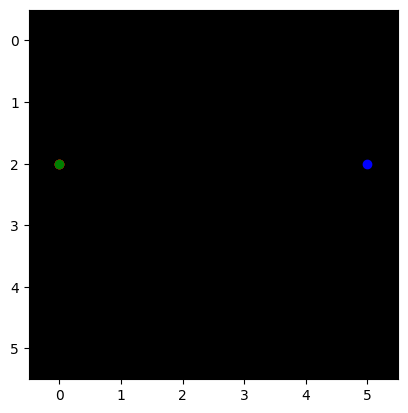

[-0.14212345, -0.14215194]
 gamma 0.8
[0, -1]
[-0.14212345, -0.14215194]
return [-0.11372154951095581, -1.0]
gae [0.028401896357536316, -0.8578480631113052]
0.9996209695749455
tensor([[ 5.,  0.,  1., -4.]])
tensor([[ 5.,  0.,  1., -4.]])
tensor([[ 5.,  1.,  1., -3.]])
tensor([[ 5.,  1.,  1., -3.]])
tensor([[ 5.,  2.,  1., -2.]])
tensor([[ 5.,  2.,  1., -2.]])
tensor([[ 5.,  1.,  1., -3.]])
tensor([[ 5.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  0., -3.]])
tensor([[ 4.,  1.,  0., -3.]])
tensor([[ 4.,  2.,  0., -2.]])
tensor([[ 4.,  2.,  0., -2.]])
tensor([[ 4.,  3.,  0., -1.]])
tensor([[ 4.,  3.,  0., -1.]])


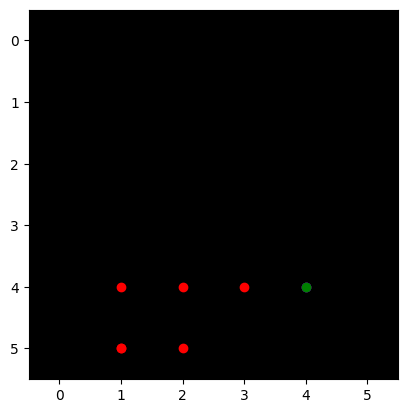

[-0.1291442, -0.12461491, -0.11611179, -0.12461491, -0.14145607, -0.12396616, -0.15771332]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 1]
[-0.1291442, -0.12461491, -0.11611179, -0.12461491, -0.14145607, -0.12396616, -0.15771332]
return [-0.09969192743301392, -0.0928894340991974, -0.09969192743301392, -0.11316485404968263, -0.09917292594909669, -0.12617065906524658, 1.0]
gae [0.029452279210090637, 0.03172547519207, 0.01641986519098282, 0.011450055241584767, 0.042283141613006586, -0.002204501628875727, 1.1577133238315582]
0.802290671534253
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 4.,  2.,  1., -3.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 4.,  3.,  1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 2.,  0., -1., -5.]])
tensor([[ 2.,  0., -1., -5.]])


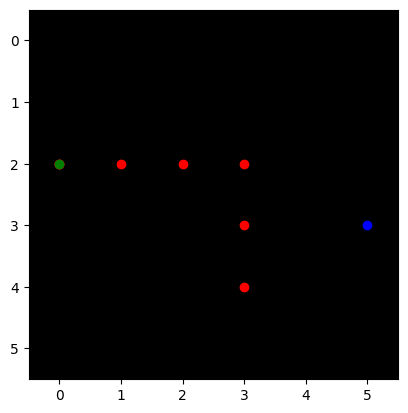

[-0.12243867, -0.16491377, -0.15767328, -0.1581709, -0.13589433, -0.1422404, -0.14217001]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.12243867, -0.16491377, -0.15767328, -0.1581709, -0.13589433, -0.1422404, -0.14217001]
return [-0.13193101882934571, -0.1261386275291443, -0.12653671503067018, -0.10871546268463135, -0.11379232406616212, -0.11373600959777833, -1.0]
gae [-0.0094923496246338, 0.03877514600753784, 0.031136569380760176, 0.04945543110370636, 0.022102004289627067, 0.02850439548492431, -0.8578299880027771]
0.8515242676403976
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 1.,  3., -4.,  1.]])
tensor([[ 1.,  3., -4.,  1.]])
tensor([[ 0.,  3., -5.,  1.]])
tensor([[ 0.,  3., -5.,  1.]])
tensor([[ 0.,  2., -5.,  0.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 1.,  2., -4.,  0.]])
tensor([[ 0.,  2., -5.,  0.]])
ten

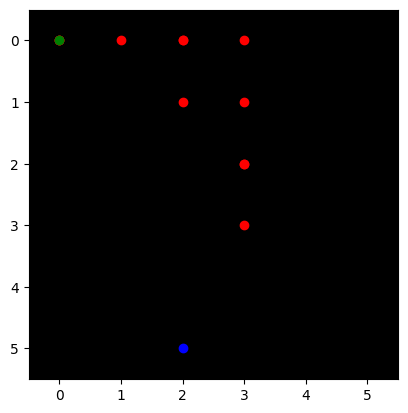

[-0.16963078, -0.17758311, -0.16963078, -0.17758311, -0.18020296, -0.17967477, -0.16750933, -0.16997789, -0.16750933, -0.15310977, -0.11572767]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.16963078, -0.17758311, -0.16963078, -0.17758311, -0.18020296, -0.17967477, -0.16750933, -0.16997789, -0.16750933, -0.15310977, -0.11572767]
return [-0.142066490650177, -0.13570462465286257, -0.142066490650177, -0.14416236877441407, -0.14373981952667236, -0.134007465839386, -0.13598231077194214, -0.134007465839386, -0.1224878191947937, -0.09258213639259338, -1.0]
gae [0.027564290165901173, 0.04187848865985869, 0.027564290165901173, 0.03342074453830718, 0.036463141441345215, 0.04566730856895446, 0.03152702152729034, 0.035970422625541676, 0.045021513104438776, 0.06052763760089874, -0.8842723295092583]
0.01955852827896387
tensor([[ 2.,  3.,  2., -2.]])
tensor([[ 3.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 5.,  3.,  5., -2.]])
tensor([[ 5.,  2.,  5., -3.]])


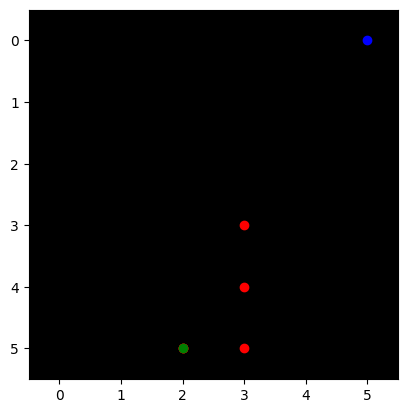

[-0.1430173, -0.13594447, -0.13140324, -0.13186648, -0.10323629]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.1430173, -0.13594447, -0.13140324, -0.13186648, -0.10323629]
return [-0.10875557661056519, -0.10512259006500245, -0.10549318790435791, -0.0825890302658081, -1.0]
gae [0.034261730313301084, 0.030821880698204032, 0.02591004967689514, 0.04927745461463928, -0.8967637121677399]
0.9189100371649207
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  2., -2.,  1.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 1.,  1., -1.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])
tensor([[ 0.,  1., -2.,  0.]])


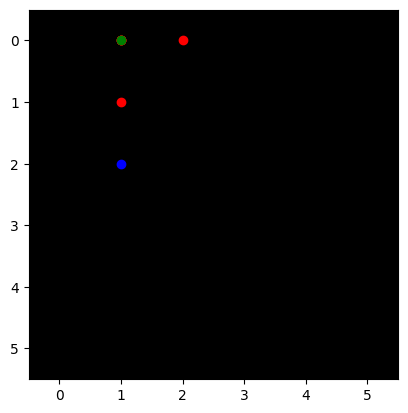

[-0.14755914, -0.16375908, -0.14755914, -0.1405689, -0.14755914]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.14755914, -0.16375908, -0.14755914, -0.1405689, -0.14755914]
return [-0.1310072660446167, -0.11804730892181398, -0.11245511770248413, -0.11804730892181398, -1.0]
gae [0.016551870107650746, 0.0457117736339569, 0.03510401844978332, 0.022521588206291188, -0.8524408638477325]
0.5591611488083071


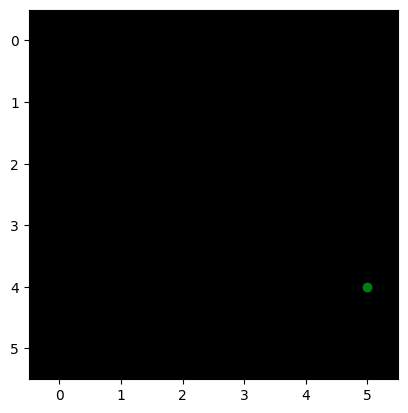

[-0.14391553, -0.11795805, -0.12742208, -0.11795805, -0.13679588, -0.11795805, -0.17117806, -0.1754233, -0.17117806, -0.17035164, -0.14212345, -0.14215194, -0.1291442, -0.12461491, -0.11611179, -0.12461491, -0.14145607, -0.12396616, -0.15771332, -0.12243867, -0.16491377, -0.15767328, -0.1581709, -0.13589433, -0.1422404, -0.14217001, -0.16963078, -0.17758311, -0.16963078, -0.17758311, -0.18020296, -0.17967477, -0.16750933, -0.16997789, -0.16750933, -0.15310977, -0.11572767, -0.1430173, -0.13594447, -0.13140324, -0.13186648, -0.10323629, -0.14755914, -0.16375908, -0.14755914, -0.1405689, -0.14755914]
 gamma 0.8
[]
[-0.14391553, -0.11795805, -0.12742208, -0.11795805, -0.13679588, -0.11795805, -0.17117806, -0.1754233, -0.17117806, -0.17035164, -0.14212345, -0.14215194, -0.1291442, -0.12461491, -0.11611179, -0.12461491, -0.14145607, -0.12396616, -0.15771332, -0.12243867, -0.16491377, -0.15767328, -0.1581709, -0.13589433, -0.1422404, -0.14217001, -0.16963078, -0.17758311, -0.16963078, -0.177

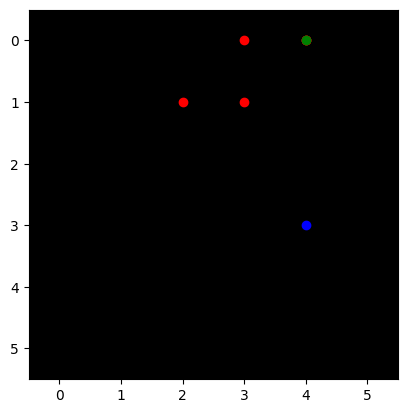

[-0.16602378, -0.13417643, -0.16602378, -0.16193148, -0.17922083]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.16602378, -0.13417643, -0.16602378, -0.16193148, -0.17922083]
return [-0.10734114646911622, -0.13281902074813842, -0.12954518795013428, -0.14337666034698487, -1.0]
gae [0.05868262946605682, 0.0013574123382568415, 0.03647858798503875, 0.018554824590682972, -0.8207791745662689]
return [-0.09969193 -0.09917293 -0.09436644 -0.09436644 -0.09436644 -0.09288944
 -0.09258214 -0.08258903  1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -0.14416237 -0.14373982 -0.14337666 -0.1420665 ]

-------------------- Iteration #67 --------------------
random  0.8661848153746271
Average : 0.01
Average Episodic Return: -0.63
Max Episodic Return: 1.0
Average Loss: -0.00054
Average Loss Critic: 0.23447780311107635
TEntropy: nan
approx_kl_divs: [5.486182e-05] secs
------------------------------------------------------

0.13125537828385292
tensor([[ 2.,  1., -1., -1.]

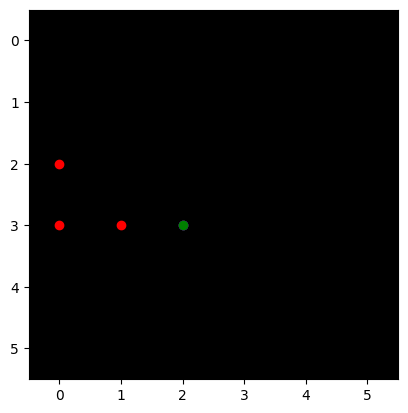

[-0.07682945, -0.080747776, -0.077536315, -0.06656904]
 gamma 0.8
[0, 0, 0, 1]
[-0.07682945, -0.080747776, -0.077536315, -0.06656904]
return [-0.06459822058677674, -0.062029051780700686, -0.05325523018836975, 1.0]
gae [0.012231227755546567, 0.01871872395277023, 0.024281084537506104, 1.0665690377354622]
0.264158102106959
tensor([[ 1.,  1.,  0., -1.]])
tensor([[ 1.,  1.,  0., -1.]])
tensor([[ 2.,  1.,  1., -1.]])
tensor([[ 2.,  0.,  1., -2.]])
tensor([[ 2.,  0.,  1., -2.]])
tensor([[ 3.,  0.,  2., -2.]])
tensor([[ 3.,  1.,  2., -1.]])
tensor([[ 3.,  1.,  2., -1.]])
tensor([[3., 2., 2., 0.]])
tensor([[3., 2., 2., 0.]])
tensor([[ 3.,  1.,  2., -1.]])
tensor([[ 4.,  1.,  3., -1.]])
tensor([[ 4.,  0.,  3., -2.]])
tensor([[ 4.,  1.,  3., -1.]])
tensor([[ 4.,  0.,  3., -2.]])
tensor([[ 4.,  1.,  3., -1.]])
tensor([[ 4.,  0.,  3., -2.]])
tensor([[ 4.,  0.,  3., -2.]])


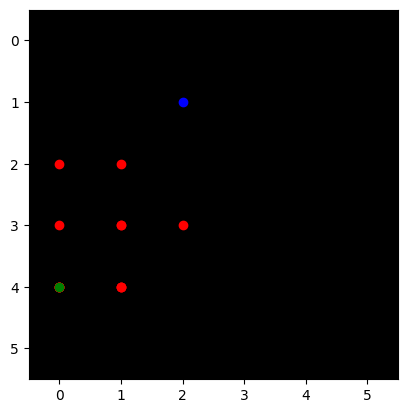

[-0.0746579, -0.0650825, -0.079263076, -0.0673608, -0.06235666, -0.13279232, -0.06235666, -0.06300023, -0.06486558, -0.06300023, -0.06486558, -0.06300023, -0.06486558]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.0746579, -0.0650825, -0.079263076, -0.0673608, -0.06235666, -0.13279232, -0.06235666, -0.06300023, -0.06486558, -0.06300023, -0.06486558, -0.06300023, -0.06486558]
return [-0.05206599831581116, -0.06341046094894409, -0.05388864278793335, -0.04988532662391663, -0.10623385906219483, -0.04988532662391663, -0.050400185585021975, -0.05189246535301209, -0.050400185585021975, -0.05189246535301209, -0.050400185585021975, -0.05189246535301209, -1.0]
gae [0.022591903805732727, 0.0016720369458198547, 0.025374433398246764, 0.01747547686100006, -0.04387720078229905, 0.08290699720382691, 0.011956472694873807, 0.011107766628265375, 0.01446539610624313, 0.011107766628265375, 0.01446539610624313, 0.011107766628265375, -0.9351344183087349]
0.49693924790323885
tensor([[ 1.,  4., -3., 

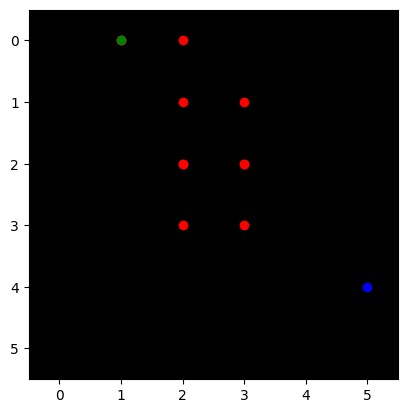

[-0.13190192, -0.11950899, -0.12723012, -0.12160978, -0.078314096, -0.07999764, -0.12723012, -0.07999764, -0.06893092, -0.075605765, -0.077177]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13190192, -0.11950899, -0.12723012, -0.12160978, -0.078314096, -0.07999764, -0.12723012, -0.07999764, -0.06893092, -0.075605765, -0.077177]
return [-0.09560719132423401, -0.10178409814834595, -0.09728782176971436, -0.06265127658843994, -0.06399810910224915, -0.10178409814834595, -0.06399810910224915, -0.055144733190536505, -0.06048461198806763, -0.06174160242080689, -1.0]
gae [0.03629472851753235, 0.01772489100694656, 0.029942300915718076, 0.058958500623703, 0.014315986633300776, -0.021786461770534518, 0.06323201358318328, 0.024852903187274927, 0.008446304500102995, 0.013864162564277645, -0.9228229969739914]
0.7849912600614019
tensor([[3., 4., 3., 4.]])
tensor([[3., 4., 3., 4.]])
tensor([[3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.]])
tensor([[3., 2., 3., 2.]])
tensor([[3., 2., 3., 2.]])
tensor([[

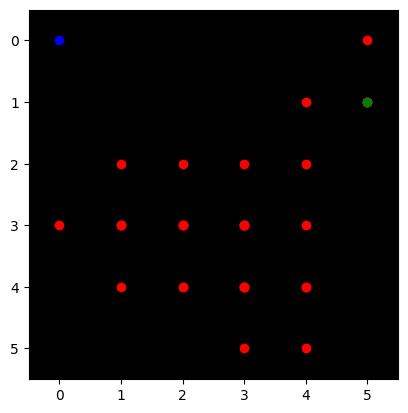

[-0.13386789, -0.13042787, -0.1351248, -0.11761132, -0.1351248, -0.13042787, -0.12714869, -0.13042787, -0.13483164, -0.13042787, -0.13483164, -0.14131518, -0.12260193, -0.11761132, -0.0642688, -0.11761132, -0.1153173, -0.12812161, -0.1351248, -0.14131518, -0.13483164, -0.14754109, -0.13483164, -0.13715716, -0.14274201, -0.13715716, -0.13386789, -0.1314047, -0.12926544, -0.1337944, -0.13097541, -0.1337944]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13386789, -0.13042787, -0.1351248, -0.11761132, -0.1351248, -0.13042787, -0.12714869, -0.13042787, -0.13483164, -0.13042787, -0.13483164, -0.14131518, -0.12260193, -0.11761132, -0.0642688, -0.11761132, -0.1153173, -0.12812161, -0.1351248, -0.14131518, -0.13483164, -0.14754109, -0.13483164, -0.13715716, -0.14274201, -0.13715716, -0.13386789, -0.1314047, -0.12926544, -0.1337944, -0.13097541, -0.1337944]
return [-0.10434229373931886, -0.10809984207153321, -0.09408905506134034,

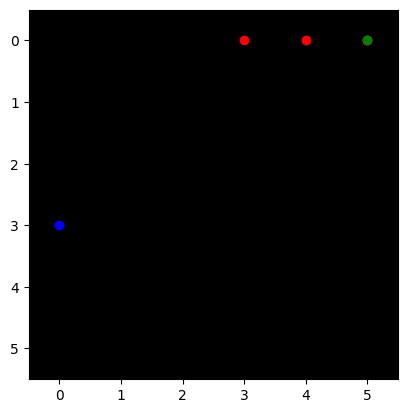

[-0.11606753, -0.14538634, -0.15123753, -0.15258835]
 gamma 0.8
[0, 0, 0, -1]
[-0.11606753, -0.14538634, -0.15123753, -0.15258835]
return [-0.11630907058715821, -0.12099002599716187, -0.12207068204879762, -1.0]
gae [-0.0002415418624878013, 0.024396312236785886, 0.029166850447654713, -0.847411647439003]
0.7605195107445177
tensor([[5., 2., 0., 2.]])
tensor([[5., 2., 0., 2.]])
tensor([[5., 3., 0., 3.]])
tensor([[5., 3., 0., 3.]])
tensor([[ 4.,  3., -1.,  3.]])
tensor([[ 4.,  3., -1.,  3.]])
tensor([[ 3.,  3., -2.,  3.]])
tensor([[ 3.,  4., -2.,  4.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  4., -4.,  4.]])
tensor([[ 1.,  5., -4.,  5.]])
tensor([[ 1.,  5., -4.,  5.]])


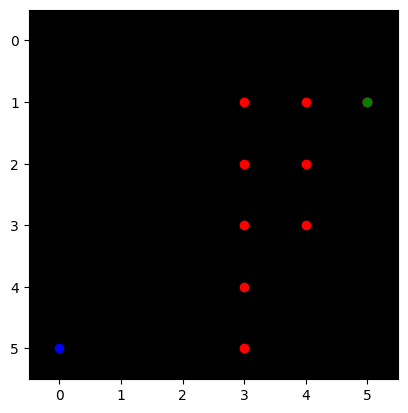

[-0.17690063, -0.17452815, -0.1686321, -0.16624299, -0.1685094, -0.15766758, -0.15185983, -0.15033141, -0.15195283, -0.15337314]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.17690063, -0.17452815, -0.1686321, -0.16624299, -0.1685094, -0.15766758, -0.15185983, -0.15033141, -0.15195283, -0.15337314]
return [-0.13962252140045167, -0.13490568399429323, -0.1329943895339966, -0.13480751514434816, -0.1261340618133545, -0.12148786783218385, -0.12026512622833252, -0.12156226634979249, -0.12269850969314576, -1.0]
gae [0.037278103828430165, 0.039622467756271346, 0.03563771545886993, 0.031435471773147566, 0.042375332117080694, 0.036179709434509266, 0.03159470856189728, 0.02876914143562316, 0.02925432324409484, -0.8466268628835678]
0.6219289546932761
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 3.,  4., -2., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 2.,  4., -3., -1.]])
tensor([[ 2.,  3., -3., -2.]])
tensor([[ 1.,  3., -4., -2.]])
te

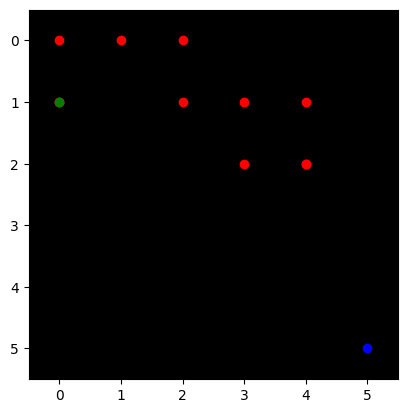

[-0.15340883, -0.15107086, -0.14514355, -0.15107086, -0.13578479, -0.13338293, -0.06851374, -0.074974366, -0.059218716, -0.059949443, -0.068727724]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.15340883, -0.15107086, -0.14514355, -0.15107086, -0.13578479, -0.13338293, -0.06851374, -0.074974366, -0.059218716, -0.059949443, -0.068727724]
return [-0.12085669040679932, -0.11611484289169312, -0.12085669040679932, -0.10862783193588257, -0.10670634508132935, -0.05481099486351013, -0.05997949242591858, -0.047374972701072694, -0.047959554195404056, -0.054982179403305055, -1.0]
gae [0.032552134990692136, 0.03495602011680603, 0.024286863207817075, 0.04244303107261657, 0.029078444838523856, 0.07857193648815156, 0.008534251153469084, 0.02759939283132553, 0.01125916168093681, 0.004967263340950011, -0.9312722757458687]
0.2663077942521297
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  4., -2.,  3.]])
tensor([[ 2.,  3., -2.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor([[ 3.,  3., -1.,  2.]])
tensor

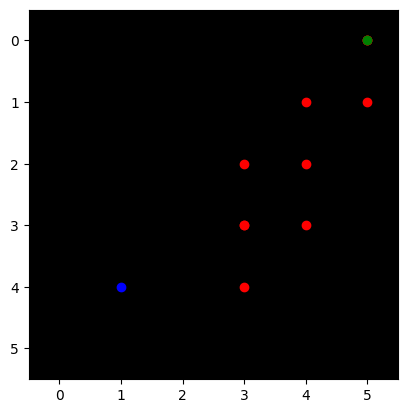

[-0.15811084, -0.15097561, -0.16534625, -0.16836068, -0.16534625, -0.16726208, -0.15811084, -0.15141134, -0.15289128, -0.15170535]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.15811084, -0.15097561, -0.16534625, -0.16836068, -0.16534625, -0.16726208, -0.15811084, -0.15141134, -0.15289128, -0.15170535]
return [-0.12078049182891847, -0.13227699995040895, -0.13468854427337648, -0.13227699995040895, -0.13380966186523438, -0.12648867368698122, -0.1211290717124939, -0.12231302261352539, -0.12136428356170655, -1.0]
gae [0.037330350279808036, 0.01869861483573912, 0.030657705664634688, 0.03608368039131163, 0.03153658807277679, 0.04077340364456175, 0.0369817703962326, 0.02909831702709198, 0.03152699470520019, -0.8482946455478668]
0.6006880699077487
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 3.,  0.,  0., -5.]])
tensor([[ 2.,  0., -1., -5.]])


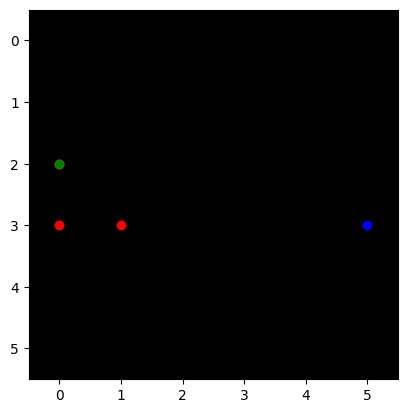

[-0.066605784, -0.06674053, -0.06652999, -0.066278026]
 gamma 0.8
[0, 0, 0, -1]
[-0.066605784, -0.06674053, -0.06652999, -0.066278026]
return [-0.05339242219924927, -0.05322399139404297, -0.05302242040634156, -1.0]
gae [0.013213361799716945, 0.013516536355018614, 0.013507568836212153, -0.9337219744920731]
0.9497170898619366
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  1.,  1., -4.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 3.,  2.,  2., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 1.,  4.,  0., -1.]])
tensor([[ 1.,  4.,  0., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[2., 5., 1., 0.]])
tensor([[2., 5., 1., 0.]])
tensor([[3., 5., 2., 0.]])
tensor([[3., 5., 2., 0.]])


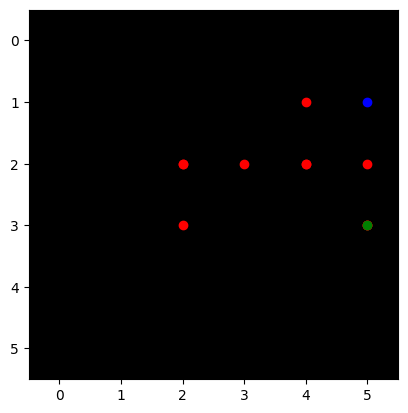

[-0.06640606, -0.066995814, -0.06780166, -0.066995814, -0.09909896, -0.1540035, -0.13136889, -0.1540035, -0.16515356, -0.16490485]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.06640606, -0.066995814, -0.06780166, -0.066995814, -0.09909896, -0.1540035, -0.13136889, -0.1540035, -0.16515356, -0.16490485]
return [-0.05359665155410767, -0.054241329431533813, -0.05359665155410767, -0.07927916646003724, -0.12320280075073242, -0.105095112323761, -0.12320280075073242, -0.13212285041809083, -0.1319238781929016, -1.0]
gae [0.012809404730796808, 0.012754485011100769, 0.014205010235309595, -0.01228335201740266, -0.024103842675685883, 0.04890838861465453, 0.008166089653968811, 0.0218806505203247, 0.03322968482971192, -0.835095152258873]
0.639056375123726
tensor([[5., 4., 2., 1.]])
tensor([[5., 4., 2., 1.]])
tensor([[5., 5., 2., 2.]])
tensor([[5., 5., 2., 2.]])


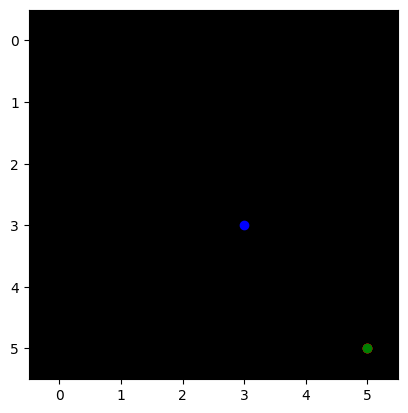

[-0.17688613, -0.17331293]
 gamma 0.8
[0, -1]
[-0.17688613, -0.17331293]
return [-0.13865034580230715, -1.0]
gae [0.03823578059673308, -0.8266870677471161]
return [-0.05498218 -0.05481099 -0.05424133 -0.05359665 -0.05359665 -0.05339242
 -0.05322399 -0.05302242 -0.04795955 -0.04737497]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.13962252 -0.13865034 -0.13490568]

-------------------- Iteration #69 --------------------
random  0.639056375123726
Average : 0.01
Average Episodic Return: -0.64
Max Episodic Return: 1.0
Average Loss: -0.00123
Average Loss Critic: 0.23316839337348938
TEntropy: nan
approx_kl_divs: [0.00021266601] secs
------------------------------------------------------

0.9185470261485942
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])


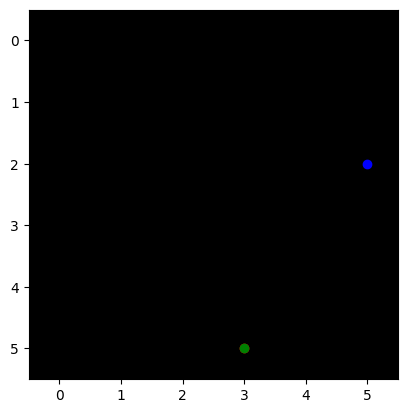

[-0.099777535]
 gamma 0.8
[-1]
[-0.099777535]
return [-1.0]
gae [-0.9002224653959274]
0.5063294329220828
tensor([[5., 5., 1., 3.]])
tensor([[5., 5., 1., 3.]])


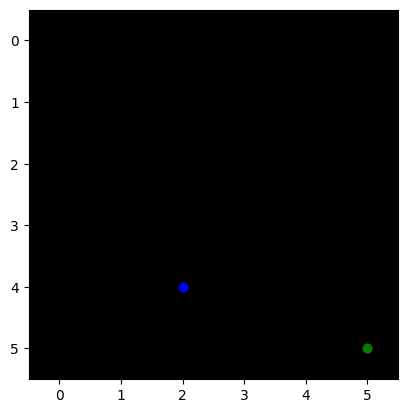

[-0.114055045]
 gamma 0.8
[-1]
[-0.114055045]
return [-1.0]
gae [-0.8859449550509453]
0.009210930257398164
tensor([[ 2.,  0., -3., -3.]])
tensor([[ 1.,  0., -4., -3.]])


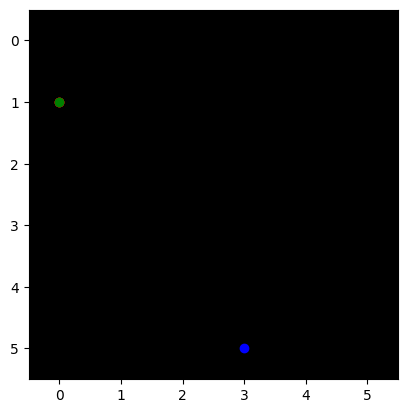

[-0.15821815, -0.1605546]
 gamma 0.8
[0, -1]
[-0.15821815, -0.1605546]
return [-0.1284436821937561, -1.0]
gae [0.0297744631767273, -0.8394453972578049]
0.10298986745805938
tensor([[ 0.,  1., -4.,  1.]])


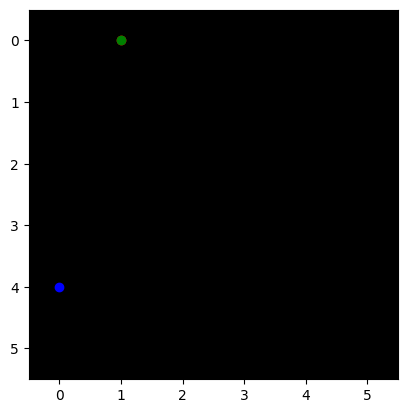

[-0.14096878]
 gamma 0.8
[-1]
[-0.14096878]
return [-1.0]
gae [-0.8590312153100967]
0.19268556843989315
tensor([[ 2.,  2.,  1., -3.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 2.,  3.,  1., -2.]])
tensor([[ 1.,  3.,  0., -2.]])
tensor([[ 1.,  3.,  0., -2.]])
tensor([[ 1.,  4.,  0., -1.]])
tensor([[ 1.,  4.,  0., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[2., 5., 1., 0.]])


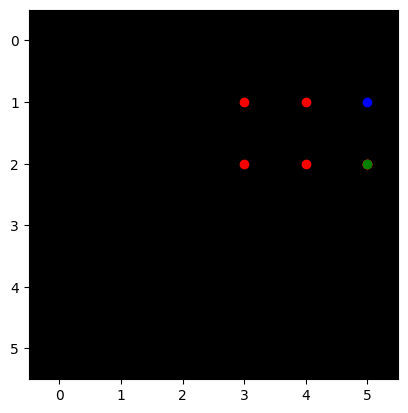

[-0.15369068, -0.11767929, -0.14443515, -0.12796058, -0.117874905, -0.10879882]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.15369068, -0.11767929, -0.14443515, -0.12796058, -0.117874905, -0.10879882]
return [-0.09414343237876893, -0.1155481219291687, -0.10236846208572388, -0.09429992437362672, -0.087039053440094, -1.0]
gae [0.05954724848270415, 0.002131168544292447, 0.042066690325737, 0.033660653233528126, 0.030835852026939392, -0.8912011831998825]
0.0750603888372754
tensor([[4., 1., 1., 0.]])
tensor([[5., 1., 2., 0.]])
tensor([[5., 2., 2., 1.]])


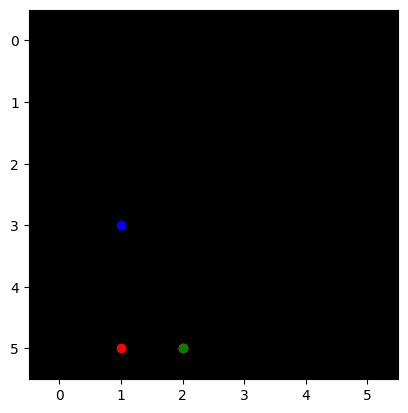

[-0.10886811, -0.10507776, -0.10424659]
 gamma 0.8
[0, 0, -1]
[-0.10886811, -0.10507776, -0.10424659]
return [-0.08406220674514771, -0.0833972692489624, -1.0]
gae [0.024805900454521176, 0.02168048918247223, -0.895753413438797]
0.6901458167727201
tensor([[ 0.,  2., -1.,  1.]])


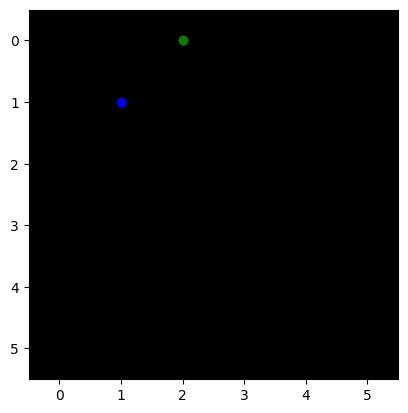

[-0.13740608]
 gamma 0.8
[-1]
[-0.13740608]
return [-1.0]
gae [-0.8625939190387726]
0.9101876354255021
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 2.,  0.,  0., -1.]])


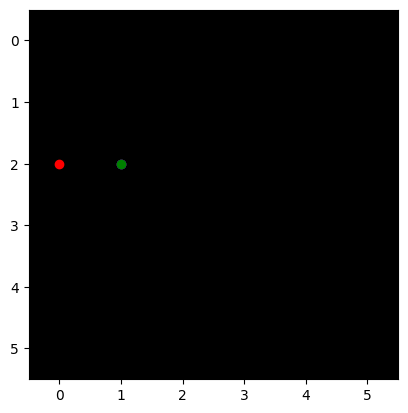

[-0.12531497, -0.14301589]
 gamma 0.8
[0, 1]
[-0.12531497, -0.14301589]
return [-0.11441271305084229, 1.0]
gae [0.01090225279331207, 1.1430158913135529]
0.6004994963528836
tensor([[ 0.,  5., -1.,  4.]])
tensor([[ 0.,  4., -1.,  3.]])
tensor([[ 0.,  4., -1.,  3.]])
tensor([[ 0.,  3., -1.,  2.]])
tensor([[ 0.,  3., -1.,  2.]])
tensor([[ 0.,  4., -1.,  3.]])
tensor([[1., 4., 0., 3.]])
tensor([[1., 3., 0., 2.]])
tensor([[1., 3., 0., 2.]])
tensor([[ 0.,  3., -1.,  2.]])
tensor([[ 0.,  3., -1.,  2.]])


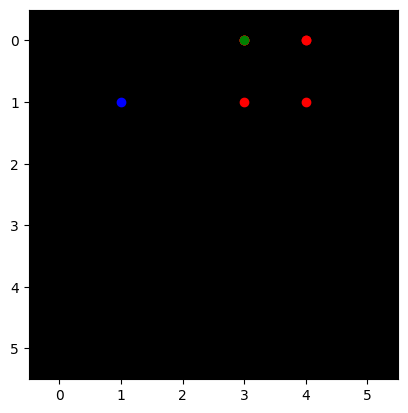

[-0.10915461, -0.11672159, -0.140768, -0.11672159, -0.11182271, -0.13046895, -0.140768]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.10915461, -0.11672159, -0.140768, -0.11672159, -0.11182271, -0.13046895, -0.140768]
return [-0.09337727427482606, -0.1126144051551819, -0.09337727427482606, -0.089458167552948, -0.104375159740448, -0.1126144051551819, -1.0]
gae [0.015777337551116932, 0.004107187688350666, 0.047390732169151295, 0.027263425290584564, 0.007447549700736994, 0.0178545445203781, -0.8592319935560226]
0.05853394648811616
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 3.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  0.,  0., -3.]])
tensor([[ 1.,  0., -1., -3.]])
tensor([[ 1.,  1., -1., -2.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 2.,  2.,  0., -1.]])
tensor([[ 1.,  2., -1., -1.]])
tensor([[ 1.,  3., -1.,  0.]])
tensor([[ 0.,  3., -2.,  0.]])
tensor([[ 0.,  2., -2., -1.]])


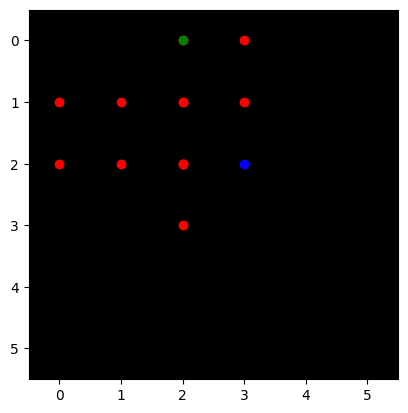

[-0.13997836, -0.123819485, -0.11024042, -0.123819485, -0.15306547, -0.15365809, -0.15333706, -0.15385485, -0.13997836, -0.123819485, -0.13997836, -0.14514124, -0.14069887, -0.15596849]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13997836, -0.123819485, -0.11024042, -0.123819485, -0.15306547, -0.15365809, -0.15333706, -0.15385485, -0.13997836, -0.123819485, -0.13997836, -0.14514124, -0.14069887, -0.15596849]
return [-0.09905558824539185, -0.08819233775138856, -0.09905558824539185, -0.12245237827301025, -0.12292647361755371, -0.12266964912414552, -0.12308387756347657, -0.11198269128799439, -0.09905558824539185, -0.11198269128799439, -0.11611299514770508, -0.11255909204483033, -0.12477478981018067, -1.0]
gae [0.040922775864601135, 0.03562714755535125, 0.011184833943843842, 0.0013671070337295532, 0.030138999223709106, 0.03098844289779662, 0.03025318384170532, 0.041872155666351316, 0.040922775864601135, 0.01183679401874542, 0.0238653689622879, 0.032582151889801014, 0.0159240

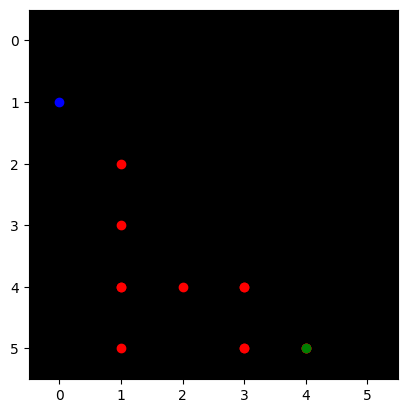

[-0.12428535, -0.12115028, -0.10843486, -0.10541445, -0.10388189, -0.10541445, -0.11129453, -0.111963496, -0.11306695, -0.111963496, -0.11306695, -0.112274945]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12428535, -0.12115028, -0.10843486, -0.10541445, -0.10388189, -0.10541445, -0.11129453, -0.111963496, -0.11306695, -0.111963496, -0.11306695, -0.112274945]
return [-0.09692022204399109, -0.0867478907108307, -0.0843315601348877, -0.08310551047325135, -0.0843315601348877, -0.08903562426567078, -0.08957079648971558, -0.09045355916023255, -0.08957079648971558, -0.09045355916023255, -0.08981995582580567, -1.0]
gae [0.027365125715732574, 0.03440238684415817, 0.024103303253650663, 0.02230893969535827, 0.01955032795667648, 0.016378825902938834, 0.02172373384237289, 0.021509936451911918, 0.023496152460575098, 0.021509936451911918, 0.023246993124485013, -0.8877250552177429]
return [-0.08903562 -0.08819234 -0.08703905 -0.08674789 -0.08433156 -0.08433156
 -0.0840622  -0.08339727 -0.083105

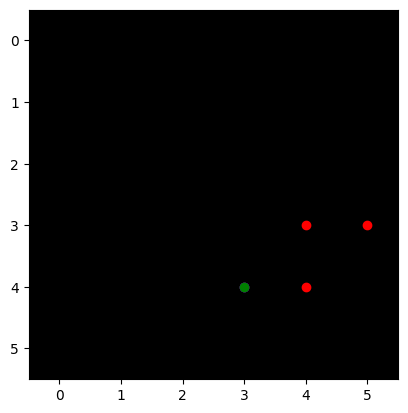

[-0.22911212, -0.2273121, -0.2281109, -0.24394359]
 gamma 0.8
[0, 0, 0, 1]
[-0.22911212, -0.2273121, -0.2281109, -0.24394359]
return [-0.18184968233108523, -0.18248871564865113, -0.19515486955642702, 1.0]
gae [0.047262436151504494, 0.04482338726520538, 0.03295602500438688, 1.2439435869455338]
0.8636000064274806
tensor([[2., 5., 1., 0.]])
tensor([[2., 5., 1., 0.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[2., 5., 1., 0.]])
tensor([[2., 5., 1., 0.]])


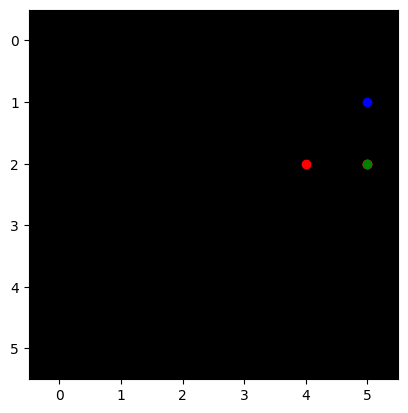

[-0.23264326, -0.25764236, -0.23264326]
 gamma 0.8
[0, 0, -1]
[-0.23264326, -0.25764236, -0.23264326]
return [-0.20611388683319093, -0.1861146092414856, -1.0]
gae [0.026529374718666066, 0.07152774930000305, -0.767356738448143]
0.7638950670467268


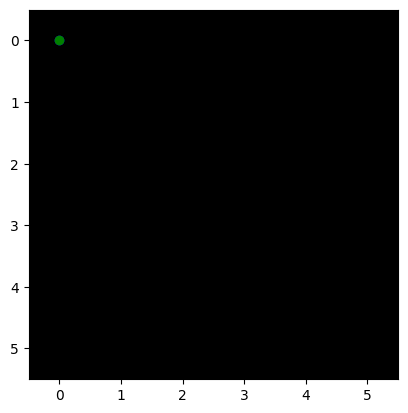

[-0.22911212, -0.2273121, -0.2281109, -0.24394359, -0.23264326, -0.25764236, -0.23264326]
 gamma 0.8
[]
[-0.22911212, -0.2273121, -0.2281109, -0.24394359, -0.23264326, -0.25764236, -0.23264326]
return []
gae []
0.860657958845707
tensor([[5., 3., 4., 2.]])
tensor([[5., 3., 4., 2.]])
tensor([[4., 3., 3., 2.]])
tensor([[3., 3., 2., 2.]])
tensor([[3., 3., 2., 2.]])
tensor([[4., 3., 3., 2.]])
tensor([[4., 3., 3., 2.]])
tensor([[5., 3., 4., 2.]])
tensor([[5., 3., 4., 2.]])


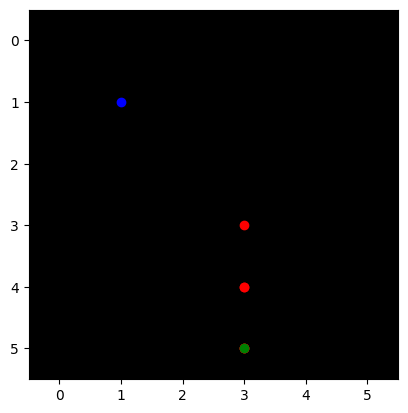

[-0.26125485, -0.25994477, -0.259188, -0.25994477, -0.26125485]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.26125485, -0.25994477, -0.259188, -0.25994477, -0.26125485]
return [-0.20795581340789795, -0.20735039710998537, -0.20795581340789795, -0.20900387763977052, -1.0]
gae [0.05329903364181518, 0.05259436964988706, 0.051232182979583735, 0.05094088912010192, -0.7387451529502869]
0.7854529828480585
tensor([[3., 5., 3., 0.]])
tensor([[ 3.,  4.,  3., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 5.,  4.,  5., -1.]])
tensor([[ 5.,  4.,  5., -1.]])
tensor([[5., 5., 5., 0.]])
tensor([[5., 5., 5., 0.]])
tensor([[ 5.,  4.,  5., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 5.,  2.,  5., -3.]])
tensor([[ 5.,  3.,  5., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  2.,  4., -3.]])
tens

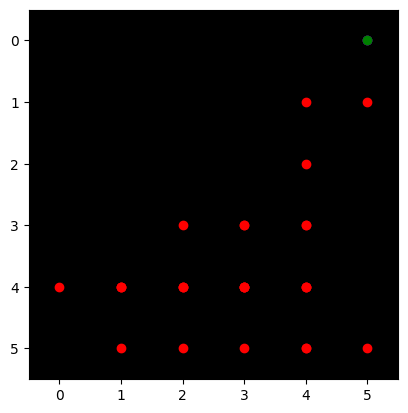

[-0.25963274, -0.26473477, -0.2643955, -0.26399902, -0.26137963, -0.26399902, -0.2643955, -0.25908706, -0.23884417, -0.23261838, -0.25656986, -0.25908706, -0.23884417, -0.2441862, -0.24406926, -0.2441862, -0.24258214, -0.2441862, -0.23884417, -0.25908706, -0.2643955, -0.25908706, -0.26087946, -0.2444457, -0.26087946, -0.26473477, -0.2673379, -0.251865, -0.23047331]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.25963274, -0.26473477, -0.2643955, -0.26399902, -0.26137963, -0.26399902, -0.2643955, -0.25908706, -0.23884417, -0.23261838, -0.25656986, -0.25908706, -0.23884417, -0.2441862, -0.24406926, -0.2441862, -0.24258214, -0.2441862, -0.23884417, -0.25908706, -0.2643955, -0.25908706, -0.26087946, -0.2444457, -0.26087946, -0.26473477, -0.2673379, -0.251865, -0.23047331]
return [-0.21178781986236572, -0.21151640415191653, -0.2111992120742798, -0.20910370349884033, -0.2111992120742798, -0.21151640415191653, -0.20726964473724366, -0.19

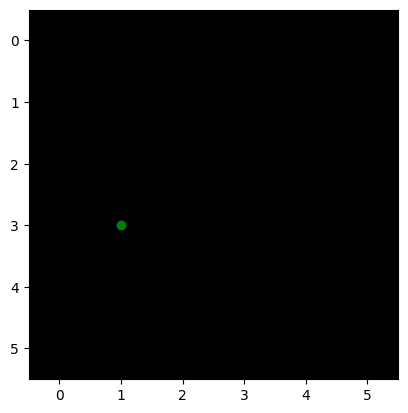

[-0.22911212, -0.2273121, -0.2281109, -0.24394359, -0.23264326, -0.25764236, -0.23264326, -0.26125485, -0.25994477, -0.259188, -0.25994477, -0.26125485, -0.25963274, -0.26473477, -0.2643955, -0.26399902, -0.26137963, -0.26399902, -0.2643955, -0.25908706, -0.23884417, -0.23261838, -0.25656986, -0.25908706, -0.23884417, -0.2441862, -0.24406926, -0.2441862, -0.24258214, -0.2441862, -0.23884417, -0.25908706, -0.2643955, -0.25908706, -0.26087946, -0.2444457, -0.26087946, -0.26473477, -0.2673379, -0.251865, -0.23047331]
 gamma 0.8
[]
[-0.22911212, -0.2273121, -0.2281109, -0.24394359, -0.23264326, -0.25764236, -0.23264326, -0.26125485, -0.25994477, -0.259188, -0.25994477, -0.26125485, -0.25963274, -0.26473477, -0.2643955, -0.26399902, -0.26137963, -0.26399902, -0.2643955, -0.25908706, -0.23884417, -0.23261838, -0.25656986, -0.25908706, -0.23884417, -0.2441862, -0.24406926, -0.2441862, -0.24258214, -0.2441862, -0.23884417, -0.25908706, -0.2643955, -0.25908706, -0.26087946, -0.2444457, -0.26087

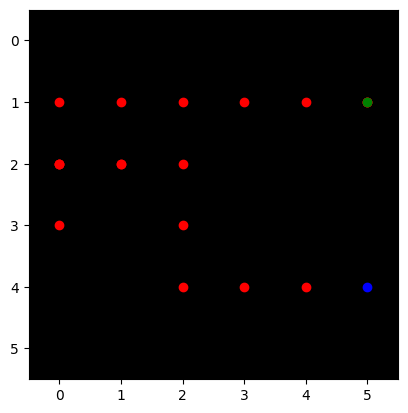

[-0.27111587, -0.25658628, -0.27111587, -0.23953053, -0.23616536, -0.21411845, -0.23376998, -0.23495403, -0.23530482, -0.23495403, -0.22440718, -0.23495403, -0.23376998, -0.20747341, -0.20484266, -0.22796342, -0.24846244, -0.22420242]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.27111587, -0.25658628, -0.27111587, -0.23953053, -0.23616536, -0.21411845, -0.23376998, -0.23495403, -0.23530482, -0.23495403, -0.22440718, -0.23495403, -0.23376998, -0.20747341, -0.20484266, -0.22796342, -0.24846244, -0.22420242]
return [-0.20526902675628664, -0.21689269542694092, -0.19162442684173586, -0.1889322876930237, -0.17129476070404054, -0.18701598644256592, -0.18796322345733643, -0.18824385404586794, -0.18796322345733643, -0.17952574491500856, -0.18796322345733643, -0.18701598644256592, -0.16597872972488403, -0.16387412548065186, -0.18237073421478273, -0.19876995086669924, -0.17936193943023682, -1.0]
gae [0.06584684252738951, 0.03969358801841735, 0.07949144244194029, 0.050598

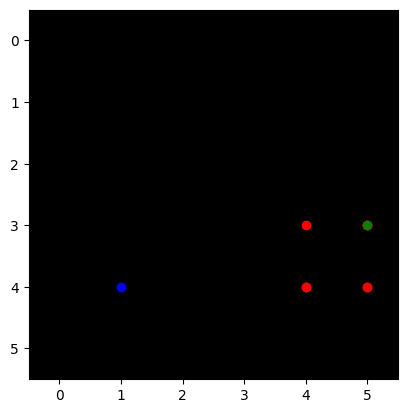

[-0.22255129, -0.22312655, -0.221371, -0.22312655, -0.221371, -0.22229645, -0.22255129]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.22255129, -0.22312655, -0.221371, -0.22312655, -0.221371, -0.22229645, -0.22255129]
return [-0.17850123643875124, -0.1770967960357666, -0.17850123643875124, -0.1770967960357666, -0.1778371572494507, -0.17804102897644045, -1.0]
gae [0.0440500497817993, 0.04602974951267241, 0.042869758605957015, 0.04602974951267241, 0.043533837795257546, 0.04425541758537291, -0.7774487137794495]
0.4778434727698183
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 1.,  2., -1., -2.]])
tensor([[ 0.,  2., -2., -2.]])
tensor([[ 0.,  2., -2., -2.]])
tensor([[ 0.,  3., -2., -1.]])
tensor([[ 1.,  3., -1., -1.]])
tensor([[ 0.,  3., -2., -1.]])
tensor([[ 0.,  2., -2., -2.]])


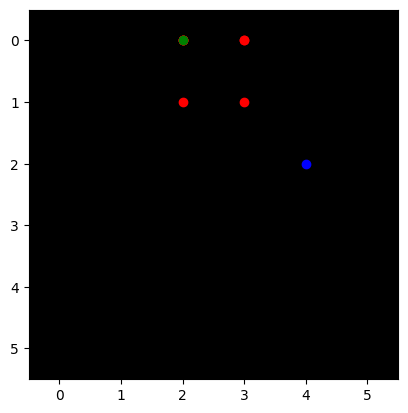

[-0.26593113, -0.23147921, -0.23547825, -0.2695715, -0.26593113, -0.2695715, -0.23547825]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.26593113, -0.23147921, -0.23547825, -0.2695715, -0.26593113, -0.2695715, -0.23547825]
return [-0.18518337011337282, -0.18838260173797608, -0.21565721035003663, -0.21274490356445314, -0.21565721035003663, -0.18838260173797608, -1.0]
gae [0.08074775934219358, 0.043096610903739924, 0.019821041822433466, 0.05682660937309264, 0.05027391910552978, 0.0811889111995697, -0.7645217478275299]
0.8832988353549894
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 2.,  1., -1., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  1.,  0., -4.]])
tensor([[ 3.,  2.,  0., -3.]])
tensor([[ 3.,  2.,  0., -3.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  2., -1., -3.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
ten

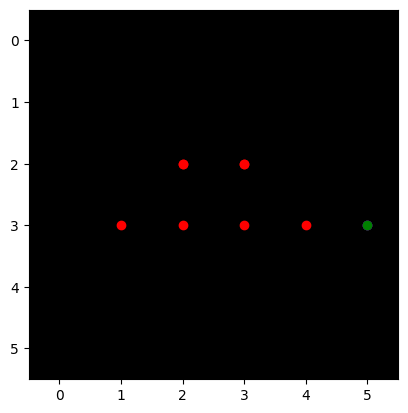

[-0.2172862, -0.21659115, -0.21798468, -0.22557276, -0.2638306, -0.22557276, -0.2638306, -0.25252968, -0.22540918]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.2172862, -0.21659115, -0.21798468, -0.22557276, -0.2638306, -0.22557276, -0.2638306, -0.25252968, -0.22540918]
return [-0.1732729196548462, -0.1743877410888672, -0.18045821189880373, -0.21106448173522951, -0.18045821189880373, -0.21106448173522951, -0.20202374458312988, -0.18032734394073488, 1.0]
gae [0.04401327967643737, 0.042203408479690535, 0.03752646446228025, 0.014508283138275124, 0.08337239027023313, 0.014508283138275124, 0.06180685758590698, 0.07220233678817747, 1.2254091799259186]
0.3638309775471794
tensor([[ 1.,  5., -1.,  3.]])
tensor([[2., 5., 0., 3.]])
tensor([[ 1.,  5., -1.,  3.]])
tensor([[ 1.,  5., -1.,  3.]])
tensor([[ 0.,  5., -2.,  3.]])
tensor([[ 0.,  4., -2.,  2.]])


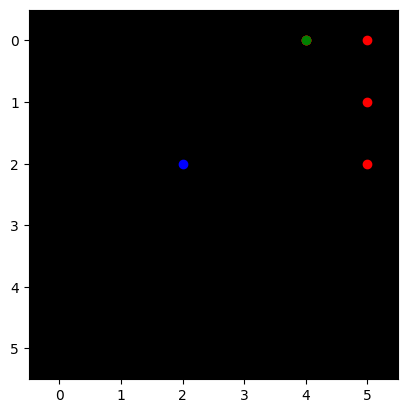

[-0.2255295, -0.22182386, -0.2255295, -0.23097478, -0.24381381]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.2255295, -0.22182386, -0.2255295, -0.23097478, -0.24381381]
return [-0.1774590849876404, -0.18042360544204714, -0.1847798228263855, -0.19505105018615723, -1.0]
gae [0.048070421814918496, 0.04140025079250334, 0.0407496839761734, 0.03592372834682464, -0.7561861872673035]
0.26798333813127184
tensor([[ 5.,  2.,  5., -2.]])
tensor([[ 5.,  3.,  5., -1.]])


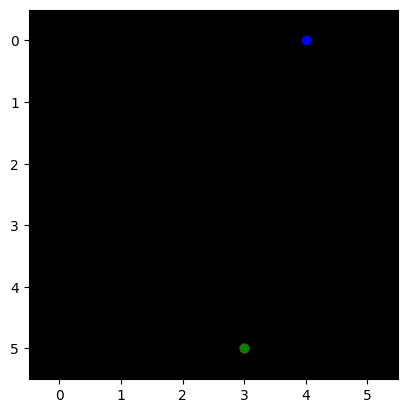

[-0.200577, -0.20628941]
 gamma 0.8
[0, -1]
[-0.200577, -0.20628941]
return [-0.1650315284729004, -1.0]
gae [0.03554547727108001, -0.7937105894088745]
0.4864293367577225
tensor([[3., 5., 3., 2.]])
tensor([[3., 5., 3., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[2., 5., 2., 2.]])
tensor([[1., 5., 1., 2.]])
tensor([[1., 4., 1., 1.]])
tensor([[0., 4., 0., 1.]])
tensor([[0., 4., 0., 1.]])


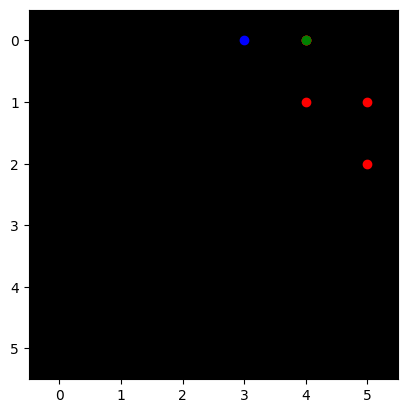

[-0.2185457, -0.22109789, -0.22274627, -0.23379183, -0.25795037]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.2185457, -0.22109789, -0.22274627, -0.23379183, -0.25795037]
return [-0.17687830924987794, -0.17819701433181764, -0.18703346252441408, -0.2063602924346924, -1.0]
gae [0.04166739583015441, 0.04290087223052977, 0.035712805390357955, 0.027431535720825184, -0.7420496344566345]
0.29359926570023487
tensor([[5., 4., 2., 1.]])


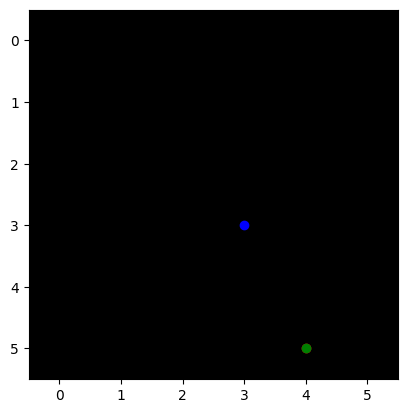

[-0.2086799]
 gamma 0.8
[-1]
[-0.2086799]
return [-1.0]
gae [-0.7913201004266739]
0.5819026975770061
tensor([[ 0.,  1., -5., -3.]])
tensor([[ 0.,  1., -5., -3.]])
tensor([[ 0.,  2., -5., -2.]])
tensor([[ 0.,  2., -5., -2.]])
tensor([[ 0.,  3., -5., -1.]])


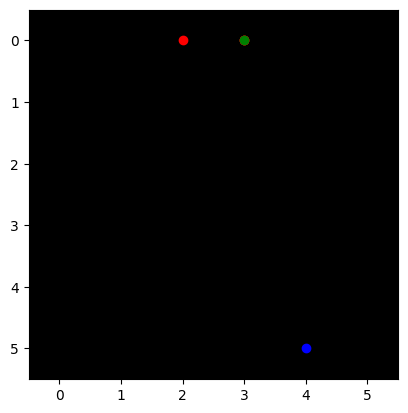

[-0.23453541, -0.23666267, -0.26476917]
 gamma 0.8
[0, 0, -1]
[-0.23453541, -0.23666267, -0.26476917]
return [-0.18933013677597046, -0.21181533336639405, -1.0]
gae [0.045205274224281305, 0.024847337603569025, -0.7352308332920074]
0.251068564334609
tensor([[ 1.,  2.,  0., -1.]])
tensor([[ 2.,  2.,  1., -1.]])
tensor([[2., 3., 1., 0.]])
tensor([[ 2.,  2.,  1., -1.]])
tensor([[ 2.,  2.,  1., -1.]])
tensor([[2., 3., 1., 0.]])
tensor([[2., 4., 1., 1.]])
tensor([[1., 4., 0., 1.]])
tensor([[1., 4., 0., 1.]])
tensor([[1., 5., 0., 2.]])
tensor([[1., 4., 0., 1.]])
tensor([[1., 5., 0., 2.]])
tensor([[2., 5., 1., 2.]])
tensor([[2., 5., 1., 2.]])


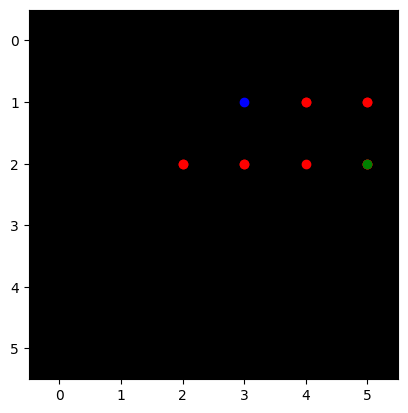

[-0.23154595, -0.22666392, -0.25015104, -0.22666392, -0.25015104, -0.22204861, -0.23734663, -0.22550106, -0.23734663, -0.22550106, -0.22160158]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.23154595, -0.22666392, -0.25015104, -0.22666392, -0.25015104, -0.22204861, -0.23734663, -0.22550106, -0.23734663, -0.22550106, -0.22160158]
return [-0.18133113384246827, -0.2001208305358887, -0.18133113384246827, -0.2001208305358887, -0.17763888835906982, -0.18987730741500855, -0.18040084838867188, -0.18987730741500855, -0.18040084838867188, -0.17728126049041748, -1.0]
gae [0.05021482110023498, 0.026543086767196633, 0.06881990432739257, 0.026543086767196633, 0.07251214981079102, 0.03217130303382873, 0.056945785880088806, 0.03562375307083129, 0.056945785880088806, 0.04821979999542236, -0.7783984243869781]
return [-0.17763889 -0.17745909 -0.17728126 -0.1770968  -0.1770968  -0.1768783
 -0.17438774 -0.17327292 -0.16503152  1.        ]
return [-1.        -1.        -1.        -1.        -1.        -1

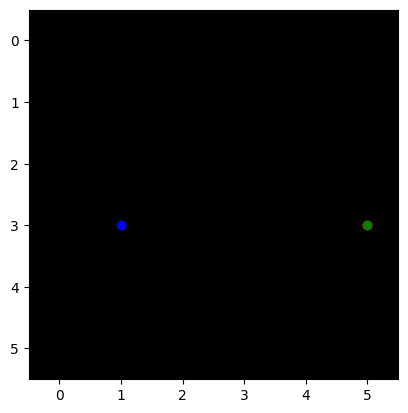

[-0.3628216, -0.36334327]
 gamma 0.8
[0, -1]
[-0.3628216, -0.36334327]
return [-0.290674614906311, -1.0]
gae [0.07214699387550355, -0.6366567313671112]
0.06759636132532199


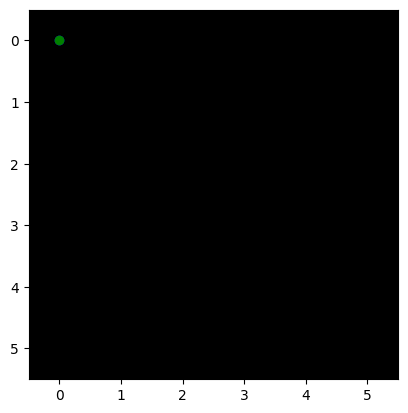

[-0.3628216, -0.36334327]
 gamma 0.8
[]
[-0.3628216, -0.36334327]
return []
gae []
0.38901854950509707
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  1., -5.,  1.]])
tensor([[ 0.,  0., -5.,  0.]])


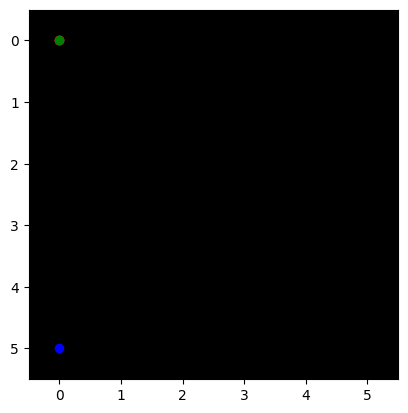

[-0.35690793, -0.3642298]
 gamma 0.8
[0, -1]
[-0.35690793, -0.3642298]
return [-0.2913838386535645, -1.0]
gae [0.06552409529685971, -0.6357702016830444]
0.4883216196770649
tensor([[ 3.,  0.,  0., -2.]])
tensor([[ 3.,  0.,  0., -2.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 5.,  0.,  2., -2.]])
tensor([[ 5.,  0.,  2., -2.]])


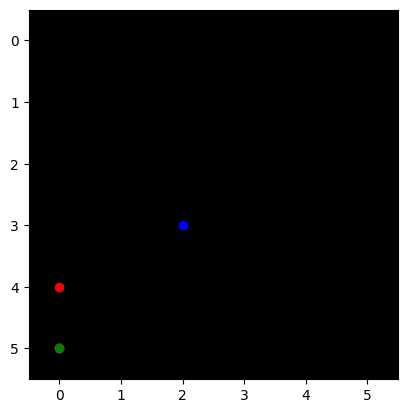

[-0.3675024, -0.36678922, -0.37156802]
 gamma 0.8
[0, 0, -1]
[-0.3675024, -0.36678922, -0.37156802]
return [-0.2934313774108887, -0.29725441932678226, -1.0]
gae [0.07407101392745968, 0.06953480243682858, -0.6284319758415222]
0.6366002117565015
tensor([[2., 5., 1., 3.]])


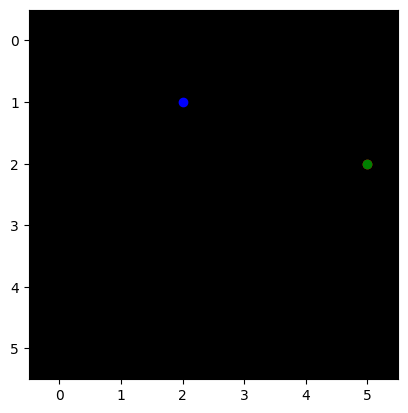

[-0.3628503]
 gamma 0.8
[-1]
[-0.3628503]
return [-1.0]
gae [-0.6371496915817261]
0.3282265860749588
tensor([[2., 2., 2., 2.]])
tensor([[2., 1., 2., 1.]])
tensor([[1., 1., 1., 1.]])
tensor([[1., 2., 1., 2.]])
tensor([[2., 2., 2., 2.]])
tensor([[1., 2., 1., 2.]])
tensor([[0., 2., 0., 2.]])
tensor([[1., 2., 1., 2.]])
tensor([[1., 2., 1., 2.]])
tensor([[2., 2., 2., 2.]])
tensor([[2., 1., 2., 1.]])
tensor([[3., 1., 3., 1.]])
tensor([[3., 2., 3., 2.]])
tensor([[3., 2., 3., 2.]])
tensor([[3., 1., 3., 1.]])
tensor([[4., 1., 4., 1.]])
tensor([[4., 2., 4., 2.]])
tensor([[4., 2., 4., 2.]])
tensor([[3., 2., 3., 2.]])
tensor([[3., 2., 3., 2.]])
tensor([[2., 2., 2., 2.]])
tensor([[2., 3., 2., 3.]])
tensor([[1., 3., 1., 3.]])
tensor([[1., 3., 1., 3.]])
tensor([[2., 3., 2., 3.]])
tensor([[2., 4., 2., 4.]])
tensor([[2., 5., 2., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 4., 3., 4.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 5., 3., 5.]])
tensor([[3., 4., 3., 4.]])
tensor([

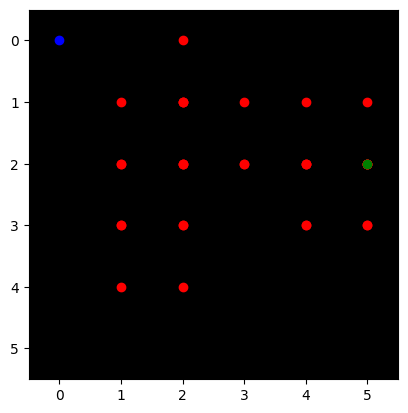

[-0.38028365, -0.35680875, -0.35990626, -0.38205937, -0.38028365, -0.38205937, -0.37652004, -0.38205937, -0.38028365, -0.35680875, -0.3546218, -0.376512, -0.3546218, -0.35512134, -0.37891185, -0.376512, -0.38028365, -0.37011215, -0.36441246, -0.37011215, -0.36851364, -0.36473554, -0.37236655, -0.374801, -0.37236655, -0.374801, -0.36851364, -0.3630118, -0.36851364, -0.36473554, -0.3635993, -0.36473554]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.38028365, -0.35680875, -0.35990626, -0.38205937, -0.38028365, -0.38205937, -0.37652004, -0.38205937, -0.38028365, -0.35680875, -0.3546218, -0.376512, -0.3546218, -0.35512134, -0.37891185, -0.376512, -0.38028365, -0.37011215, -0.36441246, -0.37011215, -0.36851364, -0.36473554, -0.37236655, -0.374801, -0.37236655, -0.374801, -0.36851364, -0.3630118, -0.36851364, -0.36473554, -0.3635993, -0.36473554]
return [-0.28544700145721436, -0.28792500495910645, -0.30564749240875244, -0.3042

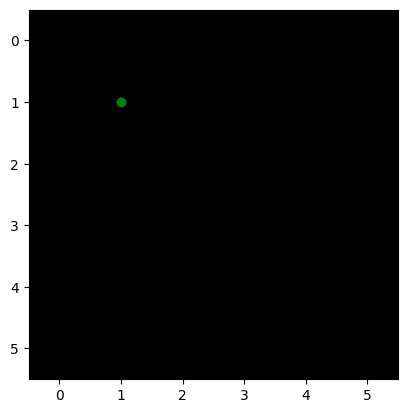

[-0.34902894]
 gamma 0.8
[1]
[-0.34902894]
return [1.0]
gae [1.3490289449691772]
0.7527233746896663
tensor([[4., 2., 1., 0.]])
tensor([[4., 2., 1., 0.]])


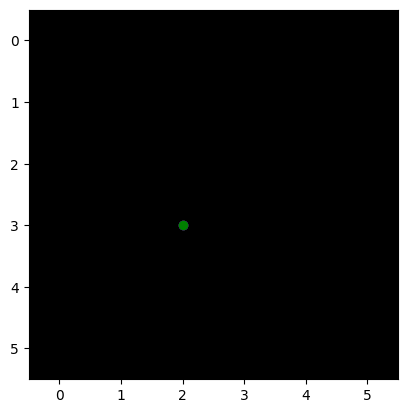

[-0.35562274]
 gamma 0.8
[1]
[-0.35562274]
return [1.0]
gae [1.3556227385997772]
0.2812345304590612
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 2.,  0.,  0., -3.]])
tensor([[ 2.,  1.,  0., -2.]])
tensor([[ 3.,  1.,  1., -2.]])
tensor([[ 4.,  1.,  2., -2.]])
tensor([[ 4.,  1.,  2., -2.]])
tensor([[ 4.,  0.,  2., -3.]])


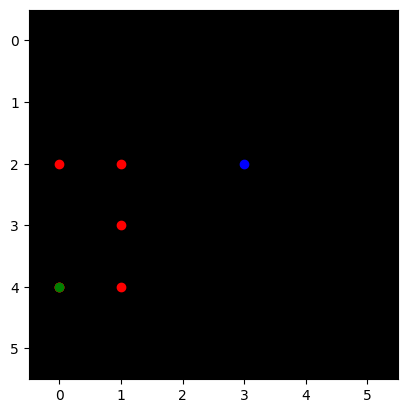

[-0.36175892, -0.364054, -0.36175892, -0.36200145, -0.35738903, -0.3642717]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.36175892, -0.364054, -0.36175892, -0.36200145, -0.35738903, -0.3642717]
return [-0.29124319553375244, -0.2894071340560913, -0.28960115909576417, -0.28591122627258303, -0.29141736030578613, -1.0]
gae [0.0705157220363617, 0.07464686036109924, 0.07215775847434996, 0.07609022259712217, 0.06597167253494263, -0.6357282996177673]
0.8981559593121705
tensor([[ 5.,  0.,  1., -5.]])
tensor([[ 5.,  0.,  1., -5.]])
tensor([[ 5.,  1.,  1., -4.]])
tensor([[ 5.,  1.,  1., -4.]])
tensor([[ 5.,  2.,  1., -3.]])
tensor([[ 5.,  2.,  1., -3.]])


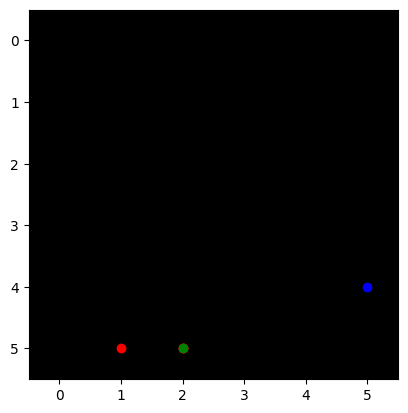

[-0.37177357, -0.36157042, -0.35727647]
 gamma 0.8
[0, 0, -1]
[-0.37177357, -0.36157042, -0.35727647]
return [-0.28925633430480957, -0.2858211755752564, -1.0]
gae [0.08251723647117615, 0.07574924230575558, -0.6427235305309296]
return [-0.287925   -0.28591123 -0.28582117 -0.285447   -0.285447   -0.28409708
 -0.28369743 -0.28369743  1.          1.        ]
return [-1.        -1.        -1.        -1.        -1.        -1.
 -1.        -0.3056475 -0.3056475 -0.3056475]

-------------------- Iteration #73 --------------------
random  0.8981559593121705
Average : 0.01
Average Episodic Return: -0.64
Max Episodic Return: 1.0
Average Loss: -0.00012
Average Loss Critic: 0.23278827965259552
TEntropy: nan
approx_kl_divs: [0.00016230781] secs
------------------------------------------------------

0.6032700892393158
tensor([[ 1.,  1., -3., -2.]])
tensor([[ 1.,  0., -3., -3.]])
tensor([[ 1.,  0., -3., -3.]])


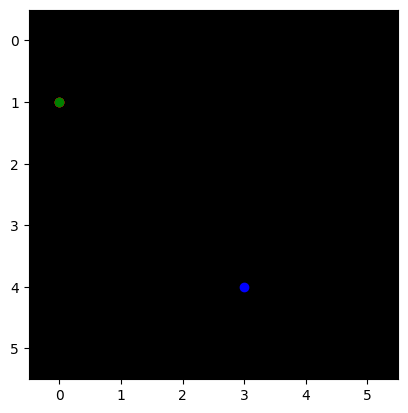

[-0.27774343, -0.28436032]
 gamma 0.8
[0, -1]
[-0.27774343, -0.28436032]
return [-0.22748825550079346, -1.0]
gae [0.05025517344474792, -0.7156396806240082]
0.03710506437237959
tensor([[ 0.,  1.,  0., -3.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  1.,  0., -3.]])
tensor([[ 0.,  0.,  0., -4.]])


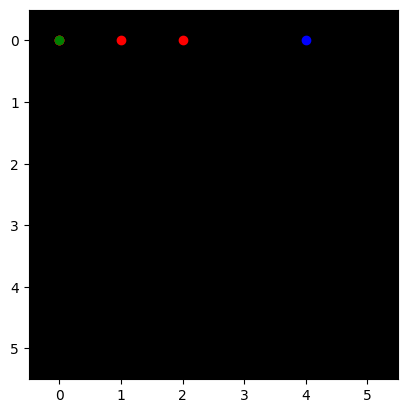

[-0.29255107, -0.27171716, -0.29255107, -0.31213027]
 gamma 0.8
[0, 0, 0, -1]
[-0.29255107, -0.27171716, -0.29255107, -0.31213027]
return [-0.21737372875213623, -0.23404085636138916, -0.2497042179107666, -1.0]
gae [0.07517734169960022, 0.03767630457878113, 0.04284685254096984, -0.6878697276115417]
0.2322804398410656
tensor([[3., 3., 0., 3.]])
tensor([[ 2.,  3., -1.,  3.]])
tensor([[ 2.,  2., -1.,  2.]])
tensor([[ 2.,  1., -1.,  1.]])
tensor([[3., 1., 0., 1.]])
tensor([[4., 1., 1., 1.]])
tensor([[3., 1., 0., 1.]])
tensor([[3., 1., 0., 1.]])
tensor([[4., 1., 1., 1.]])
tensor([[4., 2., 1., 2.]])
tensor([[5., 2., 2., 2.]])
tensor([[5., 3., 2., 3.]])
tensor([[4., 3., 1., 3.]])
tensor([[3., 3., 0., 3.]])
tensor([[3., 2., 0., 2.]])
tensor([[ 2.,  2., -1.,  2.]])
tensor([[ 2.,  3., -1.,  3.]])
tensor([[ 1.,  3., -2.,  3.]])
tensor([[ 2.,  3., -1.,  3.]])
tensor([[ 2.,  3., -1.,  3.]])
tensor([[ 2.,  4., -1.,  4.]])
tensor([[ 2.,  5., -1.,  5.]])
tensor([[ 2.,  5., -1.,  5.]])


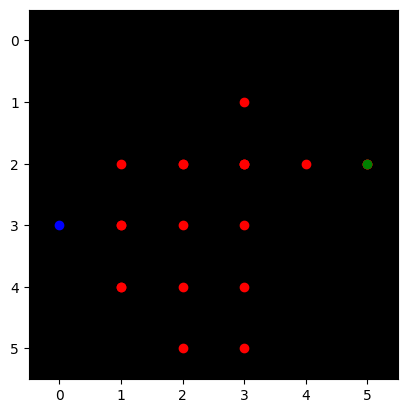

[-0.1720163, -0.17662443, -0.20164333, -0.26074168, -0.27738976, -0.28673357, -0.27738976, -0.28673357, -0.21718617, -0.2301518, -0.22219446, -0.19882691, -0.1720163, -0.20414571, -0.20164333, -0.17662443, -0.18447477, -0.17662443, -0.1702382, -0.17023371]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.1720163, -0.17662443, -0.20164333, -0.26074168, -0.27738976, -0.28673357, -0.27738976, -0.28673357, -0.21718617, -0.2301518, -0.22219446, -0.19882691, -0.1720163, -0.20414571, -0.20164333, -0.17662443, -0.18447477, -0.17662443, -0.1702382, -0.17023371]
return [-0.1412995457649231, -0.16131466627120972, -0.20859334468841553, -0.2219118118286133, -0.22938685417175295, -0.2219118118286133, -0.22938685417175295, -0.17374893426895144, -0.1841214418411255, -0.17775557041168213, -0.15906152725219727, -0.13761303424835206, -0.16331657171249392, -0.16131466627120972, -0.1412995457649231, -0.14757981300354003, -0.1412995457649231, -0.1361905574798584, -0.1361869692802

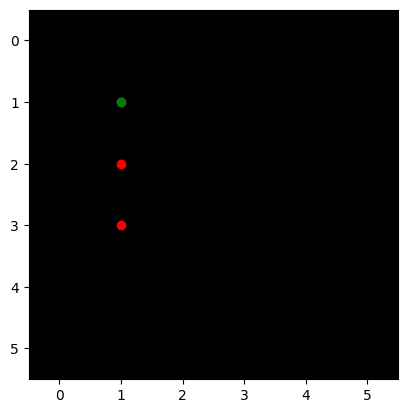

[-0.24415119, -0.2958623, -0.30539107]
 gamma 0.8
[0, 0, 1]
[-0.24415119, -0.2958623, -0.30539107]
return [-0.236689829826355, -0.24431285858154297, 1.0]
gae [0.007461360096931435, 0.05154942870140075, 1.3053910732269287]
0.5880174849975482
tensor([[5., 5., 5., 1.]])
tensor([[5., 4., 5., 0.]])
tensor([[5., 4., 5., 0.]])


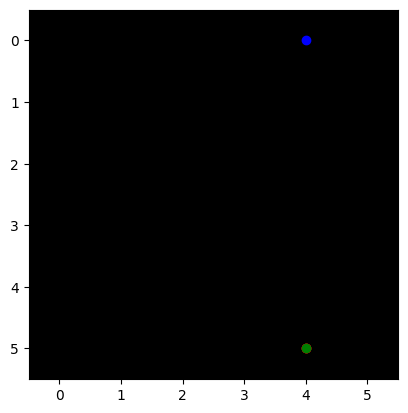

[-0.21923845, -0.22168878]
 gamma 0.8
[0, -1]
[-0.21923845, -0.22168878]
return [-0.17735102176666262, -1.0]
gae [0.04188742339611051, -0.7783112227916718]
0.5019983486796717
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 3.,  0., -1., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  0.,  0., -5.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 3.,  1., -1., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  1.,  0., -4.]])
tensor([[ 4.,  0.,  0., -5.]])


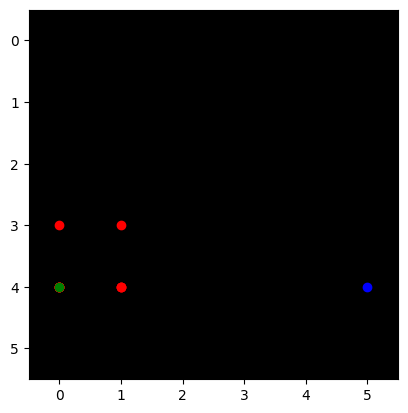

[-0.3199645, -0.3236275, -0.3199645, -0.3236275, -0.32163808, -0.3236275, -0.3199645, -0.31848228, -0.3199645, -0.3236275]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.3199645, -0.3236275, -0.3199645, -0.3236275, -0.32163808, -0.3236275, -0.3199645, -0.31848228, -0.3199645, -0.3236275]
return [-0.2589020013809204, -0.2559715986251831, -0.2589020013809204, -0.25731046199798585, -0.2589020013809204, -0.2559715986251831, -0.2547858238220215, -0.2559715986251831, -0.2589020013809204, -1.0]
gae [0.06106249690055848, 0.06765590310096742, 0.06106249690055848, 0.06631703972816466, 0.0627360761165619, 0.06765590310096742, 0.06517867445945741, 0.06251068115234376, 0.06106249690055848, -0.6763724982738495]
0.8735232210524244
tensor([[ 2.,  5., -1.,  1.]])
tensor([[ 2.,  5., -1.,  1.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 2.,  4., -1.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 0.,  5., -3.,  1.]])
tensor([[ 0.,  5., -3.,  1

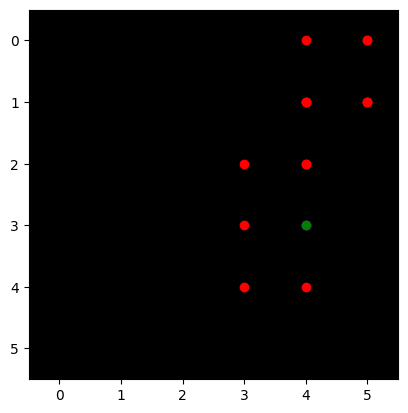

[-0.17214215, -0.20037864, -0.21103153, -0.18532477, -0.20274904, -0.18532477, -0.21103153, -0.21306954, -0.20274904, -0.18532477, -0.21103153, -0.20037864, -0.22938819, -0.26117462, -0.249236, -0.21605887]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.17214215, -0.20037864, -0.21103153, -0.18532477, -0.20274904, -0.18532477, -0.21103153, -0.21306954, -0.20274904, -0.18532477, -0.21103153, -0.20037864, -0.22938819, -0.26117462, -0.249236, -0.21605887]
return [-0.16030291318893433, -0.16882522106170655, -0.14825981855392456, -0.16219923496246338, -0.14825981855392456, -0.16882522106170655, -0.17045563459396362, -0.16219923496246338, -0.14825981855392456, -0.16882522106170655, -0.16030291318893433, -0.18351055383682252, -0.2089396953582764, -0.1993888020515442, -0.17284709215164185, 1.0]
gae [0.011839234828948969, 0.031553420424461354, 0.06277170777320862, 0.023125538229942316, 0.05448922514915466, 0.016499552130699147, 0.040575891733169556, 0.050870308279991144, 0.0544

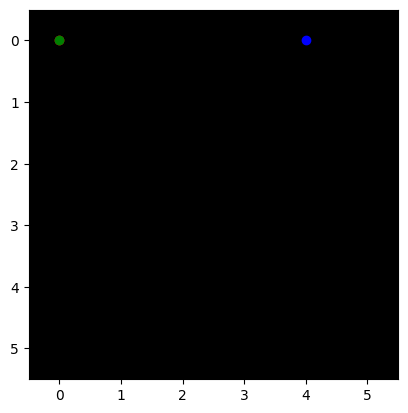

[-0.35280982]
 gamma 0.8
[-1]
[-0.35280982]
return [-1.0]
gae [-0.6471901834011078]
0.40770999289811194
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  2., -5., -3.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  2., -4., -3.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 0.,  1., -5., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 2.,  1., -3., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  1., -4., -4.]])
tensor([[ 1.,  0., -4., -5.]])
tensor([[ 2.,  0., -3., -5.]])


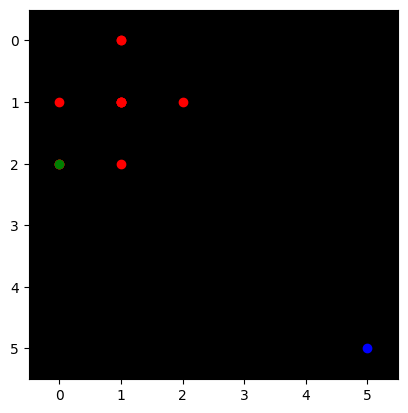

[-0.35471302, -0.3562152, -0.3494958, -0.3511925, -0.3494958, -0.3562152, -0.3494958, -0.34113201, -0.3494958, -0.34643355, -0.34167764]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.35471302, -0.3562152, -0.3494958, -0.3511925, -0.3494958, -0.3562152, -0.3494958, -0.34113201, -0.3494958, -0.34643355, -0.34167764]
return [-0.2849721670150757, -0.2795966386795044, -0.2809540033340454, -0.2795966386795044, -0.2849721670150757, -0.2795966386795044, -0.27290561199188235, -0.2795966386795044, -0.27714684009552004, -0.2733421087265015, -1.0]
gae [0.0697408556938171, 0.0766185700893402, 0.06854179501533508, 0.07159586548805236, 0.06452363133430478, 0.0766185700893402, 0.07659018635749815, 0.0615353763103485, 0.07234895825386045, 0.07309144139289853, -0.6583223640918732]
0.30232371848301454
tensor([[ 3.,  3., -1.,  3.]])
tensor([[4., 3., 0., 3.]])
tensor([[5., 3., 1., 3.]])


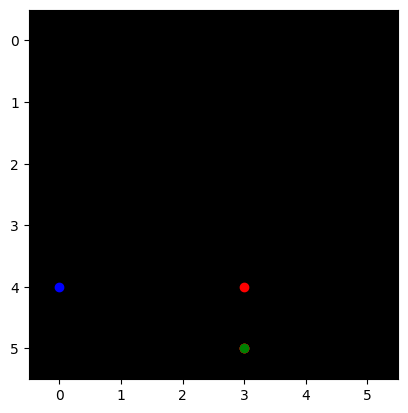

[-0.38902286, -0.39201516, -0.39347258]
 gamma 0.8
[0, 0, -1]
[-0.38902286, -0.39201516, -0.39347258]
return [-0.31361212730407717, -0.31477806568145755, -1.0]
gae [0.07541072964668272, 0.07723709344863888, -0.6065274178981781]
0.7704665404813487
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  5., -1.,  3.]])
tensor([[ 4.,  5., -1.,  3.]])
tensor([[5., 5., 0., 3.]])
tensor([[5., 5., 0., 3.]])
tensor([[5., 4., 0., 2.]])
tensor([[5., 4., 0., 2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[5., 4., 0., 2.]])
tensor([[5., 4., 0., 2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  3., -1.,  1.]])
tensor([[ 4.,  2., -1.,  0.]])
tensor([[ 4.,  2., -1.,  0.]])


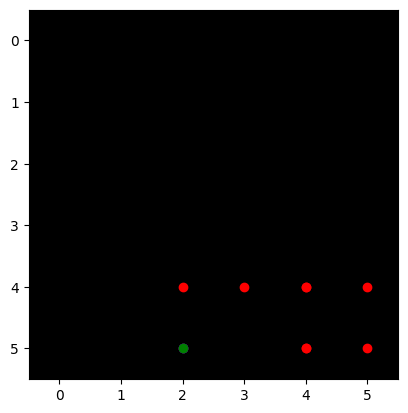

[-0.38914543, -0.39032796, -0.39606926, -0.39244717, -0.38914543, -0.39244717, -0.38914543, -0.389061, -0.38301468]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.38914543, -0.39032796, -0.39606926, -0.39244717, -0.38914543, -0.39244717, -0.38914543, -0.389061, -0.38301468]
return [-0.3122623682022095, -0.31685540676116947, -0.3139577388763428, -0.3113163471221924, -0.3139577388763428, -0.3113163471221924, -0.31124880313873293, -0.3064117431640625, 1.0]
gae [0.076883065700531, 0.07347255349159237, 0.08211151957511897, 0.08113082647323605, 0.07518769502639766, 0.08113082647323605, 0.07789663076400755, 0.08264926075935364, 1.3830146789550781]
0.4892145647061793
tensor([[ 4.,  0., -1., -3.]])
tensor([[ 4.,  0., -1., -3.]])
tensor([[ 4.,  1., -1., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 4.,  1., -1., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 4.,  1., -1., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 3.,  1., -2., -2.]])
tensor([[ 3.,  0., -2., -3

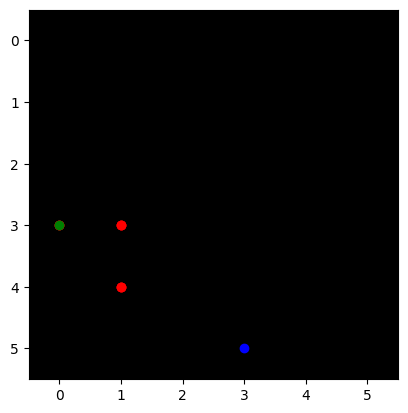

[-0.35419595, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.3482838]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.35419595, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.3482838]
return [-0.28211510181427, -0.27659690380096436, -0.28211510181427, -0.27659690380096436, -0.28211510181427, -0.27659690380096436, -0.27862703800201416, -1.0]
gae [0.07208085060119629, 0.07604697346687317, 0.06363102793693542, 0.07604697346687317, 0.06363102793693542, 0.07604697346687317, 0.06711909174919128, -0.6517162024974823]
0.6697582904487516


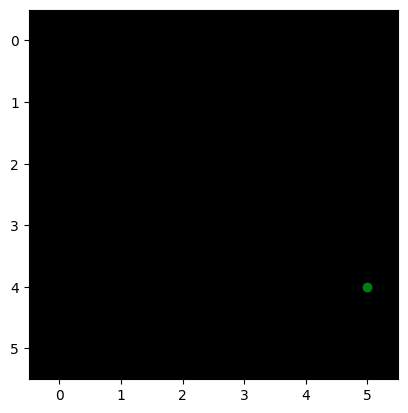

[-0.35280982, -0.35471302, -0.3562152, -0.3494958, -0.3511925, -0.3494958, -0.3562152, -0.3494958, -0.34113201, -0.3494958, -0.34643355, -0.34167764, -0.38902286, -0.39201516, -0.39347258, -0.38914543, -0.39032796, -0.39606926, -0.39244717, -0.38914543, -0.39244717, -0.38914543, -0.389061, -0.38301468, -0.35419595, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.3482838]
 gamma 0.8
[]
[-0.35280982, -0.35471302, -0.3562152, -0.3494958, -0.3511925, -0.3494958, -0.3562152, -0.3494958, -0.34113201, -0.3494958, -0.34643355, -0.34167764, -0.38902286, -0.39201516, -0.39347258, -0.38914543, -0.39032796, -0.39606926, -0.39244717, -0.38914543, -0.39244717, -0.38914543, -0.389061, -0.38301468, -0.35419595, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.35264388, -0.34574613, -0.3482838]
return []
gae []
0.3760900458705765
tensor([[ 1.,  1., -3.,  1.]])
tensor([[ 1.,  1., -3.,  1.]])
tensor([[ 1.,  0., -3.,  0.]])
tensor([[ 1.,  0., -3.,  0.]])
tensor([[ 1.

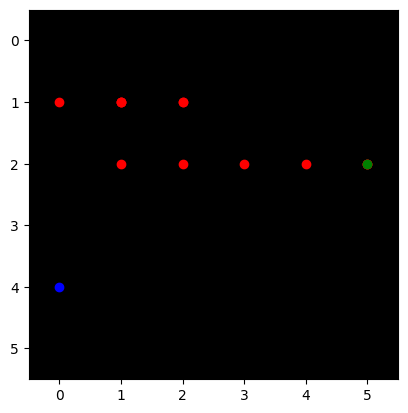

[-0.35829276, -0.35275587, -0.35829276, -0.3645046, -0.35829276, -0.34704265, -0.35829276, -0.3645046, -0.3816355, -0.39089227, -0.3894204, -0.39006734]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.35829276, -0.35275587, -0.35829276, -0.3645046, -0.35829276, -0.34704265, -0.35829276, -0.3645046, -0.3816355, -0.39089227, -0.3894204, -0.39006734]
return [-0.2822046995162964, -0.2866342067718506, -0.291603684425354, -0.2866342067718506, -0.2776341199874878, -0.2866342067718506, -0.291603684425354, -0.30530838966369633, -0.3127138137817383, -0.3115363121032715, -0.31205387115478517, -1.0]
gae [0.07608805894851683, 0.0661216676235199, 0.06668907403945923, 0.07787039875984192, 0.0806586384773254, 0.060408443212509155, 0.06668907403945923, 0.05919621586799617, 0.06892167329788207, 0.07935595512390137, 0.07736651897430419, -0.6099326610565186]
0.10168451357197883
tensor([[5., 4., 4., 4.]])
tensor([[5., 3., 4., 3.]])
tensor([[4., 3., 3., 3.]])
tensor([[5., 3., 4., 3.]])


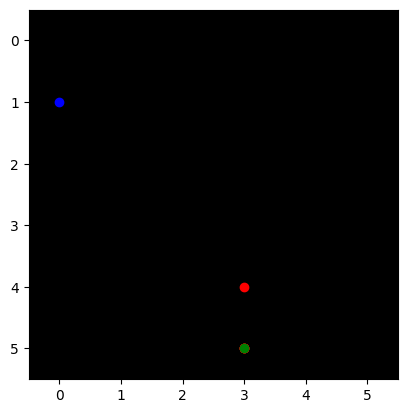

[-0.39261165, -0.3917314, -0.3917451, -0.3917314]
 gamma 0.8
[0, 0, 0, -1]
[-0.39261165, -0.3917314, -0.3917451, -0.3917314]
return [-0.31338512897491455, -0.31339607238769535, -0.31338512897491455, -1.0]
gae [0.0792265236377716, 0.07833533883094784, 0.07835996150970459, -0.6082685887813568]
0.7670897288048838
tensor([[ 0.,  2., -3., -2.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 0.,  3., -3., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  3., -2., -1.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  4., -2.,  0.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 1.,  5., -2.,  1.]])
tensor([[ 2.,  5., -1.,  1.]])
tensor([[ 2.,  5., -1.,  1.]])
tensor([[3., 5., 0., 1.]])
tensor([[3., 5., 0., 1.]])


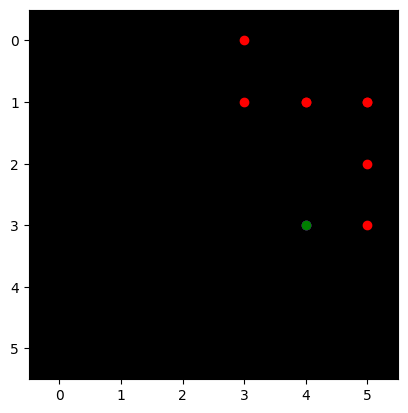

[-0.3495492, -0.35652962, -0.3593422, -0.38277605, -0.39196244, -0.38277605, -0.39196244, -0.38846803, -0.38903385]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.3495492, -0.35652962, -0.3593422, -0.38277605, -0.39196244, -0.38277605, -0.39196244, -0.38846803, -0.38903385]
return [-0.28522369861602787, -0.28747375011444093, -0.3062208414077759, -0.3135699510574341, -0.3062208414077759, -0.3135699510574341, -0.31077442169189456, -0.31122708320617676, 1.0]
gae [0.06432550549507138, 0.06905587315559386, 0.05312134623527526, 0.06920610070228572, 0.08574159741401671, 0.06920610070228572, 0.08118801712989804, 0.0772409439086914, 1.389033854007721]
return [-0.27862704 -0.2776341  -0.27714685 -0.2765969  -0.2765969  -0.2765969
 -0.2733421  -0.27290562  1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -0.3168554  -0.31477806 -0.31395775 -0.31395775]

-------------------- Iteration #75 --------------------
random  0.7670897288048838
Average : 0.01
Ave

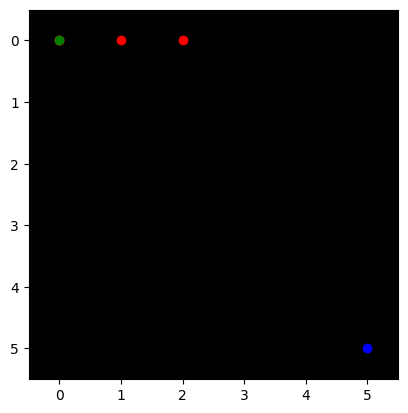

[-0.3156429, -0.3323488, -0.33125842, -0.3247211]
 gamma 0.8
[0, 0, 0, -1]
[-0.3156429, -0.3323488, -0.33125842, -0.3247211]
return [-0.2658790349960327, -0.26500673294067384, -0.2597768783569336, -1.0]
gae [0.04976385831832886, 0.06734206080436705, 0.0714815378189087, -0.675278902053833]
0.5656024676431202
tensor([[ 2.,  0.,  2., -1.]])
tensor([[ 1.,  0.,  1., -1.]])
tensor([[ 1.,  0.,  1., -1.]])
tensor([[ 2.,  0.,  2., -1.]])
tensor([[ 2.,  0.,  2., -1.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[3., 1., 3., 0.]])
tensor([[4., 1., 4., 0.]])
tensor([[4., 1., 4., 0.]])
tensor([[ 4.,  0.,  4., -1.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[ 3.,  0.,  3., -1.]])
tensor([[ 2.,  0.,  2., -1.]])


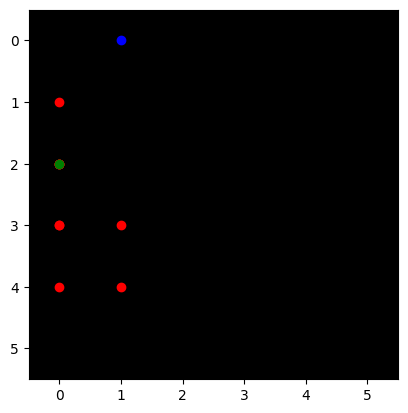

[-0.29492497, -0.3100521, -0.29492497, -0.26413485, -0.24876699, -0.2553907, -0.26277617, -0.26413485, -0.29492497]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.29492497, -0.3100521, -0.29492497, -0.26413485, -0.24876699, -0.2553907, -0.26277617, -0.26413485, -0.29492497]
return [-0.2480416774749756, -0.23593997955322266, -0.21130788326263428, -0.1990135908126831, -0.20431256294250488, -0.21022093296051025, -0.21130788326263428, -0.23593997955322266, -1.0]
gae [0.04688329696655272, 0.07411211729049683, 0.08361709117889404, 0.06512126326560974, 0.044454425573349, 0.04516977071762085, 0.05146828293800354, 0.02819487452507019, -0.7050750255584717]
0.6751614238443465
tensor([[ 3.,  5., -1.,  0.]])
tensor([[ 3.,  5., -1.,  0.]])
tensor([[ 3.,  4., -1., -1.]])
tensor([[ 3.,  4., -1., -1.]])
tensor([[ 3.,  5., -1.,  0.]])


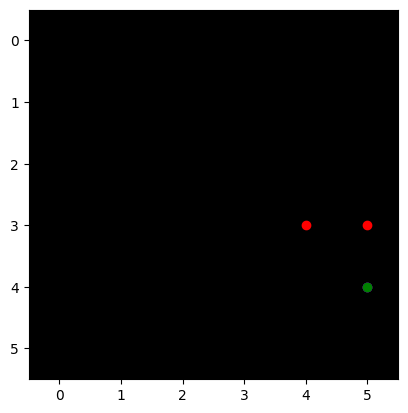

[-0.27556843, -0.2752707, -0.27556843]
 gamma 0.8
[0, 0, 1]
[-0.27556843, -0.2752707, -0.27556843]
return [-0.22021656036376955, -0.220454740524292, 1.0]
gae [0.05535186529159544, 0.054815959930419905, 1.275568425655365]
0.8818867426283961


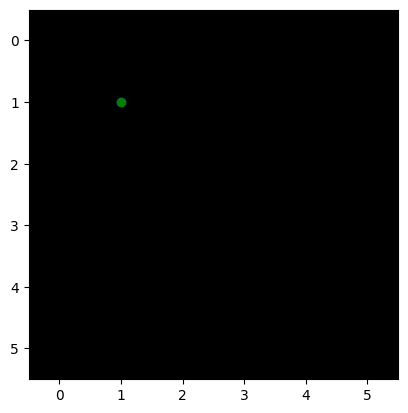

[-0.3156429, -0.3323488, -0.33125842, -0.3247211, -0.29492497, -0.3100521, -0.29492497, -0.26413485, -0.24876699, -0.2553907, -0.26277617, -0.26413485, -0.29492497, -0.27556843, -0.2752707, -0.27556843]
 gamma 0.8
[]
[-0.3156429, -0.3323488, -0.33125842, -0.3247211, -0.29492497, -0.3100521, -0.29492497, -0.26413485, -0.24876699, -0.2553907, -0.26277617, -0.26413485, -0.29492497, -0.27556843, -0.2752707, -0.27556843]
return []
gae []
0.052456296045993334
tensor([[ 3.,  0.,  1., -4.]])


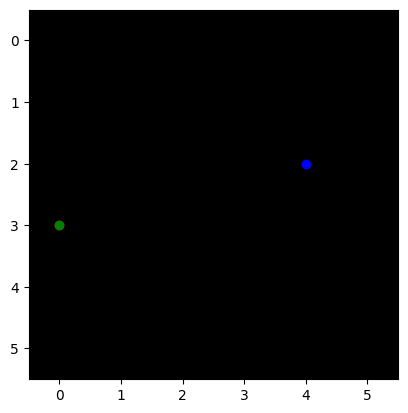

[-0.32737616]
 gamma 0.8
[-1]
[-0.32737616]
return [-1.0]
gae [-0.6726238429546356]
0.8237522128826487
tensor([[5., 2., 4., 0.]])
tensor([[ 5.,  1.,  4., -1.]])
tensor([[ 5.,  1.,  4., -1.]])
tensor([[ 4.,  1.,  3., -1.]])
tensor([[4., 2., 3., 0.]])
tensor([[4., 2., 3., 0.]])
tensor([[3., 2., 2., 0.]])
tensor([[3., 2., 2., 0.]])
tensor([[3., 3., 2., 1.]])
tensor([[3., 3., 2., 1.]])
tensor([[2., 3., 1., 1.]])
tensor([[1., 3., 0., 1.]])
tensor([[1., 3., 0., 1.]])


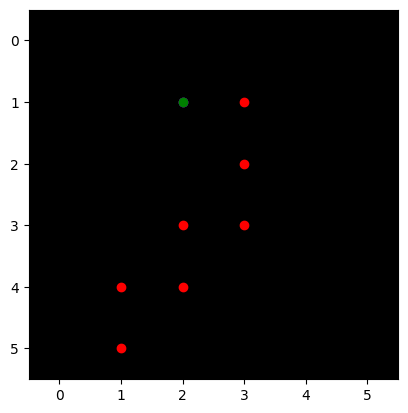

[-0.26448792, -0.27138653, -0.26151222, -0.26304102, -0.24867621, -0.26666847, -0.26570883, -0.2644238]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 1]
[-0.26448792, -0.27138653, -0.26151222, -0.26304102, -0.24867621, -0.26666847, -0.26570883, -0.2644238]
return [-0.21710922718048098, -0.20920977592468262, -0.21043281555175783, -0.19894096851348878, -0.2133347749710083, -0.21256706714630128, -0.21153903007507324, 1.0]
gae [0.047378695011138894, 0.062176758050918574, 0.05107940435409544, 0.06410005092620849, 0.035341435670852656, 0.0541014015674591, 0.054169803857803345, 1.2644237875938416]
0.5101581235820456
tensor([[ 0.,  3., -2., -2.]])


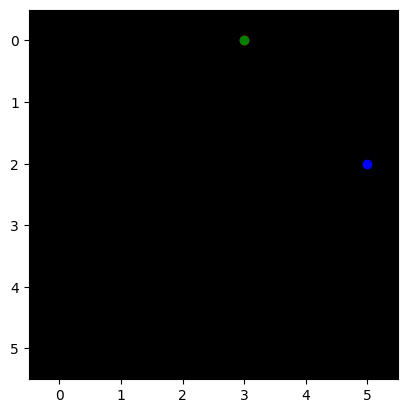

[-0.30754125]
 gamma 0.8
[-1]
[-0.30754125]
return [-1.0]
gae [-0.6924587488174438]
0.011232673765783296
tensor([[ 0.,  1., -3., -4.]])
tensor([[ 0.,  2., -3., -3.]])
tensor([[ 1.,  2., -2., -3.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 0.,  3., -3., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 3.,  3.,  0., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 2.,  4., -1., -1.]])
tensor([[ 1.,  4., -2., -1.]])
tensor([[ 1.,  5., -2.,  0.]])
tensor([[ 0.,  5., -3.,  0.]])


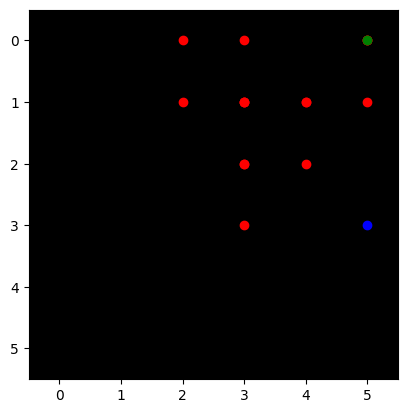

[-0.31697398, -0.32728067, -0.3185198, -0.30416596, -0.30898714, -0.30416596, -0.30533075, -0.25299793, -0.30533075, -0.30416596, -0.3125483, -0.29640654, -0.3125483, -0.3240165, -0.33453664]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.31697398, -0.32728067, -0.3185198, -0.30416596, -0.30898714, -0.30416596, -0.30533075, -0.25299793, -0.30533075, -0.30416596, -0.3125483, -0.29640654, -0.3125483, -0.3240165, -0.33453664]
return [-0.26182453632354735, -0.2548158407211304, -0.2433327674865723, -0.24718971252441407, -0.2433327674865723, -0.2442646026611328, -0.20239834785461427, -0.2442646026611328, -0.2433327674865723, -0.2500386476516724, -0.23712522983551027, -0.2500386476516724, -0.2592132091522217, -0.2676293134689331, -1.0]
gae [0.055149447917938244, 0.07246482968330381, 0.07518703341484068, 0.05697624683380126, 0.06565437316894529, 0.05990135669708252, 0.10293240547180174, 0.00873333215713501, 0.06199798583984373, 0.05412731170654295, 0.07542307972908019, 0.0463678

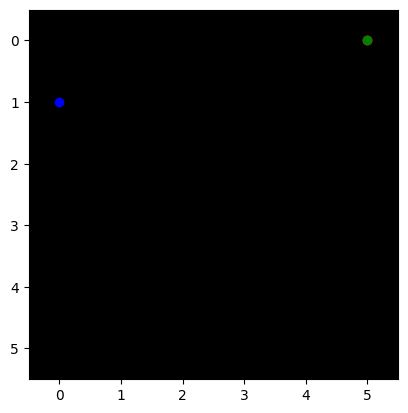

[-0.27955854, -0.27306673]
 gamma 0.8
[0, -1]
[-0.27955854, -0.27306673]
return [-0.21845338344573975, -1.0]
gae [0.06110515594482421, -0.7269332706928253]
0.5743628722441388
tensor([[5., 4., 3., 3.]])
tensor([[5., 4., 3., 3.]])
tensor([[5., 3., 3., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[4., 2., 2., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 2., 1., 1.]])
tensor([[3., 1., 1., 0.]])
tensor([[3., 1., 1., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[3., 1., 1., 0.]])
tensor([[3., 1., 1., 0.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 3.,  0.,  1., -1.]])


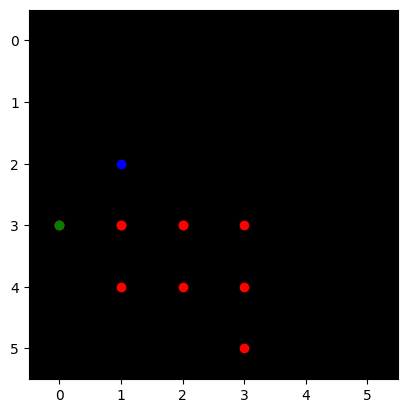

[-0.26607415, -0.26485378, -0.26585886, -0.26907063, -0.26305866, -0.2647632, -0.26305866, -0.25227308, -0.26473054, -0.25227308, -0.29218304]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.26607415, -0.26485378, -0.26585886, -0.26907063, -0.26305866, -0.2647632, -0.26305866, -0.25227308, -0.26473054, -0.25227308, -0.29218304]
return [-0.211883020401001, -0.212687087059021, -0.21525650024414064, -0.21044692993164063, -0.21181056499481202, -0.21044692993164063, -0.20181846618652344, -0.2117844343185425, -0.20181846618652344, -0.23374643325805666, -1.0]
gae [0.05419113039970397, 0.052166688442230214, 0.0506023585796356, 0.05862369537353515, 0.051248097419738764, 0.054316276311874384, 0.061240196228027344, 0.040488648414611805, 0.06291207671165466, 0.018526649475097634, -0.7078169584274292]
return [-0.21022093 -0.20920977 -0.20431256 -0.20239834 -0.20181847 -0.20181847
 -0.19901359 -0.19894096  1.          1.        ]
return [-1.         -1.         -1.         -1.         -1.         

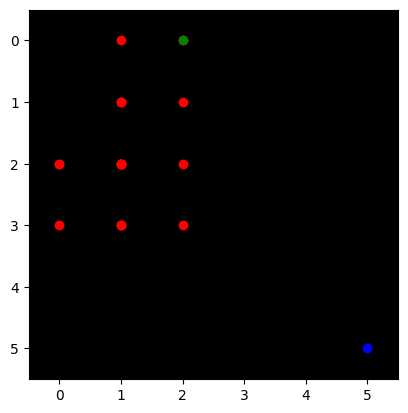

[-0.24012563, -0.23914102, -0.24156086, -0.24198312, -0.24156086, -0.25700143, -0.24156086, -0.26754102, -0.24901599, -0.26754102, -0.27104568, -0.25700143, -0.24156086, -0.26754102, -0.24156086, -0.24198312, -0.2454465, -0.24198312, -0.24012563, -0.24121666]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.24012563, -0.23914102, -0.24156086, -0.24198312, -0.24156086, -0.25700143, -0.24156086, -0.26754102, -0.24901599, -0.26754102, -0.27104568, -0.25700143, -0.24156086, -0.26754102, -0.24156086, -0.24198312, -0.2454465, -0.24198312, -0.24012563, -0.24121666]
return [-0.19131281375885012, -0.1932486891746521, -0.19358649253845217, -0.1932486891746521, -0.20560114383697511, -0.1932486891746521, -0.21403281688690187, -0.19921278953552246, -0.21403281688690187, -0.2168365478515625, -0.20560114383697511, -0.1932486891746521, -0.21403281688690187, -0.1932486891746521, -0.19358649253845217, -0.19635720252990724, -0.19358649253845217, -0.19210050106048585, -0.192973

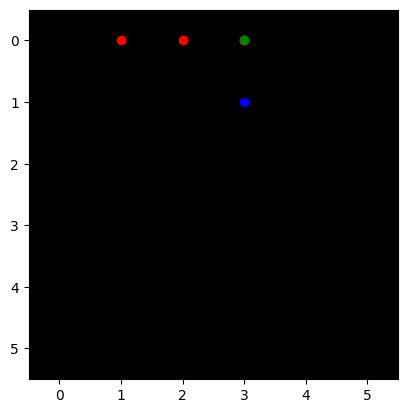

[-0.2363835, -0.24810569, -0.2363835, -0.23606764]
 gamma 0.8
[0, 0, 0, -1]
[-0.2363835, -0.24810569, -0.2363835, -0.23606764]
return [-0.1984845519065857, -0.18910679817199708, -0.1888541102409363, -1.0]
gae [0.03789894580841063, 0.05899889171123504, 0.04752938747406005, -0.7639323621988297]
0.8419535644571169
tensor([[5., 5., 1., 2.]])
tensor([[5., 5., 1., 2.]])


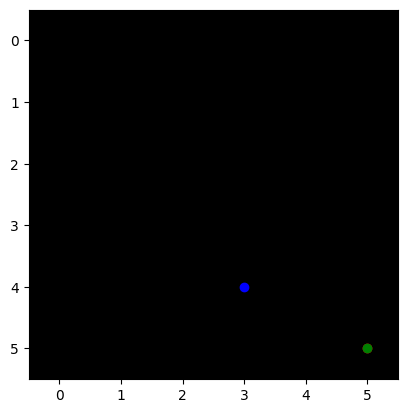

[-0.30057943]
 gamma 0.8
[-1]
[-0.30057943]
return [-1.0]
gae [-0.6994205713272095]
0.7634327458823342
tensor([[ 2.,  5., -1.,  5.]])


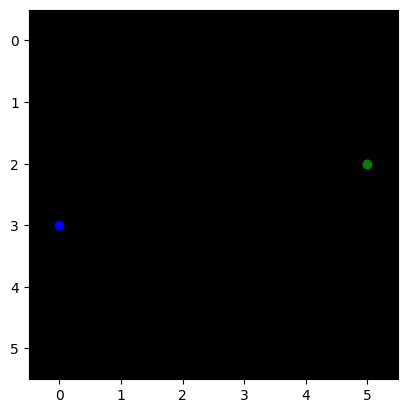

[-0.28003004]
 gamma 0.8
[-1]
[-0.28003004]
return [-1.0]
gae [-0.7199699580669403]
0.20312571219791098
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 0.,  3., -4.,  2.]])
tensor([[ 0.,  3., -4.,  2.]])
tensor([[ 0.,  2., -4.,  1.]])
tensor([[ 0.,  3., -4.,  2.]])
tensor([[ 0.,  3., -4.,  2.]])


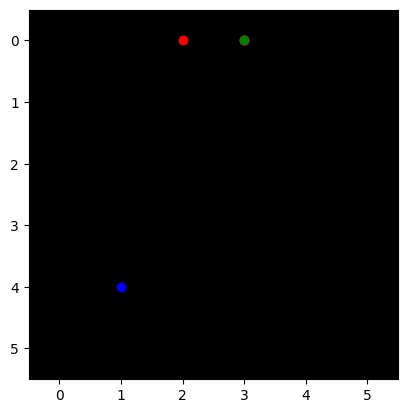

[-0.23955448, -0.27953547, -0.23955448, -0.27953547]
 gamma 0.8
[0, 0, 0, -1]
[-0.23955448, -0.27953547, -0.23955448, -0.27953547]
return [-0.22362837791442872, -0.19164358377456667, -0.22362837791442872, -1.0]
gae [0.015926101803779596, 0.08789188861846922, 0.015926101803779596, -0.7204645276069641]
0.4735549145618849
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  2.,  0., -2.]])
tensor([[ 0.,  3.,  0., -1.]])
tensor([[ 0.,  3.,  0., -1.]])


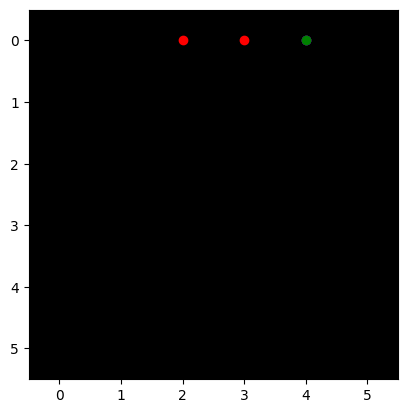

[-0.23733099, -0.26372242, -0.23733099]
 gamma 0.8
[0, 0, 1]
[-0.23733099, -0.26372242, -0.23733099]
return [-0.21097793579101565, -0.18986479043960572, 1.0]
gae [0.026353052258491494, 0.07385762929916381, 1.2373309880495071]
0.3336466504808373
tensor([[ 2.,  0., -3., -5.]])
tensor([[ 2.,  0., -3., -5.]])
tensor([[ 3.,  0., -2., -5.]])
tensor([[ 4.,  0., -1., -5.]])
tensor([[ 3.,  0., -2., -5.]])
tensor([[ 4.,  0., -1., -5.]])
tensor([[ 4.,  0., -1., -5.]])
tensor([[ 4.,  1., -1., -4.]])
tensor([[ 4.,  1., -1., -4.]])
tensor([[ 4.,  2., -1., -3.]])
tensor([[ 5.,  2.,  0., -3.]])
tensor([[ 4.,  2., -1., -3.]])
tensor([[ 3.,  2., -2., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 2.,  2., -3., -3.]])
tensor([[ 2.,  3., -3., -2.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 1.,  3., -4., -2.]])
tensor([[ 1.,  4., -4., -1.]])
tensor([[ 0.,  4., -5., -1.]])
tensor([[ 0.,  5., -5.,  0.]])


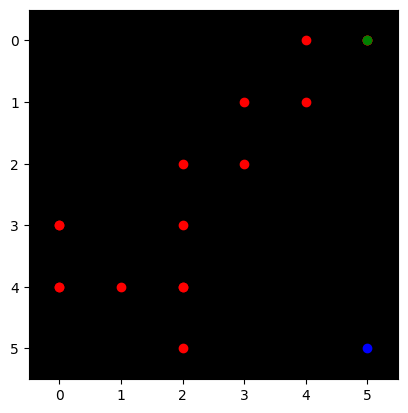

[-0.25700143, -0.27104568, -0.27167004, -0.27104568, -0.27167004, -0.26914352, -0.28202993, -0.30871832, -0.28202993, -0.24901599, -0.23914102, -0.23165226, -0.22151734, -0.25466114, -0.23261559, -0.2733037]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.25700143, -0.27104568, -0.27167004, -0.27104568, -0.27167004, -0.26914352, -0.28202993, -0.30871832, -0.28202993, -0.24901599, -0.23914102, -0.23165226, -0.22151734, -0.25466114, -0.23261559, -0.2733037]
return [-0.2168365478515625, -0.21733603477478028, -0.2168365478515625, -0.21733603477478028, -0.21531481742858888, -0.2256239414215088, -0.24697465896606446, -0.2256239414215088, -0.19921278953552246, -0.19131281375885012, -0.18532180786132812, -0.17721387147903445, -0.20372891426086426, -0.18609247207641602, -0.2186429500579834, -1.0]
gae [0.040164881944656367, 0.053709650039672846, 0.054833495616912836, 0.053709650039672846, 0.056355226039886464, 0.04351958036422729, 0.03505526781082152, 0.08309438228607177, 0.0828

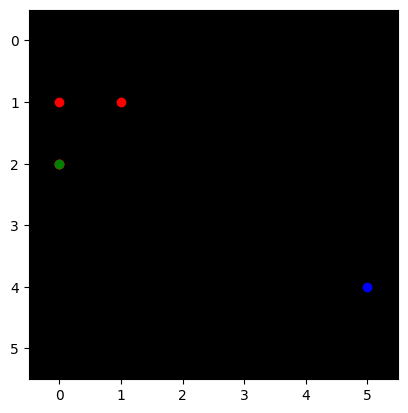

[-0.24596494, -0.23938379, -0.24596494, -0.2700868]
 gamma 0.8
[0, 0, 0, -1]
[-0.24596494, -0.23938379, -0.24596494, -0.2700868]
return [-0.19150702953338625, -0.1967719554901123, -0.21606943607330323, -1.0]
gae [0.054457914829254134, 0.04261183142662048, 0.029895508289337153, -0.729913204908371]
return [-0.19150703 -0.19131282 -0.19131282 -0.18986478 -0.18910679 -0.18885411
 -0.18609247 -0.18532181 -0.17721388  1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.24697466 -0.22562394 -0.22562394]

-------------------- Iteration #77 --------------------
random  0.07340671280770428
Average : 0.01
Average Episodic Return: -0.6
Max Episodic Return: 1.0
Average Loss: -0.0002
Average Loss Critic: 0.2319154292345047
TEntropy: nan
approx_kl_divs: [0.00012090191] secs
------------------------------------------------------

0.21469109300781164
tensor([[4., 0., 2., 0.]])
tensor([[4., 0., 2., 0.]])


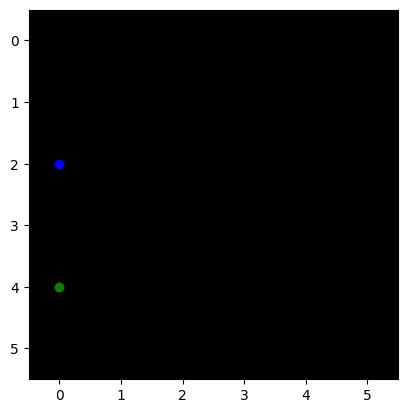

[-0.40484902]
 gamma 0.8
[-1]
[-0.40484902]
return [-1.0]
gae [-0.5951509773731232]
0.3426523615789354
tensor([[3., 5., 2., 4.]])


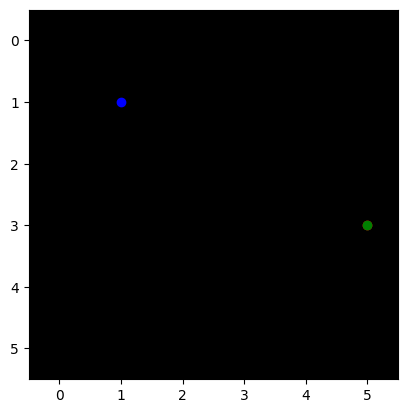

[-0.40211007]
 gamma 0.8
[-1]
[-0.40211007]
return [-1.0]
gae [-0.5978899300098419]
0.31252931309238696
tensor([[5., 4., 5., 3.]])
tensor([[5., 3., 5., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 3., 5., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[4., 3., 4., 2.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 4., 5., 3.]])
tensor([[4., 4., 4., 3.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 5., 5., 4.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 3., 5., 2.]])
tensor([[5., 4., 5., 3.]])
tensor([[5., 4., 5., 3.]])
tensor([[4., 4., 4., 3.]])
tensor([[4., 4., 4., 3.]])
tensor([[4., 5., 4., 4.]])


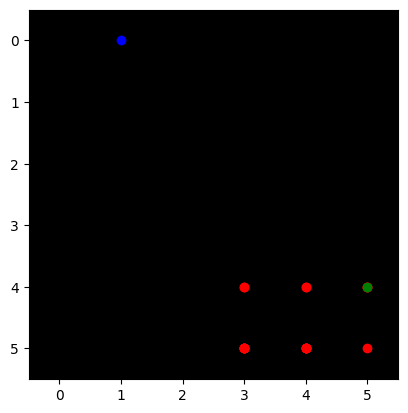

[-0.39473096, -0.39437085, -0.3958991, -0.39437085, -0.39473096, -0.39437085, -0.3958991, -0.39437085, -0.39473096, -0.39637324, -0.39473096, -0.39437085, -0.39473096, -0.39531028, -0.39473096, -0.39437085, -0.39473096, -0.39637324, -0.397211]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.39473096, -0.39437085, -0.3958991, -0.39437085, -0.39473096, -0.39437085, -0.3958991, -0.39437085, -0.39473096, -0.39637324, -0.39473096, -0.39437085, -0.39473096, -0.39531028, -0.39473096, -0.39437085, -0.39473096, -0.39637324, -0.397211]
return [-0.31549668312072754, -0.3167192697525025, -0.31549668312072754, -0.31578476428985597, -0.31549668312072754, -0.3167192697525025, -0.31549668312072754, -0.31578476428985597, -0.31709859371185306, -0.31578476428985597, -0.31549668312072754, -0.31578476428985597, -0.31624822616577153, -0.31578476428985597, -0.31549668312072754, -0.31578476428985597, -0.31709859371185306, -0.31776878833770755, -1.0]
gae [0.07923427224159241, 0.077651

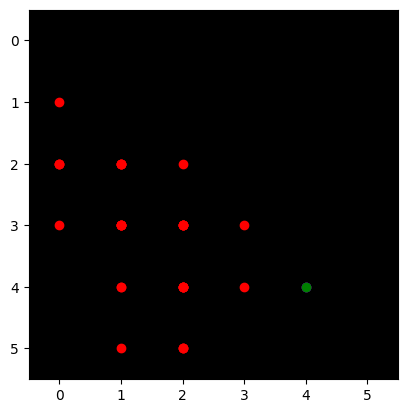

[-0.40041497, -0.401222, -0.40041497, -0.39340773, -0.40133125, -0.401222, -0.40133125, -0.39980957, -0.3582079, -0.30806583, -0.39017296, -0.39980957, -0.3582079, -0.30806583, -0.3029148, -0.29662645, -0.3029148, -0.31943342, -0.3029148, -0.30806583, -0.3582079, -0.30806583, -0.3582079, -0.39980957, -0.40133125, -0.401222, -0.40133125, -0.39340773, -0.3582079, -0.39980957, -0.40133125, -0.39980957, -0.40009323, -0.3976769]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.40041497, -0.401222, -0.40041497, -0.39340773, -0.40133125, -0.401222, -0.40133125, -0.39980957, -0.3582079, -0.30806583, -0.39017296, -0.39980957, -0.3582079, -0.30806583, -0.3029148, -0.29662645, -0.3029148, -0.31943342, -0.3029148, -0.30806583, -0.3582079, -0.30806583, -0.3582079, -0.39980957, -0.40133125, -0.401222, -0.40133125, -0.39340773, -0.3582079, -0.39980957, -0.40133125, -0.39980957, -0.40009323, -0.3976769]
return [-0.32097759246826174, 

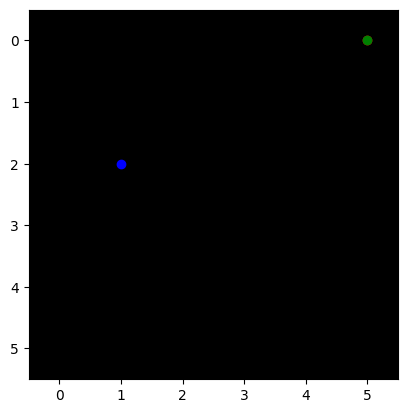

[-0.3145258]
 gamma 0.8
[-1]
[-0.3145258]
return [-1.0]
gae [-0.6854741871356964]
0.10273456389937019
tensor([[5., 4., 2., 1.]])
tensor([[5., 3., 2., 0.]])
tensor([[5., 4., 2., 1.]])


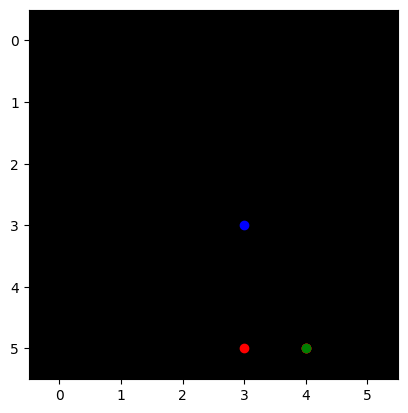

[-0.31702292, -0.30882654, -0.31702292]
 gamma 0.8
[0, 0, -1]
[-0.31702292, -0.30882654, -0.31702292]
return [-0.24706122875213624, -0.253618335723877, -1.0]
gae [0.06996169090270996, 0.0552082002162933, -0.6829770803451538]
0.46757352070644176
tensor([[4., 3., 1., 0.]])
tensor([[4., 4., 1., 1.]])
tensor([[4., 3., 1., 0.]])
tensor([[ 4.,  2.,  1., -1.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[ 5.,  2.,  2., -1.]])
tensor([[ 5.,  1.,  2., -2.]])


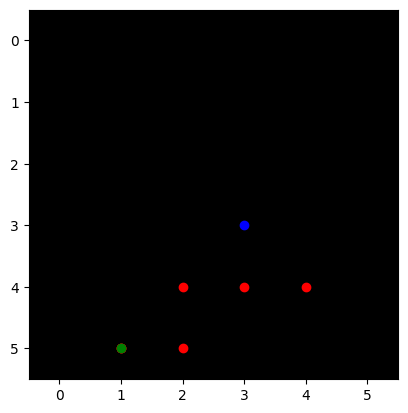

[-0.3210781, -0.31268433, -0.3210781, -0.30302534, -0.3032188, -0.26832503]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.3210781, -0.31268433, -0.3210781, -0.30302534, -0.3032188, -0.26832503]
return [-0.2501474618911743, -0.256862473487854, -0.24242026805877687, -0.2425750494003296, -0.21466002464294434, -1.0]
gae [0.07093062996864319, 0.05582185387611388, 0.07865782380104064, 0.06045028567314148, 0.08855878710746765, -0.7316749691963196]
0.7430508183557804
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  3., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[3., 4., 2., 0.]])
tensor([[3., 4., 2., 0.]])
tensor([[2., 4., 1., 0.]])
t

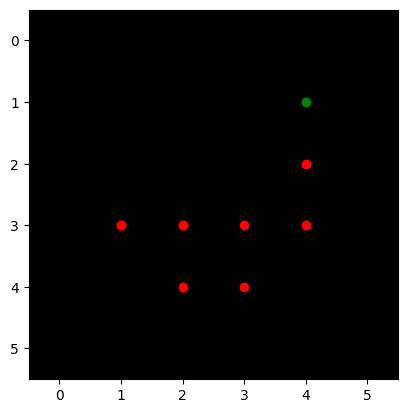

[-0.22530709, -0.21543895, -0.2622732, -0.21543895, -0.2622732, -0.296448, -0.30238873, -0.3194728, -0.32558575, -0.31601]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.22530709, -0.21543895, -0.2622732, -0.21543895, -0.2622732, -0.296448, -0.30238873, -0.3194728, -0.32558575, -0.31601]
return [-0.1723511576652527, -0.20981855392456056, -0.1723511576652527, -0.20981855392456056, -0.2371583938598633, -0.24191098213195802, -0.25557823181152345, -0.26046860218048096, -0.2528079986572266, 1.0]
gae [0.05295593440532684, 0.005620393157005299, 0.08992203474044799, 0.005620393157005299, 0.025114798545837397, 0.05453701019287108, 0.04681049585342406, 0.05900418758392334, 0.07277775406837461, 1.3160099983215332]
0.4314950909015175
tensor([[ 1.,  0.,  1., -1.]])
tensor([[ 1.,  0.,  1., -1.]])
tensor([[ 0.,  0.,  0., -1.]])


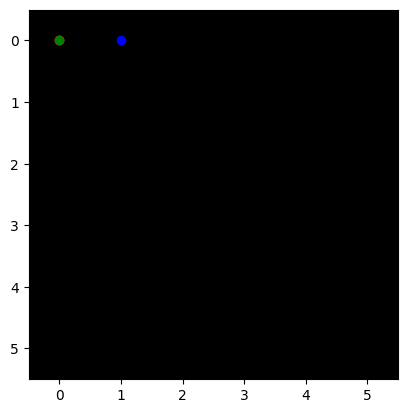

[-0.23048477, -0.2376848]
 gamma 0.8
[0, -1]
[-0.23048477, -0.2376848]
return [-0.1901478409767151, -1.0]
gae [0.040336927771568276, -0.7623151987791061]
0.7167671285486527
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 0.,  2., -5.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 1.,  3., -4.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  5., -3.,  5.]])
tensor([[ 2.,  5., -3.,  5.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  4., -3.,  4.]])
tensor([[ 2.,  5., -3.,  5.]])


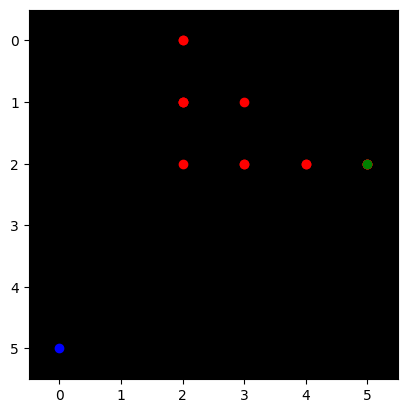

[-0.29430914, -0.2786662, -0.26847425, -0.2786662, -0.26847425, -0.2786662, -0.29430914, -0.3143036, -0.2994832, -0.3143036, -0.31779203, -0.3179877, -0.31779203, -0.3179877]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.29430914, -0.2786662, -0.26847425, -0.2786662, -0.26847425, -0.2786662, -0.29430914, -0.3143036, -0.2994832, -0.3143036, -0.31779203, -0.3179877, -0.31779203, -0.3179877]
return [-0.2229329586029053, -0.2147794008255005, -0.2229329586029053, -0.2147794008255005, -0.2229329586029053, -0.2354473114013672, -0.2514428853988648, -0.23958656787872315, -0.2514428853988648, -0.2542336225509644, -0.25439016819000243, -0.2542336225509644, -0.25439016819000243, -1.0]
gae [0.07137618064880369, 0.06388679742813108, 0.045541292428970315, 0.06388679742813108, 0.045541292428970315, 0.04321888685226438, 0.042866253852844205, 0.07471703886985778, 0.04804032444953915, 0.060069984197616555, 0.06340185999870301, 0.06375408768653867, 0.06340185999870301, -0.682012289762497]
0.9

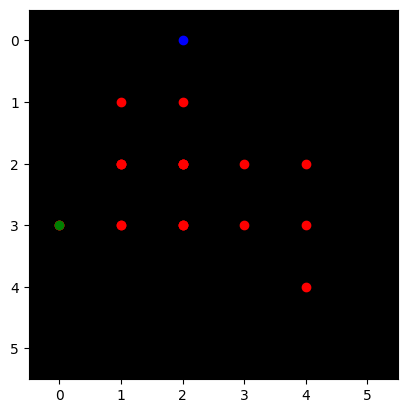

[-0.30985007, -0.3153427, -0.3219371, -0.32021976, -0.32705474, -0.30522114, -0.22366771, -0.25168383, -0.3031212, -0.3202386, -0.3031212, -0.30522114, -0.22366771, -0.30522114, -0.22366771, -0.24004424, -0.2780764, -0.30522114, -0.3031212, -0.25168383, -0.22199385]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.30985007, -0.3153427, -0.3219371, -0.32021976, -0.32705474, -0.30522114, -0.22366771, -0.25168383, -0.3031212, -0.3202386, -0.3031212, -0.30522114, -0.22366771, -0.30522114, -0.22366771, -0.24004424, -0.2780764, -0.30522114, -0.3031212, -0.25168383, -0.22199385]
return [-0.25227415561676025, -0.25754969120025634, -0.2561758041381836, -0.2616437911987305, -0.24417691230773927, -0.1789341688156128, -0.20134706497192384, -0.24249696731567383, -0.25619087219238285, -0.24249696731567383, -0.24417691230773927, -0.1789341688156128, -0.24417691230773927, -0.1789341688156128, -0.19203538894653321, -0.2224611282348633, -0.24417691230773927, -0.24249696731

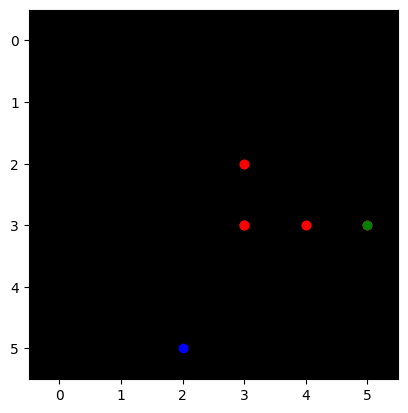

[-0.3207084, -0.32167965, -0.31578925, -0.29964578, -0.31578925, -0.29964578, -0.31578925, -0.32167965, -0.32254174]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.3207084, -0.32167965, -0.31578925, -0.29964578, -0.31578925, -0.29964578, -0.31578925, -0.32167965, -0.32254174]
return [-0.2573437213897705, -0.25263140201568607, -0.23971662521362305, -0.25263140201568607, -0.23971662521362305, -0.25263140201568607, -0.2573437213897705, -0.2580333948135376, -1.0]
gae [0.06336467266082763, 0.06904824972152707, 0.07607262730598449, 0.04701437950134274, 0.07607262730598449, 0.04701437950134274, 0.058445531129837025, 0.06364625692367554, -0.677458256483078]
0.3798569156728676
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 2.,  3., -1., -1.]])
tensor([[ 3.,  3.,  0., -1.]])


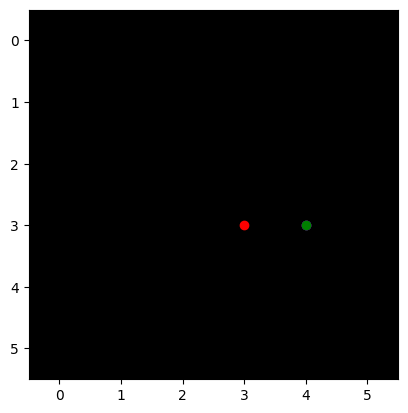

[-0.27920574, -0.2863009]
 gamma 0.8
[0, 1]
[-0.27920574, -0.2863009]
return [-0.2290407180786133, 1.0]
gae [0.05016502141952514, 1.2863008975982666]
0.2132127510080587
tensor([[ 4.,  4.,  4., -1.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  4.,  4., -1.]])
tensor([[4., 5., 4., 0.]])


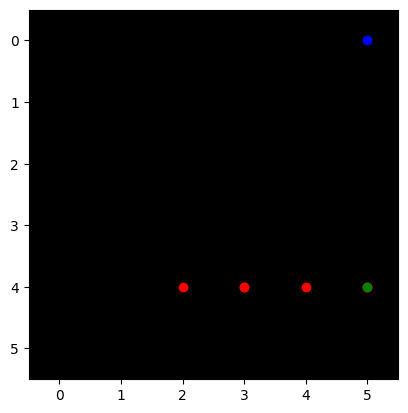

[-0.37583533, -0.36945933, -0.3112139, -0.36945933, -0.37583533, -0.37502095]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.37583533, -0.36945933, -0.3112139, -0.36945933, -0.37583533, -0.37502095]
return [-0.2955674648284912, -0.24897112846374514, -0.2955674648284912, -0.3006682634353638, -0.30001676082611084, -1.0]
gae [0.08026786446571349, 0.12048820257186887, 0.015646445751190174, 0.06879106760025022, 0.07581856846809387, -0.6249790489673615]
0.08267221013260839
tensor([[4., 4., 0., 4.]])
tensor([[4., 4., 0., 4.]])
tensor([[ 3.,  4., -1.,  4.]])
tensor([[4., 4., 0., 4.]])
tensor([[ 3.,  4., -1.,  4.]])
tensor([[ 3.,  3., -1.,  3.]])
tensor([[ 2.,  3., -2.,  3.]])
tensor([[ 2.,  4., -2.,  4.]])
tensor([[ 2.,  5., -2.,  5.]])


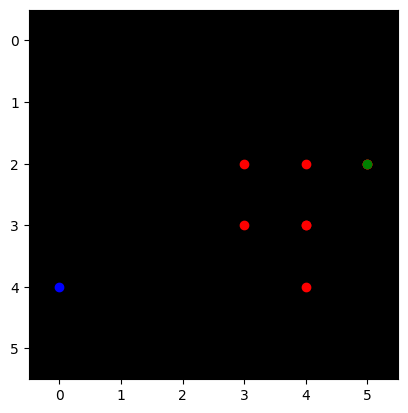

[-0.3205077, -0.32296512, -0.3205077, -0.32296512, -0.3222859, -0.32322225, -0.32279798, -0.3230604]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.3205077, -0.32296512, -0.3205077, -0.32296512, -0.3222859, -0.32322225, -0.32279798, -0.3230604]
return [-0.2583720922470093, -0.25640616416931156, -0.2583720922470093, -0.2578287124633789, -0.25857779979705814, -0.25823838710784913, -0.25844831466674806, -1.0]
gae [0.062135612964630105, 0.06655895113945004, 0.062135612964630105, 0.06513640284538269, 0.0637080907821655, 0.0649838626384735, 0.06434966921806334, -0.6769396066665649]
0.48087596804455024
tensor([[5., 5., 2., 4.]])
tensor([[5., 5., 2., 4.]])
tensor([[5., 4., 2., 3.]])
tensor([[5., 4., 2., 3.]])
tensor([[5., 3., 2., 2.]])
tensor([[5., 4., 2., 3.]])
tensor([[4., 4., 1., 3.]])
tensor([[3., 4., 0., 3.]])
tensor([[4., 4., 1., 3.]])
tensor([[4., 5., 1., 4.]])
tensor([[4., 5., 1., 4.]])


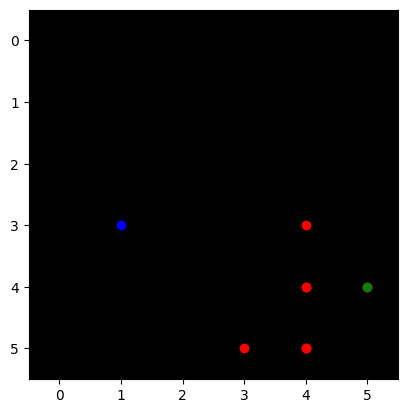

[-0.32002804, -0.34642723, -0.37270984, -0.34642723, -0.3187811, -0.32149535, -0.3187811, -0.31959105]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.32002804, -0.34642723, -0.37270984, -0.34642723, -0.3187811, -0.32149535, -0.3187811, -0.31959105]
return [-0.2771417856216431, -0.29816787242889403, -0.2771417856216431, -0.25502488613128665, -0.25719628334045413, -0.25502488613128665, -0.25567283630371096, -1.0]
gae [0.04288625121116635, 0.0482593595981598, 0.09556805491447445, 0.09140234589576718, 0.06158482432365414, 0.06647046804428097, 0.06310827136039732, -0.6804089546203613]
0.09710051002216447
tensor([[4., 2., 4., 0.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 4., 4., 2.]])
tensor([[4., 4., 4., 2.]])
tensor([[5., 4., 5., 2.]])
tensor([[5., 5., 5., 3.]])
tensor([[5., 4., 5., 2.]])
tensor([[5., 5., 5., 3.]])


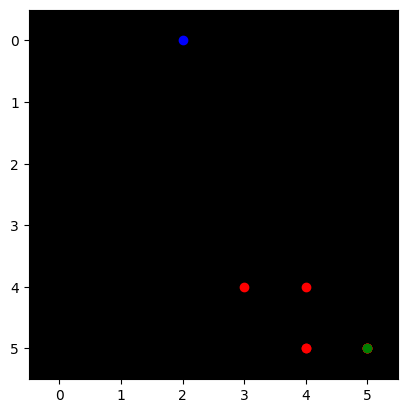

[-0.3737342, -0.3788416, -0.38241503, -0.38240862, -0.38351873, -0.38240862, -0.38351873]
 gamma 0.8
[0, 0, 0, 0, 0, 0, -1]
[-0.3737342, -0.3788416, -0.38241503, -0.38240862, -0.38351873, -0.38240862, -0.38351873]
return [-0.30307328701019287, -0.3059320211410523, -0.3059268951416016, -0.306814980506897, -0.3059268951416016, -0.306814980506897, -1.0]
gae [0.07066091895103455, 0.07290958762168881, 0.07648813128471371, 0.07559363842010497, 0.07759183049201962, 0.07559363842010497, -0.6164812743663788]
0.8621258457453655
tensor([[3., 4., 1., 3.]])
tensor([[3., 4., 1., 3.]])
tensor([[4., 4., 2., 3.]])
tensor([[4., 3., 2., 2.]])
tensor([[5., 3., 3., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[4., 3., 2., 2.]])
tensor([[5., 3., 3., 2.]])
tensor([[5., 3., 3., 2.]])


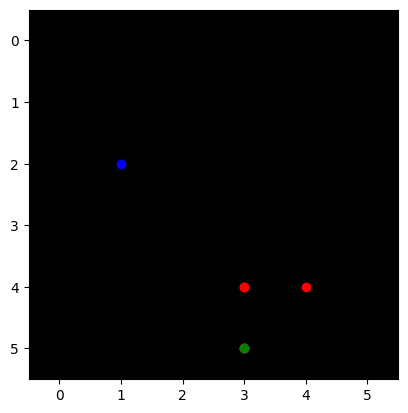

[-0.3196437, -0.32735753, -0.36669636, -0.38244998, -0.36669636, -0.38244998]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.3196437, -0.32735753, -0.36669636, -0.38244998, -0.36669636, -0.38244998]
return [-0.2618860244750977, -0.29335708618164064, -0.3059599876403809, -0.29335708618164064, -0.3059599876403809, -1.0]
gae [0.05775768160820005, 0.034000444412231434, 0.06073637008666988, 0.08909289836883544, 0.06073637008666988, -0.6175500154495239]
0.13894195806477083
tensor([[ 4.,  5., -1.,  0.]])


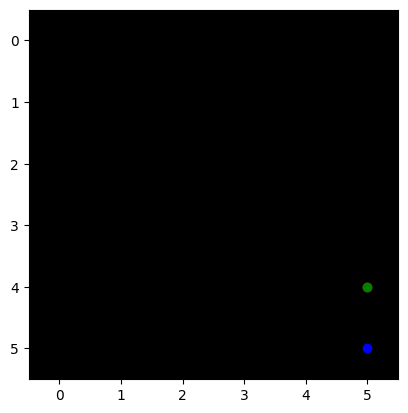

[-0.3049573]
 gamma 0.8
[-1]
[-0.3049573]
return [-1.0]
gae [-0.6950426995754242]
0.42857668696073614
tensor([[ 4.,  0., -1., -3.]])


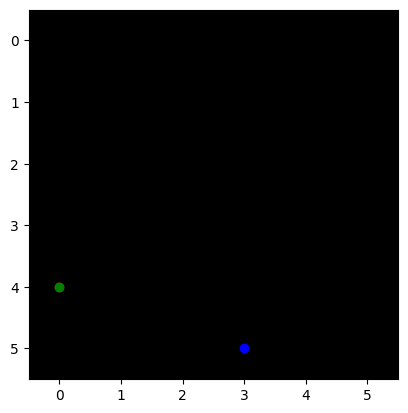

[-0.3131137]
 gamma 0.8
[-1]
[-0.3131137]
return [-1.0]
gae [-0.6868863105773926]
0.6799481320302628
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 2.,  3.,  0., -1.]])
tensor([[ 3.,  3.,  1., -1.]])
tensor([[ 4.,  3.,  2., -1.]])
tensor([[ 5.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  2., -1.]])
tensor([[ 4.,  3.,  2., -1.]])
tensor([[ 5.,  3.,  3., -1.]])
tensor([[ 4.,  3.,  2., -1.]])
tensor([[ 4.,  2.,  2., -2.]])
tensor([[ 5.,  2.,  3., -2.]])
tensor([[ 5.,  2.,  3., -2.]])


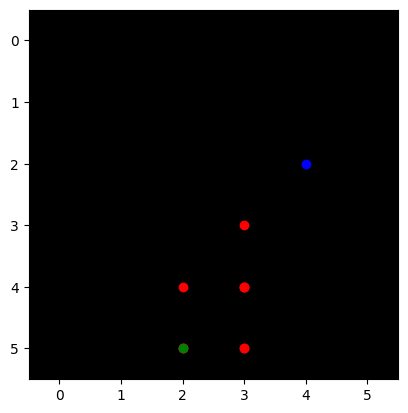

[-0.2850168, -0.3465737, -0.3727233, -0.3744709, -0.3727233, -0.3744709, -0.3727233, -0.31062213, -0.32849982]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.2850168, -0.3465737, -0.3727233, -0.3744709, -0.3727233, -0.3744709, -0.3727233, -0.31062213, -0.32849982]
return [-0.2772589683532715, -0.29817864894866947, -0.2995767116546631, -0.29817864894866947, -0.2995767116546631, -0.29817864894866947, -0.24849770069122315, -0.26279985904693604, -1.0]
gae [0.007757836580276456, 0.04839506149291989, 0.0731465995311737, 0.07629224061965939, 0.0731465995311737, 0.07629224061965939, 0.12422561049461364, 0.047822266817092896, -0.67150017619133]
return [-0.25502488 -0.2526314  -0.2526314  -0.2526314  -0.24897113 -0.2484977
 -0.23971662 -0.23971662 -0.22904071  1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.30681497]

-------------------- Iteration #80 --------------------
random  0.6799481320302628
Average : 0.01
Average E

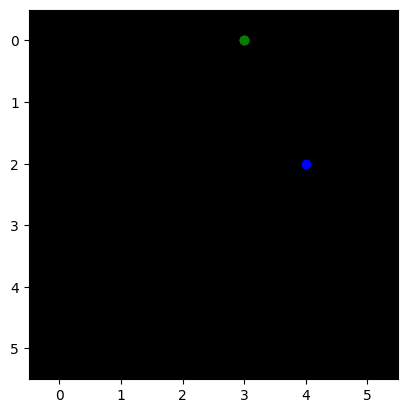

[-0.22037895, -0.22707143]
 gamma 0.8
[0, -1]
[-0.22037895, -0.22707143]
return [-0.18165714740753175, -1.0]
gae [0.038721802830696095, -0.7729285657405853]
0.7632978155010237
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  1.,  0., -3.]])
tensor([[ 5.,  1.,  0., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 5.,  0.,  0., -4.]])
tensor([[ 5.,  0.,  0., -4.]])
tensor([[ 5.,  1.,  0., -3.]])
tensor([[ 5.,  1.,  0., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 3.,  1., -2., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 3.,  0., -2., -4.]])
tensor([[ 3.,  0.,

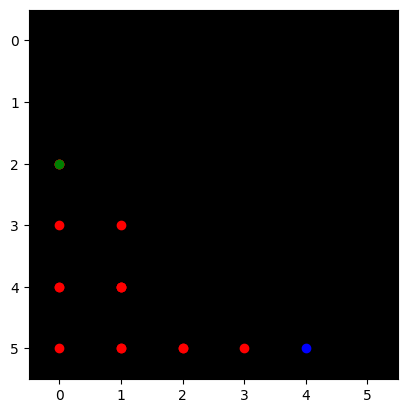

[-0.22015586, -0.22978501, -0.22015586, -0.22978501, -0.23048127, -0.24075684, -0.2390347, -0.23188545, -0.23048127, -0.24075684, -0.2382767, -0.24075684, -0.2390347, -0.24430574, -0.24086548]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.22015586, -0.22978501, -0.22015586, -0.22978501, -0.23048127, -0.24075684, -0.2390347, -0.23188545, -0.23048127, -0.24075684, -0.2382767, -0.24075684, -0.2390347, -0.24430574, -0.24086548]
return [-0.18382800817489625, -0.1761246919631958, -0.18382800817489625, -0.18438501358032228, -0.19260547161102295, -0.19122775793075564, -0.18550835847854616, -0.18438501358032228, -0.19260547161102295, -0.19062136411666872, -0.19260547161102295, -0.19122775793075564, -0.19544459581375123, -0.19269238710403444, -1.0]
gae [0.0363278567790985, 0.0536603182554245, 0.0363278567790985, 0.045399996638298024, 0.03787579536437988, 0.04952908158302305, 0.05352633893489836, 0.0475004345178604, 0.03787579536437988, 0.05013547539710997, 0.04567123353481292, 0.

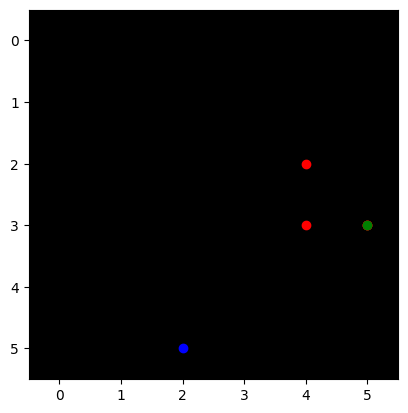

[-0.23116343, -0.22278777, -0.22407947, -0.21077564]
 gamma 0.8
[0, 0, 0, -1]
[-0.23116343, -0.22278777, -0.22407947, -0.21077564]
return [-0.17823021411895754, -0.17926357984542848, -0.16862051486968996, -1.0]
gae [0.05293321311473845, 0.043524187803268416, 0.055458959937095625, -0.7892243564128876]
0.7018667957611652
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 5.,  2.,  4., -2.]])
tensor([[ 5.,  2.,  4., -2.]])


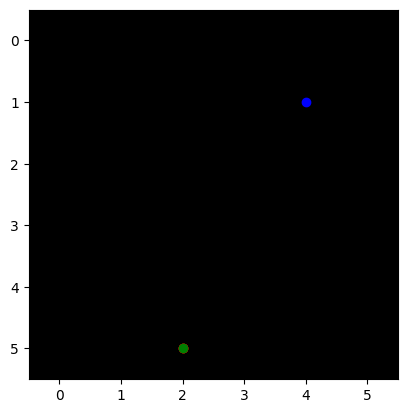

[-0.22700784, -0.21496134]
 gamma 0.8
[0, -1]
[-0.22700784, -0.21496134]
return [-0.17196906805038453, -1.0]
gae [0.0550387680530548, -0.7850386649370193]
0.19341698916607653
tensor([[ 3.,  0.,  3., -2.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[3., 2., 3., 0.]])
tensor([[2., 2., 2., 0.]])
tensor([[3., 2., 3., 0.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 1.,  1.,  1., -1.]])
tensor([[ 1.,  1.,  1., -1.]])
tensor([[ 2.,  1.,  2., -1.]])
tensor([[ 2.,  0.,  2., -2.]])
tensor([[ 1.,  0.,  1., -2.]])


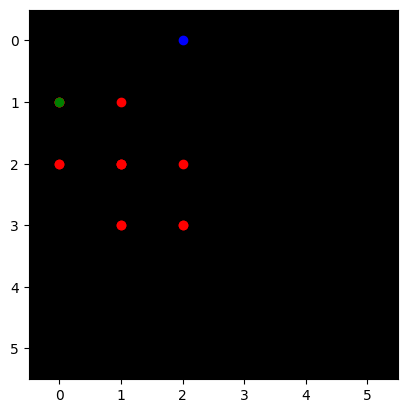

[-0.23268974, -0.23086026, -0.24348156, -0.24660455, -0.24348156, -0.23086026, -0.24110124, -0.23941575, -0.24110124, -0.24270126, -0.24110124, -0.23941575, -0.24652913]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.23268974, -0.23086026, -0.24348156, -0.24660455, -0.24348156, -0.23086026, -0.24110124, -0.23941575, -0.24110124, -0.24270126, -0.24110124, -0.23941575, -0.24652913]
return [-0.18468821048736572, -0.19478524923324586, -0.19728363752365113, -0.19478524923324586, -0.18468821048736572, -0.19288098812103271, -0.1915325999259949, -0.19288098812103271, -0.1941610097885132, -0.19288098812103271, -0.1915325999259949, -0.19722330570220947, -1.0]
gae [0.04800152778625488, 0.03607501387596129, 0.04619792401790618, 0.05181929767131804, 0.05879335105419159, 0.03797927498817444, 0.049568635225296004, 0.046534761786460876, 0.0469402253627777, 0.049820274114608765, 0.049568635225296004, 0.04219244420528412, -0.7534708678722382]
0.3225419892003114
tensor([[ 1.,  0.,  1., -1.]])


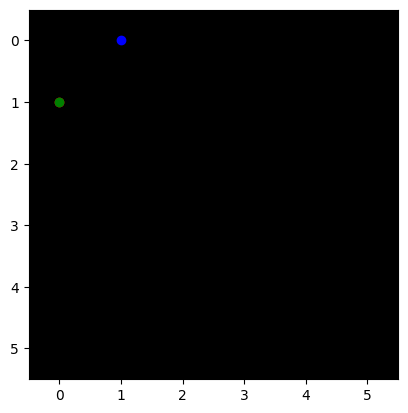

[-0.24981764]
 gamma 0.8
[-1]
[-0.24981764]
return [-1.0]
gae [-0.7501823604106903]
0.010520976948469873
tensor([[5., 3., 5., 1.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 4., 4., 2.]])
tensor([[4., 5., 4., 3.]])
tensor([[5., 5., 5., 3.]])


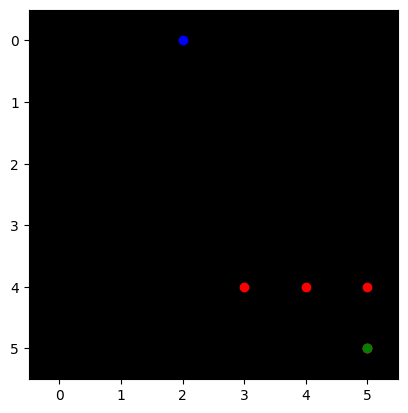

[-0.20951672, -0.20797262, -0.21787854, -0.21289349, -0.2233375]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.20951672, -0.20797262, -0.21787854, -0.21289349, -0.2233375]
return [-0.16637809276580812, -0.17430282831192018, -0.17031478881835938, -0.17867000102996827, -1.0]
gae [0.04313862621784209, 0.033669787645339955, 0.04756374657154083, 0.034223484992980946, -0.7766624987125397]
0.9418871217287869
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  0., -1., -4.]])
tensor([[ 2.,  0., -1., -4.]])
tensor([[ 3.,  0.,  0., -4.]])
tensor([[ 3.,  0.,  0., -4.]])
tensor([[ 4.,  0.,  1., -4.]])
tensor([[ 4.,  0.,  1., -4.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  2.,  1., -2.]])
tensor([[ 4.,  2.,  1., -2.]])
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  1.,  2., -3.]])
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  2.,  2., -2.]])
tensor([[ 5.,  3.,  2., -1.]])
tensor([[ 4.,  3.,  1., -1.]])
tensor([[ 4.,  3.,  

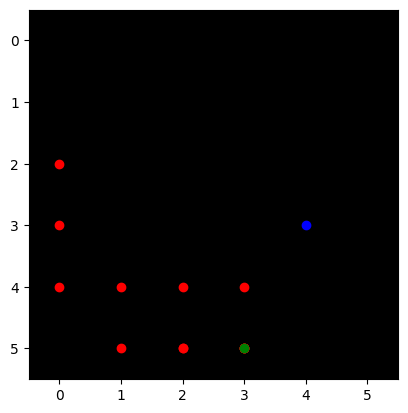

[-0.24180076, -0.24375238, -0.24067894, -0.23083933, -0.23058821, -0.23287128, -0.22416413, -0.22843854, -0.22416413, -0.19994368, -0.23611596, -0.19994368]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.24180076, -0.24375238, -0.24067894, -0.23083933, -0.23058821, -0.23287128, -0.22416413, -0.22843854, -0.22416413, -0.19994368, -0.23611596, -0.19994368]
return [-0.19500190019607544, -0.1925431489944458, -0.18467146158218384, -0.18447057008743287, -0.18629702329635622, -0.17933130264282227, -0.1827508330345154, -0.17933130264282227, -0.1599549412727356, -0.18889276981353761, -0.1599549412727356, -1.0]
gae [0.04679885506629944, 0.0512092262506485, 0.05600747466087341, 0.04636875689029693, 0.04429118931293485, 0.053539976477622986, 0.04141329526901244, 0.04910723865032196, 0.06420918703079223, 0.01105090677738188, 0.0761610209941864, -0.8000563234090805]
return [-0.17867    -0.17823021 -0.17612469 -0.17430283 -0.17196907 -0.17031479
 -0.16862051 -0.1663781  -0.15995494 -0.15995494]

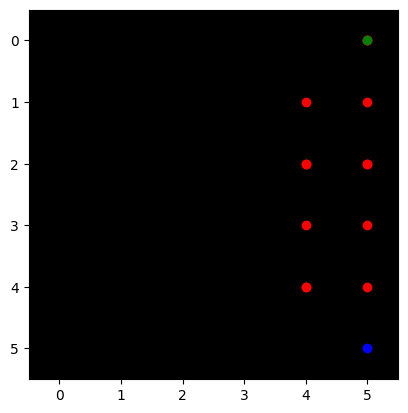

[-0.19356646, -0.19066338, -0.18786997, -0.19066338, -0.16968085, -0.18634608, -0.17408668, -0.15916516, -0.1512618, -0.15916516, -0.17408668, -0.16124587, -0.15680917]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.19356646, -0.19066338, -0.18786997, -0.19066338, -0.16968085, -0.18634608, -0.17408668, -0.15916516, -0.1512618, -0.15916516, -0.17408668, -0.16124587, -0.15680917]
return [-0.1525307059288025, -0.15029597282409668, -0.1525307059288025, -0.13574467897415163, -0.14907686710357668, -0.13926934003829958, -0.1273321270942688, -0.12100944519042969, -0.1273321270942688, -0.13926934003829958, -0.12899669408798217, -0.1254473328590393, -1.0]
gae [0.041035750508308405, 0.04036740958690643, 0.035339260101318354, 0.054918703436851485, 0.020603981614112837, 0.04707674384117125, 0.046754547953605646, 0.038155713677406305, 0.023929679393768305, 0.01989581882953642, 0.04508998095989228, 0.035798534750938416, -0.8431908339262009]
0.37747131584581495
tensor([[5., 4., 3., 3.]])


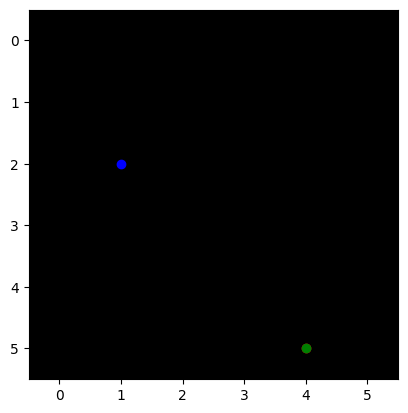

[-0.1838284]
 gamma 0.8
[-1]
[-0.1838284]
return [-1.0]
gae [-0.8161716014146805]
0.20146218311350983
tensor([[ 1.,  3., -3., -2.]])
tensor([[ 2.,  3., -2., -2.]])
tensor([[ 2.,  4., -2., -1.]])
tensor([[ 1.,  4., -3., -1.]])
tensor([[ 1.,  5., -3.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])
tensor([[ 0.,  5., -4.,  0.]])


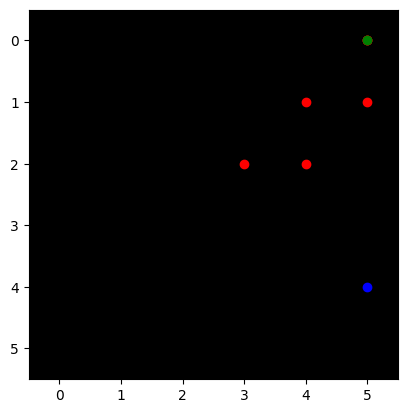

[-0.13374704, -0.13430697, -0.15814692, -0.14966308, -0.16324423, -0.15688853]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.13374704, -0.13430697, -0.15814692, -0.14966308, -0.16324423, -0.15688853]
return [-0.1074455738067627, -0.12651753425598145, -0.11973046064376831, -0.1305953860282898, -0.12551082372665406, -1.0]
gae [0.02630146741867065, 0.007789433002471924, 0.03841645717620849, 0.019067689776420593, 0.03773340880870818, -0.8431114703416824]
0.6781693878791767
tensor([[3., 2., 0., 2.]])
tensor([[3., 1., 0., 1.]])
tensor([[3., 1., 0., 1.]])
tensor([[ 2.,  1., -1.,  1.]])
tensor([[ 2.,  0., -1.,  0.]])
tensor([[ 2.,  0., -1.,  0.]])


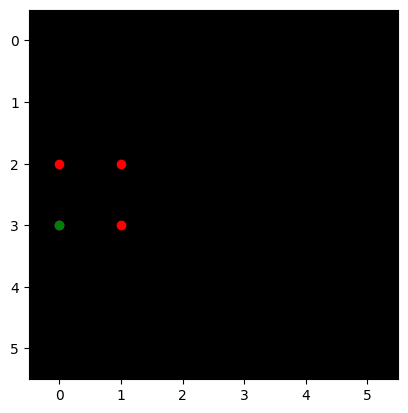

[-0.19227707, -0.19873695, -0.16181248, -0.13671131]
 gamma 0.8
[0, 0, 0, 1]
[-0.19227707, -0.19873695, -0.16181248, -0.13671131]
return [-0.15898956060409547, -0.12944998741149902, -0.10936905145645143, 1.0]
gae [0.03328751325607299, 0.0692869633436203, 0.05244343280792235, 1.1367113143205643]
0.7468707762614306
tensor([[2., 2., 1., 1.]])
tensor([[2., 2., 1., 1.]])
tensor([[2., 1., 1., 0.]])


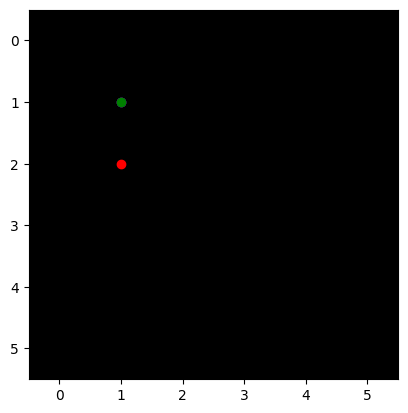

[-0.18012165, -0.13316263]
 gamma 0.8
[0, 1]
[-0.18012165, -0.13316263]
return [-0.10653010606765748, 1.0]
gae [0.07359153926372528, 1.1331626325845718]
0.9109363102407567
tensor([[ 4.,  1.,  3., -3.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 4.,  2.,  3., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  3.,  2., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  1., -1.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  1.,  2., -3.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 3.,  2.,  2., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  2.,  1., -2.]])
tensor([[ 2.,  1.,  1., -3.]])
tensor([[ 2.,  1.,  1.

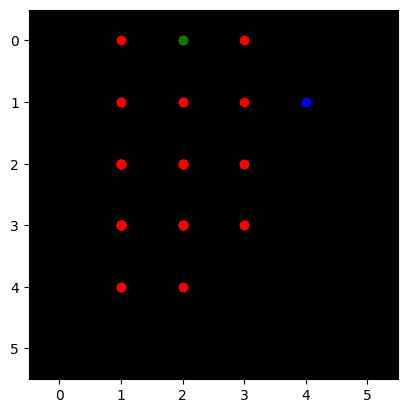

[-0.12675348, -0.1332739, -0.12683183, -0.15415512, -0.1496585, -0.107381694, -0.12683183, -0.15415512, -0.1496585, -0.107381694, -0.12721899, -0.12778288, -0.12683183, -0.107381694, -0.12721899, -0.12778288, -0.12675348, -0.12778288, -0.12683183, -0.12778288, -0.12675348, -0.12778288, -0.12721899, -0.107381694, -0.12721899, -0.12778288, -0.12721899, -0.12778288, -0.12683183, -0.12778288, -0.12721899, -0.11169901, -0.13178481, -0.11169901, -0.12817672, -0.107381694, -0.12817672, -0.14800383, -0.14535123, -0.1258568]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12675348, -0.1332739, -0.12683183, -0.15415512, -0.1496585, -0.107381694, -0.12683183, -0.15415512, -0.1496585, -0.107381694, -0.12721899, -0.12778288, -0.12683183, -0.107381694, -0.12721899, -0.12778288, -0.12675348, -0.12778288, -0.12683183, -0.12778288, -0.12675348, -0.12778288, -0.12721899, -0.107381694, -0.12721899, -0.12778288, -0.12

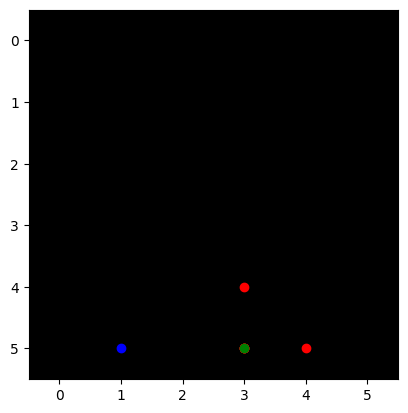

[-0.18098415, -0.1854311, -0.194403, -0.18082471, -0.194403]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.18098415, -0.1854311, -0.194403, -0.18082471, -0.194403]
return [-0.14834487438201904, -0.15552239418029787, -0.1446597695350647, -0.15552239418029787, -1.0]
gae [0.032639279961586, 0.029908698797225935, 0.049743223190307606, 0.025302317738533003, -0.8055970072746277]
0.5074715785167498
tensor([[ 0.,  5., -3.,  1.]])
tensor([[ 0.,  5., -3.,  1.]])


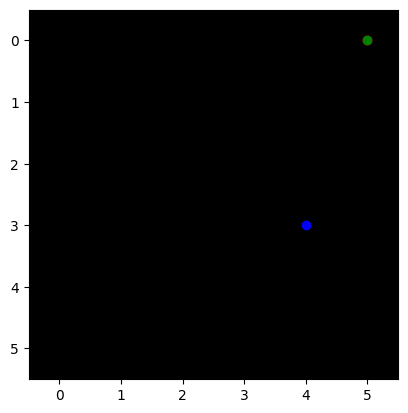

[-0.198109]
 gamma 0.8
[-1]
[-0.198109]
return [-1.0]
gae [-0.8018909990787506]
0.9940373036325933
tensor([[5., 5., 2., 0.]])
tensor([[5., 5., 2., 0.]])
tensor([[ 5.,  4.,  2., -1.]])
tensor([[ 5.,  4.,  2., -1.]])
tensor([[ 5.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  2., -2.]])


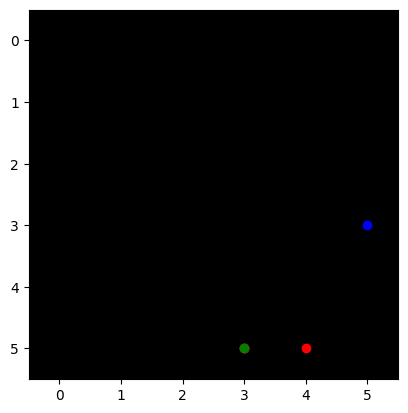

[-0.21181601, -0.22075006, -0.22509888]
 gamma 0.8
[0, 0, -1]
[-0.21181601, -0.22075006, -0.22509888]
return [-0.1766000509262085, -0.18007910251617432, -1.0]
gae [0.035215961933135975, 0.040670961141586304, -0.7749011218547821]
0.03365942961266033
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 4.,  1.,  4., -1.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[ 4.,  1.,  4., -1.]])
tensor([[4., 2., 4., 0.]])
tensor([[5., 2., 5., 0.]])
tensor([[4., 2., 4., 0.]])
tensor([[4., 3., 4., 1.]])
tensor([[4., 2., 4., 0.]])
tensor([[ 4.,  1.,  4., -1.]])
tensor([[ 3.,  1.,  3., -1.]])
tensor([[3., 2., 3., 0.]])
tensor([[3., 3., 3., 1.]])
tensor([[2., 3., 2., 1.]])
tensor([[2., 4., 2., 2.]])
tensor([[2., 5., 2., 3.]])
tensor([[1., 5., 1., 3.]])
tensor([[2., 5., 2., 3.]])


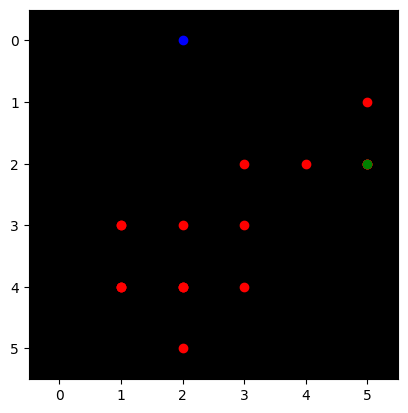

[-0.25575536, -0.22943589, -0.25575536, -0.22943589, -0.22287615, -0.22205165, -0.22287615, -0.21273372, -0.22287615, -0.22943589, -0.25575536, -0.22114168, -0.20444022, -0.19248687, -0.18951921, -0.18815678, -0.18656126, -0.18815678]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.25575536, -0.22943589, -0.25575536, -0.22943589, -0.22287615, -0.22205165, -0.22287615, -0.21273372, -0.22287615, -0.22943589, -0.25575536, -0.22114168, -0.20444022, -0.19248687, -0.18951921, -0.18815678, -0.18656126, -0.18815678]
return [-0.18354871273040774, -0.20460429191589358, -0.18354871273040774, -0.1783009171485901, -0.17764132022857668, -0.1783009171485901, -0.17018697261810303, -0.1783009171485901, -0.18354871273040774, -0.20460429191589358, -0.17691334486007693, -0.16355217695236207, -0.1539894938468933, -0.1516153693199158, -0.15052542686462403, -0.149249005317688, -0.15052542686462403, -1.0]
gae [0.0722066521644592, 0.024831598997116067, 0.0722066521644592, 0.0511349737644

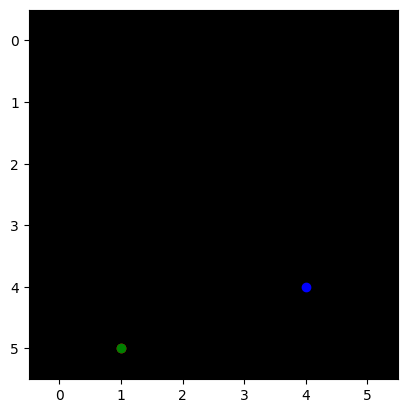

[-0.32046404]
 gamma 0.8
[-1]
[-0.32046404]
return [-1.0]
gae [-0.6795359551906586]
0.5649962975782546
tensor([[5., 3., 1., 3.]])
tensor([[5., 3., 1., 3.]])
tensor([[5., 2., 1., 2.]])
tensor([[5., 2., 1., 2.]])
tensor([[5., 1., 1., 1.]])
tensor([[5., 1., 1., 1.]])


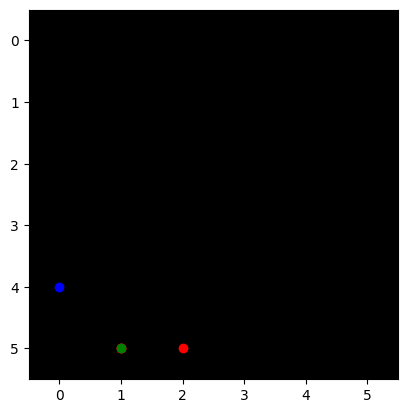

[-0.18722722, -0.20146613, -0.23142761]
 gamma 0.8
[0, 0, -1]
[-0.18722722, -0.20146613, -0.23142761]
return [-0.16117290258407593, -0.18514208793640138, -1.0]
gae [0.02605431675910949, 0.016324040293693526, -0.7685723900794983]
0.20596824543257775
tensor([[ 3.,  1., -2.,  1.]])
tensor([[ 3.,  1., -2.,  1.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 1.,  2., -4.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 3.,  1., -2.,  1.]])
tensor([[ 2.,  1., -3.,  1.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 4.,  2., -1.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 3.,  2., -2.,  2.]])
tensor([[ 2.,  2., -3.,  2.]])
tensor([[ 2.,  3., -3.,  3.]])
tensor([[ 3.,  3., -2.,  3.]])
tensor([[ 3.,  3., -2.,  3.]])
tensor(

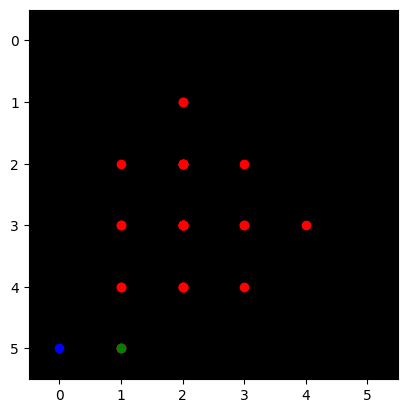

[-0.2527878, -0.18676959, -0.19659598, -0.22062436, -0.19659598, -0.22062436, -0.19659598, -0.18676959, -0.2527878, -0.25880972, -0.19659598, -0.18676959, -0.1877484, -0.18676959, -0.19659598, -0.18225084, -0.17954183, -0.1753015, -0.17954183, -0.18676959, -0.1877484, -0.18082672, -0.1877484, -0.22776441, -0.2527878, -0.22776441, -0.22560729]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.2527878, -0.18676959, -0.19659598, -0.22062436, -0.19659598, -0.22062436, -0.19659598, -0.18676959, -0.2527878, -0.25880972, -0.19659598, -0.18676959, -0.1877484, -0.18676959, -0.19659598, -0.18225084, -0.17954183, -0.1753015, -0.17954183, -0.18676959, -0.1877484, -0.18082672, -0.1877484, -0.22776441, -0.2527878, -0.22776441, -0.22560729]
return [-0.14941567182540894, -0.15727678537368775, -0.17649948596954346, -0.15727678537368775, -0.17649948596954346, -0.15727678537368775, -0.14941567182540894, -0.20223023891448977, -0.20704777240753175, -0.1572767

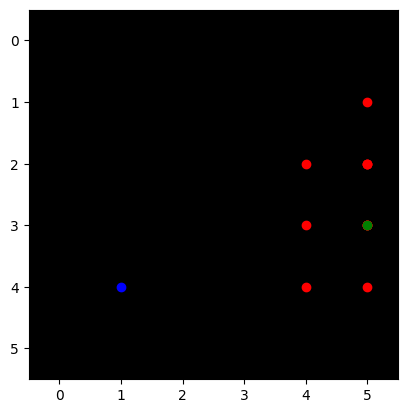

[-0.12785296, -0.1268609, -0.12634933, -0.10770681, -0.10956944, -0.1036718, -0.10958307, -0.1036718, -0.10990559, -0.1036718, -0.10958307]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12785296, -0.1268609, -0.12634933, -0.10770681, -0.10956944, -0.1036718, -0.10958307, -0.1036718, -0.10990559, -0.1036718, -0.10958307]
return [-0.10148872137069703, -0.10107946395874023, -0.08616544604301453, -0.08765555024147034, -0.0829374372959137, -0.08766645789146424, -0.0829374372959137, -0.08792447447776795, -0.0829374372959137, -0.08766645789146424, -1.0]
gae [0.026364240050315846, 0.025781437754631042, 0.040183883905410764, 0.020051257312297815, 0.026632000505924222, 0.01600533872842788, 0.026645635068416593, 0.015747322142124168, 0.02696815580129623, 0.01600533872842788, -0.8904169276356697]
0.39463886068660425
tensor([[ 4.,  0.,  4., -3.]])


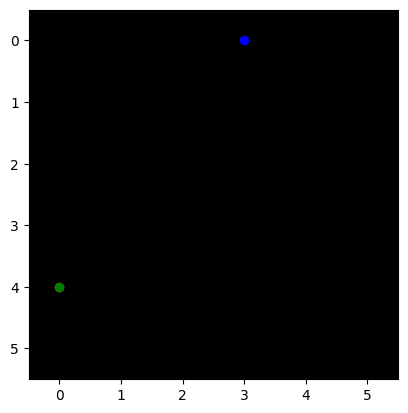

[-0.022612724]
 gamma 0.8
[-1]
[-0.022612724]
return [-1.0]
gae [-0.9773872755467892]
0.5587565347008493
tensor([[ 5.,  0.,  2., -2.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 4.,  0.,  1., -2.]])
tensor([[ 3.,  0.,  0., -2.]])
tensor([[ 3.,  0.,  0., -2.]])
tensor([[ 3.,  1.,  0., -1.]])
tensor([[ 3.,  1.,  0., -1.]])


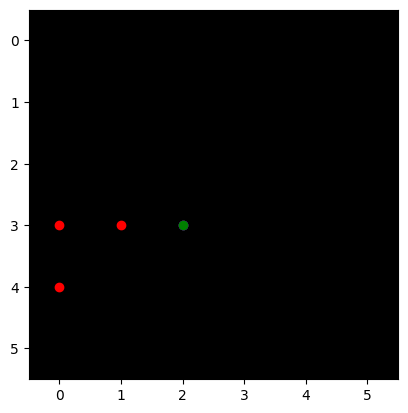

[-0.03492198, -0.014374548, -0.015158364, -0.017686289]
 gamma 0.8
[0, 0, 0, 1]
[-0.03492198, -0.014374548, -0.015158364, -0.017686289]
return [-0.011499638110399247, -0.012126690894365312, -0.014149031043052674, 1.0]
gae [0.02342234328389168, 0.002247856743633746, 0.0010093325749039646, 1.0176862888038158]
0.2546562287008327
tensor([[4., 5., 2., 5.]])
tensor([[4., 5., 2., 5.]])
tensor([[3., 5., 1., 5.]])
tensor([[2., 5., 0., 5.]])
tensor([[ 1.,  5., -1.,  5.]])
tensor([[ 0.,  5., -2.,  5.]])
tensor([[ 0.,  5., -2.,  5.]])
tensor([[ 1.,  5., -1.,  5.]])
tensor([[ 0.,  5., -2.,  5.]])
tensor([[ 0.,  4., -2.,  4.]])


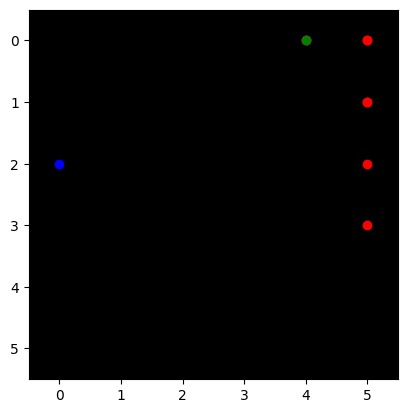

[-0.12902261, -0.12865296, -0.11759702, -0.10668084, -0.10209732, -0.10668084, -0.10209732, -0.13346097]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.12902261, -0.12865296, -0.11759702, -0.10668084, -0.10209732, -0.10668084, -0.10209732, -0.13346097]
return [-0.10292236804962158, -0.09407761693000793, -0.08534467220306396, -0.08167785406112671, -0.08534467220306396, -0.08167785406112671, -0.10676877498626709, -1.0]
gae [0.02610024511814117, 0.03457534313201904, 0.03225234895944595, 0.025002986192703247, 0.01675264537334442, 0.025002986192703247, -0.004671457409858706, -0.8665390312671661]
0.9955218393140636
tensor([[ 0.,  1., -1.,  0.]])
tensor([[ 0.,  1., -1.,  0.]])


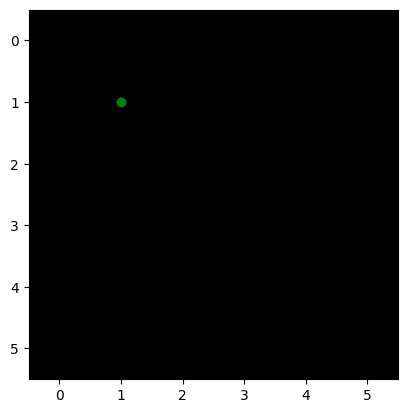

[-0.017805818]
 gamma 0.8
[1]
[-0.017805818]
return [1.0]
gae [1.0178058184683323]
0.4729436672408095
tensor([[ 5.,  3.,  4., -1.]])
tensor([[ 5.,  3.,  4., -1.]])
tensor([[5., 4., 4., 0.]])


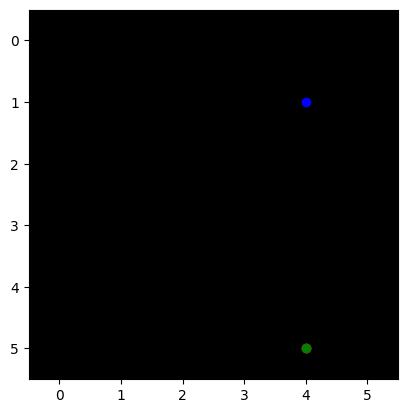

[-0.11113485, -0.15341388]
 gamma 0.8
[0, -1]
[-0.11113485, -0.15341388]
return [-0.12273110151290895, -1.0]
gae [-0.011596252024173748, -0.8465861231088638]
0.18036457200255362
tensor([[ 2.,  1., -1.,  0.]])
tensor([[ 1.,  1., -2.,  0.]])
tensor([[ 1.,  2., -2.,  1.]])
tensor([[ 2.,  2., -1.,  1.]])
tensor([[ 1.,  2., -2.,  1.]])
tensor([[ 1.,  1., -2.,  0.]])
tensor([[ 0.,  1., -3.,  0.]])
tensor([[ 0.,  0., -3., -1.]])


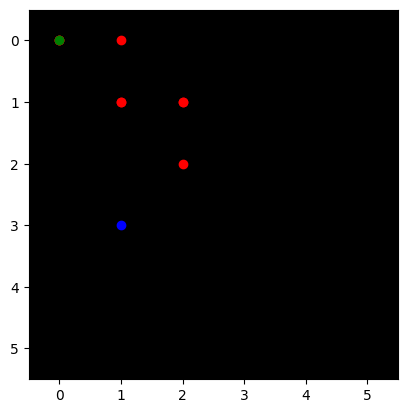

[-0.011834688, -0.008983593, -0.008482752, -0.011098324, -0.008482752, -0.008983593, -0.000734724, -0.0135071855]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.011834688, -0.008983593, -0.008482752, -0.011098324, -0.008482752, -0.008983593, -0.000734724, -0.0135071855]
return [-0.007186874747276306, -0.006786201894283295, -0.008878659456968307, -0.006786201894283295, -0.007186874747276306, -0.0005877791903913022, -0.010805748403072357, -1.0]
gae [0.004647812806069851, 0.0021973915398120873, -0.00039590708911418915, 0.004312122426927089, 0.0012958776205778122, 0.008395814243704081, -0.01007102441508323, -0.9864928144961596]
0.8724119195708397
tensor([[4., 4., 2., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[4., 4., 2., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[5., 4., 3., 2.]])
tensor([[4., 4., 2., 2.]])
tens

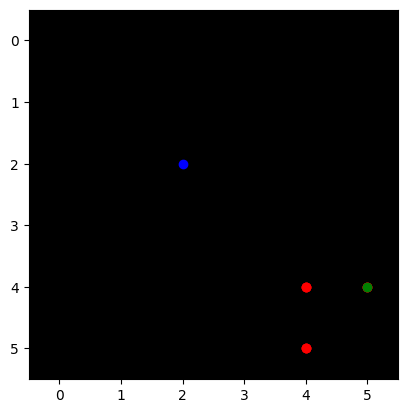

[-0.1383157, -0.1504409, -0.1383157, -0.1504409, -0.1383157, -0.1504409, -0.1383157, -0.12779936]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.1383157, -0.1504409, -0.1383157, -0.1504409, -0.1383157, -0.1504409, -0.1383157, -0.12779936]
return [-0.12035272121429444, -0.11065256595611572, -0.12035272121429444, -0.11065256595611572, -0.12035272121429444, -0.11065256595611572, -0.10223948955535889, -1.0]
gae [0.017962986230850214, 0.03978833556175232, 0.017962986230850214, 0.03978833556175232, 0.017962986230850214, 0.03978833556175232, 0.03607621788978577, -0.8722006380558014]
0.6017222254105035
tensor([[ 4.,  2., -1., -2.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 5.,  3.,  0., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 4.,  3., -1., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  3., -2., -1.]])
tensor([[ 3.,  2., -2., -2.]])
t

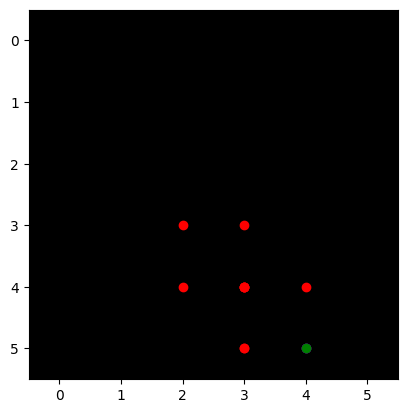

[-0.018114276, -0.030209554, -0.04572598, -0.030209554, -0.04572598, -0.030209554, -0.01564136, -0.016315063, -0.018114276, -0.030209554, -0.1230863]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.018114276, -0.030209554, -0.04572598, -0.030209554, -0.04572598, -0.030209554, -0.01564136, -0.016315063, -0.018114276, -0.030209554, -0.1230863]
return [-0.024167643487453462, -0.03658078312873841, -0.024167643487453462, -0.03658078312873841, -0.024167643487453462, -0.012513087689876558, -0.013052050769329072, -0.01449142098426819, -0.024167643487453462, -0.09846904277801515, 1.0]
gae [-0.0060533672571182265, -0.006371228769421582, 0.021558335423469542, -0.006371228769421582, 0.021558335423469542, 0.017696466669440268, 0.0025893088430166238, 0.0018236424773931496, -0.0060533672571182265, -0.06825948841869832, 1.123086303472519]
return [-1.0805748e-02 -8.8786595e-03 -7.1868747e-03 -7.1868747e-03
 -6.7862021e-03 -6.7862021e-03 -5.8777921e-04  1.0000000e+00
  1.0000000e+00  1.0000000e+00]
ret

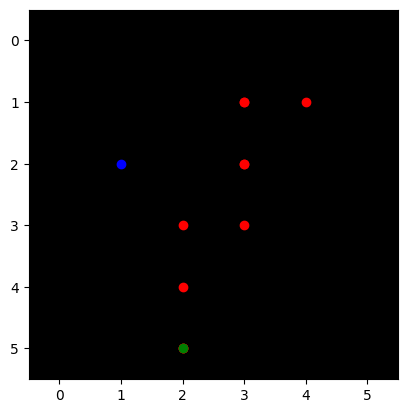

[0.016378824, 0.0636352, 0.05536736, 0.030060627, 0.05536736, 0.0636352, 0.09322201, 0.06378809, 0.14081375, 0.12800963]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.016378824, 0.0636352, 0.05536736, 0.030060627, 0.05536736, 0.0636352, 0.09322201, 0.06378809, 0.14081375, 0.12800963]
return [0.050908160209655766, 0.0442938894033432, 0.024048501253128053, 0.0442938894033432, 0.050908160209655766, 0.07457760572433472, 0.051030474901199344, 0.11265100240707399, 0.102407705783844, -1.0]
gae [0.0345293365418911, -0.0193413108587265, -0.03131886050105095, 0.014233262836933137, -0.004459201544523235, 0.01094240546226502, -0.04219153225421905, 0.04886290878057481, -0.03840604722499846, -1.128009632229805]
0.6294331468472102
tensor([[5., 3., 5., 0.]])
tensor([[5., 3., 5., 0.]])


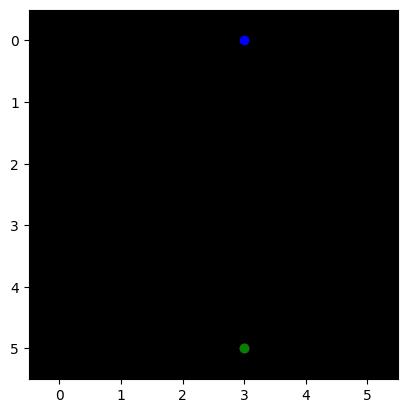

[0.08564519]
 gamma 0.8
[-1]
[0.08564519]
return [-1.0]
gae [-1.0856451913714409]
0.9991154752532436
tensor([[ 0.,  0.,  0., -3.]])
tensor([[ 0.,  0.,  0., -3.]])


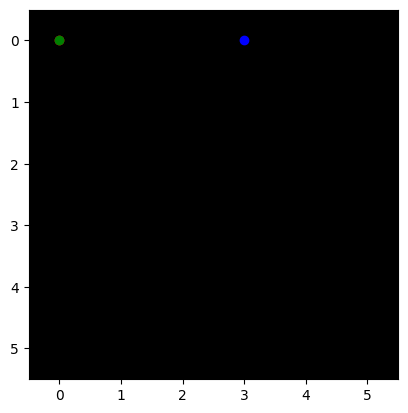

[0.0038306452]
 gamma 0.8
[-1]
[0.0038306452]
return [-1.0]
gae [-1.0038306452333927]
0.2762676976418499
tensor([[ 3.,  4.,  2., -1.]])
tensor([[ 2.,  4.,  1., -1.]])
tensor([[2., 5., 1., 0.]])


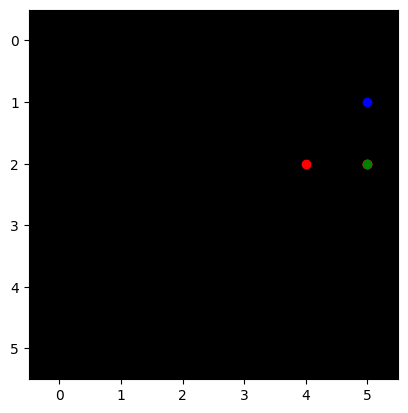

[0.0881738, 0.009919147, 0.020269843]
 gamma 0.8
[0, 0, -1]
[0.0881738, 0.009919147, 0.020269843]
return [0.007935317605733872, 0.016215874254703524, -1.0]
gae [-0.0802384816110134, 0.0062967272475361845, -1.0202698428183794]
0.6580629196997773
tensor([[4., 3., 1., 0.]])
tensor([[4., 3., 1., 0.]])


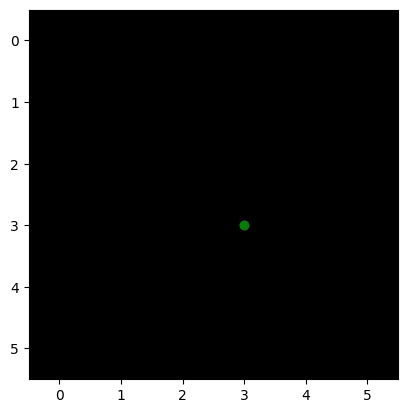

[0.116668455]
 gamma 0.8
[1]
[0.116668455]
return [1.0]
gae [0.8833315446972847]
0.48912095728139016
tensor([[ 3.,  0.,  3., -5.]])


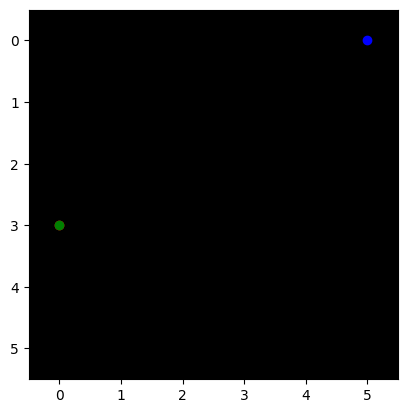

[0.0044137994]
 gamma 0.8
[-1]
[0.0044137994]
return [-1.0]
gae [-1.0044137993827462]
0.6465884079727957
tensor([[5., 0., 2., 0.]])
tensor([[5., 0., 2., 0.]])


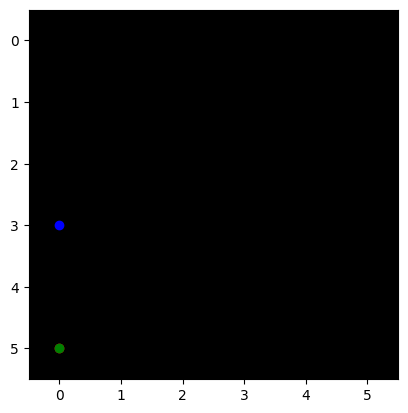

[0.079491094]
 gamma 0.8
[-1]
[0.079491094]
return [-1.0]
gae [-1.0794910937547684]
0.11560157551123063
tensor([[ 0.,  1.,  0., -2.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  0.,  1., -3.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  2.,  1., -1.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 1.,  0.,  1., -3.]])
tensor([[ 1.,  1.,  1., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  1.,  2., -2.]])
tensor([[ 2.,  0.,  2., -3.]])
tensor([[ 3.,  0.,  3., -3.]])
tensor([[ 4.,  0.,  4., -3.]])
tensor([[ 4.,  1.,  4., -2.]])
tensor([[ 3.,  1.,  3., -2.]

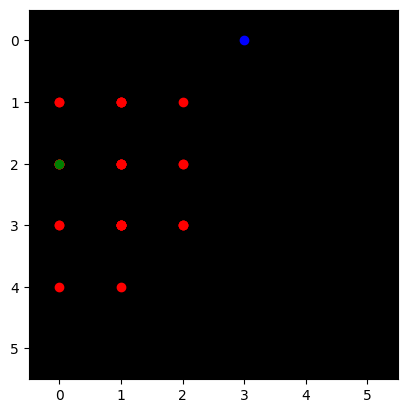

[0.006534677, 0.0056841657, 0.0033895466, 0.0056841657, 0.009464801, 0.0056841657, 0.0033895466, 0.0056841657, 0.0053373887, 0.008544707, 0.057750322, 0.008544707, 0.004525735, 0.008544707, 0.0053373887, 0.008544707, 0.057750322, 0.008544707, 0.057750322, 0.008572726, 0.0053373887, 0.0037771657, 0.004525735, 0.0141132865, 0.07856523, 0.008544707, 0.0053373887, 0.008572726, 0.0053373887, 0.0037771657]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.006534677, 0.0056841657, 0.0033895466, 0.0056841657, 0.009464801, 0.0056841657, 0.0033895466, 0.0056841657, 0.0053373887, 0.008544707, 0.057750322, 0.008544707, 0.004525735, 0.008544707, 0.0053373887, 0.008544707, 0.057750322, 0.008544707, 0.057750322, 0.008572726, 0.0053373887, 0.0037771657, 0.004525735, 0.0141132865, 0.07856523, 0.008544707, 0.0053373887, 0.008572726, 0.0053373887, 0.0037771657]
return [0.004547332599759102, 0.002711637318134308, 0.004547332599759102, 0.0075718410313

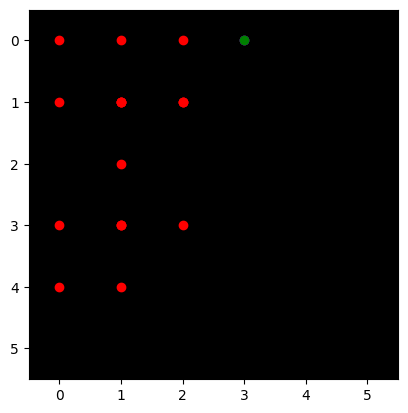

[0.07856523, 0.008544707, 0.004525735, 0.0141132865, 0.07856523, 0.008544707, 0.057750322, 0.008544707, 0.0053373887, 0.0056841657, 0.009464801, 0.0056841657, 0.009464801, 0.0056841657, 0.006534677, 0.0038306452, 0.0033895466, 0.0056841657, 0.009464801, 0.010087744]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.07856523, 0.008544707, 0.004525735, 0.0141132865, 0.07856523, 0.008544707, 0.057750322, 0.008544707, 0.0053373887, 0.0056841657, 0.009464801, 0.0056841657, 0.009464801, 0.0056841657, 0.006534677, 0.0038306452, 0.0033895466, 0.0056841657, 0.009464801, 0.010087744]
return [0.006835765391588211, 0.0036205880343914035, 0.011290629208087922, 0.06285218596458435, 0.006835765391588211, 0.04620025753974915, 0.006835765391588211, 0.004269910976290703, 0.004547332599759102, 0.007571841031312943, 0.004547332599759102, 0.007571841031312943, 0.004547332599759102, 0.0052277415990829475, 0.0030645161867141725, 0.002711637318134308, 0.004547332599759102, 0.007571841

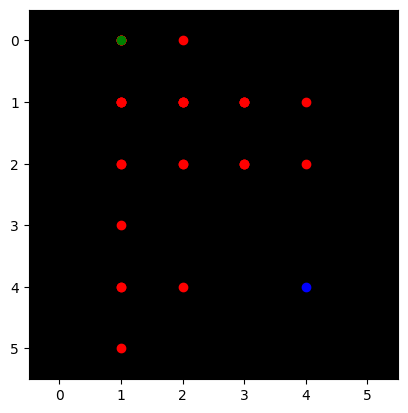

[0.15963063, 0.1549366, 0.15411906, 0.16172068, 0.15411906, 0.16503896, 0.19122197, 0.21128446, 0.2179073, 0.2135283, 0.19347602, 0.2135283, 0.09798251, 0.2135283, 0.2179073, 0.19430088, 0.20078868, 0.21129763, 0.20078868, 0.19430088, 0.2179073, 0.21128446, 0.19347602, 0.09616362, 0.19347602, 0.2135283, 0.2179073, 0.19430088, 0.19122197, 0.19430088, 0.20078868]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.15963063, 0.1549366, 0.15411906, 0.16172068, 0.15411906, 0.16503896, 0.19122197, 0.21128446, 0.2179073, 0.2135283, 0.19347602, 0.2135283, 0.09798251, 0.2135283, 0.2179073, 0.19430088, 0.20078868, 0.21129763, 0.20078868, 0.19430088, 0.2179073, 0.21128446, 0.19347602, 0.09616362, 0.19347602, 0.2135283, 0.2179073, 0.19430088, 0.19122197, 0.19430088, 0.20078868]
return [0.12394927740097046, 0.12329524755477905, 0.1293765425682068, 0.12329524755477905, 0.1320311665534973, 0.15297757387161257, 0.16902756690979004, 0.17432583570

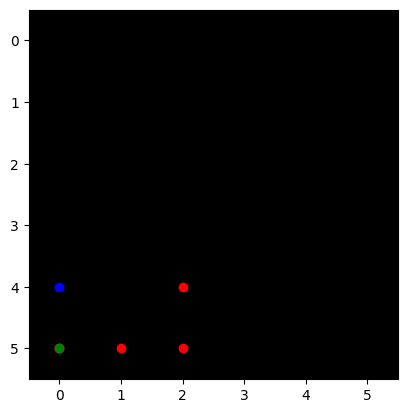

[0.17421502, 0.20500405, 0.17421502, 0.17188074, 0.18239757]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.17421502, 0.20500405, 0.17421502, 0.17188074, 0.18239757]
return [0.16400324106216432, 0.13937201499938964, 0.13750458955764772, 0.14591805934906008, -1.0]
gae [-0.010211777687072737, -0.06563203632831574, -0.036710429191589344, -0.025962677597999556, -1.182397574186325]
0.3494572142022657
tensor([[ 0.,  3., -5.,  2.]])
tensor([[ 0.,  2., -5.,  1.]])
tensor([[ 0.,  2., -5.,  1.]])
tensor([[ 0.,  3., -5.,  2.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 1.,  2., -4.,  1.]])
tensor([[ 1.,  3., -4.,  2.]])
tensor([[ 0.,  3., -5.,  2.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  5., -5.,  4.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 1.,  4., -4.,  3.]])
tensor([[ 1.,  4., -4.,  3.]])
tensor([[ 1.,  5., -4.,  4.]])
tensor([[ 0.,  5., -5.,  4.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  4., -5.,  3.]])
tensor([[ 0.,  5., -5.,  4.]

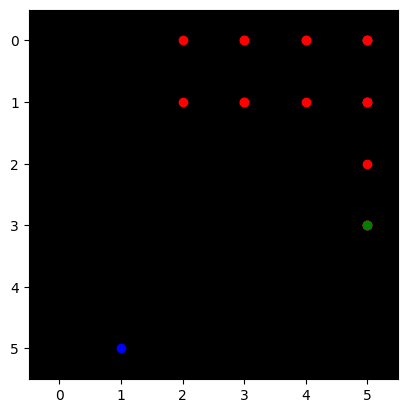

[0.1354697, 0.20768087, 0.1354697, 0.11490626, 0.20788129, 0.11490626, 0.1354697, 0.109713815, 0.13296878, 0.16964662, 0.13168886, 0.16964662, 0.13296878, 0.109713815, 0.13296878, 0.16964662, 0.21894011, 0.20688541]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.1354697, 0.20768087, 0.1354697, 0.11490626, 0.20788129, 0.11490626, 0.1354697, 0.109713815, 0.13296878, 0.16964662, 0.13168886, 0.16964662, 0.13296878, 0.109713815, 0.13296878, 0.16964662, 0.21894011, 0.20688541]
return [0.16614469289779665, 0.10837576389312745, 0.09192500710487367, 0.16630502939224245, 0.09192500710487367, 0.10837576389312745, 0.0877710521221161, 0.10637502670288086, 0.1357172966003418, 0.10535109043121338, 0.1357172966003418, 0.10637502670288086, 0.0877710521221161, 0.10637502670288086, 0.1357172966003418, 0.1751520872116089, 0.16550832986831665, -1.0]
gae [0.03067498803138735, -0.09930510222911834, -0.04354469776153563, 0.05139877051115038, -0.11595627963542937, -0.006530494987964625, 

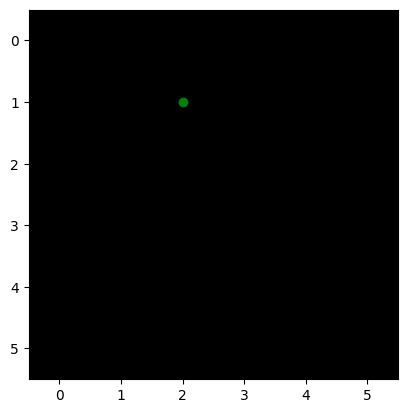

[]
 gamma 0.8
[]
[]
return []
gae []
0.29196966928061185
tensor([[2., 3., 1., 0.]])
tensor([[2., 3., 1., 0.]])


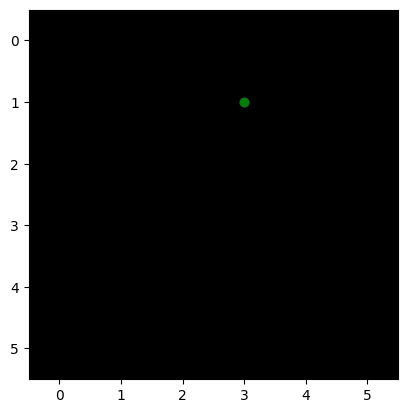

[-0.17753069]
 gamma 0.8
[1]
[-0.17753069]
return [1.0]
gae [1.1775306910276413]
0.7421991305487486
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 2.,  3., -1., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  3., -2., -2.]])
tensor([[ 1.,  2., -2., -3.]])
tensor([[ 1.,  2., -2., -3.]])
tensor([[ 0.,  2., -3., -3.]])


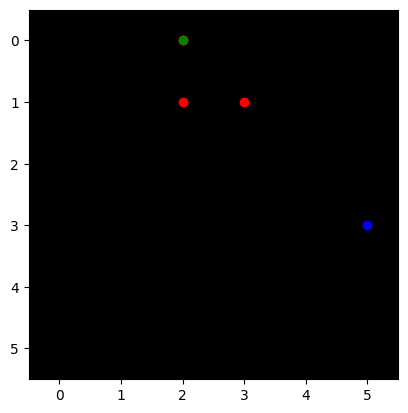

[-0.21632808, -0.16258311, -0.1911657, -0.15452045]
 gamma 0.8
[0, 0, 0, -1]
[-0.21632808, -0.16258311, -0.1911657, -0.15452045]
return [-0.13006649017333985, -0.15293256044387818, -0.123616361618042, -1.0]
gae [0.0862615942955017, 0.009650552272796625, 0.06754933893680572, -0.8454795479774475]
0.41016228187518233
tensor([[4., 1., 2., 1.]])
tensor([[4., 1., 2., 1.]])
tensor([[5., 1., 3., 1.]])
tensor([[5., 2., 3., 2.]])
tensor([[4., 2., 2., 2.]])
tensor([[4., 3., 2., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 2., 2., 2.]])
tensor([[4., 3., 2., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[3., 3., 1., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 5., 2., 5.]])


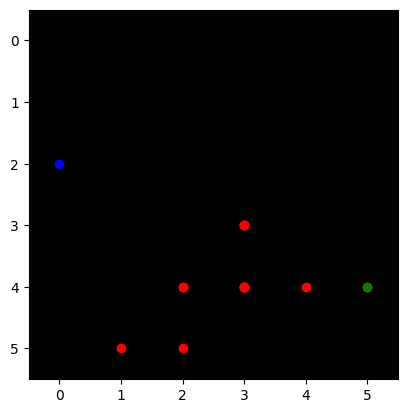

[-0.16703287, -0.17635192, -0.17851627, -0.17855689, -0.1773797, -0.14748296, -0.1773797, -0.17855689, -0.1773797, -0.14748296, -0.1773797, -0.14748296, -0.1773797, -0.16073902, -0.12688775]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.16703287, -0.17635192, -0.17851627, -0.17855689, -0.1773797, -0.14748296, -0.1773797, -0.17855689, -0.1773797, -0.14748296, -0.1773797, -0.14748296, -0.1773797, -0.16073902, -0.12688775]
return [-0.14108153581619262, -0.14281301498413088, -0.1428455114364624, -0.14190375804901123, -0.11798636913299561, -0.14190375804901123, -0.1428455114364624, -0.14190375804901123, -0.11798636913299561, -0.14190375804901123, -0.11798636913299561, -0.14190375804901123, -0.12859121561050416, -0.10151020288467408, -1.0]
gae [0.025951331853866583, 0.03353890478610991, 0.03567075729370117, 0.03665313124656677, 0.05939332842826843, 0.005579203367233276, 0.034534186124801636, 0.03665313124656677, 0.05939332842826843, 0.005579203367233276, 0.05939332842826843, 

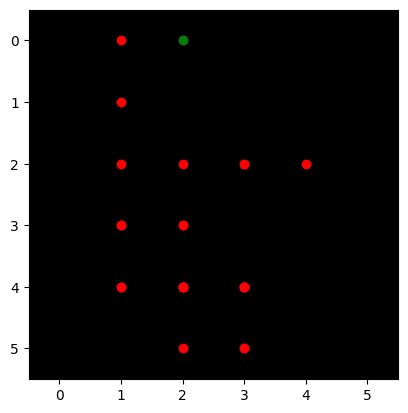

[-0.15358679, -0.17930192, -0.15358679, -0.17930192, -0.15202017, -0.17802751, -0.18201146, -0.18065968, -0.18044138, -0.18065968, -0.18201146, -0.18221968, -0.18044138, -0.18065968, -0.18201146, -0.13114008, -0.10728674, -0.17802751, -0.18201146, -0.18065968, -0.18201146, -0.13114008, -0.10728674, -0.15875919, -0.19111723, -0.18969843]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.15358679, -0.17930192, -0.15358679, -0.17930192, -0.15202017, -0.17802751, -0.18201146, -0.18065968, -0.18044138, -0.18065968, -0.18201146, -0.18221968, -0.18044138, -0.18065968, -0.18201146, -0.13114008, -0.10728674, -0.17802751, -0.18201146, -0.18065968, -0.18201146, -0.13114008, -0.10728674, -0.15875919, -0.19111723, -0.18969843]
return [-0.1434415340423584, -0.12286943197250366, -0.1434415340423584, -0.12161613702774049, -0.1424220085144043, -0.14560916423797607, -0.14452774524688722, -0.14435310363769532, -0.14452774524688722, -0.14560916423797607, -0.1457

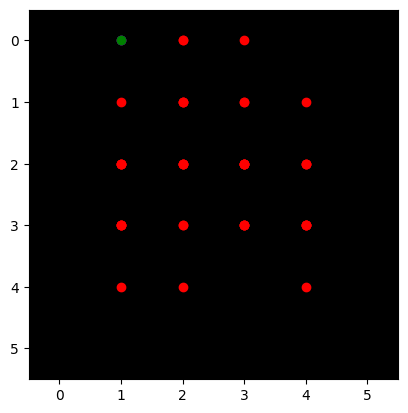

[-0.17216437, -0.14231662, -0.17341219, -0.14231662, -0.17216437, -0.17924756, -0.17341219, -0.1787397, -0.17341219, -0.17924756, -0.17216437, -0.17656635, -0.16689746, -0.1322809, -0.11801168, -0.1386038, -0.17216437, -0.17656635, -0.13227944, -0.114234254, -0.18071918, -0.114234254, -0.13227944, -0.114234254, -0.13227944, -0.114234254, -0.169671, -0.1811182, -0.18071918, -0.17924756, -0.17216437, -0.17656635, -0.16689746, -0.16669236, -0.13227944, -0.17656635, -0.17216437, -0.17924756, -0.17341219, -0.14231662, -0.108103864, -0.1386038, -0.16689746, -0.1322809]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[-0.17216437, -0.14231662, -0.17341219, -0.14231662, -0.17216437, -0.17924756, -0.17341219, -0.1787397, -0.17341219, -0.17924756, -0.17216437, -0.17656635, -0.16689746, -0.1322809, -0.11801168, -0.1386038, -0.17216437, -0.17656635, -0.13227944, -0.114234254, -0.18071918, -0.114234254, 

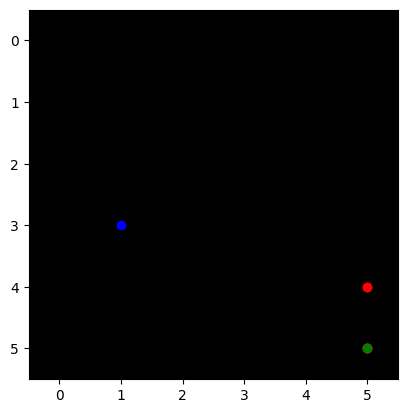

[0.06639724, 0.064288795, 0.062572084, 0.064288795, 0.062572084]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.06639724, 0.064288795, 0.062572084, 0.064288795, 0.062572084]
return [0.051431035995483404, 0.05005766749382019, 0.051431035995483404, 0.05005766749382019, -1.0]
gae [-0.014966206252574915, -0.014231127500534055, -0.011141048371791834, -0.014231127500534055, -1.0625720843672752]
0.1254463038603879
tensor([[4., 3., 1., 3.]])
tensor([[4., 4., 1., 4.]])
tensor([[5., 4., 2., 4.]])


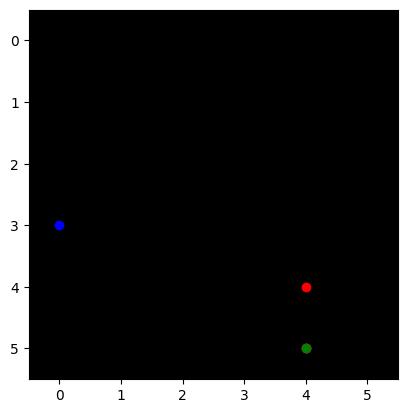

[0.06568009, 0.06567066, 0.06513155]
 gamma 0.8
[0, 0, -1]
[0.06568009, 0.06567066, 0.06513155]
return [0.05253652930259705, 0.052105242013931276, -1.0]
gae [-0.013143557310104366, -0.013565419614315032, -1.065131552517414]
0.03495736098569613
tensor([[ 2.,  1.,  0., -4.]])
tensor([[ 2.,  0.,  0., -5.]])
tensor([[ 3.,  0.,  1., -5.]])
tensor([[ 4.,  0.,  2., -5.]])
tensor([[ 5.,  0.,  3., -5.]])
tensor([[ 4.,  0.,  2., -5.]])


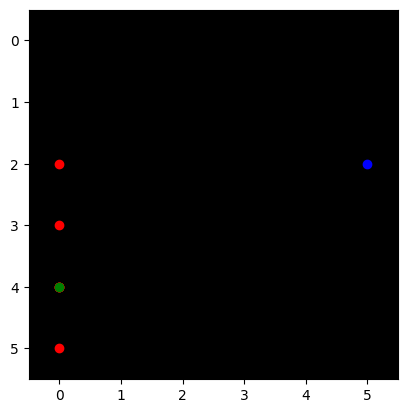

[0.14429788, 0.16733916, 0.14856161, 0.13854839, 0.13107935, 0.13854839]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.14429788, 0.16733916, 0.14856161, 0.13854839, 0.13107935, 0.13854839]
return [0.133871328830719, 0.11884928941726686, 0.11083871126174927, 0.10486347675323487, 0.11083871126174927, -1.0]
gae [-0.010426554083824147, -0.048489871621131886, -0.03772290050983429, -0.03368491232395171, -0.02024063467979431, -1.1385483890771866]
0.4646985429525917
tensor([[ 3.,  3.,  0., -1.]])
tensor([[ 3.,  3.,  0., -1.]])
tensor([[ 3.,  2.,  0., -2.]])
tensor([[ 4.,  2.,  1., -2.]])
tensor([[ 4.,  2.,  1., -2.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  1.,  1., -3.]])
tensor([[ 4.,  0.,  1., -4.]])
tensor([[ 4.,  0.,  1., -4.]])


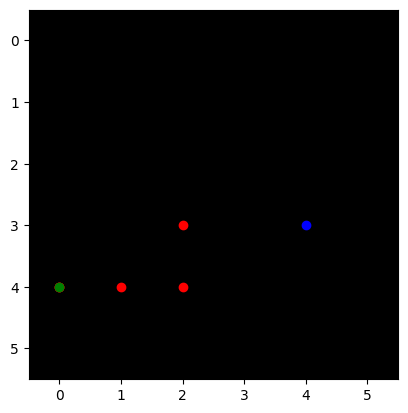

[0.06534283, 0.10707298, 0.07262041, 0.12009972, 0.14387193]
 gamma 0.8
[0, 0, 0, 0, -1]
[0.06534283, 0.10707298, 0.07262041, 0.12009972, 0.14387193]
return [0.08565838336944581, 0.05809632539749146, 0.09607977867126466, 0.11509754657745362, -1.0]
gae [0.02031555473804475, -0.04897665381431579, 0.02345937192440034, -0.005002176761627189, -1.143871933221817]
0.5582073249811536
tensor([[ 4.,  0.,  2., -2.]])
tensor([[ 4.,  0.,  2., -2.]])
tensor([[ 4.,  1.,  2., -1.]])
tensor([[ 4.,  1.,  2., -1.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 5.,  1.,  3., -1.]])
tensor([[ 5.,  0.,  3., -2.]])


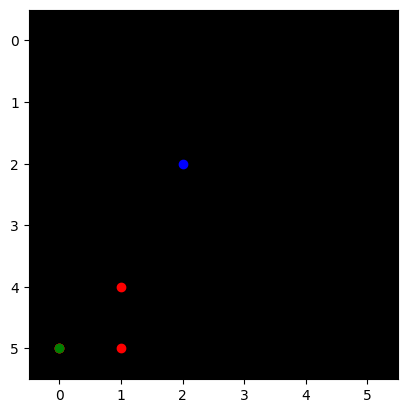

[0.05420471, 0.014432181, 0.004970465, 0.022445783]
 gamma 0.8
[0, 0, 0, -1]
[0.05420471, 0.014432181, 0.004970465, 0.022445783]
return [0.01154574453830719, 0.003976371884346008, 0.017956626415252686, -1.0]
gae [-0.042658965289592746, -0.010455808788537978, 0.012986161559820176, -1.0224457830190659]
0.06920549601817505
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  3.,  4., -2.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  0.,  4., -5.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  0.,  4., -5.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 5.,  1.,  5., -4.]])
tensor([[ 4.,  1.,  4., -4.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  4., -3.]])
tensor([[ 5.,  2.,  5., -3.]])


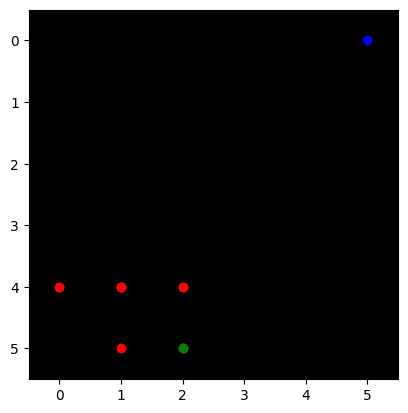

[0.030155014, 0.020494645, 0.063966356, 0.09717676, 0.063966356, 0.09717676, 0.063966356, 0.03444979, 0.063966356, 0.020494645, -0.0033429738]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.030155014, 0.020494645, 0.063966356, 0.09717676, 0.063966356, 0.09717676, 0.063966356, 0.03444979, 0.063966356, 0.020494645, -0.0033429738]
return [0.01639571636915207, 0.05117308497428894, 0.0777414083480835, 0.05117308497428894, 0.0777414083480835, 0.05117308497428894, 0.027559831738471985, 0.05117308497428894, 0.01639571636915207, -0.002674379013478756, -1.0]
gae [-0.013759297877550123, 0.030678439512848855, 0.013775052130222329, -0.04600367546081543, 0.013775052130222329, -0.04600367546081543, -0.03640652447938919, 0.01672329530119896, -0.0475706398487091, -0.023169024474918844, -0.9966570262331516]
0.4570932565069169
tensor([[1., 5., 1., 1.]])
tensor([[1., 4., 1., 0.]])
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 0.,  3.,  0., -1.]])


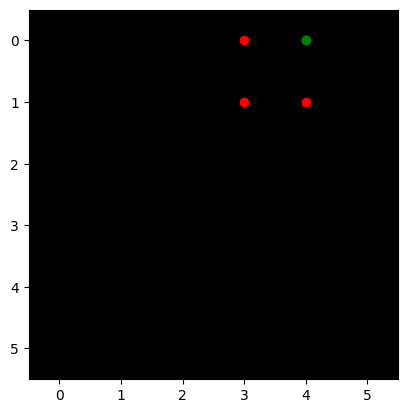

[0.07686819, 0.07514686, 0.022977248, 0.07704026]
 gamma 0.8
[0, 0, 0, 1]
[0.07686819, 0.07514686, 0.022977248, 0.07704026]
return [0.06011748909950257, 0.018381798267364503, 0.06163221001625061, 1.0]
gae [-0.016750702261924738, -0.0567650631070137, 0.038654962182044984, 0.9229597374796867]
0.7850938487763155
tensor([[ 4.,  0.,  0., -1.]])
tensor([[ 4.,  0.,  0., -1.]])
tensor([[ 5.,  0.,  1., -1.]])
tensor([[ 5.,  0.,  1., -1.]])


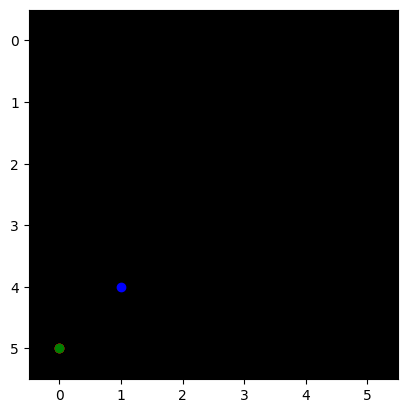

[0.09820496, 0.046922594]
 gamma 0.8
[0, -1]
[0.09820496, 0.046922594]
return [0.03753807544708252, -1.0]
gae [-0.06066688746213913, -1.0469225943088531]
0.555615486935779
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  4., -1.,  2.]])
tensor([[ 4.,  5., -1.,  3.]])
tensor([[ 4.,  5., -1.,  3.]])
tensor([[ 3.,  5., -2.,  3.]])
tensor([[ 3.,  5., -2.,  3.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 2.,  4., -3.,  2.]])
tensor([[ 2.,  4., -3.,  2.]])
tensor([[ 2.,  3., -3.,  1.]])
tensor([[ 3.,  3., -2.,  1.]])
tensor([[ 3.,  4., -2.,  2.]])
tensor([[ 3.,  5., -2.,  3.]])
tensor([[ 3.,  5., -2.,  3.]])


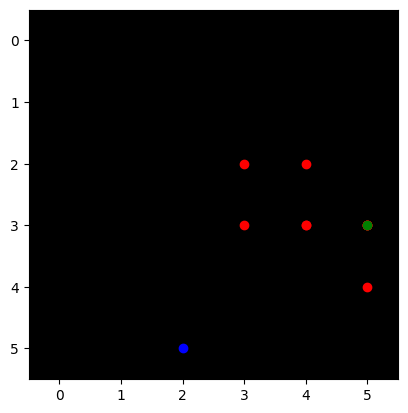

[0.06009822, 0.073049225, 0.07230675, 0.07736956, 0.06816564, 0.06239655, 0.03205979, 0.07736956, 0.07230675]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[0.06009822, 0.073049225, 0.07230675, 0.07736956, 0.06816564, 0.06239655, 0.03205979, 0.07736956, 0.07230675]
return [0.05843937993049622, 0.05784540176391602, 0.061895650625228886, 0.054532510042190556, 0.04991723895072937, 0.025647830963134766, 0.061895650625228886, 0.05784540176391602, -1.0]
gae [-0.001658839732408518, -0.015203823149204251, -0.010411101579666134, -0.022837053239345546, -0.018248398602008817, -0.03674871772527695, 0.02983586192131043, -0.019524161517620084, -1.072306752204895]
0.45238640517762363
tensor([[1., 4., 1., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[3., 4., 3., 3.]])
tensor([[3., 3., 3., 2.]])
tensor([[3., 4., 3., 3.]])
tensor([[3., 5., 3., 4.]])
tensor([[3., 5., 3., 4.]])


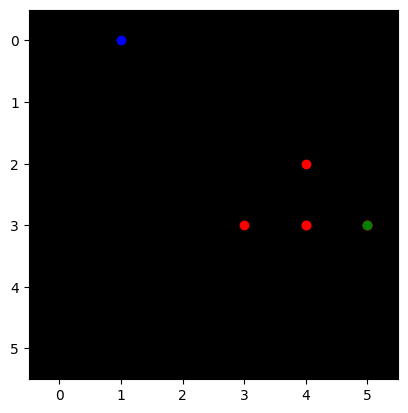

[0.06890261, 0.0662891, 0.066447325, 0.0810236, 0.066447325, 0.06196403]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[0.06890261, 0.0662891, 0.066447325, 0.0810236, 0.066447325, 0.06196403]
return [0.05303127765655518, 0.053157860040664674, 0.06481888294219972, 0.053157860040664674, 0.04957122504711151, -1.0]
gae [-0.01587133407592773, -0.013131237030029295, -0.0016284421086311257, -0.02786574363708496, -0.01687610000371933, -1.0619640313088894]
return [0.07774141 0.08565839 0.09607978 0.10486348 0.11083871 0.11083871
 0.11509755 0.11884929 0.13387133 1.        ]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.00267438]

-------------------- Iteration #88 --------------------
random  0.45238640517762363
Average : 0.01
Average Episodic Return: -0.62
Max Episodic Return: 1.0
Average Loss: 0.00036
Average Loss Critic: 0.22793088853359222
TEntropy: nan
approx_kl_divs: [0.0002834947] secs
----------------------------------------------------

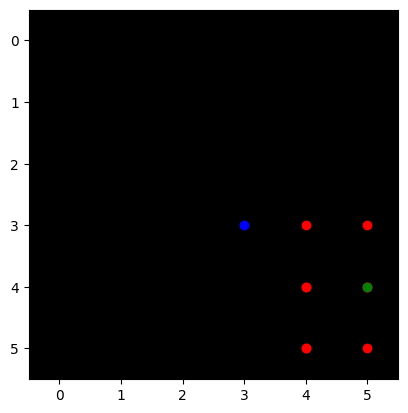

[-0.071132176, -0.13659239, -0.071132176, -0.13808507, -0.071132176, -0.13808507, -0.14464827, -0.14556535, -0.14188369]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.071132176, -0.13659239, -0.071132176, -0.13808507, -0.071132176, -0.13808507, -0.14464827, -0.14556535, -0.14188369]
return [-0.10927391052246094, -0.05690574049949646, -0.11046805381774903, -0.05690574049949646, -0.11046805381774903, -0.11571861505508424, -0.11645227670669556, -0.1135069489479065, -1.0]
gae [-0.03814173489809036, 0.07968664765357972, -0.03933587819337846, 0.08117932677268982, -0.03933587819337846, 0.02236645221710204, 0.02819599211215973, 0.032058396935462946, -0.8581163138151169]
0.5261348236488065
tensor([[ 2.,  5., -3.,  0.]])
tensor([[ 1.,  5., -4.,  0.]])


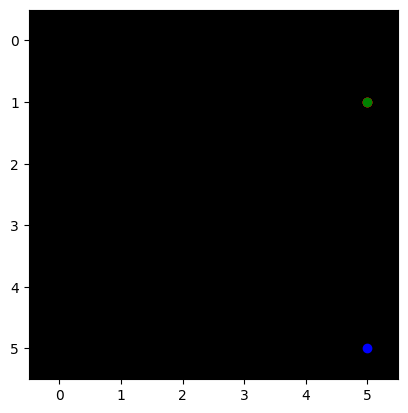

[-0.11558545, -0.1128156]
 gamma 0.8
[0, -1]
[-0.11558545, -0.1128156]
return [-0.09025248289108277, -1.0]
gae [0.02533296346664428, -0.8871843963861465]
0.2349481384805444
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[ 2.,  0.,  0., -1.]])
tensor([[ 3.,  0.,  1., -1.]])
tensor([[3., 1., 1., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[4., 1., 2., 0.]])
tensor([[5., 1., 3., 0.]])
tensor([[5., 1., 3., 0.]])
tensor([[5., 2., 3., 1.]])
tensor([[5., 2., 3., 1.]])


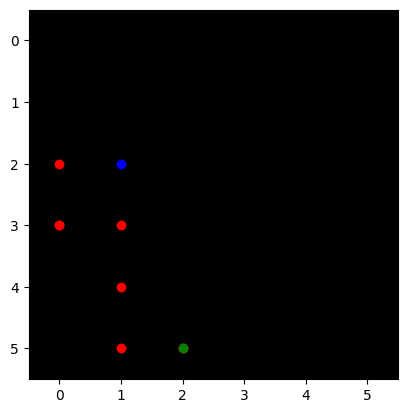

[-0.08831947, -0.08891009, -0.08831947, -0.08891009, -0.08210959, -0.07554456, -0.066643864, -0.07130204]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.08831947, -0.08891009, -0.08831947, -0.08891009, -0.08210959, -0.07554456, -0.066643864, -0.07130204]
return [-0.07112807035446167, -0.07065557837486268, -0.07112807035446167, -0.06568767428398133, -0.060435646772384645, -0.05331509113311768, -0.057041633129119876, -1.0]
gae [0.01719140261411667, 0.018254509568214408, 0.01719140261411667, 0.02322241365909576, 0.02167394608259201, 0.022229467332363126, 0.009602230787277219, -0.9286979585886002]
0.5548981148727616
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 2.,  0.,  1., -4.]])
tensor([[ 3.,  0.,  2., -4.]])


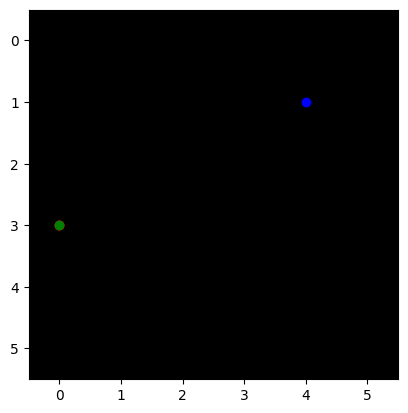

[-0.090412095, -0.087979674]
 gamma 0.8
[0, -1]
[-0.090412095, -0.087979674]
return [-0.07038373947143554, -1.0]
gae [0.020028355717659, -0.9120203256607056]
0.5119162594003234
tensor([[ 0.,  0., -1.,  0.]])


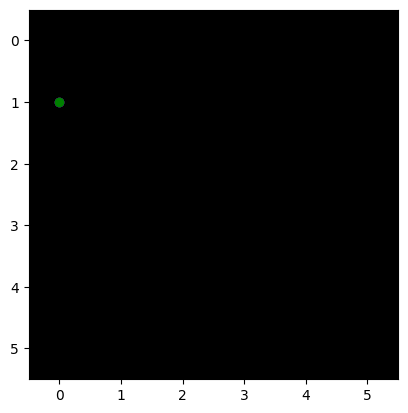

[-0.14216344]
 gamma 0.8
[1]
[-0.14216344]
return [1.0]
gae [1.1421634405851364]
0.5049268119777739
tensor([[5., 4., 2., 4.]])
tensor([[5., 3., 2., 3.]])
tensor([[5., 3., 2., 3.]])


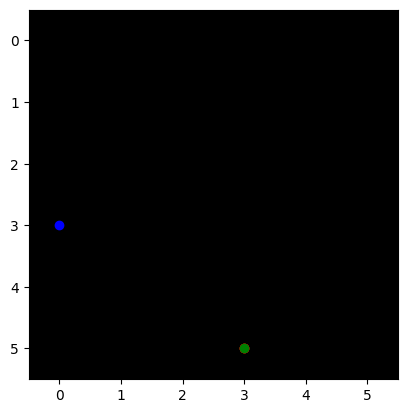

[-0.1391319, -0.10002655]
 gamma 0.8
[0, -1]
[-0.1391319, -0.10002655]
return [-0.08002123832702637, -1.0]
gae [0.05911066532135009, -0.899973452091217]
0.7023259731411254
tensor([[ 1.,  5., -3.,  1.]])
tensor([[ 0.,  5., -4.,  1.]])
tensor([[ 0.,  5., -4.,  1.]])


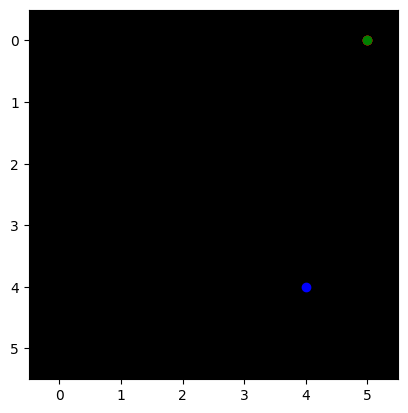

[-0.12567878, -0.12172586]
 gamma 0.8
[0, -1]
[-0.12567878, -0.12172586]
return [-0.09738068580627442, -1.0]
gae [0.02829809188842773, -0.878274142742157]
0.38478843706737187
tensor([[ 1.,  1.,  1., -1.]])
tensor([[ 1.,  1.,  1., -1.]])
tensor([[ 1.,  0.,  1., -2.]])


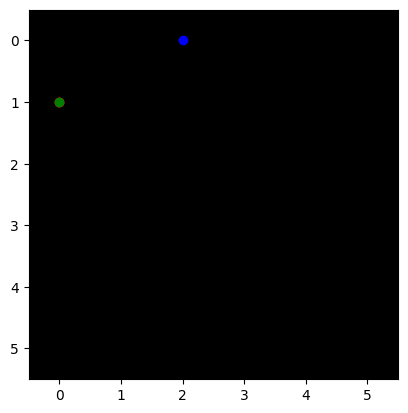

[-0.12120038, -0.11488912]
 gamma 0.8
[0, -1]
[-0.12120038, -0.11488912]
return [-0.09191129803657533, -1.0]
gae [0.029289084672927845, -0.8851108774542809]
0.4743276928002813
tensor([[ 5.,  2.,  0., -2.]])
tensor([[ 5.,  2.,  0., -2.]])


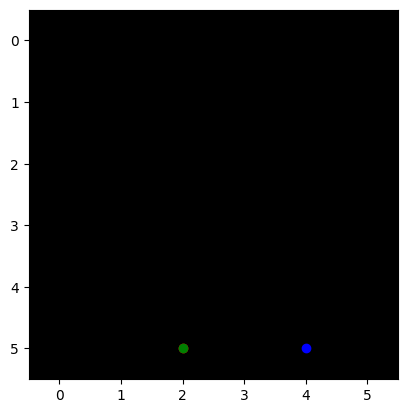

[-0.070307665]
 gamma 0.8
[-1]
[-0.070307665]
return [-1.0]
gae [-0.9296923354268074]
0.5757939976654137
tensor([[ 0.,  2., -2.,  2.]])
tensor([[ 0.,  2., -2.,  2.]])
tensor([[ 1.,  2., -1.,  2.]])
tensor([[ 1.,  2., -1.,  2.]])
tensor([[ 1.,  3., -1.,  3.]])
tensor([[2., 3., 0., 3.]])
tensor([[2., 3., 0., 3.]])
tensor([[2., 4., 0., 4.]])
tensor([[2., 4., 0., 4.]])
tensor([[2., 5., 0., 5.]])
tensor([[2., 5., 0., 5.]])


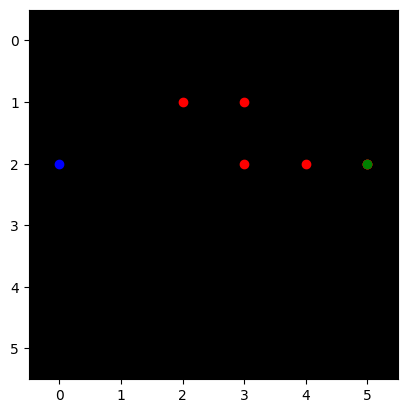

[-0.1376977, -0.12697051, -0.115163915, -0.13993788, -0.15066472, -0.1514018]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.1376977, -0.12697051, -0.115163915, -0.13993788, -0.15066472, -0.1514018]
return [-0.10157641172409058, -0.09213113188743592, -0.11195030212402345, -0.12053177356719971, -0.12112144231796265, -1.0]
gae [0.03612128496170043, 0.0348393827676773, 0.0032136127352714455, 0.019406104087829584, 0.029543274641036982, -0.8485981971025467]
0.1007521071612778
tensor([[ 2.,  0.,  0., -1.]])


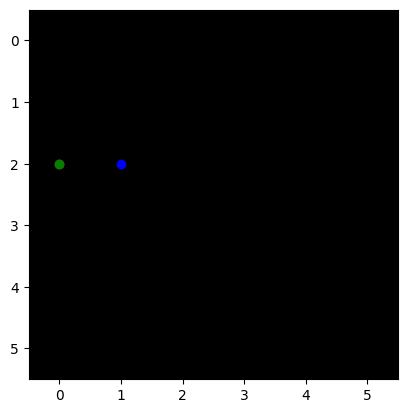

[-0.08831947]
 gamma 0.8
[-1]
[-0.08831947]
return [-1.0]
gae [-0.9116805270314217]
0.6735365346133
tensor([[0., 5., 0., 4.]])
tensor([[1., 5., 1., 4.]])
tensor([[1., 5., 1., 4.]])


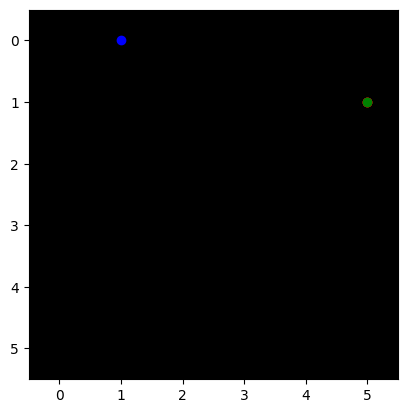

[-0.1429587, -0.14448719]
 gamma 0.8
[0, -1]
[-0.1429587, -0.14448719]
return [-0.11558974981307985, -1.0]
gae [0.027368950843811024, -0.8555128127336502]
0.6148349202882657
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 4.,  0., -1., -4.]])
tensor([[ 4.,  1., -1., -3.]])
tensor([[ 5.,  1.,  0., -3.]])


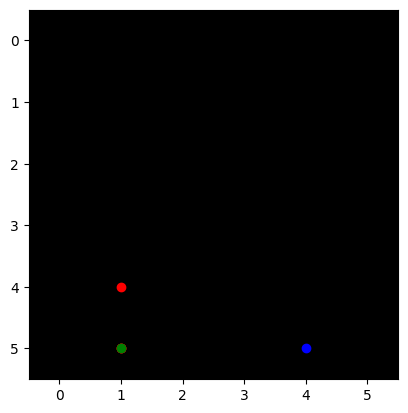

[-0.08565253, -0.08239876, -0.08387789]
 gamma 0.8
[0, 0, -1]
[-0.08565253, -0.08239876, -0.08387789]
return [-0.0659190058708191, -0.06710231304168701, -1.0]
gae [0.019733524322509757, 0.015296444296836853, -0.9161221086978912]
0.44330793153322134
tensor([[ 1.,  2., -1., -3.]])
tensor([[ 1.,  3., -1., -2.]])
tensor([[ 1.,  4., -1., -1.]])
tensor([[ 2.,  4.,  0., -1.]])
tensor([[ 2.,  3.,  0., -2.]])
tensor([[ 2.,  3.,  0., -2.]])
tensor([[ 3.,  3.,  1., -2.]])
tensor([[ 3.,  2.,  1., -3.]])
tensor([[ 3.,  2.,  1., -3.]])
tensor([[ 2.,  2.,  0., -3.]])
tensor([[ 3.,  2.,  1., -3.]])
tensor([[ 3.,  1.,  1., -4.]])
tensor([[ 3.,  2.,  1., -3.]])
tensor([[ 4.,  2.,  2., -3.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  4.,  3., -1.]])
tensor([[ 5.,  4.,  3., -1.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  2.,  3., -3.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 5.,  3.,  3., -2.]])
tensor([[ 4.,  3.,  2., -2.]])
tensor(

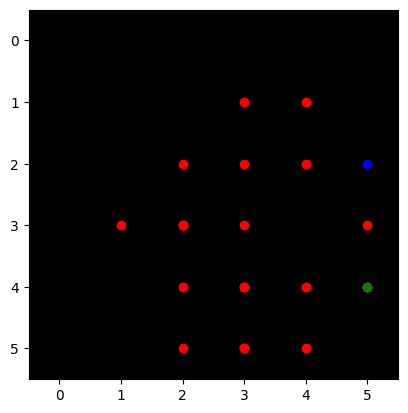

[-0.12625314, -0.14261688, -0.1275253, -0.12818569, -0.12442489, -0.101710975, -0.09530565, -0.108722605, -0.09530565, -0.08815072, -0.09530565, -0.08670113, -0.09189052, -0.09792843, -0.072428934, -0.09792843, -0.083205625, -0.09792843, -0.09189052, -0.089848235, -0.09189052, -0.089848235, -0.13586596, -0.14571391, -0.13586596]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.12625314, -0.14261688, -0.1275253, -0.12818569, -0.12442489, -0.101710975, -0.09530565, -0.108722605, -0.09530565, -0.08815072, -0.09530565, -0.08670113, -0.09189052, -0.09792843, -0.072428934, -0.09792843, -0.083205625, -0.09792843, -0.09189052, -0.089848235, -0.09189052, -0.089848235, -0.13586596, -0.14571391, -0.13586596]
return [-0.11409350633621217, -0.1020202398300171, -0.10254855155944825, -0.09953991174697877, -0.0813687801361084, -0.07624452114105225, -0.08697808384895325, -0.07624452114105225, -0.07052057385444642, -0.07624452114105225, -0.06936090588569642, -0

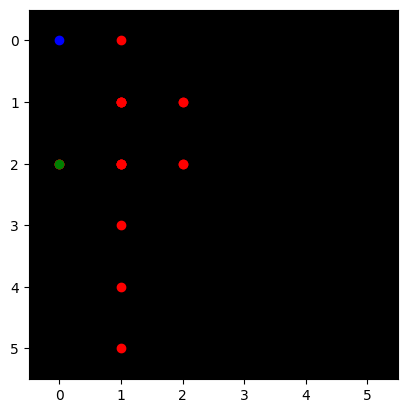

[-0.11608765, -0.10725826, -0.11608765, -0.113237865, -0.11303958, -0.08223687, -0.11303958, -0.08222086, -0.11303958, -0.08222086, -0.09289313, -0.08223687, -0.09289313, -0.08222086, -0.09582845, -0.08222086, -0.11303958, -0.1119672]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.11608765, -0.10725826, -0.11608765, -0.113237865, -0.11303958, -0.08223687, -0.11303958, -0.08222086, -0.11303958, -0.08222086, -0.09289313, -0.08223687, -0.09289313, -0.08222086, -0.09582845, -0.08222086, -0.11303958, -0.1119672]
return [-0.08580660820007324, -0.09287012219429017, -0.0905902922153473, -0.09043166637420655, -0.06578949689865113, -0.09043166637420655, -0.06577668786048889, -0.09043166637420655, -0.06577668786048889, -0.07431450486183167, -0.06578949689865113, -0.07431450486183167, -0.06577668786048889, -0.0766627609729767, -0.06577668786048889, -0.09043166637420655, -0.08957375884056092, -1.0]
gae [0.03028104454278946, 0.014388138055801386, 0.025497360527515403, 0.02280

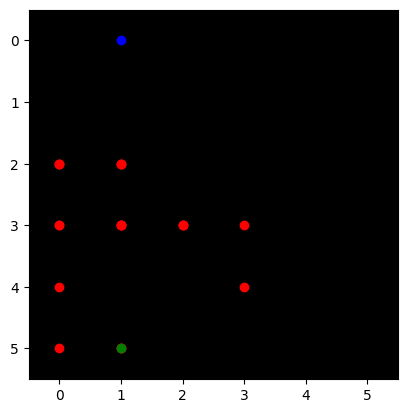

[-0.08331302, -0.08277474, -0.08331302, -0.087877005, -0.09711669, -0.087877005, -0.09711669, -0.087877005, -0.09711669, -0.10977041, -0.1236617, -0.10977041, -0.1236617, -0.10977041, -0.1236617, -0.1123578, -0.09711669, -0.1123578, -0.09504018, -0.10131445, -0.1164813]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.08331302, -0.08277474, -0.08331302, -0.087877005, -0.09711669, -0.087877005, -0.09711669, -0.087877005, -0.09711669, -0.10977041, -0.1236617, -0.10977041, -0.1236617, -0.10977041, -0.1236617, -0.1123578, -0.09711669, -0.1123578, -0.09504018, -0.10131445, -0.1164813]
return [-0.06621979475021363, -0.06665041446685792, -0.07030160427093506, -0.0776933491230011, -0.07030160427093506, -0.0776933491230011, -0.07030160427093506, -0.0776933491230011, -0.08781632781028748, -0.09892935752868653, -0.08781632781028748, -0.09892935752868653, -0.08781632781028748, -0.09892935752868653, -0.08988624215126038, -0.0776933491230011, -0.08988624215126038, -0.0

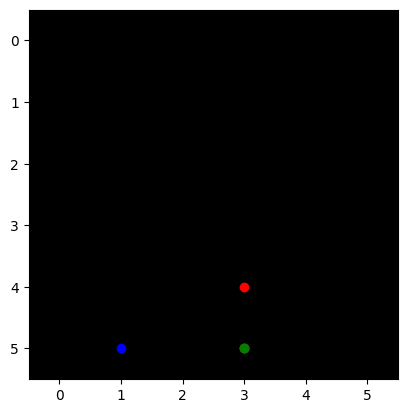

[-0.09523616, -0.08654233, -0.082035944]
 gamma 0.8
[0, 0, -1]
[-0.09523616, -0.08654233, -0.082035944]
return [-0.06923386454582214, -0.06562875509262085, -1.0]
gae [0.026002295315265656, 0.020913575589656827, -0.9179640561342239]
0.25841983854009143
tensor([[ 0.,  0., -2., -4.]])


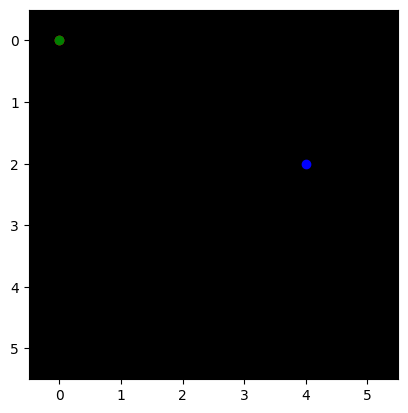

[-0.09692751]
 gamma 0.8
[-1]
[-0.09692751]
return [-1.0]
gae [-0.9030724912881851]
0.031975517547093046
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 2.,  4., -3.,  0.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 3.,  5., -2.,  1.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 3.,  5., -2.,  1.]])
tensor([[ 2.,  5., -3.,  1.]])
tensor([[ 2.,  4., -3.,  0.]])
tensor([[ 3.,  4., -2.,  0.]])
tensor([[ 2.,  4., -3.,  0.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 2.,  4., -3.,  0.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 2.,  2., -3., -2.]])
tensor([[ 2.,  3., -3., -1.]])
tensor([[ 1.,  3., -4., -1.]])
tensor([[ 0.,  3., -5., -1.]])
tensor([[ 1.,  3., -4., -1.]])
tensor([[ 1.,  4., -4.,  0.]])
tensor([[ 1.,  3., -4., -1.]])
tensor([[ 1.,  2., -4., -2.]])
tensor([[ 0.,  2., -5., -2.]])
tensor([[ 1.,  2., -4., -2.]])
tensor([[ 0.,  2., -5., -2.]])
tensor([[ 0.,  3., -5., -1.]])
tensor([[ 0.,  4., -5.,  0.]])


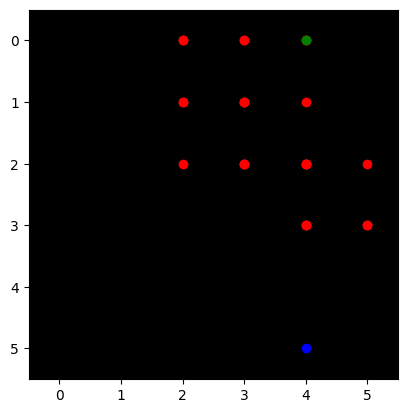

[-0.08507414, -0.08502222, -0.08507414, -0.09883999, -0.08507414, -0.09883999, -0.08304619, -0.08502222, -0.08507414, -0.08502222, -0.098950416, -0.08502222, -0.098950416, -0.106567934, -0.098950416, -0.098210745, -0.09766238, -0.098210745, -0.07825052, -0.098210745, -0.11671571, -0.11535014, -0.11671571, -0.11535014, -0.09766238, -0.082125604]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.08507414, -0.08502222, -0.08507414, -0.09883999, -0.08507414, -0.09883999, -0.08304619, -0.08502222, -0.08507414, -0.08502222, -0.098950416, -0.08502222, -0.098950416, -0.106567934, -0.098950416, -0.098210745, -0.09766238, -0.098210745, -0.07825052, -0.098210745, -0.11671571, -0.11535014, -0.11671571, -0.11535014, -0.09766238, -0.082125604]
return [-0.06801777482032777, -0.06805931329727173, -0.07907199263572694, -0.06805931329727173, -0.07907199263572694, -0.06643695235252381, -0.06801777482032777, -0.06805931329727173, -0.06801777482032777, -0.079160

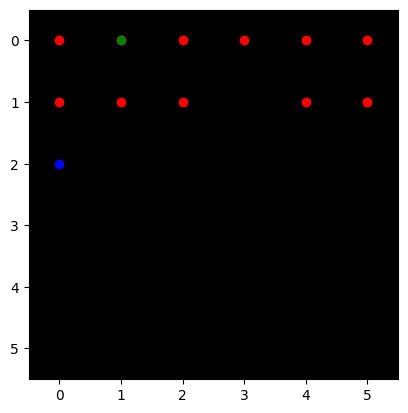

[-0.10428234, -0.10309484, -0.10209237, -0.10309484, -0.10428234, -0.10618398, -0.13362728, -0.1302119, -0.14487733, -0.116625346, -0.12491083, -0.13001707, -0.11867135]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.10428234, -0.10309484, -0.10209237, -0.10309484, -0.10428234, -0.10618398, -0.13362728, -0.1302119, -0.14487733, -0.116625346, -0.12491083, -0.13001707, -0.11867135]
return [-0.08247587084770203, -0.08167389631271363, -0.08247587084770203, -0.08342587351799012, -0.08494718670845032, -0.10690182447433472, -0.1041695237159729, -0.1159018635749817, -0.09330027699470521, -0.09992866516113282, -0.10401365756988526, -0.09493708014488221, -1.0]
gae [0.021806471049785614, 0.021420942246913904, 0.019616499543190002, 0.019668965041637412, 0.01933515518903732, -0.0007178410887718201, 0.02945775687694549, 0.01431004106998443, 0.0515770524740219, 0.016696681082248685, 0.020897173881530756, 0.03507999181747436, -0.8813286498188972]
0.5343316109481644


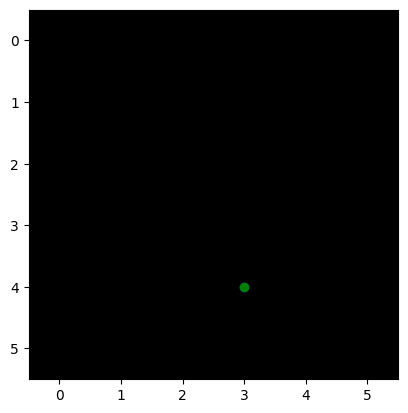

[-0.10428234, -0.10309484, -0.10209237, -0.10309484, -0.10428234, -0.10618398, -0.13362728, -0.1302119, -0.14487733, -0.116625346, -0.12491083, -0.13001707, -0.11867135]
 gamma 0.8
[]
[-0.10428234, -0.10309484, -0.10209237, -0.10309484, -0.10428234, -0.10618398, -0.13362728, -0.1302119, -0.14487733, -0.116625346, -0.12491083, -0.13001707, -0.11867135]
return []
gae []
0.6034816207997795
tensor([[ 2.,  3., -2., -1.]])
tensor([[ 2.,  3., -2., -1.]])
tensor([[ 1.,  3., -3., -1.]])
tensor([[ 1.,  3., -3., -1.]])
tensor([[ 1.,  4., -3.,  0.]])
tensor([[ 1.,  5., -3.,  1.]])


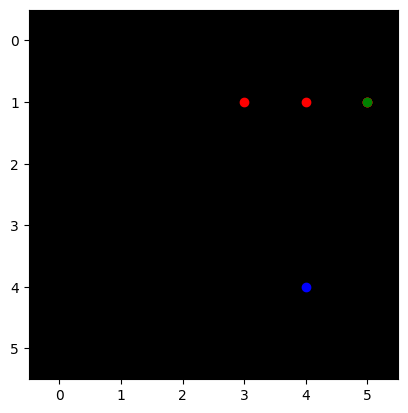

[-0.12137606, -0.12350256, -0.13276257, -0.123622134]
 gamma 0.8
[0, 0, 0, -1]
[-0.12137606, -0.12350256, -0.13276257, -0.123622134]
return [-0.09880204796791077, -0.10621005296707153, -0.0988977074623108, -1.0]
gae [0.02257401198148727, 0.017292506992816925, 0.033864858746528614, -0.8763778656721115]
0.4130126237658577
tensor([[ 1.,  3., -3.,  1.]])
tensor([[ 2.,  3., -2.,  1.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 1.,  4., -3.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 1.,  4., -3.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 2.,  4., -2.,  2.]])
tensor([[ 3.,  4., -1.,  2.]])
tensor([[ 3.,  3., -1.,  1.]])
tensor([[ 3.,  2., -1.,  0.]])
tensor([[ 3.,  2., -1.,  0.]])
tensor([[ 3.,  1., -1., -1.]])
tensor([[ 3.,  0., -1., -2.]])
tensor([[ 2.,  0., -2., -2.]])
tensor([[ 2.,  1., -2., -1.]])
tensor([[ 2.,  0., -2., -2.]])
tensor([[ 2.,  0., -2., -2.

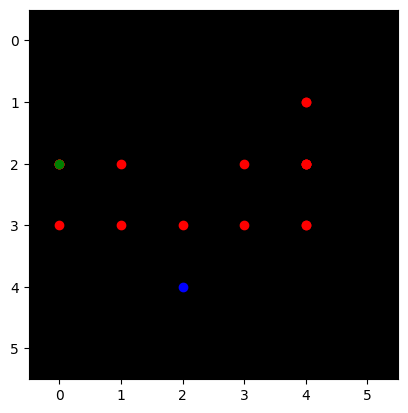

[-0.13410315, -0.12753616, -0.10447091, -0.12090534, -0.10447091, -0.12090534, -0.10447091, -0.10050139, -0.10447091, -0.10050139, -0.101080894, -0.10827438, -0.1134029, -0.11141949, -0.1250092, -0.120271645, -0.1250092]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13410315, -0.12753616, -0.10447091, -0.12090534, -0.10447091, -0.12090534, -0.10447091, -0.10050139, -0.10447091, -0.10050139, -0.101080894, -0.10827438, -0.1134029, -0.11141949, -0.1250092, -0.120271645, -0.1250092]
return [-0.10202893018722535, -0.08357672691345215, -0.09672427177429199, -0.08357672691345215, -0.09672427177429199, -0.08357672691345215, -0.08040111064910889, -0.08357672691345215, -0.08040111064910889, -0.08086471557617188, -0.0866195023059845, -0.09072232246398926, -0.08913559317588807, -0.10000735521316528, -0.09621731638908387, -0.10000735521316528, -1.0]
gae [0.03207421898841857, 0.043959435820579526, 0.007746636867523193, 0.03732861280441284, 0.007746636867523193, 0.03732861280441

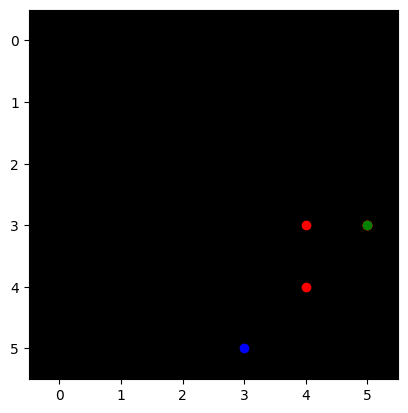

[-0.079510115, -0.101109125, -0.10851627, -0.103931285]
 gamma 0.8
[0, 0, 0, -1]
[-0.079510115, -0.101109125, -0.10851627, -0.103931285]
return [-0.08088729977607728, -0.08681301474571229, -0.08314502835273743, -1.0]
gae [-0.0013771846890449635, 0.014296109974384297, 0.025371240079402918, -0.8960687145590782]
0.5400346054241322
tensor([[5., 4., 3., 4.]])
tensor([[5., 3., 3., 3.]])
tensor([[5., 3., 3., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 4., 2., 4.]])
tensor([[4., 3., 2., 3.]])
tensor([[4., 3., 2., 3.]])
tensor([[5., 3., 3., 3.]])
tensor([[5., 4., 3., 4.]])
tensor([[5., 3., 3., 3.]])


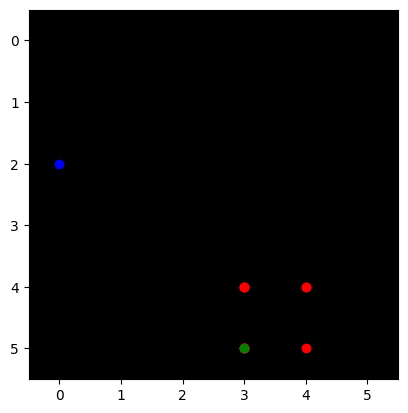

[-0.103407405, -0.08890501, -0.090289064, -0.09699245, -0.090289064, -0.09699245, -0.090289064, -0.08890501, -0.103407405, -0.08890501]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.103407405, -0.08890501, -0.090289064, -0.09699245, -0.090289064, -0.09699245, -0.090289064, -0.08890501, -0.103407405, -0.08890501]
return [-0.07112400531768799, -0.07223125100135804, -0.07759395837783814, -0.07223125100135804, -0.07759395837783814, -0.07223125100135804, -0.07112400531768799, -0.08272592425346376, -0.07112400531768799, -1.0]
gae [0.03228339999914169, 0.01667375564575195, 0.0126951053738594, 0.024761196970939633, 0.0126951053738594, 0.024761196970939633, 0.01916505843400955, 0.006179082393646229, 0.03228339999914169, -0.91109499335289]
0.35432088951357665
tensor([[ 3.,  3., -2., -2.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 4.,  4., -1., -1.]])
tensor([[ 4.,  4., -1., -1.]])
tensor([[ 4.,  3., -1., -2.]])
tensor([[ 4.,  4., -1., -1.]])
tensor([[ 5.,  4.,  0.

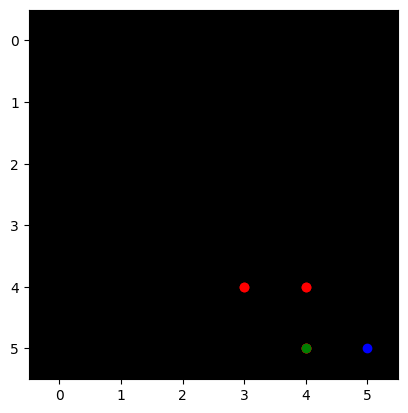

[-0.118967004, -0.10214109, -0.06926135, -0.10214109, -0.06926135, -0.046042476]
 gamma 0.8
[0, 0, 0, 0, 0, -1]
[-0.118967004, -0.10214109, -0.06926135, -0.10214109, -0.06926135, -0.046042476]
return [-0.08171287178993225, -0.05540907979011536, -0.08171287178993225, -0.05540907979011536, -0.036833980679512025, -1.0]
gae [0.03725413233041763, 0.04673200994729995, -0.012451522052288055, 0.04673200994729995, 0.03242736905813217, -0.95395752415061]
return [-0.07759396 -0.07223125 -0.07223125 -0.07223125 -0.071124   -0.071124
 -0.071124   -0.05540908 -0.05540908 -0.03683398]
return [-1.         -1.         -1.         -1.         -1.         -1.
 -0.11590187 -0.10690182 -0.10621005 -0.10416953]

-------------------- Iteration #91 --------------------
random  0.35432088951357665
Average : 0.01
Average Episodic Return: -0.7
Max Episodic Return: 1.0
Average Loss: 0.00018
Average Loss Critic: 0.22576159238815308
TEntropy: nan
approx_kl_divs: [0.00017891632] secs
--------------------------------

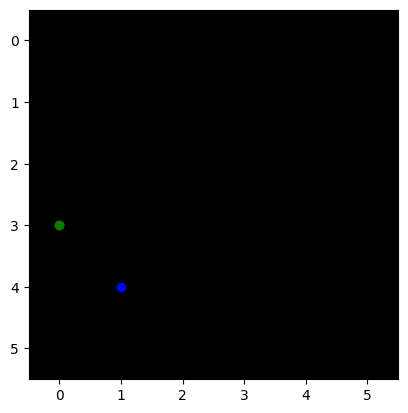

[-0.15596285]
 gamma 0.8
[-1]
[-0.15596285]
return [-1.0]
gae [-0.8440371453762054]
0.07146940028885829
tensor([[ 3.,  5., -2.,  1.]])
tensor([[ 2.,  5., -3.,  1.]])


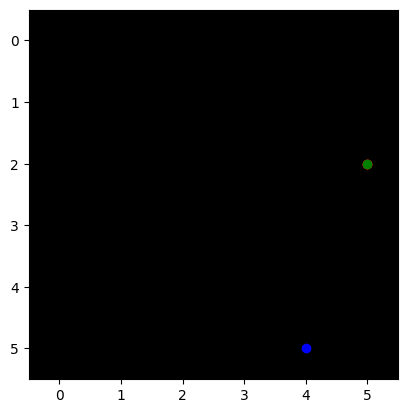

[-0.11482746, -0.110463455]
 gamma 0.8
[0, -1]
[-0.11482746, -0.110463455]
return [-0.08837076425552369, -1.0]
gae [0.026456697285175315, -0.8895365446805954]
0.5799777554677493
tensor([[2., 2., 2., 1.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 3., 2., 2.]])
tensor([[2., 4., 2., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[0., 4., 0., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[1., 5., 1., 4.]])
tensor([[2., 5., 2., 4.]])
tensor([[2., 5., 2., 4.]])
tensor([[2., 4., 2., 3.]])
tensor([[2., 4., 2., 3.]])
tensor([[1., 4., 1., 3.]])
tensor([[0., 4., 0., 3.]])


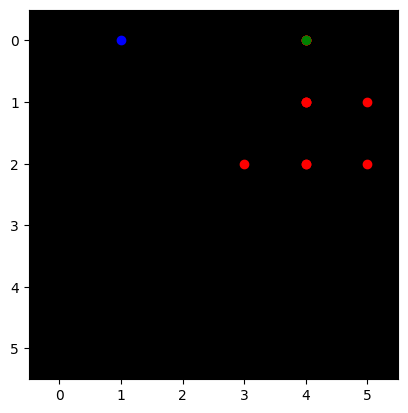

[-0.14774954, -0.1038253, -0.089837186, -0.09834685, -0.11091585, -0.09834685, -0.097456485, -0.09683957, -0.089837186, -0.09834685, -0.11091585]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.14774954, -0.1038253, -0.089837186, -0.09834685, -0.11091585, -0.09834685, -0.097456485, -0.09683957, -0.089837186, -0.09834685, -0.11091585]
return [-0.08306024074554444, -0.07186974883079529, -0.07867748141288758, -0.08873267769813538, -0.07867748141288758, -0.07796518802642823, -0.07747165560722352, -0.07186974883079529, -0.07867748141288758, -0.08873267769813538, -1.0]
gae [0.064689302444458, 0.03195555210113525, 0.011159704625606531, 0.009614174067974088, 0.03223836570978164, 0.02038166373968124, 0.019984829425811756, 0.024969820678234098, 0.011159704625606531, 0.009614174067974088, -0.8890841528773308]
0.6091642699322433
tensor([[3., 4., 0., 1.]])
tensor([[3., 4., 0., 1.]])
tensor([[ 2.,  4., -1.,  1.]])
tensor([[ 1.,  4., -2.,  1.]])
tensor([[ 0.,  4., -3.,  1.]])
tensor([[ 0.,  4., -3.

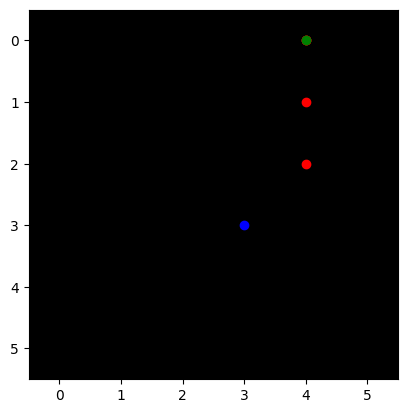

[-0.10108116, -0.131557, -0.14209369, -0.1328116]
 gamma 0.8
[0, 0, 0, -1]
[-0.10108116, -0.131557, -0.14209369, -0.1328116]
return [-0.1052456021308899, -0.11367495059967042, -0.1062492847442627, -1.0]
gae [-0.004164439439773571, 0.017882052063941944, 0.035844403505325306, -0.8671883940696716]
0.24700255706509788
tensor([[ 5.,  2.,  4., -3.]])
tensor([[ 4.,  2.,  3., -3.]])
tensor([[ 5.,  2.,  4., -3.]])


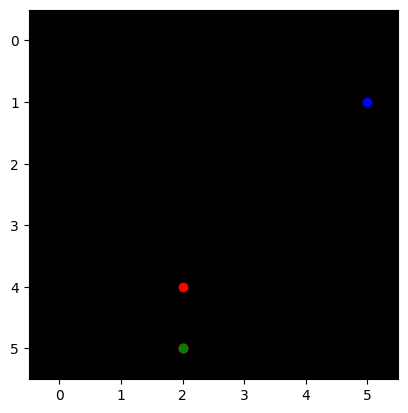

[-0.15945733, -0.15833667, -0.15945733]
 gamma 0.8
[0, 0, -1]
[-0.15945733, -0.15833667, -0.15945733]
return [-0.12666933536529543, -0.12756586074829102, -1.0]
gae [0.03278799057006834, 0.030770808458328247, -0.8405426740646362]
0.5979480495560363
tensor([[ 3.,  1., -2.,  0.]])
tensor([[ 3.,  1., -2.,  0.]])
tensor([[ 3.,  0., -2., -1.]])
tensor([[ 2.,  0., -3., -1.]])
tensor([[ 3.,  0., -2., -1.]])
tensor([[ 3.,  0., -2., -1.]])
tensor([[ 3.,  1., -2.,  0.]])
tensor([[ 3.,  1., -2.,  0.]])
tensor([[ 4.,  1., -1.,  0.]])
tensor([[ 4.,  1., -1.,  0.]])
tensor([[ 4.,  2., -1.,  1.]])
tensor([[5., 2., 0., 1.]])
tensor([[5., 2., 0., 1.]])


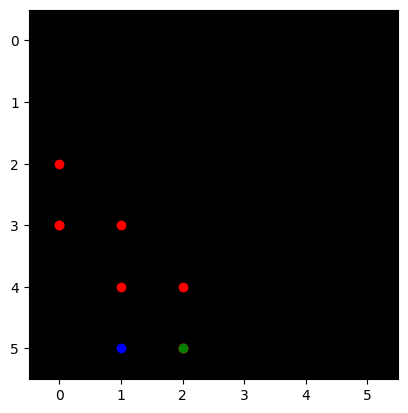

[-0.15484793, -0.15510675, -0.15834327, -0.15510675, -0.15484793, -0.1576433, -0.16190995, -0.15939882]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.15484793, -0.15510675, -0.15834327, -0.15510675, -0.15484793, -0.1576433, -0.16190995, -0.15939882]
return [-0.1240854024887085, -0.1266746163368225, -0.1240854024887085, -0.12387834787368775, -0.12611464262008668, -0.1295279622077942, -0.1275190591812134, -1.0]
gae [0.03076253235340118, 0.028432136774063116, 0.034257867932319636, 0.031228405237197873, 0.028733292222023005, 0.028115341067314142, 0.03439089357852934, -0.8406011760234833]
0.36645311488693866
tensor([[ 0.,  5., -1.,  4.]])
tensor([[ 0.,  4., -1.,  3.]])
tensor([[ 0.,  4., -1.,  3.]])
tensor([[ 0.,  5., -1.,  4.]])


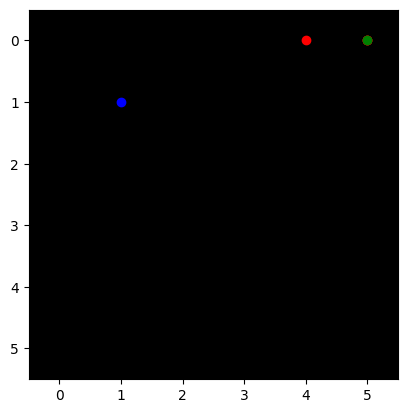

[-0.09578827, -0.11197584, -0.09578827]
 gamma 0.8
[0, 0, -1]
[-0.09578827, -0.11197584, -0.09578827]
return [-0.08958067297935486, -0.07663061618804932, -1.0]
gae [0.006207597255706784, 0.03534522503614425, -0.9042117297649384]
0.4238984436875006
tensor([[1., 4., 0., 2.]])
tensor([[1., 5., 0., 3.]])
tensor([[2., 5., 1., 3.]])


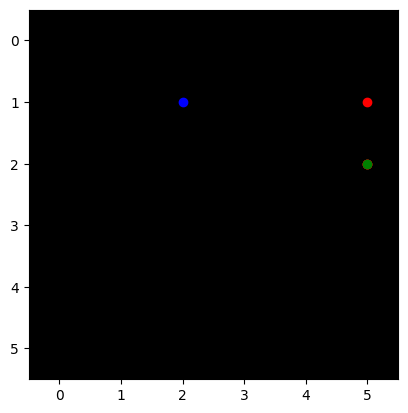

[-0.11052928, -0.09693438, -0.09809588]
 gamma 0.8
[0, 0, -1]
[-0.11052928, -0.09693438, -0.09809588]
return [-0.0775475025177002, -0.07847670316696168, -1.0]
gae [0.03298177868127822, 0.01845767498016357, -0.9019041210412979]
0.432505512878946
tensor([[2., 3., 2., 0.]])
tensor([[2., 3., 2., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[3., 4., 3., 1.]])
tensor([[3., 3., 3., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  1.,  3., -2.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 4.,  2.,  4., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 2.,  2.,  2., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[ 3.,  2.,  3., -1.]])
tensor([[3., 3., 3., 0.]])
tensor([[3., 3., 3., 0.]])
tensor([[3., 4., 3., 1.]])
tensor([[3., 5., 3., 2.]])
tensor([[3., 5., 3., 2.]])


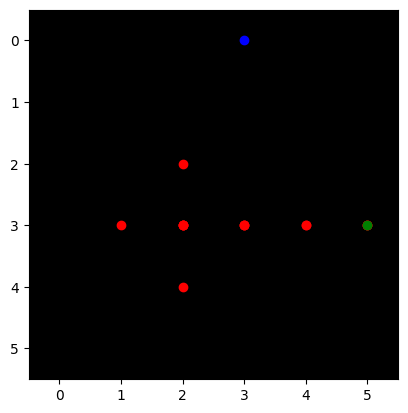

[-0.14026223, -0.13696714, -0.0846907, -0.13696714, -0.16031434, -0.15892223, -0.16031434, -0.16305149, -0.16031434, -0.15827237, -0.16031434, -0.13696714, -0.0846907, -0.08224843]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.14026223, -0.13696714, -0.0846907, -0.13696714, -0.16031434, -0.15892223, -0.16031434, -0.16305149, -0.16031434, -0.15827237, -0.16031434, -0.13696714, -0.0846907, -0.08224843]
return [-0.1095737099647522, -0.06775255799293518, -0.1095737099647522, -0.12825146913528443, -0.12713778018951416, -0.12825146913528443, -0.13044118881225586, -0.12825146913528443, -0.12661789655685426, -0.12825146913528443, -0.1095737099647522, -0.06775255799293518, -0.06579874157905578, -1.0]
gae [0.03068852126598358, 0.06921457946300506, -0.024883012473583224, 0.008715668320655817, 0.03317655622959137, 0.03067075610160827, 0.02987314760684967, 0.034800016880035395, 0.033696439862251265, 0.03002090156078338, 0.05074062645435333, 0.06921457946300506, 0.018891955912113192, -0

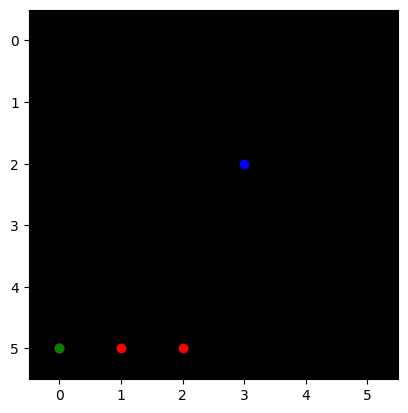

[-0.16107166, -0.16690366, -0.16047464, -0.1605707]
 gamma 0.8
[0, 0, 0, -1]
[-0.16107166, -0.16690366, -0.16047464, -0.1605707]
return [-0.13352292776107788, -0.12837971448898317, -0.12845655679702758, -1.0]
gae [0.02754873037338257, 0.038523945212364186, 0.03201808631420136, -0.8394293040037155]
return [-0.0784767  -0.07796519 -0.07754751 -0.07747166 -0.07663061 -0.07186975
 -0.07186975 -0.06775256 -0.06775256 -0.06579874]
return [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]

-------------------- Iteration #92 --------------------
random  0.9621109884845424
Average : 0.01
Average Episodic Return: -0.74
Max Episodic Return: 1.0
Average Loss: 0.00023
Average Loss Critic: 0.22548212110996246
TEntropy: nan
approx_kl_divs: [0.0002773418] secs
------------------------------------------------------

0.9821117693449388
tensor([[2., 5., 2., 3.]])
tensor([[2., 5., 2., 3.]])
tensor([[2., 4., 2., 2.]])
tensor([[2., 4., 2., 2.]])
tensor([[2., 5., 2., 3.]])
tensor([[2., 5., 2., 3.]])
tensor([[1., 5., 

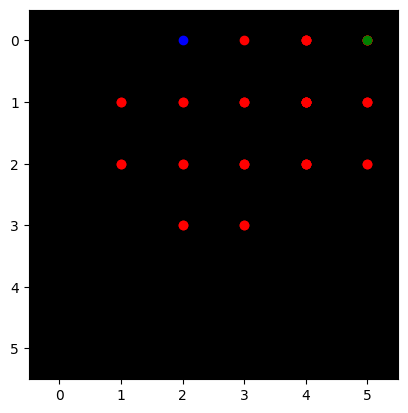

[-0.15114062, -0.14759617, -0.15114062, -0.15359989, -0.14854403, -0.10955359, -0.10186261, -0.10955359, -0.14046969, -0.10955359, -0.14046969, -0.15359989, -0.15114062, -0.14759617, -0.11225613, -0.14759617, -0.14046969, -0.15359989, -0.14046969, -0.093755856, -0.09406682, -0.0931509, -0.1000104, -0.11805625, -0.11225613, -0.11805625, -0.1000104, -0.0931509, -0.09427356, -0.09614539, -0.09427356, -0.09614539, -0.09406682, -0.093755856, -0.11225613, -0.14759617, -0.14046969, -0.093755856, -0.14046969, -0.10955359, -0.14854403]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.15114062, -0.14759617, -0.15114062, -0.15359989, -0.14854403, -0.10955359, -0.10186261, -0.10955359, -0.14046969, -0.10955359, -0.14046969, -0.15359989, -0.15114062, -0.14759617, -0.11225613, -0.14759617, -0.14046969, -0.15359989, -0.14046969, -0.093755856, -0.09406682, -0.0931509, -0.1000104, -0.11805625, -0.11225613, -0.118

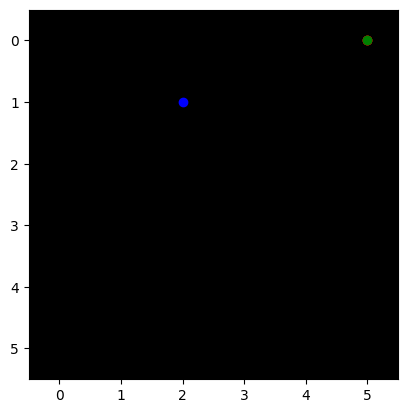

[-0.1535886, -0.14233041]
 gamma 0.8
[0, -1]
[-0.1535886, -0.14233041]
return [-0.11386432647705079, -1.0]
gae [0.039724266529083244, -0.8576695919036865]
0.4955324721671609
tensor([[ 2.,  4., -2.,  1.]])
tensor([[ 2.,  4., -2.,  1.]])
tensor([[ 2.,  5., -2.,  2.]])
tensor([[ 2.,  5., -2.,  2.]])
tensor([[ 2.,  4., -2.,  1.]])
tensor([[ 2.,  5., -2.,  2.]])
tensor([[ 2.,  5., -2.,  2.]])


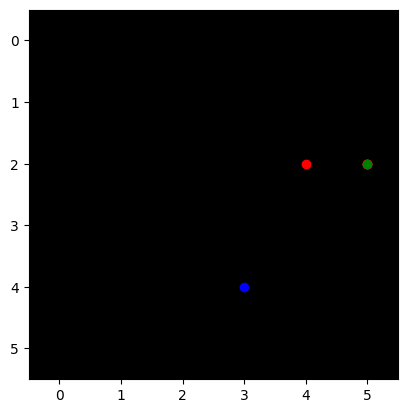

[-0.10974932, -0.14563091, -0.10974932, -0.14563091]
 gamma 0.8
[0, 0, 0, -1]
[-0.10974932, -0.14563091, -0.10974932, -0.14563091]
return [-0.1165047287940979, -0.08779945373535157, -0.1165047287940979, -1.0]
gae [-0.006755411624908447, 0.057831457257270805, -0.006755411624908447, -0.8543690890073776]
0.5828052237609885
tensor([[4., 5., 1., 1.]])
tensor([[4., 5., 1., 1.]])
tensor([[4., 4., 1., 0.]])
tensor([[4., 4., 1., 0.]])
tensor([[5., 4., 2., 0.]])
tensor([[5., 4., 2., 0.]])
tensor([[ 5.,  3.,  2., -1.]])


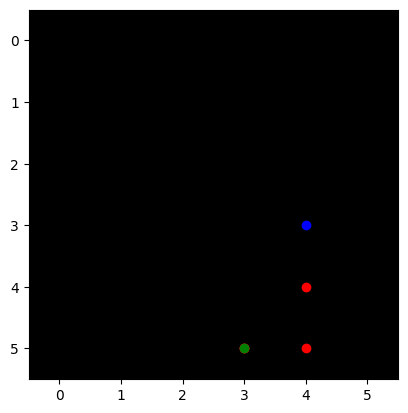

[-0.15175985, -0.13625804, -0.13878955, -0.11240691]
 gamma 0.8
[0, 0, 0, -1]
[-0.15175985, -0.13625804, -0.13878955, -0.11240691]
return [-0.1090064287185669, -0.11103163957595825, -0.08992552757263184, -1.0]
gae [0.04275341928005218, 0.025226396322250363, 0.04886402189731598, -0.8875930905342102]
return [-0.07691631 -0.07541884 -0.07541884 -0.07525346 -0.07525346 -0.07500468
 -0.07500468 -0.07500468 -0.07452072 -0.07452072]
return [-1.         -1.         -1.         -1.         -0.12287991 -0.12287991
 -0.12287991 -0.12091249 -0.12091249 -0.11883523]

-------------------- Iteration #93 --------------------
random  0.5828052237609885
Average : 0.01
Average Episodic Return: -0.74
Max Episodic Return: 1.0
Average Loss: 0.00069
Average Loss Critic: 0.2243710160255432
TEntropy: nan
approx_kl_divs: [0.0002049119] secs
------------------------------------------------------

0.06778228118715302
tensor([[2., 4., 0., 3.]])
tensor([[ 1.,  4., -1.,  3.]])
tensor([[2., 4., 0., 3.]])
tensor([[ 1.

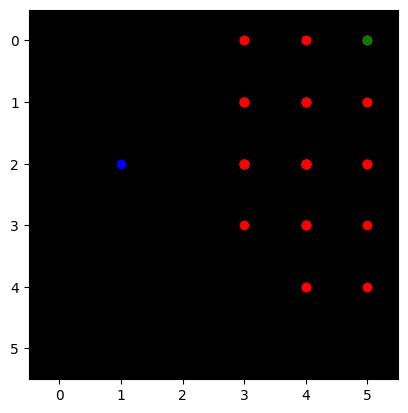

[-0.13939151, -0.14776659, -0.13939151, -0.14776659, -0.12293054, -0.1275471, -0.13939151, -0.1275471, -0.12293054, -0.12529889, -0.13292402, -0.15228468, -0.14340626, -0.1403573, -0.13939151, -0.1403573, -0.14886092, -0.1403573, -0.13939151, -0.1275471, -0.12293054, -0.12529889, -0.13292402, -0.14776659, -0.13939151, -0.15141134, -0.14276162, -0.1524601, -0.14276162, -0.15141134, -0.1360592, -0.15141134, -0.13939151, -0.1275471, -0.12293054, -0.1275471, -0.13939151, -0.14776659, -0.14340626, -0.15228468]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.13939151, -0.14776659, -0.13939151, -0.14776659, -0.12293054, -0.1275471, -0.13939151, -0.1275471, -0.12293054, -0.12529889, -0.13292402, -0.15228468, -0.14340626, -0.1403573, -0.13939151, -0.1403573, -0.14886092, -0.1403573, -0.13939151, -0.1275471, -0.12293054, -0.12529889, -0.13292402, -0.14776659, -0.13939151, -0.15141134, -0.14276162, -0.1524601

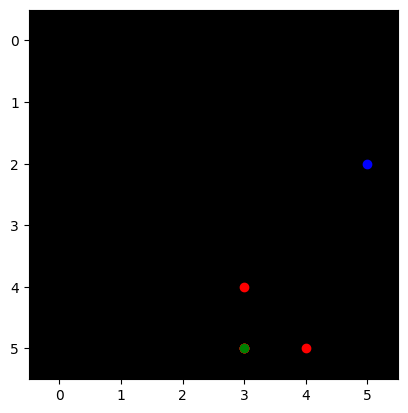

[-0.12583406, -0.12709793, -0.11496042, -0.12121535, -0.11496042]
 gamma 0.8
[0, 0, 0, 0, -1]
[-0.12583406, -0.12709793, -0.11496042, -0.12121535, -0.11496042]
return [-0.10167834758758545, -0.0919683337211609, -0.09697228074073792, -0.0919683337211609, -1.0]
gae [0.02415571510791778, 0.03512960076332092, 0.017988136410713187, 0.0292470172047615, -0.8850395828485489]
0.9996649905237047
tensor([[ 1.,  2., -1.,  1.]])
tensor([[ 1.,  2., -1.,  1.]])
tensor([[ 1.,  3., -1.,  2.]])
tensor([[ 1.,  3., -1.,  2.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 5., 0., 4.]])
tensor([[2., 5., 0., 4.]])
tensor([[ 1.,  5., -1.,  4.]])
tensor([[ 1.,  5., -1.,  4.]])
tensor([[ 1.,  4., -1.,  3.]])
tensor([[ 1.,  4., -1.,  3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 4., 0., 3.]])
tensor([[2., 3., 0., 2.]])
tensor([[2., 3., 0., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 3., 1., 2.]])
tensor([[3., 4., 1., 3.]])
tensor([[3.,

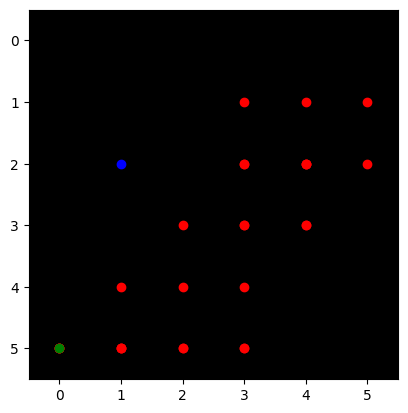

[-0.1164788, -0.12293054, -0.1275471, -0.13939151, -0.1403573, -0.14340626, -0.14776659, -0.13939151, -0.1275471, -0.1360592, -0.15141134, -0.13939151, -0.15141134, -0.1360592, -0.12007682, -0.117402196, -0.13467872, -0.14414954, -0.14219676, -0.14414954, -0.13467872, -0.11499369, -0.1165676, -0.11499369, -0.11692223, -0.11499369, -0.1165676]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
[-0.1164788, -0.12293054, -0.1275471, -0.13939151, -0.1403573, -0.14340626, -0.14776659, -0.13939151, -0.1275471, -0.1360592, -0.15141134, -0.13939151, -0.15141134, -0.1360592, -0.12007682, -0.117402196, -0.13467872, -0.14414954, -0.14219676, -0.14414954, -0.13467872, -0.11499369, -0.1165676, -0.11499369, -0.11692223, -0.11499369, -0.1165676]
return [-0.09834443330764771, -0.10203768014907838, -0.11151320934295655, -0.11228584051132202, -0.11472500562667848, -0.11821327209472657, -0.11151320934295655, -0.10203768014907838, -0.10884735584259034, -0.1211290

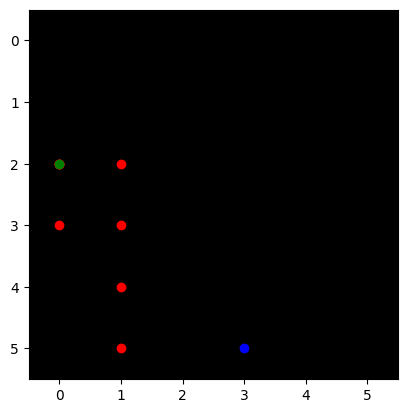

[0.090024486, 0.09309136, 0.09864446, 0.13172443, 0.18606837, 0.23318031, 0.15870634, 0.23318031]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[0.090024486, 0.09309136, 0.09864446, 0.13172443, 0.18606837, 0.23318031, 0.15870634, 0.23318031]
return [0.07447308897972107, 0.0789155662059784, 0.10537954568862916, 0.14885469675064086, 0.18654425144195558, 0.12696506977081298, 0.18654425144195558, -1.0]
gae [-0.015551397204399103, -0.014175795018672943, 0.006735087931156167, 0.017130264639854426, 0.0004758805036544911, -0.10621524453163148, 0.027837914228439342, -1.2331803143024445]
0.3195447073652756
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 2.,  1., -1., -3.]])
tensor([[ 1.,  1., -2., -3.]])
tensor([[ 1.,  1., -2., -3.]])
tensor([[ 1.,  0., -2., -4.]])


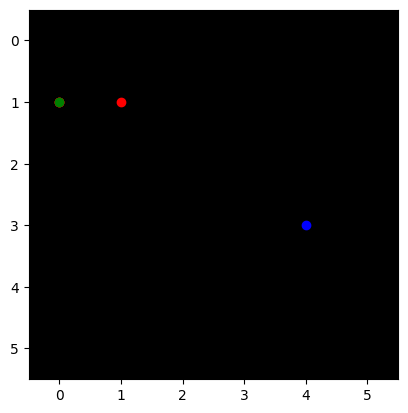

[0.13037944, 0.18203032, 0.210212]
 gamma 0.8
[0, 0, -1]
[0.13037944, 0.18203032, 0.210212]
return [0.1456242561340332, 0.16816960573196413, -1.0]
gae [0.015244817733764654, -0.013860714435577376, -1.2102120071649551]
0.0345854710026976
tensor([[1., 5., 1., 1.]])
tensor([[1., 4., 1., 0.]])
tensor([[ 1.,  3.,  1., -1.]])
tensor([[ 2.,  3.,  2., -1.]])
tensor([[ 2.,  2.,  2., -2.]])
tensor([[ 2.,  1.,  2., -3.]])
tensor([[ 1.,  1.,  1., -3.]])
tensor([[ 0.,  1.,  0., -3.]])


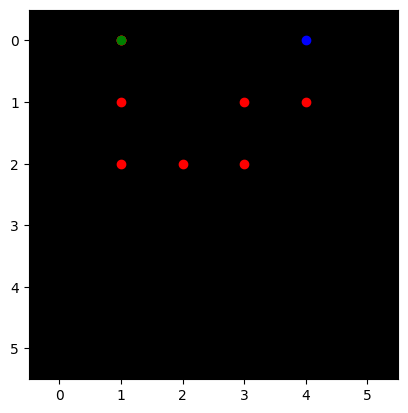

[-0.00086543686, 0.057894215, 0.100076176, 0.084235646, 0.08934897, 0.09037589, 0.09128952, 0.107838035]
 gamma 0.8
[0, 0, 0, 0, 0, 0, 0, -1]
[-0.00086543686, 0.057894215, 0.100076176, 0.084235646, 0.08934897, 0.09037589, 0.09128952, 0.107838035]
return [0.04631537199020386, 0.08006094098091127, 0.067388516664505, 0.07147917747497559, 0.07230071425437927, 0.0730316162109375, 0.08627042770385743, -1.0]
gae [0.047180808847770095, 0.022166725993156444, -0.032687659561634066, -0.012756468355655665, -0.017048257589340213, -0.017344276607036593, -0.005019092559814448, -1.1078380346298218]
0.8822438934970096
tensor([[1., 5., 1., 3.]])
tensor([[1., 5., 1., 3.]])


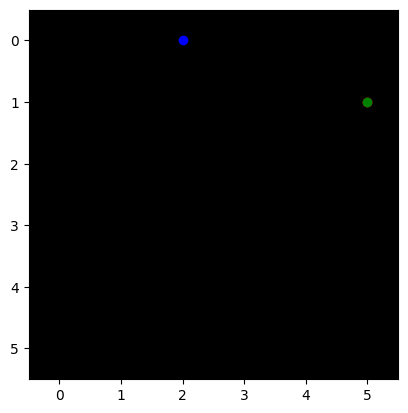

In [ ]:
agent.learn(100)

In [ ]:
plt.plot(agent.logger['actor_losses'],'.' )

In [2]:
agent.play()

NameError: ignored

In [ ]:
torch.save(agent.Actor_Critic.state_dict(),'weihts.pth')

In [ ]:
agent.Actor_Critic.state_dict()